In [13]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Package Preparation

In [14]:
# Import packages for scrapping from IOS App Store
from app_store_scraper import AppStore

# Import packages for data processing
import pandas as pd
import numpy as np
import json

# Import packages for topic modelling
# Reference: https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/
import nltk
from nltk import FreqDist

import re
import spacy

import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# text cleaning
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Wordcloud of Top N words in each topic
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# Other pre-setting
pd.set_option("display.max_colwidth", 200)

# Function Preparation

In [15]:
# Function - Scrape review data from App Store
def app_store_scrapperNtransformer(app_name,country,how_many,export_csv_name):
    # Scrape the review data
    fetcher = AppStore(country, app_name)
    fetcher.review(how_many)
    
    # Transform data and put in DataFrame
    transformed_dataframe = pd.DataFrame(np.array(fetcher.reviews),columns=['review'])

    transformed_dataframe = transformed_dataframe.join(pd.DataFrame(transformed_dataframe.pop('review').tolist()))

    transformed_dataframe.to_csv(export_csv_name)

In [16]:
# Function - Plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()
    
# use for flattening out list of lists
def flatten(t):
    return [item for sublist in t for item in sublist]

In [17]:
# Text Cleaning
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [18]:
# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    # texts = [bigram_mod[doc] for doc in texts]
    # texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


In [19]:
# Train LDA models and find optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, chunksize=1000, passes=50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Scrapping Reviews

In [20]:
'''
app_store_scrapperNtransformer(app_name="Lomotif: Edit Video. Add Music",country="us",
                           how_many=5000,export_csv_name="lomotif_data_us.csv")
'''
# Status: Completed

'\napp_store_scrapperNtransformer(app_name="Lomotif: Edit Video. Add Music",country="us",\n                           how_many=5000,export_csv_name="lomotif_data_us.csv")\n'

# Basic Data Preparation

In [24]:
# Import scrapped data
lomotif_ios_us_review = pd.read_csv("lomotif_data_us.csv")

In [25]:
# Inspect the data
lomotif_ios_us_review.head()

Unnamed: 0  rating                 userName  \
0           0       5  Funniest best app ever!   
1           1       5             Khloe murphy   
2           2       4             19ninetyfive   
3           3       4             itsyagirllll   
4           4       5              shylsgdydyd   

                                            title                 date  \
0                                         Awesome  2018-07-07 16:22:14   
1                                  The only thing  2020-03-29 21:25:21   
2  This App Is Awesome But One Tip For The Makers  2018-12-28 21:07:45   
3                            Love this app butttt  2019-01-17 03:07:15   
4                                      It changed  2018-04-26 23:56:59   

                                                                                                                                                                                                    review  \
0  I love this app so much ! It is always my go to app for making edits / slideshows. There’s every song you think of to choose from unlike some of the other apps I’ve used. It’s also great for makin...   
1  The only way to make a new phone is that I don’t know what I want to say but I cannot is a new day for me and my friends to the moon and the day of my we all know that you have been in love and I ...   
2  Honestly, this app is key to videos for anything for business or popularity. Adding music to your videos is honestly a hassle these days with copyright. This app allows you to do it without having...   
3  Don’t get me wrong this app is awesome! I just have one issue. Every time I try to use this app it always freezes up and kicks me off or all my pics and videos goes to a black screen and the song ...   
4  When I first got on Lomotif I loved it and I before Lomotif I was on Flipagram and my videos was always to slow but on Lomotif I just love how fast it goes however their has been MANY updates on h...   

   isEdited developerResponse  
0     False               NaN  
1     False               NaN  
2     False               NaN  
3     False               NaN  
4     False               NaN

In [28]:
# Sort by date, only keep data between 2018 and 2021, clean columns
lomotif_ios_us_review_YearMonth = (lomotif_ios_us_review.copy()
                                                      .sort_values(by='date')
                                                      .reset_index()
                                                      .drop(columns=['index','Unnamed: 0'])
                                                      .query("`date` > '2017-12-31 23:59:59' and \
                                                             `date` < '2021-12-31 23:59:59'")
                                     ) 
# Remove time from date column
lomotif_ios_us_review_YearMonth['date'] = pd.to_datetime(lomotif_ios_us_review_YearMonth['date']).dt.floor('d')

# Create year column
lomotif_ios_us_review_YearMonth['year'] = pd.DatetimeIndex(lomotif_ios_us_review_YearMonth['date']).year

# Create month column
lomotif_ios_us_review_YearMonth['month'] = pd.DatetimeIndex(lomotif_ios_us_review_YearMonth['date']).month

In [29]:
# Inspect the dataframe again after cleaning
lomotif_ios_us_review_YearMonth.head()

rating     userName                 title       date  \
64       5   hickeycuts  Heartbroken souls <3 2018-01-01   
65       1  KINGBVALLER                 Trash 2018-01-05   
66       2     No.type.                   Fix 2018-01-05   
67       5  Eatchips149               Awesome 2018-01-06   
68       1   littybooty                Saving 2018-01-07   

                                                                                                                                                                                             review  \
64                                                                                                       I tipycally love this app I hope there’s new features to come happy new year by the way !!   
65                                   this app it trash  because u cant make a lit video then when its done and its loading it kicks out of the app and i have to start all over again / on iphone 7   
66  This app used to work fine like nothing was wrong but all of a sudden It stops working. It freezes n just doesn’t un freeze. I’ll delete It then re download It n It still freezing😐fix please.   
67                                                                                                                                                   Able to post clips of songs to my ig with this   
68                                                                  im upset bc i pressed the home button to take a break from making the lomotifs and when i came back it was nowhere to be found.   

    isEdited  \
64     False   
65     False   
66     False   
67     False   
68     False   

                                                                                                                                                                                          developerResponse  \
64                                                                                                                                                                                                      NaN   
65                                                                                                                                                                                                      NaN   
66                                                                                                                                                                                                      NaN   
67                                                                                                                                                                                                      NaN   
68  {'id': 2230844, 'body': 'Hi Littybooty, when you press "Home" you will be asked if you would like to save changes. If you clicked "Yes", you\'ll be able to find your Lomotif project in Profile - I...   

    year  month  
64  2018      1  
65  2018      1  
66  2018      1  
67  2018      1  
68  2018      1

# EDA

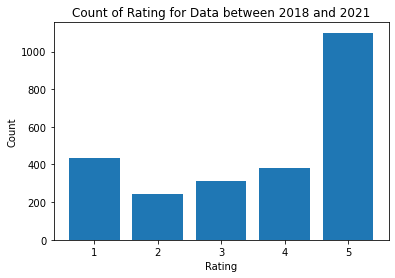

In [30]:
# Plot the count of different ratings for data between 2018 and 2021
lomotif_ios_us_review_score_count = lomotif_ios_us_review_YearMonth.groupby(['rating'])[['review']].nunique().rename(columns={'review':'count'})

plt.bar(lomotif_ios_us_review_score_count.index,lomotif_ios_us_review_score_count['count'])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Count of Rating for Data between 2018 and 2021")
plt.show()

Text(0.5, 1.0, 'Count of Rating for Each Year between 2018 and 2021')

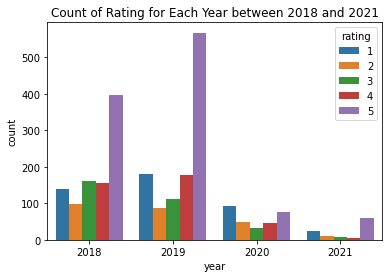

In [31]:
# Plot the count of different ratings for each year
lomotif_ios_us_review_score_count_ByYear = (lomotif_ios_us_review_YearMonth.groupby(['year','rating'])[['review']]
                                                                        .nunique()
                                                                        .rename(columns={'review':'count'})
                                                                        .reset_index()
                                              )

(sns.barplot(data=lomotif_ios_us_review_score_count_ByYear,x='year',y='count',hue='rating')
   .set_title("Count of Rating for Each Year between 2018 and 2021")
)

# Comment: extreme review score on 1 or 5

In [32]:
# Understand average ratings over year
lomotif_ios_us_review_avg_score_ByYear = (lomotif_ios_us_review_YearMonth.groupby(['year'])[['rating']]
                                                                       .mean()
                                              )

lomotif_ios_us_review_avg_score_ByYear['count'] = lomotif_ios_us_review_score_count_ByYear.groupby('year')[['count']].sum().values

print('Average ratings and count of each year:')
lomotif_ios_us_review_avg_score_ByYear

Average ratings and count of each year:


rating  count
year                 
2018  3.600840    952
2019  3.774711   1122
2020  2.873288    292
2021  3.605505    109

# Dataframe Preparation for Topic Modelling

In [33]:
# Dataframe with data between 2018 and 2021 without score or year filtering
lomotif_ios_us_review_YearMonth.head()

rating     userName                 title       date  \
64       5   hickeycuts  Heartbroken souls <3 2018-01-01   
65       1  KINGBVALLER                 Trash 2018-01-05   
66       2     No.type.                   Fix 2018-01-05   
67       5  Eatchips149               Awesome 2018-01-06   
68       1   littybooty                Saving 2018-01-07   

                                                                                                                                                                                             review  \
64                                                                                                       I tipycally love this app I hope there’s new features to come happy new year by the way !!   
65                                   this app it trash  because u cant make a lit video then when its done and its loading it kicks out of the app and i have to start all over again / on iphone 7   
66  This app used to work fine like nothing was wrong but all of a sudden It stops working. It freezes n just doesn’t un freeze. I’ll delete It then re download It n It still freezing😐fix please.   
67                                                                                                                                                   Able to post clips of songs to my ig with this   
68                                                                  im upset bc i pressed the home button to take a break from making the lomotifs and when i came back it was nowhere to be found.   

    isEdited  \
64     False   
65     False   
66     False   
67     False   
68     False   

                                                                                                                                                                                          developerResponse  \
64                                                                                                                                                                                                      NaN   
65                                                                                                                                                                                                      NaN   
66                                                                                                                                                                                                      NaN   
67                                                                                                                                                                                                      NaN   
68  {'id': 2230844, 'body': 'Hi Littybooty, when you press "Home" you will be asked if you would like to save changes. If you clicked "Yes", you\'ll be able to find your Lomotif project in Profile - I...   

    year  month  
64  2018      1  
65  2018      1  
66  2018      1  
67  2018      1  
68  2018      1

In [34]:
# Prepare dataframe for topic modelling for each score
# Obtain 5 dataframes with only score=1,2,3,4,5
lomotif_ios_us_review_YearMonth_score1 = lomotif_ios_us_review_YearMonth[lomotif_ios_us_review_YearMonth['rating']==1]
lomotif_ios_us_review_YearMonth_score2 = lomotif_ios_us_review_YearMonth[lomotif_ios_us_review_YearMonth['rating']==2]
lomotif_ios_us_review_YearMonth_score3 = lomotif_ios_us_review_YearMonth[lomotif_ios_us_review_YearMonth['rating']==3]
lomotif_ios_us_review_YearMonth_score4 = lomotif_ios_us_review_YearMonth[lomotif_ios_us_review_YearMonth['rating']==4]
lomotif_ios_us_review_YearMonth_score5 = lomotif_ios_us_review_YearMonth[lomotif_ios_us_review_YearMonth['rating']==5]


In [35]:
# Prepare dataframe for grouped score
lomotif_ios_us_review_YearMonth_score1N2N3 = lomotif_ios_us_review_YearMonth[lomotif_ios_us_review_YearMonth['rating'].isin([1,2,3])]
lomotif_ios_us_review_YearMonth_score4N5 = lomotif_ios_us_review_YearMonth[lomotif_ios_us_review_YearMonth['rating'].isin([4,5])]


In [36]:
# Prepare dataframe for topic modelling for 2018,2019,2020,2021 for score = 1,2,3
lomotif_ios_us_review_YearMonth_2018_score1N2N3 = lomotif_ios_us_review_YearMonth[(lomotif_ios_us_review_YearMonth['year']==2018)&(lomotif_ios_us_review_YearMonth['rating'].isin([1,2,3]))]
lomotif_ios_us_review_YearMonth_2019_score1N2N3 = lomotif_ios_us_review_YearMonth[(lomotif_ios_us_review_YearMonth['year']==2019)&(lomotif_ios_us_review_YearMonth['rating'].isin([1,2,3]))]
lomotif_ios_us_review_YearMonth_2020_score1N2N3 = lomotif_ios_us_review_YearMonth[(lomotif_ios_us_review_YearMonth['year']==2020)&(lomotif_ios_us_review_YearMonth['rating'].isin([1,2,3]))]
lomotif_ios_us_review_YearMonth_2021_score1N2N3 = lomotif_ios_us_review_YearMonth[(lomotif_ios_us_review_YearMonth['year']==2021)&(lomotif_ios_us_review_YearMonth['rating'].isin([1,2,3]))]




# Overall LDA Topic Modelling

In [37]:
# Overall Topic Modelling - data between 2018 and 2021 without score or year filtering
# Convert to list - move to each section
review_us = lomotif_ios_us_review_YearMonth.review.values.tolist()
review_words_us = list(sent_to_words(review_us))
print(review_words_us[:1])

[['tipycally', 'love', 'this', 'app', 'hope', 'there', 'new', 'features', 'to', 'come', 'happy', 'new', 'year', 'by', 'the', 'way']]


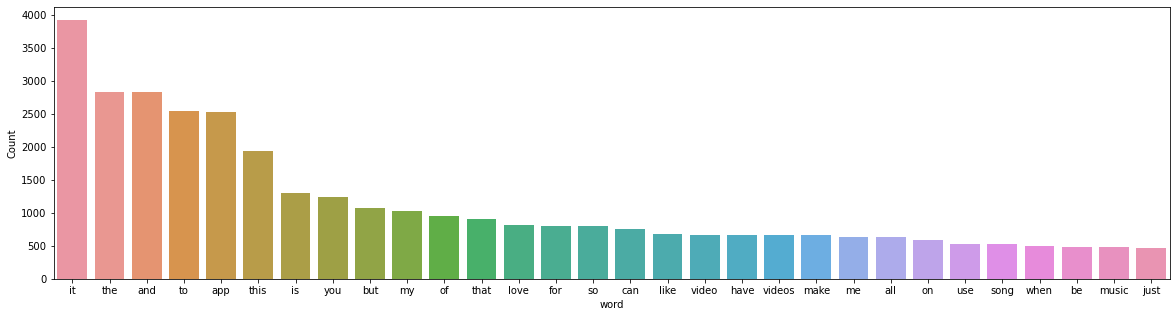

In [38]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us))

In [39]:
# Clean text
review_us_ready = process_words(review_words_us)  # processed Text Data! - move to each section

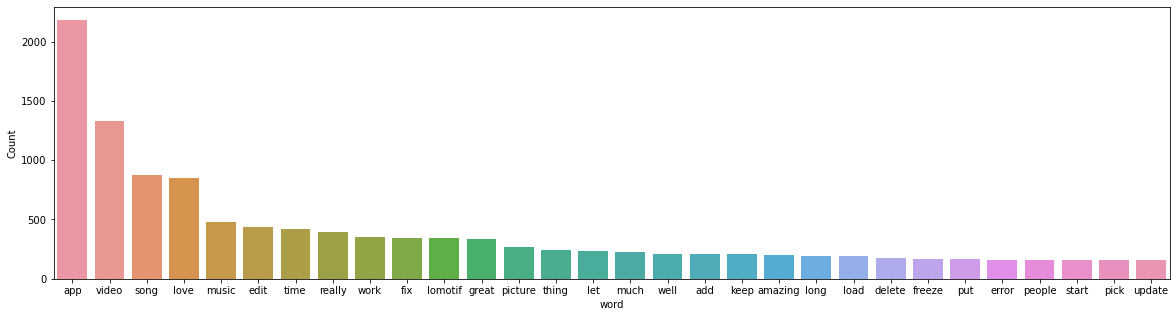

In [40]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready))

In [41]:
# Create Dictionary
id2word_us = corpora.Dictionary(review_us_ready)

2021-10-17 01:56:33,107 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 01:56:33,395 [INFO] gensim.corpora.dictionary - built Dictionary(2042 unique tokens: ['app', 'feature', 'happy', 'hope', 'love']...) from 2476 documents (total 27150 corpus positions)
2021-10-17 01:56:33,460 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(2042 unique tokens: ['app', 'feature', 'happy', 'hope', 'love']...) from 2476 documents (total 27150 corpus positions)", 'datetime': '2021-10-17T01:56:33.396483', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [42]:
# Create Corpus: Term Document Frequency
corpus_us = [id2word_us.doc2bow(text) for text in review_us_ready]

In [43]:
# Training LDA model
model_list_us, coherence_values_us = compute_coherence_values(dictionary=id2word_us, corpus=corpus_us, 
                                                              texts=review_us_ready, limit=30, start=2, step=5)

# Time Start: 03:44
# Time End: 
# Time Used: 

2021-10-17 01:56:33,552 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 01:56:33,555 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 01:56:33,566 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 01:56:33,573 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 2476 documents, updating model once every 1000 documents, evaluating perplexity every 2476 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 01:56:33,575 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/2476
2021-10-17 01:56:37,040 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 01:56:37,044 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.087*"song" + 0.040*"video" + 0.027*"app" + 0.023*"work" + 0.022*"love" + 0.022*"load" + 0.017*"music" + 0.014*"error" + 0.014*"fix" + 0.013

2021-10-17 01:56:54,137 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.105*"app" + 0.052*"video" + 0.038*"love" + 0.018*"really" + 0.017*"edit" + 0.016*"great" + 0.015*"time" + 0.013*"lomotif" + 0.012*"music" + 0.011*"much"
2021-10-17 01:56:54,138 [INFO] gensim.models.ldamodel - topic diff=0.340546, rho=0.392958
2021-10-17 01:56:54,139 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #2000/2476
2021-10-17 01:56:55,519 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 01:56:55,522 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.074*"song" + 0.030*"video" + 0.025*"music" + 0.024*"work" + 0.020*"fix" + 0.018*"app" + 0.016*"load" + 0.015*"let" + 0.014*"time" + 0.012*"error"
2021-10-17 01:56:55,526 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.106*"app" + 0.055*"video" + 0.041*"love" + 0.020*"edit" + 0.017*"really" + 0.016*"great" + 0.015*"time" + 0.012*"lomotif" + 0.012*"much" + 0.011*"music"
2021-10-17

2021-10-17 01:57:07,950 [INFO] gensim.models.ldamodel - topic diff=0.252450, rho=0.324853
2021-10-17 01:57:08,775 [INFO] gensim.models.ldamodel - -6.096 per-word bound, 68.4 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 01:57:08,776 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #2476/2476
2021-10-17 01:57:09,295 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 01:57:09,297 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.065*"song" + 0.029*"music" + 0.028*"video" + 0.020*"fix" + 0.020*"app" + 0.020*"work" + 0.016*"let" + 0.015*"time" + 0.013*"choose" + 0.012*"pick"
2021-10-17 01:57:09,299 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.105*"app" + 0.057*"video" + 0.036*"love" + 0.023*"edit" + 0.017*"really" + 0.015*"time" + 0.015*"great" + 0.013*"lomotif" + 0.011*"much" + 0.011*"thing"
2021-10-17 01:57:09,300 [INFO] gensim.models.ldamodel - topic diff=0.268645

2021-10-17 01:57:21,890 [INFO] gensim.models.ldamodel - topic diff=0.226395, rho=0.283115
2021-10-17 01:57:21,893 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #1000/2476
2021-10-17 01:57:23,278 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 01:57:23,280 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.081*"song" + 0.032*"music" + 0.024*"video" + 0.024*"fix" + 0.022*"app" + 0.022*"work" + 0.018*"let" + 0.017*"load" + 0.016*"error" + 0.015*"time"
2021-10-17 01:57:23,282 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.104*"app" + 0.057*"video" + 0.040*"love" + 0.022*"edit" + 0.019*"really" + 0.015*"great" + 0.014*"time" + 0.014*"lomotif" + 0.012*"much" + 0.011*"thing"
2021-10-17 01:57:23,282 [INFO] gensim.models.ldamodel - topic diff=0.208694, rho=0.272408
2021-10-17 01:57:23,285 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #2000/2476
2021-10-17 01:57:24,400 [INFO] gensim.models.ldamo

2021-10-17 01:57:34,318 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #2000/2476
2021-10-17 01:57:35,532 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 01:57:35,541 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.075*"song" + 0.033*"music" + 0.025*"fix" + 0.024*"video" + 0.023*"app" + 0.022*"work" + 0.018*"let" + 0.016*"time" + 0.016*"load" + 0.014*"pick"
2021-10-17 01:57:35,543 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.105*"app" + 0.059*"video" + 0.042*"love" + 0.024*"edit" + 0.018*"really" + 0.016*"great" + 0.014*"time" + 0.013*"lomotif" + 0.012*"much" + 0.011*"thing"
2021-10-17 01:57:35,545 [INFO] gensim.models.ldamodel - topic diff=0.181231, rho=0.246362
2021-10-17 01:57:36,311 [INFO] gensim.models.ldamodel - -6.072 per-word bound, 67.3 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 01:57:36,313 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, 

2021-10-17 01:57:46,824 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #2476/2476
2021-10-17 01:57:47,396 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 01:57:47,398 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.067*"song" + 0.033*"music" + 0.025*"video" + 0.024*"app" + 0.023*"fix" + 0.020*"work" + 0.017*"let" + 0.016*"time" + 0.013*"pick" + 0.013*"choose"
2021-10-17 01:57:47,400 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.104*"app" + 0.058*"video" + 0.039*"love" + 0.024*"edit" + 0.017*"really" + 0.014*"great" + 0.014*"time" + 0.013*"lomotif" + 0.012*"much" + 0.011*"thing"
2021-10-17 01:57:47,400 [INFO] gensim.models.ldamodel - topic diff=0.173831, rho=0.226595
2021-10-17 01:57:47,402 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #1000/2476
2021-10-17 01:57:48,310 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 01:57:

2021-10-17 01:57:58,838 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 01:57:58,844 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.077*"song" + 0.034*"music" + 0.025*"app" + 0.025*"fix" + 0.024*"video" + 0.021*"work" + 0.018*"let" + 0.016*"load" + 0.016*"time" + 0.014*"error"
2021-10-17 01:57:58,847 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.104*"app" + 0.058*"video" + 0.041*"love" + 0.023*"edit" + 0.019*"really" + 0.015*"great" + 0.014*"lomotif" + 0.014*"time" + 0.012*"much" + 0.011*"thing"
2021-10-17 01:57:58,849 [INFO] gensim.models.ldamodel - topic diff=0.150042, rho=0.206390
2021-10-17 01:57:58,851 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #2000/2476
2021-10-17 01:58:00,151 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 01:58:00,155 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.074*"song" + 0.034*"music" + 0.026*"fix

2021-10-17 01:58:10,918 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.073*"song" + 0.034*"music" + 0.026*"app" + 0.026*"fix" + 0.024*"video" + 0.022*"work" + 0.017*"let" + 0.016*"time" + 0.015*"load" + 0.014*"pick"
2021-10-17 01:58:10,919 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.104*"app" + 0.059*"video" + 0.043*"love" + 0.025*"edit" + 0.018*"really" + 0.015*"great" + 0.014*"time" + 0.013*"lomotif" + 0.012*"much" + 0.011*"thing"
2021-10-17 01:58:10,920 [INFO] gensim.models.ldamodel - topic diff=0.137857, rho=0.194345
2021-10-17 01:58:11,690 [INFO] gensim.models.ldamodel - -6.059 per-word bound, 66.7 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 01:58:11,691 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #2476/2476
2021-10-17 01:58:12,329 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 01:58:12,339 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.

2021-10-17 01:58:23,098 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.067*"song" + 0.033*"music" + 0.027*"app" + 0.025*"video" + 0.024*"fix" + 0.020*"work" + 0.017*"let" + 0.017*"time" + 0.013*"pick" + 0.013*"choose"
2021-10-17 01:58:23,104 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.104*"app" + 0.058*"video" + 0.040*"love" + 0.025*"edit" + 0.018*"really" + 0.014*"great" + 0.014*"time" + 0.013*"lomotif" + 0.012*"much" + 0.011*"thing"
2021-10-17 01:58:23,106 [INFO] gensim.models.ldamodel - topic diff=0.137752, rho=0.184190
2021-10-17 01:58:23,111 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #1000/2476
2021-10-17 01:58:24,190 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 01:58:24,193 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.076*"song" + 0.034*"music" + 0.027*"app" + 0.026*"fix" + 0.024*"video" + 0.021*"work" + 0.018*"let" + 0.016*"time" + 0.016*"load" + 0.014*"error"
2021-10-17 01:5

2021-10-17 01:58:36,789 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.104*"app" + 0.058*"video" + 0.042*"love" + 0.024*"edit" + 0.018*"really" + 0.015*"great" + 0.014*"lomotif" + 0.013*"time" + 0.012*"much" + 0.011*"thing"
2021-10-17 01:58:36,791 [INFO] gensim.models.ldamodel - topic diff=0.122845, rho=0.172836
2021-10-17 01:58:36,792 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #2000/2476
2021-10-17 01:58:37,866 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 01:58:37,870 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.072*"song" + 0.034*"music" + 0.027*"app" + 0.026*"fix" + 0.025*"video" + 0.021*"work" + 0.017*"let" + 0.017*"time" + 0.015*"load" + 0.014*"pick"
2021-10-17 01:58:37,883 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.104*"app" + 0.059*"video" + 0.043*"love" + 0.025*"edit" + 0.018*"really" + 0.015*"great" + 0.014*"time" + 0.013*"lomotif" + 0.012*"much" + 0.011*"thing"
2021-10-17

2021-10-17 01:58:47,549 [INFO] gensim.models.ldamodel - topic diff=0.115337, rho=0.165576
2021-10-17 01:58:48,309 [INFO] gensim.models.ldamodel - -6.054 per-word bound, 66.4 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 01:58:48,310 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #2476/2476
2021-10-17 01:58:48,821 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 01:58:48,824 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.066*"song" + 0.034*"music" + 0.028*"app" + 0.026*"video" + 0.025*"fix" + 0.020*"work" + 0.017*"time" + 0.017*"let" + 0.013*"pick" + 0.013*"load"
2021-10-17 01:58:48,826 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.104*"app" + 0.058*"video" + 0.040*"love" + 0.025*"edit" + 0.018*"really" + 0.014*"great" + 0.014*"time" + 0.013*"lomotif" + 0.012*"much" + 0.011*"thing"
2021-10-17 01:58:48,827 [INFO] gensim.models.ldamodel - topic diff=0.122607,

2021-10-17 01:59:00,428 [INFO] gensim.models.ldamodel - topic diff=0.117435, rho=0.159160
2021-10-17 01:59:00,428 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #1000/2476
2021-10-17 01:59:01,658 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 01:59:01,661 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.074*"song" + 0.034*"music" + 0.029*"app" + 0.026*"fix" + 0.025*"video" + 0.021*"work" + 0.017*"let" + 0.016*"time" + 0.015*"load" + 0.014*"error"
2021-10-17 01:59:01,663 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.103*"app" + 0.058*"video" + 0.042*"love" + 0.024*"edit" + 0.018*"really" + 0.014*"great" + 0.014*"lomotif" + 0.013*"time" + 0.012*"much" + 0.011*"thing"
2021-10-17 01:59:01,665 [INFO] gensim.models.ldamodel - topic diff=0.110484, rho=0.157181
2021-10-17 01:59:01,667 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #2000/2476
2021-10-17 01:59:02,906 [INFO] gensim.models.ldamo

2021-10-17 01:59:13,665 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #2000/2476
2021-10-17 01:59:14,786 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 01:59:14,788 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.071*"song" + 0.034*"music" + 0.029*"app" + 0.026*"fix" + 0.025*"video" + 0.021*"work" + 0.017*"let" + 0.017*"time" + 0.014*"load" + 0.013*"pick"
2021-10-17 01:59:14,790 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.104*"app" + 0.059*"video" + 0.043*"love" + 0.025*"edit" + 0.018*"really" + 0.015*"great" + 0.014*"time" + 0.013*"lomotif" + 0.012*"much" + 0.011*"thing"
2021-10-17 01:59:14,790 [INFO] gensim.models.ldamodel - topic diff=0.104792, rho=0.151661
2021-10-17 01:59:15,454 [INFO] gensim.models.ldamodel - -6.051 per-word bound, 66.3 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 01:59:15,455 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, 

2021-10-17 01:59:26,902 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #2476/2476
2021-10-17 01:59:27,414 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 01:59:27,417 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.066*"song" + 0.034*"music" + 0.029*"app" + 0.027*"video" + 0.025*"fix" + 0.020*"work" + 0.017*"time" + 0.016*"let" + 0.013*"pick" + 0.013*"load"
2021-10-17 01:59:27,421 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.103*"app" + 0.058*"video" + 0.041*"love" + 0.025*"edit" + 0.018*"really" + 0.014*"great" + 0.014*"time" + 0.013*"lomotif" + 0.012*"much" + 0.011*"thing"
2021-10-17 01:59:27,422 [INFO] gensim.models.ldamodel - topic diff=0.107205, rho=0.146685
2021-10-17 01:59:27,423 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #1000/2476
2021-10-17 01:59:28,453 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 01:59:28

2021-10-17 01:59:37,903 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 01:59:37,908 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.072*"song" + 0.034*"music" + 0.030*"app" + 0.026*"fix" + 0.026*"video" + 0.021*"work" + 0.017*"let" + 0.017*"time" + 0.015*"load" + 0.013*"pick"
2021-10-17 01:59:37,911 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.103*"app" + 0.058*"video" + 0.043*"love" + 0.025*"edit" + 0.018*"really" + 0.014*"great" + 0.014*"lomotif" + 0.013*"time" + 0.013*"much" + 0.011*"thing"
2021-10-17 01:59:37,939 [INFO] gensim.models.ldamodel - topic diff=0.097659, rho=0.140753
2021-10-17 01:59:37,941 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #2000/2476
2021-10-17 01:59:38,915 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 01:59:38,918 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.070*"song" + 0.034*"music" + 0.030*"app"

2021-10-17 01:59:55,352 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 01:59:55,360 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 2476 documents, updating model once every 1000 documents, evaluating perplexity every 2476 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 01:59:55,363 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/2476
2021-10-17 01:59:57,875 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 01:59:57,886 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.111*"app" + 0.046*"love" + 0.045*"video" + 0.025*"fix" + 0.023*"music" + 0.015*"song" + 0.015*"great" + 0.013*"really" + 0.012*"lomotif" + 0.012*"much"
2021-10-17 01:59:57,893 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.040*"love" + 0.027*"app" + 0.021*"friend" + 0.020*"video" + 0.019*"music" + 0.0

2021-10-17 02:00:06,595 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.045*"love" + 0.037*"well" + 0.029*"app" + 0.023*"show" + 0.019*"friend" + 0.019*"family" + 0.017*"slide" + 0.016*"child" + 0.014*"feature" + 0.013*"porn"
2021-10-17 02:00:06,600 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.059*"song" + 0.055*"video" + 0.052*"app" + 0.033*"music" + 0.023*"choose" + 0.021*"add" + 0.018*"part" + 0.017*"long" + 0.015*"picture" + 0.013*"thing"
2021-10-17 02:00:06,604 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.076*"video" + 0.042*"app" + 0.035*"freeze" + 0.030*"edit" + 0.026*"start" + 0.024*"glitch" + 0.023*"keep" + 0.021*"photo" + 0.021*"work" + 0.020*"back"
2021-10-17 02:00:06,609 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.069*"app" + 0.035*"people" + 0.033*"edit" + 0.027*"video" + 0.024*"really" + 0.022*"thing" + 0.022*"love" + 0.021*"kid" + 0.020*"sound" + 0.018*"stuff"
2021-10-17 02:00:06,612 [INFO] gensim.models.ldamodel - topic diff=0.395754, rho=0.472

2021-10-17 02:00:13,878 [INFO] gensim.models.ldamodel - topic diff=0.233059, rho=0.392958
2021-10-17 02:00:14,597 [INFO] gensim.models.ldamodel - -6.299 per-word bound, 78.7 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:00:14,598 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #2476/2476
2021-10-17 02:00:15,165 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:00:15,169 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.077*"song" + 0.062*"app" + 0.026*"music" + 0.025*"pick" + 0.022*"let" + 0.021*"work" + 0.020*"time" + 0.018*"fix" + 0.017*"load" + 0.016*"love"
2021-10-17 02:00:15,171 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.081*"video" + 0.042*"app" + 0.042*"freeze" + 0.031*"start" + 0.029*"edit" + 0.029*"time" + 0.025*"keep" + 0.024*"glitch" + 0.024*"back" + 0.021*"photo"
2021-10-17 02:00:15,172 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.084

2021-10-17 02:00:21,788 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.088*"app" + 0.038*"love" + 0.035*"really" + 0.034*"edit" + 0.033*"people" + 0.028*"video" + 0.027*"amazing" + 0.021*"thing" + 0.018*"post" + 0.018*"fun"
2021-10-17 02:00:21,791 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.095*"song" + 0.055*"app" + 0.029*"music" + 0.028*"load" + 0.027*"work" + 0.026*"pick" + 0.025*"fix" + 0.023*"let" + 0.022*"error" + 0.018*"time"
2021-10-17 02:00:21,794 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.066*"song" + 0.057*"video" + 0.047*"app" + 0.044*"music" + 0.030*"add" + 0.024*"long" + 0.021*"choose" + 0.017*"great" + 0.017*"part" + 0.015*"picture"
2021-10-17 02:00:21,795 [INFO] gensim.models.ldamodel - topic diff=0.174478, rho=0.343482
2021-10-17 02:00:22,413 [INFO] gensim.models.ldamodel - -6.262 per-word bound, 76.8 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:00:22,415 [INFO] gensim.models.ldamodel - PROGRESS: pa

2021-10-17 02:00:28,034 [INFO] gensim.models.ldamodel - topic diff=0.179123, rho=0.308960
2021-10-17 02:00:28,035 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #2000/2476
2021-10-17 02:00:29,309 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:00:29,312 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.041*"update" + 0.036*"lomotif" + 0.031*"work" + 0.028*"video" + 0.025*"progress" + 0.024*"new" + 0.019*"delete" + 0.018*"still" + 0.016*"day" + 0.014*"watermark"
2021-10-17 02:00:29,314 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.093*"app" + 0.041*"love" + 0.036*"really" + 0.033*"edit" + 0.033*"people" + 0.028*"video" + 0.027*"amazing" + 0.021*"thing" + 0.019*"fun" + 0.018*"post"
2021-10-17 02:00:29,315 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.062*"song" + 0.060*"video" + 0.047*"music" + 0.047*"app" + 0.033*"add" + 0.025*"long" + 0.020*"choose" + 0.018*"great" + 0.017*"part" + 0.015*"pict

2021-10-17 02:00:35,897 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.045*"love" + 0.038*"show" + 0.034*"family" + 0.033*"slide" + 0.032*"friend" + 0.028*"well" + 0.018*"feature" + 0.016*"child" + 0.014*"way" + 0.012*"alot"
2021-10-17 02:00:35,900 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.111*"song" + 0.050*"app" + 0.033*"load" + 0.032*"fix" + 0.029*"error" + 0.029*"music" + 0.027*"work" + 0.025*"let" + 0.023*"pick" + 0.018*"time"
2021-10-17 02:00:35,903 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.094*"app" + 0.038*"love" + 0.035*"really" + 0.034*"people" + 0.029*"edit" + 0.028*"video" + 0.022*"amazing" + 0.022*"thing" + 0.019*"post" + 0.018*"fun"
2021-10-17 02:00:35,904 [INFO] gensim.models.ldamodel - topic diff=0.158356, rho=0.283115
2021-10-17 02:00:35,913 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #2000/2476
2021-10-17 02:00:37,135 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17

2021-10-17 02:00:42,067 [INFO] gensim.models.ldamodel - topic diff=0.123182, rho=0.272408
2021-10-17 02:00:42,084 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #1000/2476
2021-10-17 02:00:43,178 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:00:43,182 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.089*"video" + 0.047*"freeze" + 0.043*"app" + 0.043*"time" + 0.036*"start" + 0.028*"edit" + 0.027*"keep" + 0.026*"save" + 0.023*"back" + 0.022*"fix"
2021-10-17 02:00:43,184 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.095*"app" + 0.039*"love" + 0.035*"really" + 0.034*"people" + 0.028*"edit" + 0.027*"video" + 0.022*"amazing" + 0.022*"thing" + 0.019*"post" + 0.019*"much"
2021-10-17 02:00:43,185 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.131*"app" + 0.059*"video" + 0.051*"love" + 0.023*"edit" + 0.019*"time" + 0.016*"great" + 0.016*"crash" + 0.015*"much" + 0.014*"really" + 0.012*"picture"
2021-1

2021-10-17 02:00:49,207 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.097*"song" + 0.050*"app" + 0.030*"fix" + 0.028*"music" + 0.028*"load" + 0.025*"work" + 0.024*"let" + 0.024*"pick" + 0.022*"error" + 0.018*"time"
2021-10-17 02:00:49,209 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.132*"app" + 0.060*"video" + 0.047*"love" + 0.024*"edit" + 0.020*"time" + 0.019*"crash" + 0.016*"great" + 0.015*"much" + 0.014*"really" + 0.012*"recommend"
2021-10-17 02:00:49,211 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.040*"show" + 0.038*"love" + 0.032*"family" + 0.031*"slide" + 0.029*"well" + 0.024*"friend" + 0.020*"child" + 0.017*"feature" + 0.014*"tiktok" + 0.013*"porn"
2021-10-17 02:00:49,213 [INFO] gensim.models.ldamodel - topic diff=0.113709, rho=0.254197
2021-10-17 02:00:49,215 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #1000/2476
2021-10-17 02:00:50,398 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021

2021-10-17 02:00:56,670 [INFO] gensim.models.ldamodel - -6.215 per-word bound, 74.3 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:00:56,672 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #2476/2476
2021-10-17 02:00:57,307 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:00:57,310 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.096*"app" + 0.039*"love" + 0.034*"really" + 0.034*"people" + 0.029*"edit" + 0.027*"video" + 0.022*"thing" + 0.022*"amazing" + 0.020*"much" + 0.018*"post"
2021-10-17 02:00:57,313 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.133*"app" + 0.059*"video" + 0.047*"love" + 0.024*"edit" + 0.020*"time" + 0.019*"crash" + 0.016*"great" + 0.015*"much" + 0.014*"really" + 0.012*"recommend"
2021-10-17 02:00:57,316 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.099*"song" + 0.049*"app" + 0.031*"fix" + 0.029*"load" + 0.028*"music" + 0.025*"

2021-10-17 02:01:03,110 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.108*"song" + 0.047*"app" + 0.033*"load" + 0.033*"fix" + 0.030*"music" + 0.027*"error" + 0.027*"work" + 0.024*"let" + 0.024*"pick" + 0.018*"time"
2021-10-17 02:01:03,114 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.068*"video" + 0.054*"music" + 0.053*"app" + 0.051*"song" + 0.037*"add" + 0.028*"long" + 0.021*"great" + 0.021*"love" + 0.020*"second" + 0.018*"choose"
2021-10-17 02:01:03,117 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.046*"show" + 0.040*"love" + 0.039*"family" + 0.039*"slide" + 0.027*"friend" + 0.024*"well" + 0.017*"feature" + 0.014*"child" + 0.011*"alot" + 0.011*"profile"
2021-10-17 02:01:03,118 [INFO] gensim.models.ldamodel - topic diff=0.093841, rho=0.226595
2021-10-17 02:01:03,778 [INFO] gensim.models.ldamodel - -6.210 per-word bound, 74.0 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:01:03,780 [INFO] gensim.models.ldamodel - PROGRESS

2021-10-17 02:01:08,805 [INFO] gensim.models.ldamodel - topic diff=0.114290, rho=0.215786
2021-10-17 02:01:08,809 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #2000/2476
2021-10-17 02:01:09,850 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:01:09,859 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.069*"video" + 0.055*"app" + 0.054*"music" + 0.050*"song" + 0.037*"add" + 0.029*"long" + 0.023*"love" + 0.021*"great" + 0.021*"second" + 0.018*"choose"
2021-10-17 02:01:09,870 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.097*"app" + 0.045*"love" + 0.036*"really" + 0.033*"people" + 0.032*"edit" + 0.026*"video" + 0.026*"amazing" + 0.022*"thing" + 0.021*"much" + 0.019*"fun"
2021-10-17 02:01:09,876 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.047*"show" + 0.039*"family" + 0.039*"slide" + 0.038*"love" + 0.026*"friend" + 0.024*"well" + 0.017*"feature" + 0.014*"child" + 0.011*"alot" + 0.011*"tiktok"


2021-10-17 02:01:15,471 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.061*"update" + 0.049*"new" + 0.032*"lomotif" + 0.025*"work" + 0.021*"still" + 0.020*"progress" + 0.020*"video" + 0.018*"back" + 0.018*"delete" + 0.016*"anymore"
2021-10-17 02:01:15,472 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.134*"app" + 0.056*"video" + 0.050*"love" + 0.022*"edit" + 0.018*"time" + 0.017*"crash" + 0.016*"much" + 0.015*"really" + 0.015*"great" + 0.013*"picture"
2021-10-17 02:01:15,480 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.114*"song" + 0.047*"app" + 0.034*"fix" + 0.034*"load" + 0.031*"music" + 0.030*"error" + 0.027*"work" + 0.025*"let" + 0.023*"pick" + 0.018*"time"
2021-10-17 02:01:15,484 [INFO] gensim.models.ldamodel - topic diff=0.108503, rho=0.206390
2021-10-17 02:01:15,489 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #2000/2476
2021-10-17 02:01:16,513 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
20

2021-10-17 02:01:21,233 [INFO] gensim.models.ldamodel - topic diff=0.087328, rho=0.202130
2021-10-17 02:01:21,235 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #1000/2476
2021-10-17 02:01:22,288 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:01:22,292 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.045*"show" + 0.035*"family" + 0.035*"slide" + 0.034*"love" + 0.025*"friend" + 0.024*"well" + 0.018*"feature" + 0.017*"child" + 0.012*"tiktok" + 0.012*"alot"
2021-10-17 02:01:22,293 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.134*"app" + 0.056*"video" + 0.050*"love" + 0.022*"edit" + 0.018*"time" + 0.017*"crash" + 0.016*"much" + 0.015*"really" + 0.015*"great" + 0.013*"picture"
2021-10-17 02:01:22,294 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.062*"update" + 0.050*"new" + 0.032*"lomotif" + 0.025*"work" + 0.021*"still" + 0.020*"progress" + 0.019*"video" + 0.018*"back" + 0.017*"delete" + 0.016*

2021-10-17 02:01:27,944 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.097*"app" + 0.042*"love" + 0.034*"really" + 0.034*"people" + 0.030*"edit" + 0.025*"video" + 0.023*"amazing" + 0.023*"thing" + 0.021*"much" + 0.018*"fun"
2021-10-17 02:01:27,946 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.134*"app" + 0.057*"video" + 0.047*"love" + 0.023*"edit" + 0.019*"crash" + 0.018*"time" + 0.016*"much" + 0.015*"really" + 0.015*"great" + 0.013*"recommend"
2021-10-17 02:01:27,948 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.069*"video" + 0.056*"app" + 0.056*"music" + 0.047*"song" + 0.038*"add" + 0.028*"long" + 0.023*"love" + 0.021*"great" + 0.021*"second" + 0.018*"choose"
2021-10-17 02:01:27,949 [INFO] gensim.models.ldamodel - topic diff=0.083543, rho=0.194345
2021-10-17 02:01:27,950 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1000/2476
2021-10-17 02:01:29,037 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
20

2021-10-17 02:01:34,316 [INFO] gensim.models.ldamodel - -6.197 per-word bound, 73.4 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:01:34,318 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #2476/2476
2021-10-17 02:01:34,823 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:01:34,826 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.098*"app" + 0.043*"love" + 0.034*"people" + 0.034*"really" + 0.030*"edit" + 0.025*"video" + 0.023*"amazing" + 0.023*"thing" + 0.021*"much" + 0.019*"fun"
2021-10-17 02:01:34,828 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.104*"song" + 0.047*"app" + 0.031*"fix" + 0.030*"music" + 0.030*"load" + 0.026*"work" + 0.025*"let" + 0.024*"error" + 0.024*"pick" + 0.017*"time"
2021-10-17 02:01:34,830 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.135*"app" + 0.056*"video" + 0.047*"love" + 0.023*"edit" + 0.020*"crash" + 0.018*"time" + 0

2021-10-17 02:01:40,974 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.098*"app" + 0.048*"love" + 0.035*"really" + 0.033*"people" + 0.032*"edit" + 0.026*"amazing" + 0.025*"video" + 0.022*"much" + 0.022*"thing" + 0.020*"fun"
2021-10-17 02:01:40,977 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.110*"song" + 0.046*"app" + 0.033*"load" + 0.033*"fix" + 0.031*"music" + 0.028*"error" + 0.027*"work" + 0.024*"let" + 0.024*"pick" + 0.018*"time"
2021-10-17 02:01:40,979 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.061*"update" + 0.049*"new" + 0.032*"lomotif" + 0.023*"work" + 0.023*"progress" + 0.020*"still" + 0.017*"back" + 0.017*"delete" + 0.017*"video" + 0.016*"anymore"
2021-10-17 02:01:40,981 [INFO] gensim.models.ldamodel - topic diff=0.071503, rho=0.181143
2021-10-17 02:01:41,804 [INFO] gensim.models.ldamodel - -6.196 per-word bound, 73.3 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:01:41,805 [INFO] gensim.models.ldamodel - PRO

2021-10-17 02:01:47,407 [INFO] gensim.models.ldamodel - topic diff=0.089270, rho=0.175476
2021-10-17 02:01:47,411 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #2000/2476
2021-10-17 02:01:48,601 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:01:48,606 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.135*"app" + 0.056*"video" + 0.049*"love" + 0.022*"edit" + 0.019*"crash" + 0.017*"time" + 0.016*"much" + 0.015*"great" + 0.015*"really" + 0.013*"recommend"
2021-10-17 02:01:48,611 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.071*"video" + 0.057*"app" + 0.055*"music" + 0.046*"song" + 0.038*"add" + 0.029*"long" + 0.025*"love" + 0.022*"second" + 0.022*"great" + 0.017*"choose"
2021-10-17 02:01:48,616 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.048*"show" + 0.039*"family" + 0.038*"slide" + 0.035*"love" + 0.024*"friend" + 0.024*"well" + 0.017*"feature" + 0.015*"child" + 0.011*"alot" + 0.011*"tiktok

2021-10-17 02:01:54,236 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.048*"show" + 0.036*"family" + 0.035*"slide" + 0.033*"love" + 0.024*"well" + 0.023*"friend" + 0.017*"feature" + 0.017*"child" + 0.013*"tiktok" + 0.012*"alot"
2021-10-17 02:01:54,239 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.064*"update" + 0.051*"new" + 0.032*"lomotif" + 0.023*"work" + 0.021*"progress" + 0.020*"still" + 0.019*"back" + 0.017*"delete" + 0.016*"anymore" + 0.016*"video"
2021-10-17 02:01:54,242 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.134*"app" + 0.055*"video" + 0.048*"love" + 0.022*"edit" + 0.018*"crash" + 0.017*"time" + 0.016*"much" + 0.015*"really" + 0.014*"great" + 0.013*"picture"
2021-10-17 02:01:54,245 [INFO] gensim.models.ldamodel - topic diff=0.086282, rho=0.170311
2021-10-17 02:01:54,248 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #2000/2476
2021-10-17 02:01:55,313 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 

2021-10-17 02:02:00,040 [INFO] gensim.models.ldamodel - topic diff=0.071346, rho=0.167893
2021-10-17 02:02:00,041 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #1000/2476
2021-10-17 02:02:01,100 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:02:01,121 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.065*"update" + 0.051*"new" + 0.032*"lomotif" + 0.022*"work" + 0.021*"progress" + 0.020*"still" + 0.019*"back" + 0.017*"delete" + 0.016*"anymore" + 0.015*"video"
2021-10-17 02:02:01,129 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.133*"app" + 0.055*"video" + 0.048*"love" + 0.022*"edit" + 0.018*"crash" + 0.017*"time" + 0.016*"much" + 0.015*"really" + 0.015*"great" + 0.013*"picture"
2021-10-17 02:02:01,133 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.050*"show" + 0.036*"family" + 0.035*"slide" + 0.032*"love" + 0.024*"well" + 0.023*"friend" + 0.017*"feature" + 0.017*"child" + 0.012*"tiktok" + 0.0

2021-10-17 02:02:07,916 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.095*"video" + 0.050*"freeze" + 0.049*"time" + 0.049*"app" + 0.034*"start" + 0.029*"edit" + 0.027*"save" + 0.026*"keep" + 0.023*"fix" + 0.022*"photo"
2021-10-17 02:02:07,918 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.106*"song" + 0.046*"app" + 0.031*"fix" + 0.031*"music" + 0.030*"load" + 0.026*"work" + 0.025*"error" + 0.025*"let" + 0.024*"pick" + 0.017*"time"
2021-10-17 02:02:07,919 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.134*"app" + 0.056*"video" + 0.046*"love" + 0.022*"edit" + 0.020*"crash" + 0.018*"time" + 0.015*"much" + 0.015*"really" + 0.014*"great" + 0.013*"recommend"
2021-10-17 02:02:07,924 [INFO] gensim.models.ldamodel - topic diff=0.069130, rho=0.163352
2021-10-17 02:02:07,925 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #1000/2476
2021-10-17 02:02:09,000 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 0

2021-10-17 02:02:14,080 [INFO] gensim.models.ldamodel - -6.190 per-word bound, 73.0 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:02:14,081 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #2476/2476
2021-10-17 02:02:14,546 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:02:14,551 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.095*"video" + 0.050*"freeze" + 0.049*"time" + 0.049*"app" + 0.034*"start" + 0.029*"edit" + 0.027*"save" + 0.025*"keep" + 0.023*"fix" + 0.023*"photo"
2021-10-17 02:02:14,554 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.071*"video" + 0.059*"app" + 0.056*"music" + 0.044*"song" + 0.038*"add" + 0.028*"long" + 0.025*"love" + 0.021*"second" + 0.021*"great" + 0.017*"choose"
2021-10-17 02:02:14,557 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.051*"show" + 0.034*"family" + 0.033*"slide" + 0.031*"love" + 0.026*"well" + 0.021*"frien

2021-10-17 02:02:19,934 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.100*"app" + 0.050*"love" + 0.035*"really" + 0.034*"people" + 0.032*"edit" + 0.025*"amazing" + 0.024*"video" + 0.023*"much" + 0.022*"thing" + 0.022*"fun"
2021-10-17 02:02:19,936 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.134*"app" + 0.055*"video" + 0.048*"love" + 0.022*"edit" + 0.019*"crash" + 0.017*"time" + 0.016*"much" + 0.015*"great" + 0.015*"really" + 0.013*"recommend"
2021-10-17 02:02:19,939 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.062*"update" + 0.050*"new" + 0.031*"lomotif" + 0.023*"progress" + 0.021*"work" + 0.019*"still" + 0.018*"back" + 0.017*"delete" + 0.016*"anymore" + 0.015*"slow"
2021-10-17 02:02:19,940 [INFO] gensim.models.ldamodel - topic diff=0.059659, rho=0.155275
2021-10-17 02:02:20,626 [INFO] gensim.models.ldamodel - -6.189 per-word bound, 72.9 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:02:20,633 [INFO] gensim.models.ldamo

2021-10-17 02:02:25,452 [INFO] gensim.models.ldamodel - topic diff=0.075569, rho=0.151661
2021-10-17 02:02:25,454 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #2000/2476
2021-10-17 02:02:26,563 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:02:26,567 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.062*"update" + 0.050*"new" + 0.031*"lomotif" + 0.023*"progress" + 0.021*"work" + 0.019*"still" + 0.018*"back" + 0.017*"delete" + 0.016*"anymore" + 0.015*"slow"
2021-10-17 02:02:26,569 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.072*"video" + 0.059*"app" + 0.055*"music" + 0.044*"song" + 0.038*"add" + 0.029*"long" + 0.026*"love" + 0.022*"second" + 0.021*"great" + 0.017*"wish"
2021-10-17 02:02:26,570 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.054*"show" + 0.039*"family" + 0.038*"slide" + 0.033*"love" + 0.024*"well" + 0.023*"friend" + 0.016*"feature" + 0.015*"child" + 0.012*"tiktok" + 0.011*"a

2021-10-17 02:02:32,184 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.096*"video" + 0.050*"time" + 0.048*"app" + 0.047*"freeze" + 0.033*"start" + 0.028*"edit" + 0.027*"save" + 0.025*"keep" + 0.024*"photo" + 0.023*"fix"
2021-10-17 02:02:32,186 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.133*"app" + 0.055*"video" + 0.046*"love" + 0.021*"edit" + 0.018*"crash" + 0.017*"time" + 0.015*"much" + 0.015*"really" + 0.014*"great" + 0.013*"picture"
2021-10-17 02:02:32,188 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.100*"app" + 0.049*"love" + 0.035*"people" + 0.035*"really" + 0.031*"edit" + 0.024*"much" + 0.023*"video" + 0.023*"amazing" + 0.023*"thing" + 0.022*"fun"
2021-10-17 02:02:32,189 [INFO] gensim.models.ldamodel - topic diff=0.073597, rho=0.148289
2021-10-17 02:02:32,191 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #2000/2476
2021-10-17 02:02:33,387 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-1

2021-10-17 02:02:39,194 [INFO] gensim.models.ldamodel - topic diff=0.061525, rho=0.146685
2021-10-17 02:02:39,198 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #1000/2476
2021-10-17 02:02:40,923 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:02:40,927 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.096*"video" + 0.050*"time" + 0.048*"app" + 0.047*"freeze" + 0.033*"start" + 0.028*"edit" + 0.027*"save" + 0.025*"keep" + 0.024*"photo" + 0.023*"fix"
2021-10-17 02:02:40,928 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.054*"show" + 0.036*"family" + 0.035*"slide" + 0.031*"love" + 0.023*"well" + 0.022*"friend" + 0.017*"feature" + 0.017*"child" + 0.013*"tiktok" + 0.012*"alot"
2021-10-17 02:02:40,929 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.065*"update" + 0.051*"new" + 0.032*"lomotif" + 0.021*"progress" + 0.021*"work" + 0.020*"still" + 0.019*"back" + 0.016*"delete" + 0.016*"anymore" + 0.016*"o

2021-10-17 02:02:48,235 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.097*"video" + 0.051*"time" + 0.050*"freeze" + 0.049*"app" + 0.033*"start" + 0.029*"edit" + 0.027*"save" + 0.025*"keep" + 0.024*"photo" + 0.022*"fix"
2021-10-17 02:02:48,241 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.065*"update" + 0.053*"new" + 0.030*"lomotif" + 0.024*"progress" + 0.019*"back" + 0.019*"still" + 0.019*"work" + 0.017*"anymore" + 0.016*"delete" + 0.015*"old"
2021-10-17 02:02:48,243 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.108*"song" + 0.046*"app" + 0.031*"music" + 0.031*"fix" + 0.030*"load" + 0.026*"work" + 0.025*"let" + 0.025*"error" + 0.024*"pick" + 0.017*"time"
2021-10-17 02:02:48,244 [INFO] gensim.models.ldamodel - topic diff=0.060110, rho=0.143627
2021-10-17 02:02:48,247 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #1000/2476
2021-10-17 02:02:49,587 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-

2021-10-17 02:02:55,298 [INFO] gensim.models.ldamodel - -6.186 per-word bound, 72.8 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:02:55,300 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #2476/2476
2021-10-17 02:02:55,919 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:02:55,926 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.054*"show" + 0.034*"family" + 0.033*"slide" + 0.030*"love" + 0.025*"well" + 0.021*"friend" + 0.018*"child" + 0.016*"feature" + 0.014*"tiktok" + 0.012*"porn"
2021-10-17 02:02:55,937 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.101*"app" + 0.052*"love" + 0.035*"people" + 0.034*"really" + 0.031*"edit" + 0.025*"much" + 0.023*"video" + 0.023*"amazing" + 0.022*"thing" + 0.022*"fun"
2021-10-17 02:02:55,939 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.133*"app" + 0.055*"video" + 0.042*"love" + 0.021*"edit" + 0.020*"crash" + 0.01

2021-10-17 02:03:04,676 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.072*"video" + 0.060*"app" + 0.055*"music" + 0.042*"song" + 0.038*"add" + 0.029*"long" + 0.028*"love" + 0.022*"second" + 0.022*"great" + 0.018*"wish"
2021-10-17 02:03:04,678 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.102*"app" + 0.056*"love" + 0.035*"really" + 0.034*"people" + 0.033*"edit" + 0.026*"much" + 0.025*"amazing" + 0.023*"video" + 0.023*"fun" + 0.022*"thing"
2021-10-17 02:03:04,680 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.098*"video" + 0.051*"freeze" + 0.050*"time" + 0.049*"app" + 0.033*"start" + 0.028*"edit" + 0.028*"save" + 0.025*"keep" + 0.024*"photo" + 0.023*"fix"
2021-10-17 02:03:04,682 [INFO] gensim.models.ldamodel - topic diff=0.052148, rho=0.138045
2021-10-17 02:03:05,447 [INFO] gensim.models.ldamodel - -6.185 per-word bound, 72.8 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:03:05,469 [INFO] gensim.models.ldamodel - PROGRESS: p

2021-10-17 02:03:19,358 [INFO] gensim.models.ldamodel - topic diff=0.396276, rho=0.577350
2021-10-17 02:03:19,360 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #1000/2476
2021-10-17 02:03:20,758 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:03:20,806 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.064*"video" + 0.041*"photo" + 0.038*"glitch" + 0.034*"fix" + 0.032*"keep" + 0.030*"start" + 0.029*"edit" + 0.023*"work" + 0.022*"glitche" + 0.021*"app"
2021-10-17 02:03:20,808 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.089*"song" + 0.047*"app" + 0.046*"video" + 0.026*"choose" + 0.020*"play" + 0.020*"lomotif" + 0.018*"guy" + 0.017*"music" + 0.014*"change" + 0.013*"error"
2021-10-17 02:03:20,813 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.077*"video" + 0.053*"app" + 0.047*"second" + 0.044*"time" + 0.032*"long" + 0.028*"put" + 0.028*"picture" + 0.019*"freeze" + 0.018*"lomotif" + 0.017*"edit"
2

2021-10-17 02:03:29,489 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.086*"app" + 0.066*"video" + 0.063*"music" + 0.033*"add" + 0.030*"freeze" + 0.029*"edit" + 0.022*"sound" + 0.021*"love" + 0.017*"clip" + 0.014*"time"
2021-10-17 02:03:29,491 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.035*"update" + 0.033*"log" + 0.025*"app" + 0.023*"review" + 0.022*"still" + 0.022*"lomotif" + 0.021*"full" + 0.020*"song" + 0.016*"send" + 0.015*"number"
2021-10-17 02:03:29,495 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.109*"video" + 0.056*"app" + 0.053*"time" + 0.052*"freeze" + 0.046*"second" + 0.038*"long" + 0.029*"put" + 0.022*"picture" + 0.021*"minute" + 0.020*"delete"
2021-10-17 02:03:29,498 [INFO] gensim.models.ldamodel - topic diff=0.289899, rho=0.427335
2021-10-17 02:03:29,501 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #1000/2476
2021-10-17 02:03:30,737 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
20

2021-10-17 02:03:37,692 [INFO] gensim.models.ldamodel - -6.610 per-word bound, 97.7 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:03:37,719 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #2476/2476
2021-10-17 02:03:38,353 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:03:38,392 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.036*"log" + 0.030*"update" + 0.028*"review" + 0.025*"full" + 0.025*"still" + 0.022*"lomotif" + 0.019*"mute" + 0.018*"button" + 0.017*"original" + 0.017*"send"
2021-10-17 02:03:38,432 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.086*"song" + 0.041*"app" + 0.035*"video" + 0.029*"choose" + 0.025*"part" + 0.020*"music" + 0.018*"play" + 0.017*"new" + 0.017*"guy" + 0.016*"screen"
2021-10-17 02:03:38,435 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.103*"song" + 0.055*"app" + 0.033*"work" + 0.031*"let" + 0.030*"pick" + 0.021*"ki

2021-10-17 02:03:45,903 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.067*"video" + 0.046*"app" + 0.041*"picture" + 0.026*"thing" + 0.019*"load" + 0.017*"really" + 0.017*"lomotif" + 0.016*"different" + 0.016*"song" + 0.016*"tok"
2021-10-17 02:03:45,907 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.158*"app" + 0.128*"love" + 0.049*"video" + 0.038*"edit" + 0.038*"much" + 0.029*"really" + 0.025*"amazing" + 0.024*"great" + 0.019*"friend" + 0.018*"ever"
2021-10-17 02:03:45,911 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.034*"log" + 0.027*"full" + 0.027*"update" + 0.024*"review" + 0.021*"still" + 0.021*"send" + 0.018*"lomotif" + 0.017*"musically" + 0.016*"well" + 0.015*"length"
2021-10-17 02:03:45,914 [INFO] gensim.models.ldamodel - topic diff=0.146777, rho=0.324853
2021-10-17 02:03:46,721 [INFO] gensim.models.ldamodel - -6.392 per-word bound, 84.0 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:03:46,722 [INFO] gensim.model

2021-10-17 02:03:52,130 [INFO] gensim.models.ldamodel - topic diff=0.128134, rho=0.295192
2021-10-17 02:03:52,132 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #2000/2476
2021-10-17 02:03:53,196 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:03:53,201 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.089*"people" + 0.042*"post" + 0.030*"vid" + 0.027*"app" + 0.024*"inappropriate" + 0.024*"camera" + 0.022*"stuff" + 0.022*"let" + 0.021*"thing" + 0.020*"roll"
2021-10-17 02:03:53,202 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.084*"app" + 0.081*"music" + 0.061*"video" + 0.042*"add" + 0.020*"great" + 0.020*"transition" + 0.018*"clip" + 0.018*"sound" + 0.018*"love" + 0.016*"edit"
2021-10-17 02:03:53,204 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.087*"song" + 0.038*"app" + 0.032*"video" + 0.027*"part" + 0.027*"choose" + 0.021*"music" + 0.017*"guy" + 0.016*"change" + 0.016*"play" + 0.015*"new"
2

2021-10-17 02:03:58,875 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.059*"lomotif" + 0.041*"work" + 0.032*"update" + 0.028*"awesome" + 0.026*"shuffle" + 0.023*"stupid" + 0.022*"ask" + 0.021*"mess" + 0.021*"sign" + 0.019*"first"
2021-10-17 02:03:58,877 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.155*"app" + 0.129*"love" + 0.048*"video" + 0.037*"much" + 0.036*"edit" + 0.033*"really" + 0.025*"great" + 0.023*"amazing" + 0.020*"fun" + 0.020*"friend"
2021-10-17 02:03:58,879 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.134*"video" + 0.072*"long" + 0.066*"second" + 0.063*"freeze" + 0.060*"time" + 0.048*"app" + 0.029*"minute" + 0.026*"put" + 0.018*"edit" + 0.017*"picture"
2021-10-17 02:03:58,880 [INFO] gensim.models.ldamodel - topic diff=0.113268, rho=0.272408
2021-10-17 02:03:58,881 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #2000/2476
2021-10-17 02:03:59,939 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 docum

2021-10-17 02:04:04,966 [INFO] gensim.models.ldamodel - topic diff=0.109921, rho=0.262830
2021-10-17 02:04:04,968 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #1000/2476
2021-10-17 02:04:05,996 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:04:06,001 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.035*"log" + 0.032*"review" + 0.027*"full" + 0.026*"still" + 0.020*"update" + 0.019*"original" + 0.019*"musically" + 0.018*"big" + 0.017*"send" + 0.017*"well"
2021-10-17 02:04:06,004 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.079*"video" + 0.051*"photo" + 0.050*"start" + 0.042*"edit" + 0.039*"glitch" + 0.039*"back" + 0.033*"time" + 0.033*"app" + 0.030*"keep" + 0.027*"save"
2021-10-17 02:04:06,006 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.084*"music" + 0.083*"app" + 0.060*"video" + 0.047*"add" + 0.021*"great" + 0.021*"sound" + 0.020*"clip" + 0.018*"transition" + 0.016*"love" + 0.015*"prog

2021-10-17 02:04:12,108 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.070*"song" + 0.037*"app" + 0.031*"video" + 0.028*"part" + 0.024*"update" + 0.023*"choose" + 0.022*"music" + 0.021*"new" + 0.016*"change" + 0.016*"guy"
2021-10-17 02:04:12,111 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.135*"video" + 0.078*"freeze" + 0.071*"long" + 0.063*"time" + 0.055*"second" + 0.048*"app" + 0.031*"minute" + 0.025*"put" + 0.017*"edit" + 0.016*"hard"
2021-10-17 02:04:12,115 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.132*"song" + 0.041*"app" + 0.033*"let" + 0.033*"work" + 0.032*"pick" + 0.029*"fix" + 0.029*"load" + 0.029*"error" + 0.022*"music" + 0.016*"select"
2021-10-17 02:04:12,121 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.086*"people" + 0.041*"post" + 0.033*"inappropriate" + 0.031*"vid" + 0.028*"app" + 0.025*"camera" + 0.025*"stuff" + 0.023*"thing" + 0.021*"tiktok" + 0.021*"child"
2021-10-17 02:04:12,122 [INFO] gensim.models.ldamodel - topic diff=0.101966, rho=0.24

2021-10-17 02:04:17,804 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.115*"app" + 0.053*"video" + 0.033*"time" + 0.031*"crash" + 0.025*"delete" + 0.024*"fix" + 0.022*"work" + 0.019*"keep" + 0.017*"edit" + 0.017*"save"
2021-10-17 02:04:17,806 [INFO] gensim.models.ldamodel - topic diff=0.082118, rho=0.232646
2021-10-17 02:04:18,580 [INFO] gensim.models.ldamodel - -6.263 per-word bound, 76.8 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:04:18,581 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #2476/2476
2021-10-17 02:04:19,204 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:04:19,209 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.047*"lomotif" + 0.030*"work" + 0.029*"shuffle" + 0.028*"awesome" + 0.027*"stupid" + 0.025*"ask" + 0.025*"mess" + 0.024*"sign" + 0.021*"next" + 0.020*"first"
2021-10-17 02:04:19,212 [INFO] gensim.models.ldamodel - topic #1 (0.0

2021-10-17 02:04:25,199 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.094*"people" + 0.043*"post" + 0.032*"vid" + 0.028*"inappropriate" + 0.025*"camera" + 0.025*"app" + 0.023*"let" + 0.023*"stuff" + 0.021*"roll" + 0.021*"thing"
2021-10-17 02:04:25,201 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.072*"song" + 0.036*"app" + 0.031*"video" + 0.028*"part" + 0.023*"update" + 0.021*"music" + 0.021*"choose" + 0.020*"new" + 0.018*"change" + 0.016*"guy"
2021-10-17 02:04:25,203 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.085*"music" + 0.084*"app" + 0.063*"video" + 0.048*"add" + 0.023*"great" + 0.022*"transition" + 0.021*"clip" + 0.020*"sound" + 0.017*"progress" + 0.013*"overall"
2021-10-17 02:04:25,207 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.156*"app" + 0.133*"love" + 0.048*"video" + 0.040*"edit" + 0.035*"really" + 0.035*"much" + 0.027*"great" + 0.025*"amazing" + 0.020*"friend" + 0.020*"ever"
2021-10-17 02:04:25,207 [INFO] gensim.models.ldamodel - topic diff=0.075

2021-10-17 02:04:32,455 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.086*"music" + 0.083*"app" + 0.062*"video" + 0.050*"add" + 0.023*"great" + 0.022*"clip" + 0.022*"sound" + 0.020*"transition" + 0.016*"progress" + 0.013*"far"
2021-10-17 02:04:32,457 [INFO] gensim.models.ldamodel - topic diff=0.081779, rho=0.210931
2021-10-17 02:04:32,458 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #2000/2476
2021-10-17 02:04:33,627 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:04:33,687 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.071*"video" + 0.050*"app" + 0.043*"picture" + 0.027*"thing" + 0.022*"fast" + 0.019*"tok" + 0.017*"different" + 0.017*"lomotif" + 0.016*"long" + 0.016*"little"
2021-10-17 02:04:33,689 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.083*"video" + 0.048*"photo" + 0.047*"edit" + 0.045*"start" + 0.039*"glitch" + 0.039*"app" + 0.037*"back" + 0.035*"time" + 0.030*"keep" + 0.029*"

2021-10-17 02:04:39,577 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.085*"video" + 0.051*"photo" + 0.047*"edit" + 0.043*"start" + 0.040*"back" + 0.038*"app" + 0.038*"glitch" + 0.035*"time" + 0.028*"keep" + 0.027*"save"
2021-10-17 02:04:39,578 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.093*"people" + 0.041*"post" + 0.033*"inappropriate" + 0.031*"vid" + 0.026*"app" + 0.026*"camera" + 0.023*"let" + 0.023*"stuff" + 0.022*"thing" + 0.020*"roll"
2021-10-17 02:04:39,580 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.155*"app" + 0.132*"love" + 0.048*"video" + 0.038*"edit" + 0.036*"really" + 0.035*"much" + 0.027*"great" + 0.023*"amazing" + 0.020*"ever" + 0.020*"lomotif"
2021-10-17 02:04:39,581 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.152*"song" + 0.038*"app" + 0.038*"error" + 0.035*"load" + 0.035*"fix" + 0.035*"work" + 0.033*"let" + 0.030*"pick" + 0.027*"music" + 0.018*"play"
2021-10-17 02:04:39,583 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.069*"song" +

2021-10-17 02:04:44,957 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.085*"video" + 0.051*"photo" + 0.048*"edit" + 0.045*"start" + 0.041*"back" + 0.041*"app" + 0.040*"glitch" + 0.035*"time" + 0.028*"keep" + 0.027*"save"
2021-10-17 02:04:44,959 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.072*"show" + 0.057*"app" + 0.056*"stuff" + 0.039*"effect" + 0.038*"slide" + 0.037*"amazing" + 0.032*"feature" + 0.031*"well" + 0.030*"recommend" + 0.024*"definitely"
2021-10-17 02:04:44,961 [INFO] gensim.models.ldamodel - topic diff=0.079134, rho=0.198123
2021-10-17 02:04:44,963 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1000/2476
2021-10-17 02:04:45,985 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:04:46,051 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.073*"video" + 0.051*"app" + 0.042*"picture" + 0.027*"thing" + 0.021*"fast" + 0.020*"tok" + 0.018*"lomotif" + 0.017*"long" + 0.017*"kid" + 0.016*

2021-10-17 02:04:50,699 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #2476/2476
2021-10-17 02:04:51,078 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:04:51,100 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.072*"video" + 0.052*"app" + 0.041*"picture" + 0.027*"thing" + 0.023*"tok" + 0.020*"kid" + 0.020*"fast" + 0.018*"lomotif" + 0.017*"little" + 0.017*"long"
2021-10-17 02:04:51,106 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.091*"people" + 0.038*"post" + 0.034*"inappropriate" + 0.032*"vid" + 0.026*"app" + 0.026*"camera" + 0.024*"stuff" + 0.022*"thing" + 0.022*"let" + 0.021*"tiktok"
2021-10-17 02:04:51,108 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.045*"review" + 0.038*"log" + 0.029*"bit" + 0.028*"still" + 0.027*"full" + 0.021*"original" + 0.018*"send" + 0.018*"mute" + 0.017*"button" + 0.017*"big"
2021-10-17 02:04:51,109 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.073*"show

2021-10-17 02:04:57,226 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.157*"app" + 0.133*"love" + 0.049*"video" + 0.040*"edit" + 0.036*"really" + 0.034*"much" + 0.028*"great" + 0.025*"amazing" + 0.020*"friend" + 0.020*"ever"
2021-10-17 02:04:57,230 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.151*"song" + 0.037*"app" + 0.035*"work" + 0.035*"load" + 0.034*"error" + 0.034*"fix" + 0.032*"let" + 0.031*"pick" + 0.028*"music" + 0.017*"play"
2021-10-17 02:04:57,232 [INFO] gensim.models.ldamodel - topic diff=0.059123, rho=0.184190
2021-10-17 02:04:58,021 [INFO] gensim.models.ldamodel - -6.249 per-word bound, 76.0 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:04:58,022 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #2476/2476
2021-10-17 02:04:58,512 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:04:58,540 [INFO] gensim.models.ldamodel - topic #10 (0.083): 

2021-10-17 02:05:04,297 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:05:04,303 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.087*"music" + 0.079*"app" + 0.062*"video" + 0.051*"add" + 0.025*"great" + 0.023*"transition" + 0.023*"clip" + 0.022*"sound" + 0.018*"progress" + 0.014*"overall"
2021-10-17 02:05:04,305 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.076*"show" + 0.056*"app" + 0.053*"stuff" + 0.046*"effect" + 0.042*"slide" + 0.035*"feature" + 0.035*"amazing" + 0.032*"well" + 0.029*"recommend" + 0.026*"definitely"
2021-10-17 02:05:04,309 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.046*"review" + 0.036*"log" + 0.031*"bit" + 0.028*"full" + 0.026*"still" + 0.020*"send" + 0.018*"original" + 0.017*"big" + 0.017*"musically" + 0.016*"length"
2021-10-17 02:05:04,390 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.137*"video" + 0.082*"freeze" + 0.078*"long" + 0.071*"second" + 0.069*"time" + 0.041*"app

2021-10-17 02:05:10,618 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.087*"music" + 0.078*"app" + 0.062*"video" + 0.053*"add" + 0.025*"great" + 0.024*"clip" + 0.024*"sound" + 0.021*"transition" + 0.017*"progress" + 0.014*"overall"
2021-10-17 02:05:10,620 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.087*"video" + 0.050*"photo" + 0.049*"edit" + 0.042*"start" + 0.040*"back" + 0.039*"app" + 0.038*"glitch" + 0.035*"time" + 0.028*"save" + 0.027*"keep"
2021-10-17 02:05:10,622 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.047*"review" + 0.035*"log" + 0.028*"bit" + 0.028*"still" + 0.027*"full" + 0.019*"original" + 0.019*"big" + 0.018*"musically" + 0.018*"send" + 0.016*"button"
2021-10-17 02:05:10,624 [INFO] gensim.models.ldamodel - topic diff=0.065590, rho=0.172836
2021-10-17 02:05:10,628 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #2000/2476
2021-10-17 02:05:11,691 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 do

2021-10-17 02:05:16,423 [INFO] gensim.models.ldamodel - topic diff=0.066792, rho=0.170311
2021-10-17 02:05:16,425 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #1000/2476
2021-10-17 02:05:17,616 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:05:17,629 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.135*"video" + 0.081*"long" + 0.076*"second" + 0.073*"freeze" + 0.068*"time" + 0.040*"app" + 0.031*"minute" + 0.023*"put" + 0.017*"picture" + 0.016*"hard"
2021-10-17 02:05:17,632 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.087*"video" + 0.050*"photo" + 0.049*"edit" + 0.042*"start" + 0.040*"app" + 0.039*"back" + 0.038*"glitch" + 0.035*"time" + 0.027*"save" + 0.027*"keep"
2021-10-17 02:05:17,644 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.048*"review" + 0.035*"log" + 0.028*"bit" + 0.028*"still" + 0.027*"full" + 0.019*"original" + 0.019*"big" + 0.018*"send" + 0.018*"musically" + 0.016*"button"

2021-10-17 02:05:23,778 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.158*"app" + 0.132*"love" + 0.049*"video" + 0.040*"edit" + 0.036*"really" + 0.035*"much" + 0.028*"great" + 0.024*"amazing" + 0.021*"ever" + 0.020*"lomotif"
2021-10-17 02:05:23,789 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.144*"song" + 0.037*"app" + 0.033*"let" + 0.033*"fix" + 0.032*"work" + 0.032*"load" + 0.031*"pick" + 0.031*"error" + 0.027*"music" + 0.018*"play"
2021-10-17 02:05:23,794 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.118*"app" + 0.053*"video" + 0.033*"crash" + 0.031*"time" + 0.026*"delete" + 0.025*"fix" + 0.023*"work" + 0.020*"keep" + 0.019*"edit" + 0.017*"save"
2021-10-17 02:05:23,798 [INFO] gensim.models.ldamodel - topic diff=0.064727, rho=0.165576
2021-10-17 02:05:23,801 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #1000/2476
2021-10-17 02:05:24,828 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02

2021-10-17 02:05:30,173 [INFO] gensim.models.ldamodel - -6.244 per-word bound, 75.8 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:05:30,176 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #2476/2476
2021-10-17 02:05:30,702 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:05:30,706 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.075*"show" + 0.056*"stuff" + 0.055*"app" + 0.040*"effect" + 0.039*"slide" + 0.036*"amazing" + 0.035*"feature" + 0.030*"recommend" + 0.029*"well" + 0.025*"definitely"
2021-10-17 02:05:30,708 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.052*"review" + 0.038*"log" + 0.030*"bit" + 0.029*"still" + 0.027*"full" + 0.020*"original" + 0.019*"everytime" + 0.018*"send" + 0.018*"big" + 0.018*"mute"
2021-10-17 02:05:30,711 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.087*"video" + 0.051*"edit" + 0.049*"photo" + 0.043*"start" + 0.042

2021-10-17 02:05:36,097 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.048*"lomotif" + 0.032*"awesome" + 0.030*"work" + 0.029*"stupid" + 0.028*"mess" + 0.026*"shuffle" + 0.026*"ask" + 0.025*"sign" + 0.019*"next" + 0.018*"lately"
2021-10-17 02:05:36,100 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.087*"video" + 0.050*"edit" + 0.048*"photo" + 0.043*"start" + 0.041*"app" + 0.039*"glitch" + 0.037*"back" + 0.036*"time" + 0.028*"keep" + 0.028*"save"
2021-10-17 02:05:36,102 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.136*"video" + 0.082*"freeze" + 0.078*"long" + 0.073*"second" + 0.069*"time" + 0.039*"app" + 0.032*"minute" + 0.023*"put" + 0.018*"hard" + 0.016*"picture"
2021-10-17 02:05:36,104 [INFO] gensim.models.ldamodel - topic diff=0.048440, rho=0.157181
2021-10-17 02:05:36,943 [INFO] gensim.models.ldamodel - -6.244 per-word bound, 75.8 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:05:36,944 [INFO] gensim.models.ldamodel - 

2021-10-17 02:05:41,962 [INFO] gensim.models.ldamodel - topic diff=0.057273, rho=0.153436
2021-10-17 02:05:41,963 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #2000/2476
2021-10-17 02:05:42,970 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:05:42,975 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.075*"video" + 0.052*"app" + 0.043*"picture" + 0.028*"thing" + 0.022*"fast" + 0.020*"tok" + 0.018*"different" + 0.018*"long" + 0.017*"lomotif" + 0.017*"kid"
2021-10-17 02:05:42,980 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.087*"video" + 0.050*"edit" + 0.048*"photo" + 0.043*"start" + 0.041*"app" + 0.039*"glitch" + 0.037*"back" + 0.036*"time" + 0.028*"keep" + 0.028*"save"
2021-10-17 02:05:42,987 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.048*"lomotif" + 0.032*"awesome" + 0.030*"work" + 0.029*"stupid" + 0.028*"mess" + 0.026*"shuffle" + 0.026*"ask" + 0.025*"sign" + 0.019*"next" + 0.018*"late

2021-10-17 02:05:48,473 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.051*"review" + 0.035*"log" + 0.029*"still" + 0.028*"bit" + 0.027*"full" + 0.025*"everytime" + 0.021*"big" + 0.019*"original" + 0.018*"send" + 0.017*"musically"
2021-10-17 02:05:48,475 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.075*"show" + 0.055*"stuff" + 0.052*"app" + 0.046*"effect" + 0.039*"slide" + 0.036*"feature" + 0.036*"amazing" + 0.028*"recommend" + 0.028*"well" + 0.027*"definitely"
2021-10-17 02:05:48,477 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.157*"app" + 0.132*"love" + 0.049*"video" + 0.039*"edit" + 0.037*"really" + 0.035*"much" + 0.028*"great" + 0.024*"amazing" + 0.021*"ever" + 0.021*"friend"
2021-10-17 02:05:48,480 [INFO] gensim.models.ldamodel - topic diff=0.055719, rho=0.149947
2021-10-17 02:05:48,482 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #2000/2476
2021-10-17 02:05:49,512 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a mode

2021-10-17 02:05:54,156 [INFO] gensim.models.ldamodel - topic diff=0.057149, rho=0.148289
2021-10-17 02:05:54,159 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1000/2476
2021-10-17 02:05:55,203 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:05:55,207 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.158*"app" + 0.132*"love" + 0.049*"video" + 0.039*"edit" + 0.037*"really" + 0.035*"much" + 0.028*"great" + 0.024*"amazing" + 0.021*"ever" + 0.021*"friend"
2021-10-17 02:05:55,209 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.156*"song" + 0.036*"error" + 0.036*"app" + 0.036*"fix" + 0.035*"load" + 0.033*"work" + 0.032*"let" + 0.030*"pick" + 0.028*"music" + 0.019*"play"
2021-10-17 02:05:55,212 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.075*"show" + 0.055*"stuff" + 0.052*"app" + 0.046*"effect" + 0.039*"slide" + 0.036*"feature" + 0.035*"amazing" + 0.028*"well" + 0.028*"recommend" + 0.027*"definite

2021-10-17 02:06:02,366 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.067*"song" + 0.036*"app" + 0.029*"update" + 0.028*"video" + 0.028*"part" + 0.024*"new" + 0.024*"music" + 0.020*"choose" + 0.017*"able" + 0.017*"change"
2021-10-17 02:06:02,369 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.118*"app" + 0.053*"video" + 0.033*"crash" + 0.031*"time" + 0.027*"delete" + 0.025*"fix" + 0.024*"work" + 0.020*"keep" + 0.019*"edit" + 0.017*"save"
2021-10-17 02:06:02,370 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.047*"lomotif" + 0.031*"awesome" + 0.029*"shuffle" + 0.029*"work" + 0.027*"stupid" + 0.026*"mess" + 0.025*"ask" + 0.025*"sign" + 0.021*"next" + 0.018*"lately"
2021-10-17 02:06:02,371 [INFO] gensim.models.ldamodel - topic diff=0.055768, rho=0.145132
2021-10-17 02:06:02,374 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #1000/2476
2021-10-17 02:06:03,349 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
202

2021-10-17 02:06:08,193 [INFO] gensim.models.ldamodel - -6.241 per-word bound, 75.7 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:06:08,194 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #2476/2476
2021-10-17 02:06:08,824 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:06:08,828 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.136*"video" + 0.083*"freeze" + 0.077*"long" + 0.071*"second" + 0.070*"time" + 0.038*"app" + 0.032*"minute" + 0.023*"put" + 0.019*"hard" + 0.016*"picture"
2021-10-17 02:06:08,829 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.074*"video" + 0.053*"app" + 0.041*"picture" + 0.028*"thing" + 0.022*"tok" + 0.021*"kid" + 0.020*"fast" + 0.018*"lomotif" + 0.018*"long" + 0.017*"little"
2021-10-17 02:06:08,832 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.094*"people" + 0.039*"post" + 0.034*"inappropriate" + 0.033*"vid" + 0.026*"camer

2021-10-17 02:06:14,325 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.070*"song" + 0.036*"app" + 0.029*"video" + 0.028*"part" + 0.026*"update" + 0.023*"music" + 0.022*"new" + 0.019*"choose" + 0.018*"change" + 0.018*"able"
2021-10-17 02:06:14,327 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.075*"video" + 0.052*"app" + 0.043*"picture" + 0.028*"thing" + 0.022*"fast" + 0.020*"tok" + 0.018*"different" + 0.018*"long" + 0.017*"lomotif" + 0.017*"kid"
2021-10-17 02:06:14,332 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.088*"video" + 0.051*"edit" + 0.048*"photo" + 0.042*"start" + 0.042*"app" + 0.038*"glitch" + 0.037*"back" + 0.036*"time" + 0.028*"save" + 0.028*"keep"
2021-10-17 02:06:14,335 [INFO] gensim.models.ldamodel - topic diff=0.041692, rho=0.139379
2021-10-17 02:06:15,087 [INFO] gensim.models.ldamodel - -6.241 per-word bound, 75.6 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:06:15,088 [INFO] gensim.models.ldamodel - PRO

2021-10-17 02:06:26,886 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/2476
2021-10-17 02:06:28,957 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:06:28,963 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.062*"app" + 0.041*"video" + 0.040*"music" + 0.038*"song" + 0.028*"love" + 0.025*"add" + 0.023*"edit" + 0.018*"fix" + 0.018*"error" + 0.016*"problem"
2021-10-17 02:06:28,967 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.122*"app" + 0.051*"video" + 0.044*"love" + 0.027*"fix" + 0.019*"music" + 0.019*"much" + 0.017*"great" + 0.014*"really" + 0.014*"song" + 0.012*"add"
2021-10-17 02:06:28,969 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.059*"lomotif" + 0.050*"video" + 0.050*"song" + 0.032*"love" + 0.028*"app" + 0.025*"really" + 0.019*"fix" + 0.016*"work" + 0.013*"picture" + 0.012*"select"
2021-10-17 02:06:28,971 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.097*"song" + 0.044*"err

2021-10-17 02:06:36,842 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.084*"app" + 0.066*"video" + 0.038*"delete" + 0.025*"freeze" + 0.024*"play" + 0.024*"problem" + 0.024*"love" + 0.024*"still" + 0.020*"time" + 0.017*"fix"
2021-10-17 02:06:36,845 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.081*"freeze" + 0.070*"start" + 0.068*"close" + 0.061*"video" + 0.059*"keep" + 0.043*"glitch" + 0.039*"edit" + 0.035*"work" + 0.031*"app" + 0.031*"time"
2021-10-17 02:06:36,847 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.082*"app" + 0.080*"people" + 0.044*"love" + 0.044*"edit" + 0.036*"really" + 0.036*"amazing" + 0.035*"post" + 0.034*"thing" + 0.032*"tok" + 0.028*"stuff"
2021-10-17 02:06:36,848 [INFO] gensim.models.ldamodel - topic diff=0.183641, rho=0.472667
2021-10-17 02:06:36,851 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #1000/2476
2021-10-17 02:06:38,045 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021

2021-10-17 02:06:45,829 [INFO] gensim.models.ldamodel - -8.165 per-word bound, 287.0 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:06:45,834 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #2476/2476
2021-10-17 02:06:46,387 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:06:46,395 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.091*"app" + 0.061*"video" + 0.059*"song" + 0.035*"wish" + 0.031*"love" + 0.024*"long" + 0.022*"second" + 0.020*"edit" + 0.017*"well" + 0.016*"great"
2021-10-17 02:06:46,400 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.084*"video" + 0.069*"app" + 0.065*"photo" + 0.047*"put" + 0.033*"screen" + 0.031*"time" + 0.026*"love" + 0.026*"back" + 0.025*"create" + 0.025*"edit"
2021-10-17 02:06:46,405 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.094*"app" + 0.076*"video" + 0.070*"crash" + 0.048*"kid" + 0.037*"save" + 0.036*"year" +

2021-10-17 02:06:52,850 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.185*"song" + 0.052*"load" + 0.043*"app" + 0.042*"pick" + 0.038*"error" + 0.036*"fix" + 0.030*"let" + 0.024*"music" + 0.023*"choose" + 0.022*"work"
2021-10-17 02:06:52,863 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.108*"freeze" + 0.089*"start" + 0.072*"keep" + 0.071*"video" + 0.057*"work" + 0.055*"time" + 0.047*"crash" + 0.044*"edit" + 0.044*"app" + 0.041*"close"
2021-10-17 02:06:52,869 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.087*"app" + 0.065*"video" + 0.058*"delete" + 0.035*"problem" + 0.028*"fix" + 0.025*"still" + 0.022*"time" + 0.021*"play" + 0.021*"work" + 0.017*"phone"
2021-10-17 02:06:52,875 [INFO] gensim.models.ldamodel - topic diff=0.097913, rho=0.343482
2021-10-17 02:06:53,937 [INFO] gensim.models.ldamodel - -8.126 per-word bound, 279.4 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:06:53,939 [INFO] gensim.models.ldamodel - PROGRESS: 

2021-10-17 02:06:59,479 [INFO] gensim.models.ldamodel - topic diff=0.116013, rho=0.308960
2021-10-17 02:06:59,481 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #2000/2476
2021-10-17 02:07:00,629 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:07:00,636 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.097*"app" + 0.055*"ever" + 0.031*"far" + 0.027*"exit" + 0.027*"little" + 0.021*"work" + 0.019*"instagram" + 0.019*"terrible" + 0.018*"slideshow" + 0.017*"music"
2021-10-17 02:07:00,638 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.139*"lomotif" + 0.088*"really" + 0.057*"awesome" + 0.049*"love" + 0.044*"cool" + 0.043*"transition" + 0.040*"app" + 0.028*"thing" + 0.028*"day" + 0.025*"fun"
2021-10-17 02:07:00,640 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.078*"app" + 0.074*"video" + 0.045*"crash" + 0.041*"save" + 0.040*"glitche" + 0.038*"year" + 0.035*"kid" + 0.035*"camera" + 0.034*"feature" + 0

2021-10-17 02:07:08,102 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.132*"update" + 0.080*"new" + 0.042*"back" + 0.037*"lomotif" + 0.036*"old" + 0.030*"bad" + 0.030*"change" + 0.026*"app" + 0.025*"everytime" + 0.022*"long"
2021-10-17 02:07:08,106 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.139*"music" + 0.078*"add" + 0.074*"app" + 0.069*"video" + 0.032*"love" + 0.031*"edit" + 0.031*"clip" + 0.029*"great" + 0.025*"sound" + 0.014*"instead"
2021-10-17 02:07:08,108 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.093*"start" + 0.082*"freeze" + 0.077*"video" + 0.067*"keep" + 0.066*"crash" + 0.062*"time" + 0.058*"app" + 0.054*"work" + 0.046*"edit" + 0.040*"close"
2021-10-17 02:07:08,110 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.084*"video" + 0.075*"photo" + 0.068*"app" + 0.058*"put" + 0.033*"download" + 0.027*"picture" + 0.027*"create" + 0.027*"screen" + 0.026*"love" + 0.024*"lomotif"
2021-10-17 02:07:08,111 [INFO] gensim.models.ldamodel - topic diff=0.100223, rh

2021-10-17 02:07:14,294 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.199*"app" + 0.096*"love" + 0.053*"much" + 0.044*"video" + 0.037*"edit" + 0.033*"recommend" + 0.026*"slideshow" + 0.026*"great" + 0.025*"kick" + 0.021*"really"
2021-10-17 02:07:14,297 [INFO] gensim.models.ldamodel - topic diff=0.064445, rho=0.272408
2021-10-17 02:07:14,301 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #1000/2476
2021-10-17 02:07:15,522 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:07:15,529 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.148*"lomotif" + 0.085*"really" + 0.052*"cool" + 0.050*"awesome" + 0.048*"love" + 0.047*"app" + 0.037*"transition" + 0.037*"thing" + 0.023*"day" + 0.023*"fun"
2021-10-17 02:07:15,532 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.097*"video" + 0.054*"app" + 0.050*"picture" + 0.038*"time" + 0.034*"show" + 0.024*"spend" + 0.023*"hour" + 0.020*"progress" + 0.017*"save" + 0.

2021-10-17 02:07:21,980 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.073*"kid" + 0.055*"app" + 0.053*"stuff" + 0.049*"video" + 0.046*"year" + 0.046*"camera" + 0.045*"glitche" + 0.042*"feature" + 0.036*"roll" + 0.036*"inappropriate"
2021-10-17 02:07:21,982 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.102*"app" + 0.057*"ever" + 0.035*"little" + 0.031*"far" + 0.028*"exit" + 0.020*"terrible" + 0.019*"work" + 0.018*"page" + 0.018*"instagram" + 0.017*"well"
2021-10-17 02:07:21,984 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.089*"video" + 0.085*"start" + 0.082*"freeze" + 0.078*"crash" + 0.078*"app" + 0.066*"time" + 0.064*"keep" + 0.052*"edit" + 0.048*"work" + 0.040*"fix"
2021-10-17 02:07:21,986 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.098*"video" + 0.056*"app" + 0.051*"picture" + 0.042*"time" + 0.033*"show" + 0.028*"spend" + 0.027*"hour" + 0.024*"progress" + 0.018*"save" + 0.017*"editing"
2021-10-17 02:07:21,988 [INFO] gensim.models.ldamodel - topic #5 (0.05

2021-10-17 02:07:27,971 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.064*"click" + 0.064*"fix" + 0.057*"pop" + 0.053*"always" + 0.050*"issue" + 0.040*"music" + 0.038*"fact" + 0.035*"available" + 0.030*"song" + 0.029*"great"
2021-10-17 02:07:27,972 [INFO] gensim.models.ldamodel - topic diff=0.048634, rho=0.239210
2021-10-17 02:07:28,635 [INFO] gensim.models.ldamodel - -8.079 per-word bound, 270.4 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:07:28,636 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #2476/2476
2021-10-17 02:07:29,238 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:07:29,249 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.089*"app" + 0.080*"video" + 0.057*"long" + 0.052*"song" + 0.041*"wish" + 0.034*"love" + 0.034*"second" + 0.021*"picture" + 0.019*"time" + 0.016*"great"
2021-10-17 02:07:29,255 [INFO] gensim.models.ldamodel - topic #9

2021-10-17 02:07:34,909 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.098*"app" + 0.062*"ever" + 0.034*"little" + 0.031*"far" + 0.027*"exit" + 0.021*"work" + 0.019*"instagram" + 0.019*"terrible" + 0.017*"well" + 0.015*"page"
2021-10-17 02:07:34,911 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.128*"update" + 0.077*"new" + 0.046*"back" + 0.040*"bad" + 0.039*"lomotif" + 0.033*"change" + 0.033*"old" + 0.029*"everytime" + 0.027*"app" + 0.025*"home"
2021-10-17 02:07:34,914 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.138*"friend" + 0.093*"family" + 0.090*"vid" + 0.067*"pic" + 0.034*"love" + 0.029*"collage" + 0.028*"understand" + 0.028*"press" + 0.026*"alot" + 0.020*"min"
2021-10-17 02:07:34,916 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.057*"kid" + 0.056*"stuff" + 0.054*"feature" + 0.047*"camera" + 0.047*"glitche" + 0.045*"app" + 0.042*"year" + 0.040*"video" + 0.039*"roll" + 0.035*"middle"
2021-10-17 02:07:34,918 [INFO] gensim.models.ldamodel - topic #12 (0.059

2021-10-17 02:07:40,995 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.152*"lomotif" + 0.081*"really" + 0.056*"cool" + 0.051*"awesome" + 0.050*"app" + 0.046*"love" + 0.043*"thing" + 0.041*"transition" + 0.023*"great" + 0.021*"fun"
2021-10-17 02:07:40,998 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.083*"video" + 0.080*"photo" + 0.065*"app" + 0.061*"put" + 0.035*"download" + 0.030*"screen" + 0.029*"picture" + 0.028*"create" + 0.026*"lomotif" + 0.021*"together"
2021-10-17 02:07:40,999 [INFO] gensim.models.ldamodel - topic diff=0.066415, rho=0.215786
2021-10-17 02:07:41,001 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #2000/2476
2021-10-17 02:07:42,036 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:07:42,047 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.068*"fix" + 0.066*"click" + 0.059*"pop" + 0.054*"always" + 0.053*"issue" + 0.040*"music" + 0.039*"fact" + 0.036*"available" + 0.029*"gre

2021-10-17 02:07:46,686 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #1000/2476
2021-10-17 02:07:48,098 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:07:48,105 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.095*"video" + 0.090*"app" + 0.080*"start" + 0.072*"time" + 0.072*"freeze" + 0.070*"crash" + 0.062*"keep" + 0.053*"edit" + 0.051*"work" + 0.042*"save"
2021-10-17 02:07:48,117 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.175*"music" + 0.086*"add" + 0.067*"app" + 0.062*"video" + 0.034*"clip" + 0.029*"love" + 0.028*"great" + 0.027*"sound" + 0.023*"edit" + 0.016*"let"
2021-10-17 02:07:48,121 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.117*"app" + 0.082*"people" + 0.061*"love" + 0.051*"amazing" + 0.048*"really" + 0.042*"post" + 0.038*"edit" + 0.032*"video" + 0.029*"thing" + 0.022*"tok"
2021-10-17 02:07:48,124 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.131*"friend" + 0.094*"vid

2021-10-17 02:07:54,392 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.203*"song" + 0.045*"load" + 0.042*"let" + 0.038*"pick" + 0.038*"app" + 0.034*"error" + 0.033*"choose" + 0.032*"fix" + 0.026*"music" + 0.025*"play"
2021-10-17 02:07:54,395 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.202*"app" + 0.114*"love" + 0.055*"much" + 0.043*"edit" + 0.037*"video" + 0.032*"recommend" + 0.029*"great" + 0.028*"slideshow" + 0.023*"kick" + 0.022*"really"
2021-10-17 02:07:54,398 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.101*"app" + 0.057*"ever" + 0.035*"little" + 0.031*"far" + 0.028*"exit" + 0.020*"terrible" + 0.020*"stuff" + 0.020*"work" + 0.019*"well" + 0.018*"instagram"
2021-10-17 02:07:54,399 [INFO] gensim.models.ldamodel - topic diff=0.043835, rho=0.202130
2021-10-17 02:07:54,403 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #1000/2476
2021-10-17 02:07:55,509 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 document

2021-10-17 02:08:00,878 [INFO] gensim.models.ldamodel - -8.067 per-word bound, 268.2 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:08:00,879 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #2476/2476
2021-10-17 02:08:01,375 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:08:01,384 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.205*"song" + 0.046*"load" + 0.042*"let" + 0.038*"pick" + 0.037*"app" + 0.034*"error" + 0.033*"choose" + 0.032*"fix" + 0.026*"music" + 0.026*"play"
2021-10-17 02:08:01,386 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.078*"kid" + 0.059*"stuff" + 0.051*"camera" + 0.048*"feature" + 0.041*"year" + 0.041*"inappropriate" + 0.040*"roll" + 0.039*"glitche" + 0.035*"day" + 0.035*"app"
2021-10-17 02:08:01,388 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.070*"fix" + 0.064*"pop" + 0.059*"click" + 0.053*"issue" + 0.053*"always" + 0

2021-10-17 02:08:07,043 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.094*"app" + 0.065*"ever" + 0.033*"little" + 0.031*"far" + 0.027*"exit" + 0.021*"work" + 0.020*"well" + 0.019*"instagram" + 0.019*"terrible" + 0.017*"stuff"
2021-10-17 02:08:07,047 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.147*"lomotif" + 0.085*"really" + 0.062*"awesome" + 0.057*"app" + 0.054*"cool" + 0.046*"love" + 0.046*"thing" + 0.044*"transition" + 0.027*"great" + 0.019*"filter"
2021-10-17 02:08:07,051 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.130*"update" + 0.077*"new" + 0.048*"back" + 0.041*"bad" + 0.041*"lomotif" + 0.034*"change" + 0.033*"old" + 0.028*"app" + 0.028*"everytime" + 0.025*"home"
2021-10-17 02:08:07,060 [INFO] gensim.models.ldamodel - topic diff=0.034592, rho=0.187396
2021-10-17 02:08:07,765 [INFO] gensim.models.ldamodel - -8.065 per-word bound, 267.8 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:08:07,777 [INFO] gensim.model

2021-10-17 02:08:13,126 [INFO] gensim.models.ldamodel - topic diff=0.053122, rho=0.181143
2021-10-17 02:08:13,127 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #2000/2476
2021-10-17 02:08:14,216 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:08:14,221 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.084*"app" + 0.076*"delete" + 0.074*"video" + 0.039*"problem" + 0.033*"still" + 0.032*"fix" + 0.027*"work" + 0.023*"time" + 0.020*"first" + 0.020*"happen"
2021-10-17 02:08:14,223 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.086*"video" + 0.062*"allow" + 0.041*"app" + 0.036*"great" + 0.031*"give" + 0.030*"minute" + 0.029*"pay" + 0.026*"effect" + 0.026*"flipagram" + 0.025*"remove"
2021-10-17 02:08:14,225 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.146*"lomotif" + 0.086*"really" + 0.061*"awesome" + 0.058*"app" + 0.054*"cool" + 0.046*"thing" + 0.045*"love" + 0.044*"transition" + 0.027*"great" + 0

2021-10-17 02:08:20,848 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.082*"app" + 0.075*"video" + 0.074*"delete" + 0.039*"problem" + 0.035*"still" + 0.031*"fix" + 0.025*"work" + 0.024*"time" + 0.021*"first" + 0.020*"happen"
2021-10-17 02:08:20,852 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.117*"app" + 0.084*"people" + 0.060*"love" + 0.050*"amazing" + 0.048*"really" + 0.042*"post" + 0.037*"edit" + 0.035*"video" + 0.028*"thing" + 0.023*"tok"
2021-10-17 02:08:20,854 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.084*"video" + 0.059*"allow" + 0.041*"app" + 0.037*"great" + 0.033*"give" + 0.030*"minute" + 0.028*"pay" + 0.027*"flipagram" + 0.025*"watermark" + 0.025*"effect"
2021-10-17 02:08:20,857 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.211*"song" + 0.049*"load" + 0.041*"error" + 0.041*"let" + 0.037*"app" + 0.035*"pick" + 0.035*"fix" + 0.030*"choose" + 0.027*"music" + 0.026*"work"
2021-10-17 02:08:20,858 [INFO] gensim.models.ldamodel - topic diff=0.050883, rho

2021-10-17 02:08:26,762 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.134*"update" + 0.082*"new" + 0.051*"back" + 0.045*"bad" + 0.041*"lomotif" + 0.034*"change" + 0.034*"old" + 0.030*"app" + 0.027*"everytime" + 0.027*"home"
2021-10-17 02:08:26,765 [INFO] gensim.models.ldamodel - topic diff=0.036605, rho=0.172836
2021-10-17 02:08:26,767 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #1000/2476
2021-10-17 02:08:27,779 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:08:27,787 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.084*"video" + 0.081*"photo" + 0.066*"app" + 0.063*"put" + 0.036*"download" + 0.030*"screen" + 0.029*"picture" + 0.028*"create" + 0.025*"lomotif" + 0.021*"together"
2021-10-17 02:08:27,795 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.188*"music" + 0.087*"add" + 0.063*"app" + 0.060*"video" + 0.035*"clip" + 0.030*"love" + 0.028*"sound" + 0.027*"great" + 0.022*"edit" + 0.017*"

2021-10-17 02:08:33,983 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.140*"lomotif" + 0.087*"really" + 0.059*"app" + 0.058*"awesome" + 0.051*"cool" + 0.049*"thing" + 0.044*"transition" + 0.041*"love" + 0.027*"great" + 0.021*"filter"
2021-10-17 02:08:33,985 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.119*"app" + 0.087*"people" + 0.062*"love" + 0.049*"amazing" + 0.049*"really" + 0.043*"post" + 0.035*"video" + 0.034*"edit" + 0.029*"thing" + 0.026*"tok"
2021-10-17 02:08:33,987 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.095*"way" + 0.050*"stop" + 0.050*"account" + 0.046*"absolutely" + 0.039*"birthday" + 0.036*"well" + 0.032*"reason" + 0.030*"love" + 0.028*"annoy" + 0.027*"idk"
2021-10-17 02:08:33,989 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.070*"fix" + 0.064*"pop" + 0.060*"click" + 0.053*"issue" + 0.051*"always" + 0.047*"music" + 0.040*"fact" + 0.036*"available" + 0.034*"great" + 0.026*"half"
2021-10-17 02:08:33,991 [INFO] gensim.models.ldamodel - topic #

2021-10-17 02:08:39,886 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.212*"song" + 0.050*"load" + 0.042*"let" + 0.039*"error" + 0.037*"app" + 0.037*"pick" + 0.034*"fix" + 0.032*"choose" + 0.027*"music" + 0.027*"play"
2021-10-17 02:08:39,888 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.065*"kid" + 0.060*"stuff" + 0.057*"feature" + 0.051*"camera" + 0.043*"day" + 0.043*"glitche" + 0.042*"roll" + 0.037*"middle" + 0.034*"inappropriate" + 0.034*"year"
2021-10-17 02:08:39,888 [INFO] gensim.models.ldamodel - topic diff=0.029106, rho=0.163352
2021-10-17 02:08:40,667 [INFO] gensim.models.ldamodel - -8.062 per-word bound, 267.3 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:08:40,668 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #2476/2476
2021-10-17 02:08:41,132 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:08:41,224 [INFO] gensim.models.ldamodel - topi

2021-10-17 02:08:45,896 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #2000/2476
2021-10-17 02:08:46,999 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:08:47,012 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.089*"app" + 0.065*"ever" + 0.034*"little" + 0.032*"far" + 0.027*"exit" + 0.023*"well" + 0.022*"work" + 0.020*"instagram" + 0.020*"terrible" + 0.019*"stuff"
2021-10-17 02:08:47,015 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.142*"lomotif" + 0.087*"really" + 0.061*"app" + 0.060*"awesome" + 0.054*"cool" + 0.048*"thing" + 0.043*"transition" + 0.042*"love" + 0.028*"great" + 0.021*"add"
2021-10-17 02:08:47,018 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.092*"video" + 0.088*"app" + 0.070*"long" + 0.045*"second" + 0.044*"song" + 0.041*"wish" + 0.033*"love" + 0.022*"picture" + 0.021*"time" + 0.016*"thing"
2021-10-17 02:08:47,020 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.069*"

2021-10-17 02:08:52,514 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.097*"way" + 0.049*"stop" + 0.046*"account" + 0.044*"absolutely" + 0.041*"birthday" + 0.035*"well" + 0.029*"annoy" + 0.029*"reason" + 0.026*"love" + 0.026*"idk"
2021-10-17 02:08:52,516 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.213*"song" + 0.050*"load" + 0.042*"let" + 0.041*"error" + 0.037*"app" + 0.035*"pick" + 0.035*"fix" + 0.031*"choose" + 0.027*"play" + 0.027*"work"
2021-10-17 02:08:52,518 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.104*"video" + 0.098*"app" + 0.078*"time" + 0.077*"start" + 0.070*"freeze" + 0.068*"crash" + 0.059*"keep" + 0.055*"edit" + 0.050*"work" + 0.043*"save"
2021-10-17 02:08:52,519 [INFO] gensim.models.ldamodel - topic diff=0.044306, rho=0.155275
2021-10-17 02:08:52,521 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #2000/2476
2021-10-17 02:08:53,988 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
202

2021-10-17 02:08:59,015 [INFO] gensim.models.ldamodel - topic diff=0.032083, rho=0.153436
2021-10-17 02:08:59,016 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #1000/2476
2021-10-17 02:08:59,908 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:08:59,914 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.074*"kid" + 0.062*"stuff" + 0.055*"feature" + 0.052*"camera" + 0.042*"day" + 0.041*"roll" + 0.039*"inappropriate" + 0.037*"glitche" + 0.035*"year" + 0.033*"middle"
2021-10-17 02:08:59,915 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.105*"video" + 0.099*"app" + 0.078*"time" + 0.077*"start" + 0.070*"freeze" + 0.068*"crash" + 0.059*"keep" + 0.055*"edit" + 0.050*"work" + 0.043*"save"
2021-10-17 02:08:59,916 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.203*"app" + 0.122*"love" + 0.058*"much" + 0.045*"edit" + 0.034*"great" + 0.033*"video" + 0.030*"recommend" + 0.029*"slideshow" + 0.023*"really" + 

2021-10-17 02:09:06,561 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.090*"app" + 0.061*"ever" + 0.035*"little" + 0.032*"far" + 0.028*"exit" + 0.024*"well" + 0.022*"work" + 0.021*"stuff" + 0.020*"terrible" + 0.019*"instagram"
2021-10-17 02:09:06,564 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.204*"app" + 0.119*"love" + 0.058*"much" + 0.048*"edit" + 0.035*"great" + 0.033*"video" + 0.032*"recommend" + 0.029*"slideshow" + 0.023*"really" + 0.022*"kick"
2021-10-17 02:09:06,567 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.095*"video" + 0.088*"app" + 0.069*"long" + 0.046*"second" + 0.042*"song" + 0.038*"wish" + 0.032*"love" + 0.023*"picture" + 0.021*"time" + 0.016*"thing"
2021-10-17 02:09:06,570 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.107*"video" + 0.101*"app" + 0.080*"time" + 0.076*"start" + 0.073*"freeze" + 0.070*"crash" + 0.059*"keep" + 0.055*"edit" + 0.048*"work" + 0.044*"save"
2021-10-17 02:09:06,571 [INFO] gensim.models.ldamodel - topic diff=0.031381, r

2021-10-17 02:09:13,237 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.114*"app" + 0.085*"people" + 0.063*"love" + 0.056*"amazing" + 0.049*"really" + 0.043*"post" + 0.037*"video" + 0.032*"edit" + 0.029*"thing" + 0.023*"lomotif"
2021-10-17 02:09:13,238 [INFO] gensim.models.ldamodel - topic diff=0.025389, rho=0.146685
2021-10-17 02:09:14,078 [INFO] gensim.models.ldamodel - -8.060 per-word bound, 266.8 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:09:14,080 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #2476/2476
2021-10-17 02:09:14,655 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:09:14,660 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.095*"video" + 0.057*"picture" + 0.049*"app" + 0.039*"time" + 0.035*"show" + 0.026*"spend" + 0.025*"hour" + 0.023*"progress" + 0.019*"edit" + 0.018*"slide"
2021-10-17 02:09:14,661 [INFO] gensim.models.ldamodel - topi

2021-10-17 02:09:20,377 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.082*"photo" + 0.082*"video" + 0.070*"app" + 0.063*"put" + 0.044*"download" + 0.030*"screen" + 0.030*"picture" + 0.026*"create" + 0.025*"lomotif" + 0.021*"together"
2021-10-17 02:09:20,407 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.096*"way" + 0.050*"stop" + 0.048*"account" + 0.045*"birthday" + 0.044*"absolutely" + 0.032*"reason" + 0.031*"well" + 0.030*"annoy" + 0.025*"perfect" + 0.024*"idk"
2021-10-17 02:09:20,413 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.067*"kid" + 0.064*"stuff" + 0.058*"feature" + 0.052*"camera" + 0.045*"day" + 0.043*"roll" + 0.041*"glitche" + 0.038*"middle" + 0.035*"inappropriate" + 0.034*"year"
2021-10-17 02:09:20,421 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.114*"app" + 0.085*"people" + 0.063*"love" + 0.056*"amazing" + 0.049*"really" + 0.044*"post" + 0.038*"video" + 0.031*"edit" + 0.029*"thing" + 0.023*"lomotif"
2021-10-17 02:09:20,423 [INFO] gensim.models.l

2021-10-17 02:09:26,612 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.082*"app" + 0.075*"video" + 0.073*"delete" + 0.039*"problem" + 0.035*"still" + 0.031*"fix" + 0.026*"work" + 0.026*"time" + 0.022*"first" + 0.022*"happen"
2021-10-17 02:09:26,614 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.099*"way" + 0.048*"stop" + 0.047*"account" + 0.044*"absolutely" + 0.043*"birthday" + 0.033*"well" + 0.030*"annoy" + 0.030*"reason" + 0.027*"perfect" + 0.026*"idk"
2021-10-17 02:09:26,615 [INFO] gensim.models.ldamodel - topic diff=0.039293, rho=0.140753
2021-10-17 02:09:26,618 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #2000/2476
2021-10-17 02:09:27,550 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:09:27,561 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.135*"friend" + 0.097*"vid" + 0.089*"family" + 0.082*"pic" + 0.029*"understand" + 0.028*"press" + 0.028*"collage" + 0.026*"love" + 0.026*"alot" 

2021-10-17 02:09:32,376 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #1000/2476
2021-10-17 02:09:33,372 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:09:33,379 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.081*"video" + 0.081*"photo" + 0.070*"app" + 0.062*"put" + 0.046*"download" + 0.030*"screen" + 0.028*"picture" + 0.025*"lomotif" + 0.025*"create" + 0.021*"together"
2021-10-17 02:09:33,382 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.068*"click" + 0.066*"fix" + 0.062*"pop" + 0.056*"always" + 0.055*"issue" + 0.048*"music" + 0.039*"fact" + 0.038*"available" + 0.035*"great" + 0.027*"create"
2021-10-17 02:09:33,385 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.199*"music" + 0.087*"add" + 0.059*"app" + 0.055*"video" + 0.035*"clip" + 0.033*"love" + 0.029*"sound" + 0.026*"great" + 0.020*"edit" + 0.017*"let"
2021-10-17 02:09:33,387 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.079*"v

2021-10-17 02:09:49,008 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.076*"app" + 0.066*"song" + 0.045*"love" + 0.033*"load" + 0.029*"video" + 0.026*"really" + 0.024*"pick" + 0.023*"music" + 0.018*"picture" + 0.017*"fix"
2021-10-17 02:09:49,011 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.073*"kick" + 0.062*"video" + 0.050*"app" + 0.044*"time" + 0.022*"song" + 0.018*"start" + 0.016*"add" + 0.015*"new" + 0.015*"love" + 0.014*"great"
2021-10-17 02:09:49,014 [INFO] gensim.models.ldamodel - topic diff=0.395392, rho=0.707107
2021-10-17 02:09:50,095 [INFO] gensim.models.ldamodel - -9.134 per-word bound, 561.8 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:09:50,097 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #2476/2476
2021-10-17 02:09:50,873 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:09:50,879 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0

2021-10-17 02:09:56,914 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #2000/2476
2021-10-17 02:09:58,244 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:09:58,255 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.099*"kick" + 0.050*"app" + 0.033*"video" + 0.029*"time" + 0.025*"able" + 0.024*"instagram" + 0.022*"worth" + 0.020*"new" + 0.019*"iphone" + 0.018*"user"
2021-10-17 02:09:58,269 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.217*"show" + 0.134*"slide" + 0.072*"watermark" + 0.066*"amazing" + 0.051*"remove" + 0.037*"basically" + 0.031*"follow" + 0.030*"flipagram" + 0.023*"well" + 0.023*"dumb"
2021-10-17 02:09:58,274 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.094*"app" + 0.056*"really" + 0.046*"vid" + 0.043*"progress" + 0.039*"video" + 0.035*"little" + 0.032*"love" + 0.028*"cool" + 0.026*"account" + 0.022*"log"
2021-10-17 02:09:58,281 [INFO] gensim.models.ldamodel - topic #2 (0.045):

2021-10-17 02:10:05,135 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.111*"song" + 0.100*"find" + 0.057*"music" + 0.034*"loading" + 0.029*"terrible" + 0.027*"issue" + 0.025*"always" + 0.024*"hear" + 0.024*"fix" + 0.024*"error"
2021-10-17 02:10:05,138 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.071*"app" + 0.070*"kid" + 0.065*"stuff" + 0.059*"transition" + 0.052*"close" + 0.045*"inappropriate" + 0.044*"look" + 0.038*"well" + 0.036*"thing" + 0.028*"great"
2021-10-17 02:10:05,139 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.118*"song" + 0.086*"choose" + 0.063*"part" + 0.046*"love" + 0.044*"pic" + 0.039*"pay" + 0.035*"let" + 0.034*"overall" + 0.033*"look" + 0.033*"app"
2021-10-17 02:10:05,140 [INFO] gensim.models.ldamodel - topic diff=0.185890, rho=0.365734
2021-10-17 02:10:05,142 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #2000/2476
2021-10-17 02:10:06,365 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 do

2021-10-17 02:10:11,805 [INFO] gensim.models.ldamodel - topic diff=0.120230, rho=0.343482
2021-10-17 02:10:11,809 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #1000/2476
2021-10-17 02:10:12,923 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:10:12,928 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.106*"find" + 0.105*"song" + 0.059*"music" + 0.034*"loading" + 0.032*"always" + 0.030*"issue" + 0.030*"terrible" + 0.026*"hear" + 0.026*"error" + 0.024*"fix"
2021-10-17 02:10:12,930 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.118*"song" + 0.076*"play" + 0.043*"app" + 0.041*"fix" + 0.039*"select" + 0.038*"music" + 0.028*"let" + 0.024*"hope" + 0.023*"thing" + 0.021*"error"
2021-10-17 02:10:12,933 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.100*"song" + 0.078*"load" + 0.050*"fix" + 0.044*"work" + 0.044*"app" + 0.033*"error" + 0.029*"music" + 0.025*"never" + 0.025*"always" + 0.024*"video"
2021

2021-10-17 02:10:19,033 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.299*"show" + 0.109*"slide" + 0.083*"amazing" + 0.062*"watermark" + 0.049*"remove" + 0.043*"basically" + 0.025*"follow" + 0.025*"flipagram" + 0.021*"well" + 0.015*"dumb"
2021-10-17 02:10:19,037 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.102*"video" + 0.061*"app" + 0.061*"add" + 0.054*"lomotif" + 0.052*"music" + 0.038*"long" + 0.031*"give" + 0.028*"update" + 0.024*"allow" + 0.024*"time"
2021-10-17 02:10:19,039 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.129*"video" + 0.117*"edit" + 0.104*"time" + 0.097*"freeze" + 0.065*"app" + 0.031*"spend" + 0.024*"work" + 0.023*"stop" + 0.023*"hard" + 0.021*"always"
2021-10-17 02:10:19,044 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.147*"app" + 0.074*"video" + 0.046*"second" + 0.031*"time" + 0.028*"long" + 0.028*"lose" + 0.027*"recommend" + 0.020*"minute" + 0.018*"picture" + 0.016*"horrible"
2021-10-17 02:10:19,058 [INFO] gensim.models.ldamodel - topic

2021-10-17 02:10:25,151 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.105*"update" + 0.057*"new" + 0.034*"never" + 0.031*"day" + 0.031*"restart" + 0.030*"home" + 0.028*"app" + 0.027*"delete" + 0.026*"still" + 0.025*"help"
2021-10-17 02:10:25,154 [INFO] gensim.models.ldamodel - topic diff=0.074229, rho=0.283115
2021-10-17 02:10:25,907 [INFO] gensim.models.ldamodel - -8.668 per-word bound, 406.7 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:10:25,909 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #2476/2476
2021-10-17 02:10:26,504 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:10:26,515 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.132*"find" + 0.083*"song" + 0.073*"music" + 0.043*"terrible" + 0.034*"always" + 0.033*"issue" + 0.033*"hear" + 0.026*"apple" + 0.023*"loading" + 0.023*"honestly"
2021-10-17 02:10:26,517 [INFO] gensim.models.ldamodel - to

2021-10-17 02:10:33,141 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.140*"app" + 0.075*"video" + 0.055*"second" + 0.030*"time" + 0.029*"long" + 0.028*"recommend" + 0.025*"lose" + 0.024*"minute" + 0.018*"picture" + 0.016*"horrible"
2021-10-17 02:10:33,143 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.106*"update" + 0.062*"new" + 0.039*"never" + 0.031*"day" + 0.030*"restart" + 0.030*"home" + 0.027*"still" + 0.027*"app" + 0.025*"help" + 0.024*"back"
2021-10-17 02:10:33,145 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.081*"app" + 0.078*"thing" + 0.075*"look" + 0.075*"stuff" + 0.065*"transition" + 0.051*"kid" + 0.037*"well" + 0.037*"inappropriate" + 0.032*"close" + 0.031*"bad"
2021-10-17 02:10:33,147 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.121*"song" + 0.085*"play" + 0.043*"app" + 0.039*"fix" + 0.038*"music" + 0.035*"select" + 0.030*"thing" + 0.028*"hope" + 0.023*"let" + 0.018*"available"
2021-10-17 02:10:33,148 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-17 02:10:40,391 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.101*"app" + 0.077*"great" + 0.034*"music" + 0.033*"song" + 0.030*"video" + 0.022*"problem" + 0.021*"middle" + 0.020*"lomotif" + 0.018*"work" + 0.018*"well"
2021-10-17 02:10:40,398 [INFO] gensim.models.ldamodel - topic diff=0.085812, rho=0.246362
2021-10-17 02:10:40,400 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #2000/2476
2021-10-17 02:10:41,521 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:10:41,527 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.064*"happen" + 0.056*"video" + 0.051*"finish" + 0.047*"phone" + 0.041*"almost" + 0.037*"cute" + 0.036*"love" + 0.036*"cut" + 0.030*"editing" + 0.023*"always"
2021-10-17 02:10:41,530 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.123*"find" + 0.083*"music" + 0.078*"song" + 0.038*"always" + 0.035*"terrible" + 0.032*"issue" + 0.031*"loading" + 0.028*"hear" + 0.023*"request"

2021-10-17 02:10:47,535 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.158*"people" + 0.078*"app" + 0.071*"post" + 0.049*"really" + 0.043*"tok" + 0.038*"camera" + 0.036*"video" + 0.031*"effect" + 0.030*"roll" + 0.028*"put"
2021-10-17 02:10:47,540 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.104*"kick" + 0.074*"close" + 0.066*"account" + 0.062*"create" + 0.055*"user" + 0.035*"able" + 0.030*"year" + 0.028*"worth" + 0.027*"begin" + 0.023*"option"
2021-10-17 02:10:47,545 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.184*"app" + 0.177*"love" + 0.050*"much" + 0.046*"video" + 0.043*"edit" + 0.033*"amazing" + 0.030*"really" + 0.028*"fun" + 0.026*"friend" + 0.026*"music"
2021-10-17 02:10:47,549 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.104*"app" + 0.089*"great" + 0.035*"music" + 0.032*"song" + 0.031*"video" + 0.022*"problem" + 0.021*"lomotif" + 0.021*"middle" + 0.017*"work" + 0.017*"well"
2021-10-17 02:10:47,553 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.

2021-10-17 02:10:53,506 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.072*"happen" + 0.065*"finish" + 0.058*"video" + 0.046*"almost" + 0.046*"phone" + 0.043*"editing" + 0.038*"cute" + 0.035*"cut" + 0.034*"love" + 0.023*"always"
2021-10-17 02:10:53,508 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.108*"video" + 0.103*"app" + 0.086*"start" + 0.077*"crash" + 0.073*"keep" + 0.066*"save" + 0.055*"photo" + 0.052*"fix" + 0.033*"glitch" + 0.033*"time"
2021-10-17 02:10:53,509 [INFO] gensim.models.ldamodel - topic diff=0.061060, rho=0.226595
2021-10-17 02:10:53,511 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #1000/2476
2021-10-17 02:10:54,633 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:10:54,640 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.109*"video" + 0.099*"app" + 0.085*"start" + 0.072*"keep" + 0.070*"crash" + 0.066*"save" + 0.058*"photo" + 0.052*"fix" + 0.032*"glitch" + 0.032*"time"
20

2021-10-17 02:10:59,911 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #2476/2476
2021-10-17 02:11:00,395 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:11:00,453 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.138*"video" + 0.134*"edit" + 0.109*"time" + 0.086*"freeze" + 0.083*"app" + 0.029*"spend" + 0.024*"work" + 0.023*"stop" + 0.022*"hard" + 0.021*"always"
2021-10-17 02:11:00,465 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.105*"song" + 0.102*"long" + 0.101*"choose" + 0.090*"part" + 0.089*"wish" + 0.052*"pic" + 0.042*"video" + 0.034*"pay" + 0.033*"overall" + 0.027*"let"
2021-10-17 02:11:00,472 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.123*"update" + 0.085*"new" + 0.036*"never" + 0.032*"back" + 0.032*"home" + 0.029*"still" + 0.029*"day" + 0.024*"restart" + 0.022*"lomotif" + 0.021*"app"
2021-10-17 02:11:00,477 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.186*"app" + 0.181*"l

2021-10-17 02:11:06,202 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.069*"happen" + 0.065*"video" + 0.057*"finish" + 0.053*"phone" + 0.043*"almost" + 0.042*"editing" + 0.039*"cute" + 0.037*"cut" + 0.031*"love" + 0.024*"always"
2021-10-17 02:11:06,204 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.141*"app" + 0.072*"video" + 0.056*"second" + 0.034*"recommend" + 0.030*"time" + 0.028*"lose" + 0.024*"minute" + 0.022*"long" + 0.018*"horrible" + 0.016*"exit"
2021-10-17 02:11:06,206 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.108*"song" + 0.106*"long" + 0.099*"wish" + 0.096*"choose" + 0.080*"part" + 0.052*"pic" + 0.046*"video" + 0.037*"pay" + 0.033*"overall" + 0.026*"let"
2021-10-17 02:11:06,208 [INFO] gensim.models.ldamodel - topic diff=0.046811, rho=0.206390
2021-10-17 02:11:06,996 [INFO] gensim.models.ldamodel - -8.641 per-word bound, 399.2 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:11:06,997 [INFO] gensim.models.ldam

2021-10-17 02:11:12,126 [INFO] gensim.models.ldamodel - topic diff=0.063780, rho=0.198123
2021-10-17 02:11:12,127 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #2000/2476
2021-10-17 02:11:13,165 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:11:13,172 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.102*"thing" + 0.085*"look" + 0.079*"stuff" + 0.077*"app" + 0.065*"transition" + 0.055*"kid" + 0.049*"inappropriate" + 0.033*"feature" + 0.033*"bad" + 0.028*"well"
2021-10-17 02:11:13,174 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.110*"long" + 0.107*"song" + 0.102*"wish" + 0.095*"choose" + 0.080*"part" + 0.052*"pic" + 0.049*"video" + 0.037*"pay" + 0.033*"overall" + 0.025*"let"
2021-10-17 02:11:13,176 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.243*"song" + 0.087*"pick" + 0.064*"let" + 0.049*"error" + 0.044*"search" + 0.033*"app" + 0.025*"music" + 0.025*"pop" + 0.024*"choose" + 0.022*"real

2021-10-17 02:11:18,995 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.274*"show" + 0.106*"amazing" + 0.105*"slide" + 0.067*"watermark" + 0.045*"remove" + 0.039*"basically" + 0.033*"flipagram" + 0.028*"follow" + 0.020*"well" + 0.020*"dumb"
2021-10-17 02:11:18,997 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.140*"app" + 0.071*"video" + 0.056*"second" + 0.033*"recommend" + 0.029*"time" + 0.027*"lose" + 0.022*"long" + 0.022*"minute" + 0.017*"horrible" + 0.016*"hour"
2021-10-17 02:11:18,999 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.072*"happen" + 0.067*"video" + 0.059*"finish" + 0.053*"phone" + 0.047*"editing" + 0.043*"almost" + 0.040*"cute" + 0.037*"cut" + 0.030*"love" + 0.026*"asap"
2021-10-17 02:11:19,000 [INFO] gensim.models.ldamodel - topic diff=0.060278, rho=0.190776
2021-10-17 02:11:19,002 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #2000/2476
2021-10-17 02:11:19,925 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a 

2021-10-17 02:11:24,956 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.116*"long" + 0.102*"song" + 0.098*"choose" + 0.095*"wish" + 0.089*"part" + 0.052*"pic" + 0.052*"video" + 0.034*"pay" + 0.032*"overall" + 0.025*"let"
2021-10-17 02:11:24,958 [INFO] gensim.models.ldamodel - topic diff=0.047190, rho=0.187396
2021-10-17 02:11:24,961 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #1000/2476
2021-10-17 02:11:26,254 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:11:26,261 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.116*"song" + 0.094*"play" + 0.048*"select" + 0.041*"app" + 0.041*"fix" + 0.038*"music" + 0.032*"thing" + 0.029*"hope" + 0.027*"let" + 0.019*"available"
2021-10-17 02:11:26,263 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.139*"app" + 0.071*"video" + 0.056*"second" + 0.033*"recommend" + 0.029*"time" + 0.027*"lose" + 0.022*"long" + 0.022*"minute" + 0.017*"horrible" + 0.016*"hour"

2021-10-17 02:11:32,041 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.144*"find" + 0.100*"music" + 0.059*"song" + 0.049*"always" + 0.039*"terrible" + 0.035*"issue" + 0.030*"hear" + 0.027*"fix" + 0.025*"loading" + 0.024*"apple"
2021-10-17 02:11:32,044 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.143*"sound" + 0.139*"way" + 0.103*"well" + 0.045*"fact" + 0.027*"ruin" + 0.026*"safe" + 0.024*"enough" + 0.022*"bring" + 0.021*"unable" + 0.021*"trouble"
2021-10-17 02:11:32,046 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.139*"video" + 0.135*"edit" + 0.115*"time" + 0.091*"app" + 0.082*"freeze" + 0.029*"spend" + 0.024*"work" + 0.024*"stop" + 0.023*"always" + 0.022*"hard"
2021-10-17 02:11:32,048 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.120*"long" + 0.101*"song" + 0.097*"choose" + 0.096*"wish" + 0.088*"part" + 0.054*"video" + 0.051*"pic" + 0.034*"pay" + 0.032*"overall" + 0.025*"let"
2021-10-17 02:11:32,050 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.106*

2021-10-17 02:11:38,036 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.273*"show" + 0.117*"slide" + 0.115*"amazing" + 0.065*"watermark" + 0.044*"remove" + 0.036*"basically" + 0.029*"flipagram" + 0.027*"follow" + 0.019*"dumb" + 0.016*"well"
2021-10-17 02:11:38,038 [INFO] gensim.models.ldamodel - topic diff=0.037040, rho=0.175476
2021-10-17 02:11:38,687 [INFO] gensim.models.ldamodel - -8.634 per-word bound, 397.4 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:11:38,689 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #2476/2476
2021-10-17 02:11:39,137 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:11:39,143 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.122*"long" + 0.100*"song" + 0.097*"wish" + 0.097*"choose" + 0.088*"part" + 0.055*"video" + 0.051*"pic" + 0.034*"pay" + 0.032*"overall" + 0.024*"let"
2021-10-17 02:11:39,145 [INFO] gensim.models.ldamodel 

2021-10-17 02:11:44,940 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.120*"update" + 0.081*"new" + 0.041*"never" + 0.030*"day" + 0.030*"still" + 0.028*"home" + 0.028*"lomotif" + 0.026*"restart" + 0.023*"back" + 0.021*"help"
2021-10-17 02:11:44,946 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.135*"video" + 0.135*"edit" + 0.118*"time" + 0.091*"app" + 0.083*"freeze" + 0.027*"spend" + 0.026*"stop" + 0.025*"work" + 0.024*"hard" + 0.023*"always"
2021-10-17 02:11:44,949 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.103*"video" + 0.081*"add" + 0.072*"app" + 0.052*"lomotif" + 0.051*"music" + 0.035*"give" + 0.029*"star" + 0.029*"allow" + 0.026*"love" + 0.022*"perfect"
2021-10-17 02:11:44,951 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.273*"show" + 0.118*"amazing" + 0.116*"slide" + 0.065*"watermark" + 0.044*"remove" + 0.036*"basically" + 0.029*"flipagram" + 0.027*"follow" + 0.019*"dumb" + 0.014*"well"
2021-10-17 02:11:44,957 [INFO] gensim.models.ldamodel - topic #2 (0

2021-10-17 02:11:50,880 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.152*"way" + 0.121*"sound" + 0.119*"well" + 0.047*"fact" + 0.024*"ruin" + 0.023*"bring" + 0.023*"safe" + 0.022*"unable" + 0.021*"enough" + 0.019*"trouble"
2021-10-17 02:11:50,883 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.136*"video" + 0.135*"edit" + 0.120*"time" + 0.090*"app" + 0.075*"freeze" + 0.029*"spend" + 0.024*"stop" + 0.023*"hard" + 0.022*"picture" + 0.022*"always"
2021-10-17 02:11:50,884 [INFO] gensim.models.ldamodel - topic diff=0.049903, rho=0.165576
2021-10-17 02:11:50,887 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #2000/2476
2021-10-17 02:11:52,161 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:11:52,181 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.110*"slow" + 0.104*"fast" + 0.079*"first" + 0.051*"video" + 0.048*"upload" + 0.037*"picture" + 0.037*"process" + 0.033*"read" + 0.021*"rid" + 0.019*"li

2021-10-17 02:11:57,818 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #1000/2476
2021-10-17 02:11:58,881 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:11:58,888 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.129*"great" + 0.113*"app" + 0.039*"music" + 0.034*"video" + 0.027*"lomotif" + 0.026*"song" + 0.024*"problem" + 0.021*"middle" + 0.018*"well" + 0.017*"work"
2021-10-17 02:11:58,890 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.169*"people" + 0.078*"post" + 0.059*"app" + 0.046*"tok" + 0.044*"really" + 0.041*"camera" + 0.034*"video" + 0.034*"effect" + 0.032*"roll" + 0.031*"put"
2021-10-17 02:11:58,892 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.137*"video" + 0.136*"edit" + 0.120*"time" + 0.091*"app" + 0.074*"freeze" + 0.029*"spend" + 0.024*"stop" + 0.023*"hard" + 0.023*"picture" + 0.022*"always"
2021-10-17 02:11:58,894 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.105*"work"

2021-10-17 02:12:04,753 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.142*"app" + 0.069*"video" + 0.052*"second" + 0.035*"recommend" + 0.032*"time" + 0.030*"lose" + 0.024*"minute" + 0.021*"long" + 0.019*"horrible" + 0.018*"hour"
2021-10-17 02:12:04,754 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.187*"app" + 0.184*"love" + 0.053*"much" + 0.047*"video" + 0.046*"edit" + 0.035*"amazing" + 0.034*"really" + 0.028*"fun" + 0.027*"friend" + 0.024*"ever"
2021-10-17 02:12:04,755 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.106*"thing" + 0.088*"look" + 0.081*"stuff" + 0.080*"app" + 0.070*"kid" + 0.059*"inappropriate" + 0.058*"transition" + 0.035*"bad" + 0.031*"feature" + 0.027*"well"
2021-10-17 02:12:04,756 [INFO] gensim.models.ldamodel - topic diff=0.039218, rho=0.159160
2021-10-17 02:12:04,757 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #1000/2476
2021-10-17 02:12:05,762 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2

2021-10-17 02:12:10,154 [INFO] gensim.models.ldamodel - topic diff=0.031821, rho=0.155275
2021-10-17 02:12:10,900 [INFO] gensim.models.ldamodel - -8.630 per-word bound, 396.2 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:12:10,901 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #2476/2476
2021-10-17 02:12:11,412 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:12:11,428 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.124*"long" + 0.102*"wish" + 0.099*"song" + 0.095*"choose" + 0.086*"part" + 0.059*"video" + 0.051*"pic" + 0.033*"pay" + 0.032*"overall" + 0.024*"let"
2021-10-17 02:12:11,447 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.187*"app" + 0.185*"love" + 0.053*"much" + 0.047*"video" + 0.046*"edit" + 0.035*"amazing" + 0.033*"really" + 0.028*"fun" + 0.027*"friend" + 0.024*"ever"
2021-10-17 02:12:11,454 [INFO] gensim.models.ldamodel - topic #15 (0.04

2021-10-17 02:12:17,137 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.143*"put" + 0.072*"picture" + 0.050*"together" + 0.039*"lomotif" + 0.031*"stupid" + 0.027*"soon" + 0.026*"quality" + 0.026*"actually" + 0.021*"like" + 0.019*"frustrating"
2021-10-17 02:12:17,138 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.134*"great" + 0.114*"app" + 0.038*"music" + 0.033*"video" + 0.027*"lomotif" + 0.025*"song" + 0.025*"problem" + 0.024*"middle" + 0.017*"work" + 0.017*"well"
2021-10-17 02:12:17,139 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.110*"slow" + 0.104*"fast" + 0.077*"first" + 0.053*"video" + 0.049*"upload" + 0.037*"process" + 0.036*"picture" + 0.033*"read" + 0.021*"rid" + 0.019*"lil"
2021-10-17 02:12:17,140 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.105*"thing" + 0.093*"look" + 0.080*"stuff" + 0.077*"app" + 0.063*"transition" + 0.057*"kid" + 0.051*"inappropriate" + 0.034*"feature" + 0.032*"bad" + 0.031*"well"
2021-10-17 02:12:17,142 [INFO] gensim.models.ldamo

2021-10-17 02:12:22,546 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.111*"video" + 0.092*"app" + 0.083*"start" + 0.082*"keep" + 0.073*"crash" + 0.070*"save" + 0.057*"photo" + 0.047*"fix" + 0.034*"glitch" + 0.034*"time"
2021-10-17 02:12:22,549 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.117*"song" + 0.096*"play" + 0.050*"select" + 0.042*"fix" + 0.040*"app" + 0.038*"music" + 0.033*"thing" + 0.029*"hope" + 0.028*"let" + 0.024*"preview"
2021-10-17 02:12:22,553 [INFO] gensim.models.ldamodel - topic diff=0.043396, rho=0.148289
2021-10-17 02:12:22,556 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #2000/2476
2021-10-17 02:12:23,557 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:12:23,627 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.276*"show" + 0.119*"amazing" + 0.116*"slide" + 0.065*"watermark" + 0.045*"remove" + 0.037*"basically" + 0.029*"flipagram" + 0.028*"follow" + 0.019*"dumb" + 0.00

2021-10-17 02:12:27,987 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #1000/2476
2021-10-17 02:12:28,915 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:12:28,926 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.186*"app" + 0.185*"love" + 0.052*"much" + 0.047*"video" + 0.044*"edit" + 0.035*"amazing" + 0.034*"really" + 0.028*"fun" + 0.028*"friend" + 0.024*"music"
2021-10-17 02:12:28,932 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.277*"show" + 0.115*"amazing" + 0.107*"slide" + 0.067*"watermark" + 0.046*"remove" + 0.039*"basically" + 0.031*"flipagram" + 0.028*"follow" + 0.020*"dumb" + 0.007*"amazed"
2021-10-17 02:12:28,935 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.110*"thing" + 0.090*"look" + 0.081*"stuff" + 0.078*"app" + 0.064*"kid" + 0.057*"inappropriate" + 0.057*"transition" + 0.034*"bad" + 0.034*"feature" + 0.027*"well"
2021-10-17 02:12:28,937 [INFO] gensim.models.ldamodel - topic #

2021-10-17 02:12:34,413 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.121*"kick" + 0.107*"close" + 0.087*"create" + 0.069*"account" + 0.058*"user" + 0.035*"one" + 0.031*"enjoy" + 0.029*"worth" + 0.029*"begin" + 0.025*"year"
2021-10-17 02:12:34,416 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.078*"happen" + 0.072*"finish" + 0.056*"video" + 0.054*"editing" + 0.054*"phone" + 0.051*"almost" + 0.043*"cute" + 0.039*"cut" + 0.025*"asap" + 0.022*"bottom"
2021-10-17 02:12:34,420 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.132*"great" + 0.116*"app" + 0.040*"music" + 0.033*"video" + 0.026*"lomotif" + 0.025*"song" + 0.024*"problem" + 0.024*"middle" + 0.017*"work" + 0.017*"already"
2021-10-17 02:12:34,422 [INFO] gensim.models.ldamodel - topic diff=0.034847, rho=0.143627
2021-10-17 02:12:34,425 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #1000/2476
2021-10-17 02:12:35,289 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 24

2021-10-17 02:12:39,448 [INFO] gensim.models.ldamodel - topic diff=0.028157, rho=0.140753
2021-10-17 02:12:40,140 [INFO] gensim.models.ldamodel - -8.631 per-word bound, 396.4 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:12:40,144 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #2476/2476
2021-10-17 02:12:40,550 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:12:40,561 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.110*"video" + 0.094*"app" + 0.085*"keep" + 0.084*"start" + 0.078*"crash" + 0.071*"save" + 0.055*"photo" + 0.047*"fix" + 0.035*"time" + 0.035*"glitch"
2021-10-17 02:12:40,565 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.114*"really" + 0.090*"app" + 0.049*"vid" + 0.045*"progress" + 0.038*"cool" + 0.037*"little" + 0.037*"video" + 0.033*"different" + 0.028*"sometimes" + 0.026*"well"
2021-10-17 02:12:40,568 [INFO] gensim.models.ldamodel - top

2021-10-17 02:12:45,902 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.108*"thing" + 0.093*"look" + 0.081*"stuff" + 0.076*"app" + 0.063*"transition" + 0.058*"kid" + 0.052*"inappropriate" + 0.034*"feature" + 0.033*"bad" + 0.028*"well"
2021-10-17 02:12:45,907 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.119*"really" + 0.090*"app" + 0.046*"vid" + 0.041*"progress" + 0.040*"cool" + 0.037*"video" + 0.036*"little" + 0.034*"different" + 0.028*"sometimes" + 0.026*"well"
2021-10-17 02:12:45,909 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.111*"video" + 0.092*"app" + 0.087*"keep" + 0.084*"start" + 0.076*"crash" + 0.072*"save" + 0.055*"photo" + 0.049*"fix" + 0.036*"time" + 0.034*"glitch"
2021-10-17 02:12:45,911 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.146*"find" + 0.096*"music" + 0.063*"always" + 0.055*"song" + 0.036*"fix" + 0.034*"issue" + 0.033*"terrible" + 0.029*"loading" + 0.027*"hear" + 0.021*"however"
2021-10-17 02:12:45,913 [INFO] gensim.models.ldamodel - to

2021-10-17 02:13:02,696 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.104*"app" + 0.038*"love" + 0.037*"really" + 0.036*"video" + 0.027*"song" + 0.017*"edit" + 0.014*"lomotif" + 0.014*"restart" + 0.013*"music" + 0.013*"much"
2021-10-17 02:13:02,701 [INFO] gensim.models.ldamodel - topic diff=0.256405, rho=0.577350
2021-10-17 02:13:02,704 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #1000/2476
2021-10-17 02:13:04,279 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:13:04,288 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.086*"video" + 0.043*"add" + 0.036*"song" + 0.029*"time" + 0.025*"shuffle" + 0.023*"love" + 0.021*"app" + 0.017*"able" + 0.016*"work" + 0.016*"rid"
2021-10-17 02:13:04,291 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.100*"video" + 0.085*"back" + 0.042*"picture" + 0.036*"horrible" + 0.036*"time" + 0.036*"open" + 0.034*"app" + 0.029*"half" + 0.029*"update" + 0.028*"save"
202

2021-10-17 02:13:11,165 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.065*"app" + 0.040*"inappropriate" + 0.029*"young" + 0.027*"work" + 0.027*"safe" + 0.026*"sure" + 0.026*"start" + 0.025*"possible" + 0.024*"great" + 0.022*"song"
2021-10-17 02:13:11,166 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.070*"bad" + 0.062*"let" + 0.048*"app" + 0.047*"absolutely" + 0.041*"play" + 0.036*"song" + 0.035*"pic" + 0.032*"usually" + 0.031*"update" + 0.029*"game"
2021-10-17 02:13:11,168 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.081*"app" + 0.066*"hour" + 0.053*"glitche" + 0.052*"video" + 0.026*"edit" + 0.025*"day" + 0.024*"time" + 0.024*"together" + 0.023*"save" + 0.023*"put"
2021-10-17 02:13:11,170 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.082*"app" + 0.081*"video" + 0.051*"minute" + 0.040*"thing" + 0.037*"different" + 0.032*"progress" + 0.032*"look" + 0.028*"long" + 0.025*"little" + 0.022*"really"
2021-10-17 02:13:11,171 [INFO] gensim.models.ldamodel - topic #17 

2021-10-17 02:13:17,241 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.208*"song" + 0.059*"pick" + 0.052*"error" + 0.051*"load" + 0.039*"let" + 0.038*"fix" + 0.035*"music" + 0.033*"app" + 0.029*"choose" + 0.021*"select"
2021-10-17 02:13:17,253 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.113*"app" + 0.101*"really" + 0.034*"love" + 0.030*"video" + 0.022*"restart" + 0.017*"enjoy" + 0.017*"amazing" + 0.015*"lomotif" + 0.015*"already" + 0.015*"bit"
2021-10-17 02:13:17,255 [INFO] gensim.models.ldamodel - topic diff=0.129882, rho=0.365734
2021-10-17 02:13:18,058 [INFO] gensim.models.ldamodel - -9.301 per-word bound, 630.8 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:13:18,060 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #2476/2476
2021-10-17 02:13:18,559 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:13:18,576 [INFO] gensim.models.ldamodel - topic #

2021-10-17 02:13:23,412 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #2000/2476
2021-10-17 02:13:24,464 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:13:24,516 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.087*"video" + 0.083*"change" + 0.057*"allow" + 0.056*"app" + 0.048*"create" + 0.035*"hope" + 0.035*"lomotif" + 0.028*"account" + 0.026*"music" + 0.025*"guy"
2021-10-17 02:13:24,517 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.120*"great" + 0.090*"app" + 0.077*"lomotif" + 0.059*"transition" + 0.040*"awesome" + 0.034*"picture" + 0.031*"edit" + 0.031*"way" + 0.030*"perfect" + 0.027*"video"
2021-10-17 02:13:24,521 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.045*"app" + 0.036*"inappropriate" + 0.034*"sure" + 0.026*"start" + 0.026*"possible" + 0.026*"young" + 0.026*"look" + 0.022*"work" + 0.022*"leave" + 0.021*"safe"
2021-10-17 02:13:24,524 [INFO] gensim.models.ldamodel - topic #5 (0.0

2021-10-17 02:13:30,187 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.177*"new" + 0.098*"help" + 0.062*"finish" + 0.054*"end" + 0.038*"hear" + 0.036*"update" + 0.036*"call" + 0.030*"server" + 0.026*"busy" + 0.024*"prefer"
2021-10-17 02:13:30,188 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.101*"kid" + 0.098*"sound" + 0.046*"year" + 0.041*"hate" + 0.041*"video" + 0.033*"thing" + 0.032*"slow" + 0.030*"upload" + 0.024*"honestly" + 0.022*"content"
2021-10-17 02:13:30,189 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.070*"hour" + 0.051*"glitche" + 0.048*"video" + 0.041*"app" + 0.041*"together" + 0.039*"sometimes" + 0.037*"put" + 0.035*"picture" + 0.027*"spend" + 0.026*"day"
2021-10-17 02:13:30,190 [INFO] gensim.models.ldamodel - topic diff=0.089112, rho=0.295192
2021-10-17 02:13:30,191 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #2000/2476
2021-10-17 02:13:31,185 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 

2021-10-17 02:13:36,034 [INFO] gensim.models.ldamodel - topic diff=0.077495, rho=0.283115
2021-10-17 02:13:36,036 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #1000/2476
2021-10-17 02:13:37,032 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:13:37,039 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.178*"new" + 0.102*"help" + 0.068*"finish" + 0.053*"end" + 0.049*"update" + 0.038*"hear" + 0.037*"call" + 0.033*"server" + 0.027*"busy" + 0.024*"prefer"
2021-10-17 02:13:37,040 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.128*"app" + 0.104*"video" + 0.067*"time" + 0.060*"edit" + 0.059*"freeze" + 0.052*"start" + 0.044*"delete" + 0.033*"glitch" + 0.029*"close" + 0.028*"first"
2021-10-17 02:13:37,045 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.072*"hour" + 0.054*"glitche" + 0.049*"video" + 0.041*"sometimes" + 0.041*"together" + 0.040*"picture" + 0.039*"put" + 0.032*"app" + 0.028*"spend" + 0.0

2021-10-17 02:13:44,156 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.086*"work" + 0.086*"song" + 0.069*"problem" + 0.067*"fix" + 0.064*"search" + 0.045*"keep" + 0.043*"always" + 0.042*"never" + 0.033*"annoying" + 0.031*"app"
2021-10-17 02:13:44,158 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.235*"music" + 0.125*"add" + 0.060*"app" + 0.044*"able" + 0.036*"clip" + 0.034*"option" + 0.032*"great" + 0.029*"video" + 0.020*"feel" + 0.019*"look"
2021-10-17 02:13:44,160 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.130*"well" + 0.114*"stuff" + 0.086*"pay" + 0.078*"feature" + 0.077*"vid" + 0.060*"remove" + 0.050*"watermark" + 0.049*"flipagram" + 0.045*"amazing" + 0.044*"bad"
2021-10-17 02:13:44,163 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.087*"time" + 0.083*"lomotif" + 0.050*"update" + 0.045*"cause" + 0.044*"home" + 0.042*"super" + 0.040*"literally" + 0.032*"single" + 0.032*"video" + 0.030*"today"
2021-10-17 02:13:44,164 [INFO] gensim.models.ldamodel - topic di

2021-10-17 02:13:49,428 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.239*"music" + 0.128*"add" + 0.060*"app" + 0.042*"able" + 0.034*"clip" + 0.032*"great" + 0.032*"option" + 0.031*"video" + 0.022*"look" + 0.019*"feel"
2021-10-17 02:13:49,429 [INFO] gensim.models.ldamodel - topic diff=0.053487, rho=0.246362
2021-10-17 02:13:50,046 [INFO] gensim.models.ldamodel - -9.235 per-word bound, 602.5 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:13:50,047 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #2476/2476
2021-10-17 02:13:50,414 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:13:50,423 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.150*"people" + 0.103*"app" + 0.063*"post" + 0.053*"really" + 0.044*"cool" + 0.037*"tok" + 0.034*"stuff" + 0.031*"tik" + 0.025*"thing" + 0.025*"inappropriate"
2021-10-17 02:13:50,425 [INFO] gensim.models.ldamodel - topic #11

2021-10-17 02:13:55,065 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.050*"look" + 0.050*"inappropriate" + 0.039*"sure" + 0.036*"leave" + 0.032*"app" + 0.031*"start" + 0.030*"young" + 0.029*"possible" + 0.025*"safe" + 0.024*"way"
2021-10-17 02:13:55,067 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.168*"show" + 0.096*"picture" + 0.073*"slide" + 0.070*"screen" + 0.046*"app" + 0.044*"video" + 0.043*"short" + 0.034*"black" + 0.025*"appreciate" + 0.022*"soon"
2021-10-17 02:13:55,069 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.152*"video" + 0.110*"back" + 0.079*"picture" + 0.075*"save" + 0.058*"app" + 0.033*"update" + 0.032*"whole" + 0.030*"open" + 0.028*"half" + 0.027*"put"
2021-10-17 02:13:55,071 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.155*"really" + 0.135*"app" + 0.041*"love" + 0.026*"enjoy" + 0.024*"amazing" + 0.023*"restart" + 0.018*"already" + 0.017*"fun" + 0.016*"pretty" + 0.016*"bit"
2021-10-17 02:13:55,073 [INFO] gensim.models.ldamodel - topic #14 

2021-10-17 02:13:59,921 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.207*"great" + 0.115*"app" + 0.112*"lomotif" + 0.045*"way" + 0.043*"thing" + 0.040*"transition" + 0.040*"edit" + 0.036*"awesome" + 0.028*"well" + 0.025*"amazing"
2021-10-17 02:13:59,923 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.140*"app" + 0.102*"video" + 0.073*"time" + 0.062*"freeze" + 0.054*"edit" + 0.052*"start" + 0.048*"delete" + 0.032*"glitch" + 0.029*"first" + 0.029*"close"
2021-10-17 02:13:59,924 [INFO] gensim.models.ldamodel - topic diff=0.055699, rho=0.220992
2021-10-17 02:13:59,925 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #2000/2476
2021-10-17 02:14:01,028 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:14:01,039 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.088*"still" + 0.065*"work" + 0.051*"lomotif" + 0.046*"day" + 0.046*"delete" + 0.043*"app" + 0.041*"stupid" + 0.039*"review" + 0.034*"happy" + 0

2021-10-17 02:14:05,808 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1000/2476
2021-10-17 02:14:06,674 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:14:06,680 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.076*"video" + 0.074*"minute" + 0.060*"different" + 0.050*"thing" + 0.048*"progress" + 0.044*"little" + 0.039*"app" + 0.033*"forever" + 0.029*"editing" + 0.026*"quality"
2021-10-17 02:14:06,682 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.095*"still" + 0.068*"work" + 0.046*"lomotif" + 0.045*"app" + 0.043*"delete" + 0.041*"review" + 0.041*"day" + 0.036*"stupid" + 0.033*"type" + 0.032*"happy"
2021-10-17 02:14:06,684 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.085*"video" + 0.046*"fact" + 0.042*"shuffle" + 0.039*"simple" + 0.038*"move" + 0.028*"add" + 0.027*"anymore" + 0.027*"snapchat" + 0.026*"picture" + 0.026*"able"
2021-10-17 02:14:06,685 [INFO] gensim.models.ldamodel - topic #1

2021-10-17 02:14:11,967 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.110*"change" + 0.076*"create" + 0.071*"video" + 0.058*"allow" + 0.040*"account" + 0.040*"hope" + 0.038*"app" + 0.033*"lomotif" + 0.030*"like" + 0.029*"guy"
2021-10-17 02:14:11,969 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.097*"recommend" + 0.088*"definitely" + 0.063*"birthday" + 0.059*"else" + 0.039*"app" + 0.037*"basically" + 0.036*"alot" + 0.032*"stay" + 0.027*"tho" + 0.023*"image"
2021-10-17 02:14:11,971 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.223*"great" + 0.118*"app" + 0.109*"lomotif" + 0.045*"transition" + 0.044*"way" + 0.042*"thing" + 0.041*"awesome" + 0.038*"edit" + 0.025*"well" + 0.023*"perfect"
2021-10-17 02:14:11,973 [INFO] gensim.models.ldamodel - topic diff=0.051867, rho=0.206390
2021-10-17 02:14:11,975 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #1000/2476
2021-10-17 02:14:12,973 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a m

2021-10-17 02:14:17,083 [INFO] gensim.models.ldamodel - topic diff=0.040270, rho=0.198123
2021-10-17 02:14:17,795 [INFO] gensim.models.ldamodel - -9.220 per-word bound, 596.3 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:14:17,797 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #2476/2476
2021-10-17 02:14:18,238 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:14:18,273 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.259*"song" + 0.061*"pick" + 0.050*"error" + 0.048*"let" + 0.037*"choose" + 0.035*"fix" + 0.029*"play" + 0.028*"music" + 0.028*"app" + 0.028*"load"
2021-10-17 02:14:18,275 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.230*"great" + 0.118*"app" + 0.108*"lomotif" + 0.045*"transition" + 0.044*"way" + 0.042*"thing" + 0.042*"awesome" + 0.036*"edit" + 0.024*"well" + 0.023*"perfect"
2021-10-17 02:14:18,277 [INFO] gensim.models.ldamodel - topic #

2021-10-17 02:14:23,547 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.100*"app" + 0.095*"crash" + 0.067*"video" + 0.054*"slideshow" + 0.039*"happen" + 0.034*"fix" + 0.033*"save" + 0.031*"lose" + 0.029*"keep" + 0.023*"time"
2021-10-17 02:14:23,549 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.112*"change" + 0.071*"create" + 0.071*"video" + 0.058*"allow" + 0.042*"hope" + 0.038*"account" + 0.038*"app" + 0.034*"lomotif" + 0.033*"like" + 0.029*"guy"
2021-10-17 02:14:23,552 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.256*"love" + 0.230*"app" + 0.094*"edit" + 0.089*"much" + 0.066*"video" + 0.038*"ever" + 0.035*"friend" + 0.034*"fun" + 0.026*"kick" + 0.019*"family"
2021-10-17 02:14:23,554 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.263*"music" + 0.140*"add" + 0.058*"app" + 0.041*"clip" + 0.041*"able" + 0.040*"video" + 0.033*"option" + 0.023*"look" + 0.019*"feel" + 0.015*"sticker"
2021-10-17 02:14:23,555 [INFO] gensim.models.ldamodel - topic diff=0.038042, rho=0.19

2021-10-17 02:14:28,922 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.097*"recommend" + 0.089*"definitely" + 0.068*"birthday" + 0.058*"else" + 0.037*"basically" + 0.034*"alot" + 0.033*"stay" + 0.031*"app" + 0.029*"tho" + 0.020*"collage"
2021-10-17 02:14:28,923 [INFO] gensim.models.ldamodel - topic diff=0.044611, rho=0.184190
2021-10-17 02:14:28,926 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #2000/2476
2021-10-17 02:14:29,902 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:14:29,909 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.161*"time" + 0.072*"lomotif" + 0.057*"cause" + 0.046*"super" + 0.040*"home" + 0.039*"literally" + 0.037*"single" + 0.031*"update" + 0.027*"today" + 0.026*"ever"
2021-10-17 02:14:29,912 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.182*"update" + 0.164*"new" + 0.092*"help" + 0.076*"finish" + 0.044*"lomotif" + 0.042*"end" + 0.031*"hear" + 0.027*"server" + 0.027

2021-10-17 02:14:35,292 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.199*"photo" + 0.053*"video" + 0.048*"shut" + 0.041*"sign" + 0.040*"instagram" + 0.039*"fast" + 0.036*"least" + 0.036*"page" + 0.035*"free" + 0.034*"recommend"
2021-10-17 02:14:35,322 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.095*"kid" + 0.094*"sound" + 0.063*"slow" + 0.054*"hate" + 0.046*"video" + 0.045*"year" + 0.040*"honestly" + 0.036*"thing" + 0.035*"upload" + 0.027*"look"
2021-10-17 02:14:35,334 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.084*"video" + 0.047*"fact" + 0.043*"shuffle" + 0.040*"simple" + 0.034*"move" + 0.029*"add" + 0.028*"anymore" + 0.028*"snapchat" + 0.027*"able" + 0.026*"picture"
2021-10-17 02:14:35,338 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.114*"long" + 0.107*"video" + 0.093*"app" + 0.084*"second" + 0.050*"wish" + 0.049*"love" + 0.037*"time" + 0.035*"song" + 0.027*"choose" + 0.024*"part"
2021-10-17 02:14:35,342 [INFO] gensim.models.ldamodel - topic #18 (0.

2021-10-17 02:14:41,693 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.100*"look" + 0.043*"start" + 0.042*"inappropriate" + 0.037*"way" + 0.033*"app" + 0.033*"leave" + 0.033*"young" + 0.032*"sure" + 0.030*"possible" + 0.029*"safe"
2021-10-17 02:14:41,694 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.082*"video" + 0.047*"shuffle" + 0.046*"fact" + 0.042*"simple" + 0.032*"move" + 0.030*"anymore" + 0.029*"add" + 0.028*"background" + 0.028*"freezing" + 0.028*"snapchat"
2021-10-17 02:14:41,695 [INFO] gensim.models.ldamodel - topic diff=0.042621, rho=0.175476
2021-10-17 02:14:41,697 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #1000/2476
2021-10-17 02:14:42,492 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:14:42,500 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.189*"show" + 0.076*"screen" + 0.073*"slide" + 0.068*"picture" + 0.053*"short" + 0.036*"black" + 0.033*"edit" + 0.033*"soon" + 0.028

2021-10-17 02:14:46,779 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #2476/2476
2021-10-17 02:14:47,209 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:14:47,217 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.228*"update" + 0.171*"new" + 0.078*"help" + 0.076*"finish" + 0.053*"lomotif" + 0.040*"end" + 0.030*"hear" + 0.027*"call" + 0.022*"actually" + 0.020*"server"
2021-10-17 02:14:47,219 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.160*"let" + 0.088*"vid" + 0.086*"bad" + 0.051*"play" + 0.047*"pic" + 0.045*"old" + 0.042*"absolutely" + 0.030*"usually" + 0.028*"game" + 0.027*"hard"
2021-10-17 02:14:47,222 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.100*"recommend" + 0.091*"definitely" + 0.076*"birthday" + 0.061*"else" + 0.038*"basically" + 0.036*"alot" + 0.033*"stay" + 0.031*"app" + 0.028*"tho" + 0.023*"image"
2021-10-17 02:14:47,224 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.

2021-10-17 02:14:52,426 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.254*"love" + 0.237*"app" + 0.099*"edit" + 0.089*"much" + 0.069*"video" + 0.038*"ever" + 0.035*"friend" + 0.033*"fun" + 0.026*"kick" + 0.019*"family"
2021-10-17 02:14:52,428 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.222*"update" + 0.158*"new" + 0.085*"help" + 0.070*"finish" + 0.057*"lomotif" + 0.039*"end" + 0.029*"hear" + 0.025*"call" + 0.025*"server" + 0.023*"actually"
2021-10-17 02:14:52,430 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.124*"download" + 0.085*"app" + 0.083*"phone" + 0.058*"delete" + 0.053*"music" + 0.045*"love" + 0.039*"find" + 0.031*"turn" + 0.027*"still" + 0.025*"play"
2021-10-17 02:14:52,431 [INFO] gensim.models.ldamodel - topic diff=0.031923, rho=0.165576
2021-10-17 02:14:53,061 [INFO] gensim.models.ldamodel - -9.218 per-word bound, 595.3 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:14:53,062 [INFO] gensim.models.ldamodel -

2021-10-17 02:14:57,569 [INFO] gensim.models.ldamodel - topic diff=0.038476, rho=0.161215
2021-10-17 02:14:57,571 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #2000/2476
2021-10-17 02:14:58,530 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:14:58,536 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.194*"show" + 0.082*"slide" + 0.079*"screen" + 0.057*"short" + 0.055*"picture" + 0.039*"black" + 0.029*"soon" + 0.029*"appreciate" + 0.028*"edit" + 0.026*"decide"
2021-10-17 02:14:58,537 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.078*"video" + 0.048*"fact" + 0.043*"simple" + 0.042*"shuffle" + 0.032*"snapchat" + 0.031*"move" + 0.029*"choice" + 0.029*"add" + 0.028*"able" + 0.028*"anymore"
2021-10-17 02:14:58,539 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.268*"song" + 0.059*"pick" + 0.056*"error" + 0.047*"let" + 0.039*"fix" + 0.039*"choose" + 0.031*"load" + 0.031*"play" + 0.029*"music" + 0

2021-10-17 02:15:03,755 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.138*"look" + 0.036*"start" + 0.036*"inappropriate" + 0.033*"way" + 0.033*"leave" + 0.032*"app" + 0.030*"sure" + 0.029*"young" + 0.028*"gon" + 0.026*"possible"
2021-10-17 02:15:03,758 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.149*"work" + 0.088*"song" + 0.070*"fix" + 0.064*"problem" + 0.063*"search" + 0.055*"load" + 0.052*"never" + 0.048*"keep" + 0.038*"app" + 0.036*"always"
2021-10-17 02:15:03,760 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.098*"kid" + 0.098*"sound" + 0.065*"slow" + 0.057*"hate" + 0.046*"year" + 0.046*"honestly" + 0.036*"upload" + 0.035*"video" + 0.034*"thing" + 0.027*"look"
2021-10-17 02:15:03,763 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.101*"app" + 0.091*"crash" + 0.068*"video" + 0.050*"slideshow" + 0.043*"happen" + 0.038*"fix" + 0.032*"save" + 0.031*"lose" + 0.029*"keep" + 0.020*"time"
2021-10-17 02:15:03,768 [INFO] gensim.models.ldamodel - topic diff=0.037419,

2021-10-17 02:15:09,834 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.101*"app" + 0.097*"crash" + 0.069*"video" + 0.048*"slideshow" + 0.043*"happen" + 0.037*"fix" + 0.034*"save" + 0.034*"lose" + 0.029*"keep" + 0.021*"time"
2021-10-17 02:15:09,835 [INFO] gensim.models.ldamodel - topic diff=0.037351, rho=0.155275
2021-10-17 02:15:09,839 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #1000/2476
2021-10-17 02:15:10,768 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:15:10,792 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.189*"time" + 0.066*"cause" + 0.061*"lomotif" + 0.045*"super" + 0.041*"literally" + 0.041*"home" + 0.038*"single" + 0.028*"today" + 0.026*"edit" + 0.025*"ever"
2021-10-17 02:15:10,797 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.101*"app" + 0.092*"crash" + 0.069*"video" + 0.050*"slideshow" + 0.043*"happen" + 0.039*"fix" + 0.032*"save" + 0.031*"lose" + 0.029*"keep" + 0.020*"t

2021-10-17 02:15:17,588 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.100*"give" + 0.074*"star" + 0.055*"video" + 0.055*"camera" + 0.044*"user" + 0.043*"roll" + 0.042*"far" + 0.031*"recently" + 0.030*"app" + 0.022*"let"
2021-10-17 02:15:17,604 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.200*"show" + 0.088*"screen" + 0.077*"slide" + 0.058*"short" + 0.045*"picture" + 0.040*"black" + 0.036*"soon" + 0.031*"appreciate" + 0.029*"decide" + 0.028*"edit"
2021-10-17 02:15:17,616 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.154*"people" + 0.107*"app" + 0.067*"post" + 0.051*"cool" + 0.041*"really" + 0.038*"stuff" + 0.036*"tok" + 0.035*"inappropriate" + 0.030*"tik" + 0.028*"thing"
2021-10-17 02:15:17,619 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.263*"great" + 0.118*"app" + 0.104*"lomotif" + 0.048*"awesome" + 0.045*"transition" + 0.043*"thing" + 0.042*"way" + 0.030*"edit" + 0.024*"well" + 0.021*"perfect"
2021-10-17 02:15:17,623 [INFO] gensim.models.ldamodel - topic #

2021-10-17 02:15:22,938 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.093*"still" + 0.071*"work" + 0.054*"app" + 0.049*"day" + 0.041*"delete" + 0.040*"review" + 0.040*"stupid" + 0.037*"happy" + 0.032*"lomotif" + 0.032*"type"
2021-10-17 02:15:22,941 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.081*"minute" + 0.073*"video" + 0.063*"different" + 0.057*"progress" + 0.045*"thing" + 0.043*"little" + 0.040*"almost" + 0.037*"forever" + 0.028*"editing" + 0.027*"quality"
2021-10-17 02:15:22,943 [INFO] gensim.models.ldamodel - topic diff=0.028041, rho=0.148289
2021-10-17 02:15:23,566 [INFO] gensim.models.ldamodel - -9.215 per-word bound, 594.2 perplexity estimate based on a held-out corpus of 476 documents with 5855 words
2021-10-17 02:15:23,568 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #2476/2476
2021-10-17 02:15:24,071 [INFO] gensim.models.ldamodel - merging changes from 476 documents into a model of 2476 documents
2021-10-17 02:15:24,082 [INFO] gensim.models.

2021-10-17 02:15:28,076 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #2000/2476
2021-10-17 02:15:29,051 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:15:29,057 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.077*"video" + 0.048*"fact" + 0.043*"simple" + 0.042*"shuffle" + 0.041*"choice" + 0.032*"add" + 0.031*"snapchat" + 0.031*"move" + 0.028*"anymore" + 0.028*"message"
2021-10-17 02:15:29,063 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.204*"photo" + 0.048*"video" + 0.048*"shut" + 0.044*"fast" + 0.043*"sign" + 0.041*"instagram" + 0.039*"free" + 0.038*"least" + 0.034*"recommend" + 0.033*"page"
2021-10-17 02:15:29,065 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.269*"song" + 0.060*"pick" + 0.057*"error" + 0.047*"let" + 0.040*"fix" + 0.039*"choose" + 0.032*"load" + 0.032*"play" + 0.029*"music" + 0.026*"app"
2021-10-17 02:15:29,067 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.102*

2021-10-17 02:15:34,171 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.113*"change" + 0.073*"create" + 0.070*"video" + 0.057*"allow" + 0.038*"account" + 0.037*"app" + 0.036*"hope" + 0.034*"guy" + 0.032*"like" + 0.031*"lomotif"
2021-10-17 02:15:34,173 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.099*"recommend" + 0.091*"definitely" + 0.080*"birthday" + 0.059*"else" + 0.037*"basically" + 0.035*"alot" + 0.033*"stay" + 0.029*"app" + 0.029*"tho" + 0.021*"collage"
2021-10-17 02:15:34,175 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.167*"look" + 0.034*"start" + 0.033*"inappropriate" + 0.032*"app" + 0.031*"leave" + 0.031*"sure" + 0.030*"way" + 0.028*"young" + 0.027*"gon" + 0.025*"possible"
2021-10-17 02:15:34,176 [INFO] gensim.models.ldamodel - topic diff=0.032865, rho=0.142168
2021-10-17 02:15:34,178 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #2000/2476
2021-10-17 02:15:35,062 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a mo

2021-10-17 02:15:39,198 [INFO] gensim.models.ldamodel - topic diff=0.032829, rho=0.140753
2021-10-17 02:15:39,201 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #1000/2476
2021-10-17 02:15:40,165 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2476 documents
2021-10-17 02:15:40,172 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.152*"people" + 0.104*"app" + 0.067*"post" + 0.057*"cool" + 0.040*"really" + 0.039*"stuff" + 0.034*"inappropriate" + 0.033*"tok" + 0.031*"effect" + 0.028*"thing"
2021-10-17 02:15:40,174 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.077*"video" + 0.048*"fact" + 0.044*"shuffle" + 0.041*"simple" + 0.040*"choice" + 0.034*"add" + 0.032*"message" + 0.031*"move" + 0.029*"anymore" + 0.028*"snapchat"
2021-10-17 02:15:40,177 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.145*"app" + 0.100*"video" + 0.077*"time" + 0.066*"freeze" + 0.057*"start" + 0.053*"edit" + 0.048*"delete" + 0.034*"glitch" + 0.031*"fir

2021-10-17 02:15:45,668 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.275*"well" + 0.230*"amazing" + 0.072*"pay" + 0.053*"feature" + 0.047*"stuff" + 0.046*"remove" + 0.042*"flipagram" + 0.040*"watermark" + 0.019*"yet" + 0.017*"trash"
2021-10-17 02:15:45,669 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.168*"let" + 0.100*"bad" + 0.087*"vid" + 0.048*"play" + 0.047*"pic" + 0.043*"old" + 0.041*"absolutely" + 0.029*"usually" + 0.028*"game" + 0.027*"hard"
2021-10-17 02:15:45,671 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.268*"song" + 0.062*"pick" + 0.054*"error" + 0.050*"let" + 0.040*"fix" + 0.040*"choose" + 0.033*"play" + 0.030*"music" + 0.030*"load" + 0.026*"app"
2021-10-17 02:15:45,673 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.113*"change" + 0.077*"create" + 0.069*"video" + 0.059*"allow" + 0.040*"account" + 0.038*"app" + 0.034*"hope" + 0.031*"like" + 0.031*"lomotif" + 0.030*"guy"
2021-10-17 02:15:45,675 [INFO] gensim.models.ldamodel - topic diff=0.032022, 

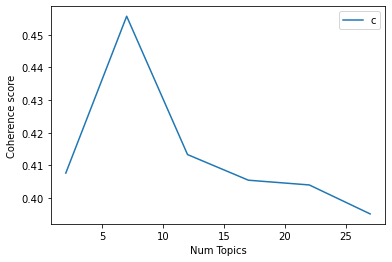

In [44]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [45]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 7

index: 0 | Num Topics = 2  has Coherence Value of 0.4076
index: 1 | Num Topics = 7  has Coherence Value of 0.4557
index: 2 | Num Topics = 12  has Coherence Value of 0.4133
index: 3 | Num Topics = 17  has Coherence Value of 0.4054
index: 4 | Num Topics = 22  has Coherence Value of 0.404
index: 5 | Num Topics = 27  has Coherence Value of 0.3951


In [179]:
# Select optimal number of topics
optimal_model_us = model_list_us[1]

In [180]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us = pyLDAvis.gensim_models.prepare(optimal_model_us, corpus_us, id2word_us)

In [181]:
print("pyLDAVis for overall us topics:")
vis_us

pyLDAVis for overall us topics:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.122853  0.004843       1        1  25.732895
4     -0.136733 -0.061348       2        1  18.937463
3     -0.105940  0.024617       3        1  18.176306
5     -0.053710 -0.178553       4        1  14.951700
0     -0.092934  0.166836       5        1  11.490268
2      0.230182  0.223270       6        1   6.612078
6      0.281987 -0.179665       7        1   4.099291, topic_info=           Term         Freq        Total Category  logprob  loglift
29         song   754.000000   754.000000  Default  30.0000  30.0000
44        music   443.000000   443.000000  Default  29.0000  29.0000
15        video  1235.000000  1235.000000  Default  28.0000  28.0000
0           app  2026.000000  2026.000000  Default  27.0000  27.0000
59       update   158.000000   158.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
7           way     7.501364    94.820326   Topic7  -4.9997   0.6575
341  definitely     5.976277    34.738223   Topic7  -5.2270   1.4343
47     purchase     5.161556    10.312602   Topic7  -5.3735   2.5022
456  understand     5.071516    16.210389   Topic7  -5.3911   2.0323
50       remove     5.071919    25.036236   Topic7  -5.3911   1.5978

[425 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
26        1  0.221452          able
26        2  0.531485          able
26        3  0.250979          able
388       3  0.972279        access
1580      5  0.882685  accidentally
...     ...       ...           ...
8         1  0.562971          year
8         3  0.133335          year
8         4  0.296301          year
291       3  0.933191           yet
348       7  0.932390         young

[562 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 6, 1, 3, 7])

# By-rating LDA Topic Modelling

## LDA Topic Modelling (Rating = 1)

In [49]:
# By-rating Topic Modelling - rating = 1
# Convert to list - move to each section
review_us_score1 = lomotif_ios_us_review_YearMonth_score1.review.values.tolist()
review_words_us_score1 = list(sent_to_words(review_us_score1))
print(review_words_us_score1[:1])

[['this', 'app', 'it', 'trash', 'because', 'cant', 'make', 'lit', 'video', 'then', 'when', 'its', 'done', 'and', 'its', 'loading', 'it', 'kicks', 'out', 'of', 'the', 'app', 'and', 'have', 'to', 'start', 'all', 'over', 'again', 'on', 'iphone']]


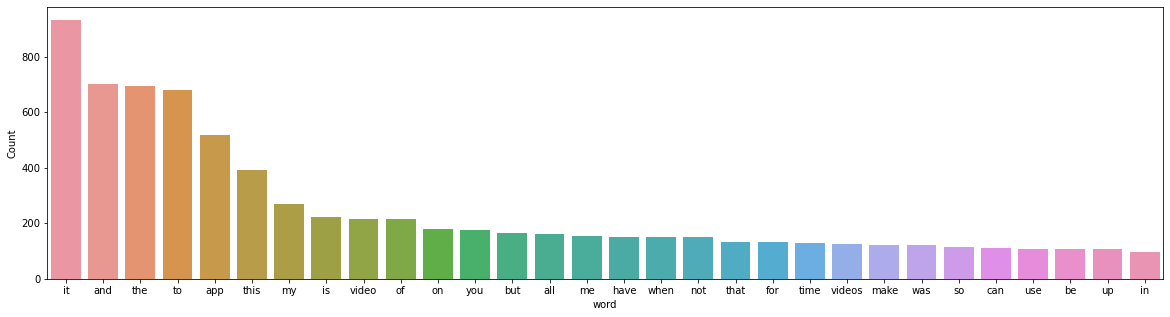

In [50]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score1))

In [51]:
# Clean text
review_us_ready_score1 = process_words(review_words_us_score1)  # processed Text Data! - move to each section


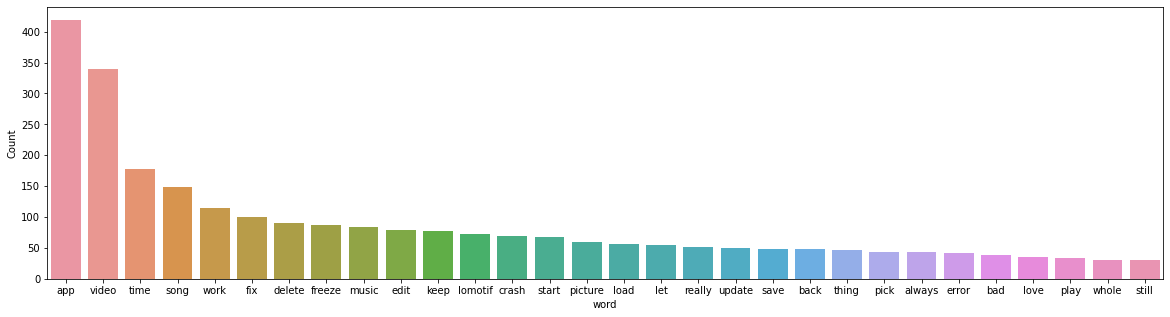

In [52]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score1))


In [53]:
# Create Dictionary
id2word_us_score1 = corpora.Dictionary(review_us_ready_score1)

2021-10-17 02:16:23,316 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 02:16:23,338 [INFO] gensim.corpora.dictionary - built Dictionary(970 unique tokens: ['app', 'iphone', 'kick', 'light', 'loading']...) from 435 documents (total 6285 corpus positions)
2021-10-17 02:16:23,339 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(970 unique tokens: ['app', 'iphone', 'kick', 'light', 'loading']...) from 435 documents (total 6285 corpus positions)", 'datetime': '2021-10-17T02:16:23.339884', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [54]:
# Create Corpus: Term Document Frequency
corpus_us_score1 = [id2word_us_score1.doc2bow(text) for text in review_us_ready_score1]

In [55]:
# Training LDA model
model_list_us_score1, coherence_values_us_score1 = compute_coherence_values(dictionary=id2word_us_score1, corpus=corpus_us_score1, 
                                                              texts=review_us_ready_score1, limit=30, start=2, step=5)


2021-10-17 02:16:23,366 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 02:16:23,368 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 02:16:23,370 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 02:16:23,372 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 435 documents, updating model once every 435 documents, evaluating perplexity every 435 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 02:16:25,172 [INFO] gensim.models.ldamodel - -7.435 per-word bound, 173.1 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:16:25,173 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #435/435
2021-10-17 02:16:26,555 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.056*"video" + 0.053*"app" + 0.021*"time" + 0.015*"work" + 0.014*"song" + 0.014*"lomotif" + 0.014*"edit

2021-10-17 02:16:44,476 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.061*"app" + 0.037*"song" + 0.036*"video" + 0.032*"time" + 0.023*"fix" + 0.020*"work" + 0.020*"music" + 0.015*"freeze" + 0.014*"load" + 0.013*"crash"
2021-10-17 02:16:44,477 [INFO] gensim.models.ldamodel - topic diff=0.016528, rho=0.301511
2021-10-17 02:16:45,567 [INFO] gensim.models.ldamodel - -5.900 per-word bound, 59.7 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:16:45,569 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #435/435
2021-10-17 02:16:46,449 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.058*"video" + 0.055*"app" + 0.017*"time" + 0.016*"edit" + 0.015*"lomotif" + 0.012*"delete" + 0.011*"work" + 0.011*"picture" + 0.011*"update" + 0.011*"keep"
2021-10-17 02:16:46,452 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.061*"app" + 0.037*"song" + 0.036*"video" + 0.032*"time" + 0.023*"fix" + 0.020*"work" + 0.020*"music" + 0.015*"freeze"

2021-10-17 02:17:01,895 [INFO] gensim.models.ldamodel - topic diff=0.007097, rho=0.218218
2021-10-17 02:17:02,904 [INFO] gensim.models.ldamodel - -5.894 per-word bound, 59.5 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:17:02,919 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #435/435
2021-10-17 02:17:03,570 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.058*"video" + 0.056*"app" + 0.017*"time" + 0.016*"edit" + 0.015*"lomotif" + 0.012*"delete" + 0.012*"picture" + 0.011*"update" + 0.011*"back" + 0.010*"work"
2021-10-17 02:17:03,572 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.060*"app" + 0.038*"song" + 0.037*"video" + 0.032*"time" + 0.023*"fix" + 0.021*"work" + 0.020*"music" + 0.015*"freeze" + 0.015*"load" + 0.013*"crash"
2021-10-17 02:17:03,576 [INFO] gensim.models.ldamodel - topic diff=0.006826, rho=0.213201
2021-10-17 02:17:04,561 [INFO] gensim.models.ldamodel - -5.893 per-word bound, 59.4 perplexity estimate

2021-10-17 02:17:19,344 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #435/435
2021-10-17 02:17:20,338 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.057*"app" + 0.056*"video" + 0.016*"time" + 0.016*"edit" + 0.014*"lomotif" + 0.012*"delete" + 0.012*"picture" + 0.011*"update" + 0.011*"back" + 0.009*"work"
2021-10-17 02:17:20,351 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.059*"app" + 0.039*"song" + 0.039*"video" + 0.032*"time" + 0.023*"fix" + 0.022*"work" + 0.020*"music" + 0.016*"freeze" + 0.015*"load" + 0.013*"crash"
2021-10-17 02:17:20,354 [INFO] gensim.models.ldamodel - topic diff=0.004964, rho=0.176777
2021-10-17 02:17:21,576 [INFO] gensim.models.ldamodel - -5.890 per-word bound, 59.3 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:17:21,577 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #435/435
2021-10-17 02:17:22,438 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.057*"app" + 0.056*"vi

2021-10-17 02:17:38,823 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.059*"app" + 0.040*"video" + 0.039*"song" + 0.032*"time" + 0.023*"fix" + 0.022*"work" + 0.021*"music" + 0.016*"freeze" + 0.015*"load" + 0.013*"crash"
2021-10-17 02:17:38,825 [INFO] gensim.models.ldamodel - topic diff=0.004418, rho=0.154303
2021-10-17 02:17:40,184 [INFO] gensim.models.ldamodel - -5.888 per-word bound, 59.2 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:17:40,185 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #435/435
2021-10-17 02:17:41,099 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.057*"app" + 0.055*"video" + 0.016*"time" + 0.016*"edit" + 0.013*"lomotif" + 0.012*"picture" + 0.012*"delete" + 0.012*"update" + 0.011*"back" + 0.009*"thing"
2021-10-17 02:17:41,143 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.058*"app" + 0.040*"video" + 0.039*"song" + 0.032*"time" + 0.023*"fix" + 0.022*"work" + 0.021*"music" + 0.016*"freeze

2021-10-17 02:17:59,309 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 433 virtual documents
2021-10-17 02:17:59,587 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 02:17:59,588 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 02:17:59,591 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 02:17:59,594 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 435 documents, updating model once every 435 documents, evaluating perplexity every 435 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 02:18:00,829 [INFO] gensim.models.ldamodel - -8.579 per-word bound, 382.5 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:18:00,830 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #435/435
2021-10-17 02:18

2021-10-17 02:18:08,625 [INFO] gensim.models.ldamodel - -6.153 per-word bound, 71.1 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:18:08,627 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #435/435
2021-10-17 02:18:09,328 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.047*"app" + 0.022*"work" + 0.017*"fix" + 0.017*"video" + 0.013*"put" + 0.011*"always" + 0.011*"lag" + 0.010*"thing" + 0.010*"delete" + 0.009*"still"
2021-10-17 02:18:09,331 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.037*"time" + 0.033*"app" + 0.026*"start" + 0.020*"work" + 0.018*"crash" + 0.017*"edit" + 0.017*"delete" + 0.016*"really" + 0.014*"video" + 0.014*"change"
2021-10-17 02:18:09,333 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.052*"music" + 0.035*"video" + 0.033*"app" + 0.025*"song" + 0.017*"time" + 0.017*"update" + 0.014*"play" + 0.014*"slow" + 0.012*"delete" + 0.011*"keep"
2021-10-17 02:18:09,336 [INFO] gensim.models.ldamodel - top

2021-10-17 02:18:15,924 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.058*"music" + 0.032*"video" + 0.030*"app" + 0.028*"song" + 0.017*"play" + 0.017*"update" + 0.015*"time" + 0.015*"slow" + 0.011*"fix" + 0.011*"delete"
2021-10-17 02:18:15,939 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.046*"app" + 0.019*"work" + 0.017*"fix" + 0.016*"video" + 0.013*"put" + 0.012*"lag" + 0.011*"thing" + 0.010*"always" + 0.010*"people" + 0.009*"delete"
2021-10-17 02:18:15,941 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.076*"app" + 0.066*"video" + 0.034*"time" + 0.029*"song" + 0.020*"freeze" + 0.019*"fix" + 0.016*"work" + 0.014*"delete" + 0.014*"crash" + 0.014*"edit"
2021-10-17 02:18:15,942 [INFO] gensim.models.ldamodel - topic diff=0.022410, rho=0.288675
2021-10-17 02:18:16,577 [INFO] gensim.models.ldamodel - -6.127 per-word bound, 69.9 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:18:16,578 [INFO] gensim.models.ldamodel - PROGRESS: pa

2021-10-17 02:18:24,020 [INFO] gensim.models.ldamodel - -6.117 per-word bound, 69.4 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:18:24,023 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #435/435
2021-10-17 02:18:24,706 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.076*"app" + 0.065*"video" + 0.034*"time" + 0.029*"song" + 0.020*"freeze" + 0.019*"fix" + 0.016*"work" + 0.014*"delete" + 0.014*"crash" + 0.014*"edit"
2021-10-17 02:18:24,708 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.056*"app" + 0.026*"work" + 0.020*"delete" + 0.019*"phone" + 0.015*"download" + 0.015*"turn" + 0.013*"slideshow" + 0.013*"open" + 0.013*"still" + 0.012*"video"
2021-10-17 02:18:24,710 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.033*"app" + 0.032*"video" + 0.030*"lomotif" + 0.025*"update" + 0.023*"work" + 0.016*"back" + 0.016*"edit" + 0.015*"keep" + 0.015*"time" + 0.014*"delete"
2021-10-17 02:18:24,712 [INFO] gensim.models.ldamo

2021-10-17 02:18:31,574 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.045*"app" + 0.043*"video" + 0.029*"inappropriate" + 0.022*"post" + 0.018*"thing" + 0.015*"child" + 0.014*"look" + 0.013*"stuff" + 0.013*"let" + 0.012*"age"
2021-10-17 02:18:31,576 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.076*"app" + 0.065*"video" + 0.035*"time" + 0.029*"song" + 0.019*"freeze" + 0.019*"fix" + 0.016*"work" + 0.014*"delete" + 0.014*"crash" + 0.014*"edit"
2021-10-17 02:18:31,577 [INFO] gensim.models.ldamodel - topic diff=0.008556, rho=0.208514
2021-10-17 02:18:32,400 [INFO] gensim.models.ldamodel - -6.109 per-word bound, 69.0 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:18:32,412 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #435/435
2021-10-17 02:18:33,250 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.045*"app" + 0.043*"video" + 0.029*"inappropriate" + 0.022*"post" + 0.018*"thing" + 0.015*"child" + 0.015*"look" + 0.

2021-10-17 02:18:39,706 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #435/435
2021-10-17 02:18:40,097 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.065*"music" + 0.035*"song" + 0.029*"video" + 0.025*"app" + 0.021*"play" + 0.015*"slow" + 0.013*"time" + 0.012*"fix" + 0.012*"update" + 0.012*"work"
2021-10-17 02:18:40,099 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.037*"time" + 0.032*"app" + 0.026*"start" + 0.021*"work" + 0.020*"edit" + 0.017*"delete" + 0.016*"change" + 0.016*"crash" + 0.015*"really" + 0.014*"video"
2021-10-17 02:18:40,101 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.045*"app" + 0.016*"fix" + 0.015*"video" + 0.015*"lag" + 0.015*"work" + 0.014*"put" + 0.012*"thing" + 0.011*"people" + 0.010*"read" + 0.010*"size"
2021-10-17 02:18:40,103 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.033*"app" + 0.032*"video" + 0.030*"lomotif" + 0.028*"update" + 0.023*"work" + 0.017*"back" + 0.016*"edit" + 0.015*"keep" + 0.014*"delete" + 0.014*"secon

2021-10-17 02:18:46,325 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.056*"app" + 0.027*"work" + 0.022*"phone" + 0.021*"delete" + 0.018*"turn" + 0.016*"download" + 0.014*"still" + 0.014*"slideshow" + 0.014*"open" + 0.012*"video"
2021-10-17 02:18:46,342 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.046*"app" + 0.042*"video" + 0.028*"inappropriate" + 0.021*"post" + 0.018*"thing" + 0.015*"look" + 0.014*"child" + 0.013*"stuff" + 0.013*"let" + 0.012*"kid"
2021-10-17 02:18:46,352 [INFO] gensim.models.ldamodel - topic diff=0.004186, rho=0.171499
2021-10-17 02:18:47,111 [INFO] gensim.models.ldamodel - -6.102 per-word bound, 68.7 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:18:47,112 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #435/435
2021-10-17 02:18:47,628 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.076*"app" + 0.066*"video" + 0.035*"time" + 0.028*"song" + 0.020*"freeze" + 0.019*"fix" + 0.016*"work" + 0.0

2021-10-17 02:18:53,955 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.076*"app" + 0.066*"video" + 0.035*"time" + 0.027*"song" + 0.020*"freeze" + 0.019*"fix" + 0.016*"work" + 0.015*"delete" + 0.014*"crash" + 0.014*"edit"
2021-10-17 02:18:53,957 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.056*"app" + 0.027*"work" + 0.023*"phone" + 0.021*"delete" + 0.018*"turn" + 0.016*"download" + 0.014*"still" + 0.014*"slideshow" + 0.014*"open" + 0.012*"video"
2021-10-17 02:18:53,958 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.033*"app" + 0.031*"video" + 0.030*"lomotif" + 0.028*"update" + 0.024*"work" + 0.017*"back" + 0.016*"edit" + 0.015*"keep" + 0.014*"delete" + 0.014*"change"
2021-10-17 02:18:53,959 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.046*"app" + 0.042*"video" + 0.028*"inappropriate" + 0.021*"post" + 0.018*"thing" + 0.016*"look" + 0.014*"child" + 0.013*"stuff" + 0.013*"sound" + 0.013*"let"
2021-10-17 02:18:53,960 [INFO] gensim.models.ldamodel - topic #1 (0.143): 

2021-10-17 02:18:59,459 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.046*"app" + 0.042*"video" + 0.028*"inappropriate" + 0.021*"post" + 0.018*"thing" + 0.016*"look" + 0.014*"child" + 0.014*"sound" + 0.013*"stuff" + 0.012*"kid"
2021-10-17 02:18:59,460 [INFO] gensim.models.ldamodel - topic diff=0.002877, rho=0.149071
2021-10-17 02:19:00,081 [INFO] gensim.models.ldamodel - -6.099 per-word bound, 68.6 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:19:00,083 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #435/435
2021-10-17 02:19:00,569 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.067*"music" + 0.047*"song" + 0.027*"video" + 0.023*"app" + 0.023*"play" + 0.016*"fix" + 0.015*"error" + 0.014*"keep" + 0.014*"search" + 0.013*"time"
2021-10-17 02:19:00,572 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.077*"app" + 0.066*"video" + 0.035*"time" + 0.026*"song" + 0.020*"freeze" + 0.018*"fix" + 0.016*"work" + 0.015*"dele

2021-10-17 02:19:06,962 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.033*"app" + 0.030*"video" + 0.030*"lomotif" + 0.029*"update" + 0.024*"work" + 0.017*"back" + 0.016*"edit" + 0.015*"keep" + 0.014*"change" + 0.014*"delete"
2021-10-17 02:19:06,966 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.038*"time" + 0.032*"app" + 0.026*"start" + 0.021*"work" + 0.020*"edit" + 0.017*"delete" + 0.016*"change" + 0.016*"crash" + 0.015*"really" + 0.014*"video"
2021-10-17 02:19:06,968 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.045*"app" + 0.041*"video" + 0.028*"inappropriate" + 0.021*"post" + 0.018*"thing" + 0.017*"look" + 0.015*"sound" + 0.014*"child" + 0.013*"stuff" + 0.012*"kid"
2021-10-17 02:19:06,970 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.077*"app" + 0.067*"video" + 0.036*"time" + 0.025*"song" + 0.020*"freeze" + 0.018*"fix" + 0.016*"work" + 0.015*"delete" + 0.014*"crash" + 0.014*"edit"
2021-10-17 02:19:06,971 [INFO] gensim.models.ldamodel - topic diff=0.002644, rh

2021-10-17 02:19:19,690 [INFO] gensim.models.ldamodel - topic diff=0.119672, rho=0.447214
2021-10-17 02:19:20,349 [INFO] gensim.models.ldamodel - -6.314 per-word bound, 79.6 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:19:20,350 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #435/435
2021-10-17 02:19:20,738 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.079*"app" + 0.079*"video" + 0.036*"time" + 0.024*"freeze" + 0.021*"song" + 0.020*"edit" + 0.016*"fix" + 0.016*"work" + 0.015*"crash" + 0.014*"save"
2021-10-17 02:19:20,760 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.059*"app" + 0.028*"delete" + 0.025*"still" + 0.023*"reinstall" + 0.020*"download" + 0.017*"thing" + 0.015*"open" + 0.014*"turn" + 0.014*"work" + 0.014*"time"
2021-10-17 02:19:20,772 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.037*"video" + 0.035*"time" + 0.033*"crash" + 0.026*"app" + 0.022*"picture" + 0.019*"fix" + 0.015*"bug" + 0.012*"lomot

2021-10-17 02:19:27,213 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.057*"app" + 0.028*"delete" + 0.027*"still" + 0.026*"reinstall" + 0.024*"download" + 0.022*"turn" + 0.017*"open" + 0.016*"thing" + 0.014*"phone" + 0.013*"point"
2021-10-17 02:19:27,216 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.061*"video" + 0.048*"app" + 0.025*"post" + 0.023*"inappropriate" + 0.020*"look" + 0.019*"let" + 0.018*"thing" + 0.016*"child" + 0.015*"people" + 0.015*"mute"
2021-10-17 02:19:27,218 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.049*"lomotif" + 0.047*"video" + 0.037*"update" + 0.024*"app" + 0.024*"back" + 0.024*"change" + 0.018*"start" + 0.017*"time" + 0.017*"thing" + 0.017*"freeze"
2021-10-17 02:19:27,219 [INFO] gensim.models.ldamodel - topic diff=0.036087, rho=0.301511
2021-10-17 02:19:27,894 [INFO] gensim.models.ldamodel - -6.255 per-word bound, 76.4 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:19:27,896 [INFO] gensim.model

2021-10-17 02:19:33,616 [INFO] gensim.models.ldamodel - topic diff=0.017454, rho=0.250000
2021-10-17 02:19:34,353 [INFO] gensim.models.ldamodel - -6.238 per-word bound, 75.5 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:19:34,356 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #435/435
2021-10-17 02:19:34,907 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.047*"song" + 0.035*"fix" + 0.033*"load" + 0.031*"app" + 0.027*"search" + 0.026*"video" + 0.025*"keep" + 0.023*"really" + 0.020*"time" + 0.020*"music"
2021-10-17 02:19:34,910 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.090*"song" + 0.055*"load" + 0.044*"error" + 0.036*"pick" + 0.028*"app" + 0.028*"time" + 0.026*"work" + 0.025*"fix" + 0.025*"choose" + 0.024*"music"
2021-10-17 02:19:34,938 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.037*"video" + 0.033*"time" + 0.030*"crash" + 0.027*"app" + 0.024*"picture" + 0.020*"fix" + 0.015*"bug" + 0.013*"really" + 0

2021-10-17 02:19:41,354 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.037*"video" + 0.034*"time" + 0.030*"crash" + 0.027*"app" + 0.024*"picture" + 0.020*"fix" + 0.015*"bug" + 0.013*"really" + 0.012*"load" + 0.012*"available"
2021-10-17 02:19:41,355 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.097*"app" + 0.029*"delete" + 0.028*"video" + 0.020*"fix" + 0.018*"keep" + 0.016*"hate" + 0.014*"really" + 0.014*"download" + 0.013*"work" + 0.012*"hour"
2021-10-17 02:19:41,357 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.085*"app" + 0.083*"video" + 0.040*"time" + 0.026*"freeze" + 0.023*"edit" + 0.018*"crash" + 0.016*"work" + 0.016*"save" + 0.015*"start" + 0.014*"fix"
2021-10-17 02:19:41,358 [INFO] gensim.models.ldamodel - topic diff=0.009888, rho=0.213201
2021-10-17 02:19:42,044 [INFO] gensim.models.ldamodel - -6.227 per-word bound, 74.9 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:19:42,047 [INFO] gensim.models.ldamodel - PROGR

2021-10-17 02:19:48,850 [INFO] gensim.models.ldamodel - -6.220 per-word bound, 74.6 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:19:48,851 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #435/435
2021-10-17 02:19:49,363 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.085*"app" + 0.083*"video" + 0.041*"time" + 0.027*"freeze" + 0.024*"edit" + 0.019*"crash" + 0.016*"work" + 0.016*"save" + 0.016*"start" + 0.014*"fix"
2021-10-17 02:19:49,369 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.054*"app" + 0.034*"turn" + 0.029*"delete" + 0.028*"still" + 0.027*"reinstall" + 0.026*"download" + 0.024*"phone" + 0.018*"open" + 0.017*"thing" + 0.017*"point"
2021-10-17 02:19:49,374 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.055*"lomotif" + 0.047*"video" + 0.043*"update" + 0.026*"app" + 0.025*"change" + 0.024*"back" + 0.021*"new" + 0.018*"thing" + 0.016*"start" + 0.015*"time"
2021-10-17 02:19:49,382 [INFO] gensim.models.ldam

2021-10-17 02:19:56,224 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.027*"app" + 0.017*"download" + 0.014*"thing" + 0.013*"minute" + 0.012*"bad" + 0.012*"delete" + 0.012*"stuff" + 0.012*"mess" + 0.012*"mean" + 0.012*"select"
2021-10-17 02:19:56,226 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.072*"music" + 0.037*"app" + 0.025*"put" + 0.024*"song" + 0.021*"video" + 0.015*"never" + 0.013*"well" + 0.013*"guy" + 0.013*"old" + 0.012*"apple"
2021-10-17 02:19:56,227 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.057*"work" + 0.037*"time" + 0.031*"always" + 0.025*"song" + 0.021*"app" + 0.021*"delete" + 0.015*"start" + 0.015*"glitch" + 0.015*"super" + 0.013*"annoying"
2021-10-17 02:19:56,228 [INFO] gensim.models.ldamodel - topic diff=0.005433, rho=0.174078
2021-10-17 02:19:57,098 [INFO] gensim.models.ldamodel - -6.213 per-word bound, 74.2 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:19:57,109 [INFO] gensim.models.ldamodel - PR

2021-10-17 02:20:03,488 [INFO] gensim.models.ldamodel - topic diff=0.004516, rho=0.162221
2021-10-17 02:20:04,238 [INFO] gensim.models.ldamodel - -6.209 per-word bound, 74.0 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:20:04,239 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #435/435
2021-10-17 02:20:04,871 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.124*"song" + 0.052*"load" + 0.050*"error" + 0.038*"pick" + 0.031*"fix" + 0.030*"work" + 0.028*"time" + 0.026*"music" + 0.025*"app" + 0.024*"choose"
2021-10-17 02:20:04,873 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.055*"work" + 0.037*"time" + 0.031*"always" + 0.022*"song" + 0.021*"app" + 0.021*"delete" + 0.015*"glitch" + 0.015*"super" + 0.015*"start" + 0.014*"annoying"
2021-10-17 02:20:04,875 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.073*"music" + 0.037*"app" + 0.024*"put" + 0.021*"video" + 0.019*"song" + 0.015*"never" + 0.013*"well" + 0.012*"apple"

2021-10-17 02:20:11,575 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.044*"song" + 0.035*"load" + 0.034*"search" + 0.031*"app" + 0.029*"video" + 0.028*"fix" + 0.025*"really" + 0.023*"keep" + 0.022*"music" + 0.019*"time"
2021-10-17 02:20:11,577 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.027*"app" + 0.017*"download" + 0.014*"thing" + 0.012*"bad" + 0.012*"stuff" + 0.012*"delete" + 0.012*"mess" + 0.012*"mean" + 0.012*"select" + 0.012*"service"
2021-10-17 02:20:11,583 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.100*"app" + 0.029*"video" + 0.028*"delete" + 0.021*"fix" + 0.018*"keep" + 0.017*"hate" + 0.015*"download" + 0.014*"work" + 0.013*"hour" + 0.013*"phone"
2021-10-17 02:20:11,584 [INFO] gensim.models.ldamodel - topic diff=0.003868, rho=0.150756
2021-10-17 02:20:12,257 [INFO] gensim.models.ldamodel - -6.204 per-word bound, 73.7 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:20:12,259 [INFO] gensim.models.ldamodel - P

2021-10-17 02:20:17,847 [INFO] gensim.models.ldamodel - topic diff=0.003350, rho=0.142857
2021-10-17 02:20:18,488 [INFO] gensim.models.ldamodel - -6.201 per-word bound, 73.6 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:20:18,489 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #435/435
2021-10-17 02:20:18,994 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.075*"music" + 0.037*"app" + 0.023*"put" + 0.021*"video" + 0.015*"never" + 0.015*"song" + 0.013*"well" + 0.012*"apple" + 0.011*"let" + 0.011*"update"
2021-10-17 02:20:18,996 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.086*"app" + 0.083*"video" + 0.043*"time" + 0.028*"freeze" + 0.025*"edit" + 0.019*"crash" + 0.018*"start" + 0.016*"save" + 0.016*"work" + 0.015*"delete"
2021-10-17 02:20:18,998 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.054*"work" + 0.037*"time" + 0.031*"always" + 0.021*"app" + 0.020*"delete" + 0.019*"song" + 0.015*"glitch" + 0.015*"super"

2021-10-17 02:20:32,482 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.056*"video" + 0.053*"app" + 0.033*"let" + 0.021*"song" + 0.019*"post" + 0.017*"time" + 0.015*"pick" + 0.013*"thing" + 0.012*"music" + 0.012*"people"
2021-10-17 02:20:32,483 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.042*"app" + 0.040*"update" + 0.025*"new" + 0.023*"inappropriate" + 0.022*"delete" + 0.016*"lomotif" + 0.016*"bad" + 0.015*"always" + 0.015*"time" + 0.013*"old"
2021-10-17 02:20:32,484 [INFO] gensim.models.ldamodel - topic diff=0.142092, rho=0.500000
2021-10-17 02:20:33,154 [INFO] gensim.models.ldamodel - -6.462 per-word bound, 88.2 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:20:33,155 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #435/435
2021-10-17 02:20:33,743 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.053*"app" + 0.051*"video" + 0.047*"time" + 0.024*"crash" + 0.017*"edit" + 0.016*"picture" + 0.016*"second" + 0.0

2021-10-17 02:20:39,488 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #435/435
2021-10-17 02:20:39,995 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.035*"video" + 0.026*"time" + 0.026*"really" + 0.019*"keep" + 0.018*"music" + 0.017*"load" + 0.017*"add" + 0.017*"lag" + 0.017*"busy" + 0.017*"server"
2021-10-17 02:20:39,996 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.067*"app" + 0.030*"work" + 0.023*"change" + 0.022*"slideshow" + 0.022*"mean" + 0.018*"thing" + 0.017*"download" + 0.017*"porn" + 0.016*"fun" + 0.012*"time"
2021-10-17 02:20:39,998 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.037*"video" + 0.030*"app" + 0.026*"time" + 0.024*"freeze" + 0.023*"picture" + 0.012*"edit" + 0.012*"let" + 0.011*"adjust" + 0.011*"lose" + 0.011*"happen"
2021-10-17 02:20:39,999 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.041*"work" + 0.028*"app" + 0.027*"start" + 0.024*"delete" + 0.023*"glitch" + 0.022*"time" + 0.021*"almost" + 0.019*"picture" + 0.019*"really

2021-10-17 02:20:46,227 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.053*"app" + 0.053*"video" + 0.049*"time" + 0.025*"crash" + 0.021*"second" + 0.019*"edit" + 0.018*"picture" + 0.018*"photo" + 0.014*"always" + 0.014*"project"
2021-10-17 02:20:46,232 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.058*"video" + 0.030*"music" + 0.030*"app" + 0.029*"time" + 0.025*"work" + 0.017*"crash" + 0.013*"terrible" + 0.013*"fix" + 0.010*"add" + 0.010*"slow"
2021-10-17 02:20:46,235 [INFO] gensim.models.ldamodel - topic diff=0.021370, rho=0.258199
2021-10-17 02:20:46,923 [INFO] gensim.models.ldamodel - -6.337 per-word bound, 80.9 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:20:46,926 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #435/435
2021-10-17 02:20:47,480 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.053*"video" + 0.051*"edit" + 0.033*"app" + 0.021*"start" + 0.020*"almost" + 0.019*"back" + 0.018*"save" + 0.018*"

2021-10-17 02:20:53,018 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #435/435
2021-10-17 02:20:53,489 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.071*"app" + 0.039*"video" + 0.031*"song" + 0.023*"time" + 0.023*"back" + 0.023*"play" + 0.023*"work" + 0.022*"never" + 0.022*"update" + 0.019*"always"
2021-10-17 02:20:53,524 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.091*"app" + 0.085*"video" + 0.036*"time" + 0.026*"freeze" + 0.017*"save" + 0.015*"work" + 0.015*"lomotif" + 0.015*"delete" + 0.015*"edit" + 0.014*"fix"
2021-10-17 02:20:53,538 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.055*"video" + 0.053*"edit" + 0.033*"app" + 0.022*"start" + 0.020*"almost" + 0.020*"back" + 0.018*"save" + 0.018*"kick" + 0.018*"time" + 0.017*"freeze"
2021-10-17 02:20:53,555 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.067*"app" + 0.030*"work" + 0.023*"change" + 0.023*"slideshow" + 0.023*"mean" + 0.018*"thing" + 0.017*"download" + 0.017*"porn" + 0.017*"fun" + 0.

2021-10-17 02:20:59,620 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.091*"app" + 0.028*"video" + 0.020*"delete" + 0.018*"fix" + 0.017*"really" + 0.015*"keep" + 0.014*"start" + 0.014*"time" + 0.014*"save" + 0.013*"sound"
2021-10-17 02:20:59,624 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.035*"work" + 0.027*"start" + 0.026*"app" + 0.025*"glitch" + 0.023*"time" + 0.023*"almost" + 0.021*"picture" + 0.021*"delete" + 0.020*"really" + 0.017*"freeze"
2021-10-17 02:20:59,626 [INFO] gensim.models.ldamodel - topic diff=0.007955, rho=0.196116
2021-10-17 02:21:00,360 [INFO] gensim.models.ldamodel - -6.315 per-word bound, 79.6 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:21:00,382 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #435/435
2021-10-17 02:21:00,846 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.057*"video" + 0.055*"edit" + 0.033*"app" + 0.022*"start" + 0.020*"almost" + 0.020*"back" + 0.019*"time" + 0.019*

2021-10-17 02:21:07,050 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #435/435
2021-10-17 02:21:07,604 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.065*"update" + 0.043*"app" + 0.031*"new" + 0.023*"bad" + 0.022*"inappropriate" + 0.021*"lomotif" + 0.020*"delete" + 0.019*"old" + 0.016*"time" + 0.015*"always"
2021-10-17 02:21:07,606 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.036*"video" + 0.033*"pop" + 0.027*"really" + 0.025*"time" + 0.020*"keep" + 0.018*"add" + 0.018*"load" + 0.018*"lag" + 0.018*"server" + 0.018*"busy"
2021-10-17 02:21:07,610 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.090*"app" + 0.027*"video" + 0.020*"delete" + 0.018*"fix" + 0.017*"really" + 0.015*"keep" + 0.014*"start" + 0.013*"save" + 0.013*"sound" + 0.013*"time"
2021-10-17 02:21:07,613 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.052*"video" + 0.030*"app" + 0.028*"time" + 0.028*"music" + 0.025*"work" + 0.018*"crash" + 0.013*"terrible" + 0.013*"fix" + 0.011*"add" + 0.

2021-10-17 02:21:13,998 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.055*"video" + 0.028*"stuff" + 0.027*"shuffle" + 0.026*"delete" + 0.023*"app" + 0.022*"mute" + 0.017*"sound" + 0.017*"really" + 0.012*"work" + 0.012*"thing"
2021-10-17 02:21:14,000 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.037*"video" + 0.035*"pop" + 0.027*"really" + 0.024*"time" + 0.020*"keep" + 0.018*"add" + 0.018*"lag" + 0.018*"load" + 0.018*"server" + 0.018*"busy"
2021-10-17 02:21:14,001 [INFO] gensim.models.ldamodel - topic diff=0.003880, rho=0.164399
2021-10-17 02:21:14,625 [INFO] gensim.models.ldamodel - -6.305 per-word bound, 79.1 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:21:14,627 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #435/435
2021-10-17 02:21:15,145 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.036*"video" + 0.030*"app" + 0.026*"time" + 0.023*"freeze" + 0.023*"picture" + 0.012*"edit" + 0.012*"let" + 0.012*"ad

2021-10-17 02:21:20,307 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #435/435
2021-10-17 02:21:20,764 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.064*"update" + 0.043*"app" + 0.031*"new" + 0.023*"bad" + 0.022*"inappropriate" + 0.021*"lomotif" + 0.020*"delete" + 0.019*"old" + 0.016*"time" + 0.015*"always"
2021-10-17 02:21:20,766 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.031*"work" + 0.027*"start" + 0.026*"app" + 0.025*"glitch" + 0.024*"almost" + 0.023*"time" + 0.021*"picture" + 0.020*"really" + 0.020*"delete" + 0.017*"freeze"
2021-10-17 02:21:20,768 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.054*"video" + 0.053*"app" + 0.049*"time" + 0.025*"crash" + 0.023*"second" + 0.020*"edit" + 0.019*"picture" + 0.019*"photo" + 0.017*"always" + 0.015*"project"
2021-10-17 02:21:20,770 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.036*"video" + 0.030*"app" + 0.026*"time" + 0.023*"freeze" + 0.023*"picture" + 0.012*"edit" + 0.012*"let" + 0.012*"adjust"

2021-10-17 02:21:25,868 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.030*"work" + 0.027*"start" + 0.026*"app" + 0.026*"glitch" + 0.024*"almost" + 0.023*"time" + 0.022*"picture" + 0.021*"really" + 0.020*"delete" + 0.017*"freeze"
2021-10-17 02:21:25,869 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.094*"app" + 0.085*"video" + 0.037*"time" + 0.026*"freeze" + 0.017*"save" + 0.016*"delete" + 0.015*"edit" + 0.015*"work" + 0.014*"lomotif" + 0.014*"fix"
2021-10-17 02:21:25,870 [INFO] gensim.models.ldamodel - topic diff=0.002668, rho=0.144338
2021-10-17 02:21:26,515 [INFO] gensim.models.ldamodel - -6.300 per-word bound, 78.8 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:21:26,520 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #435/435
2021-10-17 02:21:26,935 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.077*"app" + 0.061*"video" + 0.039*"start" + 0.037*"crash" + 0.030*"freeze" + 0.025*"keep" + 0.025*"delete" + 0

2021-10-17 02:21:40,709 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.105*"song" + 0.030*"fix" + 0.029*"load" + 0.023*"error" + 0.021*"video" + 0.021*"app" + 0.020*"work" + 0.020*"let" + 0.019*"lomotif" + 0.018*"music"
2021-10-17 02:21:40,712 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.062*"video" + 0.025*"app" + 0.021*"keep" + 0.021*"thing" + 0.021*"stuff" + 0.020*"delete" + 0.019*"freeze" + 0.017*"mess" + 0.014*"week" + 0.014*"love"
2021-10-17 02:21:40,714 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.044*"fix" + 0.043*"load" + 0.037*"music" + 0.028*"really" + 0.026*"keep" + 0.025*"work" + 0.025*"app" + 0.023*"time" + 0.020*"delete" + 0.015*"let"
2021-10-17 02:21:40,717 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.053*"video" + 0.042*"work" + 0.041*"app" + 0.028*"lomotif" + 0.025*"song" + 0.021*"time" + 0.021*"still" + 0.018*"whole" + 0.013*"freeze" + 0.013*"delete"
2021-10-17 02:21:40,720 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.053*"app" + 0

2021-10-17 02:21:47,596 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.074*"app" + 0.056*"video" + 0.029*"edit" + 0.027*"time" + 0.023*"put" + 0.022*"start" + 0.022*"delete" + 0.020*"crash" + 0.015*"trash" + 0.015*"way"
2021-10-17 02:21:47,603 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.048*"app" + 0.040*"video" + 0.031*"glitche" + 0.025*"work" + 0.025*"lomotif" + 0.022*"love" + 0.018*"mute" + 0.017*"picture" + 0.016*"press" + 0.014*"keep"
2021-10-17 02:21:47,605 [INFO] gensim.models.ldamodel - topic diff=0.084281, rho=0.353553
2021-10-17 02:21:48,260 [INFO] gensim.models.ldamodel - -6.466 per-word bound, 88.4 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:21:48,266 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #435/435
2021-10-17 02:21:48,737 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.060*"app" + 0.052*"work" + 0.035*"video" + 0.032*"time" + 0.022*"picture" + 0.020*"pick" + 0.019*"size" + 0.018*"del

2021-10-17 02:21:54,378 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #435/435
2021-10-17 02:21:54,800 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.060*"video" + 0.028*"stuff" + 0.021*"thing" + 0.021*"mess" + 0.020*"app" + 0.020*"rid" + 0.020*"keep" + 0.018*"delete" + 0.014*"log" + 0.014*"second"
2021-10-17 02:21:54,803 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.055*"work" + 0.048*"glitch" + 0.039*"delete" + 0.037*"time" + 0.029*"freeze" + 0.026*"music" + 0.022*"really" + 0.022*"slow" + 0.015*"terrible" + 0.015*"super"
2021-10-17 02:21:54,805 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.049*"change" + 0.030*"second" + 0.030*"understand" + 0.028*"video" + 0.025*"always" + 0.020*"old" + 0.020*"click" + 0.018*"app" + 0.017*"delete" + 0.015*"new"
2021-10-17 02:21:54,807 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.054*"video" + 0.046*"work" + 0.037*"lomotif" + 0.029*"app" + 0.024*"whole" + 0.023*"still" + 0.018*"time" + 0.017*"shuffle" + 0.0

2021-10-17 02:22:00,956 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.054*"video" + 0.046*"work" + 0.037*"lomotif" + 0.028*"app" + 0.025*"whole" + 0.024*"still" + 0.018*"time" + 0.017*"shuffle" + 0.014*"delete" + 0.013*"trash"
2021-10-17 02:22:00,973 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.041*"app" + 0.025*"time" + 0.023*"lomotif" + 0.022*"add" + 0.020*"update" + 0.019*"well" + 0.019*"really" + 0.017*"fix" + 0.013*"delete" + 0.013*"always"
2021-10-17 02:22:00,978 [INFO] gensim.models.ldamodel - topic diff=0.016622, rho=0.229416
2021-10-17 02:22:01,709 [INFO] gensim.models.ldamodel - -6.406 per-word bound, 84.8 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:22:01,711 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #435/435
2021-10-17 02:22:02,205 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.051*"app" + 0.029*"read" + 0.026*"hate" + 0.022*"song" + 0.022*"minute" + 0.022*"work" + 0.022*"flipagram" + 0

2021-10-17 02:22:07,822 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #435/435
2021-10-17 02:22:08,386 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.060*"work" + 0.057*"app" + 0.039*"video" + 0.038*"time" + 0.025*"picture" + 0.021*"delete" + 0.019*"size" + 0.018*"choose" + 0.016*"pick" + 0.016*"honestly"
2021-10-17 02:22:08,389 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.079*"app" + 0.032*"bad" + 0.027*"video" + 0.022*"delete" + 0.020*"people" + 0.020*"fix" + 0.020*"update" + 0.017*"download" + 0.017*"horrible" + 0.016*"really"
2021-10-17 02:22:08,390 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.067*"video" + 0.053*"time" + 0.048*"freeze" + 0.028*"app" + 0.026*"delete" + 0.023*"lomotif" + 0.023*"whole" + 0.022*"black" + 0.019*"point" + 0.017*"everytime"
2021-10-17 02:22:08,393 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.040*"video" + 0.033*"lomotif" + 0.024*"app" + 0.024*"edit" + 0.022*"give" + 0.021*"update" + 0.019*"let" + 0.019*"sign" +

2021-10-17 02:22:14,882 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.040*"video" + 0.033*"lomotif" + 0.025*"edit" + 0.024*"app" + 0.023*"give" + 0.022*"update" + 0.019*"let" + 0.019*"sign" + 0.019*"facebook" + 0.019*"roll"
2021-10-17 02:22:14,883 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.058*"app" + 0.053*"inappropriate" + 0.042*"video" + 0.036*"post" + 0.033*"age" + 0.029*"kid" + 0.028*"thing" + 0.027*"look" + 0.022*"child" + 0.019*"stuff"
2021-10-17 02:22:14,885 [INFO] gensim.models.ldamodel - topic diff=0.006817, rho=0.182574
2021-10-17 02:22:15,584 [INFO] gensim.models.ldamodel - -6.385 per-word bound, 83.6 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:22:15,586 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #435/435
2021-10-17 02:22:16,000 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.081*"app" + 0.035*"bad" + 0.026*"video" + 0.024*"delete" + 0.021*"update" + 0.021*"people" + 0.020*"fix" + 0.01

2021-10-17 02:22:21,909 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #435/435
2021-10-17 02:22:22,624 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.058*"app" + 0.053*"inappropriate" + 0.042*"video" + 0.036*"post" + 0.033*"age" + 0.029*"kid" + 0.028*"thing" + 0.027*"look" + 0.023*"child" + 0.021*"stuff"
2021-10-17 02:22:22,628 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.096*"app" + 0.093*"video" + 0.047*"time" + 0.029*"freeze" + 0.021*"picture" + 0.018*"edit" + 0.017*"crash" + 0.017*"back" + 0.016*"delete" + 0.016*"fix"
2021-10-17 02:22:22,631 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.041*"video" + 0.033*"lomotif" + 0.027*"edit" + 0.026*"app" + 0.024*"update" + 0.021*"give" + 0.019*"let" + 0.019*"sign" + 0.019*"facebook" + 0.019*"roll"
2021-10-17 02:22:22,632 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.125*"app" + 0.040*"video" + 0.039*"save" + 0.024*"edit" + 0.022*"fix" + 0.022*"time" + 0.022*"start" + 0.021*"hour" + 0.019*"freeze" + 0.

2021-10-17 02:22:28,937 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.040*"app" + 0.025*"time" + 0.023*"lomotif" + 0.022*"add" + 0.021*"update" + 0.020*"well" + 0.020*"really" + 0.017*"fix" + 0.013*"always" + 0.013*"thing"
2021-10-17 02:22:28,941 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.185*"song" + 0.056*"error" + 0.035*"pick" + 0.033*"fix" + 0.032*"music" + 0.030*"play" + 0.029*"load" + 0.022*"let" + 0.022*"always" + 0.022*"app"
2021-10-17 02:22:28,944 [INFO] gensim.models.ldamodel - topic diff=0.004120, rho=0.156174
2021-10-17 02:22:29,522 [INFO] gensim.models.ldamodel - -6.376 per-word bound, 83.0 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:22:29,524 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #435/435
2021-10-17 02:22:30,022 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.067*"video" + 0.053*"time" + 0.048*"freeze" + 0.028*"app" + 0.027*"delete" + 0.025*"whole" + 0.024*"lomotif" + 0.022*"bl

2021-10-17 02:22:35,418 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #435/435
2021-10-17 02:22:35,982 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.059*"app" + 0.053*"inappropriate" + 0.042*"video" + 0.036*"post" + 0.033*"age" + 0.029*"kid" + 0.029*"thing" + 0.027*"look" + 0.023*"stuff" + 0.023*"child"
2021-10-17 02:22:35,986 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.067*"video" + 0.053*"time" + 0.048*"freeze" + 0.028*"app" + 0.026*"delete" + 0.025*"whole" + 0.023*"lomotif" + 0.022*"black" + 0.019*"point" + 0.017*"everytime"
2021-10-17 02:22:35,992 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.082*"app" + 0.038*"bad" + 0.026*"video" + 0.024*"delete" + 0.022*"update" + 0.021*"people" + 0.021*"fix" + 0.017*"download" + 0.017*"horrible" + 0.017*"ever"
2021-10-17 02:22:35,994 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.066*"video" + 0.044*"app" + 0.025*"music" + 0.024*"find" + 0.020*"song" + 0.018*"work" + 0.014*"block" + 0.014*"copyright" +

2021-10-17 02:22:49,626 [INFO] gensim.models.ldamodel - using symmetric eta at 0.037037037037037035
2021-10-17 02:22:49,629 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 02:22:49,636 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 27 topics, 50 passes over the supplied corpus of 435 documents, updating model once every 435 documents, evaluating perplexity every 435 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 02:22:50,946 [INFO] gensim.models.ldamodel - -15.714 per-word bound, 53745.7 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:22:50,994 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #435/435
2021-10-17 02:22:51,896 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.067*"app" + 0.045*"crash" + 0.040*"time" + 0.039*"video" + 0.028*"work" + 0.022*"fix" + 0.020*"keep" + 0.019*"song" + 0.015*"pick" + 0.012*"size"
2021-10-17 02:22:51

2021-10-17 02:22:57,694 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #435/435
2021-10-17 02:22:58,259 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.055*"video" + 0.051*"constantly" + 0.039*"freeze" + 0.035*"time" + 0.034*"phone" + 0.029*"music" + 0.028*"app" + 0.025*"delete" + 0.024*"multiple" + 0.022*"crash"
2021-10-17 02:22:58,261 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.058*"video" + 0.048*"app" + 0.033*"lomotif" + 0.029*"save" + 0.025*"work" + 0.021*"update" + 0.019*"change" + 0.017*"camera" + 0.014*"hard" + 0.014*"song"
2021-10-17 02:22:58,262 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.052*"app" + 0.050*"time" + 0.045*"video" + 0.030*"edit" + 0.026*"project" + 0.023*"crash" + 0.019*"start" + 0.018*"anymore" + 0.017*"always" + 0.015*"close"
2021-10-17 02:22:58,263 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.042*"app" + 0.021*"edit" + 0.020*"photo" + 0.019*"child" + 0.016*"lomotif" + 0.016*"thing" + 0.015*"keep" + 0.015*"time" + 

2021-10-17 02:23:04,775 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.074*"video" + 0.049*"time" + 0.042*"freeze" + 0.040*"delete" + 0.038*"lomotif" + 0.038*"app" + 0.034*"fix" + 0.024*"server" + 0.024*"whole" + 0.021*"love"
2021-10-17 02:23:04,779 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.051*"video" + 0.044*"music" + 0.036*"app" + 0.023*"look" + 0.022*"let" + 0.020*"post" + 0.017*"inappropriate" + 0.017*"age" + 0.017*"bad" + 0.016*"time"
2021-10-17 02:23:04,783 [INFO] gensim.models.ldamodel - topic diff=0.041545, rho=0.288675
2021-10-17 02:23:05,505 [INFO] gensim.models.ldamodel - -6.522 per-word bound, 91.9 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:23:05,506 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #435/435
2021-10-17 02:23:05,979 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.055*"constantly" + 0.055*"video" + 0.050*"freeze" + 0.038*"phone" + 0.036*"time" + 0.031*"music" + 0.029*"app" +

2021-10-17 02:23:11,536 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #435/435
2021-10-17 02:23:12,020 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.056*"app" + 0.053*"video" + 0.044*"work" + 0.025*"delete" + 0.019*"freeze" + 0.019*"disappoint" + 0.013*"give" + 0.013*"lomotif" + 0.013*"old" + 0.013*"still"
2021-10-17 02:23:12,022 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.057*"stuff" + 0.045*"inappropriate" + 0.034*"change" + 0.023*"thing" + 0.023*"work" + 0.023*"mess" + 0.023*"delete" + 0.023*"nowhere" + 0.018*"app" + 0.012*"disappointed"
2021-10-17 02:23:12,023 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.075*"app" + 0.053*"video" + 0.041*"song" + 0.022*"work" + 0.021*"choose" + 0.019*"music" + 0.019*"delete" + 0.019*"trash" + 0.018*"let" + 0.015*"none"
2021-10-17 02:23:12,025 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.064*"save" + 0.061*"video" + 0.036*"app" + 0.030*"time" + 0.028*"annoying" + 0.024*"freeze" + 0.023*"bad" + 0.023*"lo

2021-10-17 02:23:18,407 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.051*"video" + 0.042*"music" + 0.036*"app" + 0.024*"look" + 0.023*"let" + 0.021*"post" + 0.018*"age" + 0.018*"inappropriate" + 0.017*"bad" + 0.016*"mute"
2021-10-17 02:23:18,410 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.105*"app" + 0.040*"video" + 0.030*"delete" + 0.026*"freeze" + 0.021*"hate" + 0.018*"edit" + 0.017*"whole" + 0.013*"ever" + 0.013*"new" + 0.013*"fix"
2021-10-17 02:23:18,413 [INFO] gensim.models.ldamodel - topic diff=0.009464, rho=0.208514
2021-10-17 02:23:19,279 [INFO] gensim.models.ldamodel - -6.491 per-word bound, 89.9 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:23:19,281 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #435/435
2021-10-17 02:23:19,887 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.056*"app" + 0.029*"love" + 0.020*"glitche" + 0.018*"fix" + 0.016*"music" + 0.016*"work" + 0.015*"start" + 0.015*"freez

2021-10-17 02:23:25,646 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #435/435
2021-10-17 02:23:26,132 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.072*"save" + 0.062*"video" + 0.036*"app" + 0.027*"time" + 0.027*"annoying" + 0.024*"freeze" + 0.023*"bad" + 0.023*"lomotif" + 0.023*"give" + 0.023*"close"
2021-10-17 02:23:26,135 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.056*"app" + 0.029*"love" + 0.019*"glitche" + 0.018*"fix" + 0.016*"music" + 0.016*"work" + 0.015*"start" + 0.015*"freeze" + 0.015*"update" + 0.012*"search"
2021-10-17 02:23:26,146 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.056*"constantly" + 0.055*"video" + 0.052*"freeze" + 0.040*"phone" + 0.036*"time" + 0.031*"music" + 0.030*"app" + 0.024*"delete" + 0.024*"multiple" + 0.024*"crash"
2021-10-17 02:23:26,148 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.030*"app" + 0.024*"back" + 0.023*"start" + 0.020*"download" + 0.018*"delete" + 0.017*"time" + 0.017*"picture" + 0.017*"accoun

2021-10-17 02:23:33,325 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.067*"app" + 0.023*"fix" + 0.018*"video" + 0.018*"much" + 0.017*"problem" + 0.015*"still" + 0.014*"back" + 0.013*"far" + 0.013*"delete" + 0.011*"never"
2021-10-17 02:23:33,327 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.055*"time" + 0.053*"app" + 0.043*"video" + 0.029*"project" + 0.028*"edit" + 0.024*"crash" + 0.020*"always" + 0.019*"anymore" + 0.018*"start" + 0.017*"picture"
2021-10-17 02:23:33,328 [INFO] gensim.models.ldamodel - topic diff=0.003589, rho=0.171499
2021-10-17 02:23:34,068 [INFO] gensim.models.ldamodel - -6.483 per-word bound, 89.4 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:23:34,070 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #435/435
2021-10-17 02:23:34,557 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.042*"app" + 0.021*"edit" + 0.021*"photo" + 0.021*"child" + 0.016*"keep" + 0.016*"time" + 0.016*"lomotif" + 0.01

2021-10-17 02:23:40,888 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #435/435
2021-10-17 02:23:41,389 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.083*"work" + 0.074*"app" + 0.041*"delete" + 0.037*"lomotif" + 0.036*"load" + 0.033*"music" + 0.028*"well" + 0.025*"still" + 0.025*"phone" + 0.024*"time"
2021-10-17 02:23:41,391 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.083*"video" + 0.050*"time" + 0.045*"freeze" + 0.042*"delete" + 0.040*"lomotif" + 0.038*"app" + 0.034*"fix" + 0.024*"server" + 0.023*"whole" + 0.023*"love"
2021-10-17 02:23:41,393 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.207*"song" + 0.066*"error" + 0.061*"load" + 0.056*"fix" + 0.050*"music" + 0.046*"pick" + 0.031*"play" + 0.031*"time" + 0.027*"preview" + 0.026*"keep"
2021-10-17 02:23:41,396 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.042*"app" + 0.028*"find" + 0.028*"understand" + 0.027*"half" + 0.021*"video" + 0.018*"honestly" + 0.018*"clearly" + 0.018*"opt" + 0.018*"st

2021-10-17 02:23:47,556 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.046*"update" + 0.039*"great" + 0.022*"delete" + 0.022*"change" + 0.022*"vid" + 0.022*"basically" + 0.016*"new" + 0.012*"picture" + 0.012*"time" + 0.011*"lomotif"
2021-10-17 02:23:47,558 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.057*"app" + 0.030*"love" + 0.020*"glitche" + 0.018*"fix" + 0.016*"start" + 0.016*"freeze" + 0.016*"update" + 0.015*"work" + 0.011*"video" + 0.011*"time"
2021-10-17 02:23:47,567 [INFO] gensim.models.ldamodel - topic diff=0.001984, rho=0.149071
2021-10-17 02:23:48,382 [INFO] gensim.models.ldamodel - -6.478 per-word bound, 89.1 perplexity estimate based on a held-out corpus of 435 documents with 6285 words
2021-10-17 02:23:48,383 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #435/435
2021-10-17 02:23:48,899 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.057*"stuff" + 0.045*"inappropriate" + 0.034*"change" + 0.023*"work" + 0.023*"mess" + 0.023*"thing" + 0.0

2021-10-17 02:23:53,740 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #435/435
2021-10-17 02:23:54,177 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.105*"app" + 0.040*"video" + 0.030*"delete" + 0.026*"freeze" + 0.021*"hate" + 0.019*"edit" + 0.017*"whole" + 0.013*"ever" + 0.013*"new" + 0.013*"fix"
2021-10-17 02:23:54,179 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.072*"video" + 0.040*"app" + 0.022*"music" + 0.014*"time" + 0.014*"account" + 0.014*"remove" + 0.014*"block" + 0.014*"copyright" + 0.014*"picture" + 0.012*"fix"
2021-10-17 02:23:54,181 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.086*"video" + 0.073*"app" + 0.043*"time" + 0.025*"freeze" + 0.023*"really" + 0.016*"happen" + 0.015*"almost" + 0.014*"finish" + 0.013*"hour" + 0.013*"put"
2021-10-17 02:23:54,183 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.206*"song" + 0.066*"error" + 0.060*"load" + 0.055*"fix" + 0.054*"music" + 0.045*"pick" + 0.030*"play" + 0.030*"time" + 0.027*"keep" +

In [56]:
%store model_list_us_score1
%store coherence_values_us_score1

Stored 'model_list_us_score1' (list)
Stored 'coherence_values_us_score1' (list)


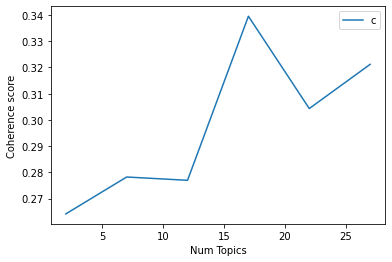

In [57]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score1)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [58]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score1):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 17

index: 0 | Num Topics = 2  has Coherence Value of 0.2642
index: 1 | Num Topics = 7  has Coherence Value of 0.2782
index: 2 | Num Topics = 12  has Coherence Value of 0.277
index: 3 | Num Topics = 17  has Coherence Value of 0.3395
index: 4 | Num Topics = 22  has Coherence Value of 0.3043
index: 5 | Num Topics = 27  has Coherence Value of 0.3212


In [182]:
# Select optimal number of topics
optimal_model_us_score1 = model_list_us_score1[3]

In [183]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score1 = pyLDAvis.gensim_models.prepare(optimal_model_us_score1, corpus_us_score1, id2word_us_score1)

In [184]:
print("pyLDAVis for us topics for score=1:")
vis_us_score1

pyLDAVis for us topics for score=1:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.041700  0.114683       1        1  24.111117
14     0.346448  0.049704       2        1   9.823846
12    -0.058863  0.097563       3        1   9.514339
13    -0.064216  0.090320       4        1   8.038560
9     -0.060064 -0.034576       5        1   6.960209
5      0.023158 -0.093472       6        1   5.907547
0     -0.072752  0.137721       7        1   5.457264
2      0.037320 -0.007602       8        1   5.161290
7      0.052332  0.001606       9        1   4.878128
16     0.043420  0.074202      10        1   4.257087
15     0.002153 -0.111668      11        1   2.905280
4      0.014552 -0.048246      12        1   2.889431
1     -0.057631  0.008371      13        1   2.427187
3     -0.014568 -0.074477      14        1   2.198927
10    -0.057344 -0.067942      15        1   2.189595
8     -0.083557 -0.019383      16        1   2.160111
11    -0.008688 -0.116806      17        1   1.120081, topic_info=      Term        Freq       Total Category  logprob  loglift
39    song  132.000000  132.000000  Default  30.0000  30.0000
7    video  301.000000  301.000000  Default  29.0000  29.0000
21   music   74.000000   74.000000  Default  28.0000  28.0000
0      app  370.000000  370.000000  Default  27.0000  27.0000
63    load   49.000000   49.000000  Default  26.0000  26.0000
..     ...         ...         ...      ...      ...      ...
63    load    1.114951   49.750433  Topic17  -4.1453   0.6936
7    video    2.387209  301.441778  Topic17  -3.3840  -0.3467
32    time    1.230094  157.738312  Topic17  -4.0471  -0.3621
21   music    0.759150   74.800717  Topic17  -4.5297  -0.0986
115  crash    0.689183   61.977691  Topic17  -4.6264  -0.0073

[997 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
320       1  0.080916        able
320       2  0.404578        able
320       3  0.404578        able
320      14  0.080916        able
496       3  0.166521  absolutely
...     ...       ...         ...
377       8  0.125762        year
377      12  0.062881        year
462       2  0.388038         yet
462       7  0.388038         yet
661       6  0.924665       young

[1772 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 15, 13, 14, 10, 6, 1, 3, 8, 17, 16, 5, 2, 4, 11, 9, 12])

## LDA Topic Modelling (Rating = 2)

In [62]:
# By-rating Topic Modelling - rating = 2
# Convert to list - move to each section
review_us_score2 = lomotif_ios_us_review_YearMonth_score2.review.values.tolist()
review_words_us_score2 = list(sent_to_words(review_us_score2))
print(review_words_us_score2[:1])

[['this', 'app', 'used', 'to', 'work', 'fine', 'like', 'nothing', 'was', 'wrong', 'but', 'all', 'of', 'sudden', 'it', 'stops', 'working', 'it', 'freezes', 'just', 'doesn', 'un', 'freeze', 'll', 'delete', 'it', 'then', 're', 'download', 'it', 'it', 'still', 'freezing', 'fix', 'please']]


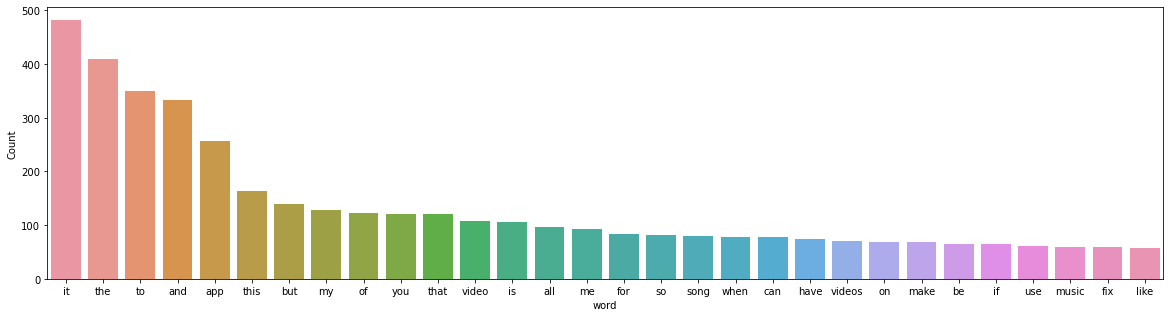

In [63]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score2))

In [64]:
# Clean text
review_us_ready_score2 = process_words(review_words_us_score2)  # processed Text Data! - move to each section


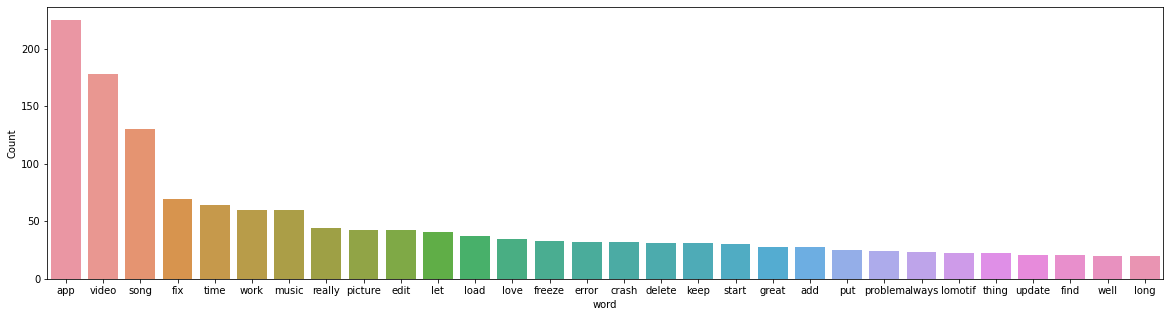

In [65]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score2))


In [66]:
# Create Dictionary
id2word_us_score2 = corpora.Dictionary(review_us_ready_score2)

2021-10-17 02:24:24,453 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 02:24:24,472 [INFO] gensim.corpora.dictionary - built Dictionary(652 unique tokens: ['app', 'delete', 'download', 'fine', 'fix']...) from 244 documents (total 3304 corpus positions)
2021-10-17 02:24:24,475 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(652 unique tokens: ['app', 'delete', 'download', 'fine', 'fix']...) from 244 documents (total 3304 corpus positions)", 'datetime': '2021-10-17T02:24:24.475824', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [67]:
# Create Corpus: Term Document Frequency
corpus_us_score2 = [id2word_us_score2.doc2bow(text) for text in review_us_ready_score2]

In [68]:
# Training LDA model
model_list_us_score2, coherence_values_us_score2 = compute_coherence_values(dictionary=id2word_us_score2, corpus=corpus_us_score2, 
                                                              texts=review_us_ready_score2, limit=30, start=2, step=5)


2021-10-17 02:24:24,544 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 02:24:24,550 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 02:24:24,554 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 02:24:24,556 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 244 documents, updating model once every 244 documents, evaluating perplexity every 244 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 02:24:25,647 [INFO] gensim.models.ldamodel - -7.053 per-word bound, 132.7 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:24:25,648 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #244/244
2021-10-17 02:24:26,658 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"video" + 0.023*"app" + 0.021*"time" + 0.020*"let" + 0.018*"fix" + 0.018*"music" + 0.013*"song" + 

2021-10-17 02:24:35,833 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.070*"app" + 0.052*"video" + 0.042*"song" + 0.020*"fix" + 0.019*"work" + 0.018*"time" + 0.014*"really" + 0.014*"music" + 0.012*"picture" + 0.012*"edit"
2021-10-17 02:24:35,840 [INFO] gensim.models.ldamodel - topic diff=0.018500, rho=0.301511
2021-10-17 02:24:36,297 [INFO] gensim.models.ldamodel - -5.740 per-word bound, 53.4 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:24:36,313 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #244/244
2021-10-17 02:24:36,576 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.023*"video" + 0.022*"let" + 0.022*"music" + 0.014*"app" + 0.013*"people" + 0.012*"add" + 0.011*"fix" + 0.011*"clip" + 0.011*"time" + 0.009*"new"
2021-10-17 02:24:36,577 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.070*"app" + 0.052*"video" + 0.042*"song" + 0.020*"fix" + 0.019*"work" + 0.018*"time" + 0.014*"really" + 0.014*"music" + 0.013*

2021-10-17 02:24:43,038 [INFO] gensim.models.ldamodel - topic diff=0.009119, rho=0.218218
2021-10-17 02:24:43,409 [INFO] gensim.models.ldamodel - -5.726 per-word bound, 52.9 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:24:43,410 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #244/244
2021-10-17 02:24:43,686 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"video" + 0.021*"music" + 0.021*"let" + 0.017*"app" + 0.016*"people" + 0.013*"add" + 0.012*"clip" + 0.010*"update" + 0.010*"new" + 0.008*"time"
2021-10-17 02:24:43,688 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.069*"app" + 0.052*"video" + 0.043*"song" + 0.021*"fix" + 0.020*"work" + 0.019*"time" + 0.014*"music" + 0.014*"really" + 0.013*"picture" + 0.012*"load"
2021-10-17 02:24:43,689 [INFO] gensim.models.ldamodel - topic diff=0.008223, rho=0.213201
2021-10-17 02:24:44,094 [INFO] gensim.models.ldamodel - -5.726 per-word bound, 52.9 perplexity estimate based

2021-10-17 02:24:49,810 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #244/244
2021-10-17 02:24:50,069 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.023*"video" + 0.020*"music" + 0.020*"let" + 0.019*"app" + 0.017*"people" + 0.013*"add" + 0.012*"clip" + 0.011*"update" + 0.010*"new" + 0.008*"child"
2021-10-17 02:24:50,073 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.069*"app" + 0.052*"video" + 0.043*"song" + 0.021*"fix" + 0.020*"work" + 0.019*"time" + 0.014*"music" + 0.013*"really" + 0.013*"picture" + 0.012*"load"
2021-10-17 02:24:50,076 [INFO] gensim.models.ldamodel - topic diff=0.003239, rho=0.176777
2021-10-17 02:24:50,395 [INFO] gensim.models.ldamodel - -5.722 per-word bound, 52.8 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:24:50,397 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #244/244
2021-10-17 02:24:50,643 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.023*"video" + 0.020*"music

2021-10-17 02:24:57,732 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.068*"app" + 0.052*"video" + 0.043*"song" + 0.022*"fix" + 0.020*"work" + 0.019*"time" + 0.014*"music" + 0.013*"really" + 0.013*"picture" + 0.012*"load"
2021-10-17 02:24:57,734 [INFO] gensim.models.ldamodel - topic diff=0.001922, rho=0.154303
2021-10-17 02:24:58,140 [INFO] gensim.models.ldamodel - -5.721 per-word bound, 52.8 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:24:58,151 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #244/244
2021-10-17 02:24:58,417 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.023*"video" + 0.021*"app" + 0.019*"let" + 0.019*"music" + 0.019*"people" + 0.013*"add" + 0.012*"clip" + 0.011*"update" + 0.010*"new" + 0.008*"child"
2021-10-17 02:24:58,421 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.068*"app" + 0.052*"video" + 0.043*"song" + 0.022*"fix" + 0.020*"work" + 0.019*"time" + 0.014*"music" + 0.013*"really" + 0.

2021-10-17 02:25:08,837 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 240 virtual documents
2021-10-17 02:25:09,158 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 02:25:09,160 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 02:25:09,163 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 02:25:09,167 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 244 documents, updating model once every 244 documents, evaluating perplexity every 244 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 02:25:09,948 [INFO] gensim.models.ldamodel - -8.461 per-word bound, 352.5 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:25:09,949 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #244/244
2021-10-17 02:25

2021-10-17 02:25:14,222 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #244/244
2021-10-17 02:25:14,477 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.040*"app" + 0.035*"video" + 0.034*"song" + 0.025*"music" + 0.023*"fix" + 0.022*"freeze" + 0.020*"work" + 0.019*"load" + 0.015*"always" + 0.014*"keep"
2021-10-17 02:25:14,479 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.059*"app" + 0.054*"video" + 0.033*"music" + 0.031*"song" + 0.028*"fix" + 0.020*"let" + 0.018*"really" + 0.016*"great" + 0.016*"search" + 0.013*"problem"
2021-10-17 02:25:14,481 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.059*"app" + 0.027*"child" + 0.015*"fix" + 0.015*"people" + 0.012*"user" + 0.012*"load" + 0.012*"creep" + 0.012*"update" + 0.011*"keep" + 0.009*"really"
2021-10-17 02:25:14,482 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.050*"video" + 0.036*"time" + 0.030*"app" + 0.023*"edit" + 0.019*"song" + 0.017*"fix" + 0.016*"pick" + 0.014*"freeze" + 0.013*"photo" + 0.013*"lomo

2021-10-17 02:25:18,281 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.050*"video" + 0.036*"time" + 0.031*"app" + 0.023*"edit" + 0.018*"fix" + 0.018*"song" + 0.016*"pick" + 0.014*"progress" + 0.014*"freeze" + 0.013*"photo"
2021-10-17 02:25:18,282 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.021*"sign" + 0.020*"time" + 0.017*"picture" + 0.017*"fix" + 0.016*"edit" + 0.016*"always" + 0.015*"let" + 0.011*"video" + 0.011*"work" + 0.011*"show"
2021-10-17 02:25:18,283 [INFO] gensim.models.ldamodel - topic diff=0.016460, rho=0.288675
2021-10-17 02:25:18,658 [INFO] gensim.models.ldamodel - -6.024 per-word bound, 65.1 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:25:18,659 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #244/244
2021-10-17 02:25:19,001 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.053*"app" + 0.030*"child" + 0.017*"people" + 0.013*"user" + 0.013*"creep" + 0.011*"load" + 0.010*"update" + 0.009*"fix" 

2021-10-17 02:25:22,523 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.047*"app" + 0.032*"child" + 0.018*"people" + 0.014*"user" + 0.014*"creep" + 0.010*"load" + 0.010*"update" + 0.009*"create" + 0.009*"account" + 0.009*"option"
2021-10-17 02:25:22,525 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.074*"app" + 0.067*"video" + 0.041*"time" + 0.029*"crash" + 0.021*"start" + 0.019*"second" + 0.019*"people" + 0.016*"edit" + 0.015*"picture" + 0.015*"fix"
2021-10-17 02:25:22,527 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.050*"video" + 0.035*"time" + 0.031*"app" + 0.023*"edit" + 0.019*"fix" + 0.017*"song" + 0.017*"pick" + 0.015*"progress" + 0.014*"freeze" + 0.014*"glitch"
2021-10-17 02:25:22,529 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.022*"sign" + 0.020*"time" + 0.017*"picture" + 0.017*"edit" + 0.016*"always" + 0.015*"fix" + 0.013*"let" + 0.011*"show" + 0.011*"editing" + 0.011*"glitche"
2021-10-17 02:25:22,532 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.

2021-10-17 02:25:26,221 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.039*"app" + 0.037*"video" + 0.033*"song" + 0.024*"music" + 0.024*"work" + 0.024*"freeze" + 0.021*"fix" + 0.019*"load" + 0.016*"delete" + 0.015*"keep"
2021-10-17 02:25:26,224 [INFO] gensim.models.ldamodel - topic diff=0.004308, rho=0.208514
2021-10-17 02:25:26,611 [INFO] gensim.models.ldamodel - -6.015 per-word bound, 64.7 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:25:26,613 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #244/244
2021-10-17 02:25:26,945 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.074*"app" + 0.067*"video" + 0.040*"time" + 0.029*"crash" + 0.021*"start" + 0.019*"second" + 0.019*"people" + 0.016*"edit" + 0.015*"picture" + 0.015*"fix"
2021-10-17 02:25:26,946 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.049*"video" + 0.036*"time" + 0.032*"app" + 0.023*"edit" + 0.019*"fix" + 0.017*"song" + 0.017*"pick" + 0.015*"progress"

2021-10-17 02:25:30,665 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.062*"app" + 0.055*"video" + 0.037*"music" + 0.034*"song" + 0.033*"fix" + 0.020*"really" + 0.019*"let" + 0.017*"search" + 0.016*"great" + 0.014*"play"
2021-10-17 02:25:30,667 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.039*"app" + 0.037*"video" + 0.033*"song" + 0.024*"music" + 0.024*"work" + 0.024*"freeze" + 0.021*"fix" + 0.019*"load" + 0.016*"delete" + 0.015*"keep"
2021-10-17 02:25:30,670 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.034*"app" + 0.034*"child" + 0.019*"people" + 0.015*"user" + 0.015*"creep" + 0.011*"load" + 0.010*"account" + 0.010*"create" + 0.010*"option" + 0.010*"attempt"
2021-10-17 02:25:30,672 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.022*"sign" + 0.021*"time" + 0.017*"picture" + 0.017*"edit" + 0.016*"always" + 0.014*"fix" + 0.012*"show" + 0.012*"glitche" + 0.012*"editing" + 0.012*"middle"
2021-10-17 02:25:30,673 [INFO] gensim.models.ldamodel - topic diff=0.002816, rh

2021-10-17 02:25:34,572 [INFO] gensim.models.ldamodel - topic diff=0.002034, rho=0.171499
2021-10-17 02:25:35,214 [INFO] gensim.models.ldamodel - -6.012 per-word bound, 64.5 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:25:35,218 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #244/244
2021-10-17 02:25:35,781 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.034*"child" + 0.032*"app" + 0.019*"people" + 0.015*"user" + 0.015*"creep" + 0.011*"load" + 0.010*"account" + 0.010*"create" + 0.010*"option" + 0.010*"attempt"
2021-10-17 02:25:35,787 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.075*"app" + 0.067*"video" + 0.039*"time" + 0.028*"crash" + 0.021*"start" + 0.019*"second" + 0.019*"people" + 0.016*"edit" + 0.015*"picture" + 0.015*"fix"
2021-10-17 02:25:35,789 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.049*"video" + 0.037*"time" + 0.033*"app" + 0.023*"edit" + 0.019*"fix" + 0.017*"pick" + 0.016*"song" + 0.015*"

2021-10-17 02:25:41,123 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.034*"child" + 0.031*"app" + 0.019*"people" + 0.015*"user" + 0.015*"creep" + 0.011*"load" + 0.010*"account" + 0.010*"create" + 0.010*"option" + 0.010*"attempt"
2021-10-17 02:25:41,134 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.061*"app" + 0.055*"video" + 0.037*"music" + 0.034*"song" + 0.033*"fix" + 0.020*"really" + 0.019*"let" + 0.017*"search" + 0.016*"great" + 0.015*"play"
2021-10-17 02:25:41,136 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.073*"app" + 0.059*"song" + 0.045*"video" + 0.022*"work" + 0.019*"picture" + 0.017*"love" + 0.013*"really" + 0.013*"add" + 0.012*"let" + 0.012*"time"
2021-10-17 02:25:41,140 [INFO] gensim.models.ldamodel - topic diff=0.001331, rho=0.158114
2021-10-17 02:25:41,534 [INFO] gensim.models.ldamodel - -6.011 per-word bound, 64.5 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:25:41,548 [INFO] gensim.models.ldamodel - PROG

2021-10-17 02:25:44,786 [INFO] gensim.models.ldamodel - -6.010 per-word bound, 64.4 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:25:44,787 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #244/244
2021-10-17 02:25:45,036 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.061*"app" + 0.055*"video" + 0.037*"music" + 0.034*"song" + 0.033*"fix" + 0.020*"really" + 0.019*"let" + 0.017*"search" + 0.015*"great" + 0.015*"play"
2021-10-17 02:25:45,047 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.034*"child" + 0.030*"app" + 0.019*"people" + 0.015*"user" + 0.015*"creep" + 0.011*"load" + 0.010*"account" + 0.010*"create" + 0.010*"option" + 0.010*"attempt"
2021-10-17 02:25:45,055 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.022*"sign" + 0.021*"time" + 0.017*"picture" + 0.017*"edit" + 0.016*"always" + 0.014*"fix" + 0.012*"show" + 0.012*"glitche" + 0.012*"editing" + 0.012*"middle"
2021-10-17 02:25:45,062 [INFO] gensim.models.

2021-10-17 02:25:48,792 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.039*"app" + 0.037*"video" + 0.033*"song" + 0.024*"music" + 0.024*"work" + 0.024*"freeze" + 0.021*"fix" + 0.019*"load" + 0.016*"delete" + 0.015*"keep"
2021-10-17 02:25:48,794 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.075*"app" + 0.068*"video" + 0.038*"time" + 0.028*"crash" + 0.022*"start" + 0.019*"second" + 0.019*"people" + 0.017*"edit" + 0.015*"fix" + 0.015*"picture"
2021-10-17 02:25:48,796 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.073*"app" + 0.059*"song" + 0.045*"video" + 0.022*"work" + 0.019*"picture" + 0.017*"love" + 0.013*"really" + 0.013*"add" + 0.012*"let" + 0.012*"time"
2021-10-17 02:25:48,798 [INFO] gensim.models.ldamodel - topic diff=0.000830, rho=0.140028
2021-10-17 02:25:48,799 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=652, num_topics=7, decay=0.5, chunksize=1000) in 39.63s', 'datetime': '2021-10-17T02:25:48.799746', 'gensim': '4.1.2', 'py

2021-10-17 02:25:59,942 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #244/244
2021-10-17 02:26:00,285 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.054*"app" + 0.048*"music" + 0.028*"really" + 0.025*"edit" + 0.025*"video" + 0.022*"fix" + 0.017*"let" + 0.016*"well" + 0.016*"problem" + 0.016*"great"
2021-10-17 02:26:00,291 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.047*"camera" + 0.044*"roll" + 0.036*"start" + 0.026*"picture" + 0.024*"crash" + 0.017*"show" + 0.014*"time" + 0.013*"none" + 0.013*"whenever" + 0.013*"select"
2021-10-17 02:26:00,292 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.058*"song" + 0.045*"video" + 0.026*"load" + 0.025*"keep" + 0.021*"edit" + 0.021*"thing" + 0.020*"annoying" + 0.020*"time" + 0.019*"photo" + 0.016*"lomotif"
2021-10-17 02:26:00,295 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.084*"app" + 0.063*"song" + 0.059*"video" + 0.023*"work" + 0.016*"really" + 0.014*"great" + 0.014*"love" + 0.013*"picture" + 0.013*"err

2021-10-17 02:26:03,563 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.068*"video" + 0.065*"app" + 0.044*"time" + 0.026*"fix" + 0.023*"start" + 0.019*"picture" + 0.016*"put" + 0.016*"people" + 0.014*"crash" + 0.014*"love"
2021-10-17 02:26:03,567 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.074*"video" + 0.073*"app" + 0.033*"fix" + 0.030*"edit" + 0.023*"really" + 0.020*"song" + 0.017*"picture" + 0.016*"love" + 0.015*"cool" + 0.015*"freeze"
2021-10-17 02:26:03,568 [INFO] gensim.models.ldamodel - topic diff=0.024854, rho=0.301511
2021-10-17 02:26:03,908 [INFO] gensim.models.ldamodel - -6.196 per-word bound, 73.3 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:26:03,909 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #244/244
2021-10-17 02:26:04,179 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.058*"camera" + 0.048*"roll" + 0.036*"start" + 0.027*"picture" + 0.024*"crash" + 0.019*"show" + 0.014*"time" + 0.013*"n

2021-10-17 02:26:07,323 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.078*"video" + 0.073*"app" + 0.032*"edit" + 0.031*"fix" + 0.024*"really" + 0.018*"picture" + 0.018*"long" + 0.017*"freeze" + 0.016*"love" + 0.016*"cool"
2021-10-17 02:26:07,324 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.083*"app" + 0.066*"song" + 0.055*"video" + 0.024*"work" + 0.017*"really" + 0.015*"great" + 0.014*"error" + 0.014*"love" + 0.012*"find" + 0.012*"time"
2021-10-17 02:26:07,326 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.053*"let" + 0.029*"video" + 0.028*"time" + 0.021*"select" + 0.017*"picture" + 0.014*"editing" + 0.014*"middle" + 0.014*"crash" + 0.014*"press" + 0.014*"work"
2021-10-17 02:26:07,329 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.056*"app" + 0.045*"music" + 0.029*"really" + 0.025*"edit" + 0.024*"fix" + 0.021*"problem" + 0.020*"video" + 0.017*"well" + 0.017*"start" + 0.016*"great"
2021-10-17 02:26:07,331 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.084*"ap

2021-10-17 02:26:10,389 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.075*"song" + 0.042*"app" + 0.037*"video" + 0.027*"search" + 0.025*"music" + 0.025*"error" + 0.020*"fix" + 0.020*"time" + 0.018*"load" + 0.015*"play"
2021-10-17 02:26:10,390 [INFO] gensim.models.ldamodel - topic diff=0.007493, rho=0.213201
2021-10-17 02:26:10,664 [INFO] gensim.models.ldamodel - -6.175 per-word bound, 72.2 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:26:10,673 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #244/244
2021-10-17 02:26:10,964 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.070*"app" + 0.025*"fix" + 0.025*"delete" + 0.019*"create" + 0.019*"year" + 0.017*"problem" + 0.016*"love" + 0.015*"user" + 0.015*"people" + 0.015*"actually"
2021-10-17 02:26:10,965 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.079*"video" + 0.074*"app" + 0.033*"edit" + 0.030*"fix" + 0.024*"really" + 0.019*"long" + 0.018*"picture" + 0.018*"fr

2021-10-17 02:26:13,824 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.075*"video" + 0.068*"app" + 0.040*"time" + 0.026*"fix" + 0.020*"start" + 0.018*"picture" + 0.016*"put" + 0.016*"people" + 0.016*"love" + 0.013*"long"
2021-10-17 02:26:13,825 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.052*"let" + 0.029*"video" + 0.028*"time" + 0.021*"select" + 0.016*"picture" + 0.014*"editing" + 0.014*"middle" + 0.014*"crash" + 0.014*"press" + 0.014*"work"
2021-10-17 02:26:13,826 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.063*"video" + 0.057*"app" + 0.057*"music" + 0.043*"add" + 0.033*"work" + 0.025*"picture" + 0.024*"update" + 0.019*"let" + 0.017*"delete" + 0.016*"freeze"
2021-10-17 02:26:13,829 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.056*"app" + 0.041*"music" + 0.029*"really" + 0.026*"edit" + 0.025*"fix" + 0.022*"problem" + 0.017*"well" + 0.017*"start" + 0.017*"never" + 0.017*"video"
2021-10-17 02:26:13,830 [INFO] gensim.models.ldamodel - topic diff=0.004016, rho

2021-10-17 02:26:16,811 [INFO] gensim.models.ldamodel - topic diff=0.003161, rho=0.174078
2021-10-17 02:26:17,168 [INFO] gensim.models.ldamodel - -6.166 per-word bound, 71.8 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:26:17,169 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #244/244
2021-10-17 02:26:17,337 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.087*"app" + 0.028*"work" + 0.024*"keep" + 0.023*"time" + 0.023*"crash" + 0.020*"video" + 0.019*"child" + 0.018*"edit" + 0.018*"fix" + 0.016*"glitche"
2021-10-17 02:26:17,339 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.069*"song" + 0.040*"keep" + 0.038*"video" + 0.025*"load" + 0.023*"guy" + 0.023*"time" + 0.022*"edit" + 0.020*"fix" + 0.020*"error" + 0.019*"thing"
2021-10-17 02:26:17,341 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.079*"video" + 0.074*"app" + 0.034*"edit" + 0.030*"fix" + 0.024*"really" + 0.020*"long" + 0.019*"freeze" + 0.018*"picture" + 0

2021-10-17 02:26:20,344 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.079*"song" + 0.041*"app" + 0.034*"video" + 0.028*"search" + 0.027*"music" + 0.024*"error" + 0.020*"time" + 0.019*"load" + 0.018*"fix" + 0.018*"download"
2021-10-17 02:26:20,352 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.071*"app" + 0.027*"delete" + 0.026*"fix" + 0.020*"create" + 0.020*"year" + 0.018*"problem" + 0.015*"user" + 0.015*"people" + 0.015*"actually" + 0.015*"love"
2021-10-17 02:26:20,375 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.064*"video" + 0.060*"app" + 0.056*"music" + 0.046*"add" + 0.032*"work" + 0.025*"picture" + 0.025*"update" + 0.020*"let" + 0.017*"delete" + 0.016*"freeze"
2021-10-17 02:26:20,383 [INFO] gensim.models.ldamodel - topic diff=0.002626, rho=0.160128
2021-10-17 02:26:20,668 [INFO] gensim.models.ldamodel - -6.163 per-word bound, 71.7 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:26:20,671 [INFO] gensim.models.ldamodel

2021-10-17 02:26:23,588 [INFO] gensim.models.ldamodel - -6.160 per-word bound, 71.5 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:26:23,590 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #244/244
2021-10-17 02:26:23,887 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.051*"let" + 0.029*"video" + 0.028*"time" + 0.021*"select" + 0.016*"picture" + 0.014*"delete" + 0.014*"middle" + 0.014*"crash" + 0.014*"work" + 0.014*"press"
2021-10-17 02:26:23,889 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.076*"video" + 0.068*"app" + 0.040*"time" + 0.026*"fix" + 0.019*"start" + 0.018*"picture" + 0.016*"people" + 0.016*"put" + 0.016*"love" + 0.013*"long"
2021-10-17 02:26:23,903 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.056*"app" + 0.039*"music" + 0.029*"really" + 0.026*"edit" + 0.026*"fix" + 0.023*"problem" + 0.018*"never" + 0.018*"well" + 0.018*"start" + 0.017*"great"
2021-10-17 02:26:23,912 [INFO] gensim.models.ldamode

2021-10-17 02:26:26,833 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.076*"video" + 0.068*"app" + 0.040*"time" + 0.026*"fix" + 0.019*"start" + 0.018*"picture" + 0.016*"love" + 0.016*"people" + 0.016*"put" + 0.013*"long"
2021-10-17 02:26:26,836 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.070*"song" + 0.042*"keep" + 0.037*"video" + 0.025*"load" + 0.023*"guy" + 0.023*"time" + 0.023*"edit" + 0.021*"error" + 0.021*"fix" + 0.019*"thing"
2021-10-17 02:26:26,838 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.080*"song" + 0.041*"app" + 0.034*"video" + 0.028*"music" + 0.028*"search" + 0.025*"error" + 0.020*"time" + 0.020*"load" + 0.019*"fix" + 0.018*"download"
2021-10-17 02:26:26,840 [INFO] gensim.models.ldamodel - topic diff=0.001877, rho=0.141421
2021-10-17 02:26:27,188 [INFO] gensim.models.ldamodel - -6.159 per-word bound, 71.4 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:26:27,189 [INFO] gensim.models.ldamodel - PROGRESS: pa

2021-10-17 02:26:36,328 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #244/244
2021-10-17 02:26:36,545 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.079*"app" + 0.037*"video" + 0.030*"time" + 0.022*"fix" + 0.021*"song" + 0.019*"tired" + 0.016*"delete" + 0.016*"day" + 0.015*"really" + 0.015*"crash"
2021-10-17 02:26:36,547 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.072*"app" + 0.063*"video" + 0.051*"fix" + 0.039*"let" + 0.033*"music" + 0.021*"song" + 0.020*"problem" + 0.020*"select" + 0.016*"back" + 0.015*"part"
2021-10-17 02:26:36,548 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.068*"video" + 0.058*"app" + 0.032*"time" + 0.032*"fix" + 0.026*"picture" + 0.021*"start" + 0.021*"lomotif" + 0.021*"keep" + 0.016*"gon" + 0.016*"work"
2021-10-17 02:26:36,550 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.060*"video" + 0.058*"pick" + 0.050*"song" + 0.039*"load" + 0.032*"photo" + 0.024*"error" + 0.023*"allow" + 0.022*"music" + 0.020*"everytime" + 0.020*"

2021-10-17 02:26:39,303 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.054*"app" + 0.037*"video" + 0.031*"song" + 0.025*"add" + 0.024*"music" + 0.022*"time" + 0.020*"download" + 0.018*"load" + 0.018*"fix" + 0.016*"work"
2021-10-17 02:26:39,304 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.077*"app" + 0.077*"song" + 0.044*"video" + 0.031*"work" + 0.027*"love" + 0.018*"really" + 0.018*"fix" + 0.017*"error" + 0.016*"select" + 0.015*"time"
2021-10-17 02:26:39,305 [INFO] gensim.models.ldamodel - topic diff=0.033562, rho=0.316228
2021-10-17 02:26:39,502 [INFO] gensim.models.ldamodel - -6.307 per-word bound, 79.2 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:26:39,504 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #244/244
2021-10-17 02:26:39,807 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.037*"app" + 0.035*"video" + 0.030*"edit" + 0.029*"delete" + 0.026*"always" + 0.026*"able" + 0.019*"fix" + 0.019*"music" + 0.

2021-10-17 02:26:42,519 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #244/244
2021-10-17 02:26:42,806 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.079*"app" + 0.041*"crash" + 0.040*"video" + 0.030*"freeze" + 0.025*"start" + 0.023*"child" + 0.019*"time" + 0.015*"problem" + 0.015*"lomotif" + 0.015*"stop"
2021-10-17 02:26:42,809 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.084*"song" + 0.075*"app" + 0.042*"video" + 0.032*"work" + 0.029*"love" + 0.018*"really" + 0.018*"error" + 0.018*"fix" + 0.017*"select" + 0.015*"time"
2021-10-17 02:26:42,811 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.036*"app" + 0.032*"song" + 0.029*"purchase" + 0.026*"let" + 0.018*"load" + 0.018*"absolutely" + 0.013*"music" + 0.012*"time" + 0.012*"video" + 0.012*"really"
2021-10-17 02:26:42,812 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.079*"work" + 0.035*"video" + 0.032*"slow" + 0.025*"app" + 0.022*"load" + 0.022*"huge" + 0.020*"enough" + 0.017*"play" + 0.015*"proble

2021-10-17 02:26:45,807 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.043*"time" + 0.029*"close" + 0.015*"edit" + 0.015*"show" + 0.015*"picture" + 0.015*"video" + 0.015*"work" + 0.015*"load" + 0.015*"delete" + 0.015*"finish"
2021-10-17 02:26:45,809 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.081*"app" + 0.044*"crash" + 0.039*"video" + 0.031*"freeze" + 0.025*"start" + 0.022*"child" + 0.020*"time" + 0.016*"problem" + 0.015*"stop" + 0.015*"lomotif"
2021-10-17 02:26:45,809 [INFO] gensim.models.ldamodel - topic diff=0.008668, rho=0.218218
2021-10-17 02:26:46,103 [INFO] gensim.models.ldamodel - -6.275 per-word bound, 77.4 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:26:46,105 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #244/244
2021-10-17 02:26:46,373 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.088*"app" + 0.049*"video" + 0.034*"time" + 0.021*"hour" + 0.021*"fix" + 0.021*"tired" + 0.017*"delete" + 0.01

2021-10-17 02:26:49,084 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #244/244
2021-10-17 02:26:49,272 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.092*"video" + 0.074*"app" + 0.044*"picture" + 0.027*"long" + 0.025*"edit" + 0.025*"second" + 0.022*"great" + 0.020*"freeze" + 0.018*"put" + 0.017*"thing"
2021-10-17 02:26:49,282 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.052*"app" + 0.049*"play" + 0.041*"fix" + 0.038*"never" + 0.026*"song" + 0.026*"delete" + 0.026*"people" + 0.026*"unavailable" + 0.018*"bug" + 0.015*"problem"
2021-10-17 02:26:49,291 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.083*"work" + 0.040*"video" + 0.040*"slow" + 0.032*"app" + 0.021*"load" + 0.021*"huge" + 0.021*"enough" + 0.020*"delete" + 0.019*"play" + 0.019*"fix"
2021-10-17 02:26:49,294 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.037*"app" + 0.030*"purchase" + 0.029*"song" + 0.026*"let" + 0.018*"absolutely" + 0.014*"load" + 0.012*"time" + 0.012*"video" + 0.012*"rea

2021-10-17 02:26:52,193 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.092*"video" + 0.074*"app" + 0.045*"picture" + 0.028*"long" + 0.025*"edit" + 0.025*"second" + 0.022*"great" + 0.020*"freeze" + 0.019*"put" + 0.017*"thing"
2021-10-17 02:26:52,196 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.037*"app" + 0.030*"purchase" + 0.029*"song" + 0.026*"let" + 0.018*"absolutely" + 0.014*"load" + 0.013*"time" + 0.012*"video" + 0.012*"really" + 0.012*"fix"
2021-10-17 02:26:52,197 [INFO] gensim.models.ldamodel - topic diff=0.003827, rho=0.176777
2021-10-17 02:26:52,501 [INFO] gensim.models.ldamodel - -6.265 per-word bound, 76.9 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:26:52,515 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #244/244
2021-10-17 02:26:52,789 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.088*"app" + 0.049*"video" + 0.034*"time" + 0.021*"hour" + 0.021*"fix" + 0.020*"tired" + 0.016*"delete" + 0.016*

2021-10-17 02:26:55,720 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.092*"video" + 0.074*"app" + 0.045*"picture" + 0.028*"long" + 0.026*"edit" + 0.026*"second" + 0.023*"great" + 0.021*"freeze" + 0.019*"put" + 0.017*"thing"
2021-10-17 02:26:55,721 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.093*"song" + 0.074*"app" + 0.039*"video" + 0.032*"work" + 0.030*"love" + 0.022*"error" + 0.019*"select" + 0.019*"really" + 0.018*"fix" + 0.017*"time"
2021-10-17 02:26:55,723 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.037*"video" + 0.036*"delete" + 0.035*"app" + 0.033*"edit" + 0.027*"always" + 0.027*"able" + 0.019*"fix" + 0.019*"music" + 0.018*"anymore" + 0.018*"length"
2021-10-17 02:26:55,724 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.041*"song" + 0.029*"work" + 0.028*"video" + 0.027*"time" + 0.025*"app" + 0.019*"save" + 0.014*"new" + 0.014*"restart" + 0.014*"put" + 0.014*"crop"
2021-10-17 02:26:55,727 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.053*"app" + 

2021-10-17 02:26:58,714 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.067*"app" + 0.036*"work" + 0.027*"video" + 0.020*"time" + 0.020*"really" + 0.018*"freeze" + 0.016*"glitch" + 0.016*"glitche" + 0.016*"crash" + 0.015*"picture"
2021-10-17 02:26:58,716 [INFO] gensim.models.ldamodel - topic diff=0.002201, rho=0.152499
2021-10-17 02:26:59,091 [INFO] gensim.models.ldamodel - -6.256 per-word bound, 76.4 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:26:59,093 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #244/244
2021-10-17 02:26:59,368 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.088*"app" + 0.049*"video" + 0.033*"time" + 0.021*"hour" + 0.021*"fix" + 0.020*"tired" + 0.016*"delete" + 0.016*"crash" + 0.016*"day" + 0.016*"really"
2021-10-17 02:26:59,373 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.094*"song" + 0.073*"app" + 0.039*"video" + 0.032*"work" + 0.030*"love" + 0.023*"error" + 0.020*"select" + 0.019*

2021-10-17 02:27:02,302 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.092*"video" + 0.087*"music" + 0.068*"add" + 0.053*"pick" + 0.050*"load" + 0.046*"song" + 0.036*"photo" + 0.035*"allow" + 0.027*"error" + 0.017*"edit"
2021-10-17 02:27:02,304 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.105*"song" + 0.057*"app" + 0.035*"search" + 0.034*"error" + 0.024*"really" + 0.023*"certain" + 0.019*"people" + 0.018*"music" + 0.018*"keep" + 0.016*"guy"
2021-10-17 02:27:02,305 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.068*"video" + 0.066*"app" + 0.047*"let" + 0.046*"fix" + 0.044*"music" + 0.028*"problem" + 0.022*"part" + 0.021*"update" + 0.018*"back" + 0.017*"cool"
2021-10-17 02:27:02,309 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.082*"work" + 0.043*"video" + 0.040*"slow" + 0.037*"app" + 0.023*"fix" + 0.023*"delete" + 0.020*"load" + 0.020*"huge" + 0.020*"enough" + 0.020*"song"
2021-10-17 02:27:02,311 [INFO] gensim.models.ldamodel - topic diff=0.001870, rho=0.142857


2021-10-17 02:27:12,000 [INFO] gensim.models.ldamodel - topic diff=0.152130, rho=0.577350
2021-10-17 02:27:12,315 [INFO] gensim.models.ldamodel - -6.519 per-word bound, 91.7 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:27:12,316 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #244/244
2021-10-17 02:27:12,510 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.064*"app" + 0.061*"video" + 0.043*"fix" + 0.027*"time" + 0.024*"crash" + 0.020*"start" + 0.018*"edit" + 0.017*"work" + 0.013*"great" + 0.013*"really"
2021-10-17 02:27:12,512 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.055*"video" + 0.054*"let" + 0.038*"music" + 0.026*"select" + 0.020*"show" + 0.020*"search" + 0.020*"allow" + 0.019*"work" + 0.019*"fix" + 0.018*"help"
2021-10-17 02:27:12,514 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.063*"sign" + 0.059*"day" + 0.058*"busy" + 0.055*"server" + 0.029*"work" + 0.027*"problem" + 0.026*"later" + 0.022*"moment

2021-10-17 02:27:15,573 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.075*"video" + 0.044*"app" + 0.041*"edit" + 0.034*"load" + 0.031*"freeze" + 0.031*"crash" + 0.031*"keep" + 0.024*"song" + 0.021*"minute" + 0.021*"part"
2021-10-17 02:27:15,575 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.067*"video" + 0.063*"app" + 0.061*"song" + 0.027*"picture" + 0.021*"fix" + 0.016*"really" + 0.016*"love" + 0.016*"part" + 0.015*"time" + 0.014*"load"
2021-10-17 02:27:15,576 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.091*"song" + 0.035*"app" + 0.029*"search" + 0.028*"video" + 0.028*"load" + 0.027*"music" + 0.027*"error" + 0.025*"fix" + 0.024*"preview" + 0.021*"download"
2021-10-17 02:27:15,576 [INFO] gensim.models.ldamodel - topic diff=0.046793, rho=0.333333
2021-10-17 02:27:15,937 [INFO] gensim.models.ldamodel - -6.380 per-word bound, 83.3 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:27:15,938 [INFO] gensim.models.ldamodel - PROGR

2021-10-17 02:27:18,922 [INFO] gensim.models.ldamodel - -6.357 per-word bound, 81.9 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:27:18,923 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #244/244
2021-10-17 02:27:19,116 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.088*"pick" + 0.053*"song" + 0.046*"time" + 0.029*"video" + 0.029*"guy" + 0.028*"add" + 0.028*"fix" + 0.026*"well" + 0.026*"photo" + 0.024*"straight"
2021-10-17 02:27:19,166 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.066*"video" + 0.063*"app" + 0.062*"song" + 0.025*"picture" + 0.022*"fix" + 0.018*"really" + 0.017*"part" + 0.017*"love" + 0.014*"load" + 0.014*"find"
2021-10-17 02:27:19,167 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.033*"app" + 0.033*"picture" + 0.033*"start" + 0.029*"really" + 0.029*"camera" + 0.025*"edit" + 0.024*"roll" + 0.020*"let" + 0.017*"able" + 0.017*"first"
2021-10-17 02:27:19,169 [INFO] gensim.models.ldamodel - topi

2021-10-17 02:27:22,021 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.061*"let" + 0.056*"video" + 0.038*"music" + 0.028*"select" + 0.019*"work" + 0.019*"search" + 0.019*"show" + 0.019*"allow" + 0.019*"fix" + 0.019*"help"
2021-10-17 02:27:22,024 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.092*"song" + 0.035*"app" + 0.033*"error" + 0.032*"load" + 0.029*"search" + 0.027*"fix" + 0.026*"music" + 0.025*"video" + 0.025*"preview" + 0.021*"click"
2021-10-17 02:27:22,025 [INFO] gensim.models.ldamodel - topic diff=0.008595, rho=0.223607
2021-10-17 02:27:22,340 [INFO] gensim.models.ldamodel - -6.344 per-word bound, 81.3 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:27:22,342 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #244/244
2021-10-17 02:27:22,582 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.101*"video" + 0.046*"app" + 0.031*"never" + 0.027*"fix" + 0.027*"freeze" + 0.025*"save" + 0.024*"anymore" + 0.022*"ti

2021-10-17 02:27:25,678 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.161*"song" + 0.069*"work" + 0.060*"error" + 0.035*"load" + 0.030*"app" + 0.029*"whenever" + 0.026*"fix" + 0.025*"always" + 0.022*"really" + 0.017*"choose"
2021-10-17 02:27:25,679 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.036*"picture" + 0.032*"camera" + 0.032*"app" + 0.030*"start" + 0.030*"really" + 0.025*"edit" + 0.025*"roll" + 0.017*"able" + 0.017*"first" + 0.017*"put"
2021-10-17 02:27:25,680 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.073*"video" + 0.067*"app" + 0.040*"time" + 0.022*"put" + 0.022*"keep" + 0.017*"love" + 0.017*"second" + 0.017*"work" + 0.017*"completely" + 0.012*"music"
2021-10-17 02:27:25,682 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.103*"video" + 0.078*"music" + 0.050*"app" + 0.045*"add" + 0.029*"fix" + 0.029*"let" + 0.025*"people" + 0.024*"problem" + 0.023*"allow" + 0.021*"play"
2021-10-17 02:27:25,684 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.099*"a

2021-10-17 02:27:28,682 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.036*"picture" + 0.033*"camera" + 0.031*"app" + 0.030*"really" + 0.029*"start" + 0.026*"edit" + 0.026*"roll" + 0.017*"able" + 0.017*"first" + 0.017*"put"
2021-10-17 02:27:28,683 [INFO] gensim.models.ldamodel - topic diff=0.004415, rho=0.179605
2021-10-17 02:27:28,920 [INFO] gensim.models.ldamodel - -6.330 per-word bound, 80.5 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:27:28,922 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #244/244
2021-10-17 02:27:29,168 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.073*"app" + 0.055*"video" + 0.037*"time" + 0.034*"fix" + 0.027*"crash" + 0.026*"start" + 0.020*"work" + 0.020*"edit" + 0.019*"close" + 0.018*"photo"
2021-10-17 02:27:29,174 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.078*"video" + 0.045*"app" + 0.042*"edit" + 0.032*"crash" + 0.032*"freeze" + 0.024*"keep" + 0.022*"song" + 0.022*"load" 

2021-10-17 02:27:31,979 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.099*"video" + 0.045*"app" + 0.031*"never" + 0.028*"fix" + 0.026*"freeze" + 0.025*"anymore" + 0.023*"time" + 0.021*"save" + 0.021*"picture" + 0.019*"song"
2021-10-17 02:27:31,982 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.072*"app" + 0.059*"work" + 0.044*"video" + 0.023*"picture" + 0.023*"delete" + 0.019*"loading" + 0.018*"let" + 0.017*"time" + 0.015*"problem" + 0.014*"add"
2021-10-17 02:27:31,985 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.073*"app" + 0.055*"video" + 0.037*"time" + 0.034*"fix" + 0.027*"crash" + 0.026*"start" + 0.021*"edit" + 0.020*"work" + 0.019*"close" + 0.018*"photo"
2021-10-17 02:27:31,987 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.040*"picture" + 0.038*"stuff" + 0.032*"thing" + 0.031*"well" + 0.026*"great" + 0.025*"video" + 0.025*"find" + 0.023*"time" + 0.022*"app" + 0.021*"back"
2021-10-17 02:27:31,989 [INFO] gensim.models.ldamodel - topic diff=0.003067, rho=0

2021-10-17 02:27:34,934 [INFO] gensim.models.ldamodel - topic diff=0.003151, rho=0.154303
2021-10-17 02:27:35,215 [INFO] gensim.models.ldamodel - -6.324 per-word bound, 80.1 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:27:35,217 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #244/244
2021-10-17 02:27:35,387 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.073*"app" + 0.055*"video" + 0.037*"time" + 0.034*"fix" + 0.027*"crash" + 0.026*"start" + 0.020*"edit" + 0.020*"work" + 0.019*"close" + 0.018*"photo"
2021-10-17 02:27:35,389 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.069*"let" + 0.054*"video" + 0.045*"music" + 0.027*"select" + 0.018*"work" + 0.018*"search" + 0.018*"show" + 0.018*"allow" + 0.018*"fix" + 0.018*"help"
2021-10-17 02:27:35,391 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.037*"picture" + 0.033*"camera" + 0.030*"app" + 0.030*"really" + 0.027*"start" + 0.026*"edit" + 0.026*"roll" + 0.017*"able

2021-10-17 02:27:38,314 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.072*"app" + 0.058*"work" + 0.044*"video" + 0.023*"picture" + 0.023*"delete" + 0.019*"loading" + 0.018*"let" + 0.017*"time" + 0.015*"problem" + 0.014*"add"
2021-10-17 02:27:38,316 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.037*"picture" + 0.033*"camera" + 0.030*"app" + 0.030*"really" + 0.027*"start" + 0.026*"edit" + 0.026*"roll" + 0.017*"able" + 0.017*"first" + 0.017*"put"
2021-10-17 02:27:38,318 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.101*"app" + 0.060*"video" + 0.036*"freeze" + 0.028*"edit" + 0.022*"delete" + 0.018*"great" + 0.017*"always" + 0.016*"start" + 0.015*"phone" + 0.015*"crash"
2021-10-17 02:27:38,322 [INFO] gensim.models.ldamodel - topic diff=0.002229, rho=0.144338
2021-10-17 02:27:38,664 [INFO] gensim.models.ldamodel - -6.319 per-word bound, 79.9 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:27:38,668 [INFO] gensim.models.ldamode

2021-10-17 02:27:49,191 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #244/244
2021-10-17 02:27:49,372 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.081*"app" + 0.056*"video" + 0.036*"fix" + 0.031*"time" + 0.025*"really" + 0.024*"work" + 0.024*"let" + 0.019*"crash" + 0.018*"start" + 0.018*"delete"
2021-10-17 02:27:49,375 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.040*"purchase" + 0.031*"app" + 0.027*"edit" + 0.027*"minute" + 0.027*"restore" + 0.019*"music" + 0.019*"load" + 0.014*"remove" + 0.014*"delete" + 0.014*"tho"
2021-10-17 02:27:49,378 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.072*"video" + 0.067*"app" + 0.037*"song" + 0.036*"picture" + 0.030*"put" + 0.030*"really" + 0.027*"edit" + 0.027*"add" + 0.022*"let" + 0.020*"time"
2021-10-17 02:27:49,380 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.059*"app" + 0.039*"people" + 0.031*"video" + 0.021*"allow" + 0.021*"hate" + 0.020*"disgusting" + 0.019*"vid" + 0.015*"photo" + 0.015*"hour" + 

2021-10-17 02:27:52,308 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.061*"app" + 0.055*"song" + 0.028*"child" + 0.025*"fix" + 0.023*"work" + 0.019*"search" + 0.019*"update" + 0.019*"error" + 0.016*"happen" + 0.014*"freeze"
2021-10-17 02:27:52,309 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.125*"song" + 0.059*"app" + 0.042*"video" + 0.038*"error" + 0.026*"love" + 0.025*"select" + 0.024*"load" + 0.019*"preview" + 0.017*"fix" + 0.016*"choose"
2021-10-17 02:27:52,310 [INFO] gensim.models.ldamodel - topic diff=0.065401, rho=0.353553
2021-10-17 02:27:52,645 [INFO] gensim.models.ldamodel - -6.455 per-word bound, 87.7 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:27:52,660 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #244/244
2021-10-17 02:27:52,805 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.071*"song" + 0.054*"search" + 0.053*"click" + 0.036*"load" + 0.036*"still" + 0.036*"app" + 0.036*"thing" + 0.027*"w

2021-10-17 02:27:55,455 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #244/244
2021-10-17 02:27:55,722 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.047*"app" + 0.046*"thing" + 0.032*"crash" + 0.031*"affect" + 0.031*"show" + 0.031*"phone" + 0.016*"keep" + 0.016*"work" + 0.016*"able" + 0.016*"lomotif"
2021-10-17 02:27:55,724 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.073*"app" + 0.044*"shut" + 0.036*"keep" + 0.036*"video" + 0.018*"work" + 0.018*"tired" + 0.018*"hour" + 0.018*"sick" + 0.018*"kid" + 0.018*"bs"
2021-10-17 02:27:55,726 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.087*"video" + 0.069*"app" + 0.042*"picture" + 0.035*"add" + 0.035*"put" + 0.031*"edit" + 0.028*"really" + 0.023*"let" + 0.023*"time" + 0.020*"music"
2021-10-17 02:27:55,728 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.110*"song" + 0.065*"app" + 0.041*"music" + 0.039*"really" + 0.033*"search" + 0.030*"fix" + 0.024*"load" + 0.024*"annoying" + 0.022*"let" + 0.019*"probl

2021-10-17 02:27:58,558 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.080*"app" + 0.046*"work" + 0.028*"video" + 0.028*"glitch" + 0.019*"time" + 0.019*"picture" + 0.019*"delete" + 0.014*"open" + 0.014*"let" + 0.014*"love"
2021-10-17 02:27:58,560 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.113*"song" + 0.063*"app" + 0.042*"music" + 0.038*"really" + 0.034*"search" + 0.031*"fix" + 0.024*"load" + 0.024*"annoying" + 0.022*"let" + 0.022*"certain"
2021-10-17 02:27:58,564 [INFO] gensim.models.ldamodel - topic diff=0.007687, rho=0.229416
2021-10-17 02:27:58,932 [INFO] gensim.models.ldamodel - -6.417 per-word bound, 85.4 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:27:58,933 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #244/244
2021-10-17 02:27:59,105 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.058*"app" + 0.041*"video" + 0.025*"load" + 0.025*"fix" + 0.025*"great" + 0.017*"work" + 0.017*"little" + 0.017*"

2021-10-17 02:28:01,442 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #244/244
2021-10-17 02:28:01,689 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.055*"user" + 0.037*"attempt" + 0.037*"create" + 0.037*"app" + 0.037*"message" + 0.037*"option" + 0.037*"account" + 0.019*"dialog" + 0.019*"fix" + 0.019*"mismatch"
2021-10-17 02:28:01,690 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.135*"song" + 0.058*"app" + 0.039*"error" + 0.038*"video" + 0.029*"load" + 0.028*"love" + 0.026*"select" + 0.022*"preview" + 0.018*"always" + 0.017*"well"
2021-10-17 02:28:01,692 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.065*"fix" + 0.061*"error" + 0.053*"music" + 0.052*"guy" + 0.050*"keep" + 0.040*"pick" + 0.038*"time" + 0.035*"completely" + 0.018*"favorite" + 0.018*"bit"
2021-10-17 02:28:01,693 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.080*"app" + 0.046*"work" + 0.028*"video" + 0.028*"glitch" + 0.019*"time" + 0.019*"picture" + 0.019*"delete" + 0.014*"open" + 0.

2021-10-17 02:28:04,202 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.030*"video" + 0.029*"back" + 0.029*"crash" + 0.022*"thing" + 0.022*"app" + 0.021*"time" + 0.021*"much" + 0.021*"stuff" + 0.021*"well" + 0.017*"freeze"
2021-10-17 02:28:04,204 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.060*"start" + 0.060*"crash" + 0.030*"save" + 0.030*"close" + 0.030*"alot" + 0.030*"freehand" + 0.030*"fine" + 0.030*"time" + 0.001*"repeatedly" + 0.001*"revie"
2021-10-17 02:28:04,205 [INFO] gensim.models.ldamodel - topic diff=0.001906, rho=0.182574
2021-10-17 02:28:04,481 [INFO] gensim.models.ldamodel - -6.409 per-word bound, 85.0 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:28:04,483 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #244/244
2021-10-17 02:28:04,681 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.044*"purchase" + 0.029*"app" + 0.029*"minute" + 0.029*"edit" + 0.029*"restore" + 0.015*"tho" + 0.015*"remove"

2021-10-17 02:28:07,185 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #244/244
2021-10-17 02:28:07,295 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.073*"song" + 0.055*"search" + 0.055*"click" + 0.037*"load" + 0.037*"still" + 0.037*"app" + 0.037*"thing" + 0.020*"error" + 0.020*"fix" + 0.019*"work"
2021-10-17 02:28:07,296 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.056*"song" + 0.051*"app" + 0.032*"child" + 0.026*"fix" + 0.021*"update" + 0.019*"work" + 0.018*"error" + 0.017*"search" + 0.016*"freeze" + 0.016*"keep"
2021-10-17 02:28:07,297 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.137*"song" + 0.057*"app" + 0.039*"error" + 0.038*"video" + 0.029*"load" + 0.028*"love" + 0.026*"select" + 0.022*"preview" + 0.018*"always" + 0.017*"well"
2021-10-17 02:28:07,299 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.072*"video" + 0.058*"picture" + 0.058*"add" + 0.045*"music" + 0.032*"app" + 0.032*"start" + 0.022*"put" + 0.022*"show" + 0.022*"camera" + 0.02

2021-10-17 02:28:10,139 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.045*"song" + 0.045*"music" + 0.040*"freeze" + 0.030*"time" + 0.020*"edit" + 0.020*"always" + 0.016*"video" + 0.016*"app" + 0.015*"star" + 0.015*"click"
2021-10-17 02:28:10,141 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.090*"video" + 0.068*"app" + 0.043*"picture" + 0.036*"add" + 0.036*"put" + 0.032*"edit" + 0.027*"really" + 0.024*"let" + 0.021*"time" + 0.020*"music"
2021-10-17 02:28:10,142 [INFO] gensim.models.ldamodel - topic diff=0.000972, rho=0.156174
2021-10-17 02:28:10,580 [INFO] gensim.models.ldamodel - -6.406 per-word bound, 84.8 perplexity estimate based on a held-out corpus of 244 documents with 3304 words
2021-10-17 02:28:10,592 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #244/244
2021-10-17 02:28:10,816 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.094*"video" + 0.079*"app" + 0.043*"fix" + 0.027*"time" + 0.022*"picture" + 0.022*"great" + 0.020*"second" + 0.020*"lomo

2021-10-17 02:28:13,674 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.065*"fix" + 0.061*"error" + 0.053*"music" + 0.052*"guy" + 0.050*"keep" + 0.041*"pick" + 0.039*"time" + 0.035*"completely" + 0.018*"favorite" + 0.018*"bit"
2021-10-17 02:28:13,681 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.087*"video" + 0.058*"app" + 0.043*"song" + 0.026*"work" + 0.022*"let" + 0.022*"picture" + 0.022*"freeze" + 0.014*"fix" + 0.014*"pay" + 0.014*"watermark"
2021-10-17 02:28:13,685 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.073*"song" + 0.055*"search" + 0.055*"click" + 0.037*"load" + 0.037*"still" + 0.037*"app" + 0.037*"thing" + 0.020*"error" + 0.020*"fix" + 0.019*"work"
2021-10-17 02:28:13,687 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.088*"app" + 0.049*"video" + 0.042*"time" + 0.035*"fix" + 0.031*"start" + 0.028*"work" + 0.027*"really" + 0.023*"crash" + 0.022*"edit" + 0.019*"let"
2021-10-17 02:28:13,688 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.080*"app" 

In [69]:
%store model_list_us_score2
%store coherence_values_us_score2

Stored 'model_list_us_score2' (list)
Stored 'coherence_values_us_score2' (list)


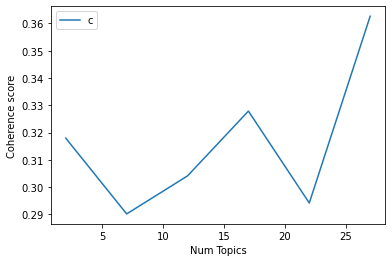

In [70]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [71]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score2):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.3179
index: 1 | Num Topics = 7  has Coherence Value of 0.2902
index: 2 | Num Topics = 12  has Coherence Value of 0.3041
index: 3 | Num Topics = 17  has Coherence Value of 0.3279
index: 4 | Num Topics = 22  has Coherence Value of 0.2942
index: 5 | Num Topics = 27  has Coherence Value of 0.3626


In [185]:
# Select optimal number of topics
optimal_model_us_score2 = model_list_us_score2[5]

In [186]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score2 = pyLDAvis.gensim_models.prepare(optimal_model_us_score2, corpus_us_score2, id2word_us_score2)

In [187]:
print("pyLDAVis for us topics for score=2:")
vis_us_score2

pyLDAVis for us topics for score=2:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.107233 -0.177184       1        1  11.221716
17     0.105885  0.050082       2        1   8.209607
22     0.138771  0.034503       3        1   8.153189
15     0.069769 -0.176498       4        1   6.954483
16     0.140615  0.081193       5        1   6.543034
11     0.079383  0.059375       6        1   5.699238
18     0.083945  0.000906       7        1   5.528760
9     -0.000389 -0.174043       8        1   5.096301
14     0.067478 -0.025139       9        1   4.945001
6      0.118526  0.062923      10        1   4.811032
24     0.071108  0.087037      11        1   4.673898
19     0.021025  0.060307      12        1   3.532911
20     0.063919 -0.051004      13        1   3.522801
21     0.064819  0.076296      14        1   3.463739
23     0.052093 -0.007496      15        1   3.018865
12    -0.009029  0.058424      16        1   2.143059
2      0.006718  0.057033      17        1   1.949348
8     -0.140667  0.066942      18        1   1.502812
3     -0.029724 -0.031612      19        1   1.445969
7     -0.085404  0.002487      20        1   1.346611
25    -0.064786  0.028342      21        1   1.167236
4     -0.178087  0.012470      22        1   1.156777
5     -0.105123 -0.045112      23        1   1.147336
13    -0.104168 -0.148898      24        1   1.128937
0     -0.130775 -0.001511      25        1   0.733783
10    -0.158360  0.052471      26        1   0.500060
26    -0.184775  0.047706      27        1   0.403496, topic_info=          Term        Freq       Total Category  logprob  loglift
23        song  113.000000  113.000000  Default   30.000  30.0000
94       error   27.000000   27.000000  Default   29.000  29.0000
35       video  153.000000  153.000000  Default   28.000  28.0000
331      crash   27.000000   27.000000  Default   27.000  27.0000
4          fix   59.000000   59.000000  Default   26.000  26.0000
..         ...         ...         ...      ...      ...      ...
19    purchase    0.016378    4.574521  Topic27   -6.702  -0.1196
20   recognize    0.016378    1.595052  Topic27   -6.702   0.9340
21     refresh    0.016378    2.478801  Topic27   -6.702   0.4932
22      remove    0.016378    4.043824  Topic27   -6.702   0.0037
23        song    0.016378  113.972089  Topic27   -6.702  -3.3350

[1352 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
234       1  0.391217   able
234       2  0.195608   able
234       7  0.097804   able
234      10  0.097804   able
234      11  0.097804   able
...     ...       ...    ...
10       10  0.132723  wrong
10       15  0.132723  wrong
10       20  0.132723  wrong
488       7  0.613545    yea
529      19  0.677036     yk

[1645 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 18, 23, 16, 17, 12, 19, 10, 15, 7, 25, 20, 21, 22, 24, 13, 3, 9, 4, 8, 26, 5, 6, 14, 1, 11, 27])

## LDA Topic Modelling (Rating = 3)

In [75]:
# By-rating Topic Modelling - rating = 3
# Convert to list - move to each section
review_us_score3 = lomotif_ios_us_review_YearMonth_score3.review.values.tolist()
review_words_us_score3 = list(sent_to_words(review_us_score3))
print(review_words_us_score3[:1])

[['lomotif', 'use', 'to', 'be', 'great', 'app', 'that', 'used', 'all', 'the', 'time', 'but', 'ever', 'since', 'the', 'update', 'its', 'weird', 'and', 'doesn', 'work', 'right', 'would', 'love', 'if', 'you', 'guys', 'changed', 'it', 'back', 'how', 'it', 'used', 'to', 'be', 'please', 'and', 'thank', 'you']]


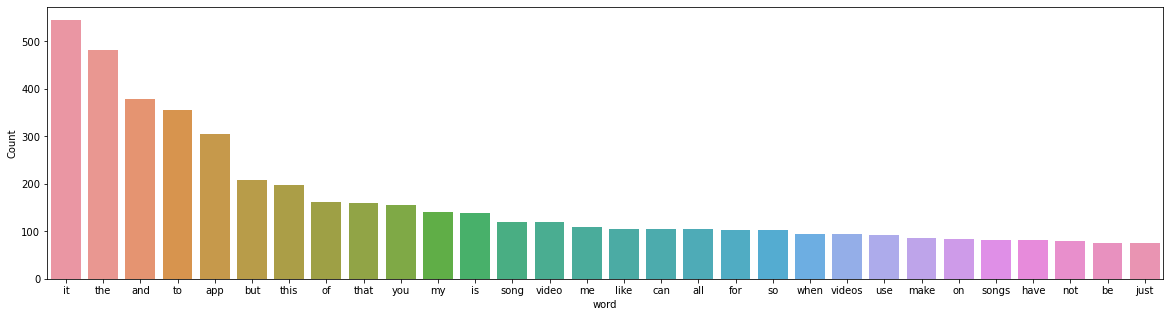

In [76]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score3))

In [77]:
# Clean text
review_us_ready_score3 = process_words(review_words_us_score3)  # processed Text Data! - move to each section


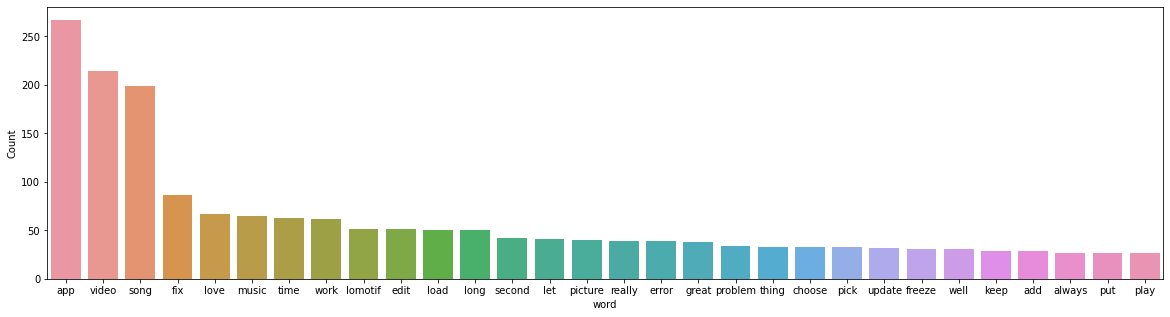

In [78]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score3))


In [79]:
# Create Dictionary
id2word_us_score3 = corpora.Dictionary(review_us_ready_score3)

2021-10-17 02:28:35,482 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 02:28:35,495 [INFO] gensim.corpora.dictionary - built Dictionary(673 unique tokens: ['app', 'back', 'change', 'ever', 'great']...) from 313 documents (total 3870 corpus positions)
2021-10-17 02:28:35,496 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(673 unique tokens: ['app', 'back', 'change', 'ever', 'great']...) from 313 documents (total 3870 corpus positions)", 'datetime': '2021-10-17T02:28:35.496231', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [80]:
# Create Corpus: Term Document Frequency
corpus_us_score3 = [id2word_us_score3.doc2bow(text) for text in review_us_ready_score3]

In [81]:
# Training LDA model
model_list_us_score3, coherence_values_us_score3 = compute_coherence_values(dictionary=id2word_us_score3, corpus=corpus_us_score3, 
                                                              texts=review_us_ready_score3, limit=30, start=2, step=5)


2021-10-17 02:28:35,522 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 02:28:35,524 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 02:28:35,526 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 02:28:35,529 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 313 documents, updating model once every 313 documents, evaluating perplexity every 313 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 02:28:36,574 [INFO] gensim.models.ldamodel - -7.078 per-word bound, 135.1 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:28:36,576 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #313/313
2021-10-17 02:28:37,480 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.048*"video" + 0.029*"app" + 0.018*"song" + 0.015*"love" + 0.015*"picture" + 0.014*"fix" + 0.014*"long"

2021-10-17 02:28:48,087 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.066*"app" + 0.059*"song" + 0.046*"video" + 0.023*"fix" + 0.017*"work" + 0.017*"time" + 0.016*"love" + 0.015*"music" + 0.014*"load" + 0.014*"edit"
2021-10-17 02:28:48,089 [INFO] gensim.models.ldamodel - topic diff=0.018122, rho=0.301511
2021-10-17 02:28:48,596 [INFO] gensim.models.ldamodel - -5.652 per-word bound, 50.3 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:28:48,597 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #313/313
2021-10-17 02:28:49,006 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.053*"video" + 0.039*"app" + 0.026*"long" + 0.024*"second" + 0.023*"picture" + 0.015*"really" + 0.014*"wish" + 0.013*"people" + 0.013*"music" + 0.011*"keep"
2021-10-17 02:28:49,008 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.066*"app" + 0.059*"song" + 0.045*"video" + 0.023*"fix" + 0.018*"work" + 0.017*"time" + 0.016*"love" + 0.015*"music" + 0.

2021-10-17 02:28:56,081 [INFO] gensim.models.ldamodel - topic diff=0.009205, rho=0.218218
2021-10-17 02:28:56,501 [INFO] gensim.models.ldamodel - -5.642 per-word bound, 49.9 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:28:56,502 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #313/313
2021-10-17 02:28:56,838 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.059*"video" + 0.043*"app" + 0.030*"long" + 0.029*"second" + 0.023*"picture" + 0.014*"wish" + 0.014*"music" + 0.014*"really" + 0.014*"people" + 0.013*"love"
2021-10-17 02:28:56,840 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.065*"app" + 0.060*"song" + 0.043*"video" + 0.024*"fix" + 0.018*"work" + 0.017*"time" + 0.016*"love" + 0.015*"load" + 0.015*"music" + 0.014*"edit"
2021-10-17 02:28:56,840 [INFO] gensim.models.ldamodel - topic diff=0.008904, rho=0.213201
2021-10-17 02:28:57,231 [INFO] gensim.models.ldamodel - -5.642 per-word bound, 49.9 perplexity estimate ba

2021-10-17 02:29:04,688 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #313/313
2021-10-17 02:29:04,988 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.063*"video" + 0.043*"app" + 0.032*"long" + 0.031*"second" + 0.022*"picture" + 0.015*"music" + 0.014*"people" + 0.014*"wish" + 0.013*"really" + 0.013*"love"
2021-10-17 02:29:04,990 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.065*"app" + 0.061*"song" + 0.041*"video" + 0.025*"fix" + 0.019*"work" + 0.017*"time" + 0.016*"love" + 0.015*"load" + 0.014*"music" + 0.014*"edit"
2021-10-17 02:29:04,991 [INFO] gensim.models.ldamodel - topic diff=0.007310, rho=0.176777
2021-10-17 02:29:05,365 [INFO] gensim.models.ldamodel - -5.636 per-word bound, 49.7 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:29:05,366 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #313/313
2021-10-17 02:29:05,870 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.063*"video" + 0.043*"app

2021-10-17 02:29:14,143 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.066*"app" + 0.062*"song" + 0.040*"video" + 0.026*"fix" + 0.019*"work" + 0.017*"time" + 0.016*"love" + 0.016*"load" + 0.014*"music" + 0.014*"edit"
2021-10-17 02:29:14,154 [INFO] gensim.models.ldamodel - topic diff=0.006944, rho=0.154303
2021-10-17 02:29:14,738 [INFO] gensim.models.ldamodel - -5.631 per-word bound, 49.6 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:29:14,760 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #313/313
2021-10-17 02:29:15,183 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.065*"video" + 0.043*"app" + 0.032*"long" + 0.031*"second" + 0.021*"picture" + 0.015*"music" + 0.014*"people" + 0.013*"wish" + 0.013*"love" + 0.013*"really"
2021-10-17 02:29:15,185 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.066*"app" + 0.062*"song" + 0.040*"video" + 0.026*"fix" + 0.019*"work" + 0.017*"time" + 0.016*"love" + 0.016*"load" + 0.0

2021-10-17 02:29:26,644 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 304 virtual documents
2021-10-17 02:29:26,951 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 02:29:26,953 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 02:29:26,962 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 02:29:26,966 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 313 documents, updating model once every 313 documents, evaluating perplexity every 313 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 02:29:27,854 [INFO] gensim.models.ldamodel - -8.364 per-word bound, 329.6 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:29:27,855 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #313/313
2021-10-17 02:29

2021-10-17 02:29:32,591 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #313/313
2021-10-17 02:29:32,856 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.035*"lomotif" + 0.034*"app" + 0.028*"update" + 0.027*"video" + 0.021*"edit" + 0.019*"load" + 0.018*"second" + 0.014*"really" + 0.014*"new" + 0.012*"still"
2021-10-17 02:29:32,858 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.032*"video" + 0.025*"app" + 0.024*"crash" + 0.022*"fix" + 0.016*"add" + 0.015*"well" + 0.012*"long" + 0.011*"great" + 0.011*"delete" + 0.011*"lomotif"
2021-10-17 02:29:32,860 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.074*"song" + 0.056*"video" + 0.055*"app" + 0.026*"load" + 0.025*"fix" + 0.020*"lomotif" + 0.018*"let" + 0.016*"much" + 0.015*"problem" + 0.014*"love"
2021-10-17 02:29:32,862 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.086*"song" + 0.066*"app" + 0.025*"error" + 0.023*"fix" + 0.023*"music" + 0.019*"video" + 0.015*"load" + 0.015*"love" + 0.015*"always" + 0.015*"ch

2021-10-17 02:29:37,079 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.090*"song" + 0.063*"app" + 0.025*"error" + 0.025*"music" + 0.023*"fix" + 0.019*"video" + 0.018*"work" + 0.016*"load" + 0.016*"always" + 0.015*"love"
2021-10-17 02:29:37,080 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.026*"crash" + 0.026*"video" + 0.024*"fix" + 0.023*"app" + 0.016*"add" + 0.016*"well" + 0.013*"long" + 0.012*"delete" + 0.011*"give" + 0.010*"really"
2021-10-17 02:29:37,081 [INFO] gensim.models.ldamodel - topic diff=0.024443, rho=0.288675
2021-10-17 02:29:37,499 [INFO] gensim.models.ldamodel - -5.897 per-word bound, 59.6 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:29:37,501 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #313/313
2021-10-17 02:29:37,841 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.039*"video" + 0.033*"app" + 0.028*"long" + 0.025*"second" + 0.015*"love" + 0.013*"annoying" + 0.013*"bad" + 0.013*"keep" + 0

2021-10-17 02:29:41,840 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.094*"song" + 0.061*"app" + 0.025*"music" + 0.025*"error" + 0.023*"fix" + 0.020*"work" + 0.018*"video" + 0.018*"load" + 0.016*"always" + 0.015*"love"
2021-10-17 02:29:41,842 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.039*"everytime" + 0.026*"half" + 0.021*"photo" + 0.020*"update" + 0.016*"back" + 0.016*"work" + 0.014*"cut" + 0.011*"basically" + 0.010*"glitch" + 0.008*"look"
2021-10-17 02:29:41,843 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.024*"fix" + 0.023*"video" + 0.023*"crash" + 0.023*"app" + 0.016*"add" + 0.016*"well" + 0.013*"long" + 0.012*"delete" + 0.012*"give" + 0.010*"really"
2021-10-17 02:29:41,846 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.039*"video" + 0.033*"app" + 0.028*"long" + 0.025*"second" + 0.015*"love" + 0.013*"annoying" + 0.013*"keep" + 0.013*"bad" + 0.013*"time" + 0.013*"back"
2021-10-17 02:29:41,848 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.076*"song" 

2021-10-17 02:29:45,823 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.025*"fix" + 0.023*"video" + 0.022*"app" + 0.018*"crash" + 0.016*"add" + 0.016*"well" + 0.014*"long" + 0.012*"delete" + 0.012*"give" + 0.011*"really"
2021-10-17 02:29:45,825 [INFO] gensim.models.ldamodel - topic diff=0.006098, rho=0.208514
2021-10-17 02:29:46,248 [INFO] gensim.models.ldamodel - -5.881 per-word bound, 58.9 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:29:46,253 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #313/313
2021-10-17 02:29:46,548 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.037*"video" + 0.033*"app" + 0.027*"long" + 0.025*"second" + 0.015*"love" + 0.013*"annoying" + 0.013*"keep" + 0.013*"time" + 0.013*"bad" + 0.011*"save"
2021-10-17 02:29:46,554 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.041*"everytime" + 0.026*"half" + 0.021*"photo" + 0.021*"update" + 0.016*"back" + 0.016*"work" + 0.014*"cut" + 0.012*"basic

2021-10-17 02:29:50,739 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.036*"video" + 0.034*"app" + 0.025*"long" + 0.024*"second" + 0.015*"love" + 0.013*"annoying" + 0.013*"keep" + 0.013*"time" + 0.013*"bad" + 0.011*"save"
2021-10-17 02:29:50,742 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.076*"song" + 0.059*"app" + 0.055*"video" + 0.027*"fix" + 0.026*"load" + 0.021*"lomotif" + 0.019*"let" + 0.018*"problem" + 0.014*"love" + 0.014*"much"
2021-10-17 02:29:50,744 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.025*"fix" + 0.022*"app" + 0.022*"video" + 0.017*"well" + 0.015*"add" + 0.015*"crash" + 0.014*"long" + 0.013*"delete" + 0.012*"give" + 0.011*"really"
2021-10-17 02:29:50,746 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.041*"everytime" + 0.026*"half" + 0.021*"photo" + 0.021*"update" + 0.016*"back" + 0.015*"work" + 0.014*"cut" + 0.012*"basically" + 0.011*"glitch" + 0.008*"look"
2021-10-17 02:29:50,748 [INFO] gensim.models.ldamodel - topic diff=0.003557, rho=0.185

2021-10-17 02:29:54,881 [INFO] gensim.models.ldamodel - topic diff=0.002381, rho=0.171499
2021-10-17 02:29:55,370 [INFO] gensim.models.ldamodel - -5.877 per-word bound, 58.8 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:29:55,379 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #313/313
2021-10-17 02:29:55,738 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.097*"song" + 0.060*"app" + 0.026*"music" + 0.025*"error" + 0.023*"fix" + 0.022*"work" + 0.019*"load" + 0.018*"video" + 0.016*"always" + 0.015*"love"
2021-10-17 02:29:55,740 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.025*"fix" + 0.023*"app" + 0.022*"video" + 0.017*"well" + 0.014*"long" + 0.013*"add" + 0.013*"crash" + 0.013*"delete" + 0.012*"give" + 0.011*"really"
2021-10-17 02:29:55,743 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.041*"everytime" + 0.026*"half" + 0.021*"photo" + 0.021*"update" + 0.016*"back" + 0.015*"work" + 0.014*"cut" + 0.012*"basical

2021-10-17 02:30:00,077 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.088*"video" + 0.080*"app" + 0.025*"time" + 0.024*"long" + 0.021*"edit" + 0.021*"second" + 0.020*"work" + 0.020*"love" + 0.019*"picture" + 0.018*"music"
2021-10-17 02:30:00,079 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.037*"update" + 0.036*"lomotif" + 0.036*"app" + 0.025*"edit" + 0.023*"video" + 0.019*"new" + 0.018*"year" + 0.018*"really" + 0.015*"load" + 0.013*"glitch"
2021-10-17 02:30:00,081 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.097*"song" + 0.060*"app" + 0.026*"music" + 0.025*"error" + 0.023*"fix" + 0.022*"work" + 0.019*"load" + 0.018*"video" + 0.016*"always" + 0.015*"love"
2021-10-17 02:30:00,083 [INFO] gensim.models.ldamodel - topic diff=0.001477, rho=0.158114
2021-10-17 02:30:00,534 [INFO] gensim.models.ldamodel - -5.876 per-word bound, 58.7 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:30:00,536 [INFO] gensim.models.ldamodel - PROGRES

2021-10-17 02:30:04,735 [INFO] gensim.models.ldamodel - -5.876 per-word bound, 58.7 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:30:04,736 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #313/313
2021-10-17 02:30:05,097 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.034*"app" + 0.034*"video" + 0.020*"second" + 0.019*"long" + 0.014*"love" + 0.013*"keep" + 0.013*"annoying" + 0.013*"time" + 0.013*"bad" + 0.012*"save"
2021-10-17 02:30:05,099 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.088*"video" + 0.080*"app" + 0.025*"time" + 0.025*"long" + 0.021*"edit" + 0.021*"second" + 0.020*"love" + 0.020*"work" + 0.019*"picture" + 0.018*"music"
2021-10-17 02:30:05,101 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.097*"song" + 0.060*"app" + 0.026*"music" + 0.025*"error" + 0.023*"fix" + 0.022*"work" + 0.019*"load" + 0.018*"video" + 0.016*"always" + 0.015*"love"
2021-10-17 02:30:05,104 [INFO] gensim.models.ldamodel - topi

2021-10-17 02:30:09,550 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.097*"song" + 0.060*"app" + 0.026*"music" + 0.025*"error" + 0.023*"fix" + 0.022*"work" + 0.019*"load" + 0.018*"video" + 0.016*"always" + 0.015*"love"
2021-10-17 02:30:09,552 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.077*"song" + 0.060*"app" + 0.055*"video" + 0.028*"fix" + 0.026*"load" + 0.022*"lomotif" + 0.019*"let" + 0.018*"problem" + 0.014*"love" + 0.014*"much"
2021-10-17 02:30:09,553 [INFO] gensim.models.ldamodel - topic diff=0.000871, rho=0.140028
2021-10-17 02:30:09,555 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=673, num_topics=7, decay=0.5, chunksize=1000) in 42.59s', 'datetime': '2021-10-17T02:30:09.554972', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-17 02:30:09,560 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordO

2021-10-17 02:30:19,419 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.077*"app" + 0.050*"video" + 0.038*"edit" + 0.036*"freeze" + 0.033*"keep" + 0.025*"fix" + 0.023*"time" + 0.018*"much" + 0.017*"love" + 0.016*"start"
2021-10-17 02:30:19,423 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.039*"second" + 0.037*"video" + 0.034*"app" + 0.031*"lomotif" + 0.029*"wish" + 0.024*"picture" + 0.023*"photo" + 0.022*"really" + 0.019*"edit" + 0.019*"well"
2021-10-17 02:30:19,427 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.121*"song" + 0.049*"video" + 0.049*"app" + 0.030*"load" + 0.029*"let" + 0.020*"fix" + 0.018*"certain" + 0.017*"pick" + 0.015*"select" + 0.014*"available"
2021-10-17 02:30:19,431 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.042*"load" + 0.037*"app" + 0.028*"song" + 0.027*"video" + 0.027*"music" + 0.022*"lomotif" + 0.020*"love" + 0.019*"thing" + 0.016*"fix" + 0.014*"preview"
2021-10-17 02:30:19,435 [INFO] gensim.models.ldamodel - topic diff=0.083177, rho=0.

2021-10-17 02:30:23,361 [INFO] gensim.models.ldamodel - topic diff=0.029036, rho=0.301511
2021-10-17 02:30:23,876 [INFO] gensim.models.ldamodel - -6.053 per-word bound, 66.4 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:30:23,877 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #313/313
2021-10-17 02:30:24,183 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.132*"song" + 0.047*"video" + 0.045*"app" + 0.035*"let" + 0.034*"load" + 0.020*"certain" + 0.020*"fix" + 0.019*"select" + 0.018*"pick" + 0.017*"available"
2021-10-17 02:30:24,186 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.055*"video" + 0.035*"app" + 0.034*"crash" + 0.027*"help" + 0.023*"way" + 0.017*"edit" + 0.017*"slow" + 0.012*"time" + 0.012*"add" + 0.011*"give"
2021-10-17 02:30:24,195 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.064*"app" + 0.057*"song" + 0.055*"video" + 0.030*"fix" + 0.029*"choose" + 0.025*"problem" + 0.025*"long" + 0.024*"delete" 

2021-10-17 02:30:28,125 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.072*"app" + 0.067*"video" + 0.039*"song" + 0.031*"time" + 0.027*"work" + 0.024*"second" + 0.020*"fix" + 0.019*"love" + 0.018*"picture" + 0.014*"first"
2021-10-17 02:30:28,127 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.076*"app" + 0.059*"video" + 0.038*"lomotif" + 0.020*"start" + 0.016*"people" + 0.016*"save" + 0.016*"edit" + 0.014*"really" + 0.013*"fix" + 0.013*"first"
2021-10-17 02:30:28,132 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.060*"video" + 0.051*"music" + 0.048*"app" + 0.031*"second" + 0.030*"long" + 0.025*"love" + 0.022*"great" + 0.017*"wish" + 0.016*"add" + 0.016*"put"
2021-10-17 02:30:28,134 [INFO] gensim.models.ldamodel - topic diff=0.016148, rho=0.242536
2021-10-17 02:30:28,612 [INFO] gensim.models.ldamodel - -6.030 per-word bound, 65.4 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:30:28,614 [INFO] gensim.models.ldamodel - PROGRESS:

2021-10-17 02:30:32,497 [INFO] gensim.models.ldamodel - -6.019 per-word bound, 64.9 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:30:32,498 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #313/313
2021-10-17 02:30:32,785 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.095*"song" + 0.073*"app" + 0.037*"error" + 0.031*"video" + 0.028*"fix" + 0.023*"music" + 0.023*"play" + 0.018*"search" + 0.017*"let" + 0.017*"work"
2021-10-17 02:30:32,787 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.037*"app" + 0.030*"lomotif" + 0.029*"edit" + 0.027*"photo" + 0.023*"really" + 0.023*"well" + 0.022*"picture" + 0.021*"fix" + 0.018*"song" + 0.017*"freeze"
2021-10-17 02:30:32,788 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.064*"app" + 0.059*"song" + 0.052*"video" + 0.033*"fix" + 0.029*"problem" + 0.029*"choose" + 0.025*"delete" + 0.025*"never" + 0.025*"love" + 0.023*"work"
2021-10-17 02:30:32,789 [INFO] gensim.models.ldamodel -

2021-10-17 02:30:36,884 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.069*"video" + 0.049*"music" + 0.047*"app" + 0.035*"second" + 0.032*"long" + 0.026*"love" + 0.021*"great" + 0.019*"picture" + 0.019*"put" + 0.018*"wish"
2021-10-17 02:30:36,886 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.076*"app" + 0.066*"video" + 0.035*"song" + 0.028*"time" + 0.026*"work" + 0.024*"second" + 0.019*"love" + 0.019*"fix" + 0.017*"picture" + 0.014*"first"
2021-10-17 02:30:36,887 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.037*"app" + 0.031*"lomotif" + 0.030*"edit" + 0.027*"photo" + 0.023*"really" + 0.023*"well" + 0.022*"fix" + 0.020*"multiple" + 0.018*"song" + 0.018*"freeze"
2021-10-17 02:30:36,888 [INFO] gensim.models.ldamodel - topic diff=0.007545, rho=0.188982
2021-10-17 02:30:37,235 [INFO] gensim.models.ldamodel - -6.010 per-word bound, 64.4 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:30:37,237 [INFO] gensim.models.ldamodel - PRO

2021-10-17 02:30:40,421 [INFO] gensim.models.ldamodel - topic diff=0.006254, rho=0.174078
2021-10-17 02:30:40,860 [INFO] gensim.models.ldamodel - -6.003 per-word bound, 64.2 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:30:40,861 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #313/313
2021-10-17 02:30:41,189 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.030*"feature" + 0.030*"year" + 0.020*"app" + 0.020*"stuff" + 0.020*"kid" + 0.020*"inappropriate" + 0.020*"young" + 0.020*"sister" + 0.011*"long" + 0.011*"overall"
2021-10-17 02:30:41,195 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.047*"video" + 0.037*"crash" + 0.035*"app" + 0.030*"way" + 0.024*"slow" + 0.018*"help" + 0.017*"edit" + 0.015*"give" + 0.014*"put" + 0.014*"time"
2021-10-17 02:30:41,197 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.050*"song" + 0.025*"part" + 0.025*"unavailable" + 0.025*"already" + 0.013*"let" + 0.013*"possible" + 0.013*"great"

2021-10-17 02:30:44,802 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.077*"app" + 0.067*"video" + 0.031*"song" + 0.029*"time" + 0.025*"work" + 0.024*"second" + 0.021*"love" + 0.019*"fix" + 0.017*"picture" + 0.014*"first"
2021-10-17 02:30:44,805 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.144*"song" + 0.046*"video" + 0.041*"load" + 0.038*"app" + 0.036*"let" + 0.025*"certain" + 0.021*"pick" + 0.021*"lomotif" + 0.021*"preview" + 0.020*"select"
2021-10-17 02:30:44,807 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.045*"video" + 0.037*"crash" + 0.034*"app" + 0.030*"way" + 0.024*"slow" + 0.019*"help" + 0.017*"edit" + 0.015*"give" + 0.015*"put" + 0.014*"time"
2021-10-17 02:30:44,809 [INFO] gensim.models.ldamodel - topic diff=0.004541, rho=0.160128
2021-10-17 02:30:45,267 [INFO] gensim.models.ldamodel - -5.999 per-word bound, 64.0 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:30:45,269 [INFO] gensim.models.ldamodel - PROGRESS: 

2021-10-17 02:30:48,936 [INFO] gensim.models.ldamodel - -5.996 per-word bound, 63.8 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:30:48,938 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #313/313
2021-10-17 02:30:49,241 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.036*"app" + 0.032*"load" + 0.025*"thing" + 0.021*"music" + 0.019*"lomotif" + 0.018*"love" + 0.017*"video" + 0.016*"ask" + 0.016*"amazing" + 0.016*"part"
2021-10-17 02:30:49,243 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.078*"app" + 0.060*"video" + 0.036*"lomotif" + 0.019*"start" + 0.019*"people" + 0.017*"edit" + 0.015*"save" + 0.015*"first" + 0.015*"time" + 0.014*"really"
2021-10-17 02:30:49,244 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.098*"song" + 0.070*"app" + 0.043*"error" + 0.029*"fix" + 0.028*"video" + 0.025*"music" + 0.022*"play" + 0.018*"search" + 0.018*"let" + 0.018*"pick"
2021-10-17 02:30:49,247 [INFO] gensim.models.ldamodel - 

2021-10-17 02:30:52,913 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.036*"app" + 0.031*"load" + 0.025*"thing" + 0.021*"music" + 0.019*"lomotif" + 0.018*"love" + 0.017*"video" + 0.017*"amazing" + 0.017*"ask" + 0.015*"part"
2021-10-17 02:30:52,915 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.066*"app" + 0.059*"song" + 0.050*"video" + 0.033*"fix" + 0.031*"problem" + 0.028*"choose" + 0.027*"work" + 0.024*"delete" + 0.024*"never" + 0.023*"love"
2021-10-17 02:30:52,918 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.098*"song" + 0.070*"app" + 0.043*"error" + 0.029*"fix" + 0.028*"video" + 0.025*"music" + 0.022*"play" + 0.018*"search" + 0.018*"let" + 0.018*"pick"
2021-10-17 02:30:52,920 [INFO] gensim.models.ldamodel - topic diff=0.002727, rho=0.141421
2021-10-17 02:30:53,360 [INFO] gensim.models.ldamodel - -5.994 per-word bound, 63.7 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:30:53,362 [INFO] gensim.models.ldamodel - PROGRES

2021-10-17 02:31:03,265 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #313/313
2021-10-17 02:31:03,623 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.077*"app" + 0.044*"video" + 0.027*"song" + 0.024*"fix" + 0.023*"well" + 0.019*"amazing" + 0.018*"load" + 0.015*"problem" + 0.014*"recommend" + 0.014*"show"
2021-10-17 02:31:03,628 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.064*"song" + 0.044*"app" + 0.041*"search" + 0.030*"video" + 0.027*"click" + 0.026*"load" + 0.024*"pop" + 0.023*"delete" + 0.021*"glitch" + 0.018*"always"
2021-10-17 02:31:03,631 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.087*"song" + 0.064*"video" + 0.042*"app" + 0.023*"problem" + 0.021*"pick" + 0.018*"let" + 0.018*"load" + 0.017*"fix" + 0.016*"lomotif" + 0.015*"time"
2021-10-17 02:31:03,640 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.057*"load" + 0.043*"app" + 0.039*"video" + 0.036*"lomotif" + 0.031*"love" + 0.028*"fix" + 0.021*"picture" + 0.021*"help" + 0.020*"thing" + 0

2021-10-17 02:31:07,378 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.081*"song" + 0.065*"video" + 0.043*"app" + 0.024*"problem" + 0.022*"pick" + 0.016*"fix" + 0.016*"time" + 0.016*"let" + 0.015*"love" + 0.015*"picture"
2021-10-17 02:31:07,381 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.064*"song" + 0.059*"app" + 0.048*"choose" + 0.032*"fix" + 0.030*"love" + 0.030*"work" + 0.030*"guy" + 0.027*"time" + 0.022*"long" + 0.018*"load"
2021-10-17 02:31:07,384 [INFO] gensim.models.ldamodel - topic diff=0.047976, rho=0.316228
2021-10-17 02:31:07,864 [INFO] gensim.models.ldamodel - -6.182 per-word bound, 72.6 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:31:07,865 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #313/313
2021-10-17 02:31:08,179 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.052*"video" + 0.052*"app" + 0.039*"pick" + 0.025*"bad" + 0.025*"time" + 0.025*"change" + 0.017*"save" + 0.017*"dead" + 0.017*"a

2021-10-17 02:31:11,850 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.056*"song" + 0.042*"app" + 0.037*"search" + 0.035*"click" + 0.031*"delete" + 0.030*"video" + 0.027*"pop" + 0.027*"glitch" + 0.018*"update" + 0.018*"working"
2021-10-17 02:31:11,852 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.183*"song" + 0.054*"load" + 0.040*"let" + 0.037*"preview" + 0.030*"app" + 0.030*"work" + 0.028*"error" + 0.025*"select" + 0.024*"lomotif" + 0.023*"fix"
2021-10-17 02:31:11,854 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.075*"song" + 0.066*"video" + 0.042*"app" + 0.024*"pick" + 0.023*"problem" + 0.016*"fix" + 0.016*"time" + 0.015*"love" + 0.015*"picture" + 0.014*"play"
2021-10-17 02:31:11,855 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.064*"music" + 0.057*"app" + 0.042*"great" + 0.038*"video" + 0.028*"love" + 0.024*"second" + 0.022*"edit" + 0.021*"put" + 0.021*"long" + 0.018*"picture"
2021-10-17 02:31:11,856 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.052*"vi

2021-10-17 02:31:15,387 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.054*"song" + 0.041*"app" + 0.036*"click" + 0.034*"search" + 0.032*"delete" + 0.031*"video" + 0.027*"pop" + 0.027*"glitch" + 0.018*"update" + 0.018*"working"
2021-10-17 02:31:15,389 [INFO] gensim.models.ldamodel - topic diff=0.012523, rho=0.218218
2021-10-17 02:31:15,867 [INFO] gensim.models.ldamodel - -6.137 per-word bound, 70.4 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:31:15,868 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #313/313
2021-10-17 02:31:16,148 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.063*"music" + 0.057*"app" + 0.043*"great" + 0.037*"video" + 0.027*"love" + 0.025*"second" + 0.022*"edit" + 0.021*"put" + 0.020*"long" + 0.017*"picture"
2021-10-17 02:31:16,150 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.123*"video" + 0.051*"app" + 0.050*"long" + 0.029*"back" + 0.026*"second" + 0.021*"fast" + 0.018*"lomotif" + 0.01

2021-10-17 02:31:19,940 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.054*"song" + 0.040*"app" + 0.036*"click" + 0.033*"delete" + 0.032*"search" + 0.031*"video" + 0.027*"pop" + 0.027*"glitch" + 0.018*"update" + 0.018*"working"
2021-10-17 02:31:19,943 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.077*"wish" + 0.048*"second" + 0.043*"long" + 0.022*"video" + 0.017*"really" + 0.017*"love" + 0.017*"instead" + 0.017*"min" + 0.017*"max" + 0.017*"guy"
2021-10-17 02:31:19,945 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.083*"app" + 0.041*"video" + 0.026*"fix" + 0.025*"well" + 0.023*"amazing" + 0.020*"recommend" + 0.017*"show" + 0.017*"appreciate" + 0.015*"problem" + 0.015*"download"
2021-10-17 02:31:19,947 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.088*"app" + 0.066*"edit" + 0.063*"video" + 0.054*"freeze" + 0.048*"keep" + 0.041*"crash" + 0.030*"start" + 0.029*"time" + 0.027*"fix" + 0.023*"work"
2021-10-17 02:31:19,948 [INFO] gensim.models.ldamodel - topic diff=0.00

2021-10-17 02:31:23,735 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.122*"video" + 0.051*"long" + 0.050*"app" + 0.029*"back" + 0.026*"second" + 0.022*"fast" + 0.018*"lomotif" + 0.018*"time" + 0.017*"picture" + 0.017*"love"
2021-10-17 02:31:23,737 [INFO] gensim.models.ldamodel - topic diff=0.004922, rho=0.176777
2021-10-17 02:31:24,048 [INFO] gensim.models.ldamodel - -6.123 per-word bound, 69.7 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:31:24,049 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #313/313
2021-10-17 02:31:24,377 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.148*"effect" + 0.105*"add" + 0.029*"well" + 0.025*"lomotif" + 0.001*"message" + 0.001*"choose" + 0.001*"pop" + 0.001*"song" + 0.001*"artist" + 0.001*"click"
2021-10-17 02:31:24,378 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.078*"wish" + 0.048*"second" + 0.044*"long" + 0.022*"video" + 0.017*"really" + 0.017*"love" + 0.017*"instead" +

2021-10-17 02:31:27,886 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.197*"song" + 0.054*"load" + 0.038*"let" + 0.036*"preview" + 0.035*"error" + 0.033*"app" + 0.029*"work" + 0.024*"lomotif" + 0.024*"fix" + 0.021*"select"
2021-10-17 02:31:27,888 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.059*"app" + 0.045*"choose" + 0.036*"love" + 0.036*"guy" + 0.032*"time" + 0.030*"work" + 0.030*"fix" + 0.026*"long" + 0.023*"never" + 0.021*"song"
2021-10-17 02:31:27,891 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.054*"song" + 0.040*"app" + 0.036*"click" + 0.033*"delete" + 0.031*"video" + 0.031*"search" + 0.027*"pop" + 0.027*"glitch" + 0.018*"update" + 0.018*"working"
2021-10-17 02:31:27,893 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.080*"app" + 0.071*"song" + 0.031*"video" + 0.028*"fix" + 0.025*"play" + 0.024*"great" + 0.023*"error" + 0.021*"update" + 0.020*"really" + 0.016*"problem"
2021-10-17 02:31:27,895 [INFO] gensim.models.ldamodel - topic diff=0.003088, rho=0.16

2021-10-17 02:31:31,531 [INFO] gensim.models.ldamodel - topic diff=0.002305, rho=0.152499
2021-10-17 02:31:31,978 [INFO] gensim.models.ldamodel - -6.118 per-word bound, 69.4 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:31:31,981 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #313/313
2021-10-17 02:31:32,271 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.061*"music" + 0.056*"app" + 0.043*"great" + 0.037*"video" + 0.027*"love" + 0.025*"second" + 0.023*"edit" + 0.021*"put" + 0.019*"long" + 0.017*"picture"
2021-10-17 02:31:32,275 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.060*"app" + 0.044*"choose" + 0.037*"love" + 0.037*"guy" + 0.032*"time" + 0.030*"work" + 0.027*"fix" + 0.026*"long" + 0.020*"never" + 0.019*"video"
2021-10-17 02:31:32,278 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.053*"app" + 0.039*"thing" + 0.034*"fix" + 0.034*"always" + 0.027*"music" + 0.026*"start" + 0.024*"delete" + 0.024*"still"

2021-10-17 02:31:35,987 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.089*"app" + 0.066*"edit" + 0.064*"video" + 0.054*"freeze" + 0.047*"keep" + 0.042*"crash" + 0.030*"start" + 0.029*"time" + 0.027*"fix" + 0.025*"work"
2021-10-17 02:31:35,988 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.157*"effect" + 0.104*"add" + 0.029*"well" + 0.024*"lomotif" + 0.001*"message" + 0.001*"choose" + 0.001*"pop" + 0.001*"song" + 0.001*"artist" + 0.001*"click"
2021-10-17 02:31:35,989 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.059*"load" + 0.044*"app" + 0.041*"video" + 0.035*"lomotif" + 0.033*"love" + 0.027*"fix" + 0.025*"picture" + 0.021*"thing" + 0.020*"save" + 0.018*"way"
2021-10-17 02:31:35,990 [INFO] gensim.models.ldamodel - topic diff=0.001740, rho=0.142857
2021-10-17 02:31:36,336 [INFO] gensim.models.ldamodel - -6.116 per-word bound, 69.3 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:31:36,338 [INFO] gensim.models.ldamodel - PROG

2021-10-17 02:31:48,158 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #313/313
2021-10-17 02:31:48,583 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.106*"video" + 0.074*"app" + 0.039*"love" + 0.029*"long" + 0.026*"picture" + 0.023*"second" + 0.019*"music" + 0.019*"song" + 0.018*"fix" + 0.018*"time"
2021-10-17 02:31:48,586 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.061*"video" + 0.044*"app" + 0.027*"thing" + 0.018*"update" + 0.018*"time" + 0.018*"music" + 0.018*"button" + 0.018*"first" + 0.018*"mute" + 0.018*"always"
2021-10-17 02:31:48,590 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.053*"music" + 0.053*"app" + 0.043*"love" + 0.042*"fix" + 0.037*"song" + 0.024*"work" + 0.023*"much" + 0.021*"put" + 0.021*"video" + 0.019*"great"
2021-10-17 02:31:48,595 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.108*"song" + 0.057*"video" + 0.042*"app" + 0.036*"load" + 0.027*"preview" + 0.025*"fix" + 0.021*"let" + 0.019*"much" + 0.017*"available" + 0.016*"

2021-10-17 02:31:52,263 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.037*"app" + 0.026*"flipgram" + 0.026*"find" + 0.026*"music" + 0.020*"edit" + 0.017*"definitely" + 0.017*"flipagram" + 0.016*"choose" + 0.015*"option" + 0.010*"work"
2021-10-17 02:31:52,264 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.104*"video" + 0.076*"app" + 0.039*"love" + 0.030*"picture" + 0.028*"long" + 0.023*"second" + 0.020*"time" + 0.020*"fix" + 0.017*"work" + 0.017*"music"
2021-10-17 02:31:52,266 [INFO] gensim.models.ldamodel - topic diff=0.053924, rho=0.333333
2021-10-17 02:31:52,634 [INFO] gensim.models.ldamodel - -6.276 per-word bound, 77.5 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:31:52,635 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #313/313
2021-10-17 02:31:52,992 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.136*"song" + 0.051*"load" + 0.045*"app" + 0.044*"choose" + 0.037*"fix" + 0.032*"search" + 0.021*"love" +

2021-10-17 02:31:56,624 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #313/313
2021-10-17 02:31:56,929 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.130*"song" + 0.052*"load" + 0.052*"video" + 0.040*"let" + 0.037*"app" + 0.033*"preview" + 0.027*"fix" + 0.023*"lomotif" + 0.019*"certain" + 0.017*"pick"
2021-10-17 02:31:56,930 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.055*"video" + 0.039*"lomotif" + 0.039*"keep" + 0.039*"log" + 0.030*"app" + 0.020*"allow" + 0.020*"click" + 0.020*"annoying" + 0.020*"speed" + 0.020*"ask"
2021-10-17 02:31:56,933 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.049*"video" + 0.033*"pick" + 0.033*"fix" + 0.033*"watermark" + 0.017*"app" + 0.017*"overall" + 0.017*"picture" + 0.017*"scroll" + 0.017*"change" + 0.017*"bad"
2021-10-17 02:31:56,954 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.048*"wish" + 0.033*"year" + 0.033*"song" + 0.031*"already" + 0.017*"long" + 0.017*"time" + 0.017*"edit" + 0.017*"tiktok" + 0.017*"pict

2021-10-17 02:32:00,391 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.056*"video" + 0.039*"lomotif" + 0.039*"keep" + 0.039*"log" + 0.031*"app" + 0.020*"allow" + 0.020*"click" + 0.020*"annoying" + 0.020*"speed" + 0.020*"ask"
2021-10-17 02:32:00,394 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.100*"video" + 0.075*"app" + 0.040*"love" + 0.031*"picture" + 0.022*"long" + 0.021*"time" + 0.021*"fix" + 0.018*"music" + 0.017*"edit" + 0.016*"work"
2021-10-17 02:32:00,397 [INFO] gensim.models.ldamodel - topic diff=0.014035, rho=0.223607
2021-10-17 02:32:00,778 [INFO] gensim.models.ldamodel - -6.234 per-word bound, 75.3 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:32:00,780 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #313/313
2021-10-17 02:32:01,134 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.132*"song" + 0.057*"load" + 0.051*"video" + 0.040*"let" + 0.037*"preview" + 0.036*"app" + 0.027*"fix" + 0.025*"lomotif

2021-10-17 02:32:04,366 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #313/313
2021-10-17 02:32:04,610 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.049*"wish" + 0.047*"already" + 0.034*"year" + 0.021*"song" + 0.018*"app" + 0.018*"long" + 0.018*"time" + 0.018*"tiktok" + 0.018*"picture" + 0.018*"edit"
2021-10-17 02:32:04,612 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.032*"fix" + 0.025*"time" + 0.024*"lomotif" + 0.024*"love" + 0.024*"stupid" + 0.017*"work" + 0.017*"app" + 0.016*"clip" + 0.016*"long" + 0.016*"freeze"
2021-10-17 02:32:04,619 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.090*"app" + 0.063*"video" + 0.031*"crash" + 0.026*"keep" + 0.024*"fix" + 0.023*"time" + 0.019*"picture" + 0.018*"edit" + 0.015*"really" + 0.015*"start"
2021-10-17 02:32:04,727 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.122*"song" + 0.074*"app" + 0.039*"error" + 0.029*"work" + 0.029*"play" + 0.028*"let" + 0.026*"fix" + 0.023*"really" + 0.021*"pick" + 0.019*"pro

2021-10-17 02:32:08,347 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.071*"music" + 0.060*"app" + 0.055*"love" + 0.041*"fix" + 0.030*"put" + 0.026*"much" + 0.025*"work" + 0.024*"video" + 0.021*"great" + 0.017*"half"
2021-10-17 02:32:08,350 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.056*"video" + 0.039*"lomotif" + 0.039*"log" + 0.039*"keep" + 0.030*"app" + 0.020*"time" + 0.020*"annoying" + 0.020*"open" + 0.020*"icloud" + 0.020*"ask"
2021-10-17 02:32:08,353 [INFO] gensim.models.ldamodel - topic diff=0.006943, rho=0.179605
2021-10-17 02:32:08,749 [INFO] gensim.models.ldamodel - -6.209 per-word bound, 74.0 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:32:08,750 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #313/313
2021-10-17 02:32:09,010 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.158*"song" + 0.053*"choose" + 0.052*"load" + 0.049*"app" + 0.040*"search" + 0.036*"fix" + 0.033*"love" + 0.023*"error" + 

2021-10-17 02:32:12,266 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #313/313
2021-10-17 02:32:12,497 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.091*"song" + 0.046*"app" + 0.031*"music" + 0.029*"load" + 0.028*"help" + 0.026*"work" + 0.022*"fix" + 0.020*"update" + 0.020*"issue" + 0.018*"video"
2021-10-17 02:32:12,499 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.035*"video" + 0.029*"amazing" + 0.028*"thing" + 0.028*"app" + 0.023*"feature" + 0.023*"kid" + 0.023*"stuff" + 0.023*"everytime" + 0.016*"young" + 0.016*"sister"
2021-10-17 02:32:12,500 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.095*"video" + 0.076*"app" + 0.038*"love" + 0.028*"picture" + 0.023*"time" + 0.022*"fix" + 0.018*"work" + 0.018*"music" + 0.018*"edit" + 0.016*"put"
2021-10-17 02:32:12,502 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.065*"lomotif" + 0.063*"app" + 0.042*"load" + 0.042*"video" + 0.039*"picture" + 0.037*"update" + 0.028*"new" + 0.017*"glitche" + 0.017*"liter

2021-10-17 02:32:16,136 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.095*"video" + 0.076*"app" + 0.038*"love" + 0.028*"picture" + 0.023*"time" + 0.023*"fix" + 0.018*"work" + 0.018*"music" + 0.018*"edit" + 0.016*"put"
2021-10-17 02:32:16,137 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.073*"music" + 0.061*"app" + 0.056*"love" + 0.040*"fix" + 0.030*"put" + 0.026*"much" + 0.025*"work" + 0.024*"video" + 0.022*"great" + 0.017*"half"
2021-10-17 02:32:16,138 [INFO] gensim.models.ldamodel - topic diff=0.003980, rho=0.154303
2021-10-17 02:32:16,550 [INFO] gensim.models.ldamodel - -6.195 per-word bound, 73.3 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:32:16,553 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #313/313
2021-10-17 02:32:16,836 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.057*"video" + 0.038*"lomotif" + 0.038*"keep" + 0.038*"log" + 0.031*"app" + 0.020*"allow" + 0.020*"speed" + 0.020*"click" + 0.0

2021-10-17 02:32:19,913 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #313/313
2021-10-17 02:32:20,249 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.076*"people" + 0.034*"post" + 0.034*"music" + 0.032*"video" + 0.032*"really" + 0.030*"app" + 0.026*"update" + 0.017*"relationship" + 0.017*"upload" + 0.017*"work"
2021-10-17 02:32:20,250 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.063*"video" + 0.047*"music" + 0.041*"app" + 0.037*"great" + 0.028*"let" + 0.023*"save" + 0.023*"keep" + 0.023*"crash" + 0.017*"least" + 0.017*"edit"
2021-10-17 02:32:20,252 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.087*"app" + 0.065*"video" + 0.026*"crash" + 0.024*"time" + 0.022*"fix" + 0.020*"picture" + 0.020*"keep" + 0.016*"edit" + 0.016*"really" + 0.016*"music"
2021-10-17 02:32:20,253 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.090*"song" + 0.046*"app" + 0.031*"music" + 0.029*"load" + 0.028*"help" + 0.026*"work" + 0.023*"fix" + 0.020*"update" + 0.020*"issue" +

2021-10-17 02:32:31,186 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.066*"video" + 0.042*"app" + 0.025*"great" + 0.024*"second" + 0.022*"photo" + 0.020*"lomotif" + 0.020*"long" + 0.018*"song" + 0.017*"feature" + 0.017*"picture"
2021-10-17 02:32:31,223 [INFO] gensim.models.ldamodel - topic diff=21.885155, rho=1.000000
2021-10-17 02:32:31,673 [INFO] gensim.models.ldamodel - -6.664 per-word bound, 101.4 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:32:31,674 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #313/313
2021-10-17 02:32:31,907 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.085*"app" + 0.072*"video" + 0.027*"music" + 0.026*"love" + 0.020*"song" + 0.020*"picture" + 0.019*"fix" + 0.018*"freeze" + 0.015*"second" + 0.015*"delete"
2021-10-17 02:32:31,909 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.076*"app" + 0.048*"video" + 0.026*"put" + 0.025*"amazing" + 0.023*"love" + 0.020*"tired" + 0.020*"guy" + 0

2021-10-17 02:32:35,657 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.046*"app" + 0.045*"lag" + 0.045*"keep" + 0.032*"star" + 0.026*"video" + 0.023*"show" + 0.023*"pick" + 0.023*"transform" + 0.023*"amazing" + 0.023*"home"
2021-10-17 02:32:35,660 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.061*"video" + 0.030*"great" + 0.025*"app" + 0.023*"lomotif" + 0.023*"feature" + 0.023*"year" + 0.020*"second" + 0.018*"long" + 0.016*"kid" + 0.016*"inappropriate"
2021-10-17 02:32:35,660 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.083*"song" + 0.060*"choose" + 0.054*"app" + 0.034*"love" + 0.033*"time" + 0.031*"error" + 0.029*"long" + 0.020*"video" + 0.020*"lomotif" + 0.017*"picture"
2021-10-17 02:32:35,662 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.071*"song" + 0.051*"video" + 0.051*"app" + 0.029*"fix" + 0.027*"let" + 0.026*"problem" + 0.022*"time" + 0.021*"load" + 0.020*"preview" + 0.019*"choose"
2021-10-17 02:32:35,663 [INFO] gensim.models.ldamodel - topic diff=0.07

2021-10-17 02:32:39,299 [INFO] gensim.models.ldamodel - topic diff=0.032008, rho=0.277350
2021-10-17 02:32:39,754 [INFO] gensim.models.ldamodel - -6.377 per-word bound, 83.1 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:32:39,755 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #313/313
2021-10-17 02:32:39,988 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.085*"app" + 0.050*"video" + 0.029*"amazing" + 0.029*"put" + 0.026*"love" + 0.020*"guy" + 0.020*"back" + 0.020*"thing" + 0.020*"tired" + 0.020*"redo"
2021-10-17 02:32:39,990 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.123*"song" + 0.057*"let" + 0.053*"app" + 0.049*"load" + 0.030*"add" + 0.029*"preview" + 0.026*"select" + 0.023*"certain" + 0.023*"time" + 0.023*"really"
2021-10-17 02:32:39,991 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.060*"app" + 0.057*"work" + 0.052*"great" + 0.037*"song" + 0.035*"video" + 0.029*"find" + 0.025*"fix" + 0.021*"music" +

2021-10-17 02:32:43,757 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.073*"app" + 0.057*"video" + 0.055*"music" + 0.046*"long" + 0.035*"work" + 0.032*"love" + 0.031*"great" + 0.028*"second" + 0.027*"edit" + 0.022*"wish"
2021-10-17 02:32:43,758 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.137*"song" + 0.072*"let" + 0.054*"app" + 0.048*"load" + 0.029*"add" + 0.028*"preview" + 0.027*"lomotif" + 0.026*"select" + 0.025*"certain" + 0.024*"time"
2021-10-17 02:32:43,760 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.117*"video" + 0.048*"song" + 0.047*"second" + 0.033*"help" + 0.028*"put" + 0.026*"lomotif" + 0.025*"great" + 0.025*"wrong" + 0.024*"edit" + 0.023*"love"
2021-10-17 02:32:43,760 [INFO] gensim.models.ldamodel - topic diff=0.015762, rho=0.229416
2021-10-17 02:32:44,147 [INFO] gensim.models.ldamodel - -6.351 per-word bound, 81.6 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:32:44,148 [INFO] gensim.models.ldamodel - PRO

2021-10-17 02:32:47,697 [INFO] gensim.models.ldamodel - -6.334 per-word bound, 80.7 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:32:47,698 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #313/313
2021-10-17 02:32:48,003 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.078*"video" + 0.036*"long" + 0.032*"back" + 0.030*"picture" + 0.027*"photo" + 0.026*"edit" + 0.025*"song" + 0.024*"app" + 0.023*"fix" + 0.016*"half"
2021-10-17 02:32:48,005 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.066*"app" + 0.051*"music" + 0.044*"video" + 0.034*"fix" + 0.029*"crash" + 0.028*"song" + 0.026*"work" + 0.025*"much" + 0.020*"able" + 0.016*"well"
2021-10-17 02:32:48,007 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.084*"app" + 0.049*"video" + 0.029*"amazing" + 0.028*"put" + 0.026*"tired" + 0.026*"love" + 0.019*"guy" + 0.019*"back" + 0.019*"thing" + 0.019*"redo"
2021-10-17 02:32:48,008 [INFO] gensim.models.ldamodel - topic #26

2021-10-17 02:32:51,616 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.031*"log" + 0.031*"annoying" + 0.031*"keep" + 0.031*"time" + 0.031*"ask" + 0.031*"app" + 0.031*"open" + 0.031*"icloud" + 0.001*"collage" + 0.001*"full"
2021-10-17 02:32:51,620 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.076*"video" + 0.035*"long" + 0.032*"back" + 0.030*"picture" + 0.027*"photo" + 0.026*"edit" + 0.025*"song" + 0.023*"fix" + 0.022*"app" + 0.016*"half"
2021-10-17 02:32:51,622 [INFO] gensim.models.ldamodel - topic diff=0.008804, rho=0.182574
2021-10-17 02:32:52,011 [INFO] gensim.models.ldamodel - -6.322 per-word bound, 80.0 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:32:52,012 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #313/313
2021-10-17 02:32:52,339 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.037*"ask" + 0.031*"app" + 0.031*"time" + 0.031*"keep" + 0.031*"annoying" + 0.031*"log" + 0.031*"icloud" + 0.031*"open" +

2021-10-17 02:32:56,053 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.081*"people" + 0.057*"app" + 0.033*"post" + 0.032*"inappropriate" + 0.028*"song" + 0.025*"thing" + 0.025*"delete" + 0.021*"fix" + 0.018*"video" + 0.017*"start"
2021-10-17 02:32:56,056 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.028*"freeze" + 0.028*"bug" + 0.028*"glitch" + 0.028*"phone" + 0.028*"annoying" + 0.028*"crash" + 0.028*"well" + 0.014*"app" + 0.014*"keep" + 0.014*"fix"
2021-10-17 02:32:56,058 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.083*"app" + 0.072*"video" + 0.036*"song" + 0.025*"first" + 0.024*"really" + 0.023*"love" + 0.017*"play" + 0.017*"edit" + 0.016*"people" + 0.015*"fix"
2021-10-17 02:32:56,060 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.077*"video" + 0.037*"long" + 0.033*"back" + 0.030*"picture" + 0.027*"photo" + 0.025*"edit" + 0.025*"song" + 0.022*"fix" + 0.021*"app" + 0.016*"half"
2021-10-17 02:32:56,062 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.071*"

2021-10-17 02:32:59,639 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.093*"app" + 0.073*"video" + 0.030*"music" + 0.022*"picture" + 0.021*"love" + 0.021*"freeze" + 0.020*"fix" + 0.017*"delete" + 0.015*"really" + 0.015*"add"
2021-10-17 02:32:59,642 [INFO] gensim.models.ldamodel - topic diff=0.004838, rho=0.156174
2021-10-17 02:33:00,067 [INFO] gensim.models.ldamodel - -6.308 per-word bound, 79.2 perplexity estimate based on a held-out corpus of 313 documents with 3870 words
2021-10-17 02:33:00,068 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #313/313
2021-10-17 02:33:00,318 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.075*"video" + 0.036*"long" + 0.033*"back" + 0.030*"picture" + 0.028*"photo" + 0.025*"song" + 0.025*"edit" + 0.022*"fix" + 0.021*"app" + 0.017*"half"
2021-10-17 02:33:00,319 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.089*"song" + 0.086*"search" + 0.054*"let" + 0.039*"name" + 0.031*"still" + 0.025*"error" + 0.020*"work" + 0.020*"foll

2021-10-17 02:33:03,876 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.082*"people" + 0.057*"app" + 0.033*"post" + 0.032*"inappropriate" + 0.025*"thing" + 0.025*"delete" + 0.025*"song" + 0.020*"fix" + 0.017*"look" + 0.017*"start"
2021-10-17 02:33:03,877 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.068*"work" + 0.058*"great" + 0.056*"app" + 0.035*"song" + 0.034*"music" + 0.032*"video" + 0.029*"fix" + 0.027*"find" + 0.023*"half" + 0.017*"put"
2021-10-17 02:33:03,878 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.075*"video" + 0.037*"long" + 0.033*"back" + 0.031*"picture" + 0.028*"photo" + 0.025*"song" + 0.025*"edit" + 0.022*"fix" + 0.020*"app" + 0.017*"half"
2021-10-17 02:33:03,881 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.122*"video" + 0.056*"second" + 0.036*"help" + 0.034*"song" + 0.030*"great" + 0.029*"put" + 0.026*"wrong" + 0.026*"edit" + 0.023*"lomotif" + 0.023*"love"
2021-10-17 02:33:03,882 [INFO] gensim.models.ldamodel - topic diff=0.004103, rho=0.14

In [82]:
%store model_list_us_score3
%store coherence_values_us_score3

Stored 'model_list_us_score3' (list)
Stored 'coherence_values_us_score3' (list)


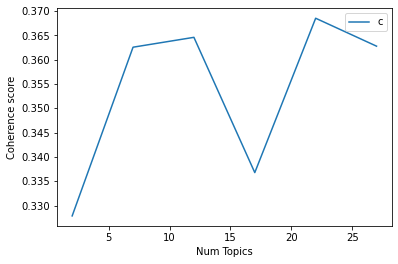

In [83]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [84]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.3279
index: 1 | Num Topics = 7  has Coherence Value of 0.3626
index: 2 | Num Topics = 12  has Coherence Value of 0.3646
index: 3 | Num Topics = 17  has Coherence Value of 0.3368
index: 4 | Num Topics = 22  has Coherence Value of 0.3685
index: 5 | Num Topics = 27  has Coherence Value of 0.3628


In [188]:
# Select optimal number of topics
optimal_model_us_score3 = model_list_us_score3[4]

In [189]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score3 = pyLDAvis.gensim_models.prepare(optimal_model_us_score3, corpus_us_score3, id2word_us_score3)

In [190]:
print("pyLDAVis for us topics for score=3:")
vis_us_score3

pyLDAVis for us topics for score=3:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.197522  0.002499       1        1  14.026244
3      0.019484  0.130209       2        1  11.191035
13    -0.060888  0.175540       3        1   7.722399
17     0.017930  0.096248       4        1   7.155697
6      0.216213 -0.007657       5        1   5.938153
9     -0.061291  0.092535       6        1   5.494461
16     0.156053 -0.053974       7        1   5.450812
10     0.242131 -0.071256       8        1   5.335549
21     0.023129  0.023390       9        1   5.164474
11    -0.024518  0.102975      10        1   4.841249
7     -0.042408  0.033669      11        1   3.963263
2     -0.009150  0.071852      12        1   3.912760
12     0.000866 -0.101865      13        1   3.010023
15    -0.028489 -0.004936      14        1   2.619142
8     -0.095356 -0.136829      15        1   2.606754
19    -0.093087 -0.063176      16        1   2.364365
14    -0.082056 -0.105910      17        1   2.263165
18    -0.049334 -0.040928      18        1   2.252937
20    -0.058056  0.017922      19        1   1.840214
5     -0.082713 -0.064558      20        1   1.018851
0     -0.095392 -0.070831      21        1   0.996150
4     -0.090591 -0.024921      22        1   0.832301, topic_info=       Term        Freq       Total Category  logprob  loglift
49     song  175.000000  175.000000  Default  30.0000  30.0000
33    video  186.000000  186.000000  Default  29.0000  29.0000
78     long   43.000000   43.000000  Default  28.0000  28.0000
44     load   43.000000   43.000000  Default  27.0000  27.0000
112   music   55.000000   55.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
12      bad    0.027521    7.222646  Topic22  -7.0651  -0.7813
13      day    0.027521    2.407528  Topic22  -7.0651   0.3173
14   delete    0.027521   21.461820  Topic22  -7.0651  -1.8704
15     find    0.027521   17.154082  Topic22  -7.0651  -1.6463
16      fix    0.027521   74.733289  Topic22  -7.0651  -3.1180

[1161 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
386       4  0.587886  ability
152       1  0.259866     able
152       2  0.346489     able
152       3  0.259866     able
152       7  0.086622     able
...     ...       ...      ...
94       21  0.126901     year
639       4  0.587888      yet
95       15  0.629252    young
95       18  0.314626    young
172      12  0.797093     zoom

[1588 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 14, 18, 7, 10, 17, 11, 22, 12, 8, 3, 13, 16, 9, 20, 15, 19, 21, 6, 1, 5])

## LDA Topic Modelling (Rating = 4)

In [88]:
# By-rating Topic Modelling - rating = 4
# Convert to list - move to each section
review_us_score4 = lomotif_ios_us_review_YearMonth_score4.review.values.tolist()
review_words_us_score4 = list(sent_to_words(review_us_score4))
print(review_words_us_score4[2:3])

[['the', 'app', 'won', 'load', 'music', 'it', 'keeps', 'saying', 'failure', 'to', 'load', 'tried', 're', 'downloading', 'it', 'and', 're', 'opening', 'the', 'app', 'but', 'nothing', 'is', 'working']]


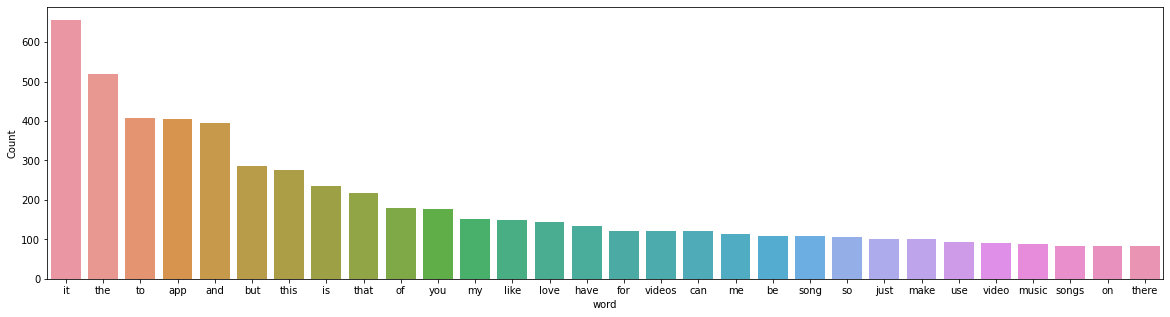

In [89]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score4))

In [90]:
# Clean text
review_us_ready_score4 = process_words(review_words_us_score4)  # processed Text Data! - move to each section

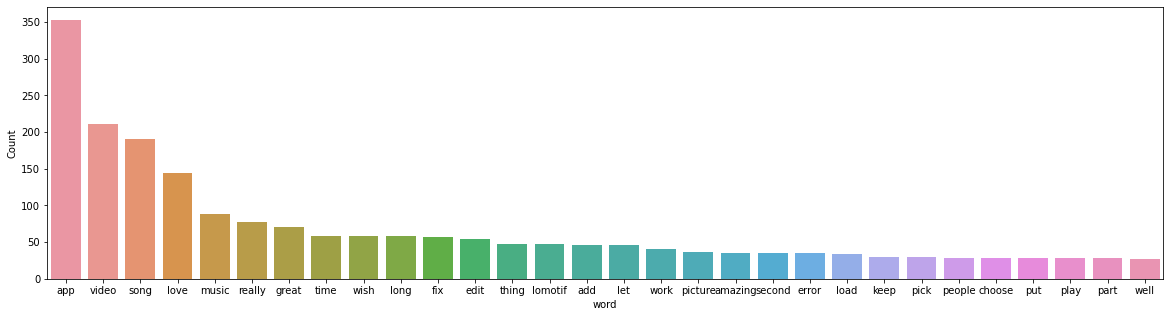

In [91]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score4))


In [92]:
# Create Dictionary
id2word_us_score4 = corpora.Dictionary(review_us_ready_score4)

2021-10-17 02:33:27,729 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 02:33:27,747 [INFO] gensim.corpora.dictionary - built Dictionary(818 unique tokens: ['able', 'believe', 'choose', 'fast', 'motion']...) from 383 documents (total 4501 corpus positions)
2021-10-17 02:33:27,748 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(818 unique tokens: ['able', 'believe', 'choose', 'fast', 'motion']...) from 383 documents (total 4501 corpus positions)", 'datetime': '2021-10-17T02:33:27.748414', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [93]:
# Create Corpus: Term Document Frequency
corpus_us_score4 = [id2word_us_score4.doc2bow(text) for text in review_us_ready_score4]

In [94]:
# Training LDA model
model_list_us_score4, coherence_values_us_score4 = compute_coherence_values(dictionary=id2word_us_score4, corpus=corpus_us_score4, 
                                                              texts=review_us_ready_score4, limit=30, start=2, step=5)


2021-10-17 02:33:28,375 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 02:33:28,378 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 02:33:28,382 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 02:33:28,385 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 383 documents, updating model once every 383 documents, evaluating perplexity every 383 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 02:33:29,687 [INFO] gensim.models.ldamodel - -7.283 per-word bound, 155.7 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:33:29,690 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #383/383
2021-10-17 02:33:30,797 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.060*"app" + 0.055*"song" + 0.026*"video" + 0.022*"love" + 0.016*"really" + 0.014*"add" + 0.011*"wish" 

2021-10-17 02:33:43,095 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.074*"app" + 0.060*"video" + 0.037*"love" + 0.019*"long" + 0.018*"music" + 0.015*"really" + 0.015*"great" + 0.015*"time" + 0.015*"wish" + 0.013*"edit"
2021-10-17 02:33:43,099 [INFO] gensim.models.ldamodel - topic diff=0.019918, rho=0.301511
2021-10-17 02:33:43,730 [INFO] gensim.models.ldamodel - -5.756 per-word bound, 54.1 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:33:43,732 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #383/383
2021-10-17 02:33:44,303 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.078*"song" + 0.057*"app" + 0.016*"music" + 0.015*"fix" + 0.015*"error" + 0.015*"love" + 0.014*"load" + 0.014*"really" + 0.013*"let" + 0.013*"amazing"
2021-10-17 02:33:44,304 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.074*"app" + 0.060*"video" + 0.037*"love" + 0.019*"long" + 0.018*"music" + 0.015*"really" + 0.015*"great" + 0.015*"wish" + 

2021-10-17 02:33:54,073 [INFO] gensim.models.ldamodel - topic diff=0.008100, rho=0.218218
2021-10-17 02:33:54,666 [INFO] gensim.models.ldamodel - -5.744 per-word bound, 53.6 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:33:54,667 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #383/383
2021-10-17 02:33:55,157 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.080*"song" + 0.057*"app" + 0.020*"music" + 0.018*"fix" + 0.015*"error" + 0.015*"let" + 0.015*"load" + 0.014*"love" + 0.014*"really" + 0.013*"amazing"
2021-10-17 02:33:55,159 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.074*"app" + 0.062*"video" + 0.038*"love" + 0.019*"long" + 0.016*"wish" + 0.016*"really" + 0.015*"music" + 0.015*"great" + 0.014*"edit" + 0.014*"time"
2021-10-17 02:33:55,159 [INFO] gensim.models.ldamodel - topic diff=0.007570, rho=0.213201
2021-10-17 02:33:55,694 [INFO] gensim.models.ldamodel - -5.743 per-word bound, 53.6 perplexity estimate base

2021-10-17 02:34:05,156 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #383/383
2021-10-17 02:34:05,682 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.081*"song" + 0.056*"app" + 0.021*"music" + 0.019*"fix" + 0.016*"let" + 0.015*"error" + 0.015*"load" + 0.014*"really" + 0.014*"love" + 0.013*"amazing"
2021-10-17 02:34:05,694 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.075*"app" + 0.063*"video" + 0.038*"love" + 0.019*"long" + 0.017*"wish" + 0.016*"edit" + 0.016*"really" + 0.014*"great" + 0.014*"time" + 0.014*"music"
2021-10-17 02:34:05,697 [INFO] gensim.models.ldamodel - topic diff=0.005117, rho=0.176777
2021-10-17 02:34:06,214 [INFO] gensim.models.ldamodel - -5.738 per-word bound, 53.4 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:34:06,216 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #383/383
2021-10-17 02:34:06,602 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.081*"song" + 0.055*"app" +

2021-10-17 02:34:15,864 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.076*"app" + 0.063*"video" + 0.038*"love" + 0.019*"long" + 0.017*"wish" + 0.017*"edit" + 0.015*"really" + 0.014*"great" + 0.014*"time" + 0.013*"music"
2021-10-17 02:34:15,870 [INFO] gensim.models.ldamodel - topic diff=0.003846, rho=0.154303
2021-10-17 02:34:16,435 [INFO] gensim.models.ldamodel - -5.735 per-word bound, 53.3 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:34:16,436 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #383/383
2021-10-17 02:34:16,905 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.082*"song" + 0.054*"app" + 0.022*"music" + 0.020*"fix" + 0.017*"let" + 0.015*"error" + 0.015*"load" + 0.014*"really" + 0.013*"love" + 0.013*"amazing"
2021-10-17 02:34:16,907 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.076*"app" + 0.063*"video" + 0.038*"love" + 0.019*"long" + 0.017*"wish" + 0.017*"edit" + 0.015*"really" + 0.014*"great" + 0

2021-10-17 02:34:28,997 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 373 virtual documents
2021-10-17 02:34:29,275 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 02:34:29,276 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 02:34:29,279 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 02:34:29,282 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 383 documents, updating model once every 383 documents, evaluating perplexity every 383 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 02:34:30,229 [INFO] gensim.models.ldamodel - -8.621 per-word bound, 393.7 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:34:30,231 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #383/383
2021-10-17 02:34

2021-10-17 02:34:35,775 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #383/383
2021-10-17 02:34:36,086 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.124*"song" + 0.050*"app" + 0.029*"love" + 0.022*"error" + 0.017*"let" + 0.016*"wish" + 0.016*"add" + 0.015*"video" + 0.013*"certain" + 0.013*"always"
2021-10-17 02:34:36,089 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.056*"app" + 0.020*"effect" + 0.019*"music" + 0.016*"well" + 0.016*"stuff" + 0.014*"love" + 0.013*"lomotif" + 0.013*"play" + 0.010*"people" + 0.010*"song"
2021-10-17 02:34:36,098 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.090*"app" + 0.042*"video" + 0.032*"song" + 0.031*"love" + 0.025*"transition" + 0.022*"second" + 0.021*"thing" + 0.021*"music" + 0.017*"long" + 0.016*"wish"
2021-10-17 02:34:36,107 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.065*"app" + 0.031*"song" + 0.028*"really" + 0.027*"love" + 0.026*"music" + 0.025*"video" + 0.024*"fix" + 0.019*"let" + 0.015*"amazing" + 0.01

2021-10-17 02:34:41,685 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.136*"song" + 0.049*"app" + 0.027*"error" + 0.027*"love" + 0.018*"let" + 0.016*"wish" + 0.015*"add" + 0.015*"video" + 0.014*"certain" + 0.013*"choose"
2021-10-17 02:34:41,695 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.056*"app" + 0.021*"effect" + 0.020*"music" + 0.016*"well" + 0.016*"stuff" + 0.014*"love" + 0.014*"lomotif" + 0.013*"play" + 0.011*"song" + 0.011*"people"
2021-10-17 02:34:41,697 [INFO] gensim.models.ldamodel - topic diff=0.018723, rho=0.288675
2021-10-17 02:34:42,335 [INFO] gensim.models.ldamodel - -6.022 per-word bound, 65.0 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:34:42,337 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #383/383
2021-10-17 02:34:42,900 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.065*"app" + 0.029*"song" + 0.028*"really" + 0.028*"love" + 0.026*"music" + 0.026*"video" + 0.024*"fix" + 0.019*"let" +

2021-10-17 02:34:48,089 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.057*"app" + 0.021*"effect" + 0.019*"music" + 0.015*"well" + 0.015*"stuff" + 0.014*"love" + 0.014*"lomotif" + 0.013*"play" + 0.011*"sometimes" + 0.011*"song"
2021-10-17 02:34:48,090 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.090*"app" + 0.046*"video" + 0.033*"love" + 0.028*"song" + 0.026*"second" + 0.025*"transition" + 0.021*"long" + 0.021*"music" + 0.021*"thing" + 0.016*"photo"
2021-10-17 02:34:48,092 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.065*"app" + 0.028*"really" + 0.028*"love" + 0.026*"song" + 0.026*"music" + 0.026*"video" + 0.024*"fix" + 0.019*"let" + 0.017*"amazing" + 0.015*"work"
2021-10-17 02:34:48,093 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.075*"app" + 0.058*"video" + 0.019*"song" + 0.017*"picture" + 0.017*"really" + 0.015*"load" + 0.013*"fix" + 0.013*"keep" + 0.013*"great" + 0.012*"work"
2021-10-17 02:34:48,096 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.071*"

2021-10-17 02:34:52,786 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.089*"app" + 0.046*"video" + 0.033*"love" + 0.027*"song" + 0.026*"second" + 0.024*"transition" + 0.022*"long" + 0.021*"music" + 0.021*"thing" + 0.016*"photo"
2021-10-17 02:34:52,787 [INFO] gensim.models.ldamodel - topic diff=0.005563, rho=0.208514
2021-10-17 02:34:53,304 [INFO] gensim.models.ldamodel - -6.008 per-word bound, 64.4 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:34:53,305 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #383/383
2021-10-17 02:34:53,632 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.065*"app" + 0.029*"really" + 0.028*"love" + 0.026*"video" + 0.026*"music" + 0.025*"song" + 0.023*"fix" + 0.019*"let" + 0.017*"amazing" + 0.016*"work"
2021-10-17 02:34:53,634 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.071*"video" + 0.066*"app" + 0.053*"love" + 0.037*"long" + 0.035*"edit" + 0.024*"time" + 0.023*"wish" + 0.022*"great

2021-10-17 02:34:58,291 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.089*"app" + 0.047*"video" + 0.034*"love" + 0.027*"song" + 0.026*"second" + 0.024*"transition" + 0.022*"long" + 0.021*"music" + 0.021*"thing" + 0.017*"photo"
2021-10-17 02:34:58,292 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.065*"app" + 0.029*"love" + 0.029*"really" + 0.026*"video" + 0.026*"music" + 0.024*"song" + 0.023*"fix" + 0.019*"let" + 0.017*"amazing" + 0.017*"work"
2021-10-17 02:34:58,293 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.057*"app" + 0.021*"effect" + 0.019*"music" + 0.015*"well" + 0.014*"stuff" + 0.014*"love" + 0.014*"lomotif" + 0.013*"play" + 0.011*"sometimes" + 0.011*"song"
2021-10-17 02:34:58,294 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.150*"song" + 0.049*"app" + 0.039*"error" + 0.025*"love" + 0.018*"let" + 0.017*"load" + 0.017*"certain" + 0.016*"fix" + 0.015*"video" + 0.015*"great"
2021-10-17 02:34:58,295 [INFO] gensim.models.ldamodel - topic diff=0.003490, rho=0.

2021-10-17 02:35:02,999 [INFO] gensim.models.ldamodel - topic diff=0.003061, rho=0.171499
2021-10-17 02:35:03,471 [INFO] gensim.models.ldamodel - -6.003 per-word bound, 64.1 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:35:03,472 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #383/383
2021-10-17 02:35:03,881 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.029*"add" + 0.024*"picture" + 0.022*"wish" + 0.018*"move" + 0.018*"time" + 0.016*"update" + 0.015*"app" + 0.012*"love" + 0.011*"thing" + 0.011*"kick"
2021-10-17 02:35:03,882 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.151*"song" + 0.049*"app" + 0.039*"error" + 0.025*"love" + 0.018*"let" + 0.017*"fix" + 0.017*"load" + 0.016*"certain" + 0.016*"great" + 0.015*"video"
2021-10-17 02:35:03,884 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.070*"video" + 0.066*"app" + 0.053*"love" + 0.038*"long" + 0.036*"edit" + 0.024*"time" + 0.024*"wish" + 0.022*"great" + 0.01

2021-10-17 02:35:08,547 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.088*"app" + 0.047*"video" + 0.034*"love" + 0.028*"song" + 0.026*"second" + 0.025*"transition" + 0.023*"long" + 0.022*"music" + 0.021*"thing" + 0.017*"photo"
2021-10-17 02:35:08,550 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.066*"app" + 0.029*"really" + 0.028*"love" + 0.026*"video" + 0.025*"music" + 0.023*"song" + 0.023*"fix" + 0.019*"let" + 0.018*"amazing" + 0.017*"work"
2021-10-17 02:35:08,552 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.070*"video" + 0.066*"app" + 0.053*"love" + 0.038*"long" + 0.037*"edit" + 0.024*"wish" + 0.024*"time" + 0.023*"great" + 0.018*"music" + 0.014*"really"
2021-10-17 02:35:08,554 [INFO] gensim.models.ldamodel - topic diff=0.003027, rho=0.158114
2021-10-17 02:35:09,151 [INFO] gensim.models.ldamodel - -5.999 per-word bound, 63.9 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:35:09,152 [INFO] gensim.models.ldamodel - PROGR

2021-10-17 02:35:14,169 [INFO] gensim.models.ldamodel - -5.995 per-word bound, 63.8 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:35:14,170 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #383/383
2021-10-17 02:35:14,560 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.088*"app" + 0.047*"video" + 0.034*"love" + 0.028*"song" + 0.026*"second" + 0.025*"transition" + 0.024*"long" + 0.022*"music" + 0.021*"thing" + 0.017*"photo"
2021-10-17 02:35:14,567 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.077*"app" + 0.060*"video" + 0.020*"picture" + 0.017*"really" + 0.016*"keep" + 0.014*"work" + 0.012*"fix" + 0.012*"load" + 0.012*"great" + 0.012*"change"
2021-10-17 02:35:14,597 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.029*"add" + 0.024*"picture" + 0.022*"wish" + 0.018*"move" + 0.018*"time" + 0.016*"update" + 0.015*"app" + 0.012*"love" + 0.011*"thing" + 0.011*"kick"
2021-10-17 02:35:14,602 [INFO] gensim.models.ldamode

2021-10-17 02:35:19,160 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.153*"song" + 0.049*"app" + 0.038*"error" + 0.025*"love" + 0.019*"fix" + 0.018*"load" + 0.018*"let" + 0.018*"great" + 0.016*"music" + 0.016*"certain"
2021-10-17 02:35:19,163 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.027*"add" + 0.025*"picture" + 0.022*"wish" + 0.018*"move" + 0.016*"time" + 0.016*"update" + 0.015*"app" + 0.012*"love" + 0.011*"thing" + 0.011*"fast"
2021-10-17 02:35:19,165 [INFO] gensim.models.ldamodel - topic diff=0.003276, rho=0.140028
2021-10-17 02:35:19,167 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=818, num_topics=7, decay=0.5, chunksize=1000) in 49.89s', 'datetime': '2021-10-17T02:35:19.167690', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-17 02:35:19,171 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordO

2021-10-17 02:35:29,584 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.061*"app" + 0.058*"video" + 0.033*"really" + 0.026*"song" + 0.018*"fix" + 0.017*"thing" + 0.016*"love" + 0.015*"keep" + 0.015*"photo" + 0.014*"pick"
2021-10-17 02:35:29,641 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.049*"music" + 0.041*"load" + 0.040*"picture" + 0.030*"video" + 0.029*"app" + 0.025*"song" + 0.018*"love" + 0.017*"give" + 0.016*"slow" + 0.015*"select"
2021-10-17 02:35:29,652 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.100*"app" + 0.045*"love" + 0.027*"stuff" + 0.023*"video" + 0.016*"update" + 0.015*"little" + 0.014*"slideshow" + 0.014*"bit" + 0.014*"thing" + 0.011*"effect"
2021-10-17 02:35:29,653 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.144*"song" + 0.052*"app" + 0.027*"love" + 0.022*"work" + 0.022*"error" + 0.021*"video" + 0.020*"add" + 0.020*"great" + 0.018*"part" + 0.018*"wish"
2021-10-17 02:35:29,655 [INFO] gensim.models.ldamodel - topic diff=0.085298, rho=0.408248


2021-10-17 02:35:35,414 [INFO] gensim.models.ldamodel - topic diff=0.033965, rho=0.301511
2021-10-17 02:35:36,057 [INFO] gensim.models.ldamodel - -6.175 per-word bound, 72.3 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:35:36,059 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #383/383
2021-10-17 02:35:36,458 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.158*"song" + 0.054*"app" + 0.028*"error" + 0.026*"great" + 0.026*"work" + 0.023*"love" + 0.023*"video" + 0.020*"part" + 0.018*"add" + 0.017*"let"
2021-10-17 02:35:36,461 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.029*"add" + 0.027*"song" + 0.027*"app" + 0.022*"time" + 0.018*"problem" + 0.018*"kick" + 0.018*"awesome" + 0.017*"great" + 0.014*"play" + 0.014*"update"
2021-10-17 02:35:36,465 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.051*"music" + 0.048*"picture" + 0.042*"load" + 0.033*"video" + 0.025*"app" + 0.022*"slow" + 0.018*"select" + 0.018*"give" +

2021-10-17 02:35:41,967 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.083*"app" + 0.054*"song" + 0.025*"change" + 0.023*"video" + 0.016*"part" + 0.013*"picture" + 0.012*"let" + 0.012*"lomotif" + 0.012*"keep" + 0.010*"pick"
2021-10-17 02:35:41,974 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.029*"add" + 0.024*"song" + 0.024*"app" + 0.022*"time" + 0.018*"kick" + 0.018*"awesome" + 0.018*"problem" + 0.016*"great" + 0.014*"play" + 0.014*"update"
2021-10-17 02:35:41,998 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.064*"play" + 0.048*"effect" + 0.034*"app" + 0.030*"well" + 0.027*"feature" + 0.027*"wish" + 0.022*"allow" + 0.021*"amazing" + 0.018*"song" + 0.017*"flipagram"
2021-10-17 02:35:42,012 [INFO] gensim.models.ldamodel - topic diff=0.016351, rho=0.242536
2021-10-17 02:35:42,652 [INFO] gensim.models.ldamodel - -6.151 per-word bound, 71.1 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:35:42,654 [INFO] gensim.models.ldamode

2021-10-17 02:35:48,187 [INFO] gensim.models.ldamodel - -6.142 per-word bound, 70.6 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:35:48,188 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #383/383
2021-10-17 02:35:48,677 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.030*"add" + 0.022*"time" + 0.022*"app" + 0.022*"song" + 0.019*"kick" + 0.018*"awesome" + 0.017*"problem" + 0.015*"great" + 0.014*"play" + 0.014*"update"
2021-10-17 02:35:48,686 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.082*"app" + 0.051*"video" + 0.029*"song" + 0.026*"music" + 0.026*"edit" + 0.025*"really" + 0.022*"thing" + 0.018*"fix" + 0.017*"love" + 0.015*"limit"
2021-10-17 02:35:48,692 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.081*"app" + 0.050*"song" + 0.025*"change" + 0.023*"video" + 0.017*"part" + 0.013*"picture" + 0.013*"let" + 0.012*"lomotif" + 0.012*"keep" + 0.011*"pick"
2021-10-17 02:35:48,694 [INFO] gensim.models.ldamodel -

2021-10-17 02:35:54,033 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.083*"app" + 0.052*"video" + 0.027*"music" + 0.027*"edit" + 0.026*"song" + 0.026*"really" + 0.022*"thing" + 0.017*"fix" + 0.016*"love" + 0.016*"limit"
2021-10-17 02:35:54,037 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.056*"app" + 0.054*"video" + 0.033*"really" + 0.022*"fix" + 0.021*"song" + 0.017*"photo" + 0.016*"keep" + 0.015*"thing" + 0.015*"work" + 0.014*"load"
2021-10-17 02:35:54,038 [INFO] gensim.models.ldamodel - topic diff=0.006871, rho=0.188982
2021-10-17 02:35:54,727 [INFO] gensim.models.ldamodel - -6.136 per-word bound, 70.3 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:35:54,730 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #383/383
2021-10-17 02:35:55,169 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.104*"app" + 0.050*"love" + 0.034*"stuff" + 0.023*"slideshow" + 0.020*"video" + 0.017*"little" + 0.017*"thing" + 0.017*"upda

2021-10-17 02:36:00,786 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.080*"app" + 0.048*"song" + 0.026*"change" + 0.023*"video" + 0.017*"part" + 0.013*"picture" + 0.013*"let" + 0.012*"lomotif" + 0.012*"keep" + 0.011*"pick"
2021-10-17 02:36:00,789 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.104*"app" + 0.050*"love" + 0.034*"stuff" + 0.024*"slideshow" + 0.020*"video" + 0.018*"little" + 0.017*"thing" + 0.017*"update" + 0.016*"bit" + 0.011*"nasty"
2021-10-17 02:36:00,791 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.097*"video" + 0.089*"app" + 0.056*"love" + 0.053*"long" + 0.037*"wish" + 0.035*"great" + 0.035*"edit" + 0.026*"time" + 0.019*"second" + 0.014*"minute"
2021-10-17 02:36:00,802 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.080*"app" + 0.072*"transition" + 0.048*"love" + 0.023*"add" + 0.020*"music" + 0.017*"star" + 0.016*"really" + 0.015*"people" + 0.014*"lomotif" + 0.013*"well"
2021-10-17 02:36:00,807 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0

2021-10-17 02:36:07,114 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.067*"play" + 0.053*"effect" + 0.032*"wish" + 0.029*"feature" + 0.028*"app" + 0.025*"well" + 0.023*"allow" + 0.021*"amazing" + 0.018*"song" + 0.018*"flipagram"
2021-10-17 02:36:07,116 [INFO] gensim.models.ldamodel - topic diff=0.003662, rho=0.160128
2021-10-17 02:36:07,950 [INFO] gensim.models.ldamodel - -6.128 per-word bound, 69.9 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:36:07,966 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #383/383
2021-10-17 02:36:08,434 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.104*"app" + 0.050*"love" + 0.034*"stuff" + 0.024*"slideshow" + 0.020*"video" + 0.018*"little" + 0.017*"thing" + 0.017*"update" + 0.016*"bit" + 0.011*"nasty"
2021-10-17 02:36:08,438 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.058*"app" + 0.052*"let" + 0.043*"really" + 0.033*"amazing" + 0.025*"love" + 0.025*"music" + 0.023*"song" +

2021-10-17 02:36:15,424 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.058*"app" + 0.051*"let" + 0.043*"really" + 0.034*"amazing" + 0.025*"love" + 0.025*"music" + 0.022*"remove" + 0.022*"song" + 0.019*"cool" + 0.017*"pay"
2021-10-17 02:36:15,427 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.068*"play" + 0.054*"effect" + 0.031*"wish" + 0.029*"feature" + 0.028*"app" + 0.024*"well" + 0.023*"allow" + 0.021*"amazing" + 0.018*"flipagram" + 0.018*"beat"
2021-10-17 02:36:15,430 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.056*"picture" + 0.054*"music" + 0.033*"load" + 0.032*"slow" + 0.030*"video" + 0.025*"app" + 0.024*"love" + 0.022*"select" + 0.020*"add" + 0.019*"give"
2021-10-17 02:36:15,434 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.104*"app" + 0.050*"love" + 0.034*"stuff" + 0.024*"slideshow" + 0.020*"video" + 0.018*"little" + 0.017*"thing" + 0.017*"update" + 0.016*"bit" + 0.011*"nasty"
2021-10-17 02:36:15,436 [INFO] gensim.models.ldamodel - topic diff=0.002627, r

2021-10-17 02:36:21,294 [INFO] gensim.models.ldamodel - topic diff=0.002296, rho=0.141421
2021-10-17 02:36:21,907 [INFO] gensim.models.ldamodel - -6.123 per-word bound, 69.7 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:36:21,910 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #383/383
2021-10-17 02:36:22,318 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.097*"video" + 0.089*"app" + 0.056*"love" + 0.053*"long" + 0.038*"wish" + 0.035*"great" + 0.035*"edit" + 0.026*"time" + 0.019*"second" + 0.014*"minute"
2021-10-17 02:36:22,320 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.059*"app" + 0.051*"let" + 0.043*"really" + 0.034*"amazing" + 0.025*"love" + 0.025*"music" + 0.022*"remove" + 0.021*"song" + 0.019*"cool" + 0.017*"pay"
2021-10-17 02:36:22,324 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.030*"add" + 0.023*"time" + 0.021*"song" + 0.020*"app" + 0.019*"kick" + 0.018*"awesome" + 0.015*"problem" + 0.014*"update

2021-10-17 02:36:35,988 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.054*"app" + 0.038*"song" + 0.031*"love" + 0.028*"video" + 0.022*"really" + 0.021*"problem" + 0.020*"slideshow" + 0.018*"photo" + 0.017*"amazing" + 0.016*"great"
2021-10-17 02:36:35,990 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.056*"app" + 0.032*"love" + 0.023*"music" + 0.023*"video" + 0.019*"option" + 0.019*"transition" + 0.018*"star" + 0.018*"change" + 0.018*"overall" + 0.014*"remove"
2021-10-17 02:36:35,992 [INFO] gensim.models.ldamodel - topic diff=0.114771, rho=0.447214
2021-10-17 02:36:36,621 [INFO] gensim.models.ldamodel - -6.371 per-word bound, 82.8 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:36:36,623 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #383/383
2021-10-17 02:36:36,951 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.105*"app" + 0.043*"video" + 0.042*"love" + 0.024*"add" + 0.020*"transition" + 0.017*"song" + 0.017

2021-10-17 02:36:41,771 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.107*"app" + 0.045*"video" + 0.042*"love" + 0.028*"add" + 0.021*"transition" + 0.017*"keep" + 0.017*"song" + 0.016*"really" + 0.015*"kick" + 0.014*"always"
2021-10-17 02:36:41,775 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.086*"app" + 0.041*"video" + 0.036*"love" + 0.035*"music" + 0.035*"thing" + 0.034*"wish" + 0.033*"really" + 0.027*"second" + 0.025*"long" + 0.024*"song"
2021-10-17 02:36:41,779 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.082*"song" + 0.072*"app" + 0.042*"fix" + 0.040*"error" + 0.030*"love" + 0.024*"video" + 0.017*"great" + 0.017*"choose" + 0.015*"lomotif" + 0.011*"friend"
2021-10-17 02:36:41,781 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.099*"app" + 0.056*"song" + 0.027*"great" + 0.023*"pick" + 0.018*"part" + 0.018*"video" + 0.018*"let" + 0.017*"long" + 0.015*"effect" + 0.015*"add"
2021-10-17 02:36:41,783 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.066*"vide

2021-10-17 02:36:47,043 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.121*"app" + 0.035*"video" + 0.033*"love" + 0.023*"stuff" + 0.022*"great" + 0.016*"much" + 0.013*"thing" + 0.013*"little" + 0.013*"people" + 0.013*"well"
2021-10-17 02:36:47,047 [INFO] gensim.models.ldamodel - topic diff=0.014948, rho=0.250000
2021-10-17 02:36:47,618 [INFO] gensim.models.ldamodel - -6.286 per-word bound, 78.0 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:36:47,624 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #383/383
2021-10-17 02:36:48,074 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.066*"video" + 0.048*"app" + 0.039*"song" + 0.036*"really" + 0.032*"load" + 0.023*"picture" + 0.018*"work" + 0.015*"put" + 0.014*"love" + 0.013*"great"
2021-10-17 02:36:48,076 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.109*"app" + 0.046*"video" + 0.042*"love" + 0.029*"add" + 0.021*"transition" + 0.017*"keep" + 0.017*"song" + 0.016*"ki

2021-10-17 02:36:53,102 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.037*"app" + 0.031*"song" + 0.027*"edit" + 0.025*"time" + 0.019*"vid" + 0.019*"motion" + 0.019*"keep" + 0.019*"update" + 0.019*"kick" + 0.013*"cool"
2021-10-17 02:36:53,106 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.091*"app" + 0.042*"video" + 0.038*"music" + 0.035*"wish" + 0.035*"thing" + 0.034*"love" + 0.033*"really" + 0.027*"second" + 0.025*"edit" + 0.022*"long"
2021-10-17 02:36:53,111 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.111*"app" + 0.046*"video" + 0.043*"love" + 0.029*"add" + 0.022*"transition" + 0.018*"keep" + 0.016*"song" + 0.016*"kick" + 0.015*"problem" + 0.015*"really"
2021-10-17 02:36:53,117 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.039*"app" + 0.033*"guy" + 0.025*"video" + 0.023*"new" + 0.022*"feel" + 0.018*"feature" + 0.012*"look" + 0.012*"watermark" + 0.012*"rid" + 0.012*"update"
2021-10-17 02:36:53,122 [INFO] gensim.models.ldamodel - topic diff=0.007345, rho=0.213

2021-10-17 02:36:58,099 [INFO] gensim.models.ldamodel - topic diff=0.004849, rho=0.192450
2021-10-17 02:36:58,673 [INFO] gensim.models.ldamodel - -6.276 per-word bound, 77.5 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:36:58,674 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #383/383
2021-10-17 02:36:59,037 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.040*"app" + 0.032*"video" + 0.031*"love" + 0.029*"amazing" + 0.024*"slideshow" + 0.024*"first" + 0.023*"song" + 0.020*"photo" + 0.020*"problem" + 0.015*"music"
2021-10-17 02:36:59,038 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.093*"long" + 0.079*"video" + 0.047*"app" + 0.037*"wish" + 0.034*"song" + 0.030*"love" + 0.027*"time" + 0.024*"picture" + 0.021*"perfect" + 0.020*"choose"
2021-10-17 02:36:59,039 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.085*"song" + 0.073*"app" + 0.047*"fix" + 0.044*"error" + 0.030*"love" + 0.027*"video" + 0.019*"choose" + 0

2021-10-17 02:37:04,223 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.033*"app" + 0.032*"song" + 0.028*"edit" + 0.026*"time" + 0.020*"keep" + 0.020*"kick" + 0.019*"motion" + 0.019*"update" + 0.019*"vid" + 0.013*"add"
2021-10-17 02:37:04,246 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.067*"video" + 0.049*"app" + 0.038*"song" + 0.033*"really" + 0.031*"load" + 0.024*"picture" + 0.019*"work" + 0.015*"put" + 0.015*"love" + 0.014*"great"
2021-10-17 02:37:04,248 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.117*"sometimes" + 0.105*"work" + 0.053*"song" + 0.027*"awesome" + 0.020*"let" + 0.019*"well" + 0.019*"example" + 0.019*"sure" + 0.019*"annoy" + 0.019*"fix"
2021-10-17 02:37:04,249 [INFO] gensim.models.ldamodel - topic diff=0.003641, rho=0.174078
2021-10-17 02:37:04,767 [INFO] gensim.models.ldamodel - -6.270 per-word bound, 77.2 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:37:04,769 [INFO] gensim.models.ldamodel - PROGRES

2021-10-17 02:37:09,865 [INFO] gensim.models.ldamodel - -6.266 per-word bound, 77.0 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:37:09,867 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #383/383
2021-10-17 02:37:10,418 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.091*"app" + 0.043*"video" + 0.039*"music" + 0.036*"wish" + 0.035*"thing" + 0.035*"really" + 0.033*"love" + 0.029*"edit" + 0.026*"second" + 0.021*"time"
2021-10-17 02:37:10,422 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.038*"app" + 0.032*"love" + 0.030*"amazing" + 0.029*"video" + 0.025*"slideshow" + 0.025*"first" + 0.021*"song" + 0.021*"photo" + 0.021*"problem" + 0.015*"music"
2021-10-17 02:37:10,428 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.062*"app" + 0.037*"love" + 0.024*"music" + 0.024*"video" + 0.019*"transition" + 0.019*"option" + 0.019*"change" + 0.019*"star" + 0.018*"overall" + 0.014*"remove"
2021-10-17 02:37:10,430 [INFO] gensim

2021-10-17 02:37:15,424 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.089*"music" + 0.045*"app" + 0.045*"song" + 0.035*"load" + 0.026*"time" + 0.026*"picture" + 0.022*"sometimes" + 0.020*"give" + 0.018*"fix" + 0.018*"let"
2021-10-17 02:37:15,429 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.100*"long" + 0.080*"video" + 0.047*"app" + 0.036*"wish" + 0.034*"song" + 0.030*"love" + 0.027*"time" + 0.024*"picture" + 0.021*"perfect" + 0.020*"well"
2021-10-17 02:37:15,432 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.084*"song" + 0.075*"app" + 0.048*"fix" + 0.043*"error" + 0.029*"video" + 0.029*"love" + 0.020*"choose" + 0.016*"lomotif" + 0.015*"great" + 0.012*"really"
2021-10-17 02:37:15,433 [INFO] gensim.models.ldamodel - topic diff=0.002022, rho=0.150756
2021-10-17 02:37:15,974 [INFO] gensim.models.ldamodel - -6.264 per-word bound, 76.9 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:37:15,976 [INFO] gensim.models.ldamodel - PR

2021-10-17 02:37:21,125 [INFO] gensim.models.ldamodel - -6.263 per-word bound, 76.8 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:37:21,129 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #383/383
2021-10-17 02:37:21,489 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.117*"app" + 0.037*"video" + 0.033*"love" + 0.024*"stuff" + 0.021*"great" + 0.014*"much" + 0.014*"thing" + 0.014*"people" + 0.014*"little" + 0.012*"well"
2021-10-17 02:37:21,492 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.151*"song" + 0.061*"app" + 0.044*"love" + 0.031*"part" + 0.031*"pick" + 0.030*"let" + 0.025*"certain" + 0.020*"edit" + 0.018*"great" + 0.017*"problem"
2021-10-17 02:37:21,496 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.089*"music" + 0.046*"song" + 0.046*"app" + 0.035*"load" + 0.026*"time" + 0.026*"picture" + 0.022*"sometimes" + 0.021*"give" + 0.018*"fix" + 0.017*"let"
2021-10-17 02:37:21,506 [INFO] gensim.models.ldamodel - 

2021-10-17 02:37:34,041 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.077*"app" + 0.026*"star" + 0.025*"add" + 0.023*"time" + 0.023*"overall" + 0.019*"give" + 0.017*"fix" + 0.016*"picture" + 0.015*"change" + 0.015*"lomotif"
2021-10-17 02:37:34,043 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.035*"song" + 0.033*"slow" + 0.033*"app" + 0.030*"video" + 0.029*"look" + 0.027*"motion" + 0.021*"love" + 0.021*"quality" + 0.020*"picture" + 0.020*"option"
2021-10-17 02:37:34,044 [INFO] gensim.models.ldamodel - topic diff=0.121054, rho=0.500000
2021-10-17 02:37:34,507 [INFO] gensim.models.ldamodel - -6.488 per-word bound, 89.8 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:37:34,509 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #383/383
2021-10-17 02:37:34,936 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.038*"wish" + 0.032*"video" + 0.028*"app" + 0.027*"limit" + 0.026*"second" + 0.025*"feature" + 0.021*"song" + 0

2021-10-17 02:37:39,676 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #383/383
2021-10-17 02:37:40,195 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.056*"app" + 0.039*"music" + 0.037*"happen" + 0.030*"love" + 0.024*"lomotif" + 0.021*"really" + 0.019*"keep" + 0.012*"amazing" + 0.010*"never" + 0.010*"work"
2021-10-17 02:37:40,198 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.071*"app" + 0.029*"transition" + 0.028*"add" + 0.023*"love" + 0.023*"song" + 0.022*"music" + 0.021*"keep" + 0.019*"amazing" + 0.019*"edit" + 0.017*"video"
2021-10-17 02:37:40,200 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.104*"app" + 0.053*"love" + 0.031*"song" + 0.026*"great" + 0.021*"people" + 0.019*"kid" + 0.019*"stuff" + 0.018*"change" + 0.015*"friend" + 0.013*"add"
2021-10-17 02:37:40,205 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.078*"app" + 0.035*"video" + 0.035*"play" + 0.030*"love" + 0.022*"wish" + 0.021*"fix" + 0.020*"really" + 0.017*"thing" + 0.017*"song" +

2021-10-17 02:37:45,543 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.057*"app" + 0.039*"music" + 0.037*"happen" + 0.031*"love" + 0.022*"lomotif" + 0.020*"really" + 0.019*"keep" + 0.012*"amazing" + 0.011*"never" + 0.010*"work"
2021-10-17 02:37:45,545 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.093*"app" + 0.042*"song" + 0.030*"video" + 0.022*"keep" + 0.020*"lomotif" + 0.018*"glitch" + 0.014*"add" + 0.014*"load" + 0.014*"long" + 0.014*"part"
2021-10-17 02:37:45,546 [INFO] gensim.models.ldamodel - topic diff=0.023964, rho=0.258199
2021-10-17 02:37:46,065 [INFO] gensim.models.ldamodel - -6.350 per-word bound, 81.6 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:37:46,067 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #383/383
2021-10-17 02:37:46,458 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.107*"song" + 0.088*"app" + 0.053*"choose" + 0.044*"video" + 0.039*"long" + 0.039*"error" + 0.031*"love" + 0.026*

2021-10-17 02:37:51,137 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #383/383
2021-10-17 02:37:51,510 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.101*"app" + 0.059*"love" + 0.052*"video" + 0.041*"wish" + 0.041*"thing" + 0.033*"long" + 0.032*"second" + 0.029*"really" + 0.025*"time" + 0.025*"music"
2021-10-17 02:37:51,513 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.213*"song" + 0.045*"error" + 0.033*"fix" + 0.033*"app" + 0.033*"load" + 0.025*"problem" + 0.025*"really" + 0.024*"preview" + 0.024*"select" + 0.023*"work"
2021-10-17 02:37:51,516 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.099*"music" + 0.044*"edit" + 0.031*"picture" + 0.031*"option" + 0.027*"love" + 0.023*"load" + 0.023*"star" + 0.022*"transition" + 0.022*"let" + 0.022*"give"
2021-10-17 02:37:51,518 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.106*"video" + 0.084*"app" + 0.070*"love" + 0.037*"wish" + 0.035*"long" + 0.033*"work" + 0.030*"great" + 0.022*"time" + 0.018*"crash" + 

2021-10-17 02:37:56,245 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.091*"app" + 0.044*"song" + 0.033*"video" + 0.027*"lomotif" + 0.022*"keep" + 0.019*"glitch" + 0.018*"creator" + 0.014*"load" + 0.014*"look" + 0.014*"long"
2021-10-17 02:37:56,248 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.095*"video" + 0.080*"app" + 0.040*"edit" + 0.037*"fix" + 0.031*"great" + 0.024*"start" + 0.023*"work" + 0.020*"put" + 0.020*"friend" + 0.020*"time"
2021-10-17 02:37:56,253 [INFO] gensim.models.ldamodel - topic diff=0.009819, rho=0.196116
2021-10-17 02:37:56,793 [INFO] gensim.models.ldamodel - -6.310 per-word bound, 79.4 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:37:56,794 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #383/383
2021-10-17 02:37:57,055 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.071*"app" + 0.045*"love" + 0.044*"slideshow" + 0.038*"video" + 0.031*"stuff" + 0.020*"little" + 0.016*"bit" + 0.016*"d

2021-10-17 02:38:01,470 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #383/383
2021-10-17 02:38:01,922 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.122*"song" + 0.090*"app" + 0.066*"choose" + 0.040*"error" + 0.038*"video" + 0.031*"long" + 0.028*"part" + 0.027*"wish" + 0.026*"love" + 0.021*"music"
2021-10-17 02:38:01,923 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.103*"music" + 0.042*"edit" + 0.031*"picture" + 0.031*"option" + 0.024*"load" + 0.024*"star" + 0.023*"love" + 0.023*"let" + 0.023*"transition" + 0.022*"give"
2021-10-17 02:38:01,928 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.045*"wish" + 0.035*"feature" + 0.031*"video" + 0.029*"app" + 0.025*"limit" + 0.024*"second" + 0.024*"thing" + 0.019*"song" + 0.018*"option" + 0.018*"change"
2021-10-17 02:38:01,934 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.088*"slow" + 0.060*"picture" + 0.045*"video" + 0.035*"motion" + 0.035*"fast" + 0.023*"quality" + 0.023*"option" + 0.016*"choose" + 0.

2021-10-17 02:38:06,802 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.077*"video" + 0.050*"app" + 0.026*"music" + 0.024*"song" + 0.023*"least" + 0.019*"second" + 0.016*"minute" + 0.016*"picture" + 0.016*"really" + 0.016*"feel"
2021-10-17 02:38:06,804 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.088*"slow" + 0.062*"picture" + 0.047*"video" + 0.034*"motion" + 0.034*"fast" + 0.023*"quality" + 0.023*"option" + 0.016*"choose" + 0.016*"able" + 0.015*"love"
2021-10-17 02:38:06,805 [INFO] gensim.models.ldamodel - topic diff=0.004425, rho=0.164399
2021-10-17 02:38:07,330 [INFO] gensim.models.ldamodel - -6.298 per-word bound, 78.7 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:38:07,334 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #383/383
2021-10-17 02:38:07,703 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.071*"app" + 0.045*"slideshow" + 0.045*"love" + 0.038*"video" + 0.032*"stuff" + 0.020*"little" + 0.017*"b

2021-10-17 02:38:12,575 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.095*"video" + 0.080*"app" + 0.040*"edit" + 0.038*"fix" + 0.031*"great" + 0.024*"start" + 0.023*"work" + 0.021*"friend" + 0.020*"time" + 0.020*"put"
2021-10-17 02:38:12,578 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.059*"app" + 0.036*"music" + 0.030*"happen" + 0.030*"love" + 0.023*"lomotif" + 0.021*"really" + 0.020*"keep" + 0.010*"amazing" + 0.010*"never" + 0.010*"work"
2021-10-17 02:38:12,582 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.075*"video" + 0.050*"app" + 0.026*"music" + 0.024*"song" + 0.023*"least" + 0.019*"second" + 0.016*"picture" + 0.016*"minute" + 0.016*"really" + 0.016*"feel"
2021-10-17 02:38:12,584 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.073*"song" + 0.061*"sometimes" + 0.052*"pick" + 0.051*"let" + 0.041*"fix" + 0.040*"app" + 0.028*"bug" + 0.026*"music" + 0.024*"amazing" + 0.024*"remove"
2021-10-17 02:38:12,586 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.07

2021-10-17 02:38:17,437 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.066*"app" + 0.024*"effect" + 0.024*"video" + 0.024*"filter" + 0.024*"tik" + 0.024*"tok" + 0.024*"wish" + 0.024*"beat" + 0.022*"guy" + 0.016*"sometimes"
2021-10-17 02:38:17,438 [INFO] gensim.models.ldamodel - topic diff=0.002430, rho=0.144338
2021-10-17 02:38:18,031 [INFO] gensim.models.ldamodel - -6.294 per-word bound, 78.5 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:38:18,038 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #383/383
2021-10-17 02:38:18,563 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.088*"slow" + 0.064*"picture" + 0.050*"video" + 0.034*"motion" + 0.034*"fast" + 0.023*"quality" + 0.023*"option" + 0.017*"choose" + 0.016*"able" + 0.015*"love"
2021-10-17 02:38:18,565 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.077*"app" + 0.037*"star" + 0.028*"give" + 0.023*"add" + 0.023*"overall" + 0.023*"time" + 0.019*"lomotif" + 0.

2021-10-17 02:38:33,427 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.068*"app" + 0.034*"amazing" + 0.033*"fix" + 0.022*"tiktok" + 0.022*"love" + 0.022*"wish" + 0.022*"thing" + 0.021*"video" + 0.018*"feature" + 0.014*"lomotif"
2021-10-17 02:38:33,429 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.076*"app" + 0.058*"song" + 0.030*"pick" + 0.023*"video" + 0.023*"part" + 0.017*"watermark" + 0.017*"option" + 0.017*"remove" + 0.016*"let" + 0.016*"great"
2021-10-17 02:38:33,431 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.048*"video" + 0.048*"app" + 0.042*"song" + 0.039*"let" + 0.032*"picture" + 0.027*"wish" + 0.026*"music" + 0.025*"love" + 0.020*"choose" + 0.019*"change"
2021-10-17 02:38:33,433 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.049*"app" + 0.042*"add" + 0.041*"song" + 0.035*"sometimes" + 0.027*"video" + 0.027*"give" + 0.019*"transition" + 0.017*"second" + 0.017*"effect" + 0.014*"star"
2021-10-17 02:38:33,434 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-17 02:38:38,283 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.096*"song" + 0.079*"app" + 0.027*"error" + 0.026*"music" + 0.022*"choose" + 0.021*"love" + 0.020*"fix" + 0.019*"great" + 0.014*"wish" + 0.014*"kid"
2021-10-17 02:38:38,288 [INFO] gensim.models.ldamodel - topic diff=0.079385, rho=0.353553
2021-10-17 02:38:38,954 [INFO] gensim.models.ldamodel - -6.472 per-word bound, 88.8 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:38:38,956 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #383/383
2021-10-17 02:38:39,359 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.134*"music" + 0.054*"love" + 0.042*"load" + 0.038*"app" + 0.031*"let" + 0.028*"wish" + 0.024*"give" + 0.018*"edit" + 0.017*"picture" + 0.016*"part"
2021-10-17 02:38:39,362 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.068*"app" + 0.060*"song" + 0.050*"video" + 0.041*"really" + 0.032*"put" + 0.025*"fix" + 0.022*"time" + 0.018*"music" + 0.018*

2021-10-17 02:38:45,569 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.098*"song" + 0.078*"app" + 0.027*"error" + 0.026*"music" + 0.024*"choose" + 0.021*"fix" + 0.019*"love" + 0.019*"great" + 0.014*"kid" + 0.013*"wish"
2021-10-17 02:38:45,571 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.109*"app" + 0.061*"fix" + 0.043*"music" + 0.041*"pick" + 0.030*"song" + 0.027*"love" + 0.027*"error" + 0.020*"really" + 0.015*"video" + 0.015*"time"
2021-10-17 02:38:45,573 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.062*"music" + 0.045*"love" + 0.042*"app" + 0.022*"video" + 0.020*"friend" + 0.020*"keep" + 0.016*"great" + 0.015*"comment" + 0.015*"fun" + 0.015*"load"
2021-10-17 02:38:45,575 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.145*"music" + 0.054*"love" + 0.040*"load" + 0.036*"app" + 0.032*"let" + 0.032*"wish" + 0.024*"give" + 0.020*"edit" + 0.016*"picture" + 0.016*"part"
2021-10-17 02:38:45,578 [INFO] gensim.models.ldamodel - topic diff=0.030652, rho=0.267261
2021-10

2021-10-17 02:38:51,403 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.099*"song" + 0.078*"app" + 0.027*"music" + 0.026*"error" + 0.025*"choose" + 0.022*"fix" + 0.019*"great" + 0.018*"love" + 0.014*"kid" + 0.012*"load"
2021-10-17 02:38:51,404 [INFO] gensim.models.ldamodel - topic diff=0.016938, rho=0.229416
2021-10-17 02:38:52,051 [INFO] gensim.models.ldamodel - -6.392 per-word bound, 84.0 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:38:52,052 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #383/383
2021-10-17 02:38:52,336 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.108*"app" + 0.062*"fix" + 0.045*"music" + 0.042*"pick" + 0.029*"song" + 0.029*"error" + 0.027*"love" + 0.021*"really" + 0.016*"video" + 0.015*"time"
2021-10-17 02:38:52,339 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.074*"app" + 0.051*"video" + 0.029*"great" + 0.024*"thing" + 0.023*"edit" + 0.021*"love" + 0.021*"picture" + 0.020*"back" + 

2021-10-17 02:38:56,774 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.054*"add" + 0.050*"app" + 0.047*"sometimes" + 0.035*"song" + 0.034*"give" + 0.030*"video" + 0.024*"star" + 0.018*"transition" + 0.018*"second" + 0.018*"effect"
2021-10-17 02:38:56,778 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.088*"song" + 0.045*"app" + 0.033*"still" + 0.033*"let" + 0.031*"error" + 0.027*"play" + 0.020*"update" + 0.018*"ago" + 0.013*"well" + 0.013*"really"
2021-10-17 02:38:56,780 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.079*"app" + 0.055*"song" + 0.040*"pick" + 0.030*"part" + 0.024*"video" + 0.016*"option" + 0.016*"watermark" + 0.016*"remove" + 0.016*"creator" + 0.016*"full"
2021-10-17 02:38:56,783 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.076*"app" + 0.053*"video" + 0.048*"amazing" + 0.032*"people" + 0.028*"really" + 0.023*"love" + 0.021*"music" + 0.020*"thing" + 0.016*"keep" + 0.016*"wish"
2021-10-17 02:38:56,785 [INFO] gensim.models.ldamodel - topic diff=0.00

2021-10-17 02:39:01,185 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.107*"video" + 0.077*"long" + 0.075*"app" + 0.046*"love" + 0.040*"wish" + 0.027*"great" + 0.027*"time" + 0.022*"photo" + 0.018*"really" + 0.017*"start"
2021-10-17 02:39:01,186 [INFO] gensim.models.ldamodel - topic diff=0.006745, rho=0.182574
2021-10-17 02:39:01,697 [INFO] gensim.models.ldamodel - -6.367 per-word bound, 82.5 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:39:01,698 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #383/383
2021-10-17 02:39:02,048 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.042*"app" + 0.036*"lomotif" + 0.036*"transition" + 0.036*"perfect" + 0.036*"much" + 0.036*"lately" + 0.034*"wish" + 0.018*"almost" + 0.018*"second" + 0.018*"joy"
2021-10-17 02:39:02,050 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.099*"video" + 0.047*"picture" + 0.041*"app" + 0.040*"time" + 0.025*"song" + 0.023*"love" + 0.021*"sometimes

2021-10-17 02:39:07,248 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.103*"app" + 0.030*"really" + 0.025*"fun" + 0.025*"edit" + 0.019*"well" + 0.019*"sound" + 0.019*"ever" + 0.019*"add" + 0.013*"wish" + 0.013*"vid"
2021-10-17 02:39:07,250 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.053*"app" + 0.041*"music" + 0.025*"transition" + 0.023*"love" + 0.019*"video" + 0.017*"lomotif" + 0.017*"really" + 0.017*"helpful" + 0.017*"kind" + 0.017*"work"
2021-10-17 02:39:07,252 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.107*"video" + 0.078*"long" + 0.077*"app" + 0.046*"love" + 0.039*"wish" + 0.028*"great" + 0.027*"time" + 0.022*"photo" + 0.017*"really" + 0.017*"start"
2021-10-17 02:39:07,254 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.037*"thing" + 0.036*"love" + 0.032*"video" + 0.022*"watermark" + 0.021*"app" + 0.021*"play" + 0.020*"able" + 0.016*"anymore" + 0.016*"post" + 0.016*"move"
2021-10-17 02:39:07,255 [INFO] gensim.models.ldamodel - topic diff=0.004626, rho=

2021-10-17 02:39:11,812 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.053*"app" + 0.041*"music" + 0.025*"transition" + 0.023*"love" + 0.019*"video" + 0.017*"lomotif" + 0.017*"really" + 0.017*"helpful" + 0.017*"kind" + 0.017*"work"
2021-10-17 02:39:11,813 [INFO] gensim.models.ldamodel - topic diff=0.003977, rho=0.156174
2021-10-17 02:39:12,339 [INFO] gensim.models.ldamodel - -6.356 per-word bound, 81.9 perplexity estimate based on a held-out corpus of 383 documents with 4501 words
2021-10-17 02:39:12,340 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #383/383
2021-10-17 02:39:12,704 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.068*"app" + 0.061*"love" + 0.046*"video" + 0.043*"slideshow" + 0.039*"second" + 0.037*"minute" + 0.030*"long" + 0.026*"instead" + 0.021*"great" + 0.017*"effect"
2021-10-17 02:39:12,705 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.098*"video" + 0.047*"picture" + 0.041*"time" + 0.040*"app" + 0.025*"song" + 0.023*"love" + 0.021*"

2021-10-17 02:39:17,591 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.079*"app" + 0.056*"song" + 0.044*"pick" + 0.036*"part" + 0.024*"video" + 0.016*"creator" + 0.016*"hassle" + 0.016*"full" + 0.016*"option" + 0.016*"add"
2021-10-17 02:39:17,592 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.151*"music" + 0.053*"love" + 0.040*"load" + 0.035*"app" + 0.032*"let" + 0.032*"wish" + 0.024*"give" + 0.021*"edit" + 0.016*"picture" + 0.016*"save"
2021-10-17 02:39:17,594 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.057*"add" + 0.050*"app" + 0.047*"sometimes" + 0.035*"song" + 0.034*"give" + 0.030*"video" + 0.024*"star" + 0.018*"second" + 0.018*"transition" + 0.018*"effect"
2021-10-17 02:39:17,596 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.076*"app" + 0.053*"video" + 0.048*"amazing" + 0.033*"people" + 0.026*"really" + 0.022*"love" + 0.021*"music" + 0.020*"thing" + 0.016*"keep" + 0.016*"wish"
2021-10-17 02:39:17,597 [INFO] gensim.models.ldamodel - topic diff=0.002490, rh

In [95]:
%store model_list_us_score4
%store coherence_values_us_score4

Stored 'model_list_us_score4' (list)
Stored 'coherence_values_us_score4' (list)


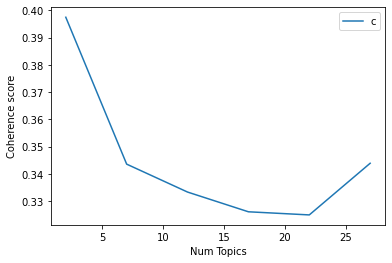

In [96]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score4)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [97]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score4):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics =  2

index: 0 | Num Topics = 2  has Coherence Value of 0.3975
index: 1 | Num Topics = 7  has Coherence Value of 0.3435
index: 2 | Num Topics = 12  has Coherence Value of 0.3333
index: 3 | Num Topics = 17  has Coherence Value of 0.326
index: 4 | Num Topics = 22  has Coherence Value of 0.3249
index: 5 | Num Topics = 27  has Coherence Value of 0.3439


In [191]:
# Select optimal number of topics
optimal_model_us_score4 = model_list_us_score4[0]

In [192]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score4 = pyLDAvis.gensim_models.prepare(optimal_model_us_score4, corpus_us_score4, id2word_us_score4)

In [193]:
print("pyLDAVis for us topics for score=4:")
vis_us_score4

pyLDAVis for us topics for score=4:


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.098844  0.0       1        1  57.057003
0     -0.098844  0.0       2        1  42.942997, topic_info=        Term        Freq       Total Category  logprob  loglift
84      song  159.000000  159.000000  Default  30.0000  30.0000
9      video  181.000000  181.000000  Default  29.0000  29.0000
101     long   50.000000   50.000000  Default  28.0000  28.0000
79     error   29.000000   29.000000  Default  27.0000  27.0000
24      load   29.000000   29.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
9      video   20.745688  181.041907   Topic2  -4.5344  -1.3211
40       add   13.426024   39.880102   Topic2  -4.9696  -0.2434
200   change   10.767312   22.820980   Topic2  -5.1902   0.0941
6    picture   10.993624   31.382543   Topic2  -5.1694  -0.2036
35       put   10.611514   24.539128   Topic2  -5.2048   0.0070

[139 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.828067      able
0         2  0.207017      able
212       1  0.149711  actually
212       2  0.898264  actually
40        1  0.651954       add
...     ...       ...       ...
180       2  0.897530      wifi
92        1  0.912512      wish
92        2  0.099186      wish
20        1  0.451844      work
20        2  0.564805      work

[156 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

## LDA Topic Modelling (Rating = 5)

In [101]:
# By-rating Topic Modelling - rating = 5
# Convert to list - move to each section
review_us_score5 = lomotif_ios_us_review_YearMonth_score5.review.values.tolist()
review_words_us_score5 = list(sent_to_words(review_us_score5))
print(review_words_us_score5[:1])

[['tipycally', 'love', 'this', 'app', 'hope', 'there', 'new', 'features', 'to', 'come', 'happy', 'new', 'year', 'by', 'the', 'way']]


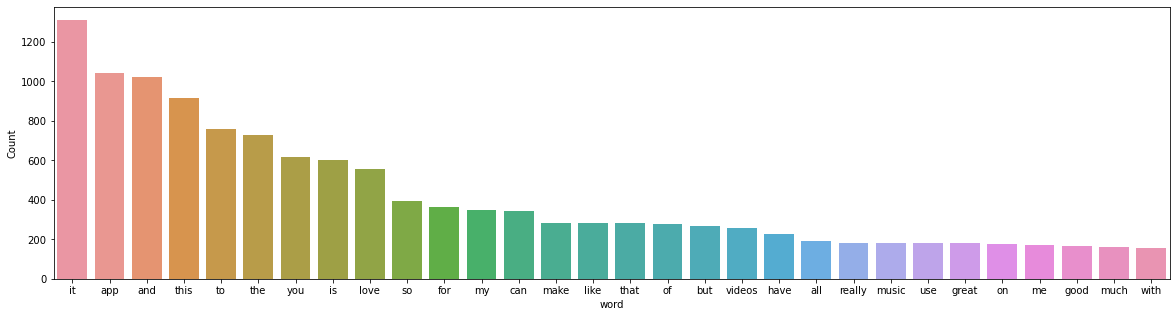

In [102]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score5))

In [103]:
# Clean text
review_us_ready_score5 = process_words(review_words_us_score5)  # processed Text Data! - move to each section

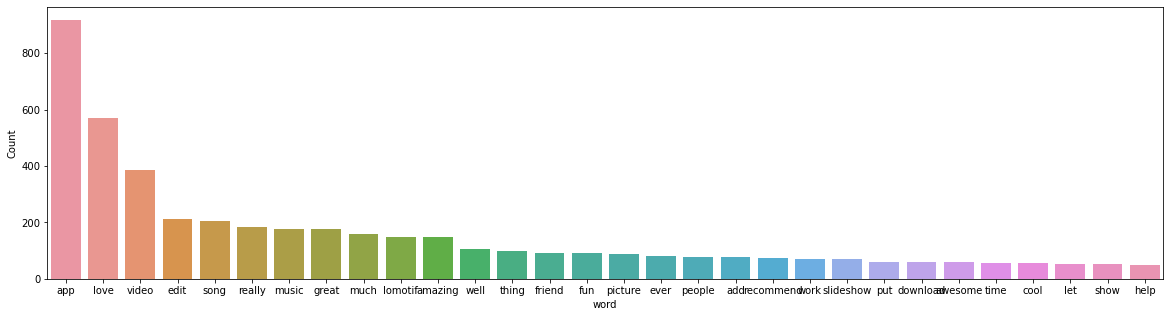

In [104]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score5))


In [105]:
# Create Dictionary
id2word_us_score5 = corpora.Dictionary(review_us_ready_score5)

2021-10-17 02:40:00,188 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 02:40:00,222 [INFO] gensim.corpora.dictionary - built Dictionary(1237 unique tokens: ['app', 'feature', 'happy', 'hope', 'love']...) from 1101 documents (total 9190 corpus positions)
2021-10-17 02:40:00,223 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1237 unique tokens: ['app', 'feature', 'happy', 'hope', 'love']...) from 1101 documents (total 9190 corpus positions)", 'datetime': '2021-10-17T02:40:00.223311', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [106]:
# Create Corpus: Term Document Frequency
corpus_us_score5 = [id2word_us_score5.doc2bow(text) for text in review_us_ready_score5]

In [107]:
# Training LDA model
model_list_us_score5, coherence_values_us_score5 = compute_coherence_values(dictionary=id2word_us_score5, corpus=corpus_us_score5, 
                                                              texts=review_us_ready_score5, limit=30, start=2, step=5)


2021-10-17 02:40:00,256 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 02:40:00,257 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 02:40:00,260 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 02:40:00,262 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 1101 documents, updating model once every 1000 documents, evaluating perplexity every 1101 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 02:40:00,263 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/1101
2021-10-17 02:40:03,855 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:40:03,859 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.067*"app" + 0.044*"love" + 0.031*"edit" + 0.029*"song" + 0.023*"video" + 0.023*"great" + 0.021*"music" + 0.021*"really" + 0.019*"amazing" +

2021-10-17 02:40:12,559 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1101/1101
2021-10-17 02:40:12,612 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:40:12,614 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.034*"app" + 0.025*"lomotif" + 0.024*"song" + 0.021*"great" + 0.021*"well" + 0.019*"music" + 0.013*"create" + 0.013*"people" + 0.011*"way" + 0.010*"love"
2021-10-17 02:40:12,615 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.115*"app" + 0.066*"love" + 0.041*"video" + 0.026*"edit" + 0.023*"much" + 0.020*"really" + 0.016*"great" + 0.014*"ever" + 0.014*"fun" + 0.012*"recommend"
2021-10-17 02:40:12,616 [INFO] gensim.models.ldamodel - topic diff=0.297201, rho=0.404855
2021-10-17 02:40:12,617 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #1000/1101
2021-10-17 02:40:13,807 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02

2021-10-17 02:40:19,060 [INFO] gensim.models.ldamodel - topic diff=0.205681, rho=0.300137
2021-10-17 02:40:19,200 [INFO] gensim.models.ldamodel - -5.681 per-word bound, 51.3 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:40:19,201 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1101/1101
2021-10-17 02:40:19,320 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:40:19,323 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.027*"lomotif" + 0.027*"app" + 0.022*"song" + 0.022*"well" + 0.018*"great" + 0.017*"music" + 0.014*"create" + 0.014*"people" + 0.012*"way" + 0.011*"update"
2021-10-17 02:40:19,325 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.118*"app" + 0.067*"love" + 0.043*"video" + 0.027*"edit" + 0.023*"much" + 0.021*"really" + 0.018*"great" + 0.014*"fun" + 0.014*"ever" + 0.013*"music"
2021-10-17 02:40:19,326 [INFO] gensim.models.ldamodel - topic diff=0.200

2021-10-17 02:40:25,237 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.118*"app" + 0.069*"love" + 0.046*"video" + 0.028*"edit" + 0.022*"much" + 0.022*"really" + 0.019*"great" + 0.016*"music" + 0.015*"amazing" + 0.014*"song"
2021-10-17 02:40:25,238 [INFO] gensim.models.ldamodel - topic diff=0.164754, rho=0.249215
2021-10-17 02:40:25,429 [INFO] gensim.models.ldamodel - -5.670 per-word bound, 50.9 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:40:25,431 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1101/1101
2021-10-17 02:40:25,568 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:40:25,571 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"lomotif" + 0.022*"well" + 0.022*"app" + 0.022*"song" + 0.017*"great" + 0.016*"music" + 0.015*"create" + 0.015*"people" + 0.012*"way" + 0.011*"thing"
2021-10-17 02:40:25,573 [INFO] gensim.models.ldamodel - topic #1 (0.

2021-10-17 02:40:31,329 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"lomotif" + 0.023*"well" + 0.023*"song" + 0.019*"app" + 0.016*"great" + 0.016*"people" + 0.015*"music" + 0.013*"create" + 0.013*"way" + 0.012*"thing"
2021-10-17 02:40:31,330 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.119*"app" + 0.069*"love" + 0.047*"video" + 0.028*"edit" + 0.022*"much" + 0.022*"really" + 0.019*"great" + 0.016*"music" + 0.015*"amazing" + 0.014*"song"
2021-10-17 02:40:31,331 [INFO] gensim.models.ldamodel - topic diff=0.140671, rho=0.217695
2021-10-17 02:40:31,492 [INFO] gensim.models.ldamodel - -5.659 per-word bound, 50.5 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:40:31,494 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1101/1101
2021-10-17 02:40:31,588 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:40:31,604 [INFO] gensim.models.ldamodel - topic #0 (0.

2021-10-17 02:40:36,511 [INFO] gensim.models.ldamodel - topic diff=0.125511, rho=0.199597
2021-10-17 02:40:36,513 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1000/1101
2021-10-17 02:40:37,319 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:40:37,323 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"lomotif" + 0.023*"well" + 0.022*"song" + 0.016*"app" + 0.016*"people" + 0.015*"great" + 0.015*"music" + 0.014*"create" + 0.013*"thing" + 0.013*"way"
2021-10-17 02:40:37,369 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.121*"app" + 0.068*"love" + 0.047*"video" + 0.028*"edit" + 0.022*"much" + 0.022*"really" + 0.020*"great" + 0.016*"music" + 0.015*"amazing" + 0.014*"song"
2021-10-17 02:40:37,401 [INFO] gensim.models.ldamodel - topic diff=0.124425, rho=0.195736
2021-10-17 02:40:37,571 [INFO] gensim.models.ldamodel - -5.652 per-word bound, 50.3 perplexity estimate based on a held-out corpus of 101 do

2021-10-17 02:40:42,250 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.123*"app" + 0.066*"love" + 0.046*"video" + 0.028*"edit" + 0.023*"much" + 0.021*"really" + 0.020*"great" + 0.015*"music" + 0.014*"fun" + 0.014*"amazing"
2021-10-17 02:40:42,252 [INFO] gensim.models.ldamodel - topic diff=0.113458, rho=0.182268
2021-10-17 02:40:42,254 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #1000/1101
2021-10-17 02:40:43,114 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:40:43,118 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"lomotif" + 0.023*"well" + 0.022*"song" + 0.016*"people" + 0.015*"great" + 0.014*"app" + 0.014*"create" + 0.014*"music" + 0.014*"thing" + 0.013*"way"
2021-10-17 02:40:43,124 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.121*"app" + 0.068*"love" + 0.047*"video" + 0.028*"edit" + 0.022*"much" + 0.022*"really" + 0.020*"great" + 0.016*"music" + 0.015*"amazing" + 0.015*"song"
20

2021-10-17 02:40:47,938 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"lomotif" + 0.023*"well" + 0.020*"song" + 0.016*"create" + 0.016*"great" + 0.015*"people" + 0.014*"music" + 0.014*"thing" + 0.013*"app" + 0.013*"way"
2021-10-17 02:40:47,940 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.124*"app" + 0.066*"love" + 0.046*"video" + 0.028*"edit" + 0.022*"much" + 0.021*"really" + 0.020*"great" + 0.016*"music" + 0.014*"amazing" + 0.014*"fun"
2021-10-17 02:40:47,941 [INFO] gensim.models.ldamodel - topic diff=0.104350, rho=0.168787
2021-10-17 02:40:47,943 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #1000/1101
2021-10-17 02:40:48,691 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:40:48,693 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"lomotif" + 0.023*"well" + 0.021*"song" + 0.016*"people" + 0.015*"great" + 0.015*"create" + 0.014*"thing" + 0.014*"music" + 0.013*"way" + 0.013*"app"
2

2021-10-17 02:40:53,443 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1101/1101
2021-10-17 02:40:53,495 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:40:53,497 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"lomotif" + 0.023*"well" + 0.020*"song" + 0.016*"create" + 0.016*"great" + 0.015*"people" + 0.014*"music" + 0.014*"thing" + 0.013*"way" + 0.012*"app"
2021-10-17 02:40:53,500 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.124*"app" + 0.066*"love" + 0.046*"video" + 0.028*"edit" + 0.022*"much" + 0.022*"really" + 0.020*"great" + 0.016*"music" + 0.014*"amazing" + 0.014*"fun"
2021-10-17 02:40:53,502 [INFO] gensim.models.ldamodel - topic diff=0.097087, rho=0.157915
2021-10-17 02:40:53,503 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #1000/1101
2021-10-17 02:40:54,276 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 

2021-10-17 02:40:58,758 [INFO] gensim.models.ldamodel - topic diff=0.091619, rho=0.148904
2021-10-17 02:40:58,881 [INFO] gensim.models.ldamodel - -5.645 per-word bound, 50.0 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:40:58,884 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1101/1101
2021-10-17 02:40:58,957 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:40:58,960 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"lomotif" + 0.023*"well" + 0.020*"song" + 0.016*"create" + 0.016*"great" + 0.015*"people" + 0.014*"thing" + 0.014*"music" + 0.013*"way" + 0.011*"update"
2021-10-17 02:40:58,981 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.125*"app" + 0.065*"love" + 0.046*"video" + 0.028*"edit" + 0.022*"much" + 0.022*"really" + 0.020*"great" + 0.016*"music" + 0.014*"amazing" + 0.014*"song"
2021-10-17 02:40:58,982 [INFO] gensim.models.ldamodel - topic dif

2021-10-17 02:41:04,430 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.124*"app" + 0.066*"love" + 0.047*"video" + 0.028*"edit" + 0.022*"really" + 0.022*"much" + 0.020*"great" + 0.016*"music" + 0.015*"amazing" + 0.015*"song"
2021-10-17 02:41:04,431 [INFO] gensim.models.ldamodel - topic diff=0.086502, rho=0.141279
2021-10-17 02:41:04,514 [INFO] gensim.models.ldamodel - -5.644 per-word bound, 50.0 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:41:04,515 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #1101/1101
2021-10-17 02:41:04,576 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:41:04,578 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"lomotif" + 0.023*"well" + 0.020*"song" + 0.016*"create" + 0.016*"great" + 0.016*"people" + 0.014*"thing" + 0.014*"music" + 0.013*"way" + 0.011*"update"
2021-10-17 02:41:04,580 [INFO] gensim.models.ldamodel - topic #1 

2021-10-17 02:41:14,467 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.076*"app" + 0.042*"love" + 0.030*"music" + 0.023*"lomotif" + 0.021*"tiktok" + 0.020*"video" + 0.020*"great" + 0.019*"people" + 0.018*"look" + 0.017*"transition"
2021-10-17 02:41:14,468 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.043*"video" + 0.028*"app" + 0.021*"update" + 0.021*"really" + 0.021*"time" + 0.021*"song" + 0.020*"long" + 0.017*"play" + 0.015*"second" + 0.015*"edit"
2021-10-17 02:41:14,469 [INFO] gensim.models.ldamodel - topic diff=0.438065, rho=0.567870
2021-10-17 02:41:14,595 [INFO] gensim.models.ldamodel - -6.182 per-word bound, 72.6 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:41:14,596 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #1101/1101
2021-10-17 02:41:14,694 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:41:14,697 [INFO] gensim.models.ldamodel - topic #

2021-10-17 02:41:17,577 [INFO] gensim.models.ldamodel - topic diff=0.289216, rho=0.442764
2021-10-17 02:41:17,578 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1000/1101
2021-10-17 02:41:18,498 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:41:18,501 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.070*"music" + 0.030*"add" + 0.028*"great" + 0.023*"song" + 0.021*"clip" + 0.021*"start" + 0.021*"way" + 0.016*"people" + 0.015*"choice" + 0.015*"well"
2021-10-17 02:41:18,505 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.152*"app" + 0.074*"love" + 0.047*"video" + 0.033*"edit" + 0.028*"great" + 0.024*"much" + 0.022*"amazing" + 0.022*"really" + 0.019*"ever" + 0.015*"picture"
2021-10-17 02:41:18,508 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.070*"app" + 0.042*"love" + 0.027*"lomotif" + 0.026*"music" + 0.025*"tiktok" + 0.021*"look" + 0.020*"great" + 0.020*"create" + 0.019*"transition" + 0.019*"pe

2021-10-17 02:41:21,443 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.156*"app" + 0.076*"love" + 0.045*"video" + 0.032*"great" + 0.028*"edit" + 0.026*"much" + 0.021*"really" + 0.021*"ever" + 0.019*"amazing" + 0.016*"recommend"
2021-10-17 02:41:21,444 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.049*"video" + 0.034*"thing" + 0.034*"user" + 0.032*"love" + 0.031*"app" + 0.023*"great" + 0.020*"time" + 0.019*"edit" + 0.019*"well" + 0.017*"help"
2021-10-17 02:41:21,445 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.075*"app" + 0.041*"love" + 0.031*"tiktok" + 0.030*"lomotif" + 0.025*"create" + 0.023*"great" + 0.021*"look" + 0.020*"transition" + 0.020*"allow" + 0.019*"choose"
2021-10-17 02:41:21,446 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.071*"music" + 0.024*"add" + 0.022*"start" + 0.021*"clip" + 0.021*"way" + 0.019*"well" + 0.019*"people" + 0.018*"song" + 0.018*"great" + 0.017*"excited"
2021-10-17 02:41:21,447 [INFO] gensim.models.ldamodel - topic diff=0.192173, 

2021-10-17 02:41:24,842 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.071*"app" + 0.043*"love" + 0.030*"lomotif" + 0.026*"tiktok" + 0.022*"great" + 0.022*"look" + 0.021*"allow" + 0.021*"music" + 0.020*"create" + 0.020*"choose"
2021-10-17 02:41:24,844 [INFO] gensim.models.ldamodel - topic diff=0.153528, rho=0.300137
2021-10-17 02:41:25,013 [INFO] gensim.models.ldamodel - -5.746 per-word bound, 53.7 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:41:25,018 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1101/1101
2021-10-17 02:41:25,103 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:41:25,121 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.155*"app" + 0.079*"love" + 0.047*"video" + 0.032*"great" + 0.028*"edit" + 0.026*"much" + 0.022*"really" + 0.020*"ever" + 0.019*"amazing" + 0.015*"recommend"
2021-10-17 02:41:25,143 [INFO] gensim.models.ldamodel - topic 

2021-10-17 02:41:28,484 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:41:28,487 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.052*"lomotif" + 0.051*"song" + 0.035*"tok" + 0.034*"fun" + 0.031*"awesome" + 0.031*"really" + 0.027*"long" + 0.026*"let" + 0.022*"vid" + 0.017*"tik"
2021-10-17 02:41:28,489 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.151*"app" + 0.082*"love" + 0.051*"video" + 0.031*"edit" + 0.030*"great" + 0.026*"much" + 0.023*"really" + 0.021*"amazing" + 0.018*"ever" + 0.014*"recommend"
2021-10-17 02:41:28,491 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.051*"video" + 0.027*"update" + 0.027*"second" + 0.024*"time" + 0.021*"music" + 0.020*"lomotif" + 0.019*"picture" + 0.019*"song" + 0.016*"artist" + 0.015*"long"
2021-10-17 02:41:28,493 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.060*"app" + 0.041*"love" + 0.032*"song" + 0.027*"post" + 0.023*"much" + 0.021*"find" + 0.019*"wish" + 0.019

2021-10-17 02:41:31,080 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.153*"app" + 0.081*"love" + 0.048*"video" + 0.032*"great" + 0.029*"edit" + 0.026*"much" + 0.022*"really" + 0.020*"amazing" + 0.020*"ever" + 0.015*"recommend"
2021-10-17 02:41:31,082 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.064*"app" + 0.039*"love" + 0.027*"song" + 0.027*"post" + 0.026*"much" + 0.022*"find" + 0.019*"wish" + 0.018*"edit" + 0.017*"thing" + 0.015*"delete"
2021-10-17 02:41:31,084 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.043*"thing" + 0.042*"video" + 0.035*"user" + 0.028*"great" + 0.023*"edit" + 0.022*"app" + 0.021*"lomotif" + 0.018*"help" + 0.015*"well" + 0.015*"medium"
2021-10-17 02:41:31,086 [INFO] gensim.models.ldamodel - topic diff=0.120774, rho=0.249215
2021-10-17 02:41:31,087 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #1000/1101
2021-10-17 02:41:32,009 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
202

2021-10-17 02:41:34,369 [INFO] gensim.models.ldamodel - topic diff=0.109041, rho=0.228808
2021-10-17 02:41:34,485 [INFO] gensim.models.ldamodel - -5.705 per-word bound, 52.2 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:41:34,487 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #1101/1101
2021-10-17 02:41:34,539 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:41:34,542 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.153*"app" + 0.082*"love" + 0.049*"video" + 0.032*"great" + 0.029*"edit" + 0.026*"much" + 0.022*"really" + 0.020*"amazing" + 0.019*"ever" + 0.015*"recommend"
2021-10-17 02:41:34,544 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.073*"app" + 0.044*"love" + 0.032*"lomotif" + 0.031*"tiktok" + 0.024*"great" + 0.024*"create" + 0.023*"well" + 0.022*"look" + 0.022*"allow" + 0.022*"choose"
2021-10-17 02:41:34,545 [INFO] gensim.models.ldamodel - topic 

2021-10-17 02:41:37,757 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.060*"app" + 0.040*"love" + 0.030*"song" + 0.027*"post" + 0.024*"much" + 0.021*"find" + 0.021*"wish" + 0.019*"thing" + 0.017*"guy" + 0.016*"edit"
2021-10-17 02:41:37,759 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.044*"thing" + 0.042*"video" + 0.032*"user" + 0.027*"great" + 0.024*"lomotif" + 0.021*"edit" + 0.020*"app" + 0.017*"help" + 0.015*"well" + 0.014*"medium"
2021-10-17 02:41:37,761 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.070*"app" + 0.044*"love" + 0.031*"lomotif" + 0.028*"tiktok" + 0.023*"great" + 0.023*"look" + 0.023*"well" + 0.023*"allow" + 0.023*"choose" + 0.021*"create"
2021-10-17 02:41:37,762 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.150*"app" + 0.084*"love" + 0.051*"video" + 0.031*"great" + 0.030*"edit" + 0.026*"much" + 0.023*"really" + 0.021*"amazing" + 0.018*"ever" + 0.014*"music"
2021-10-17 02:41:37,763 [INFO] gensim.models.ldamodel - topic diff=0.100101, rho=0.212713

2021-10-17 02:41:40,239 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.044*"thing" + 0.039*"video" + 0.035*"user" + 0.030*"great" + 0.024*"lomotif" + 0.023*"edit" + 0.021*"app" + 0.017*"help" + 0.015*"medium" + 0.015*"social"
2021-10-17 02:41:40,240 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.072*"app" + 0.045*"love" + 0.032*"lomotif" + 0.031*"tiktok" + 0.024*"great" + 0.024*"create" + 0.024*"well" + 0.023*"look" + 0.022*"choose" + 0.022*"allow"
2021-10-17 02:41:40,241 [INFO] gensim.models.ldamodel - topic diff=0.094513, rho=0.203696
2021-10-17 02:41:40,243 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1000/1101
2021-10-17 02:41:41,118 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:41:41,122 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.150*"app" + 0.084*"love" + 0.051*"video" + 0.031*"great" + 0.030*"edit" + 0.026*"much" + 0.023*"really" + 0.021*"amazing" + 0.018*"ever" + 0.014*"musi

2021-10-17 02:41:43,779 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #1101/1101
2021-10-17 02:41:43,823 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:41:43,825 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.052*"lomotif" + 0.050*"song" + 0.040*"tok" + 0.037*"fun" + 0.032*"awesome" + 0.029*"really" + 0.027*"long" + 0.023*"let" + 0.021*"vid" + 0.020*"tik"
2021-10-17 02:41:43,827 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.153*"app" + 0.083*"love" + 0.049*"video" + 0.032*"great" + 0.029*"edit" + 0.026*"much" + 0.022*"really" + 0.020*"amazing" + 0.019*"ever" + 0.015*"recommend"
2021-10-17 02:41:43,829 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.069*"music" + 0.024*"much" + 0.023*"start" + 0.021*"clip" + 0.021*"way" + 0.021*"add" + 0.021*"well" + 0.018*"people" + 0.016*"excited" + 0.015*"pic"
2021-10-17 02:41:43,831 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.063*"app" + 0.040*"l

2021-10-17 02:41:47,134 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.070*"app" + 0.045*"love" + 0.032*"lomotif" + 0.028*"tiktok" + 0.023*"look" + 0.023*"great" + 0.023*"well" + 0.023*"choose" + 0.023*"allow" + 0.022*"create"
2021-10-17 02:41:47,140 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.069*"music" + 0.023*"start" + 0.023*"much" + 0.023*"add" + 0.022*"clip" + 0.021*"way" + 0.019*"well" + 0.017*"people" + 0.017*"pic" + 0.015*"excited"
2021-10-17 02:41:47,144 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.053*"lomotif" + 0.052*"song" + 0.036*"tok" + 0.035*"fun" + 0.032*"awesome" + 0.030*"really" + 0.027*"long" + 0.025*"let" + 0.022*"vid" + 0.018*"tik"
2021-10-17 02:41:47,147 [INFO] gensim.models.ldamodel - topic diff=0.083536, rho=0.182268
2021-10-17 02:41:47,221 [INFO] gensim.models.ldamodel - -5.689 per-word bound, 51.6 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:41:47,222 [INFO] gensim.models.ldamodel - PROGRESS

2021-10-17 02:41:49,684 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.045*"thing" + 0.038*"video" + 0.035*"user" + 0.032*"great" + 0.024*"lomotif" + 0.022*"edit" + 0.021*"app" + 0.020*"new" + 0.017*"help" + 0.015*"medium"
2021-10-17 02:41:49,685 [INFO] gensim.models.ldamodel - topic diff=0.080122, rho=0.176498
2021-10-17 02:41:49,691 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #1000/1101
2021-10-17 02:41:50,500 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:41:50,503 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.044*"thing" + 0.039*"video" + 0.032*"user" + 0.031*"great" + 0.024*"lomotif" + 0.021*"edit" + 0.021*"new" + 0.020*"app" + 0.017*"help" + 0.015*"well"
2021-10-17 02:41:50,505 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.150*"app" + 0.084*"love" + 0.051*"video" + 0.030*"great" + 0.030*"edit" + 0.026*"much" + 0.023*"really" + 0.021*"amazing" + 0.018*"ever" + 0.015*"music"
2021-1

2021-10-17 02:41:52,918 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.072*"app" + 0.046*"love" + 0.032*"lomotif" + 0.031*"tiktok" + 0.024*"great" + 0.024*"create" + 0.024*"well" + 0.023*"look" + 0.023*"choose" + 0.022*"allow"
2021-10-17 02:41:52,920 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.051*"video" + 0.043*"time" + 0.027*"update" + 0.024*"second" + 0.024*"music" + 0.022*"lomotif" + 0.021*"picture" + 0.018*"song" + 0.017*"app" + 0.016*"artist"
2021-10-17 02:41:52,922 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.069*"music" + 0.024*"much" + 0.023*"start" + 0.021*"clip" + 0.021*"add" + 0.021*"way" + 0.021*"well" + 0.019*"people" + 0.016*"excited" + 0.015*"enft"
2021-10-17 02:41:52,924 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.063*"app" + 0.040*"love" + 0.027*"post" + 0.026*"much" + 0.024*"song" + 0.023*"find" + 0.021*"wish" + 0.018*"edit" + 0.018*"thing" + 0.017*"guy"
2021-10-17 02:41:52,926 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.152*"app"

2021-10-17 02:41:56,184 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.053*"lomotif" + 0.052*"song" + 0.036*"tok" + 0.035*"fun" + 0.031*"awesome" + 0.029*"really" + 0.027*"long" + 0.025*"let" + 0.022*"vid" + 0.018*"tik"
2021-10-17 02:41:56,187 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.054*"video" + 0.044*"time" + 0.027*"update" + 0.025*"second" + 0.023*"music" + 0.021*"lomotif" + 0.020*"picture" + 0.018*"song" + 0.016*"app" + 0.015*"artist"
2021-10-17 02:41:56,188 [INFO] gensim.models.ldamodel - topic diff=0.072933, rho=0.162006
2021-10-17 02:41:56,323 [INFO] gensim.models.ldamodel - -5.679 per-word bound, 51.2 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:41:56,324 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #1101/1101
2021-10-17 02:41:56,449 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:41:56,452 [INFO] gensim.models.ldamodel - topic #3 (0

2021-10-17 02:41:58,868 [INFO] gensim.models.ldamodel - topic diff=0.070726, rho=0.157915
2021-10-17 02:41:58,872 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #1000/1101
2021-10-17 02:41:59,665 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:41:59,669 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.151*"app" + 0.084*"love" + 0.051*"video" + 0.030*"great" + 0.030*"edit" + 0.025*"much" + 0.023*"really" + 0.021*"amazing" + 0.018*"ever" + 0.015*"music"
2021-10-17 02:41:59,671 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.054*"video" + 0.044*"time" + 0.027*"update" + 0.025*"second" + 0.023*"music" + 0.021*"lomotif" + 0.020*"picture" + 0.018*"song" + 0.017*"app" + 0.015*"artist"
2021-10-17 02:41:59,674 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.061*"app" + 0.042*"love" + 0.028*"post" + 0.027*"song" + 0.025*"much" + 0.022*"find" + 0.021*"wish" + 0.021*"guy" + 0.018*"thing" + 0.016*"edit"
2021

2021-10-17 02:42:02,309 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.052*"lomotif" + 0.050*"song" + 0.040*"tok" + 0.037*"fun" + 0.032*"awesome" + 0.028*"really" + 0.027*"long" + 0.023*"let" + 0.021*"vid" + 0.020*"tik"
2021-10-17 02:42:02,310 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.152*"app" + 0.083*"love" + 0.050*"video" + 0.031*"great" + 0.029*"edit" + 0.026*"much" + 0.023*"really" + 0.020*"amazing" + 0.019*"ever" + 0.015*"recommend"
2021-10-17 02:42:02,311 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.063*"app" + 0.040*"love" + 0.027*"post" + 0.026*"much" + 0.024*"song" + 0.023*"find" + 0.020*"wish" + 0.019*"guy" + 0.018*"edit" + 0.017*"thing"
2021-10-17 02:42:02,312 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.046*"thing" + 0.038*"video" + 0.035*"user" + 0.034*"great" + 0.024*"lomotif" + 0.022*"edit" + 0.021*"new" + 0.021*"app" + 0.017*"help" + 0.015*"medium"
2021-10-17 02:42:02,313 [INFO] gensim.models.ldamodel - topic diff=0.067783, rho=0.152320
202

2021-10-17 02:42:05,535 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.053*"video" + 0.044*"time" + 0.027*"update" + 0.025*"second" + 0.023*"music" + 0.021*"lomotif" + 0.020*"picture" + 0.018*"song" + 0.017*"app" + 0.015*"artist"
2021-10-17 02:42:05,539 [INFO] gensim.models.ldamodel - topic diff=0.065698, rho=0.147280
2021-10-17 02:42:05,684 [INFO] gensim.models.ldamodel - -5.671 per-word bound, 50.9 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:42:05,685 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #1101/1101
2021-10-17 02:42:05,723 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:42:05,726 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.152*"app" + 0.083*"love" + 0.050*"video" + 0.031*"great" + 0.029*"edit" + 0.026*"much" + 0.023*"really" + 0.020*"amazing" + 0.019*"ever" + 0.015*"recommend"
2021-10-17 02:42:05,727 [INFO] gensim.models.ldamodel - top

2021-10-17 02:42:08,950 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.061*"app" + 0.042*"love" + 0.028*"post" + 0.027*"song" + 0.024*"much" + 0.022*"find" + 0.022*"guy" + 0.021*"wish" + 0.018*"thing" + 0.017*"edit"
2021-10-17 02:42:08,951 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.045*"thing" + 0.039*"video" + 0.034*"great" + 0.032*"user" + 0.024*"lomotif" + 0.023*"new" + 0.021*"edit" + 0.020*"app" + 0.017*"help" + 0.015*"stuff"
2021-10-17 02:42:08,954 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.069*"app" + 0.047*"love" + 0.032*"lomotif" + 0.028*"tiktok" + 0.024*"choose" + 0.024*"great" + 0.024*"well" + 0.023*"look" + 0.023*"allow" + 0.022*"create"
2021-10-17 02:42:08,956 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.069*"music" + 0.024*"add" + 0.023*"start" + 0.023*"much" + 0.022*"clip" + 0.021*"way" + 0.020*"well" + 0.018*"people" + 0.016*"pic" + 0.015*"excited"
2021-10-17 02:42:08,959 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.151*"app" + 0.084*

2021-10-17 02:42:11,491 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.063*"app" + 0.041*"love" + 0.027*"post" + 0.026*"much" + 0.024*"song" + 0.022*"find" + 0.020*"wish" + 0.020*"guy" + 0.018*"edit" + 0.017*"thing"
2021-10-17 02:42:11,492 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.152*"app" + 0.083*"love" + 0.050*"video" + 0.031*"great" + 0.029*"edit" + 0.026*"much" + 0.023*"really" + 0.020*"amazing" + 0.019*"ever" + 0.015*"recommend"
2021-10-17 02:42:11,494 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.046*"thing" + 0.038*"video" + 0.035*"great" + 0.034*"user" + 0.024*"lomotif" + 0.022*"edit" + 0.022*"new" + 0.021*"app" + 0.017*"help" + 0.015*"medium"
2021-10-17 02:42:11,495 [INFO] gensim.models.ldamodel - topic diff=0.061807, rho=0.139890
2021-10-17 02:42:11,496 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=1237, num_topics=7, decay=0.5, chunksize=1000) in 60.65s', 'datetime': '2021-10-17T02:42:11.496786', 'gensim': '4.1.2', '

2021-10-17 02:42:20,848 [INFO] gensim.models.ldamodel - topic diff=0.525547, rho=0.567870
2021-10-17 02:42:20,850 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #1000/1101
2021-10-17 02:42:21,973 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:42:21,978 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.126*"app" + 0.044*"video" + 0.043*"edit" + 0.040*"love" + 0.036*"really" + 0.031*"fun" + 0.028*"lomotif" + 0.026*"much" + 0.024*"great" + 0.018*"picture"
2021-10-17 02:42:21,996 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.053*"lomotif" + 0.051*"song" + 0.039*"app" + 0.038*"love" + 0.034*"awesome" + 0.034*"long" + 0.030*"amazing" + 0.027*"really" + 0.024*"tok" + 0.023*"work"
2021-10-17 02:42:22,001 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.175*"music" + 0.090*"add" + 0.032*"close" + 0.019*"great" + 0.019*"song" + 0.018*"video" + 0.016*"short" + 0.015*"library" + 0.015*"love" + 0.014*"lil"


2021-10-17 02:42:24,871 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.059*"review" + 0.041*"stuff" + 0.039*"worth" + 0.039*"bad" + 0.037*"write" + 0.036*"love" + 0.029*"people" + 0.029*"highly" + 0.024*"day" + 0.023*"recommend"
2021-10-17 02:42:24,876 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.150*"app" + 0.092*"love" + 0.037*"video" + 0.033*"much" + 0.030*"edit" + 0.026*"ever" + 0.019*"amazing" + 0.018*"let" + 0.014*"create" + 0.012*"really"
2021-10-17 02:42:24,879 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.108*"post" + 0.058*"play" + 0.042*"year" + 0.037*"app" + 0.036*"song" + 0.029*"wish" + 0.029*"last" + 0.028*"feel" + 0.026*"famous" + 0.025*"next"
2021-10-17 02:42:24,883 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.181*"music" + 0.077*"add" + 0.042*"close" + 0.036*"universal" + 0.027*"video" + 0.023*"short" + 0.021*"library" + 0.019*"different" + 0.018*"lomo" + 0.018*"group"
2021-10-17 02:42:24,886 [INFO] gensim.models.ldamodel - topic diff=0.197282,

2021-10-17 02:42:28,389 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.042*"app" + 0.028*"minute" + 0.027*"fast" + 0.026*"one" + 0.025*"lomotif" + 0.023*"download" + 0.023*"thing" + 0.022*"great" + 0.021*"stuff" + 0.017*"quality"
2021-10-17 02:42:28,392 [INFO] gensim.models.ldamodel - topic diff=0.132903, rho=0.331479
2021-10-17 02:42:28,544 [INFO] gensim.models.ldamodel - -5.789 per-word bound, 55.3 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:42:28,548 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #1101/1101
2021-10-17 02:42:28,595 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:42:28,599 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.065*"time" + 0.039*"well" + 0.039*"choose" + 0.033*"cause" + 0.033*"ever" + 0.032*"clip" + 0.030*"game" + 0.028*"pay" + 0.026*"hear" + 0.025*"shuffle"
2021-10-17 02:42:28,600 [INFO] gensim.models.ldamodel - topic #6 (

2021-10-17 02:42:32,025 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:42:32,029 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.120*"app" + 0.057*"video" + 0.046*"edit" + 0.044*"love" + 0.041*"really" + 0.032*"fun" + 0.028*"great" + 0.027*"lomotif" + 0.022*"picture" + 0.019*"much"
2021-10-17 02:42:32,031 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.112*"post" + 0.051*"play" + 0.046*"year" + 0.041*"song" + 0.032*"app" + 0.028*"error" + 0.026*"wish" + 0.025*"last" + 0.023*"update" + 0.022*"feel"
2021-10-17 02:42:32,034 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.045*"love" + 0.044*"perfect" + 0.042*"user" + 0.042*"account" + 0.034*"content" + 0.033*"music" + 0.030*"live" + 0.021*"solid" + 0.020*"great" + 0.020*"enft"
2021-10-17 02:42:32,036 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.153*"app" + 0.104*"love" + 0.042*"video" + 0.032*"edit" + 0.031*"much" + 0.029*"amazing" + 0.024*"ever" + 0.019*

2021-10-17 02:42:34,852 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.099*"app" + 0.052*"love" + 0.045*"great" + 0.040*"much" + 0.035*"song" + 0.029*"find" + 0.028*"thing" + 0.027*"video" + 0.027*"new" + 0.026*"give"
2021-10-17 02:42:34,853 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.229*"music" + 0.074*"add" + 0.040*"video" + 0.036*"close" + 0.031*"universal" + 0.021*"different" + 0.021*"short" + 0.018*"library" + 0.017*"look" + 0.016*"lomo"
2021-10-17 02:42:34,856 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.118*"app" + 0.057*"video" + 0.045*"edit" + 0.041*"love" + 0.039*"really" + 0.033*"fun" + 0.029*"lomotif" + 0.027*"great" + 0.021*"picture" + 0.020*"update"
2021-10-17 02:42:34,858 [INFO] gensim.models.ldamodel - topic diff=0.091152, rho=0.266302
2021-10-17 02:42:34,860 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #1000/1101
2021-10-17 02:42:35,850 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 docum

2021-10-17 02:42:38,311 [INFO] gensim.models.ldamodel - topic diff=0.081906, rho=0.241818
2021-10-17 02:42:38,449 [INFO] gensim.models.ldamodel - -5.739 per-word bound, 53.4 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:42:38,450 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #1101/1101
2021-10-17 02:42:38,525 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:42:38,530 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.152*"app" + 0.101*"love" + 0.040*"video" + 0.032*"much" + 0.031*"edit" + 0.026*"amazing" + 0.024*"ever" + 0.019*"let" + 0.014*"friend" + 0.013*"slideshow"
2021-10-17 02:42:38,531 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.111*"post" + 0.057*"play" + 0.043*"year" + 0.041*"song" + 0.037*"app" + 0.031*"wish" + 0.028*"last" + 0.026*"feel" + 0.025*"famous" + 0.024*"update"
2021-10-17 02:42:38,534 [INFO] gensim.models.ldamodel - topic #1 (0.083

2021-10-17 02:42:41,986 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.266*"music" + 0.080*"add" + 0.043*"video" + 0.030*"close" + 0.023*"universal" + 0.020*"different" + 0.018*"short" + 0.015*"look" + 0.014*"library" + 0.013*"lil"
2021-10-17 02:42:41,987 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.097*"app" + 0.056*"love" + 0.042*"great" + 0.039*"song" + 0.038*"much" + 0.030*"thing" + 0.029*"find" + 0.029*"video" + 0.028*"new" + 0.024*"give"
2021-10-17 02:42:41,990 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.079*"song" + 0.055*"lomotif" + 0.050*"awesome" + 0.043*"work" + 0.038*"long" + 0.030*"tok" + 0.027*"vid" + 0.026*"well" + 0.024*"way" + 0.022*"tik"
2021-10-17 02:42:41,994 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.153*"app" + 0.105*"love" + 0.043*"video" + 0.032*"edit" + 0.031*"much" + 0.030*"amazing" + 0.023*"ever" + 0.019*"let" + 0.017*"friend" + 0.015*"slideshow"
2021-10-17 02:42:41,995 [INFO] gensim.models.ldamodel - topic diff=0.073727, rho=0.22

2021-10-17 02:42:44,607 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.117*"app" + 0.059*"video" + 0.045*"edit" + 0.041*"really" + 0.039*"love" + 0.031*"fun" + 0.029*"great" + 0.027*"lomotif" + 0.022*"picture" + 0.021*"update"
2021-10-17 02:42:44,610 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.049*"user" + 0.046*"love" + 0.041*"perfect" + 0.039*"account" + 0.039*"content" + 0.033*"music" + 0.026*"live" + 0.025*"solid" + 0.024*"enft" + 0.024*"lomo"
2021-10-17 02:42:44,613 [INFO] gensim.models.ldamodel - topic diff=0.069295, rho=0.212713
2021-10-17 02:42:44,615 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #1000/1101
2021-10-17 02:42:45,518 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:42:45,523 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.044*"perfect" + 0.044*"user" + 0.043*"love" + 0.042*"account" + 0.035*"content" + 0.033*"music" + 0.030*"live" + 0.022*"solid" + 0.021*"enft" + 0.0

2021-10-17 02:42:48,247 [INFO] gensim.models.ldamodel - -5.724 per-word bound, 52.9 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:42:48,250 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1101/1101
2021-10-17 02:42:48,317 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:42:48,320 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.122*"app" + 0.053*"recommend" + 0.042*"love" + 0.034*"great" + 0.032*"lomotif" + 0.031*"video" + 0.030*"cool" + 0.030*"transition" + 0.028*"definitely" + 0.026*"help"
2021-10-17 02:42:48,322 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.154*"app" + 0.104*"love" + 0.044*"video" + 0.034*"much" + 0.031*"edit" + 0.027*"amazing" + 0.024*"ever" + 0.018*"let" + 0.015*"friend" + 0.014*"slideshow"
2021-10-17 02:42:48,324 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.103*"app" + 0.054*"love" + 0.044*"great" + 0.042*"much" + 0.035*"so

2021-10-17 02:42:51,731 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.116*"app" + 0.061*"video" + 0.046*"edit" + 0.044*"really" + 0.039*"love" + 0.030*"fun" + 0.029*"great" + 0.026*"lomotif" + 0.023*"picture" + 0.020*"song"
2021-10-17 02:42:51,733 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.044*"love" + 0.044*"perfect" + 0.044*"user" + 0.042*"account" + 0.035*"content" + 0.034*"music" + 0.030*"live" + 0.022*"solid" + 0.021*"lomo" + 0.021*"enft"
2021-10-17 02:42:51,736 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.099*"app" + 0.056*"love" + 0.042*"great" + 0.039*"much" + 0.038*"song" + 0.030*"thing" + 0.029*"find" + 0.028*"video" + 0.027*"new" + 0.024*"give"
2021-10-17 02:42:51,738 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.092*"time" + 0.039*"well" + 0.037*"choose" + 0.033*"cause" + 0.031*"ever" + 0.031*"clip" + 0.028*"game" + 0.025*"fun" + 0.025*"pay" + 0.024*"hope"
2021-10-17 02:42:51,739 [INFO] gensim.models.ldamodel - topic diff=0.060365, rho=0.188642


2021-10-17 02:42:54,312 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.111*"post" + 0.056*"play" + 0.044*"year" + 0.041*"song" + 0.036*"app" + 0.028*"last" + 0.027*"wish" + 0.026*"famous" + 0.025*"feel" + 0.023*"next"
2021-10-17 02:42:54,313 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.076*"song" + 0.055*"lomotif" + 0.054*"awesome" + 0.041*"work" + 0.037*"long" + 0.034*"tok" + 0.030*"well" + 0.027*"vid" + 0.025*"tik" + 0.024*"way"
2021-10-17 02:42:54,315 [INFO] gensim.models.ldamodel - topic diff=0.057379, rho=0.182268
2021-10-17 02:42:54,315 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #1000/1101
2021-10-17 02:42:55,171 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:42:55,184 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.100*"app" + 0.056*"love" + 0.042*"great" + 0.039*"song" + 0.038*"much" + 0.030*"thing" + 0.029*"find" + 0.029*"video" + 0.027*"new" + 0.024*"give"
2021-10-17 02:42:55

2021-10-17 02:42:57,828 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #1101/1101
2021-10-17 02:42:57,874 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:42:57,878 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.099*"time" + 0.040*"well" + 0.037*"choose" + 0.032*"cause" + 0.032*"ever" + 0.031*"clip" + 0.029*"game" + 0.027*"fun" + 0.026*"pay" + 0.024*"hear"
2021-10-17 02:42:57,880 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.155*"app" + 0.105*"love" + 0.045*"video" + 0.035*"much" + 0.031*"edit" + 0.027*"amazing" + 0.023*"ever" + 0.018*"let" + 0.016*"friend" + 0.014*"slideshow"
2021-10-17 02:42:57,882 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.048*"user" + 0.048*"love" + 0.041*"perfect" + 0.039*"account" + 0.038*"content" + 0.033*"music" + 0.026*"live" + 0.025*"solid" + 0.024*"lomo" + 0.024*"enft"
2021-10-17 02:42:57,884 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.043*"app" + 0.030

2021-10-17 02:43:01,282 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.155*"app" + 0.107*"love" + 0.047*"video" + 0.034*"much" + 0.032*"edit" + 0.029*"amazing" + 0.022*"ever" + 0.019*"friend" + 0.018*"let" + 0.015*"slideshow"
2021-10-17 02:43:01,287 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.102*"time" + 0.039*"well" + 0.037*"choose" + 0.033*"cause" + 0.031*"ever" + 0.030*"clip" + 0.028*"game" + 0.026*"fun" + 0.025*"pay" + 0.025*"hope"
2021-10-17 02:43:01,291 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.042*"app" + 0.030*"minute" + 0.029*"fast" + 0.028*"one" + 0.027*"lomotif" + 0.025*"thing" + 0.024*"great" + 0.023*"stuff" + 0.022*"download" + 0.018*"quality"
2021-10-17 02:43:01,296 [INFO] gensim.models.ldamodel - topic diff=0.051788, rho=0.166433
2021-10-17 02:43:01,449 [INFO] gensim.models.ldamodel - -5.712 per-word bound, 52.4 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:43:01,453 [INFO] gensim.models.ldamodel - PR

2021-10-17 02:43:03,806 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.057*"review" + 0.051*"stuff" + 0.039*"bad" + 0.037*"worth" + 0.035*"write" + 0.033*"love" + 0.031*"highly" + 0.026*"people" + 0.024*"thing" + 0.023*"recommend"
2021-10-17 02:43:03,808 [INFO] gensim.models.ldamodel - topic diff=0.050133, rho=0.162006
2021-10-17 02:43:03,813 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #1000/1101
2021-10-17 02:43:04,737 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:43:04,741 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.103*"time" + 0.039*"well" + 0.037*"choose" + 0.033*"cause" + 0.031*"ever" + 0.030*"clip" + 0.028*"game" + 0.026*"fun" + 0.025*"hope" + 0.025*"pay"
2021-10-17 02:43:04,743 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.047*"love" + 0.044*"user" + 0.044*"perfect" + 0.041*"account" + 0.036*"content" + 0.034*"music" + 0.030*"live" + 0.023*"solid" + 0.021*"lomo" + 0.021*"enf

2021-10-17 02:43:07,340 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:43:07,347 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.110*"post" + 0.056*"play" + 0.044*"year" + 0.042*"song" + 0.036*"app" + 0.028*"last" + 0.026*"famous" + 0.026*"wish" + 0.025*"feel" + 0.023*"error"
2021-10-17 02:43:07,352 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.043*"app" + 0.030*"minute" + 0.029*"one" + 0.028*"lomotif" + 0.027*"fast" + 0.027*"great" + 0.024*"thing" + 0.022*"stuff" + 0.021*"download" + 0.020*"search"
2021-10-17 02:43:07,355 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.065*"well" + 0.053*"tiktok" + 0.051*"create" + 0.048*"way" + 0.039*"start" + 0.033*"people" + 0.023*"soon" + 0.020*"future" + 0.017*"option" + 0.016*"video"
2021-10-17 02:43:07,370 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.075*"song" + 0.055*"awesome" + 0.054*"lomotif" + 0.042*"work" + 0.037*"long" + 0.034*"tok" + 0.031*"well" + 0.

2021-10-17 02:43:10,623 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.155*"app" + 0.107*"love" + 0.047*"video" + 0.034*"much" + 0.032*"edit" + 0.029*"amazing" + 0.022*"ever" + 0.020*"friend" + 0.018*"let" + 0.015*"slideshow"
2021-10-17 02:43:10,626 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.103*"app" + 0.057*"love" + 0.040*"great" + 0.038*"much" + 0.037*"song" + 0.030*"video" + 0.030*"thing" + 0.028*"find" + 0.027*"new" + 0.024*"give"
2021-10-17 02:43:10,629 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.128*"app" + 0.050*"recommend" + 0.045*"love" + 0.038*"great" + 0.034*"cool" + 0.033*"lomotif" + 0.030*"video" + 0.028*"definitely" + 0.027*"transition" + 0.027*"help"
2021-10-17 02:43:10,632 [INFO] gensim.models.ldamodel - topic diff=0.045900, rho=0.150583
2021-10-17 02:43:10,757 [INFO] gensim.models.ldamodel - -5.707 per-word bound, 52.2 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:43:10,787 [INFO] gensim.models.ldamo

2021-10-17 02:43:13,166 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.129*"app" + 0.051*"recommend" + 0.042*"love" + 0.038*"great" + 0.034*"lomotif" + 0.031*"cool" + 0.029*"transition" + 0.028*"video" + 0.027*"definitely" + 0.027*"help"
2021-10-17 02:43:13,167 [INFO] gensim.models.ldamodel - topic diff=0.044813, rho=0.147280
2021-10-17 02:43:13,169 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #1000/1101
2021-10-17 02:43:14,192 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:43:14,196 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.155*"app" + 0.108*"love" + 0.047*"video" + 0.034*"much" + 0.032*"edit" + 0.029*"amazing" + 0.022*"ever" + 0.020*"friend" + 0.018*"let" + 0.015*"slideshow"
2021-10-17 02:43:14,198 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.049*"love" + 0.045*"user" + 0.044*"perfect" + 0.041*"account" + 0.036*"content" + 0.034*"music" + 0.029*"live" + 0.023*"solid" + 0.021*"lom

2021-10-17 02:43:16,853 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:43:16,857 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.043*"app" + 0.030*"minute" + 0.029*"one" + 0.029*"lomotif" + 0.027*"fast" + 0.026*"great" + 0.023*"thing" + 0.022*"stuff" + 0.022*"download" + 0.020*"search"
2021-10-17 02:43:16,859 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.056*"review" + 0.051*"stuff" + 0.038*"bad" + 0.037*"worth" + 0.035*"write" + 0.033*"love" + 0.031*"highly" + 0.025*"people" + 0.024*"thing" + 0.022*"recommend"
2021-10-17 02:43:16,862 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.110*"post" + 0.056*"play" + 0.044*"year" + 0.042*"song" + 0.036*"app" + 0.028*"last" + 0.026*"famous" + 0.025*"wish" + 0.024*"feel" + 0.023*"error"
2021-10-17 02:43:16,864 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.065*"well" + 0.052*"tiktok" + 0.051*"create" + 0.048*"way" + 0.039*"start" + 0.033*"people" + 0.023*"soon" 

2021-10-17 02:43:24,116 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 1070 virtual documents
2021-10-17 02:43:26,463 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.058823529411764705
2021-10-17 02:43:26,467 [INFO] gensim.models.ldamodel - using symmetric eta at 0.058823529411764705
2021-10-17 02:43:26,471 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 02:43:26,478 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 17 topics, 50 passes over the supplied corpus of 1101 documents, updating model once every 1000 documents, evaluating perplexity every 1101 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 02:43:26,481 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/1101
2021-10-17 02:43:27,984 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:43:28,058 [INFO] gensim.models.ldam

2021-10-17 02:43:30,942 [INFO] gensim.models.ldamodel - topic diff=0.340528, rho=0.493805
2021-10-17 02:43:31,023 [INFO] gensim.models.ldamodel - -8.585 per-word bound, 384.1 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:43:31,028 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #1101/1101
2021-10-17 02:43:31,113 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:43:31,117 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.112*"app" + 0.103*"edit" + 0.090*"love" + 0.087*"video" + 0.049*"much" + 0.023*"fun" + 0.019*"change" + 0.018*"well" + 0.018*"feature" + 0.016*"solid"
2021-10-17 02:43:31,119 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.084*"lomotif" + 0.049*"really" + 0.045*"app" + 0.043*"love" + 0.041*"help" + 0.034*"thing" + 0.034*"awesome" + 0.033*"still" + 0.030*"amazing" + 0.027*"great"
2021-10-17 02:43:31,121 [INFO] gensim.models.ldamodel - topic #1

2021-10-17 02:43:34,747 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.190*"app" + 0.049*"love" + 0.031*"ever" + 0.031*"well" + 0.030*"picture" + 0.029*"amazing" + 0.023*"video" + 0.021*"show" + 0.021*"song" + 0.016*"let"
2021-10-17 02:43:34,751 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.089*"user" + 0.062*"friendly" + 0.051*"short" + 0.045*"bad" + 0.037*"complaint" + 0.037*"today" + 0.029*"fake" + 0.029*"constantly" + 0.029*"connect" + 0.029*"deal"
2021-10-17 02:43:34,753 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.086*"update" + 0.064*"time" + 0.050*"post" + 0.044*"lomotif" + 0.037*"long" + 0.036*"far" + 0.034*"minute" + 0.027*"second" + 0.027*"video" + 0.026*"absolutely"
2021-10-17 02:43:34,756 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.136*"really" + 0.105*"song" + 0.087*"app" + 0.054*"fun" + 0.030*"enjoy" + 0.029*"favorite" + 0.026*"perfect" + 0.024*"love" + 0.023*"year" + 0.018*"amazing"
2021-10-17 02:43:34,759 [INFO] gensim.models.ldamodel - topic 

2021-10-17 02:43:37,580 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.097*"people" + 0.075*"amazing" + 0.060*"look" + 0.060*"love" + 0.046*"forward" + 0.045*"stuff" + 0.044*"day" + 0.043*"app" + 0.035*"thing" + 0.027*"social"
2021-10-17 02:43:37,582 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.163*"love" + 0.105*"app" + 0.044*"friend" + 0.042*"video" + 0.040*"family" + 0.037*"much" + 0.034*"guy" + 0.032*"great" + 0.031*"time" + 0.023*"hope"
2021-10-17 02:43:37,583 [INFO] gensim.models.ldamodel - topic diff=0.117103, rho=0.331479
2021-10-17 02:43:37,584 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #1000/1101
2021-10-17 02:43:38,487 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:43:38,491 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.089*"update" + 0.065*"time" + 0.053*"post" + 0.048*"lomotif" + 0.038*"long" + 0.035*"far" + 0.034*"minute" + 0.029*"wish" + 0.029*"second" + 0.026*"absolut

2021-10-17 02:43:41,123 [INFO] gensim.models.ldamodel - -8.150 per-word bound, 284.1 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:43:41,127 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #1101/1101
2021-10-17 02:43:41,206 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:43:41,214 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.166*"love" + 0.105*"app" + 0.054*"friend" + 0.042*"video" + 0.040*"family" + 0.036*"guy" + 0.035*"much" + 0.030*"time" + 0.027*"great" + 0.022*"hope"
2021-10-17 02:43:41,219 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.145*"really" + 0.107*"song" + 0.103*"app" + 0.068*"fun" + 0.034*"perfect" + 0.028*"enjoy" + 0.028*"feature" + 0.027*"favorite" + 0.025*"kpop" + 0.023*"simply"
2021-10-17 02:43:41,229 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.094*"people" + 0.081*"amazing" + 0.061*"look" + 0.059*"love" + 0.046*"stuff" +

2021-10-17 02:43:44,585 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.100*"amazing" + 0.097*"people" + 0.060*"love" + 0.058*"look" + 0.045*"stuff" + 0.044*"app" + 0.040*"day" + 0.031*"forward" + 0.031*"thing" + 0.019*"social"
2021-10-17 02:43:44,587 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.094*"user" + 0.078*"short" + 0.065*"friendly" + 0.045*"bad" + 0.038*"today" + 0.038*"complaint" + 0.031*"fake" + 0.031*"constantly" + 0.031*"deal" + 0.031*"connect"
2021-10-17 02:43:44,590 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.157*"really" + 0.108*"song" + 0.105*"app" + 0.066*"fun" + 0.034*"perfect" + 0.031*"enjoy" + 0.028*"favorite" + 0.024*"feature" + 0.023*"year" + 0.020*"cool"
2021-10-17 02:43:44,592 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.132*"app" + 0.127*"love" + 0.116*"video" + 0.108*"edit" + 0.061*"much" + 0.023*"picture" + 0.021*"fun" + 0.016*"thing" + 0.016*"slideshow" + 0.015*"change"
2021-10-17 02:43:44,593 [INFO] gensim.models.ldamodel - topic

2021-10-17 02:43:47,248 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.137*"app" + 0.082*"recommend" + 0.054*"download" + 0.043*"music" + 0.041*"love" + 0.035*"tok" + 0.034*"great" + 0.033*"photo" + 0.031*"definitely" + 0.030*"well"
2021-10-17 02:43:47,250 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.179*"love" + 0.098*"app" + 0.063*"friend" + 0.042*"video" + 0.041*"family" + 0.037*"guy" + 0.035*"much" + 0.028*"time" + 0.022*"hope" + 0.020*"live"
2021-10-17 02:43:47,252 [INFO] gensim.models.ldamodel - topic diff=0.072275, rho=0.241818
2021-10-17 02:43:47,254 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #1000/1101
2021-10-17 02:43:48,215 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:43:48,222 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.101*"amazing" + 0.096*"people" + 0.059*"look" + 0.058*"love" + 0.045*"stuff" + 0.043*"app" + 0.040*"day" + 0.032*"forward" + 0.030*"thing" + 0.019*"

2021-10-17 02:43:50,879 [INFO] gensim.models.ldamodel - -7.925 per-word bound, 243.1 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:43:50,881 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #1101/1101
2021-10-17 02:43:50,953 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:43:50,975 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.136*"app" + 0.082*"recommend" + 0.055*"download" + 0.044*"music" + 0.041*"love" + 0.035*"tok" + 0.034*"great" + 0.033*"photo" + 0.032*"definitely" + 0.030*"well"
2021-10-17 02:43:50,977 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.095*"tiktok" + 0.066*"choose" + 0.064*"well" + 0.056*"part" + 0.046*"much" + 0.041*"worth" + 0.040*"soon" + 0.024*"creator" + 0.024*"video" + 0.024*"time"
2021-10-17 02:43:50,979 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.160*"great" + 0.091*"app" + 0.087*"lomotif" + 0.044*"add" + 0.037*"cr

2021-10-17 02:43:53,951 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.094*"play" + 0.077*"work" + 0.068*"song" + 0.060*"vid" + 0.054*"long" + 0.052*"music" + 0.039*"game" + 0.039*"lomo" + 0.035*"keep" + 0.034*"close"
2021-10-17 02:43:53,952 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.096*"user" + 0.092*"short" + 0.065*"friendly" + 0.044*"bad" + 0.038*"today" + 0.038*"complaint" + 0.031*"fake" + 0.031*"constantly" + 0.031*"connect" + 0.031*"deal"
2021-10-17 02:43:53,953 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.162*"great" + 0.091*"app" + 0.086*"lomotif" + 0.048*"add" + 0.033*"song" + 0.033*"create" + 0.025*"thing" + 0.025*"music" + 0.022*"issue" + 0.021*"fast"
2021-10-17 02:43:53,955 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.085*"update" + 0.063*"time" + 0.057*"lomotif" + 0.056*"wish" + 0.054*"post" + 0.041*"long" + 0.033*"far" + 0.033*"minute" + 0.031*"second" + 0.025*"absolutely"
2021-10-17 02:43:53,955 [INFO] gensim.models.ldamodel - topic diff=0.0

2021-10-17 02:43:57,038 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.090*"update" + 0.064*"time" + 0.060*"lomotif" + 0.056*"post" + 0.054*"wish" + 0.037*"long" + 0.035*"minute" + 0.030*"far" + 0.029*"second" + 0.029*"appreciate"
2021-10-17 02:43:57,040 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.137*"app" + 0.128*"love" + 0.127*"video" + 0.105*"edit" + 0.066*"much" + 0.022*"picture" + 0.021*"fun" + 0.017*"thing" + 0.017*"change" + 0.016*"slideshow"
2021-10-17 02:43:57,041 [INFO] gensim.models.ldamodel - topic diff=0.056306, rho=0.199597
2021-10-17 02:43:57,043 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1000/1101
2021-10-17 02:43:58,238 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:43:58,246 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.137*"app" + 0.130*"love" + 0.129*"video" + 0.104*"edit" + 0.062*"much" + 0.023*"picture" + 0.020*"fun" + 0.016*"slideshow" + 0.016*"thing" + 0.

2021-10-17 02:44:00,650 [INFO] gensim.models.ldamodel - topic diff=0.051909, rho=0.188642
2021-10-17 02:44:00,733 [INFO] gensim.models.ldamodel - -7.863 per-word bound, 232.8 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:44:00,735 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #1101/1101
2021-10-17 02:44:00,779 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:44:00,783 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.087*"new" + 0.079*"transition" + 0.076*"star" + 0.039*"future" + 0.035*"give" + 0.033*"delete" + 0.033*"account" + 0.030*"back" + 0.027*"bug" + 0.025*"move"
2021-10-17 02:44:00,785 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.099*"play" + 0.070*"work" + 0.065*"song" + 0.057*"long" + 0.057*"vid" + 0.054*"music" + 0.046*"lomo" + 0.041*"game" + 0.037*"close" + 0.034*"next"
2021-10-17 02:44:00,788 [INFO] gensim.models.ldamodel - topic #3 (0.0

2021-10-17 02:44:03,927 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.111*"lomotif" + 0.065*"awesome" + 0.053*"really" + 0.051*"help" + 0.040*"still" + 0.033*"thing" + 0.032*"way" + 0.031*"amazing" + 0.030*"well" + 0.029*"great"
2021-10-17 02:44:03,929 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.088*"tiktok" + 0.069*"well" + 0.068*"choose" + 0.058*"part" + 0.044*"much" + 0.038*"worth" + 0.037*"soon" + 0.024*"creator" + 0.023*"time" + 0.022*"screen"
2021-10-17 02:44:03,932 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.188*"app" + 0.044*"ever" + 0.040*"well" + 0.032*"love" + 0.029*"picture" + 0.029*"show" + 0.028*"amazing" + 0.022*"great" + 0.020*"song" + 0.019*"fix"
2021-10-17 02:44:03,933 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.182*"love" + 0.096*"app" + 0.074*"friend" + 0.043*"video" + 0.042*"family" + 0.039*"guy" + 0.037*"much" + 0.024*"time" + 0.021*"hope" + 0.019*"help"
2021-10-17 02:44:03,936 [INFO] gensim.models.ldamodel - topic diff=0.049476, rho

2021-10-17 02:44:06,995 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.106*"user" + 0.092*"short" + 0.071*"friendly" + 0.045*"bad" + 0.040*"today" + 0.040*"complaint" + 0.034*"fake" + 0.034*"constantly" + 0.034*"connect" + 0.034*"deal"
2021-10-17 02:44:06,998 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.087*"app" + 0.063*"let" + 0.042*"feel" + 0.039*"one" + 0.035*"really" + 0.030*"love" + 0.029*"lomotif" + 0.026*"people" + 0.025*"create" + 0.022*"watermark"
2021-10-17 02:44:07,002 [INFO] gensim.models.ldamodel - topic diff=0.047549, rho=0.173812
2021-10-17 02:44:07,017 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #1000/1101
2021-10-17 02:44:08,102 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:44:08,106 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.130*"app" + 0.050*"free" + 0.048*"find" + 0.048*"edit" + 0.045*"slideshow" + 0.044*"love" + 0.032*"review" + 0.029*"much" + 0.026*"simple"

2021-10-17 02:44:10,234 [INFO] gensim.models.ldamodel - topic diff=0.045757, rho=0.166433
2021-10-17 02:44:10,347 [INFO] gensim.models.ldamodel - -7.834 per-word bound, 228.1 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:44:10,349 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #1101/1101
2021-10-17 02:44:10,402 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:44:10,410 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.114*"lomotif" + 0.065*"awesome" + 0.055*"really" + 0.049*"help" + 0.041*"still" + 0.034*"way" + 0.034*"thing" + 0.033*"amazing" + 0.030*"great" + 0.029*"well"
2021-10-17 02:44:10,413 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.099*"play" + 0.071*"work" + 0.065*"song" + 0.057*"long" + 0.057*"vid" + 0.053*"music" + 0.046*"lomo" + 0.041*"game" + 0.037*"close" + 0.034*"next"
2021-10-17 02:44:10,415 [INFO] gensim.models.ldamodel - topic #10 (0

2021-10-17 02:44:13,415 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.132*"app" + 0.051*"free" + 0.047*"edit" + 0.047*"find" + 0.046*"slideshow" + 0.045*"love" + 0.032*"review" + 0.028*"much" + 0.026*"simple" + 0.026*"look"
2021-10-17 02:44:13,423 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.184*"love" + 0.096*"app" + 0.073*"friend" + 0.043*"video" + 0.041*"family" + 0.039*"much" + 0.038*"guy" + 0.023*"time" + 0.021*"hope" + 0.020*"help"
2021-10-17 02:44:13,426 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.102*"music" + 0.073*"thing" + 0.065*"song" + 0.046*"search" + 0.037*"choice" + 0.029*"find" + 0.028*"excited" + 0.027*"problem" + 0.021*"flipagram" + 0.020*"little"
2021-10-17 02:44:13,431 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.084*"update" + 0.063*"time" + 0.062*"lomotif" + 0.060*"wish" + 0.054*"post" + 0.040*"long" + 0.032*"second" + 0.032*"minute" + 0.032*"far" + 0.025*"appreciate"
2021-10-17 02:44:13,434 [INFO] gensim.models.ldamodel - topic diff

2021-10-17 02:44:15,958 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.109*"tiktok" + 0.084*"well" + 0.063*"choose" + 0.055*"part" + 0.045*"much" + 0.040*"worth" + 0.039*"soon" + 0.024*"creator" + 0.023*"time" + 0.022*"screen"
2021-10-17 02:44:15,961 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.098*"play" + 0.071*"work" + 0.065*"song" + 0.057*"long" + 0.057*"vid" + 0.054*"music" + 0.045*"lomo" + 0.040*"game" + 0.037*"close" + 0.034*"next"
2021-10-17 02:44:15,963 [INFO] gensim.models.ldamodel - topic diff=0.041970, rho=0.155982
2021-10-17 02:44:15,964 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #1000/1101
2021-10-17 02:44:16,901 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:44:16,906 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.189*"app" + 0.045*"ever" + 0.037*"well" + 0.032*"love" + 0.030*"picture" + 0.029*"show" + 0.027*"amazing" + 0.022*"great" + 0.021*"song" + 0.019*"fix"
2021-10

2021-10-17 02:44:19,394 [INFO] gensim.models.ldamodel - -7.826 per-word bound, 226.9 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:44:19,396 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #1101/1101
2021-10-17 02:44:19,480 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:44:19,493 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.109*"tiktok" + 0.086*"well" + 0.063*"choose" + 0.055*"part" + 0.045*"much" + 0.040*"worth" + 0.038*"soon" + 0.024*"creator" + 0.023*"time" + 0.022*"screen"
2021-10-17 02:44:19,500 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.105*"user" + 0.092*"short" + 0.071*"friendly" + 0.045*"bad" + 0.040*"today" + 0.040*"complaint" + 0.034*"fake" + 0.034*"constantly" + 0.034*"connect" + 0.034*"deal"
2021-10-17 02:44:19,504 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.104*"music" + 0.070*"thing" + 0.058*"song" + 0.054*"search" + 0.037

2021-10-17 02:44:22,796 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.095*"play" + 0.078*"work" + 0.066*"song" + 0.059*"vid" + 0.055*"long" + 0.052*"music" + 0.040*"lomo" + 0.039*"game" + 0.035*"close" + 0.034*"keep"
2021-10-17 02:44:22,821 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.164*"great" + 0.094*"app" + 0.085*"lomotif" + 0.052*"add" + 0.036*"song" + 0.032*"create" + 0.026*"thing" + 0.025*"music" + 0.021*"issue" + 0.020*"fast"
2021-10-17 02:44:22,823 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.113*"lomotif" + 0.067*"awesome" + 0.053*"really" + 0.048*"help" + 0.041*"still" + 0.034*"way" + 0.033*"thing" + 0.032*"amazing" + 0.031*"well" + 0.029*"great"
2021-10-17 02:44:22,825 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.102*"music" + 0.072*"thing" + 0.062*"song" + 0.046*"search" + 0.037*"choice" + 0.029*"find" + 0.029*"excited" + 0.027*"problem" + 0.021*"little" + 0.021*"flipagram"
2021-10-17 02:44:22,825 [INFO] gensim.models.ldamodel - topic diff=0.03

2021-10-17 02:44:25,341 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.158*"really" + 0.110*"app" + 0.108*"song" + 0.071*"fun" + 0.035*"perfect" + 0.029*"enjoy" + 0.027*"feature" + 0.027*"favorite" + 0.023*"cool" + 0.023*"year"
2021-10-17 02:44:25,342 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.086*"app" + 0.063*"let" + 0.041*"feel" + 0.038*"one" + 0.036*"really" + 0.031*"love" + 0.029*"lomotif" + 0.027*"pic" + 0.026*"people" + 0.025*"create"
2021-10-17 02:44:25,343 [INFO] gensim.models.ldamodel - topic diff=0.038051, rho=0.142710
2021-10-17 02:44:25,344 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #1000/1101
2021-10-17 02:44:26,236 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:44:26,240 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.064*"video" + 0.049*"music" + 0.045*"love" + 0.040*"different" + 0.037*"create" + 0.029*"world" + 0.027*"cause" + 0.024*"super" + 0.021*"app" + 0.020*"c

2021-10-17 02:44:35,453 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/1101
2021-10-17 02:44:37,097 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:44:37,102 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.094*"app" + 0.082*"edit" + 0.073*"video" + 0.059*"love" + 0.021*"song" + 0.020*"music" + 0.018*"lomotif" + 0.017*"great" + 0.016*"amazing" + 0.016*"really"
2021-10-17 02:44:37,103 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.096*"app" + 0.046*"love" + 0.031*"really" + 0.025*"great" + 0.023*"music" + 0.020*"people" + 0.020*"amazing" + 0.019*"video" + 0.017*"download" + 0.015*"edit"
2021-10-17 02:44:37,106 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.129*"app" + 0.045*"love" + 0.033*"video" + 0.033*"amazing" + 0.027*"really" + 0.026*"much" + 0.020*"show" + 0.018*"edit" + 0.017*"fun" + 0.015*"slide"
2021-10-17 02:44:37,109 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.062*"g

2021-10-17 02:44:40,254 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.066*"video" + 0.048*"love" + 0.034*"well" + 0.032*"amazing" + 0.030*"start" + 0.029*"screen" + 0.029*"bottom" + 0.028*"meme" + 0.028*"understand" + 0.027*"sooooo"
2021-10-17 02:44:40,258 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.097*"update" + 0.073*"time" + 0.053*"feature" + 0.053*"next" + 0.049*"song" + 0.041*"year" + 0.036*"post" + 0.034*"play" + 0.032*"long" + 0.030*"last"
2021-10-17 02:44:40,269 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.136*"tok" + 0.091*"great" + 0.077*"play" + 0.072*"song" + 0.068*"tik" + 0.045*"filter" + 0.039*"job" + 0.037*"close" + 0.034*"appreciate" + 0.032*"person"
2021-10-17 02:44:40,277 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.045*"way" + 0.044*"lomotif" + 0.044*"great" + 0.042*"app" + 0.041*"well" + 0.039*"transition" + 0.038*"one" + 0.034*"thing" + 0.034*"hour" + 0.027*"download"
2021-10-17 02:44:40,282 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-17 02:44:44,062 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.154*"app" + 0.152*"love" + 0.076*"much" + 0.065*"amazing" + 0.059*"edit" + 0.039*"friend" + 0.036*"help" + 0.035*"video" + 0.034*"family" + 0.022*"music"
2021-10-17 02:44:44,070 [INFO] gensim.models.ldamodel - topic diff=0.170886, rho=0.375267
2021-10-17 02:44:44,207 [INFO] gensim.models.ldamodel - -9.132 per-word bound, 561.2 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:44:44,209 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #1101/1101
2021-10-17 02:44:44,246 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:44:44,250 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.070*"user" + 0.060*"long" + 0.052*"video" + 0.052*"app" + 0.043*"post" + 0.036*"second" + 0.034*"thing" + 0.029*"social" + 0.028*"give" + 0.028*"friendly"
2021-10-17 02:44:44,251 [INFO] gensim.models.ldamodel - topic #8

2021-10-17 02:44:47,470 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:44:47,512 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.101*"great" + 0.092*"music" + 0.082*"app" + 0.067*"add" + 0.046*"video" + 0.045*"song" + 0.033*"lomotif" + 0.027*"enjoy" + 0.026*"favorite" + 0.025*"new"
2021-10-17 02:44:47,518 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.140*"stuff" + 0.080*"fix" + 0.077*"review" + 0.062*"well" + 0.059*"live" + 0.041*"simply" + 0.039*"different" + 0.035*"big" + 0.034*"love" + 0.028*"musically"
2021-10-17 02:44:47,521 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.208*"really" + 0.090*"app" + 0.069*"fun" + 0.060*"let" + 0.043*"look" + 0.042*"song" + 0.035*"game" + 0.025*"people" + 0.024*"lomotif" + 0.024*"forward"
2021-10-17 02:44:47,535 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.109*"tok" + 0.096*"song" + 0.089*"great" + 0.069*"play" + 0.054*"tik" + 0.046*"filter" + 0.035*"job" + 0.

2021-10-17 02:44:50,120 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.098*"great" + 0.092*"music" + 0.086*"app" + 0.065*"add" + 0.045*"song" + 0.042*"video" + 0.034*"lomotif" + 0.025*"new" + 0.025*"enjoy" + 0.023*"favorite"
2021-10-17 02:44:50,122 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.071*"user" + 0.065*"long" + 0.052*"video" + 0.051*"app" + 0.050*"post" + 0.041*"second" + 0.035*"thing" + 0.029*"social" + 0.029*"wish" + 0.029*"give"
2021-10-17 02:44:50,124 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.064*"video" + 0.038*"well" + 0.035*"love" + 0.034*"amazing" + 0.031*"start" + 0.030*"screen" + 0.030*"bottom" + 0.028*"song" + 0.028*"meme" + 0.028*"understand"
2021-10-17 02:44:50,125 [INFO] gensim.models.ldamodel - topic diff=0.081325, rho=0.287468
2021-10-17 02:44:50,126 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #1000/1101
2021-10-17 02:44:51,083 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 do

2021-10-17 02:44:53,480 [INFO] gensim.models.ldamodel - topic diff=0.068469, rho=0.257334
2021-10-17 02:44:53,618 [INFO] gensim.models.ldamodel - -9.036 per-word bound, 524.9 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:44:53,621 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #1101/1101
2021-10-17 02:44:53,682 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:44:53,687 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.058*"way" + 0.054*"lomotif" + 0.048*"great" + 0.045*"well" + 0.042*"transition" + 0.040*"thing" + 0.039*"one" + 0.035*"super" + 0.035*"hour" + 0.027*"download"
2021-10-17 02:44:53,690 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.181*"app" + 0.150*"love" + 0.081*"much" + 0.062*"edit" + 0.055*"amazing" + 0.042*"help" + 0.038*"friend" + 0.034*"video" + 0.028*"family" + 0.024*"music"
2021-10-17 02:44:53,692 [INFO] gensim.models.ldamodel - top

2021-10-17 02:44:57,037 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.096*"music" + 0.085*"app" + 0.083*"great" + 0.071*"add" + 0.050*"song" + 0.047*"video" + 0.033*"lomotif" + 0.027*"enjoy" + 0.026*"favorite" + 0.023*"fast"
2021-10-17 02:44:57,053 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.178*"app" + 0.160*"love" + 0.077*"much" + 0.062*"edit" + 0.057*"amazing" + 0.046*"friend" + 0.040*"help" + 0.037*"video" + 0.030*"family" + 0.026*"music"
2021-10-17 02:44:57,069 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.138*"stuff" + 0.079*"fix" + 0.079*"review" + 0.062*"well" + 0.058*"live" + 0.042*"simply" + 0.042*"different" + 0.035*"big" + 0.034*"love" + 0.028*"musically"
2021-10-17 02:44:57,080 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.140*"great" + 0.102*"tok" + 0.101*"song" + 0.065*"play" + 0.051*"tik" + 0.042*"filter" + 0.032*"job" + 0.031*"close" + 0.028*"person" + 0.025*"much"
2021-10-17 02:44:57,082 [INFO] gensim.models.ldamodel - topic diff=0.060236, 

2021-10-17 02:44:59,537 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.119*"lomotif" + 0.081*"awesome" + 0.060*"create" + 0.041*"app" + 0.038*"people" + 0.038*"work" + 0.036*"still" + 0.036*"really" + 0.027*"way" + 0.026*"music"
2021-10-17 02:44:59,539 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.141*"app" + 0.091*"love" + 0.057*"video" + 0.052*"picture" + 0.033*"much" + 0.026*"thing" + 0.021*"edit" + 0.021*"fun" + 0.021*"let" + 0.019*"really"
2021-10-17 02:44:59,541 [INFO] gensim.models.ldamodel - topic diff=0.054605, rho=0.223044
2021-10-17 02:44:59,543 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1000/1101
2021-10-17 02:45:00,390 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:45:00,397 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.178*"app" + 0.160*"love" + 0.077*"much" + 0.061*"edit" + 0.055*"amazing" + 0.046*"friend" + 0.040*"help" + 0.038*"video" + 0.030*"family" + 0.026*"musi

2021-10-17 02:45:02,831 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #1101/1101
2021-10-17 02:45:02,870 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:45:02,876 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.120*"lomotif" + 0.082*"awesome" + 0.059*"create" + 0.041*"app" + 0.038*"people" + 0.038*"work" + 0.036*"still" + 0.036*"really" + 0.027*"way" + 0.026*"music"
2021-10-17 02:45:02,878 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.059*"video" + 0.037*"well" + 0.033*"amazing" + 0.031*"start" + 0.030*"love" + 0.029*"screen" + 0.029*"bottom" + 0.029*"song" + 0.028*"meme" + 0.028*"understand"
2021-10-17 02:45:02,881 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.138*"app" + 0.106*"work" + 0.105*"love" + 0.068*"hope" + 0.065*"ever" + 0.050*"keep" + 0.045*"song" + 0.038*"content" + 0.038*"future" + 0.033*"well"
2021-10-17 02:45:02,883 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.135

2021-10-17 02:45:05,969 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.180*"app" + 0.161*"love" + 0.078*"much" + 0.063*"edit" + 0.050*"amazing" + 0.046*"friend" + 0.040*"help" + 0.038*"video" + 0.030*"family" + 0.025*"music"
2021-10-17 02:45:05,971 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.097*"time" + 0.092*"update" + 0.069*"feature" + 0.059*"song" + 0.047*"year" + 0.039*"next" + 0.029*"play" + 0.027*"post" + 0.027*"long" + 0.027*"last"
2021-10-17 02:45:05,972 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.072*"time" + 0.058*"lomotif" + 0.058*"app" + 0.055*"find" + 0.050*"always" + 0.044*"back" + 0.035*"finally" + 0.034*"kpop" + 0.031*"great" + 0.030*"info"
2021-10-17 02:45:05,973 [INFO] gensim.models.ldamodel - topic diff=0.046087, rho=0.195736
2021-10-17 02:45:06,101 [INFO] gensim.models.ldamodel - -9.010 per-word bound, 515.5 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:45:06,102 [INFO] gensim.models.ldamodel - PR

2021-10-17 02:45:08,701 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.069*"user" + 0.067*"long" + 0.054*"video" + 0.053*"post" + 0.051*"app" + 0.046*"second" + 0.034*"thing" + 0.033*"wish" + 0.029*"social" + 0.028*"give"
2021-10-17 02:45:08,703 [INFO] gensim.models.ldamodel - topic diff=0.043657, rho=0.188642
2021-10-17 02:45:08,709 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #1000/1101
2021-10-17 02:45:09,608 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:45:09,681 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.157*"great" + 0.105*"song" + 0.101*"tok" + 0.064*"play" + 0.051*"tik" + 0.041*"filter" + 0.032*"job" + 0.030*"close" + 0.028*"person" + 0.025*"much"
2021-10-17 02:45:09,697 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.136*"stuff" + 0.080*"review" + 0.078*"fix" + 0.066*"well" + 0.057*"live" + 0.043*"simply" + 0.041*"different" + 0.035*"big" + 0.033*"love" + 0.028*"bad"
2021-10

2021-10-17 02:45:12,016 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:45:12,021 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.089*"app" + 0.074*"perfect" + 0.071*"delete" + 0.063*"star" + 0.051*"love" + 0.046*"discover" + 0.044*"give" + 0.034*"literally" + 0.031*"work" + 0.030*"put"
2021-10-17 02:45:12,022 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.095*"music" + 0.086*"app" + 0.082*"great" + 0.070*"add" + 0.051*"song" + 0.040*"video" + 0.034*"lomotif" + 0.026*"enjoy" + 0.025*"new" + 0.025*"favorite"
2021-10-17 02:45:12,024 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.077*"time" + 0.062*"lomotif" + 0.059*"app" + 0.053*"always" + 0.053*"find" + 0.046*"back" + 0.039*"finally" + 0.037*"kpop" + 0.035*"info" + 0.030*"great"
2021-10-17 02:45:12,026 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.095*"time" + 0.095*"update" + 0.076*"feature" + 0.059*"song" + 0.045*"next" + 0.045*"year" + 0.034*"play" +

2021-10-17 02:45:15,346 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.137*"stuff" + 0.080*"review" + 0.078*"fix" + 0.064*"well" + 0.057*"live" + 0.043*"simply" + 0.039*"different" + 0.035*"big" + 0.033*"love" + 0.028*"bad"
2021-10-17 02:45:15,348 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.139*"app" + 0.082*"amazing" + 0.069*"love" + 0.065*"cool" + 0.063*"slideshow" + 0.047*"show" + 0.046*"video" + 0.029*"slide" + 0.027*"look" + 0.025*"great"
2021-10-17 02:45:15,349 [INFO] gensim.models.ldamodel - topic diff=0.039738, rho=0.171244
2021-10-17 02:45:15,481 [INFO] gensim.models.ldamodel - -9.002 per-word bound, 512.7 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:45:15,482 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #1101/1101
2021-10-17 02:45:15,585 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:45:15,588 [INFO] gensim.models.ldamodel - topic #5

2021-10-17 02:45:17,967 [INFO] gensim.models.ldamodel - topic diff=0.038133, rho=0.166433
2021-10-17 02:45:17,969 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #1000/1101
2021-10-17 02:45:18,883 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:45:18,901 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.124*"lomotif" + 0.086*"awesome" + 0.055*"create" + 0.041*"app" + 0.038*"people" + 0.037*"work" + 0.037*"still" + 0.035*"really" + 0.027*"way" + 0.026*"music"
2021-10-17 02:45:18,922 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.140*"app" + 0.109*"work" + 0.099*"love" + 0.067*"hope" + 0.064*"ever" + 0.053*"keep" + 0.047*"song" + 0.033*"well" + 0.031*"content" + 0.031*"future"
2021-10-17 02:45:18,936 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.136*"stuff" + 0.080*"review" + 0.077*"fix" + 0.065*"well" + 0.057*"live" + 0.043*"simply" + 0.039*"different" + 0.035*"big" + 0.033*"love" + 0.028*"bad

2021-10-17 02:45:21,379 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.179*"app" + 0.061*"photo" + 0.058*"recommend" + 0.057*"free" + 0.054*"love" + 0.047*"look" + 0.028*"video" + 0.025*"self" + 0.025*"pay" + 0.024*"turn"
2021-10-17 02:45:21,381 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.138*"app" + 0.081*"amazing" + 0.070*"love" + 0.064*"cool" + 0.061*"slideshow" + 0.050*"video" + 0.043*"show" + 0.028*"look" + 0.027*"slide" + 0.026*"great"
2021-10-17 02:45:21,383 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.211*"really" + 0.110*"app" + 0.067*"fun" + 0.059*"let" + 0.049*"song" + 0.042*"look" + 0.039*"game" + 0.030*"forward" + 0.026*"people" + 0.024*"pretty"
2021-10-17 02:45:21,385 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.147*"edit" + 0.140*"video" + 0.102*"well" + 0.067*"tiktok" + 0.034*"simple" + 0.033*"pic" + 0.031*"save" + 0.026*"instagram" + 0.022*"free" + 0.021*"way"
2021-10-17 02:45:21,386 [INFO] gensim.models.ldamodel - topic diff=0.036482, rh

2021-10-17 02:45:24,387 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.070*"long" + 0.062*"user" + 0.059*"video" + 0.057*"post" + 0.049*"second" + 0.048*"app" + 0.035*"wish" + 0.034*"thing" + 0.027*"social" + 0.026*"give"
2021-10-17 02:45:24,389 [INFO] gensim.models.ldamodel - topic diff=0.035383, rho=0.154118
2021-10-17 02:45:24,545 [INFO] gensim.models.ldamodel - -8.998 per-word bound, 511.2 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:45:24,549 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #1101/1101
2021-10-17 02:45:24,613 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:45:24,618 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.139*"app" + 0.107*"work" + 0.102*"love" + 0.068*"hope" + 0.064*"ever" + 0.051*"keep" + 0.046*"song" + 0.037*"content" + 0.037*"future" + 0.033*"well"
2021-10-17 02:45:24,620 [INFO] gensim.models.ldamodel - topic #6 (0.045

2021-10-17 02:45:27,721 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:45:27,725 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.099*"time" + 0.092*"update" + 0.070*"feature" + 0.059*"song" + 0.046*"year" + 0.039*"next" + 0.030*"play" + 0.027*"post" + 0.027*"last" + 0.027*"long"
2021-10-17 02:45:27,727 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.069*"app" + 0.067*"guy" + 0.065*"problem" + 0.054*"search" + 0.045*"video" + 0.038*"find" + 0.035*"cute" + 0.030*"well" + 0.029*"post" + 0.028*"music"
2021-10-17 02:45:27,728 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.123*"fun" + 0.093*"much" + 0.080*"gon" + 0.073*"new" + 0.067*"love" + 0.050*"wish" + 0.045*"music" + 0.044*"old" + 0.033*"ever" + 0.032*"worth"
2021-10-17 02:45:27,729 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.181*"app" + 0.163*"love" + 0.080*"much" + 0.063*"edit" + 0.046*"friend" + 0.044*"amazing" + 0.040*"help" + 0.038*"video" + 0.0

2021-10-17 02:45:30,325 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.179*"app" + 0.061*"photo" + 0.058*"free" + 0.058*"recommend" + 0.054*"love" + 0.047*"look" + 0.028*"video" + 0.025*"self" + 0.024*"pay" + 0.024*"turn"
2021-10-17 02:45:30,331 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.062*"way" + 0.058*"lomotif" + 0.046*"great" + 0.044*"well" + 0.042*"transition" + 0.040*"thing" + 0.038*"one" + 0.036*"super" + 0.033*"hour" + 0.027*"app"
2021-10-17 02:45:30,333 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.095*"music" + 0.086*"app" + 0.082*"great" + 0.071*"add" + 0.052*"song" + 0.040*"video" + 0.035*"lomotif" + 0.027*"enjoy" + 0.025*"favorite" + 0.025*"new"
2021-10-17 02:45:30,335 [INFO] gensim.models.ldamodel - topic diff=0.032792, rho=0.145709
2021-10-17 02:45:30,337 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #1000/1101
2021-10-17 02:45:31,088 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents

2021-10-17 02:45:33,375 [INFO] gensim.models.ldamodel - topic diff=0.032006, rho=0.141279
2021-10-17 02:45:33,560 [INFO] gensim.models.ldamodel - -8.994 per-word bound, 509.9 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:45:33,565 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #1101/1101
2021-10-17 02:45:33,626 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:45:33,632 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.071*"app" + 0.064*"guy" + 0.061*"search" + 0.061*"problem" + 0.045*"video" + 0.040*"find" + 0.036*"cute" + 0.031*"well" + 0.030*"post" + 0.029*"music"
2021-10-17 02:45:33,634 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.155*"love" + 0.079*"people" + 0.073*"vid" + 0.062*"day" + 0.050*"absolutely" + 0.034*"send" + 0.034*"title" + 0.030*"great" + 0.026*"tick" + 0.023*"tock"
2021-10-17 02:45:33,636 [INFO] gensim.models.ldamodel - topic #11 (0

2021-10-17 02:45:45,585 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.069*"app" + 0.045*"tok" + 0.041*"awesome" + 0.033*"video" + 0.030*"song" + 0.029*"great" + 0.029*"work" + 0.023*"much" + 0.021*"find" + 0.020*"well"
2021-10-17 02:45:45,587 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.064*"love" + 0.059*"song" + 0.053*"lomotif" + 0.049*"kpop" + 0.047*"gon" + 0.037*"app" + 0.034*"really" + 0.027*"find" + 0.027*"ever" + 0.024*"one"
2021-10-17 02:45:45,588 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.116*"content" + 0.057*"create" + 0.050*"love" + 0.047*"second" + 0.045*"give" + 0.045*"minute" + 0.045*"ppl" + 0.033*"music" + 0.033*"cause" + 0.030*"app"
2021-10-17 02:45:45,590 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.085*"app" + 0.054*"user" + 0.038*"recommend" + 0.032*"love" + 0.030*"long" + 0.028*"watermark" + 0.028*"flip" + 0.028*"gram" + 0.028*"remove" + 0.027*"highly"
2021-10-17 02:45:45,591 [INFO] gensim.models.ldamodel - topic diff=0.556167, rho=0.70

2021-10-17 02:45:49,238 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.084*"show" + 0.070*"app" + 0.069*"slideshow" + 0.060*"tiktok" + 0.050*"love" + 0.047*"well" + 0.041*"amazing" + 0.038*"slide" + 0.027*"soon" + 0.024*"great"
2021-10-17 02:45:49,239 [INFO] gensim.models.ldamodel - topic diff=0.291248, rho=0.442764
2021-10-17 02:45:49,383 [INFO] gensim.models.ldamodel - -9.944 per-word bound, 984.8 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:45:49,384 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #1101/1101
2021-10-17 02:45:49,448 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:45:49,534 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.098*"video" + 0.083*"wish" + 0.073*"love" + 0.065*"app" + 0.051*"first" + 0.048*"filter" + 0.045*"great" + 0.040*"bottom" + 0.040*"screen" + 0.038*"lose"
2021-10-17 02:45:49,543 [INFO] gensim.models.ldamodel - topic #

2021-10-17 02:45:52,844 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:45:52,850 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.123*"stuff" + 0.086*"amazing" + 0.083*"definitely" + 0.059*"love" + 0.056*"different" + 0.051*"recommend" + 0.049*"people" + 0.046*"great" + 0.046*"feature" + 0.039*"last"
2021-10-17 02:45:52,851 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.076*"content" + 0.072*"music" + 0.064*"second" + 0.049*"create" + 0.044*"give" + 0.042*"ppl" + 0.042*"minute" + 0.037*"work" + 0.034*"cause" + 0.025*"baby"
2021-10-17 02:45:52,854 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.128*"song" + 0.085*"love" + 0.064*"help" + 0.055*"lomotif" + 0.046*"favorite" + 0.040*"gon" + 0.038*"really" + 0.034*"kpop" + 0.033*"find" + 0.028*"tell"
2021-10-17 02:45:52,856 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.183*"love" + 0.137*"app" + 0.115*"much" + 0.089*"video" + 0.042*"family" + 0.037*"people" 

2021-10-17 02:45:55,435 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.135*"really" + 0.101*"app" + 0.075*"song" + 0.065*"play" + 0.059*"fun" + 0.059*"post" + 0.032*"game" + 0.030*"artist" + 0.030*"update" + 0.029*"social"
2021-10-17 02:45:55,438 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.101*"video" + 0.090*"music" + 0.087*"love" + 0.080*"app" + 0.062*"absolutely" + 0.056*"cool" + 0.056*"perfect" + 0.037*"excited" + 0.035*"pick" + 0.028*"add"
2021-10-17 02:45:55,440 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.101*"tiktok" + 0.082*"show" + 0.080*"slideshow" + 0.067*"well" + 0.057*"app" + 0.045*"amazing" + 0.042*"soon" + 0.037*"love" + 0.035*"slide" + 0.028*"great"
2021-10-17 02:45:55,442 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.119*"stuff" + 0.089*"amazing" + 0.076*"definitely" + 0.063*"love" + 0.055*"recommend" + 0.054*"different" + 0.049*"people" + 0.049*"great" + 0.048*"feature" + 0.044*"last"
2021-10-17 02:45:55,443 [INFO] gensim.models.ldamodel -

2021-10-17 02:45:58,699 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.205*"love" + 0.163*"app" + 0.107*"much" + 0.084*"video" + 0.035*"family" + 0.035*"amazing" + 0.032*"edit" + 0.031*"people" + 0.031*"friend" + 0.029*"really"
2021-10-17 02:45:58,702 [INFO] gensim.models.ldamodel - topic diff=0.068647, rho=0.276279
2021-10-17 02:45:58,868 [INFO] gensim.models.ldamodel - -9.753 per-word bound, 863.2 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:45:58,870 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #1101/1101
2021-10-17 02:45:58,921 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:45:58,928 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.105*"transition" + 0.086*"app" + 0.064*"lomotif" + 0.057*"far" + 0.054*"hour" + 0.044*"well" + 0.042*"amazing" + 0.039*"self" + 0.036*"way" + 0.036*"effect"
2021-10-17 02:45:58,931 [INFO] gensim.models.ldamodel - to

2021-10-17 02:46:02,346 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:46:02,351 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.167*"video" + 0.129*"edit" + 0.058*"well" + 0.047*"post" + 0.039*"save" + 0.034*"update" + 0.034*"lomotif" + 0.028*"old" + 0.028*"flipagram" + 0.025*"thing"
2021-10-17 02:46:02,353 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.098*"wish" + 0.088*"video" + 0.087*"love" + 0.068*"app" + 0.048*"first" + 0.043*"filter" + 0.039*"like" + 0.038*"great" + 0.030*"screen" + 0.030*"bottom"
2021-10-17 02:46:02,354 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.152*"really" + 0.101*"app" + 0.075*"song" + 0.060*"play" + 0.060*"post" + 0.056*"fun" + 0.030*"game" + 0.029*"update" + 0.029*"year" + 0.027*"artist"
2021-10-17 02:46:02,355 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.210*"love" + 0.168*"app" + 0.103*"much" + 0.081*"video" + 0.039*"edit" + 0.039*"amazing" + 0.033*"family" + 0.

2021-10-17 02:46:05,097 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.118*"download" + 0.093*"famous" + 0.057*"one" + 0.054*"move" + 0.051*"regret" + 0.045*"become" + 0.042*"improvement" + 0.042*"entire" + 0.039*"slow" + 0.018*"creative"
2021-10-17 02:46:05,098 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.152*"hear" + 0.141*"simply" + 0.110*"quality" + 0.021*"log" + 0.006*"ft" + 0.006*"none" + 0.006*"pleaseeeeee" + 0.006*"asian" + 0.006*"tjay" + 0.006*"lil"
2021-10-17 02:46:05,099 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.122*"music" + 0.097*"content" + 0.064*"create" + 0.061*"second" + 0.047*"work" + 0.044*"ppl" + 0.043*"minute" + 0.039*"cause" + 0.035*"give" + 0.034*"people"
2021-10-17 02:46:05,101 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.140*"long" + 0.091*"time" + 0.077*"vid" + 0.068*"problem" + 0.046*"video" + 0.035*"app" + 0.030*"song" + 0.030*"awesome" + 0.026*"complaint" + 0.026*"give"
2021-10-17 02:46:05,102 [INFO] gensim.models.ldamodel - t

2021-10-17 02:46:08,722 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.150*"great" + 0.092*"song" + 0.087*"add" + 0.083*"music" + 0.070*"app" + 0.037*"search" + 0.032*"clip" + 0.031*"choice" + 0.030*"live" + 0.027*"option"
2021-10-17 02:46:08,724 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.160*"app" + 0.105*"recommend" + 0.051*"happy" + 0.038*"highly" + 0.032*"user" + 0.028*"honestly" + 0.028*"music" + 0.025*"watermark" + 0.025*"definitely" + 0.023*"selection"
2021-10-17 02:46:08,725 [INFO] gensim.models.ldamodel - topic diff=0.045592, rho=0.217695
2021-10-17 02:46:08,839 [INFO] gensim.models.ldamodel - -9.720 per-word bound, 843.3 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:46:08,840 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1101/1101
2021-10-17 02:46:08,949 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:46:08,960 [INFO] gensim.models.ld

2021-10-17 02:46:11,478 [INFO] gensim.models.ldamodel - topic diff=0.041305, rho=0.208058
2021-10-17 02:46:11,481 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #1000/1101
2021-10-17 02:46:12,379 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:46:12,384 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.136*"download" + 0.078*"famous" + 0.052*"one" + 0.048*"slow" + 0.048*"move" + 0.044*"regret" + 0.037*"become" + 0.033*"improvement" + 0.033*"entire" + 0.022*"creative"
2021-10-17 02:46:12,386 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.140*"music" + 0.077*"content" + 0.060*"second" + 0.052*"create" + 0.045*"work" + 0.040*"ppl" + 0.040*"minute" + 0.035*"cause" + 0.031*"people" + 0.027*"give"
2021-10-17 02:46:12,388 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.058*"love" + 0.055*"back" + 0.052*"soon" + 0.044*"enough" + 0.042*"wish" + 0.039*"genre" + 0.039*"past" + 0.038*"great" + 0.022*"foll

2021-10-17 02:46:14,905 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.155*"thing" + 0.070*"lomotif" + 0.052*"always" + 0.042*"still" + 0.035*"love" + 0.034*"life" + 0.031*"delete" + 0.030*"freeze" + 0.030*"super" + 0.030*"stuff"
2021-10-17 02:46:14,907 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.161*"music" + 0.091*"content" + 0.061*"create" + 0.056*"second" + 0.045*"work" + 0.042*"ppl" + 0.042*"minute" + 0.038*"cause" + 0.033*"give" + 0.032*"people"
2021-10-17 02:46:14,909 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.211*"app" + 0.127*"ever" + 0.068*"well" + 0.050*"video" + 0.047*"create" + 0.039*"short" + 0.028*"love" + 0.028*"song" + 0.027*"amazing" + 0.026*"cute"
2021-10-17 02:46:14,911 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.106*"transition" + 0.081*"app" + 0.063*"lomotif" + 0.059*"far" + 0.053*"hour" + 0.047*"well" + 0.042*"amazing" + 0.040*"self" + 0.039*"effect" + 0.035*"way"
2021-10-17 02:46:14,912 [INFO] gensim.models.ldamodel - topic diff=

2021-10-17 02:46:18,242 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.156*"thing" + 0.070*"lomotif" + 0.055*"always" + 0.043*"still" + 0.033*"love" + 0.033*"life" + 0.032*"super" + 0.029*"delete" + 0.029*"freeze" + 0.028*"stuff"
2021-10-17 02:46:18,245 [INFO] gensim.models.ldamodel - topic diff=0.036577, rho=0.185373
2021-10-17 02:46:18,375 [INFO] gensim.models.ldamodel - -9.708 per-word bound, 836.5 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:46:18,376 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #1101/1101
2021-10-17 02:46:18,471 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:46:18,476 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.140*"long" + 0.090*"time" + 0.077*"vid" + 0.070*"problem" + 0.045*"video" + 0.034*"app" + 0.030*"song" + 0.029*"awesome" + 0.026*"complaint" + 0.025*"give"
2021-10-17 02:46:18,481 [INFO] gensim.models.ldamodel - t

2021-10-17 02:46:20,858 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #1000/1101
2021-10-17 02:46:21,693 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:46:21,713 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.210*"app" + 0.128*"ever" + 0.069*"well" + 0.051*"video" + 0.041*"create" + 0.036*"short" + 0.029*"love" + 0.029*"song" + 0.027*"amazing" + 0.027*"cute"
2021-10-17 02:46:21,715 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.059*"love" + 0.056*"back" + 0.053*"soon" + 0.044*"enough" + 0.042*"wish" + 0.040*"genre" + 0.040*"past" + 0.038*"great" + 0.022*"follow" + 0.022*"mean"
2021-10-17 02:46:21,717 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.130*"song" + 0.094*"help" + 0.072*"love" + 0.061*"lomotif" + 0.052*"gon" + 0.045*"favorite" + 0.039*"really" + 0.037*"kpop" + 0.034*"find" + 0.029*"tell"
2021-10-17 02:46:21,719 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.126*"stuff" + 0

2021-10-17 02:46:24,154 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.107*"tiktok" + 0.102*"show" + 0.100*"slideshow" + 0.071*"well" + 0.045*"slide" + 0.044*"soon" + 0.035*"way" + 0.032*"amazing" + 0.027*"already" + 0.024*"app"
2021-10-17 02:46:24,173 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.093*"wish" + 0.092*"love" + 0.089*"video" + 0.072*"app" + 0.050*"first" + 0.045*"filter" + 0.043*"great" + 0.035*"screen" + 0.035*"bottom" + 0.032*"lose"
2021-10-17 02:46:24,178 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.175*"video" + 0.112*"edit" + 0.065*"well" + 0.049*"post" + 0.039*"save" + 0.037*"lomotif" + 0.034*"update" + 0.031*"old" + 0.026*"wait" + 0.024*"thing"
2021-10-17 02:46:24,183 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.081*"app" + 0.073*"choose" + 0.058*"great" + 0.051*"picture" + 0.046*"allow" + 0.044*"free" + 0.039*"photo" + 0.039*"song" + 0.034*"music" + 0.034*"look"
2021-10-17 02:46:24,186 [INFO] gensim.models.ldamodel - topic diff=0.032750

2021-10-17 02:46:27,242 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.135*"long" + 0.092*"time" + 0.076*"vid" + 0.075*"problem" + 0.046*"video" + 0.032*"app" + 0.028*"song" + 0.027*"people" + 0.027*"awesome" + 0.023*"complaint"
2021-10-17 02:46:27,243 [INFO] gensim.models.ldamodel - topic diff=0.031832, rho=0.164175
2021-10-17 02:46:27,366 [INFO] gensim.models.ldamodel - -9.701 per-word bound, 832.2 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:46:27,367 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #1101/1101
2021-10-17 02:46:27,467 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:46:27,472 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.083*"app" + 0.072*"choose" + 0.058*"great" + 0.050*"picture" + 0.046*"allow" + 0.044*"free" + 0.039*"song" + 0.039*"photo" + 0.035*"music" + 0.034*"look"
2021-10-17 02:46:27,474 [INFO] gensim.models.ldamodel - topi

2021-10-17 02:46:29,845 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1000/1101
2021-10-17 02:46:30,852 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:46:30,860 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.132*"hear" + 0.119*"simply" + 0.110*"quality" + 0.027*"log" + 0.007*"flex" + 0.007*"asian" + 0.007*"ft" + 0.007*"lil" + 0.007*"tjay" + 0.007*"doll"
2021-10-17 02:46:30,864 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.109*"lomotif" + 0.109*"work" + 0.093*"app" + 0.071*"keep" + 0.044*"put" + 0.041*"really" + 0.032*"change" + 0.029*"edit" + 0.028*"ever" + 0.027*"way"
2021-10-17 02:46:30,868 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.149*"app" + 0.054*"edit" + 0.054*"find" + 0.043*"love" + 0.037*"guy" + 0.033*"video" + 0.031*"great" + 0.031*"lomotif" + 0.029*"much" + 0.025*"pic"
2021-10-17 02:46:30,871 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.082*"day" + 0.078*"friend"

2021-10-17 02:46:33,165 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.084*"day" + 0.067*"friend" + 0.060*"app" + 0.050*"download" + 0.046*"edit" + 0.045*"fun" + 0.043*"thing" + 0.037*"alot" + 0.034*"worth" + 0.030*"explain"
2021-10-17 02:46:33,167 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.094*"wish" + 0.090*"love" + 0.090*"video" + 0.071*"app" + 0.050*"first" + 0.045*"filter" + 0.042*"great" + 0.034*"screen" + 0.034*"bottom" + 0.033*"like"
2021-10-17 02:46:33,169 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.084*"cause" + 0.066*"friendly" + 0.066*"user" + 0.061*"shuffle" + 0.054*"hope" + 0.051*"time" + 0.037*"happen" + 0.037*"button" + 0.036*"picture" + 0.035*"ever"
2021-10-17 02:46:33,171 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.105*"transition" + 0.080*"app" + 0.064*"lomotif" + 0.060*"far" + 0.052*"hour" + 0.046*"well" + 0.040*"effect" + 0.040*"self" + 0.038*"amazing" + 0.034*"way"
2021-10-17 02:46:33,173 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-17 02:46:36,374 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.105*"video" + 0.090*"app" + 0.087*"love" + 0.080*"music" + 0.067*"cool" + 0.048*"perfect" + 0.047*"absolutely" + 0.047*"pick" + 0.033*"add" + 0.027*"put"
2021-10-17 02:46:36,376 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.110*"app" + 0.049*"pay" + 0.049*"love" + 0.032*"video" + 0.031*"much" + 0.025*"edit" + 0.025*"birthday" + 0.025*"slideshow" + 0.023*"fix" + 0.023*"start"
2021-10-17 02:46:36,377 [INFO] gensim.models.ldamodel - topic diff=0.028424, rho=0.148904
2021-10-17 02:46:36,471 [INFO] gensim.models.ldamodel - -9.695 per-word bound, 828.9 perplexity estimate based on a held-out corpus of 101 documents with 823 words
2021-10-17 02:46:36,472 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1101/1101
2021-10-17 02:46:36,601 [INFO] gensim.models.ldamodel - merging changes from 101 documents into a model of 1101 documents
2021-10-17 02:46:36,606 [INFO] gensim.models.ldamodel - topic #18

2021-10-17 02:46:38,727 [INFO] gensim.models.ldamodel - topic diff=0.027495, rho=0.145709
2021-10-17 02:46:38,728 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #1000/1101
2021-10-17 02:46:39,509 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1101 documents
2021-10-17 02:46:39,515 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.209*"app" + 0.129*"ever" + 0.071*"well" + 0.048*"video" + 0.041*"create" + 0.037*"short" + 0.030*"love" + 0.029*"song" + 0.027*"cute" + 0.026*"amazing"
2021-10-17 02:46:39,517 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.155*"thing" + 0.071*"lomotif" + 0.054*"always" + 0.042*"still" + 0.033*"love" + 0.033*"super" + 0.032*"life" + 0.031*"delete" + 0.030*"stuff" + 0.029*"freeze"
2021-10-17 02:46:39,519 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.105*"video" + 0.091*"app" + 0.087*"love" + 0.080*"music" + 0.066*"cool" + 0.048*"perfect" + 0.047*"absolutely" + 0.047*"pick" + 0.033*"add" + 0.028

2021-10-17 02:46:41,985 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.126*"stuff" + 0.088*"definitely" + 0.078*"different" + 0.054*"recommend" + 0.051*"feature" + 0.051*"love" + 0.049*"people" + 0.047*"great" + 0.045*"last" + 0.044*"day"
2021-10-17 02:46:41,986 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.130*"app" + 0.087*"let" + 0.080*"look" + 0.065*"fun" + 0.063*"new" + 0.060*"review" + 0.058*"love" + 0.034*"forward" + 0.029*"people" + 0.029*"title"
2021-10-17 02:46:41,987 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.138*"really" + 0.104*"app" + 0.076*"song" + 0.062*"play" + 0.058*"post" + 0.055*"fun" + 0.034*"update" + 0.031*"game" + 0.029*"artist" + 0.027*"social"
2021-10-17 02:46:41,988 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.138*"long" + 0.090*"time" + 0.076*"vid" + 0.070*"problem" + 0.046*"video" + 0.034*"app" + 0.029*"song" + 0.029*"awesome" + 0.025*"people" + 0.025*"complaint"
2021-10-17 02:46:41,989 [INFO] gensim.models.ldamodel - topic diff

In [108]:
%store model_list_us_score5
%store coherence_values_us_score5

Stored 'model_list_us_score5' (list)
Stored 'coherence_values_us_score5' (list)


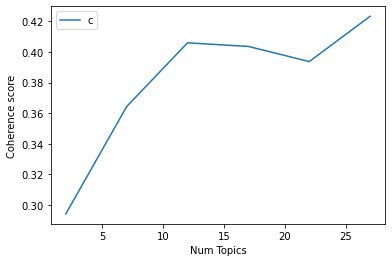

In [109]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score5)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [110]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score5):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.2941
index: 1 | Num Topics = 7  has Coherence Value of 0.3643
index: 2 | Num Topics = 12  has Coherence Value of 0.406
index: 3 | Num Topics = 17  has Coherence Value of 0.4037
index: 4 | Num Topics = 22  has Coherence Value of 0.3938
index: 5 | Num Topics = 27  has Coherence Value of 0.4234


In [194]:
# Select optimal number of topics
optimal_model_us_score5 = model_list_us_score5[5]

In [195]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score5 = pyLDAvis.gensim_models.prepare(optimal_model_us_score5, corpus_us_score5, id2word_us_score5)

In [196]:
print("pyLDAVis for us topics for score=5:")
vis_us_score5

pyLDAVis for us topics for score=5:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
21    -0.274502 -0.015888       1        1  13.653009
15    -0.169559 -0.031016       2        1   6.727410
3     -0.142212  0.007253       3        1   6.390974
10    -0.188493  0.072435       4        1   6.337937
22    -0.114393  0.085574       5        1   5.194169
16    -0.132740 -0.167238       6        1   5.083049
14    -0.094280 -0.095883       7        1   4.698207
17    -0.162845  0.048480       8        1   4.299036
6     -0.095767  0.096747       9        1   4.215724
9     -0.052237 -0.115774      10        1   3.480311
19     0.098596  0.073691      11        1   3.333212
26     0.002199  0.202293      12        1   3.328700
13     0.119269  0.070130      13        1   3.200766
18    -0.119586 -0.092875      14        1   3.153910
24     0.055839 -0.041599      15        1   3.099649
5      0.020674  0.065036      16        1   3.034067
4      0.133496  0.120180      17        1   2.715608
8     -0.073829 -0.080310      18        1   2.636003
25     0.023181  0.087788      19        1   2.618002
12     0.018050  0.159679      20        1   2.495221
2      0.135837 -0.171396      21        1   2.391872
7      0.070456 -0.119122      22        1   1.739687
11     0.206003 -0.004656      23        1   1.707173
1      0.181539 -0.049402      24        1   1.413404
20     0.114297 -0.058419      25        1   1.328761
23     0.226819 -0.023482      26        1   1.002269
0      0.214189 -0.022226      27        1   0.721870, topic_info=       Term        Freq       Total Category  logprob  loglift
0       app  821.000000  821.000000  Default  30.0000  30.0000
23    video  312.000000  312.000000  Default  29.0000  29.0000
4      love  490.000000  490.000000  Default  28.0000  28.0000
24    music  154.000000  154.000000  Default  27.0000  27.0000
27    great  184.000000  184.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
0       app    0.027024  821.669112  Topic27  -7.8058  -5.3913
1   feature    0.027024   21.032079  Topic27  -7.8058  -1.7260
2     happy    0.027024   16.400884  Topic27  -7.8058  -1.4773
3      hope    0.027024   20.188329  Topic27  -7.8058  -1.6851
4      love    0.027024  490.488148  Topic27  -7.8058  -4.8754

[1145 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1082     13  0.692442      abande
9         2  0.323563        able
9         3  0.593198        able
9        24  0.053927        able
366       6  0.974109  absolutely
...     ...       ...         ...
209       4  0.441508         yea
8         9  0.900265        year
145       8  0.249917         yet
145      15  0.249917         yet
537      18  0.504474     youngin

[1031 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[22, 16, 4, 11, 23, 17, 15, 18, 7, 10, 20, 27, 14, 19, 25, 6, 5, 9, 26, 13, 3, 8, 12, 2, 21, 24, 1])

## LDA Topic Modelling (Rating = 1,2,3)

In [114]:
# By-rating Topic Modelling - rating = 1,2,3
# Convert to list - move to each section
review_us_score1N2N3 = lomotif_ios_us_review_YearMonth_score1N2N3.review.values.tolist()
review_words_us_score1N2N3 = list(sent_to_words(review_us_score1N2N3))
print(review_words_us_score1N2N3[:1])

[['this', 'app', 'it', 'trash', 'because', 'cant', 'make', 'lit', 'video', 'then', 'when', 'its', 'done', 'and', 'its', 'loading', 'it', 'kicks', 'out', 'of', 'the', 'app', 'and', 'have', 'to', 'start', 'all', 'over', 'again', 'on', 'iphone']]


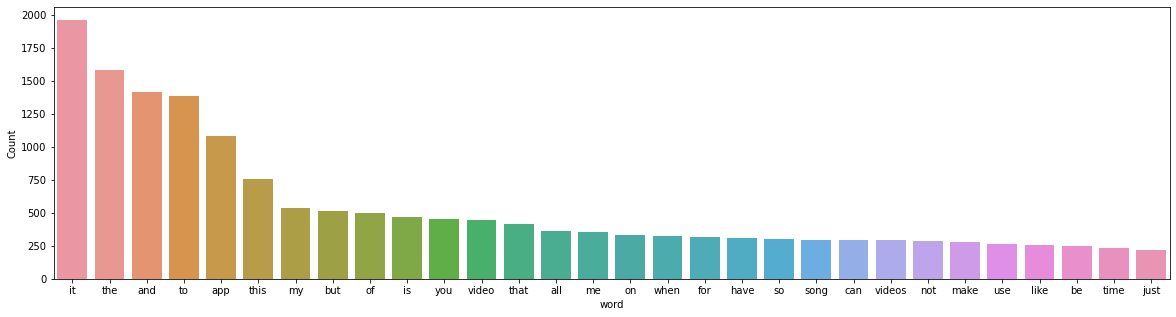

In [115]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score1N2N3))

In [116]:
# Clean text
review_us_ready_score1N2N3 = process_words(review_words_us_score1N2N3)  # processed Text Data! - move to each section

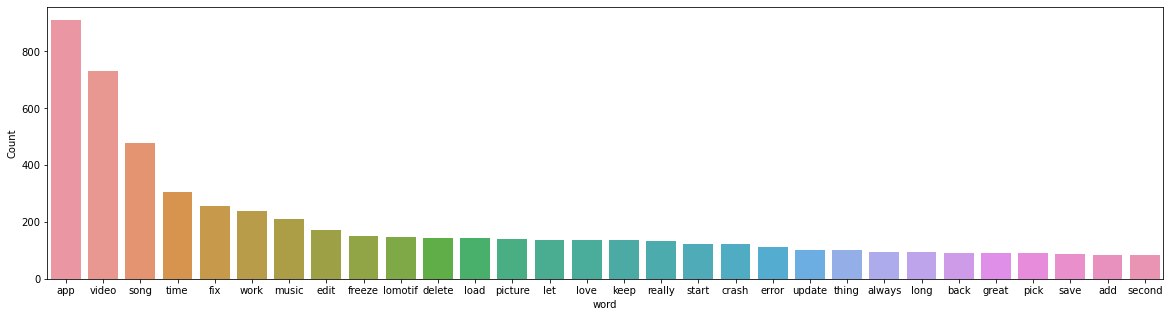

In [117]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score1N2N3))


In [118]:
# Create Dictionary
id2word_us_score1N2N3 = corpora.Dictionary(review_us_ready_score1N2N3)

2021-10-17 02:47:23,227 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 02:47:23,269 [INFO] gensim.corpora.dictionary - built Dictionary(1350 unique tokens: ['app', 'iphone', 'kick', 'light', 'loading']...) from 992 documents (total 13459 corpus positions)
2021-10-17 02:47:23,270 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1350 unique tokens: ['app', 'iphone', 'kick', 'light', 'loading']...) from 992 documents (total 13459 corpus positions)", 'datetime': '2021-10-17T02:47:23.270458', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [119]:
# Create Corpus: Term Document Frequency
corpus_us_score1N2N3 = [id2word_us_score1N2N3.doc2bow(text) for text in review_us_ready_score1N2N3]

In [120]:
# Training LDA model
model_list_us_score1N2N3, coherence_values_us_score1N2N3 = compute_coherence_values(dictionary=id2word_us_score1N2N3, corpus=corpus_us_score1N2N3, 
                                                              texts=review_us_ready_score1N2N3, limit=30, start=2, step=5)


2021-10-17 02:47:23,897 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 02:47:23,898 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 02:47:23,901 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 02:47:23,903 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 992 documents, updating model once every 992 documents, evaluating perplexity every 992 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 02:47:27,666 [INFO] gensim.models.ldamodel - -7.745 per-word bound, 214.5 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:47:27,667 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #992/992
2021-10-17 02:47:30,752 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.060*"video" + 0.053*"app" + 0.034*"song" + 0.016*"fix" + 0.016*"edit" + 0.015*"work" + 0.014*"freeze"

2021-10-17 02:48:12,607 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.066*"app" + 0.048*"song" + 0.034*"video" + 0.026*"time" + 0.024*"fix" + 0.022*"work" + 0.015*"music" + 0.015*"load" + 0.014*"keep" + 0.014*"delete"
2021-10-17 02:48:12,608 [INFO] gensim.models.ldamodel - topic diff=0.024073, rho=0.301511
2021-10-17 02:48:14,590 [INFO] gensim.models.ldamodel - -5.845 per-word bound, 57.5 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:48:14,595 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #992/992
2021-10-17 02:48:16,241 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.071*"video" + 0.056*"app" + 0.020*"picture" + 0.017*"freeze" + 0.016*"edit" + 0.014*"long" + 0.014*"time" + 0.013*"second" + 0.013*"music" + 0.012*"put"
2021-10-17 02:48:16,243 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.066*"app" + 0.048*"song" + 0.034*"video" + 0.026*"time" + 0.024*"fix" + 0.022*"work" + 0.015*"music" + 0.015*"load" + 0.

2021-10-17 02:48:48,107 [INFO] gensim.models.ldamodel - topic diff=0.014760, rho=0.218218
2021-10-17 02:48:50,070 [INFO] gensim.models.ldamodel - -5.829 per-word bound, 56.8 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:48:50,072 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #992/992
2021-10-17 02:48:51,386 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.071*"video" + 0.058*"app" + 0.021*"picture" + 0.016*"edit" + 0.015*"freeze" + 0.015*"long" + 0.014*"time" + 0.013*"second" + 0.013*"put" + 0.012*"music"
2021-10-17 02:48:51,388 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.064*"app" + 0.053*"song" + 0.034*"video" + 0.025*"fix" + 0.025*"time" + 0.024*"work" + 0.016*"load" + 0.016*"music" + 0.015*"keep" + 0.015*"delete"
2021-10-17 02:48:51,389 [INFO] gensim.models.ldamodel - topic diff=0.014426, rho=0.213201
2021-10-17 02:48:53,171 [INFO] gensim.models.ldamodel - -5.828 per-word bound, 56.8 perplexity estimate ba

2021-10-17 02:49:21,996 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #992/992
2021-10-17 02:49:23,408 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.069*"video" + 0.060*"app" + 0.022*"picture" + 0.015*"long" + 0.015*"edit" + 0.014*"time" + 0.014*"second" + 0.013*"freeze" + 0.013*"put" + 0.012*"music"
2021-10-17 02:49:23,410 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.063*"app" + 0.054*"song" + 0.036*"video" + 0.026*"fix" + 0.025*"time" + 0.025*"work" + 0.016*"load" + 0.016*"delete" + 0.016*"music" + 0.016*"keep"
2021-10-17 02:49:23,411 [INFO] gensim.models.ldamodel - topic diff=0.010036, rho=0.176777
2021-10-17 02:49:25,161 [INFO] gensim.models.ldamodel - -5.818 per-word bound, 56.4 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:49:25,162 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #992/992
2021-10-17 02:49:26,581 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.069*"video" + 0.060*"app

2021-10-17 02:49:54,145 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.063*"app" + 0.054*"song" + 0.037*"video" + 0.026*"fix" + 0.026*"work" + 0.026*"time" + 0.016*"load" + 0.016*"delete" + 0.016*"keep" + 0.015*"music"
2021-10-17 02:49:54,148 [INFO] gensim.models.ldamodel - topic diff=0.007735, rho=0.154303
2021-10-17 02:49:55,845 [INFO] gensim.models.ldamodel - -5.813 per-word bound, 56.2 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:49:55,846 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #992/992
2021-10-17 02:49:57,283 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.067*"video" + 0.060*"app" + 0.022*"picture" + 0.015*"long" + 0.014*"second" + 0.014*"edit" + 0.013*"time" + 0.013*"put" + 0.012*"music" + 0.011*"update"
2021-10-17 02:49:57,285 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.063*"app" + 0.054*"song" + 0.037*"video" + 0.026*"fix" + 0.026*"work" + 0.026*"time" + 0.016*"load" + 0.016*"delete" + 0

2021-10-17 02:50:26,717 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 979 virtual documents
2021-10-17 02:50:27,043 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 02:50:27,044 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 02:50:27,066 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 02:50:27,071 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 992 documents, updating model once every 992 documents, evaluating perplexity every 992 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 02:50:29,801 [INFO] gensim.models.ldamodel - -8.601 per-word bound, 388.2 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:50:29,803 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #992/992
2021-10-17 02:5

2021-10-17 02:50:47,555 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #992/992
2021-10-17 02:50:49,114 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.125*"song" + 0.044*"app" + 0.030*"error" + 0.026*"video" + 0.024*"load" + 0.022*"fix" + 0.020*"pick" + 0.020*"work" + 0.018*"let" + 0.015*"search"
2021-10-17 02:50:49,115 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.057*"app" + 0.047*"video" + 0.040*"work" + 0.037*"time" + 0.036*"freeze" + 0.027*"edit" + 0.026*"keep" + 0.024*"start" + 0.022*"fix" + 0.018*"delete"
2021-10-17 02:50:49,116 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.082*"video" + 0.079*"app" + 0.023*"fix" + 0.021*"music" + 0.015*"song" + 0.013*"edit" + 0.012*"long" + 0.011*"freeze" + 0.010*"time" + 0.010*"really"
2021-10-17 02:50:49,117 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.045*"app" + 0.039*"song" + 0.032*"load" + 0.025*"video" + 0.023*"love" + 0.023*"let" + 0.021*"lomotif" + 0.020*"music" + 0.016*"download" + 0.016*"time"
2

2021-10-17 02:51:04,578 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.059*"video" + 0.047*"picture" + 0.039*"app" + 0.028*"put" + 0.025*"second" + 0.016*"long" + 0.015*"update" + 0.014*"music" + 0.014*"choose" + 0.013*"wish"
2021-10-17 02:51:04,580 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.083*"video" + 0.078*"app" + 0.023*"music" + 0.022*"fix" + 0.013*"long" + 0.011*"edit" + 0.011*"really" + 0.011*"song" + 0.009*"play" + 0.009*"picture"
2021-10-17 02:51:04,581 [INFO] gensim.models.ldamodel - topic diff=0.034483, rho=0.288675
2021-10-17 02:51:06,294 [INFO] gensim.models.ldamodel - -6.028 per-word bound, 65.3 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:51:06,295 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #992/992
2021-10-17 02:51:07,510 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.068*"app" + 0.059*"video" + 0.042*"freeze" + 0.040*"time" + 0.038*"work" + 0.030*"edit" + 0.028*"keep" + 0.026*"sta

2021-10-17 02:51:22,508 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.081*"video" + 0.077*"app" + 0.024*"music" + 0.020*"fix" + 0.013*"long" + 0.012*"really" + 0.010*"edit" + 0.010*"people" + 0.010*"play" + 0.009*"find"
2021-10-17 02:51:22,510 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.072*"app" + 0.064*"video" + 0.043*"freeze" + 0.040*"time" + 0.037*"work" + 0.030*"edit" + 0.027*"keep" + 0.027*"start" + 0.022*"fix" + 0.021*"delete"
2021-10-17 02:51:22,512 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.142*"song" + 0.038*"app" + 0.037*"error" + 0.028*"load" + 0.026*"fix" + 0.021*"let" + 0.020*"pick" + 0.020*"work" + 0.019*"video" + 0.018*"search"
2021-10-17 02:51:22,514 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.049*"app" + 0.035*"load" + 0.027*"love" + 0.022*"let" + 0.022*"work" + 0.021*"music" + 0.021*"video" + 0.021*"lomotif" + 0.019*"download" + 0.019*"song"
2021-10-17 02:51:22,517 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.091*"app" + 0.044*"v

2021-10-17 02:51:38,391 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.050*"app" + 0.037*"load" + 0.027*"love" + 0.025*"work" + 0.023*"let" + 0.021*"lomotif" + 0.020*"music" + 0.020*"download" + 0.020*"video" + 0.017*"never"
2021-10-17 02:51:38,392 [INFO] gensim.models.ldamodel - topic diff=0.015001, rho=0.208514
2021-10-17 02:51:40,069 [INFO] gensim.models.ldamodel - -6.001 per-word bound, 64.0 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:51:40,075 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #992/992
2021-10-17 02:51:41,266 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.081*"video" + 0.076*"app" + 0.025*"music" + 0.019*"fix" + 0.013*"long" + 0.012*"really" + 0.011*"people" + 0.010*"edit" + 0.010*"find" + 0.009*"play"
2021-10-17 02:51:41,269 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.090*"app" + 0.043*"video" + 0.034*"crash" + 0.029*"time" + 0.016*"delete" + 0.016*"start" + 0.015*"fix" + 0.015*"phot

2021-10-17 02:51:56,003 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.069*"video" + 0.051*"picture" + 0.039*"app" + 0.032*"second" + 0.029*"put" + 0.026*"long" + 0.016*"update" + 0.015*"choose" + 0.013*"wish" + 0.013*"really"
2021-10-17 02:51:56,005 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.146*"song" + 0.037*"error" + 0.035*"app" + 0.029*"load" + 0.027*"fix" + 0.021*"let" + 0.021*"work" + 0.020*"pick" + 0.019*"music" + 0.018*"search"
2021-10-17 02:51:56,008 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.051*"app" + 0.040*"load" + 0.027*"work" + 0.025*"love" + 0.023*"let" + 0.021*"download" + 0.020*"lomotif" + 0.019*"music" + 0.019*"video" + 0.018*"still"
2021-10-17 02:51:56,010 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.090*"app" + 0.043*"video" + 0.034*"crash" + 0.029*"time" + 0.016*"delete" + 0.016*"start" + 0.016*"fix" + 0.015*"photo" + 0.015*"really" + 0.014*"problem"
2021-10-17 02:51:56,011 [INFO] gensim.models.ldamodel - topic diff=0.010885, rho=0.1

2021-10-17 02:52:10,380 [INFO] gensim.models.ldamodel - topic diff=0.008935, rho=0.171499
2021-10-17 02:52:11,961 [INFO] gensim.models.ldamodel - -5.988 per-word bound, 63.5 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:52:11,963 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #992/992
2021-10-17 02:52:13,132 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.036*"app" + 0.033*"time" + 0.030*"video" + 0.019*"picture" + 0.017*"home" + 0.017*"back" + 0.017*"thing" + 0.016*"inappropriate" + 0.015*"stuff" + 0.015*"pick"
2021-10-17 02:52:13,133 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.089*"app" + 0.043*"video" + 0.034*"crash" + 0.029*"time" + 0.016*"start" + 0.016*"delete" + 0.015*"photo" + 0.015*"fix" + 0.015*"really" + 0.014*"add"
2021-10-17 02:52:13,135 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.080*"app" + 0.071*"video" + 0.044*"freeze" + 0.041*"time" + 0.035*"work" + 0.030*"edit" + 0.027*"keep" + 0.026

2021-10-17 02:52:27,188 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.081*"app" + 0.072*"video" + 0.044*"freeze" + 0.041*"time" + 0.035*"work" + 0.030*"edit" + 0.027*"keep" + 0.026*"start" + 0.022*"fix" + 0.022*"delete"
2021-10-17 02:52:27,193 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.072*"video" + 0.053*"picture" + 0.038*"app" + 0.034*"second" + 0.029*"put" + 0.029*"long" + 0.016*"choose" + 0.015*"update" + 0.014*"wish" + 0.013*"really"
2021-10-17 02:52:27,212 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.148*"song" + 0.037*"error" + 0.034*"app" + 0.029*"load" + 0.028*"fix" + 0.022*"let" + 0.021*"work" + 0.020*"music" + 0.020*"pick" + 0.018*"search"
2021-10-17 02:52:27,216 [INFO] gensim.models.ldamodel - topic diff=0.007105, rho=0.158114
2021-10-17 02:52:28,789 [INFO] gensim.models.ldamodel - -5.984 per-word bound, 63.3 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:52:28,791 [INFO] gensim.models.ldamodel - PROGRESS

2021-10-17 02:52:42,778 [INFO] gensim.models.ldamodel - -5.981 per-word bound, 63.1 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:52:42,779 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #992/992
2021-10-17 02:52:44,012 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"app" + 0.032*"time" + 0.028*"video" + 0.019*"picture" + 0.017*"back" + 0.017*"home" + 0.017*"thing" + 0.017*"inappropriate" + 0.015*"pick" + 0.014*"stuff"
2021-10-17 02:52:44,014 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.149*"song" + 0.037*"error" + 0.034*"app" + 0.028*"load" + 0.028*"fix" + 0.022*"let" + 0.021*"music" + 0.021*"work" + 0.020*"pick" + 0.018*"choose"
2021-10-17 02:52:44,016 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.083*"app" + 0.073*"video" + 0.044*"freeze" + 0.040*"time" + 0.034*"work" + 0.030*"edit" + 0.027*"keep" + 0.025*"start" + 0.022*"fix" + 0.022*"delete"
2021-10-17 02:52:44,019 [INFO] gensim.models.ldamodel 

2021-10-17 02:52:57,840 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.052*"app" + 0.042*"load" + 0.030*"work" + 0.025*"download" + 0.024*"love" + 0.021*"let" + 0.020*"still" + 0.020*"lomotif" + 0.018*"music" + 0.017*"video"
2021-10-17 02:52:57,842 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.073*"video" + 0.056*"picture" + 0.039*"app" + 0.035*"second" + 0.031*"long" + 0.029*"put" + 0.016*"choose" + 0.015*"update" + 0.014*"wish" + 0.013*"really"
2021-10-17 02:52:57,846 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.077*"video" + 0.073*"app" + 0.027*"music" + 0.016*"fix" + 0.014*"really" + 0.013*"people" + 0.012*"long" + 0.012*"find" + 0.010*"edit" + 0.009*"add"
2021-10-17 02:52:57,848 [INFO] gensim.models.ldamodel - topic diff=0.004626, rho=0.140028
2021-10-17 02:52:57,850 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=1350, num_topics=7, decay=0.5, chunksize=1000) in 150.78s', 'datetime': '2021-10-17T02:52:57.850215', 'gensim': '4.1

2021-10-17 02:53:19,500 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #992/992
2021-10-17 02:53:20,674 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.098*"app" + 0.044*"video" + 0.033*"crash" + 0.026*"time" + 0.024*"second" + 0.021*"start" + 0.020*"long" + 0.017*"fix" + 0.015*"love" + 0.015*"delete"
2021-10-17 02:53:20,676 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.089*"song" + 0.051*"app" + 0.034*"video" + 0.022*"let" + 0.019*"load" + 0.018*"pick" + 0.017*"change" + 0.015*"preview" + 0.014*"error" + 0.013*"really"
2021-10-17 02:53:20,677 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.086*"app" + 0.077*"video" + 0.021*"edit" + 0.020*"fix" + 0.016*"music" + 0.015*"song" + 0.014*"really" + 0.013*"time" + 0.012*"freeze" + 0.011*"people"
2021-10-17 02:53:20,682 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.088*"video" + 0.049*"app" + 0.041*"time" + 0.034*"picture" + 0.026*"freeze" + 0.022*"work" + 0.018*"delete" + 0.018*"edit" + 0.015*"crash" + 0.01

2021-10-17 02:53:36,047 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.036*"picture" + 0.032*"video" + 0.027*"put" + 0.027*"app" + 0.020*"stuff" + 0.018*"wish" + 0.018*"thing" + 0.016*"edit" + 0.016*"long" + 0.016*"fast"
2021-10-17 02:53:36,050 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.105*"song" + 0.048*"app" + 0.031*"video" + 0.027*"let" + 0.023*"load" + 0.020*"change" + 0.019*"pick" + 0.016*"error" + 0.016*"preview" + 0.014*"search"
2021-10-17 02:53:36,052 [INFO] gensim.models.ldamodel - topic diff=0.058640, rho=0.301511
2021-10-17 02:53:37,675 [INFO] gensim.models.ldamodel - -6.165 per-word bound, 71.7 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:53:37,677 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #992/992
2021-10-17 02:53:38,959 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.083*"song" + 0.058*"load" + 0.037*"app" + 0.026*"let" + 0.024*"video" + 0.023*"love" + 0.018*"picture" + 0.017*"never"

2021-10-17 02:53:53,594 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.083*"song" + 0.064*"load" + 0.035*"app" + 0.025*"let" + 0.023*"love" + 0.022*"video" + 0.018*"work" + 0.018*"picture" + 0.016*"error" + 0.016*"lomotif"
2021-10-17 02:53:53,596 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.049*"work" + 0.030*"time" + 0.028*"app" + 0.023*"song" + 0.020*"lomotif" + 0.016*"fix" + 0.014*"video" + 0.014*"day" + 0.013*"well" + 0.013*"delete"
2021-10-17 02:53:53,599 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.115*"song" + 0.046*"app" + 0.030*"let" + 0.029*"video" + 0.024*"load" + 0.022*"change" + 0.020*"pick" + 0.016*"error" + 0.016*"preview" + 0.015*"search"
2021-10-17 02:53:53,600 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.087*"app" + 0.074*"video" + 0.019*"edit" + 0.018*"people" + 0.018*"fix" + 0.015*"really" + 0.013*"post" + 0.012*"save" + 0.011*"love" + 0.011*"let"
2021-10-17 02:53:53,602 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.092*"song" + 0.068

2021-10-17 02:54:08,233 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.120*"song" + 0.043*"app" + 0.032*"let" + 0.028*"video" + 0.025*"load" + 0.023*"change" + 0.021*"pick" + 0.016*"preview" + 0.016*"error" + 0.015*"search"
2021-10-17 02:54:08,234 [INFO] gensim.models.ldamodel - topic diff=0.022154, rho=0.213201
2021-10-17 02:54:09,831 [INFO] gensim.models.ldamodel - -6.120 per-word bound, 69.6 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:54:09,832 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #992/992
2021-10-17 02:54:11,140 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.034*"inappropriate" + 0.027*"time" + 0.022*"app" + 0.018*"log" + 0.018*"tok" + 0.017*"much" + 0.017*"thing" + 0.016*"great" + 0.016*"stuff" + 0.014*"video"
2021-10-17 02:54:11,141 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.099*"app" + 0.069*"video" + 0.038*"crash" + 0.030*"second" + 0.027*"time" + 0.024*"long" + 0.021*"start" + 0.018

2021-10-17 02:54:25,989 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.099*"app" + 0.071*"video" + 0.038*"crash" + 0.030*"second" + 0.027*"time" + 0.024*"long" + 0.021*"start" + 0.018*"fix" + 0.015*"photo" + 0.015*"love"
2021-10-17 02:54:26,006 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.097*"song" + 0.067*"app" + 0.048*"music" + 0.039*"fix" + 0.032*"error" + 0.030*"video" + 0.026*"play" + 0.020*"work" + 0.016*"great" + 0.016*"choose"
2021-10-17 02:54:26,009 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.062*"app" + 0.045*"freeze" + 0.037*"time" + 0.037*"keep" + 0.034*"video" + 0.033*"start" + 0.024*"edit" + 0.024*"work" + 0.019*"fix" + 0.019*"delete"
2021-10-17 02:54:26,013 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.035*"inappropriate" + 0.026*"time" + 0.021*"app" + 0.020*"log" + 0.018*"tok" + 0.017*"thing" + 0.017*"much" + 0.016*"great" + 0.016*"stuff" + 0.013*"people"
2021-10-17 02:54:26,014 [INFO] gensim.models.ldamodel - topic diff=0.015182, rho=0.188982

2021-10-17 02:54:40,604 [INFO] gensim.models.ldamodel - topic diff=0.011538, rho=0.174078
2021-10-17 02:54:42,201 [INFO] gensim.models.ldamodel - -6.103 per-word bound, 68.7 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:54:42,203 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #992/992
2021-10-17 02:54:43,518 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.048*"picture" + 0.034*"put" + 0.027*"video" + 0.025*"app" + 0.023*"stuff" + 0.017*"wish" + 0.016*"upload" + 0.016*"edit" + 0.015*"long" + 0.015*"fast"
2021-10-17 02:54:43,520 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.051*"work" + 0.028*"time" + 0.028*"app" + 0.019*"lomotif" + 0.016*"day" + 0.015*"song" + 0.015*"well" + 0.014*"phone" + 0.014*"fix" + 0.014*"delete"
2021-10-17 02:54:43,522 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.087*"app" + 0.073*"video" + 0.024*"people" + 0.020*"edit" + 0.017*"really" + 0.016*"fix" + 0.015*"post" + 0.012*"love" + 

2021-10-17 02:54:58,018 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.099*"app" + 0.074*"video" + 0.038*"crash" + 0.029*"second" + 0.027*"time" + 0.024*"long" + 0.021*"start" + 0.018*"fix" + 0.015*"love" + 0.015*"photo"
2021-10-17 02:54:58,024 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.054*"app" + 0.045*"music" + 0.039*"lomotif" + 0.026*"really" + 0.024*"well" + 0.015*"help" + 0.015*"add" + 0.014*"thing" + 0.014*"work" + 0.012*"video"
2021-10-17 02:54:58,026 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.087*"app" + 0.072*"video" + 0.025*"people" + 0.021*"edit" + 0.017*"really" + 0.016*"post" + 0.016*"fix" + 0.012*"love" + 0.011*"stuff" + 0.011*"let"
2021-10-17 02:54:58,028 [INFO] gensim.models.ldamodel - topic diff=0.009212, rho=0.160128
2021-10-17 02:54:59,644 [INFO] gensim.models.ldamodel - -6.096 per-word bound, 68.4 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:54:59,645 [INFO] gensim.models.ldamodel - PROGRESS:

2021-10-17 02:55:14,186 [INFO] gensim.models.ldamodel - -6.092 per-word bound, 68.2 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:55:14,187 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #992/992
2021-10-17 02:55:15,797 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.088*"app" + 0.071*"video" + 0.027*"people" + 0.021*"edit" + 0.017*"really" + 0.016*"post" + 0.016*"fix" + 0.013*"love" + 0.011*"stuff" + 0.011*"look"
2021-10-17 02:55:15,801 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.054*"app" + 0.045*"music" + 0.039*"lomotif" + 0.026*"really" + 0.023*"well" + 0.016*"add" + 0.015*"help" + 0.014*"thing" + 0.013*"work" + 0.012*"video"
2021-10-17 02:55:15,803 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.080*"load" + 0.078*"song" + 0.032*"app" + 0.023*"work" + 0.023*"love" + 0.022*"let" + 0.022*"fix" + 0.021*"video" + 0.018*"lomotif" + 0.018*"forever"
2021-10-17 02:55:15,808 [INFO] gensim.models.ldamodel - to

2021-10-17 02:55:30,412 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.054*"app" + 0.045*"music" + 0.038*"lomotif" + 0.027*"really" + 0.024*"well" + 0.016*"add" + 0.016*"help" + 0.014*"thing" + 0.012*"work" + 0.012*"video"
2021-10-17 02:55:30,414 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.060*"app" + 0.046*"freeze" + 0.040*"keep" + 0.037*"start" + 0.035*"time" + 0.035*"video" + 0.024*"edit" + 0.023*"glitch" + 0.021*"work" + 0.020*"fix"
2021-10-17 02:55:30,415 [INFO] gensim.models.ldamodel - topic diff=0.006062, rho=0.141421
2021-10-17 02:55:31,847 [INFO] gensim.models.ldamodel - -6.088 per-word bound, 68.0 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:55:31,848 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #992/992
2021-10-17 02:55:32,991 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.094*"video" + 0.068*"app" + 0.049*"time" + 0.037*"freeze" + 0.028*"picture" + 0.025*"edit" + 0.021*"work" + 0.019*"del

2021-10-17 02:55:53,172 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.045*"app" + 0.040*"stuff" + 0.025*"video" + 0.024*"back" + 0.023*"freeze" + 0.019*"inappropriate" + 0.017*"crash" + 0.017*"well" + 0.016*"save" + 0.016*"time"
2021-10-17 02:55:53,173 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.067*"app" + 0.064*"song" + 0.050*"video" + 0.035*"fix" + 0.032*"music" + 0.032*"error" + 0.022*"work" + 0.018*"keep" + 0.017*"great" + 0.012*"update"
2021-10-17 02:55:53,178 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.063*"song" + 0.049*"music" + 0.049*"app" + 0.036*"lomotif" + 0.036*"load" + 0.027*"video" + 0.022*"work" + 0.020*"let" + 0.020*"pick" + 0.016*"fix"
2021-10-17 02:55:53,179 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.080*"app" + 0.053*"video" + 0.024*"start" + 0.017*"freeze" + 0.017*"time" + 0.015*"song" + 0.013*"delete" + 0.013*"keep" + 0.012*"lomotif" + 0.012*"fix"
2021-10-17 02:55:53,181 [INFO] gensim.models.ldamodel - topic diff=0.175908, rho=0.

2021-10-17 02:56:07,863 [INFO] gensim.models.ldamodel - topic diff=0.083023, rho=0.316228
2021-10-17 02:56:09,541 [INFO] gensim.models.ldamodel - -6.277 per-word bound, 77.6 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:56:09,542 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #992/992
2021-10-17 02:56:10,789 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.068*"music" + 0.059*"song" + 0.043*"app" + 0.040*"lomotif" + 0.035*"load" + 0.027*"work" + 0.025*"video" + 0.023*"let" + 0.021*"pick" + 0.017*"fix"
2021-10-17 02:56:10,791 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.041*"app" + 0.030*"open" + 0.023*"press" + 0.021*"download" + 0.017*"work" + 0.017*"time" + 0.017*"feature" + 0.017*"ever" + 0.017*"second" + 0.017*"well"
2021-10-17 02:56:10,796 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.076*"video" + 0.065*"app" + 0.041*"update" + 0.033*"new" + 0.025*"time" + 0.023*"work" + 0.021*"lomotif" + 0.016*"mu

2021-10-17 02:56:25,278 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.110*"app" + 0.048*"crash" + 0.029*"video" + 0.025*"time" + 0.021*"really" + 0.020*"fix" + 0.018*"problem" + 0.018*"start" + 0.016*"project" + 0.016*"long"
2021-10-17 02:56:25,280 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.065*"video" + 0.051*"app" + 0.039*"time" + 0.032*"edit" + 0.030*"picture" + 0.021*"work" + 0.018*"delete" + 0.018*"freeze" + 0.015*"minute" + 0.013*"thing"
2021-10-17 02:56:25,283 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.050*"stuff" + 0.041*"app" + 0.038*"back" + 0.027*"video" + 0.026*"inappropriate" + 0.025*"home" + 0.023*"freeze" + 0.020*"hard" + 0.018*"time" + 0.015*"save"
2021-10-17 02:56:25,284 [INFO] gensim.models.ldamodel - topic diff=0.039869, rho=0.250000
2021-10-17 02:56:26,853 [INFO] gensim.models.ldamodel - -6.232 per-word bound, 75.2 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:56:26,855 [INFO] gensim.models.ld

2021-10-17 02:56:41,469 [INFO] gensim.models.ldamodel - -6.213 per-word bound, 74.2 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:56:41,471 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #992/992
2021-10-17 02:56:42,642 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.077*"freeze" + 0.076*"video" + 0.073*"app" + 0.046*"time" + 0.039*"edit" + 0.037*"keep" + 0.035*"start" + 0.029*"crash" + 0.026*"delete" + 0.025*"fix"
2021-10-17 02:56:42,645 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.076*"video" + 0.068*"app" + 0.049*"update" + 0.037*"new" + 0.024*"time" + 0.022*"lomotif" + 0.022*"work" + 0.018*"mute" + 0.018*"sound" + 0.014*"find"
2021-10-17 02:56:42,646 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.030*"lomotif" + 0.025*"time" + 0.024*"work" + 0.024*"app" + 0.023*"video" + 0.016*"love" + 0.015*"really" + 0.014*"fix" + 0.014*"back" + 0.014*"edit"
2021-10-17 02:56:42,648 [INFO] gensim.models.ldamodel - to

2021-10-17 02:56:55,416 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.109*"video" + 0.070*"second" + 0.065*"put" + 0.053*"long" + 0.047*"app" + 0.031*"picture" + 0.024*"wish" + 0.019*"update" + 0.018*"love" + 0.017*"fast"
2021-10-17 02:56:55,417 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.086*"video" + 0.084*"app" + 0.040*"load" + 0.038*"picture" + 0.033*"time" + 0.030*"delete" + 0.028*"fix" + 0.019*"still" + 0.017*"love" + 0.016*"let"
2021-10-17 02:56:55,418 [INFO] gensim.models.ldamodel - topic diff=0.018712, rho=0.192450
2021-10-17 02:56:56,858 [INFO] gensim.models.ldamodel - -6.197 per-word bound, 73.3 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:56:56,859 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #992/992
2021-10-17 02:56:57,897 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.063*"video" + 0.048*"app" + 0.040*"time" + 0.031*"picture" + 0.029*"edit" + 0.020*"work" + 0.017*"delete" + 0.015*"min

2021-10-17 02:57:10,186 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.084*"video" + 0.081*"freeze" + 0.080*"app" + 0.046*"time" + 0.042*"edit" + 0.040*"keep" + 0.037*"start" + 0.029*"crash" + 0.025*"fix" + 0.025*"delete"
2021-10-17 02:57:10,188 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.041*"app" + 0.040*"press" + 0.032*"open" + 0.019*"ask" + 0.019*"well" + 0.019*"work" + 0.017*"time" + 0.017*"download" + 0.016*"feature" + 0.016*"ever"
2021-10-17 02:57:10,191 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.206*"song" + 0.048*"error" + 0.036*"app" + 0.034*"load" + 0.028*"fix" + 0.025*"let" + 0.025*"pick" + 0.025*"preview" + 0.024*"play" + 0.024*"always"
2021-10-17 02:57:10,192 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.071*"app" + 0.058*"music" + 0.037*"video" + 0.034*"fix" + 0.033*"great" + 0.027*"work" + 0.020*"update" + 0.017*"problem" + 0.015*"love" + 0.014*"error"
2021-10-17 02:57:10,197 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.111*"video" + 

2021-10-17 02:57:22,405 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.207*"song" + 0.048*"error" + 0.036*"app" + 0.034*"load" + 0.029*"fix" + 0.026*"let" + 0.025*"pick" + 0.025*"preview" + 0.025*"play" + 0.023*"always"
2021-10-17 02:57:22,406 [INFO] gensim.models.ldamodel - topic diff=0.010805, rho=0.162221
2021-10-17 02:57:23,739 [INFO] gensim.models.ldamodel - -6.178 per-word bound, 72.4 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:57:23,741 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #992/992
2021-10-17 02:57:24,713 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.094*"app" + 0.076*"video" + 0.020*"music" + 0.017*"really" + 0.015*"post" + 0.015*"edit" + 0.014*"find" + 0.014*"add" + 0.012*"song" + 0.011*"look"
2021-10-17 02:57:24,715 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.042*"app" + 0.041*"press" + 0.031*"open" + 0.021*"ask" + 0.019*"work" + 0.019*"well" + 0.018*"perfect" + 0.017*"time" + 0.0

2021-10-17 02:57:36,532 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.094*"app" + 0.075*"video" + 0.020*"music" + 0.017*"really" + 0.016*"post" + 0.015*"edit" + 0.014*"find" + 0.014*"add" + 0.011*"look" + 0.011*"song"
2021-10-17 02:57:36,534 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.033*"lomotif" + 0.025*"work" + 0.023*"time" + 0.020*"app" + 0.017*"video" + 0.017*"love" + 0.016*"edit" + 0.016*"clip" + 0.015*"everytime" + 0.015*"really"
2021-10-17 02:57:36,536 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.044*"never" + 0.038*"love" + 0.031*"lomotif" + 0.030*"sign" + 0.030*"fix" + 0.029*"app" + 0.028*"forever" + 0.021*"add" + 0.020*"always" + 0.018*"let"
2021-10-17 02:57:36,538 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.070*"app" + 0.060*"music" + 0.037*"video" + 0.036*"great" + 0.033*"fix" + 0.026*"work" + 0.020*"update" + 0.018*"problem" + 0.014*"love" + 0.013*"look"
2021-10-17 02:57:36,539 [INFO] gensim.models.ldamodel - topic diff=0.008692, rho=0.150756

2021-10-17 02:57:48,319 [INFO] gensim.models.ldamodel - topic diff=0.007548, rho=0.142857
2021-10-17 02:57:49,755 [INFO] gensim.models.ldamodel - -6.167 per-word bound, 71.8 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:57:49,756 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #992/992
2021-10-17 02:57:50,570 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.043*"app" + 0.041*"press" + 0.031*"open" + 0.027*"ask" + 0.024*"perfect" + 0.018*"well" + 0.018*"work" + 0.017*"time" + 0.016*"second" + 0.016*"ever"
2021-10-17 02:57:50,573 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.086*"app" + 0.084*"video" + 0.040*"load" + 0.039*"picture" + 0.035*"delete" + 0.032*"time" + 0.029*"fix" + 0.022*"still" + 0.017*"love" + 0.016*"back"
2021-10-17 02:57:50,577 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.046*"never" + 0.039*"love" + 0.032*"lomotif" + 0.030*"sign" + 0.029*"fix" + 0.028*"forever" + 0.028*"app" + 0.021*"add

2021-10-17 02:58:09,850 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.067*"video" + 0.053*"app" + 0.051*"edit" + 0.041*"music" + 0.028*"long" + 0.020*"update" + 0.019*"second" + 0.016*"lomotif" + 0.014*"time" + 0.013*"issue"
2021-10-17 02:58:09,853 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.073*"app" + 0.032*"crash" + 0.029*"freeze" + 0.025*"video" + 0.021*"back" + 0.019*"stuff" + 0.019*"feature" + 0.013*"edit" + 0.013*"phone" + 0.012*"inappropriate"
2021-10-17 02:58:09,856 [INFO] gensim.models.ldamodel - topic diff=0.186254, rho=0.500000
2021-10-17 02:58:11,439 [INFO] gensim.models.ldamodel - -6.500 per-word bound, 90.5 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:58:11,441 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #992/992
2021-10-17 02:58:12,554 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.058*"app" + 0.054*"video" + 0.027*"song" + 0.020*"update" + 0.019*"lomotif" + 0.015*"new" + 0.015*"sh

2021-10-17 02:58:24,781 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #992/992
2021-10-17 02:58:25,776 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.040*"app" + 0.036*"song" + 0.033*"people" + 0.033*"let" + 0.031*"camera" + 0.029*"show" + 0.028*"ever" + 0.026*"roll" + 0.024*"old" + 0.018*"wrong"
2021-10-17 02:58:25,778 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.072*"app" + 0.040*"time" + 0.039*"load" + 0.037*"song" + 0.036*"video" + 0.034*"work" + 0.017*"pick" + 0.014*"download" + 0.014*"love" + 0.013*"forever"
2021-10-17 02:58:25,781 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.162*"song" + 0.057*"error" + 0.040*"load" + 0.039*"app" + 0.037*"let" + 0.035*"preview" + 0.034*"always" + 0.029*"search" + 0.026*"never" + 0.024*"fix"
2021-10-17 02:58:25,783 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.066*"song" + 0.051*"app" + 0.039*"fix" + 0.036*"thing" + 0.025*"select" + 0.024*"lomotif" + 0.022*"video" + 0.019*"people" + 0.018*"love" + 0.018

2021-10-17 02:58:38,358 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.097*"video" + 0.049*"app" + 0.039*"picture" + 0.026*"time" + 0.023*"add" + 0.021*"photo" + 0.018*"move" + 0.014*"allow" + 0.014*"people" + 0.012*"fix"
2021-10-17 02:58:38,360 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.050*"video" + 0.050*"app" + 0.024*"whenever" + 0.023*"update" + 0.022*"lomotif" + 0.017*"time" + 0.016*"show" + 0.015*"new" + 0.015*"cut" + 0.014*"shuffle"
2021-10-17 02:58:38,363 [INFO] gensim.models.ldamodel - topic diff=0.054725, rho=0.258199
2021-10-17 02:58:39,844 [INFO] gensim.models.ldamodel - -6.304 per-word bound, 79.0 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:58:39,848 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #992/992
2021-10-17 02:58:40,890 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.059*"video" + 0.048*"app" + 0.046*"keep" + 0.038*"time" + 0.032*"freeze" + 0.031*"fix" + 0.025*"start" + 0.024*"

2021-10-17 02:58:53,366 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #992/992
2021-10-17 02:58:54,647 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.082*"app" + 0.070*"update" + 0.030*"video" + 0.028*"back" + 0.027*"new" + 0.026*"change" + 0.022*"love" + 0.019*"lomotif" + 0.019*"much" + 0.018*"delete"
2021-10-17 02:58:54,648 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.038*"video" + 0.024*"time" + 0.023*"keep" + 0.019*"year" + 0.019*"music" + 0.018*"irritate" + 0.016*"app" + 0.014*"find" + 0.014*"ago" + 0.014*"problem"
2021-10-17 02:58:54,650 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.216*"song" + 0.064*"error" + 0.045*"load" + 0.037*"fix" + 0.036*"app" + 0.034*"let" + 0.032*"always" + 0.032*"preview" + 0.029*"search" + 0.027*"choose"
2021-10-17 02:58:54,651 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.109*"video" + 0.094*"second" + 0.079*"long" + 0.065*"put" + 0.054*"picture" + 0.050*"app" + 0.032*"wish" + 0.028*"great" + 0.026*"fast" + 

2021-10-17 02:59:07,304 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.061*"video" + 0.048*"app" + 0.046*"keep" + 0.040*"time" + 0.034*"freeze" + 0.031*"fix" + 0.023*"lomotif" + 0.023*"start" + 0.023*"delete" + 0.021*"save"
2021-10-17 02:59:07,306 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.041*"time" + 0.028*"video" + 0.024*"great" + 0.022*"app" + 0.021*"crash" + 0.018*"problem" + 0.015*"kick" + 0.014*"work" + 0.013*"find" + 0.013*"clip"
2021-10-17 02:59:07,308 [INFO] gensim.models.ldamodel - topic diff=0.022888, rho=0.196116
2021-10-17 02:59:08,723 [INFO] gensim.models.ldamodel - -6.256 per-word bound, 76.5 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:59:08,725 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #992/992
2021-10-17 02:59:09,712 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.049*"show" + 0.046*"people" + 0.041*"camera" + 0.041*"roll" + 0.041*"app" + 0.037*"let" + 0.026*"ever" + 0.023*"old"

2021-10-17 02:59:20,567 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #992/992
2021-10-17 02:59:21,549 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.040*"video" + 0.023*"keep" + 0.022*"time" + 0.020*"year" + 0.020*"irritate" + 0.015*"ago" + 0.015*"couple" + 0.015*"problem" + 0.015*"find" + 0.014*"music"
2021-10-17 02:59:21,551 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.092*"video" + 0.087*"app" + 0.051*"time" + 0.048*"freeze" + 0.031*"edit" + 0.026*"delete" + 0.023*"work" + 0.023*"start" + 0.020*"save" + 0.018*"picture"
2021-10-17 02:59:21,553 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.080*"app" + 0.050*"load" + 0.038*"video" + 0.036*"work" + 0.036*"time" + 0.023*"still" + 0.017*"forever" + 0.016*"phone" + 0.016*"delete" + 0.016*"open"
2021-10-17 02:59:21,555 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.050*"show" + 0.046*"people" + 0.042*"app" + 0.042*"roll" + 0.042*"camera" + 0.035*"let" + 0.024*"ever" + 0.023*"old" + 0.021*"picture"

2021-10-17 02:59:33,035 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.066*"app" + 0.034*"video" + 0.025*"song" + 0.024*"slow" + 0.019*"play" + 0.019*"music" + 0.018*"choose" + 0.018*"phone" + 0.017*"work" + 0.015*"lomotif"
2021-10-17 02:59:33,036 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.088*"work" + 0.036*"video" + 0.033*"lomotif" + 0.028*"well" + 0.027*"delete" + 0.024*"music" + 0.023*"song" + 0.021*"day" + 0.020*"still" + 0.019*"phone"
2021-10-17 02:59:33,037 [INFO] gensim.models.ldamodel - topic diff=0.012623, rho=0.164399
2021-10-17 02:59:34,378 [INFO] gensim.models.ldamodel - -6.231 per-word bound, 75.1 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 02:59:34,381 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #992/992
2021-10-17 02:59:35,321 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.093*"video" + 0.046*"app" + 0.044*"picture" + 0.026*"add" + 0.022*"time" + 0.021*"move" + 0.017*"photo" + 0.016*

2021-10-17 02:59:45,795 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #992/992
2021-10-17 02:59:46,808 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.041*"time" + 0.026*"great" + 0.024*"video" + 0.023*"crash" + 0.018*"kick" + 0.017*"problem" + 0.014*"find" + 0.014*"free" + 0.013*"horrible" + 0.012*"work"
2021-10-17 02:59:46,812 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.227*"song" + 0.059*"error" + 0.045*"load" + 0.041*"fix" + 0.038*"app" + 0.035*"let" + 0.029*"pick" + 0.029*"choose" + 0.029*"always" + 0.028*"search"
2021-10-17 02:59:46,814 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.103*"edit" + 0.072*"video" + 0.063*"app" + 0.026*"long" + 0.025*"time" + 0.024*"clip" + 0.021*"short" + 0.021*"glitch" + 0.019*"lomotif" + 0.019*"update"
2021-10-17 02:59:46,816 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.099*"app" + 0.049*"crash" + 0.040*"video" + 0.039*"time" + 0.031*"fix" + 0.028*"start" + 0.022*"photo" + 0.020*"problem" + 0.017*"music" + 

2021-10-17 02:59:58,856 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.084*"stuff" + 0.065*"app" + 0.041*"feature" + 0.027*"sign" + 0.025*"inappropriate" + 0.025*"back" + 0.021*"phone" + 0.020*"trash" + 0.019*"find" + 0.016*"kid"
2021-10-17 02:59:58,858 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.071*"video" + 0.040*"save" + 0.030*"quality" + 0.029*"freeze" + 0.025*"progress" + 0.021*"give" + 0.020*"horizontal" + 0.019*"mess" + 0.018*"blurry" + 0.017*"lomotif"
2021-10-17 02:59:58,862 [INFO] gensim.models.ldamodel - topic diff=0.008803, rho=0.144338
2021-10-17 03:00:00,435 [INFO] gensim.models.ldamodel - -6.215 per-word bound, 74.3 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 03:00:00,440 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #992/992
2021-10-17 03:00:01,524 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.092*"work" + 0.036*"video" + 0.034*"lomotif" + 0.029*"delete" + 0.028*"well" + 0.024*"music" 

2021-10-17 03:00:20,952 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.063*"app" + 0.037*"delete" + 0.031*"time" + 0.027*"video" + 0.026*"music" + 0.016*"picture" + 0.015*"freeze" + 0.014*"lomotif" + 0.012*"great" + 0.012*"photo"
2021-10-17 03:00:20,954 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.079*"app" + 0.058*"video" + 0.039*"music" + 0.033*"song" + 0.025*"fix" + 0.021*"keep" + 0.018*"error" + 0.018*"freeze" + 0.015*"work" + 0.015*"time"
2021-10-17 03:00:20,956 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.047*"picture" + 0.035*"video" + 0.034*"update" + 0.034*"song" + 0.025*"music" + 0.025*"app" + 0.021*"hate" + 0.020*"freeze" + 0.019*"really" + 0.015*"put"
2021-10-17 03:00:20,959 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.035*"song" + 0.029*"video" + 0.029*"work" + 0.028*"time" + 0.024*"app" + 0.021*"really" + 0.018*"search" + 0.018*"music" + 0.018*"fix" + 0.017*"lomotif"
2021-10-17 03:00:20,962 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.09

2021-10-17 03:00:33,831 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.079*"app" + 0.052*"video" + 0.049*"update" + 0.047*"new" + 0.027*"time" + 0.018*"edit" + 0.015*"cut" + 0.015*"bad" + 0.014*"song" + 0.013*"horrible"
2021-10-17 03:00:33,833 [INFO] gensim.models.ldamodel - topic diff=0.127990, rho=0.353553
2021-10-17 03:00:35,296 [INFO] gensim.models.ldamodel - -6.450 per-word bound, 87.4 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 03:00:35,297 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #992/992
2021-10-17 03:00:36,442 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.070*"inappropriate" + 0.069*"people" + 0.057*"kid" + 0.055*"stuff" + 0.052*"app" + 0.036*"post" + 0.032*"video" + 0.030*"look" + 0.024*"thing" + 0.015*"feature"
2021-10-17 03:00:36,444 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.067*"time" + 0.050*"home" + 0.043*"screen" + 0.036*"back" + 0.026*"video" + 0.021*"edit" + 0.018*"lomotif" + 0

2021-10-17 03:00:48,916 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.136*"song" + 0.058*"let" + 0.050*"pick" + 0.042*"app" + 0.034*"video" + 0.032*"load" + 0.026*"certain" + 0.024*"part" + 0.023*"well" + 0.020*"fix"
2021-10-17 03:00:48,917 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.088*"app" + 0.062*"update" + 0.052*"new" + 0.051*"video" + 0.026*"time" + 0.022*"bad" + 0.019*"ever" + 0.017*"old" + 0.016*"change" + 0.015*"edit"
2021-10-17 03:00:48,918 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.227*"song" + 0.076*"error" + 0.040*"search" + 0.038*"always" + 0.038*"load" + 0.036*"fix" + 0.032*"preview" + 0.030*"work" + 0.029*"choose" + 0.028*"select"
2021-10-17 03:00:48,920 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.089*"app" + 0.058*"video" + 0.037*"music" + 0.027*"fix" + 0.023*"really" + 0.015*"tok" + 0.015*"phone" + 0.013*"well" + 0.012*"tik" + 0.011*"find"
2021-10-17 03:00:48,922 [INFO] gensim.models.ldamodel - topic diff=0.061984, rho=0.267261
2021-1

2021-10-17 03:01:00,815 [INFO] gensim.models.ldamodel - topic diff=0.038324, rho=0.229416
2021-10-17 03:01:02,156 [INFO] gensim.models.ldamodel - -6.338 per-word bound, 80.9 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 03:01:02,157 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #992/992
2021-10-17 03:01:03,180 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.048*"app" + 0.027*"unavailable" + 0.023*"music" + 0.022*"add" + 0.021*"never" + 0.018*"fix" + 0.018*"lomotif" + 0.018*"effect" + 0.016*"instead" + 0.016*"love"
2021-10-17 03:01:03,181 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.106*"tired" + 0.031*"fix" + 0.028*"year" + 0.026*"read" + 0.025*"basically" + 0.021*"hate" + 0.019*"never" + 0.017*"facebook" + 0.017*"banger" + 0.017*"old"
2021-10-17 03:01:03,183 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.075*"video" + 0.035*"app" + 0.030*"picture" + 0.026*"time" + 0.024*"terrible" + 0.014*"photo" + 0.013*

2021-10-17 03:01:15,014 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.081*"app" + 0.046*"video" + 0.031*"put" + 0.022*"edit" + 0.020*"save" + 0.017*"fix" + 0.017*"lomotif" + 0.017*"create" + 0.015*"work" + 0.015*"great"
2021-10-17 03:01:15,025 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.049*"app" + 0.029*"unavailable" + 0.024*"music" + 0.023*"add" + 0.020*"never" + 0.018*"lomotif" + 0.018*"fix" + 0.018*"effect" + 0.017*"fun" + 0.017*"love"
2021-10-17 03:01:15,026 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.058*"video" + 0.043*"app" + 0.032*"guy" + 0.031*"help" + 0.026*"edit" + 0.026*"thing" + 0.022*"single" + 0.019*"music" + 0.018*"issue" + 0.018*"still"
2021-10-17 03:01:15,027 [INFO] gensim.models.ldamodel - topic diff=0.026224, rho=0.200000
2021-10-17 03:01:16,313 [INFO] gensim.models.ldamodel - -6.313 per-word bound, 79.5 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 03:01:16,318 [INFO] gensim.models.ldamodel - PR

2021-10-17 03:01:28,309 [INFO] gensim.models.ldamodel - -6.298 per-word bound, 78.7 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 03:01:28,310 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #992/992
2021-10-17 03:01:29,363 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.090*"app" + 0.051*"video" + 0.038*"music" + 0.026*"really" + 0.024*"fix" + 0.019*"tok" + 0.017*"well" + 0.016*"tik" + 0.014*"phone" + 0.012*"artist"
2021-10-17 03:01:29,365 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.077*"app" + 0.030*"lomotif" + 0.028*"thing" + 0.028*"fix" + 0.028*"update" + 0.024*"delete" + 0.022*"video" + 0.017*"mess" + 0.017*"phone" + 0.017*"problem"
2021-10-17 03:01:29,369 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.089*"app" + 0.070*"update" + 0.052*"new" + 0.046*"video" + 0.035*"bad" + 0.027*"lomotif" + 0.024*"time" + 0.024*"ever" + 0.024*"old" + 0.021*"change"
2021-10-17 03:01:29,372 [INFO] gensim.models.ldamodel

2021-10-17 03:01:41,172 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.050*"app" + 0.031*"unavailable" + 0.024*"music" + 0.024*"add" + 0.021*"never" + 0.019*"lomotif" + 0.018*"effect" + 0.018*"fun" + 0.018*"fix" + 0.017*"love"
2021-10-17 03:01:41,173 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.128*"people" + 0.082*"inappropriate" + 0.067*"stuff" + 0.051*"kid" + 0.051*"app" + 0.050*"post" + 0.049*"thing" + 0.033*"look" + 0.028*"age" + 0.018*"young"
2021-10-17 03:01:41,175 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.077*"app" + 0.030*"lomotif" + 0.029*"thing" + 0.028*"update" + 0.028*"fix" + 0.025*"delete" + 0.022*"video" + 0.017*"mess" + 0.017*"phone" + 0.016*"problem"
2021-10-17 03:01:41,176 [INFO] gensim.models.ldamodel - topic diff=0.014162, rho=0.166667
2021-10-17 03:01:42,490 [INFO] gensim.models.ldamodel - -6.286 per-word bound, 78.0 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 03:01:42,500 [INFO] gensim.models.

2021-10-17 03:01:52,779 [INFO] gensim.models.ldamodel - topic diff=0.011039, rho=0.156174
2021-10-17 03:01:54,100 [INFO] gensim.models.ldamodel - -6.279 per-word bound, 77.7 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 03:01:54,101 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #992/992
2021-10-17 03:01:55,083 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.097*"app" + 0.050*"video" + 0.028*"problem" + 0.026*"work" + 0.025*"delete" + 0.022*"time" + 0.017*"still" + 0.015*"music" + 0.013*"love" + 0.013*"server"
2021-10-17 03:01:55,089 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.077*"app" + 0.030*"lomotif" + 0.029*"thing" + 0.028*"update" + 0.028*"fix" + 0.025*"delete" + 0.021*"video" + 0.017*"mess" + 0.017*"phone" + 0.016*"problem"
2021-10-17 03:01:55,097 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.089*"app" + 0.049*"video" + 0.038*"music" + 0.027*"really" + 0.023*"fix" + 0.020*"tok" + 0.018*"well" + 0.0

2021-10-17 03:02:06,561 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.077*"app" + 0.030*"lomotif" + 0.028*"thing" + 0.028*"update" + 0.028*"fix" + 0.025*"delete" + 0.022*"video" + 0.018*"mess" + 0.017*"phone" + 0.016*"find"
2021-10-17 03:02:06,565 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.077*"app" + 0.050*"video" + 0.043*"music" + 0.028*"fix" + 0.027*"keep" + 0.018*"favorite" + 0.018*"work" + 0.016*"update" + 0.015*"fact" + 0.015*"load"
2021-10-17 03:02:06,572 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.098*"video" + 0.053*"picture" + 0.052*"app" + 0.039*"allow" + 0.036*"load" + 0.030*"work" + 0.025*"none" + 0.024*"slow" + 0.023*"time" + 0.022*"let"
2021-10-17 03:02:06,580 [INFO] gensim.models.ldamodel - topic diff=0.008451, rho=0.145865
2021-10-17 03:02:08,055 [INFO] gensim.models.ldamodel - -6.273 per-word bound, 77.3 perplexity estimate based on a held-out corpus of 992 documents with 13459 words
2021-10-17 03:02:08,056 [INFO] gensim.models.ldamodel - PROG

In [121]:
%store model_list_us_score1N2N3
%store coherence_values_us_score1N2N3

Stored 'model_list_us_score1N2N3' (list)
Stored 'coherence_values_us_score1N2N3' (list)


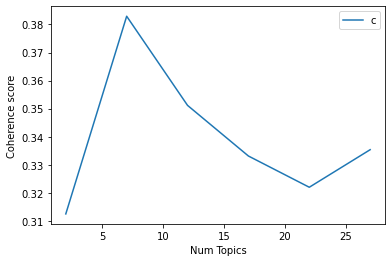

In [122]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [123]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 12

index: 0 | Num Topics = 2  has Coherence Value of 0.3125
index: 1 | Num Topics = 7  has Coherence Value of 0.3829
index: 2 | Num Topics = 12  has Coherence Value of 0.3512
index: 3 | Num Topics = 17  has Coherence Value of 0.3331
index: 4 | Num Topics = 22  has Coherence Value of 0.322
index: 5 | Num Topics = 27  has Coherence Value of 0.3354


In [197]:
# Select optimal number of topics
optimal_model_us_score1N2N3 = model_list_us_score1N2N3[1]

In [198]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_us_score1N2N3, corpus_us_score1N2N3, id2word_us_score1N2N3)

In [199]:
print("pyLDAVis for us topics for score=1,2,3:")
vis_us_score1N2N3

pyLDAVis for us topics for score=1,2,3:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.007377  0.207219       1        1  21.780775
4      0.220088 -0.050768       2        1  20.929649
3     -0.053587 -0.054297       3        1  18.217077
6     -0.023107  0.074802       4        1  14.604302
0     -0.106824 -0.099667       5        1   9.401717
5      0.081877 -0.039962       6        1   7.912850
1     -0.111069 -0.037327       7        1   7.153629, topic_info=        Term        Freq       Total Category  logprob  loglift
39      song  437.000000  437.000000  Default  30.0000  30.0000
101     load  130.000000  130.000000  Default  29.0000  29.0000
12    freeze  140.000000  140.000000  Default  28.0000  28.0000
131    error  104.000000  104.000000  Default  27.0000  27.0000
67   picture  127.000000  127.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
46     great    7.835381   82.512698   Topic7  -4.8112   0.2832
73       put    7.669409   73.307136   Topic7  -4.8326   0.3801
160   people    6.859216   50.683050   Topic7  -4.9443   0.6376
8     delete    7.334739  133.032019   Topic7  -4.8772  -0.2604
21      find    6.463353   64.325514   Topic7  -5.0037   0.3397

[476 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
312       2  0.416075        able
312       3  0.118878        able
312       4  0.356635        able
312       5  0.118878        able
592       4  0.668461  absolutely
...     ...       ...         ...
223       4  0.318625        year
223       5  0.031863        year
223       6  0.318625        year
223       7  0.159313        year
330       5  0.921747        zoom

[864 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 7, 1, 6, 2])

# By-rating of each year

## By-rating of 2018 (Rating=1,2,3)

In [127]:
# By-rating Topic Modelling - rating = 1,2,3 in 2018
# Convert to list - move to each section
review_us_2018_score1N2N3 = lomotif_ios_us_review_YearMonth_2018_score1N2N3.review.values.tolist()
review_words_us_2018_score1N2N3 = list(sent_to_words(review_us_2018_score1N2N3))
print(review_words_us_2018_score1N2N3[:1])

[['this', 'app', 'it', 'trash', 'because', 'cant', 'make', 'lit', 'video', 'then', 'when', 'its', 'done', 'and', 'its', 'loading', 'it', 'kicks', 'out', 'of', 'the', 'app', 'and', 'have', 'to', 'start', 'all', 'over', 'again', 'on', 'iphone']]


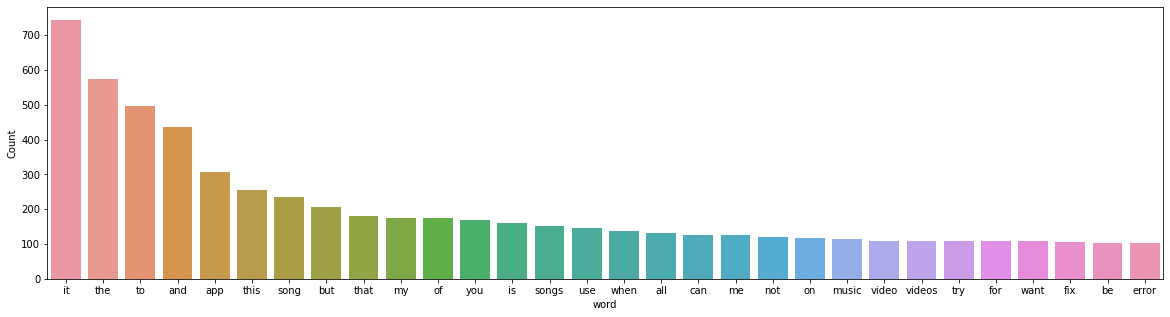

In [128]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_2018_score1N2N3))

In [129]:
# Clean text
review_words_us_ready_2018_score1N2N3 = process_words(review_words_us_2018_score1N2N3)  # processed Text Data! - move to each section

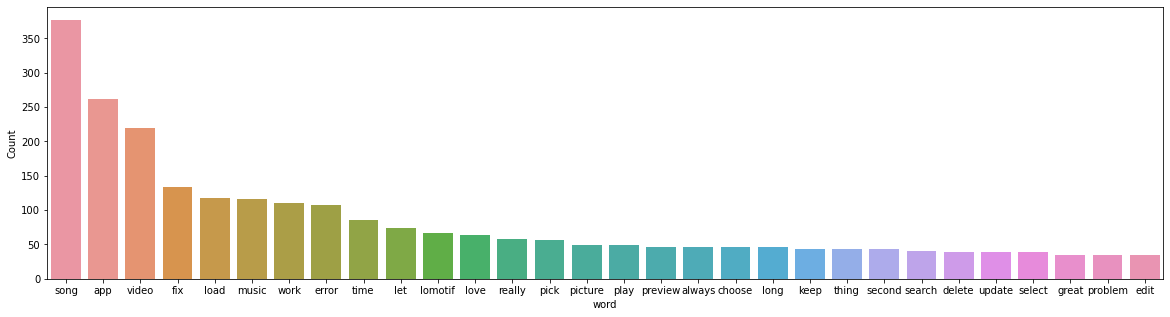

In [130]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_us_ready_2018_score1N2N3))


In [131]:
# Create Dictionary
id2word_us_2018_score1N2N3 = corpora.Dictionary(review_words_us_ready_2018_score1N2N3)

2021-10-17 03:02:47,282 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 03:02:47,297 [INFO] gensim.corpora.dictionary - built Dictionary(723 unique tokens: ['app', 'iphone', 'kick', 'light', 'loading']...) from 400 documents (total 4917 corpus positions)
2021-10-17 03:02:47,298 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(723 unique tokens: ['app', 'iphone', 'kick', 'light', 'loading']...) from 400 documents (total 4917 corpus positions)", 'datetime': '2021-10-17T03:02:47.298862', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [132]:
# Create Corpus: Term Document Frequency
corpus_us_2018_score1N2N3 = [id2word_us_2018_score1N2N3.doc2bow(text) for text in review_words_us_ready_2018_score1N2N3]

In [133]:
# Training LDA model
model_list_us_2018_score1N2N3, coherence_values_us_2018_score1N2N3 = compute_coherence_values(dictionary=id2word_us_2018_score1N2N3, corpus=corpus_us_2018_score1N2N3, 
                                                              texts=review_words_us_ready_2018_score1N2N3, limit=30, start=2, step=5)


2021-10-17 03:02:47,321 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 03:02:47,322 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 03:02:47,323 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 03:02:47,325 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 400 documents, updating model once every 400 documents, evaluating perplexity every 400 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 03:02:48,481 [INFO] gensim.models.ldamodel - -7.147 per-word bound, 141.8 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:02:48,483 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #400/400
2021-10-17 03:02:49,621 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.069*"song" + 0.059*"video" + 0.025*"app" + 0.017*"load" + 0.017*"fix" + 0.017*"picture" + 0.016*"error

2021-10-17 03:03:00,915 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.098*"song" + 0.049*"app" + 0.033*"fix" + 0.030*"load" + 0.030*"error" + 0.029*"music" + 0.028*"work" + 0.018*"let" + 0.017*"time" + 0.016*"pick"
2021-10-17 03:03:00,916 [INFO] gensim.models.ldamodel - topic diff=0.031347, rho=0.301511
2021-10-17 03:03:01,538 [INFO] gensim.models.ldamodel - -5.455 per-word bound, 43.9 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:03:01,539 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #400/400
2021-10-17 03:03:01,945 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.078*"video" + 0.044*"app" + 0.022*"picture" + 0.020*"second" + 0.019*"long" + 0.015*"song" + 0.013*"lomotif" + 0.013*"time" + 0.012*"put" + 0.011*"edit"
2021-10-17 03:03:01,948 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.099*"song" + 0.048*"app" + 0.033*"fix" + 0.031*"load" + 0.030*"error" + 0.029*"music" + 0.028*"work" + 0.019*"let" + 0.017*"

2021-10-17 03:03:10,211 [INFO] gensim.models.ldamodel - topic diff=0.010269, rho=0.218218
2021-10-17 03:03:10,787 [INFO] gensim.models.ldamodel - -5.439 per-word bound, 43.4 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:03:10,789 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #400/400
2021-10-17 03:03:11,192 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.078*"video" + 0.049*"app" + 0.022*"picture" + 0.020*"second" + 0.019*"long" + 0.014*"time" + 0.014*"lomotif" + 0.013*"edit" + 0.012*"put" + 0.011*"well"
2021-10-17 03:03:11,194 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.107*"song" + 0.045*"app" + 0.034*"fix" + 0.033*"load" + 0.032*"error" + 0.029*"music" + 0.029*"work" + 0.019*"let" + 0.016*"pick" + 0.016*"time"
2021-10-17 03:03:11,195 [INFO] gensim.models.ldamodel - topic diff=0.009203, rho=0.213201
2021-10-17 03:03:11,624 [INFO] gensim.models.ldamodel - -5.438 per-word bound, 43.4 perplexity estimate based 

2021-10-17 03:03:19,753 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #400/400
2021-10-17 03:03:20,167 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.077*"video" + 0.051*"app" + 0.022*"picture" + 0.020*"second" + 0.020*"long" + 0.015*"lomotif" + 0.015*"time" + 0.013*"edit" + 0.011*"put" + 0.011*"well"
2021-10-17 03:03:20,169 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.110*"song" + 0.044*"app" + 0.034*"fix" + 0.034*"load" + 0.032*"error" + 0.029*"music" + 0.029*"work" + 0.019*"let" + 0.017*"pick" + 0.016*"time"
2021-10-17 03:03:20,170 [INFO] gensim.models.ldamodel - topic diff=0.004206, rho=0.176777
2021-10-17 03:03:20,776 [INFO] gensim.models.ldamodel - -5.435 per-word bound, 43.3 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:03:20,780 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #400/400
2021-10-17 03:03:21,039 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.077*"video" + 0.051*"app" + 

2021-10-17 03:03:28,938 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.111*"song" + 0.043*"app" + 0.034*"load" + 0.034*"fix" + 0.032*"error" + 0.029*"music" + 0.028*"work" + 0.019*"let" + 0.017*"pick" + 0.015*"time"
2021-10-17 03:03:28,940 [INFO] gensim.models.ldamodel - topic diff=0.002776, rho=0.154303
2021-10-17 03:03:29,412 [INFO] gensim.models.ldamodel - -5.434 per-word bound, 43.2 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:03:29,413 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #400/400
2021-10-17 03:03:29,761 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.077*"video" + 0.052*"app" + 0.022*"picture" + 0.020*"long" + 0.020*"second" + 0.016*"lomotif" + 0.015*"time" + 0.013*"edit" + 0.011*"put" + 0.011*"well"
2021-10-17 03:03:29,765 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.111*"song" + 0.043*"app" + 0.034*"load" + 0.034*"fix" + 0.032*"error" + 0.029*"music" + 0.028*"work" + 0.019*"let" + 0.017*"

2021-10-17 03:03:41,426 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 03:03:41,427 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 03:03:41,431 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 03:03:41,434 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 400 documents, updating model once every 400 documents, evaluating perplexity every 400 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 03:03:42,533 [INFO] gensim.models.ldamodel - -8.284 per-word bound, 311.7 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:03:42,534 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #400/400
2021-10-17 03:03:43,341 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.075*"video" + 0.054*"app" + 0.031*"lomotif" + 0.024*"long" + 0.021*"fi

2021-10-17 03:03:48,027 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #400/400
2021-10-17 03:03:48,414 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.074*"song" + 0.039*"fix" + 0.038*"load" + 0.034*"video" + 0.029*"app" + 0.025*"error" + 0.022*"music" + 0.019*"thing" + 0.017*"click" + 0.016*"always"
2021-10-17 03:03:48,416 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.069*"app" + 0.044*"video" + 0.033*"music" + 0.029*"song" + 0.022*"really" + 0.020*"people" + 0.019*"time" + 0.014*"let" + 0.013*"fix" + 0.013*"second"
2021-10-17 03:03:48,418 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.064*"song" + 0.033*"video" + 0.030*"work" + 0.029*"update" + 0.015*"second" + 0.015*"back" + 0.015*"guy" + 0.014*"hate" + 0.013*"picture" + 0.013*"freeze"
2021-10-17 03:03:48,420 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.104*"song" + 0.050*"error" + 0.049*"app" + 0.039*"fix" + 0.039*"pick" + 0.034*"let" + 0.025*"time" + 0.024*"video" + 0.023*"load" + 0.020*"music

2021-10-17 03:03:53,344 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.061*"song" + 0.032*"update" + 0.030*"video" + 0.029*"work" + 0.016*"freeze" + 0.015*"minute" + 0.015*"hate" + 0.014*"back" + 0.014*"picture" + 0.013*"guy"
2021-10-17 03:03:53,347 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.109*"song" + 0.052*"app" + 0.051*"error" + 0.042*"pick" + 0.041*"fix" + 0.036*"let" + 0.026*"time" + 0.024*"load" + 0.022*"video" + 0.019*"music"
2021-10-17 03:03:53,350 [INFO] gensim.models.ldamodel - topic diff=0.023099, rho=0.288675
2021-10-17 03:03:53,896 [INFO] gensim.models.ldamodel - -5.737 per-word bound, 53.3 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:03:53,897 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #400/400
2021-10-17 03:03:54,280 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.109*"song" + 0.052*"app" + 0.051*"error" + 0.042*"pick" + 0.041*"fix" + 0.036*"let" + 0.026*"time" + 0.024*"load" + 0.022

2021-10-17 03:03:59,092 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.084*"song" + 0.066*"app" + 0.049*"work" + 0.034*"fix" + 0.034*"music" + 0.026*"love" + 0.023*"load" + 0.021*"delete" + 0.019*"error" + 0.018*"always"
2021-10-17 03:03:59,095 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.062*"song" + 0.033*"update" + 0.029*"work" + 0.028*"video" + 0.017*"freeze" + 0.016*"minute" + 0.014*"picture" + 0.014*"hate" + 0.013*"new" + 0.013*"back"
2021-10-17 03:03:59,097 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.096*"video" + 0.054*"app" + 0.039*"lomotif" + 0.035*"long" + 0.031*"picture" + 0.031*"second" + 0.022*"work" + 0.019*"time" + 0.019*"love" + 0.018*"fix"
2021-10-17 03:03:59,099 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.129*"song" + 0.037*"load" + 0.026*"error" + 0.025*"video" + 0.024*"work" + 0.023*"keep" + 0.021*"preview" + 0.020*"select" + 0.017*"certain" + 0.015*"part"
2021-10-17 03:03:59,101 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.068*"a

2021-10-17 03:04:03,676 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.084*"song" + 0.066*"app" + 0.049*"work" + 0.035*"fix" + 0.034*"music" + 0.026*"love" + 0.024*"load" + 0.022*"delete" + 0.019*"error" + 0.018*"always"
2021-10-17 03:04:03,676 [INFO] gensim.models.ldamodel - topic diff=0.008542, rho=0.208514
2021-10-17 03:04:04,208 [INFO] gensim.models.ldamodel - -5.723 per-word bound, 52.8 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:04:04,211 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #400/400
2021-10-17 03:04:04,558 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.128*"song" + 0.037*"load" + 0.025*"error" + 0.025*"video" + 0.024*"work" + 0.022*"keep" + 0.020*"preview" + 0.020*"select" + 0.018*"certain" + 0.015*"part"
2021-10-17 03:04:04,561 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.080*"song" + 0.039*"load" + 0.036*"fix" + 0.034*"video" + 0.026*"app" + 0.023*"error" + 0.023*"thing" + 0.019*"music

2021-10-17 03:04:09,680 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.064*"song" + 0.034*"update" + 0.028*"work" + 0.019*"video" + 0.017*"freeze" + 0.017*"minute" + 0.015*"hate" + 0.014*"stop" + 0.014*"new" + 0.013*"back"
2021-10-17 03:04:09,682 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.127*"song" + 0.036*"load" + 0.025*"video" + 0.025*"error" + 0.025*"work" + 0.022*"keep" + 0.020*"select" + 0.020*"preview" + 0.018*"certain" + 0.015*"part"
2021-10-17 03:04:09,683 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.068*"app" + 0.043*"video" + 0.036*"music" + 0.024*"people" + 0.022*"really" + 0.016*"time" + 0.014*"song" + 0.014*"love" + 0.012*"put" + 0.012*"let"
2021-10-17 03:04:09,684 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.115*"song" + 0.052*"error" + 0.051*"app" + 0.042*"pick" + 0.042*"fix" + 0.038*"let" + 0.026*"time" + 0.024*"load" + 0.020*"music" + 0.019*"play"
2021-10-17 03:04:09,685 [INFO] gensim.models.ldamodel - topic diff=0.005338, rho=0.185695
2021

2021-10-17 03:04:14,789 [INFO] gensim.models.ldamodel - topic diff=0.004657, rho=0.171499
2021-10-17 03:04:15,320 [INFO] gensim.models.ldamodel - -5.718 per-word bound, 52.6 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:04:15,322 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #400/400
2021-10-17 03:04:15,737 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.100*"video" + 0.055*"app" + 0.039*"lomotif" + 0.035*"picture" + 0.035*"long" + 0.031*"second" + 0.021*"work" + 0.020*"time" + 0.019*"fix" + 0.018*"love"
2021-10-17 03:04:15,740 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.080*"song" + 0.039*"load" + 0.036*"fix" + 0.035*"video" + 0.026*"app" + 0.023*"thing" + 0.022*"error" + 0.019*"music" + 0.018*"click" + 0.017*"always"
2021-10-17 03:04:15,743 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.118*"song" + 0.052*"error" + 0.051*"app" + 0.042*"fix" + 0.042*"pick" + 0.039*"let" + 0.026*"time" + 0.024*"load" + 0.

2021-10-17 03:04:20,760 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.082*"song" + 0.065*"app" + 0.050*"work" + 0.034*"fix" + 0.034*"music" + 0.025*"love" + 0.025*"load" + 0.023*"delete" + 0.019*"always" + 0.018*"error"
2021-10-17 03:04:20,771 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.064*"song" + 0.035*"update" + 0.028*"work" + 0.018*"freeze" + 0.018*"minute" + 0.016*"video" + 0.015*"hate" + 0.015*"stop" + 0.014*"new" + 0.013*"back"
2021-10-17 03:04:20,781 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.120*"song" + 0.053*"error" + 0.051*"app" + 0.042*"fix" + 0.041*"pick" + 0.040*"let" + 0.026*"time" + 0.025*"load" + 0.020*"play" + 0.020*"music"
2021-10-17 03:04:20,782 [INFO] gensim.models.ldamodel - topic diff=0.003845, rho=0.158114
2021-10-17 03:04:21,235 [INFO] gensim.models.ldamodel - -5.716 per-word bound, 52.6 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:04:21,237 [INFO] gensim.models.ldamodel - PROGRESS: pass 

2021-10-17 03:04:25,938 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #400/400
2021-10-17 03:04:26,286 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.068*"app" + 0.043*"video" + 0.037*"music" + 0.024*"people" + 0.022*"really" + 0.016*"time" + 0.014*"love" + 0.013*"put" + 0.011*"let" + 0.011*"song"
2021-10-17 03:04:26,287 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.121*"song" + 0.053*"error" + 0.051*"app" + 0.042*"fix" + 0.041*"pick" + 0.040*"let" + 0.026*"time" + 0.025*"load" + 0.021*"play" + 0.020*"music"
2021-10-17 03:04:26,289 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.124*"song" + 0.036*"load" + 0.026*"video" + 0.026*"work" + 0.024*"error" + 0.022*"keep" + 0.021*"select" + 0.019*"preview" + 0.016*"certain" + 0.015*"part"
2021-10-17 03:04:26,290 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.082*"song" + 0.065*"app" + 0.049*"work" + 0.034*"fix" + 0.034*"music" + 0.025*"load" + 0.025*"love" + 0.023*"delete" + 0.019*"always" + 0.017*"error"


2021-10-17 03:04:30,916 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.123*"song" + 0.036*"load" + 0.026*"video" + 0.026*"work" + 0.024*"error" + 0.022*"keep" + 0.021*"select" + 0.019*"preview" + 0.016*"certain" + 0.015*"part"
2021-10-17 03:04:30,917 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.100*"video" + 0.055*"app" + 0.038*"lomotif" + 0.038*"picture" + 0.035*"long" + 0.031*"second" + 0.021*"time" + 0.020*"work" + 0.019*"fix" + 0.018*"love"
2021-10-17 03:04:30,919 [INFO] gensim.models.ldamodel - topic diff=0.003107, rho=0.140028
2021-10-17 03:04:30,920 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=723, num_topics=7, decay=0.5, chunksize=1000) in 49.49s', 'datetime': '2021-10-17T03:04:30.920043', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-17 03:04:30,924 [INFO] gensim.topic_coherence.probability_estimation - using Par

2021-10-17 03:04:41,226 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.049*"load" + 0.044*"fix" + 0.042*"song" + 0.041*"music" + 0.028*"video" + 0.023*"app" + 0.022*"keep" + 0.020*"error" + 0.020*"work" + 0.018*"thing"
2021-10-17 03:04:41,233 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.102*"video" + 0.059*"app" + 0.048*"long" + 0.042*"second" + 0.039*"picture" + 0.028*"love" + 0.025*"lomotif" + 0.022*"fix" + 0.019*"time" + 0.016*"work"
2021-10-17 03:04:41,236 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.069*"video" + 0.044*"song" + 0.035*"part" + 0.024*"fix" + 0.022*"app" + 0.020*"certain" + 0.017*"change" + 0.016*"music" + 0.016*"delete" + 0.016*"load"
2021-10-17 03:04:41,239 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.062*"song" + 0.042*"work" + 0.042*"app" + 0.038*"video" + 0.027*"lomotif" + 0.022*"fix" + 0.018*"delete" + 0.018*"love" + 0.017*"update" + 0.016*"problem"
2021-10-17 03:04:41,242 [INFO] gensim.models.ldamodel - topic diff=0.083371, rho=0.4082

2021-10-17 03:04:46,034 [INFO] gensim.models.ldamodel - topic diff=0.036106, rho=0.301511
2021-10-17 03:04:46,571 [INFO] gensim.models.ldamodel - -5.885 per-word bound, 59.1 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:04:46,573 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #400/400
2021-10-17 03:04:46,966 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.051*"load" + 0.043*"fix" + 0.039*"music" + 0.034*"song" + 0.025*"video" + 0.023*"app" + 0.021*"none" + 0.020*"keep" + 0.019*"thing" + 0.019*"work"
2021-10-17 03:04:46,970 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.036*"song" + 0.034*"picture" + 0.033*"video" + 0.032*"update" + 0.028*"lomotif" + 0.028*"app" + 0.025*"hate" + 0.022*"thing" + 0.020*"put" + 0.017*"new"
2021-10-17 03:04:46,973 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.068*"video" + 0.043*"song" + 0.040*"part" + 0.027*"fix" + 0.021*"save" + 0.020*"certain" + 0.019*"change" + 0.018*"update"

2021-10-17 03:04:51,630 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.053*"song" + 0.050*"app" + 0.044*"work" + 0.042*"video" + 0.034*"lomotif" + 0.022*"delete" + 0.021*"problem" + 0.020*"fix" + 0.018*"update" + 0.016*"love"
2021-10-17 03:04:51,633 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.059*"app" + 0.035*"watermark" + 0.033*"song" + 0.026*"video" + 0.024*"pay" + 0.020*"music" + 0.018*"really" + 0.018*"way" + 0.013*"let" + 0.012*"look"
2021-10-17 03:04:51,639 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.075*"app" + 0.057*"music" + 0.051*"work" + 0.049*"fix" + 0.045*"song" + 0.034*"error" + 0.026*"never" + 0.023*"love" + 0.022*"keep" + 0.020*"great"
2021-10-17 03:04:51,645 [INFO] gensim.models.ldamodel - topic diff=0.017044, rho=0.242536
2021-10-17 03:04:52,179 [INFO] gensim.models.ldamodel - -5.866 per-word bound, 58.3 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:04:52,180 [INFO] gensim.models.ldamodel - PROGRESS

2021-10-17 03:04:56,723 [INFO] gensim.models.ldamodel - -5.858 per-word bound, 58.0 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:04:56,725 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #400/400
2021-10-17 03:04:57,053 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.147*"song" + 0.056*"app" + 0.045*"error" + 0.035*"load" + 0.034*"fix" + 0.028*"always" + 0.026*"preview" + 0.024*"video" + 0.023*"pick" + 0.023*"play"
2021-10-17 03:04:57,055 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.117*"video" + 0.061*"long" + 0.057*"app" + 0.052*"second" + 0.045*"picture" + 0.026*"love" + 0.020*"time" + 0.020*"lomotif" + 0.017*"fix" + 0.015*"put"
2021-10-17 03:04:57,056 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.055*"load" + 0.040*"fix" + 0.036*"music" + 0.028*"song" + 0.025*"video" + 0.025*"none" + 0.022*"app" + 0.021*"keep" + 0.020*"thing" + 0.020*"people"
2021-10-17 03:04:57,057 [INFO] gensim.models.ldamodel - top

2021-10-17 03:05:01,548 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.052*"song" + 0.051*"app" + 0.048*"work" + 0.043*"video" + 0.034*"lomotif" + 0.025*"delete" + 0.023*"problem" + 0.019*"update" + 0.018*"fix" + 0.016*"love"
2021-10-17 03:05:01,549 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.065*"video" + 0.042*"song" + 0.039*"music" + 0.032*"work" + 0.027*"lomotif" + 0.025*"well" + 0.022*"app" + 0.021*"allow" + 0.021*"play" + 0.019*"really"
2021-10-17 03:05:01,550 [INFO] gensim.models.ldamodel - topic diff=0.008822, rho=0.188982
2021-10-17 03:05:02,057 [INFO] gensim.models.ldamodel - -5.848 per-word bound, 57.6 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:05:02,058 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #400/400
2021-10-17 03:05:02,476 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.065*"video" + 0.042*"song" + 0.039*"music" + 0.032*"work" + 0.027*"lomotif" + 0.026*"well" + 0.022*"app" + 0.021

2021-10-17 03:05:07,154 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.072*"video" + 0.040*"part" + 0.036*"song" + 0.028*"fix" + 0.025*"save" + 0.020*"certain" + 0.019*"blurry" + 0.019*"change" + 0.019*"update" + 0.019*"load"
2021-10-17 03:05:07,156 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.078*"app" + 0.066*"music" + 0.053*"fix" + 0.049*"work" + 0.042*"song" + 0.034*"error" + 0.027*"never" + 0.023*"keep" + 0.022*"love" + 0.022*"great"
2021-10-17 03:05:07,157 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.033*"update" + 0.032*"song" + 0.031*"lomotif" + 0.031*"app" + 0.028*"iphone" + 0.026*"picture" + 0.026*"hate" + 0.026*"video" + 0.025*"thing" + 0.025*"new"
2021-10-17 03:05:07,159 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.066*"video" + 0.041*"song" + 0.039*"music" + 0.032*"work" + 0.028*"lomotif" + 0.026*"well" + 0.022*"allow" + 0.020*"app" + 0.020*"play" + 0.019*"really"
2021-10-17 03:05:07,160 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.052*"pi

2021-10-17 03:05:11,554 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.117*"video" + 0.060*"long" + 0.057*"app" + 0.054*"second" + 0.049*"picture" + 0.025*"love" + 0.021*"time" + 0.019*"lomotif" + 0.017*"fix" + 0.016*"fast"
2021-10-17 03:05:11,555 [INFO] gensim.models.ldamodel - topic diff=0.006262, rho=0.160128
2021-10-17 03:05:12,051 [INFO] gensim.models.ldamodel - -5.836 per-word bound, 57.1 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:05:12,053 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #400/400
2021-10-17 03:05:12,433 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.054*"load" + 0.039*"fix" + 0.035*"none" + 0.032*"music" + 0.028*"song" + 0.027*"video" + 0.020*"thing" + 0.020*"keep" + 0.020*"app" + 0.020*"people"
2021-10-17 03:05:12,435 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.060*"app" + 0.036*"watermark" + 0.033*"song" + 0.026*"video" + 0.024*"pay" + 0.021*"music" + 0.018*"really" + 0.018*"way

2021-10-17 03:05:16,730 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.032*"song" + 0.032*"lomotif" + 0.032*"app" + 0.031*"update" + 0.030*"iphone" + 0.026*"hate" + 0.026*"video" + 0.026*"new" + 0.026*"thing" + 0.022*"picture"
2021-10-17 03:05:16,737 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.051*"work" + 0.051*"song" + 0.049*"app" + 0.042*"video" + 0.035*"lomotif" + 0.025*"delete" + 0.024*"problem" + 0.020*"update" + 0.017*"fix" + 0.016*"love"
2021-10-17 03:05:16,740 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.072*"video" + 0.041*"part" + 0.031*"song" + 0.027*"fix" + 0.024*"save" + 0.021*"certain" + 0.020*"load" + 0.020*"music" + 0.019*"blurry" + 0.019*"update"
2021-10-17 03:05:16,746 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.117*"video" + 0.060*"long" + 0.056*"app" + 0.055*"second" + 0.050*"picture" + 0.025*"love" + 0.021*"time" + 0.019*"lomotif" + 0.017*"fix" + 0.016*"fast"
2021-10-17 03:05:16,751 [INFO] gensim.models.ldamodel - topic diff=0.005655, r

2021-10-17 03:05:20,933 [INFO] gensim.models.ldamodel - topic diff=0.004470, rho=0.141421
2021-10-17 03:05:21,420 [INFO] gensim.models.ldamodel - -5.829 per-word bound, 56.9 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:05:21,421 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #400/400
2021-10-17 03:05:21,738 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.117*"video" + 0.060*"long" + 0.056*"app" + 0.055*"second" + 0.050*"picture" + 0.025*"love" + 0.020*"time" + 0.018*"lomotif" + 0.017*"fix" + 0.016*"fast"
2021-10-17 03:05:21,739 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.033*"lomotif" + 0.032*"song" + 0.032*"app" + 0.030*"iphone" + 0.030*"update" + 0.026*"hate" + 0.026*"new" + 0.026*"video" + 0.026*"thing" + 0.021*"picture"
2021-10-17 03:05:21,740 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.064*"app" + 0.033*"video" + 0.030*"music" + 0.021*"really" + 0.021*"people" + 0.020*"let" + 0.019*"put" + 0.018*"

2021-10-17 03:05:32,155 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.119*"song" + 0.062*"error" + 0.058*"app" + 0.046*"fix" + 0.032*"choose" + 0.022*"load" + 0.021*"always" + 0.020*"time" + 0.019*"pick" + 0.018*"work"
2021-10-17 03:05:32,157 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.072*"song" + 0.058*"music" + 0.053*"app" + 0.045*"fix" + 0.043*"load" + 0.041*"play" + 0.029*"guy" + 0.026*"error" + 0.023*"video" + 0.021*"available"
2021-10-17 03:05:32,158 [INFO] gensim.models.ldamodel - topic diff=0.099327, rho=0.447214
2021-10-17 03:05:32,679 [INFO] gensim.models.ldamodel - -6.052 per-word bound, 66.4 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:05:32,680 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #400/400
2021-10-17 03:05:33,063 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.052*"app" + 0.037*"video" + 0.023*"music" + 0.023*"really" + 0.015*"special" + 0.015*"effect" + 0.015*"almost" + 0.015*"lo

2021-10-17 03:05:37,302 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.079*"song" + 0.058*"let" + 0.046*"app" + 0.040*"pick" + 0.032*"error" + 0.029*"time" + 0.024*"still" + 0.019*"fix" + 0.016*"delete" + 0.016*"music"
2021-10-17 03:05:37,305 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.045*"song" + 0.044*"video" + 0.043*"work" + 0.028*"app" + 0.023*"add" + 0.022*"people" + 0.021*"great" + 0.020*"music" + 0.018*"keep" + 0.017*"instead"
2021-10-17 03:05:37,310 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.076*"song" + 0.049*"app" + 0.042*"video" + 0.037*"lomotif" + 0.032*"let" + 0.031*"fix" + 0.025*"load" + 0.025*"love" + 0.022*"pick" + 0.022*"really"
2021-10-17 03:05:37,313 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.054*"app" + 0.038*"video" + 0.023*"music" + 0.023*"really" + 0.016*"special" + 0.016*"effect" + 0.016*"look" + 0.016*"artist" + 0.016*"bit" + 0.016*"happen"
2021-10-17 03:05:37,316 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.062*"work" + 

2021-10-17 03:05:41,677 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.044*"song" + 0.044*"work" + 0.043*"video" + 0.028*"app" + 0.023*"add" + 0.023*"people" + 0.021*"great" + 0.020*"music" + 0.017*"keep" + 0.017*"instead"
2021-10-17 03:05:41,678 [INFO] gensim.models.ldamodel - topic diff=0.019639, rho=0.250000
2021-10-17 03:05:42,113 [INFO] gensim.models.ldamodel - -5.968 per-word bound, 62.6 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:05:42,115 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #400/400
2021-10-17 03:05:42,462 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.075*"song" + 0.065*"music" + 0.060*"app" + 0.049*"play" + 0.048*"fix" + 0.037*"load" + 0.031*"available" + 0.030*"guy" + 0.028*"error" + 0.021*"issue"
2021-10-17 03:05:42,465 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.054*"app" + 0.038*"video" + 0.023*"music" + 0.023*"really" + 0.020*"effect" + 0.016*"special" + 0.016*"look" + 0.016*"a

2021-10-17 03:05:46,703 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.119*"music" + 0.047*"app" + 0.037*"love" + 0.030*"fix" + 0.025*"play" + 0.022*"time" + 0.019*"half" + 0.019*"pick" + 0.018*"choose" + 0.017*"work"
2021-10-17 03:05:46,706 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.092*"video" + 0.060*"app" + 0.049*"picture" + 0.048*"long" + 0.040*"time" + 0.032*"love" + 0.022*"fix" + 0.021*"back" + 0.020*"lomotif" + 0.018*"slow"
2021-10-17 03:05:46,707 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.072*"song" + 0.049*"app" + 0.043*"video" + 0.040*"lomotif" + 0.031*"let" + 0.030*"fix" + 0.026*"love" + 0.025*"pick" + 0.024*"load" + 0.022*"really"
2021-10-17 03:05:46,711 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.059*"video" + 0.054*"song" + 0.043*"app" + 0.030*"edit" + 0.029*"really" + 0.028*"play" + 0.026*"let" + 0.019*"work" + 0.019*"preview" + 0.018*"music"
2021-10-17 03:05:46,712 [INFO] gensim.models.ldamodel - topic diff=0.011044, rho=0.213201
2021-1

2021-10-17 03:05:50,702 [INFO] gensim.models.ldamodel - topic diff=0.007620, rho=0.192450
2021-10-17 03:05:51,200 [INFO] gensim.models.ldamodel - -5.948 per-word bound, 61.7 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:05:51,202 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #400/400
2021-10-17 03:05:51,579 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.060*"app" + 0.027*"video" + 0.022*"music" + 0.021*"picture" + 0.018*"give" + 0.016*"put" + 0.016*"time" + 0.015*"star" + 0.015*"add" + 0.014*"never"
2021-10-17 03:05:51,582 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.189*"song" + 0.071*"load" + 0.036*"preview" + 0.035*"search" + 0.034*"certain" + 0.026*"click" + 0.026*"select" + 0.023*"fix" + 0.023*"error" + 0.021*"thing"
2021-10-17 03:05:51,584 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.093*"video" + 0.061*"app" + 0.049*"picture" + 0.048*"long" + 0.040*"time" + 0.032*"love" + 0.022*"fix" + 0.021*"bac

2021-10-17 03:05:55,844 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.078*"work" + 0.045*"video" + 0.042*"delete" + 0.031*"app" + 0.028*"update" + 0.028*"lomotif" + 0.027*"song" + 0.025*"phone" + 0.025*"load" + 0.022*"start"
2021-10-17 03:05:55,848 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.077*"select" + 0.057*"song" + 0.024*"app" + 0.023*"work" + 0.016*"tell" + 0.015*"kpop" + 0.015*"forever" + 0.015*"variety" + 0.015*"wide" + 0.015*"reinstall"
2021-10-17 03:05:55,850 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.130*"song" + 0.073*"error" + 0.059*"app" + 0.050*"fix" + 0.030*"choose" + 0.029*"always" + 0.022*"time" + 0.022*"pick" + 0.020*"load" + 0.017*"work"
2021-10-17 03:05:55,852 [INFO] gensim.models.ldamodel - topic diff=0.005153, rho=0.174078
2021-10-17 03:05:56,412 [INFO] gensim.models.ldamodel - -5.943 per-word bound, 61.5 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:05:56,413 [INFO] gensim.models.ldamodel 

2021-10-17 03:06:00,723 [INFO] gensim.models.ldamodel - -5.941 per-word bound, 61.4 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:06:00,725 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #400/400
2021-10-17 03:06:01,160 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.064*"song" + 0.052*"app" + 0.045*"video" + 0.042*"lomotif" + 0.030*"let" + 0.028*"fix" + 0.026*"love" + 0.026*"pick" + 0.022*"really" + 0.022*"flipagram"
2021-10-17 03:06:01,161 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.077*"song" + 0.066*"music" + 0.066*"app" + 0.051*"play" + 0.047*"fix" + 0.039*"load" + 0.031*"available" + 0.031*"guy" + 0.024*"error" + 0.022*"none"
2021-10-17 03:06:01,163 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.077*"work" + 0.044*"video" + 0.042*"delete" + 0.031*"app" + 0.028*"update" + 0.028*"lomotif" + 0.027*"song" + 0.025*"phone" + 0.025*"load" + 0.022*"start"
2021-10-17 03:06:01,165 [INFO] gensim.models.ldamode

2021-10-17 03:06:05,550 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.059*"app" + 0.027*"video" + 0.023*"music" + 0.021*"picture" + 0.018*"give" + 0.016*"time" + 0.016*"put" + 0.015*"star" + 0.015*"add" + 0.014*"never"
2021-10-17 03:06:05,552 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.081*"select" + 0.057*"song" + 0.022*"work" + 0.017*"tell" + 0.016*"app" + 0.016*"kpop" + 0.016*"forever" + 0.016*"variety" + 0.016*"wide" + 0.016*"reinstall"
2021-10-17 03:06:05,553 [INFO] gensim.models.ldamodel - topic diff=0.003634, rho=0.150756
2021-10-17 03:06:06,164 [INFO] gensim.models.ldamodel - -5.938 per-word bound, 61.3 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:06:06,165 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #400/400
2021-10-17 03:06:06,557 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.053*"app" + 0.038*"video" + 0.023*"music" + 0.023*"really" + 0.023*"effect" + 0.016*"special" + 0.016*"look" + 0.0

2021-10-17 03:06:10,491 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #400/400
2021-10-17 03:06:10,850 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.132*"music" + 0.046*"app" + 0.036*"love" + 0.029*"fix" + 0.029*"play" + 0.021*"unavailable" + 0.020*"never" + 0.019*"time" + 0.019*"work" + 0.018*"half"
2021-10-17 03:06:10,853 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.059*"app" + 0.027*"video" + 0.023*"music" + 0.022*"picture" + 0.018*"give" + 0.016*"time" + 0.016*"put" + 0.016*"star" + 0.016*"add" + 0.013*"never"
2021-10-17 03:06:10,857 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.128*"song" + 0.072*"error" + 0.058*"app" + 0.051*"fix" + 0.031*"choose" + 0.029*"always" + 0.023*"pick" + 0.021*"time" + 0.019*"load" + 0.017*"love"
2021-10-17 03:06:10,860 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.082*"select" + 0.057*"song" + 0.021*"work" + 0.018*"tell" + 0.016*"kpop" + 0.016*"forever" + 0.016*"variety" + 0.016*"wide" + 0.016*"reinstall" + 0

2021-10-17 03:06:21,356 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.088*"song" + 0.072*"app" + 0.043*"video" + 0.030*"music" + 0.028*"work" + 0.028*"search" + 0.027*"error" + 0.024*"always" + 0.021*"love" + 0.020*"time"
2021-10-17 03:06:21,358 [INFO] gensim.models.ldamodel - topic diff=0.126353, rho=0.500000
2021-10-17 03:06:21,883 [INFO] gensim.models.ldamodel - -6.221 per-word bound, 74.6 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:06:21,884 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #400/400
2021-10-17 03:06:22,358 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.087*"video" + 0.055*"app" + 0.039*"song" + 0.032*"fix" + 0.028*"second" + 0.026*"long" + 0.021*"really" + 0.020*"music" + 0.020*"error" + 0.018*"work"
2021-10-17 03:06:22,361 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.069*"fix" + 0.045*"guy" + 0.041*"song" + 0.041*"issue" + 0.039*"music" + 0.028*"error" + 0.025*"load" + 0.023*"slow" +

2021-10-17 03:06:26,624 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.093*"song" + 0.064*"app" + 0.044*"video" + 0.033*"search" + 0.028*"music" + 0.025*"work" + 0.022*"error" + 0.021*"always" + 0.018*"time" + 0.017*"click"
2021-10-17 03:06:26,625 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.088*"app" + 0.064*"video" + 0.029*"picture" + 0.028*"people" + 0.026*"second" + 0.023*"put" + 0.022*"stuff" + 0.021*"let" + 0.021*"love" + 0.019*"add"
2021-10-17 03:06:26,628 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.035*"video" + 0.035*"app" + 0.035*"song" + 0.027*"work" + 0.026*"problem" + 0.025*"first" + 0.025*"change" + 0.020*"great" + 0.018*"time" + 0.018*"add"
2021-10-17 03:06:26,630 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.080*"music" + 0.056*"app" + 0.027*"find" + 0.024*"help" + 0.022*"choose" + 0.020*"problem" + 0.020*"lomotif" + 0.019*"edit" + 0.019*"flipgram" + 0.019*"still"
2021-10-17 03:06:26,632 [INFO] gensim.models.ldamodel - topic diff=0.056672, rh

2021-10-17 03:06:30,801 [INFO] gensim.models.ldamodel - topic diff=0.027168, rho=0.258199
2021-10-17 03:06:31,347 [INFO] gensim.models.ldamodel - -6.067 per-word bound, 67.0 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:06:31,350 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #400/400
2021-10-17 03:06:31,676 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.092*"video" + 0.059*"app" + 0.032*"fix" + 0.031*"second" + 0.028*"song" + 0.027*"long" + 0.021*"really" + 0.020*"music" + 0.018*"enjoy" + 0.017*"error"
2021-10-17 03:06:31,678 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.065*"song" + 0.031*"choose" + 0.031*"watermark" + 0.027*"video" + 0.025*"picture" + 0.024*"app" + 0.024*"love" + 0.024*"pay" + 0.024*"look" + 0.017*"error"
2021-10-17 03:06:31,681 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.088*"app" + 0.066*"video" + 0.032*"people" + 0.028*"picture" + 0.026*"second" + 0.024*"put" + 0.023*"stuff" + 0.

2021-10-17 03:06:35,904 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.082*"music" + 0.057*"app" + 0.034*"find" + 0.027*"edit" + 0.023*"help" + 0.021*"choose" + 0.018*"flipgram" + 0.018*"definitely" + 0.018*"still" + 0.018*"lomotif"
2021-10-17 03:06:35,907 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.088*"app" + 0.067*"video" + 0.033*"people" + 0.028*"picture" + 0.026*"second" + 0.024*"put" + 0.023*"stuff" + 0.021*"love" + 0.020*"add" + 0.018*"let"
2021-10-17 03:06:35,911 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.100*"song" + 0.078*"load" + 0.053*"app" + 0.041*"video" + 0.039*"music" + 0.033*"work" + 0.027*"let" + 0.026*"lomotif" + 0.023*"time" + 0.015*"error"
2021-10-17 03:06:35,915 [INFO] gensim.models.ldamodel - topic diff=0.013757, rho=0.218218
2021-10-17 03:06:36,439 [INFO] gensim.models.ldamodel - -6.051 per-word bound, 66.3 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:06:36,440 [INFO] gensim.models.ldamodel

2021-10-17 03:06:40,346 [INFO] gensim.models.ldamodel - topic diff=0.009130, rho=0.196116
2021-10-17 03:06:40,805 [INFO] gensim.models.ldamodel - -6.043 per-word bound, 65.9 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:06:40,806 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #400/400
2021-10-17 03:06:41,186 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.035*"app" + 0.035*"video" + 0.034*"song" + 0.028*"work" + 0.026*"problem" + 0.026*"first" + 0.026*"change" + 0.019*"great" + 0.018*"time" + 0.017*"delete"
2021-10-17 03:06:41,187 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.152*"song" + 0.059*"pick" + 0.036*"fix" + 0.033*"time" + 0.031*"never" + 0.026*"work" + 0.023*"look" + 0.022*"load" + 0.021*"always" + 0.019*"different"
2021-10-17 03:06:41,188 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.066*"app" + 0.028*"music" + 0.020*"video" + 0.019*"song" + 0.019*"load" + 0.019*"angry" + 0.019*"special" + 0.019

2021-10-17 03:06:45,664 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.086*"song" + 0.048*"video" + 0.028*"available" + 0.026*"preview" + 0.021*"load" + 0.020*"lomotif" + 0.020*"thing" + 0.019*"app" + 0.018*"time" + 0.018*"error"
2021-10-17 03:06:45,666 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.051*"song" + 0.033*"kpop" + 0.033*"work" + 0.033*"forever" + 0.032*"variety" + 0.032*"wide" + 0.025*"unable" + 0.017*"play" + 0.017*"long" + 0.017*"time"
2021-10-17 03:06:45,667 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.055*"music" + 0.035*"song" + 0.033*"play" + 0.031*"work" + 0.028*"really" + 0.027*"phone" + 0.026*"app" + 0.023*"download" + 0.022*"half" + 0.021*"well"
2021-10-17 03:06:45,668 [INFO] gensim.models.ldamodel - topic diff=0.006469, rho=0.176777
2021-10-17 03:06:46,101 [INFO] gensim.models.ldamodel - -6.035 per-word bound, 65.6 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:06:46,102 [INFO] gensim.models.ldam

2021-10-17 03:06:50,427 [INFO] gensim.models.ldamodel - -6.030 per-word bound, 65.3 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:06:50,429 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #400/400
2021-10-17 03:06:50,800 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.055*"song" + 0.045*"video" + 0.040*"keep" + 0.037*"music" + 0.030*"app" + 0.022*"download" + 0.022*"forever" + 0.022*"load" + 0.020*"one" + 0.016*"phone"
2021-10-17 03:06:50,801 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.078*"song" + 0.058*"work" + 0.031*"update" + 0.025*"app" + 0.024*"problem" + 0.023*"load" + 0.023*"slide" + 0.023*"sometimes" + 0.020*"fix" + 0.020*"video"
2021-10-17 03:06:50,803 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.066*"app" + 0.028*"music" + 0.020*"video" + 0.019*"song" + 0.019*"load" + 0.019*"angry" + 0.019*"special" + 0.019*"effect" + 0.019*"really" + 0.019*"pay"
2021-10-17 03:06:50,806 [INFO] gensim.models.lda

2021-10-17 03:06:55,099 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.074*"fix" + 0.055*"issue" + 0.051*"guy" + 0.050*"music" + 0.038*"slow" + 0.026*"load" + 0.025*"error" + 0.020*"problem" + 0.017*"loading" + 0.017*"irritate"
2021-10-17 03:06:55,101 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.078*"song" + 0.055*"load" + 0.046*"none" + 0.042*"work" + 0.027*"music" + 0.023*"fix" + 0.019*"keep" + 0.016*"lomotif" + 0.014*"whenever" + 0.013*"video"
2021-10-17 03:06:55,103 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.056*"music" + 0.032*"work" + 0.032*"play" + 0.030*"song" + 0.029*"really" + 0.028*"phone" + 0.024*"download" + 0.023*"app" + 0.022*"half" + 0.022*"well"
2021-10-17 03:06:55,106 [INFO] gensim.models.ldamodel - topic diff=0.003742, rho=0.152499
2021-10-17 03:06:55,624 [INFO] gensim.models.ldamodel - -6.028 per-word bound, 65.2 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:06:55,626 [INFO] gensim.models.ldamode

2021-10-17 03:06:59,934 [INFO] gensim.models.ldamodel - -6.024 per-word bound, 65.1 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:06:59,935 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #400/400
2021-10-17 03:07:00,246 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.087*"song" + 0.055*"app" + 0.046*"video" + 0.026*"search" + 0.025*"music" + 0.022*"work" + 0.021*"time" + 0.019*"click" + 0.016*"update" + 0.015*"thing"
2021-10-17 03:07:00,248 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.065*"app" + 0.028*"music" + 0.021*"title" + 0.020*"video" + 0.019*"song" + 0.019*"load" + 0.019*"angry" + 0.019*"special" + 0.019*"effect" + 0.019*"really"
2021-10-17 03:07:00,250 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.114*"picture" + 0.061*"video" + 0.057*"fast" + 0.051*"second" + 0.046*"long" + 0.032*"freeze" + 0.025*"wish" + 0.022*"music" + 0.021*"really" + 0.019*"wrong"
2021-10-17 03:07:00,251 [INFO] gensim.models

2021-10-17 03:07:11,124 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.075*"video" + 0.050*"app" + 0.049*"long" + 0.039*"picture" + 0.032*"fix" + 0.026*"fast" + 0.022*"love" + 0.022*"time" + 0.018*"song" + 0.018*"music"
2021-10-17 03:07:11,126 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.054*"load" + 0.040*"delete" + 0.030*"song" + 0.027*"slide" + 0.027*"work" + 0.024*"fix" + 0.017*"one" + 0.014*"unable" + 0.014*"act" + 0.014*"never"
2021-10-17 03:07:11,129 [INFO] gensim.models.ldamodel - topic diff=0.157129, rho=0.577350
2021-10-17 03:07:11,606 [INFO] gensim.models.ldamodel - -6.332 per-word bound, 80.5 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:07:11,607 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #400/400
2021-10-17 03:07:12,038 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.089*"music" + 0.075*"app" + 0.039*"song" + 0.028*"flipgram" + 0.027*"load" + 0.025*"choose" + 0.023*"certain" + 0.021*"def

2021-10-17 03:07:16,156 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #400/400
2021-10-17 03:07:16,524 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.109*"song" + 0.074*"work" + 0.060*"none" + 0.057*"music" + 0.033*"half" + 0.033*"available" + 0.030*"well" + 0.029*"lomotif" + 0.025*"always" + 0.023*"great"
2021-10-17 03:07:16,525 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.056*"video" + 0.033*"app" + 0.031*"fast" + 0.026*"fix" + 0.021*"picture" + 0.021*"time" + 0.021*"little" + 0.021*"asap" + 0.021*"load" + 0.021*"skill"
2021-10-17 03:07:16,528 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.067*"video" + 0.066*"song" + 0.042*"app" + 0.033*"work" + 0.027*"second" + 0.020*"time" + 0.020*"download" + 0.020*"error" + 0.018*"music" + 0.016*"allow"
2021-10-17 03:07:16,531 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.077*"people" + 0.044*"effect" + 0.041*"edit" + 0.039*"video" + 0.037*"app" + 0.036*"well" + 0.032*"lomotif" + 0.024*"really" + 0.024*

2021-10-17 03:07:20,906 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.109*"song" + 0.077*"work" + 0.065*"none" + 0.060*"music" + 0.033*"available" + 0.032*"half" + 0.030*"well" + 0.029*"lomotif" + 0.027*"great" + 0.025*"always"
2021-10-17 03:07:20,908 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.060*"load" + 0.045*"delete" + 0.031*"song" + 0.030*"slide" + 0.030*"work" + 0.030*"unable" + 0.016*"fix" + 0.016*"one" + 0.015*"love" + 0.015*"bad"
2021-10-17 03:07:20,908 [INFO] gensim.models.ldamodel - topic diff=0.035746, rho=0.267261
2021-10-17 03:07:21,395 [INFO] gensim.models.ldamodel - -6.130 per-word bound, 70.0 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:07:21,397 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #400/400
2021-10-17 03:07:21,757 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.082*"app" + 0.036*"video" + 0.028*"really" + 0.025*"let" + 0.022*"people" + 0.021*"second" + 0.021*"time" + 0.020*

2021-10-17 03:07:25,739 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #400/400
2021-10-17 03:07:26,111 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.077*"song" + 0.042*"video" + 0.037*"let" + 0.037*"app" + 0.030*"fix" + 0.029*"lomotif" + 0.027*"really" + 0.027*"pick" + 0.025*"flipagram" + 0.025*"load"
2021-10-17 03:07:26,112 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.111*"song" + 0.077*"work" + 0.066*"none" + 0.062*"music" + 0.035*"well" + 0.033*"available" + 0.032*"half" + 0.029*"lomotif" + 0.029*"great" + 0.023*"always"
2021-10-17 03:07:26,113 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.103*"song" + 0.042*"load" + 0.039*"work" + 0.030*"video" + 0.024*"app" + 0.019*"time" + 0.018*"feature" + 0.016*"update" + 0.014*"new" + 0.014*"year"
2021-10-17 03:07:26,114 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.055*"add" + 0.032*"video" + 0.031*"fix" + 0.030*"let" + 0.029*"bug" + 0.029*"create" + 0.029*"love" + 0.029*"app" + 0.029*"already" + 0

2021-10-17 03:07:30,441 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.046*"video" + 0.045*"keep" + 0.035*"freeze" + 0.030*"load" + 0.029*"work" + 0.027*"part" + 0.025*"download" + 0.023*"delete" + 0.021*"song" + 0.021*"edit"
2021-10-17 03:07:30,443 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.240*"song" + 0.066*"preview" + 0.060*"load" + 0.042*"error" + 0.037*"search" + 0.031*"select" + 0.031*"always" + 0.029*"work" + 0.028*"time" + 0.027*"fix"
2021-10-17 03:07:30,444 [INFO] gensim.models.ldamodel - topic diff=0.013700, rho=0.200000
2021-10-17 03:07:31,003 [INFO] gensim.models.ldamodel - -6.091 per-word bound, 68.1 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:07:31,008 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #400/400
2021-10-17 03:07:31,322 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.240*"song" + 0.067*"preview" + 0.061*"load" + 0.043*"error" + 0.036*"search" + 0.031*"always" + 0.031*"select"

2021-10-17 03:07:35,297 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #400/400
2021-10-17 03:07:35,693 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.139*"video" + 0.128*"long" + 0.096*"second" + 0.051*"picture" + 0.047*"app" + 0.034*"love" + 0.030*"fast" + 0.020*"great" + 0.020*"lomotif" + 0.019*"choose"
2021-10-17 03:07:35,694 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.047*"keep" + 0.046*"video" + 0.035*"freeze" + 0.030*"work" + 0.030*"load" + 0.027*"part" + 0.026*"delete" + 0.025*"download" + 0.021*"edit" + 0.021*"move"
2021-10-17 03:07:35,695 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.056*"video" + 0.033*"app" + 0.031*"fast" + 0.027*"fix" + 0.021*"picture" + 0.021*"time" + 0.021*"little" + 0.021*"asap" + 0.021*"load" + 0.021*"skill"
2021-10-17 03:07:35,697 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.112*"app" + 0.046*"music" + 0.032*"video" + 0.028*"work" + 0.025*"fix" + 0.024*"song" + 0.023*"editing" + 0.023*"act" + 0.023*"cool" + 

2021-10-17 03:07:40,107 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.062*"music" + 0.058*"video" + 0.048*"app" + 0.035*"post" + 0.035*"fix" + 0.034*"whole" + 0.033*"issue" + 0.028*"save" + 0.028*"love" + 0.021*"people"
2021-10-17 03:07:40,109 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.094*"song" + 0.074*"app" + 0.058*"video" + 0.046*"play" + 0.039*"add" + 0.030*"music" + 0.026*"click" + 0.025*"unavailable" + 0.019*"never" + 0.019*"overall"
2021-10-17 03:07:40,110 [INFO] gensim.models.ldamodel - topic diff=0.006769, rho=0.166667
2021-10-17 03:07:40,590 [INFO] gensim.models.ldamodel - -6.075 per-word bound, 67.4 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:07:40,596 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #400/400
2021-10-17 03:07:40,891 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.058*"app" + 0.055*"load" + 0.040*"song" + 0.032*"back" + 0.025*"video" + 0.024*"time" + 0.016*"well" + 0.016*"ph

2021-10-17 03:07:45,093 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #400/400
2021-10-17 03:07:45,453 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.114*"app" + 0.046*"music" + 0.032*"video" + 0.027*"work" + 0.025*"song" + 0.024*"fix" + 0.023*"editing" + 0.023*"act" + 0.023*"cool" + 0.014*"pick"
2021-10-17 03:07:45,454 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.116*"song" + 0.072*"error" + 0.064*"fix" + 0.063*"app" + 0.048*"choose" + 0.020*"music" + 0.020*"play" + 0.018*"work" + 0.017*"love" + 0.017*"pick"
2021-10-17 03:07:45,456 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.077*"app" + 0.033*"really" + 0.031*"video" + 0.024*"people" + 0.023*"let" + 0.022*"look" + 0.021*"put" + 0.020*"effect" + 0.016*"star" + 0.016*"stuff"
2021-10-17 03:07:45,458 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.072*"app" + 0.067*"help" + 0.050*"add" + 0.044*"irritate" + 0.038*"let" + 0.035*"music" + 0.033*"video" + 0.026*"work" + 0.025*"load" + 0.023*"time"
20

2021-10-17 03:07:49,794 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.046*"video" + 0.044*"keep" + 0.035*"freeze" + 0.032*"work" + 0.030*"load" + 0.028*"delete" + 0.027*"part" + 0.025*"download" + 0.021*"edit" + 0.021*"move"
2021-10-17 03:07:49,795 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.063*"music" + 0.059*"video" + 0.049*"app" + 0.035*"post" + 0.034*"whole" + 0.034*"fix" + 0.033*"issue" + 0.028*"save" + 0.028*"love" + 0.021*"people"
2021-10-17 03:07:49,796 [INFO] gensim.models.ldamodel - topic diff=0.004265, rho=0.145865
2021-10-17 03:07:50,185 [INFO] gensim.models.ldamodel - -6.062 per-word bound, 66.8 perplexity estimate based on a held-out corpus of 400 documents with 4917 words
2021-10-17 03:07:50,187 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #400/400
2021-10-17 03:07:50,531 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.022*"great" + 0.022*"login" + 0.022*"server" + 0.022*"busy" + 0.022*"sign" + 0.022*"little" + 0.022*"back" + 0.022*"

In [134]:
%store model_list_us_2018_score1N2N3
%store coherence_values_us_2018_score1N2N3

Stored 'model_list_us_2018_score1N2N3' (list)
Stored 'coherence_values_us_2018_score1N2N3' (list)


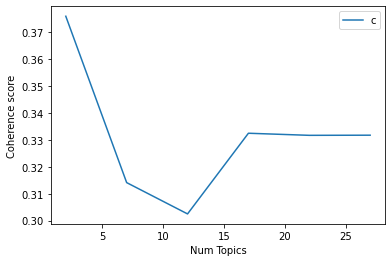

In [135]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_2018_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [136]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_2018_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 2

index: 0 | Num Topics = 2  has Coherence Value of 0.376
index: 1 | Num Topics = 7  has Coherence Value of 0.3141
index: 2 | Num Topics = 12  has Coherence Value of 0.3025
index: 3 | Num Topics = 17  has Coherence Value of 0.3325
index: 4 | Num Topics = 22  has Coherence Value of 0.3317
index: 5 | Num Topics = 27  has Coherence Value of 0.3318


In [200]:
# Select optimal number of topics
optimal_model_us_2018_score1N2N3 = model_list_us_2018_score1N2N3[0]

In [201]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_2018_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_us_2018_score1N2N3, corpus_us_2018_score1N2N3, id2word_us_2018_score1N2N3)

In [202]:
print("pyLDAVis for us topics for score=1,2,3 in 2018:")
vis_us_2018_score1N2N3

pyLDAVis for us topics for score=1,2,3 in 2018:


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.128083  0.0       1        1  60.123018
0     -0.128083  0.0       2        1  39.876982, topic_info=        Term        Freq       Total Category  logprob  loglift
39      song  331.000000  331.000000  Default  30.0000  30.0000
7      video  190.000000  190.000000  Default  29.0000  29.0000
131    error   95.000000   95.000000  Default  28.0000  28.0000
101     load  103.000000  103.000000  Default  27.0000  27.0000
67   picture   43.000000   43.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
32     music   17.415663  102.333507   Topic2  -4.7237  -0.8515
11       fix   17.582085  118.112490   Topic2  -4.7142  -0.9854
5      start   10.415547   18.264724   Topic2  -5.2378   0.3577
16      work   14.466070   97.991192   Topic2  -4.9093  -0.9937
109     look   10.678806   20.891239   Topic2  -5.2128   0.2483

[134 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
43        1  0.297225       add
43        2  0.705910       add
117       1  0.974465    always
117       2  0.023767    always
0         1  0.558566       app
...     ...       ...       ...
105       2  0.724136      well
207       1  0.934006  whenever
207       2  0.103778  whenever
16        1  0.857220      work
16        2  0.142870      work

[156 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

## By-rating of 2019 (Rating=1,2,3)

In [140]:
# By-rating Topic Modelling - rating = 1,2,3 in 2019
# Convert to list - move to each section
review_us_2019_score1N2N3 = lomotif_ios_us_review_YearMonth_2019_score1N2N3.review.values.tolist()
review_words_us_2019_score1N2N3 = list(sent_to_words(review_us_2019_score1N2N3))
print(review_words_us_2019_score1N2N3[:1])

[['this', 'app', 'is', 'honestly', 'horrible', 'was', 'making', 'video', 'and', 'had', 'to', 'start', 'over', 'about', 'times', 'and', 'there', 'hundreds', 'of', 'photos', 'my', 'phone', 'is', 'fairly', 'new', 'as', 'well', 'this', 'is', 'big', 'problem', 'with', 'the', 'app', 'and', 'found', 'that', 'even', 'with', 'an', 'account', 'it', 'would', 'still', 'not', 'save', 'which', 'was', 'downfall', 'of', 'another', 'two', 'projects', 'when', 'finally', 'had', 'something', 'liked', 'loaded', 'picture', 'in', 'and', 'the', 'order', 'completely', 'changed', 'had', 'it', 'in', 'specific', 'order', 'and', 'it', 'is', 'sad', 'that', 'this', 'app', 'can', 'even', 'do', 'that', 'much', 'very', 'annoyed', 'if', 'could', 'give', 'this', 'stars', 'would']]


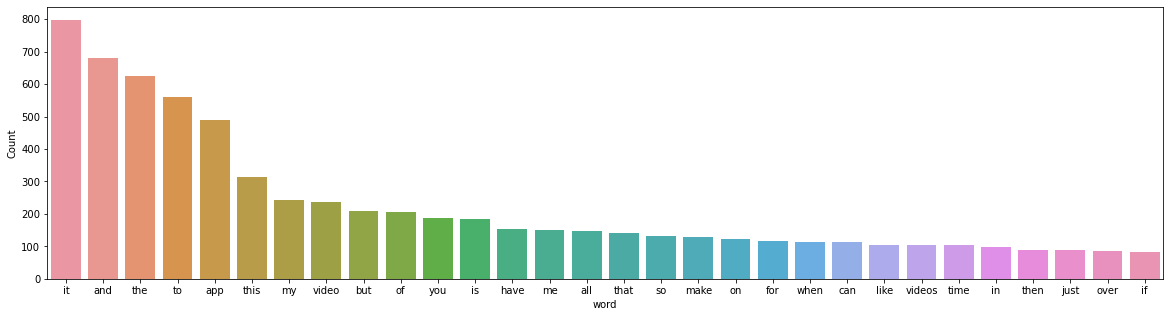

In [141]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_2019_score1N2N3))

In [142]:
# Clean text
review_words_us_ready_2019_score1N2N3 = process_words(review_words_us_2019_score1N2N3)  # processed Text Data! - move to each section

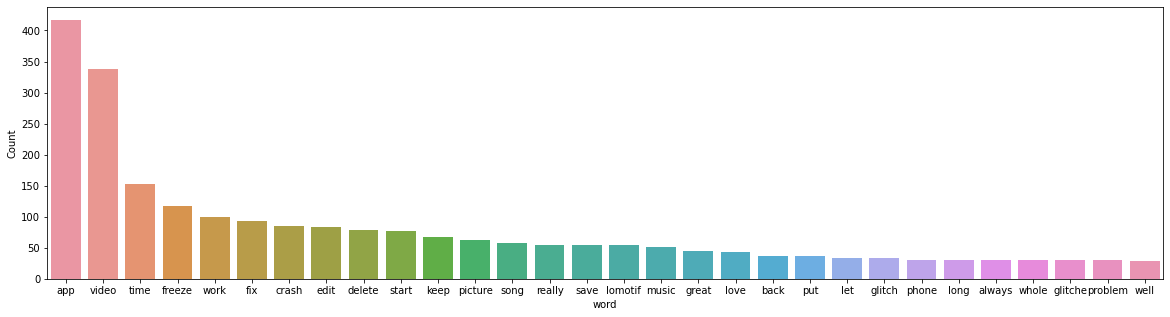

In [143]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_us_ready_2019_score1N2N3))


In [144]:
# Create Dictionary
id2word_us_2019_score1N2N3 = corpora.Dictionary(review_words_us_ready_2019_score1N2N3)

2021-10-17 03:08:17,815 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 03:08:17,834 [INFO] gensim.corpora.dictionary - built Dictionary(879 unique tokens: ['account', 'annoyed', 'app', 'big', 'change']...) from 377 documents (total 5442 corpus positions)
2021-10-17 03:08:17,836 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(879 unique tokens: ['account', 'annoyed', 'app', 'big', 'change']...) from 377 documents (total 5442 corpus positions)", 'datetime': '2021-10-17T03:08:17.836025', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [145]:
# Create Corpus: Term Document Frequency
corpus_us_2019_score1N2N3 = [id2word_us_2019_score1N2N3.doc2bow(text) for text in review_words_us_ready_2019_score1N2N3]

In [146]:
# Training LDA model
model_list_us_2019_score1N2N3, coherence_values_us_2019_score1N2N3 = compute_coherence_values(dictionary=id2word_us_2019_score1N2N3, corpus=corpus_us_2019_score1N2N3, 
                                                              texts=review_words_us_ready_2019_score1N2N3, limit=30, start=2, step=5)


2021-10-17 03:08:17,885 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 03:08:17,887 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 03:08:17,889 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 03:08:17,891 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 377 documents, updating model once every 377 documents, evaluating perplexity every 377 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 03:08:19,273 [INFO] gensim.models.ldamodel - -7.340 per-word bound, 162.1 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:08:19,276 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #377/377
2021-10-17 03:08:20,330 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.079*"app" + 0.057*"video" + 0.026*"time" + 0.021*"freeze" + 0.017*"fix" + 0.016*"edit" + 0.014*"delete

2021-10-17 03:08:30,801 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.041*"video" + 0.028*"app" + 0.022*"music" + 0.016*"picture" + 0.013*"second" + 0.012*"time" + 0.012*"work" + 0.009*"long" + 0.009*"choose" + 0.008*"add"
2021-10-17 03:08:30,802 [INFO] gensim.models.ldamodel - topic diff=0.021858, rho=0.301511
2021-10-17 03:08:31,324 [INFO] gensim.models.ldamodel - -5.776 per-word bound, 54.8 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:08:31,326 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #377/377
2021-10-17 03:08:31,791 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.080*"app" + 0.058*"video" + 0.029*"time" + 0.025*"freeze" + 0.019*"fix" + 0.018*"work" + 0.018*"crash" + 0.017*"edit" + 0.016*"delete" + 0.015*"start"
2021-10-17 03:08:31,793 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.041*"video" + 0.028*"app" + 0.023*"music" + 0.016*"picture" + 0.013*"second" + 0.012*"time" + 0.011*"work" + 0.009*"lo

2021-10-17 03:08:40,316 [INFO] gensim.models.ldamodel - topic diff=0.009533, rho=0.218218
2021-10-17 03:08:40,909 [INFO] gensim.models.ldamodel - -5.764 per-word bound, 54.4 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:08:40,911 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #377/377
2021-10-17 03:08:41,233 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.080*"app" + 0.059*"video" + 0.030*"time" + 0.025*"freeze" + 0.020*"fix" + 0.019*"work" + 0.018*"crash" + 0.018*"edit" + 0.017*"delete" + 0.016*"start"
2021-10-17 03:08:41,237 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.039*"video" + 0.028*"app" + 0.026*"music" + 0.017*"picture" + 0.015*"second" + 0.011*"long" + 0.011*"song" + 0.010*"choose" + 0.009*"add" + 0.009*"wish"
2021-10-17 03:08:41,244 [INFO] gensim.models.ldamodel - topic diff=0.009201, rho=0.213201
2021-10-17 03:08:41,697 [INFO] gensim.models.ldamodel - -5.764 per-word bound, 54.3 perplexity estimate 

2021-10-17 03:08:49,699 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #377/377
2021-10-17 03:08:50,043 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.080*"app" + 0.059*"video" + 0.031*"time" + 0.025*"freeze" + 0.020*"work" + 0.020*"fix" + 0.018*"crash" + 0.018*"edit" + 0.017*"delete" + 0.017*"start"
2021-10-17 03:08:50,045 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.039*"video" + 0.029*"app" + 0.026*"music" + 0.017*"picture" + 0.015*"second" + 0.014*"song" + 0.012*"long" + 0.011*"choose" + 0.010*"add" + 0.009*"great"
2021-10-17 03:08:50,046 [INFO] gensim.models.ldamodel - topic diff=0.007626, rho=0.176777
2021-10-17 03:08:50,538 [INFO] gensim.models.ldamodel - -5.759 per-word bound, 54.1 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:08:50,539 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #377/377
2021-10-17 03:08:50,875 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.080*"app" + 0.059*"vi

2021-10-17 03:08:58,307 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.039*"video" + 0.030*"app" + 0.027*"music" + 0.018*"picture" + 0.016*"song" + 0.015*"second" + 0.012*"long" + 0.011*"choose" + 0.010*"add" + 0.009*"great"
2021-10-17 03:08:58,310 [INFO] gensim.models.ldamodel - topic diff=0.006758, rho=0.154303
2021-10-17 03:08:58,902 [INFO] gensim.models.ldamodel - -5.754 per-word bound, 54.0 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:08:58,908 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #377/377
2021-10-17 03:08:59,124 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.080*"app" + 0.059*"video" + 0.032*"time" + 0.026*"freeze" + 0.021*"work" + 0.020*"fix" + 0.019*"crash" + 0.018*"edit" + 0.017*"delete" + 0.017*"start"
2021-10-17 03:08:59,126 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.039*"video" + 0.031*"app" + 0.027*"music" + 0.018*"picture" + 0.016*"song" + 0.015*"second" + 0.012*"long" + 0.011*"c

2021-10-17 03:09:09,868 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 369 virtual documents
2021-10-17 03:09:10,128 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 03:09:10,131 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 03:09:10,135 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 03:09:10,140 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 377 documents, updating model once every 377 documents, evaluating perplexity every 377 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 03:09:11,061 [INFO] gensim.models.ldamodel - -8.535 per-word bound, 371.0 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:09:11,072 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #377/377
2021-10-17 03:09

2021-10-17 03:09:16,676 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #377/377
2021-10-17 03:09:17,092 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.071*"app" + 0.065*"video" + 0.035*"time" + 0.028*"crash" + 0.020*"keep" + 0.019*"freeze" + 0.015*"start" + 0.015*"fix" + 0.012*"delete" + 0.012*"music"
2021-10-17 03:09:17,097 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.090*"app" + 0.046*"video" + 0.024*"freeze" + 0.023*"time" + 0.021*"delete" + 0.018*"edit" + 0.017*"bad" + 0.014*"fix" + 0.013*"really" + 0.013*"always"
2021-10-17 03:09:17,104 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.064*"app" + 0.033*"work" + 0.032*"video" + 0.024*"fix" + 0.024*"time" + 0.017*"picture" + 0.015*"edit" + 0.013*"keep" + 0.012*"add" + 0.011*"crash"
2021-10-17 03:09:17,117 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.038*"clip" + 0.028*"video" + 0.025*"music" + 0.018*"well" + 0.016*"stuff" + 0.016*"freeze" + 0.016*"effect" + 0.015*"way" + 0.013*"add" + 0.011*"play

2021-10-17 03:09:21,615 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.043*"work" + 0.029*"video" + 0.028*"edit" + 0.024*"almost" + 0.023*"delete" + 0.023*"minute" + 0.023*"app" + 0.016*"start" + 0.015*"freeze" + 0.014*"hard"
2021-10-17 03:09:21,617 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.070*"app" + 0.065*"video" + 0.036*"time" + 0.030*"crash" + 0.021*"keep" + 0.019*"freeze" + 0.015*"start" + 0.015*"fix" + 0.013*"delete" + 0.012*"really"
2021-10-17 03:09:21,618 [INFO] gensim.models.ldamodel - topic diff=0.019562, rho=0.288675
2021-10-17 03:09:22,118 [INFO] gensim.models.ldamodel - -6.074 per-word bound, 67.4 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:09:22,119 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #377/377
2021-10-17 03:09:22,550 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.070*"app" + 0.065*"video" + 0.037*"time" + 0.030*"crash" + 0.021*"keep" + 0.019*"freeze" + 0.015*"start" + 0.015*"

2021-10-17 03:09:27,472 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.070*"app" + 0.065*"video" + 0.037*"time" + 0.031*"crash" + 0.021*"keep" + 0.019*"freeze" + 0.015*"start" + 0.015*"fix" + 0.013*"delete" + 0.012*"really"
2021-10-17 03:09:27,476 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.092*"app" + 0.050*"video" + 0.027*"freeze" + 0.025*"time" + 0.021*"edit" + 0.021*"delete" + 0.017*"bad" + 0.015*"start" + 0.013*"fix" + 0.013*"really"
2021-10-17 03:09:27,480 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.048*"work" + 0.027*"minute" + 0.026*"edit" + 0.026*"almost" + 0.024*"delete" + 0.024*"video" + 0.019*"app" + 0.015*"start" + 0.015*"hard" + 0.013*"lomotif"
2021-10-17 03:09:27,483 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.084*"video" + 0.074*"app" + 0.022*"music" + 0.020*"time" + 0.019*"put" + 0.018*"song" + 0.016*"fix" + 0.015*"freeze" + 0.014*"picture" + 0.012*"love"
2021-10-17 03:09:27,486 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.049*"app" 

2021-10-17 03:09:32,156 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.049*"work" + 0.028*"minute" + 0.027*"almost" + 0.025*"edit" + 0.024*"delete" + 0.021*"video" + 0.017*"app" + 0.015*"hard" + 0.014*"start" + 0.014*"stop"
2021-10-17 03:09:32,157 [INFO] gensim.models.ldamodel - topic diff=0.006615, rho=0.208514
2021-10-17 03:09:32,787 [INFO] gensim.models.ldamodel - -6.061 per-word bound, 66.8 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:09:32,788 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #377/377
2021-10-17 03:09:33,197 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.049*"app" + 0.045*"video" + 0.024*"freeze" + 0.024*"glitch" + 0.020*"work" + 0.019*"start" + 0.018*"lomotif" + 0.015*"glitche" + 0.015*"everytime" + 0.014*"fix"
2021-10-17 03:09:33,198 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.044*"clip" + 0.031*"way" + 0.024*"stuff" + 0.023*"effect" + 0.022*"video" + 0.021*"wish" + 0.019*"well" + 0.

2021-10-17 03:09:38,011 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.044*"clip" + 0.032*"way" + 0.026*"stuff" + 0.023*"effect" + 0.022*"wish" + 0.021*"video" + 0.020*"well" + 0.015*"freeze" + 0.012*"edit" + 0.011*"add"
2021-10-17 03:09:38,012 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.049*"work" + 0.029*"minute" + 0.028*"almost" + 0.025*"edit" + 0.024*"delete" + 0.018*"video" + 0.017*"app" + 0.016*"hard" + 0.014*"start" + 0.014*"lomotif"
2021-10-17 03:09:38,015 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.049*"app" + 0.045*"video" + 0.025*"freeze" + 0.024*"glitch" + 0.020*"work" + 0.019*"start" + 0.018*"lomotif" + 0.015*"glitche" + 0.015*"everytime" + 0.014*"fix"
2021-10-17 03:09:38,017 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.066*"app" + 0.031*"work" + 0.030*"video" + 0.026*"fix" + 0.023*"time" + 0.016*"picture" + 0.015*"keep" + 0.013*"edit" + 0.011*"add" + 0.011*"crash"
2021-10-17 03:09:38,018 [INFO] gensim.models.ldamodel - topic diff=0.004496, rho=

2021-10-17 03:09:42,913 [INFO] gensim.models.ldamodel - topic diff=0.003368, rho=0.171499
2021-10-17 03:09:43,432 [INFO] gensim.models.ldamodel - -6.055 per-word bound, 66.5 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:09:43,433 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #377/377
2021-10-17 03:09:43,898 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.045*"clip" + 0.032*"way" + 0.027*"stuff" + 0.023*"effect" + 0.023*"wish" + 0.020*"video" + 0.020*"well" + 0.015*"freeze" + 0.012*"edit" + 0.011*"love"
2021-10-17 03:09:43,908 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.069*"app" + 0.065*"video" + 0.038*"time" + 0.031*"crash" + 0.021*"keep" + 0.020*"freeze" + 0.015*"start" + 0.015*"fix" + 0.013*"delete" + 0.012*"really"
2021-10-17 03:09:43,910 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.048*"work" + 0.029*"minute" + 0.029*"almost" + 0.026*"edit" + 0.023*"delete" + 0.017*"app" + 0.016*"video" + 0.016*"ha

2021-10-17 03:09:48,771 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.067*"app" + 0.032*"work" + 0.029*"video" + 0.026*"fix" + 0.022*"time" + 0.016*"picture" + 0.014*"keep" + 0.012*"add" + 0.011*"edit" + 0.010*"crash"
2021-10-17 03:09:48,773 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.095*"app" + 0.052*"video" + 0.030*"freeze" + 0.029*"time" + 0.022*"delete" + 0.021*"edit" + 0.017*"bad" + 0.015*"start" + 0.013*"crash" + 0.013*"fix"
2021-10-17 03:09:48,775 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.086*"video" + 0.070*"app" + 0.029*"music" + 0.019*"put" + 0.018*"song" + 0.016*"fix" + 0.015*"picture" + 0.015*"time" + 0.014*"second" + 0.013*"love"
2021-10-17 03:09:48,777 [INFO] gensim.models.ldamodel - topic diff=0.003064, rho=0.158114
2021-10-17 03:09:49,336 [INFO] gensim.models.ldamodel - -6.052 per-word bound, 66.4 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:09:49,339 [INFO] gensim.models.ldamodel - PROGRESS: pass

2021-10-17 03:09:54,015 [INFO] gensim.models.ldamodel - -6.051 per-word bound, 66.3 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:09:54,017 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #377/377
2021-10-17 03:09:54,341 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.087*"video" + 0.069*"app" + 0.030*"music" + 0.020*"put" + 0.018*"song" + 0.016*"fix" + 0.015*"picture" + 0.015*"time" + 0.014*"second" + 0.013*"love"
2021-10-17 03:09:54,343 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.045*"clip" + 0.032*"way" + 0.028*"stuff" + 0.024*"wish" + 0.023*"effect" + 0.020*"video" + 0.020*"well" + 0.015*"freeze" + 0.013*"edit" + 0.012*"love"
2021-10-17 03:09:54,344 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.070*"app" + 0.064*"video" + 0.038*"time" + 0.031*"crash" + 0.022*"keep" + 0.019*"freeze" + 0.015*"start" + 0.015*"fix" + 0.013*"delete" + 0.012*"really"
2021-10-17 03:09:54,347 [INFO] gensim.models.ldamodel - to

2021-10-17 03:09:59,062 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.088*"video" + 0.069*"app" + 0.031*"music" + 0.020*"put" + 0.018*"song" + 0.016*"fix" + 0.015*"picture" + 0.015*"time" + 0.014*"second" + 0.013*"freeze"
2021-10-17 03:09:59,067 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.045*"clip" + 0.032*"way" + 0.028*"stuff" + 0.024*"wish" + 0.023*"effect" + 0.020*"video" + 0.020*"well" + 0.015*"freeze" + 0.013*"edit" + 0.012*"love"
2021-10-17 03:09:59,073 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.095*"app" + 0.053*"video" + 0.032*"freeze" + 0.030*"time" + 0.022*"delete" + 0.021*"edit" + 0.017*"bad" + 0.016*"start" + 0.013*"crash" + 0.012*"fix"
2021-10-17 03:09:59,076 [INFO] gensim.models.ldamodel - topic diff=0.001816, rho=0.140028
2021-10-17 03:09:59,082 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=879, num_topics=7, decay=0.5, chunksize=1000) in 48.94s', 'datetime': '2021-10-17T03:09:59.081028', 'gensim': '4.1.2', 'py

2021-10-17 03:10:09,424 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #377/377
2021-10-17 03:10:09,807 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.089*"app" + 0.044*"freeze" + 0.041*"video" + 0.033*"song" + 0.027*"keep" + 0.022*"start" + 0.021*"fix" + 0.019*"back" + 0.017*"delete" + 0.016*"edit"
2021-10-17 03:10:09,810 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.036*"app" + 0.031*"video" + 0.029*"lomotif" + 0.021*"fix" + 0.020*"time" + 0.016*"glitch" + 0.014*"photo" + 0.014*"keep" + 0.013*"slideshow" + 0.013*"star"
2021-10-17 03:10:09,814 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.082*"video" + 0.073*"app" + 0.020*"time" + 0.019*"really" + 0.018*"edit" + 0.017*"put" + 0.014*"music" + 0.014*"freeze" + 0.013*"work" + 0.012*"love"
2021-10-17 03:10:09,816 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.083*"video" + 0.050*"app" + 0.049*"work" + 0.042*"freeze" + 0.034*"time" + 0.024*"delete" + 0.023*"crash" + 0.023*"fix" + 0.020*"really" + 0.016

2021-10-17 03:10:14,238 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.092*"app" + 0.046*"freeze" + 0.042*"video" + 0.032*"song" + 0.029*"keep" + 0.024*"start" + 0.021*"fix" + 0.019*"whole" + 0.018*"back" + 0.017*"delete"
2021-10-17 03:10:14,242 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.054*"video" + 0.023*"music" + 0.016*"clip" + 0.016*"choose" + 0.016*"horizontal" + 0.016*"shuffle" + 0.008*"spend" + 0.008*"keep" + 0.008*"start" + 0.008*"fix"
2021-10-17 03:10:14,244 [INFO] gensim.models.ldamodel - topic diff=0.036335, rho=0.301511
2021-10-17 03:10:14,725 [INFO] gensim.models.ldamodel - -6.210 per-word bound, 74.0 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:10:14,727 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #377/377
2021-10-17 03:10:15,170 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.085*"video" + 0.053*"work" + 0.050*"app" + 0.044*"freeze" + 0.043*"time" + 0.029*"fix" + 0.028*"crash" + 0.02

2021-10-17 03:10:19,647 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.069*"app" + 0.025*"video" + 0.025*"work" + 0.021*"year" + 0.020*"fix" + 0.018*"time" + 0.015*"let" + 0.015*"picture" + 0.013*"well" + 0.012*"never"
2021-10-17 03:10:19,656 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.033*"app" + 0.026*"lomotif" + 0.025*"video" + 0.021*"fix" + 0.017*"time" + 0.016*"glitch" + 0.015*"photo" + 0.015*"keep" + 0.014*"still" + 0.014*"slideshow"
2021-10-17 03:10:19,660 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.093*"app" + 0.046*"freeze" + 0.042*"video" + 0.032*"song" + 0.029*"keep" + 0.025*"start" + 0.021*"whole" + 0.020*"fix" + 0.018*"back" + 0.018*"delete"
2021-10-17 03:10:19,662 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.085*"app" + 0.057*"video" + 0.026*"time" + 0.025*"edit" + 0.023*"freeze" + 0.020*"great" + 0.017*"second" + 0.016*"work" + 0.016*"long" + 0.014*"well"
2021-10-17 03:10:19,664 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.099*"app" + 

2021-10-17 03:10:24,178 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.087*"video" + 0.055*"app" + 0.054*"work" + 0.048*"time" + 0.046*"freeze" + 0.034*"crash" + 0.032*"fix" + 0.026*"delete" + 0.025*"lomotif" + 0.015*"middle"
2021-10-17 03:10:24,180 [INFO] gensim.models.ldamodel - topic diff=0.009078, rho=0.213201
2021-10-17 03:10:24,603 [INFO] gensim.models.ldamodel - -6.187 per-word bound, 72.9 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:10:24,605 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #377/377
2021-10-17 03:10:25,052 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.059*"video" + 0.058*"app" + 0.026*"song" + 0.023*"time" + 0.019*"crash" + 0.019*"picture" + 0.014*"music" + 0.014*"great" + 0.013*"start" + 0.013*"really"
2021-10-17 03:10:25,054 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.098*"app" + 0.063*"video" + 0.028*"delete" + 0.022*"freeze" + 0.017*"ever" + 0.015*"bad" + 0.015*"time" + 0.013*

2021-10-17 03:10:29,563 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.054*"video" + 0.028*"music" + 0.020*"choose" + 0.016*"clip" + 0.016*"horizontal" + 0.016*"shuffle" + 0.008*"freeze" + 0.008*"spend" + 0.008*"keep" + 0.008*"start"
2021-10-17 03:10:29,566 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.049*"video" + 0.034*"music" + 0.031*"app" + 0.020*"picture" + 0.017*"clip" + 0.017*"time" + 0.014*"put" + 0.012*"update" + 0.012*"stuff" + 0.012*"work"
2021-10-17 03:10:29,568 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.068*"app" + 0.025*"video" + 0.022*"work" + 0.021*"year" + 0.019*"fix" + 0.018*"time" + 0.016*"let" + 0.015*"picture" + 0.013*"well" + 0.012*"never"
2021-10-17 03:10:29,570 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.094*"app" + 0.047*"freeze" + 0.043*"video" + 0.032*"song" + 0.029*"keep" + 0.026*"start" + 0.020*"whole" + 0.019*"fix" + 0.019*"back" + 0.017*"delete"
2021-10-17 03:10:29,572 [INFO] gensim.models.ldamodel - topic diff=0.006163, rho

2021-10-17 03:10:34,160 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.063*"app" + 0.052*"time" + 0.037*"video" + 0.031*"start" + 0.031*"save" + 0.026*"crash" + 0.021*"edit" + 0.020*"fix" + 0.018*"delete" + 0.016*"problem"
2021-10-17 03:10:34,160 [INFO] gensim.models.ldamodel - topic diff=0.004895, rho=0.174078
2021-10-17 03:10:34,717 [INFO] gensim.models.ldamodel - -6.180 per-word bound, 72.5 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:10:34,718 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #377/377
2021-10-17 03:10:35,068 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.076*"video" + 0.068*"app" + 0.027*"really" + 0.021*"edit" + 0.018*"put" + 0.014*"music" + 0.013*"time" + 0.012*"love" + 0.012*"help" + 0.012*"transition"
2021-10-17 03:10:35,071 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.089*"video" + 0.059*"app" + 0.055*"work" + 0.050*"time" + 0.049*"freeze" + 0.040*"crash" + 0.035*"fix" + 0.027*"dele

2021-10-17 03:10:39,735 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.089*"video" + 0.060*"app" + 0.053*"work" + 0.051*"freeze" + 0.051*"time" + 0.043*"crash" + 0.035*"fix" + 0.027*"delete" + 0.027*"lomotif" + 0.017*"middle"
2021-10-17 03:10:39,738 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.049*"video" + 0.035*"music" + 0.031*"app" + 0.021*"picture" + 0.018*"clip" + 0.018*"time" + 0.014*"put" + 0.012*"update" + 0.012*"stuff" + 0.012*"well"
2021-10-17 03:10:39,741 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.066*"app" + 0.025*"video" + 0.023*"work" + 0.020*"year" + 0.019*"fix" + 0.017*"let" + 0.016*"time" + 0.015*"picture" + 0.015*"sign" + 0.013*"never"
2021-10-17 03:10:39,744 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.057*"app" + 0.055*"video" + 0.029*"song" + 0.020*"picture" + 0.020*"time" + 0.016*"great" + 0.016*"music" + 0.014*"add" + 0.013*"crash" + 0.013*"really"
2021-10-17 03:10:39,748 [INFO] gensim.models.ldamodel - topic diff=0.004497, rho=0.16012

2021-10-17 03:10:44,061 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.065*"app" + 0.025*"video" + 0.023*"work" + 0.020*"year" + 0.019*"fix" + 0.017*"let" + 0.016*"sign" + 0.016*"time" + 0.015*"picture" + 0.013*"never"
2021-10-17 03:10:44,063 [INFO] gensim.models.ldamodel - topic diff=0.004632, rho=0.150756
2021-10-17 03:10:44,573 [INFO] gensim.models.ldamodel - -6.170 per-word bound, 72.0 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:10:44,575 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #377/377
2021-10-17 03:10:44,966 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.095*"app" + 0.059*"video" + 0.027*"delete" + 0.021*"freeze" + 0.017*"ever" + 0.017*"bad" + 0.015*"time" + 0.014*"let" + 0.013*"picture" + 0.011*"spend"
2021-10-17 03:10:44,967 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.096*"app" + 0.045*"video" + 0.044*"freeze" + 0.032*"song" + 0.029*"keep" + 0.024*"start" + 0.020*"back" + 0.019*"fix" + 0

2021-10-17 03:10:49,419 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.049*"video" + 0.035*"music" + 0.031*"app" + 0.021*"picture" + 0.018*"clip" + 0.018*"time" + 0.014*"put" + 0.012*"update" + 0.012*"stuff" + 0.012*"well"
2021-10-17 03:10:49,420 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.065*"app" + 0.025*"video" + 0.023*"work" + 0.020*"year" + 0.019*"fix" + 0.017*"let" + 0.016*"sign" + 0.016*"time" + 0.015*"picture" + 0.013*"never"
2021-10-17 03:10:49,421 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.083*"app" + 0.057*"video" + 0.028*"time" + 0.026*"edit" + 0.022*"freeze" + 0.020*"great" + 0.018*"second" + 0.016*"work" + 0.015*"long" + 0.014*"close"
2021-10-17 03:10:49,422 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.058*"app" + 0.054*"video" + 0.030*"song" + 0.021*"picture" + 0.019*"time" + 0.017*"music" + 0.017*"great" + 0.014*"add" + 0.014*"really" + 0.013*"long"
2021-10-17 03:10:49,423 [INFO] gensim.models.ldamodel - topic diff=0.003664, rho=0.141421
20

2021-10-17 03:10:59,315 [INFO] gensim.models.ldamodel - topic diff=0.159170, rho=0.500000
2021-10-17 03:10:59,830 [INFO] gensim.models.ldamodel - -6.455 per-word bound, 87.7 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:10:59,832 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #377/377
2021-10-17 03:11:00,121 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.068*"app" + 0.064*"video" + 0.030*"delete" + 0.028*"freeze" + 0.021*"glitch" + 0.020*"song" + 0.019*"keep" + 0.019*"let" + 0.018*"play" + 0.017*"picture"
2021-10-17 03:11:00,123 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.086*"app" + 0.062*"video" + 0.053*"time" + 0.030*"save" + 0.023*"delete" + 0.017*"love" + 0.017*"problem" + 0.016*"work" + 0.016*"fix" + 0.015*"start"
2021-10-17 03:11:00,125 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.039*"app" + 0.027*"time" + 0.022*"video" + 0.020*"keep" + 0.019*"glitch" + 0.019*"fix" + 0.016*"lomotif" + 0.014*"wor

2021-10-17 03:11:04,527 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.069*"app" + 0.063*"video" + 0.031*"delete" + 0.029*"freeze" + 0.021*"picture" + 0.021*"glitch" + 0.020*"keep" + 0.020*"let" + 0.019*"play" + 0.018*"edit"
2021-10-17 03:11:04,532 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.038*"app" + 0.025*"time" + 0.021*"glitch" + 0.021*"video" + 0.020*"fix" + 0.020*"keep" + 0.014*"lomotif" + 0.014*"close" + 0.014*"search" + 0.011*"love"
2021-10-17 03:11:04,534 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.050*"app" + 0.036*"minute" + 0.035*"time" + 0.029*"work" + 0.028*"fix" + 0.023*"load" + 0.021*"music" + 0.018*"edit" + 0.017*"crash" + 0.015*"freeze"
2021-10-17 03:11:04,535 [INFO] gensim.models.ldamodel - topic diff=0.045800, rho=0.316228
2021-10-17 03:11:04,990 [INFO] gensim.models.ldamodel - -6.365 per-word bound, 82.4 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:11:04,992 [INFO] gensim.models.ldamodel - PRO

2021-10-17 03:11:09,355 [INFO] gensim.models.ldamodel - -6.345 per-word bound, 81.3 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:11:09,361 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #377/377
2021-10-17 03:11:09,688 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.087*"app" + 0.063*"video" + 0.052*"time" + 0.032*"save" + 0.021*"delete" + 0.020*"start" + 0.019*"love" + 0.017*"problem" + 0.016*"work" + 0.016*"fix"
2021-10-17 03:11:09,690 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.090*"app" + 0.039*"video" + 0.037*"start" + 0.029*"work" + 0.023*"freeze" + 0.022*"keep" + 0.017*"crash" + 0.017*"close" + 0.016*"lomotif" + 0.016*"fix"
2021-10-17 03:11:09,691 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.053*"video" + 0.026*"able" + 0.021*"great" + 0.021*"long" + 0.021*"add" + 0.021*"well" + 0.020*"really" + 0.019*"clip" + 0.016*"load" + 0.014*"music"
2021-10-17 03:11:09,692 [INFO] gensim.models.ldamodel - 

2021-10-17 03:11:14,063 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.082*"app" + 0.064*"video" + 0.033*"always" + 0.028*"song" + 0.020*"time" + 0.019*"ever" + 0.018*"wish" + 0.018*"delete" + 0.017*"really" + 0.015*"crash"
2021-10-17 03:11:14,064 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.086*"app" + 0.078*"video" + 0.061*"work" + 0.047*"fix" + 0.036*"freeze" + 0.027*"crash" + 0.023*"time" + 0.020*"delete" + 0.019*"middle" + 0.018*"start"
2021-10-17 03:11:14,065 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.086*"app" + 0.064*"video" + 0.052*"time" + 0.033*"save" + 0.022*"delete" + 0.021*"start" + 0.019*"love" + 0.018*"problem" + 0.016*"fix" + 0.015*"work"
2021-10-17 03:11:14,067 [INFO] gensim.models.ldamodel - topic diff=0.010287, rho=0.218218
2021-10-17 03:11:14,503 [INFO] gensim.models.ldamodel - -6.334 per-word bound, 80.7 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:11:14,505 [INFO] gensim.models.ldamodel - PROGR

2021-10-17 03:11:18,919 [INFO] gensim.models.ldamodel - -6.328 per-word bound, 80.4 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:11:18,920 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #377/377
2021-10-17 03:11:19,211 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.072*"app" + 0.065*"video" + 0.031*"delete" + 0.030*"freeze" + 0.023*"picture" + 0.022*"keep" + 0.021*"let" + 0.021*"edit" + 0.020*"play" + 0.020*"glitch"
2021-10-17 03:11:19,212 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.039*"app" + 0.022*"glitch" + 0.021*"fix" + 0.020*"time" + 0.019*"video" + 0.018*"keep" + 0.015*"close" + 0.015*"search" + 0.014*"lomotif" + 0.011*"love"
2021-10-17 03:11:19,214 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.057*"video" + 0.022*"app" + 0.022*"lomotif" + 0.018*"music" + 0.018*"spend" + 0.018*"funimate" + 0.017*"process" + 0.017*"start" + 0.016*"back" + 0.013*"whole"
2021-10-17 03:11:19,216 [INFO] gensim.model

2021-10-17 03:11:23,558 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.073*"app" + 0.065*"video" + 0.032*"delete" + 0.031*"freeze" + 0.023*"picture" + 0.022*"keep" + 0.021*"let" + 0.021*"edit" + 0.020*"play" + 0.020*"glitch"
2021-10-17 03:11:23,562 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.090*"app" + 0.060*"video" + 0.028*"edit" + 0.022*"time" + 0.022*"freeze" + 0.020*"long" + 0.018*"work" + 0.017*"great" + 0.015*"picture" + 0.015*"music"
2021-10-17 03:11:23,565 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.088*"app" + 0.080*"video" + 0.061*"work" + 0.048*"fix" + 0.041*"freeze" + 0.029*"crash" + 0.025*"time" + 0.023*"delete" + 0.021*"start" + 0.018*"middle"
2021-10-17 03:11:23,567 [INFO] gensim.models.ldamodel - topic diff=0.004744, rho=0.176777
2021-10-17 03:11:24,118 [INFO] gensim.models.ldamodel - -6.324 per-word bound, 80.1 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:11:24,120 [INFO] gensim.models.ldamodel - P

2021-10-17 03:11:28,310 [INFO] gensim.models.ldamodel - -6.320 per-word bound, 79.9 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:11:28,312 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #377/377
2021-10-17 03:11:28,617 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.083*"app" + 0.064*"video" + 0.032*"always" + 0.028*"song" + 0.024*"wish" + 0.019*"time" + 0.019*"really" + 0.019*"delete" + 0.018*"ever" + 0.015*"crash"
2021-10-17 03:11:28,620 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.069*"video" + 0.063*"app" + 0.048*"time" + 0.044*"crash" + 0.024*"freeze" + 0.019*"song" + 0.016*"start" + 0.014*"keep" + 0.012*"really" + 0.011*"lomotif"
2021-10-17 03:11:28,624 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.052*"video" + 0.026*"able" + 0.022*"well" + 0.022*"great" + 0.021*"add" + 0.021*"long" + 0.020*"clip" + 0.018*"really" + 0.017*"load" + 0.012*"time"
2021-10-17 03:11:28,626 [INFO] gensim.models.ldamodel 

2021-10-17 03:11:33,158 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.039*"app" + 0.022*"glitch" + 0.021*"fix" + 0.020*"time" + 0.019*"video" + 0.018*"keep" + 0.015*"close" + 0.015*"search" + 0.013*"lomotif" + 0.011*"love"
2021-10-17 03:11:33,161 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.089*"app" + 0.080*"video" + 0.061*"work" + 0.047*"fix" + 0.041*"freeze" + 0.031*"crash" + 0.027*"time" + 0.024*"delete" + 0.021*"start" + 0.017*"middle"
2021-10-17 03:11:33,162 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.060*"app" + 0.036*"great" + 0.026*"fix" + 0.019*"continue" + 0.018*"freeze" + 0.015*"show" + 0.014*"back" + 0.014*"edit" + 0.013*"start" + 0.013*"video"
2021-10-17 03:11:33,163 [INFO] gensim.models.ldamodel - topic diff=0.002929, rho=0.152499
2021-10-17 03:11:33,637 [INFO] gensim.models.ldamodel - -6.318 per-word bound, 79.8 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:11:33,638 [INFO] gensim.models.ldamodel - PR

2021-10-17 03:11:37,694 [INFO] gensim.models.ldamodel - topic diff=0.002365, rho=0.144338
2021-10-17 03:11:38,214 [INFO] gensim.models.ldamodel - -6.317 per-word bound, 79.7 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:11:38,216 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #377/377
2021-10-17 03:11:38,549 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.044*"app" + 0.039*"minute" + 0.034*"time" + 0.027*"work" + 0.026*"fix" + 0.026*"load" + 0.023*"music" + 0.018*"crash" + 0.016*"edit" + 0.015*"freeze"
2021-10-17 03:11:38,551 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.039*"app" + 0.021*"glitch" + 0.021*"fix" + 0.020*"time" + 0.019*"video" + 0.018*"keep" + 0.015*"close" + 0.015*"search" + 0.013*"lomotif" + 0.011*"love"
2021-10-17 03:11:38,553 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.091*"app" + 0.041*"video" + 0.041*"start" + 0.027*"work" + 0.025*"freeze" + 0.023*"keep" + 0.019*"crash" + 0.017*"sav

2021-10-17 03:11:49,735 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.080*"app" + 0.070*"video" + 0.030*"freeze" + 0.027*"crash" + 0.022*"work" + 0.020*"great" + 0.020*"time" + 0.017*"song" + 0.015*"delete" + 0.014*"picture"
2021-10-17 03:11:49,736 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.082*"app" + 0.054*"video" + 0.025*"bad" + 0.020*"ever" + 0.020*"song" + 0.017*"delete" + 0.016*"really" + 0.015*"time" + 0.015*"wish" + 0.013*"fix"
2021-10-17 03:11:49,738 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.097*"app" + 0.039*"start" + 0.032*"freeze" + 0.032*"video" + 0.025*"back" + 0.024*"time" + 0.022*"lomotif" + 0.020*"work" + 0.020*"glitche" + 0.018*"crash"
2021-10-17 03:11:49,739 [INFO] gensim.models.ldamodel - topic diff=0.177795, rho=0.577350
2021-10-17 03:11:50,224 [INFO] gensim.models.ldamodel - -6.601 per-word bound, 97.0 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:11:50,225 [INFO] gensim.models.ldamodel - P

2021-10-17 03:11:54,176 [INFO] gensim.models.ldamodel - -6.461 per-word bound, 88.1 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:11:54,178 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #377/377
2021-10-17 03:11:54,554 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.083*"app" + 0.049*"video" + 0.026*"bad" + 0.022*"song" + 0.021*"ever" + 0.016*"really" + 0.016*"wish" + 0.015*"delete" + 0.014*"time" + 0.013*"always"
2021-10-17 03:11:54,556 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.078*"video" + 0.065*"app" + 0.038*"fix" + 0.038*"time" + 0.029*"picture" + 0.017*"lomotif" + 0.016*"crash" + 0.016*"really" + 0.016*"load" + 0.015*"edit"
2021-10-17 03:11:54,558 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.070*"edit" + 0.039*"video" + 0.037*"short" + 0.030*"app" + 0.019*"start" + 0.019*"work" + 0.019*"hard" + 0.017*"crash" + 0.014*"minute" + 0.013*"lomotif"
2021-10-17 03:11:54,560 [INFO] gensim.models.ldamodel

2021-10-17 03:11:58,694 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.082*"app" + 0.068*"video" + 0.026*"freeze" + 0.023*"time" + 0.022*"great" + 0.018*"song" + 0.015*"picture" + 0.015*"issue" + 0.015*"crash" + 0.014*"work"
2021-10-17 03:11:58,697 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.084*"app" + 0.070*"video" + 0.044*"work" + 0.041*"freeze" + 0.032*"delete" + 0.027*"time" + 0.022*"crash" + 0.021*"fix" + 0.017*"whole" + 0.016*"love"
2021-10-17 03:11:58,699 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.096*"app" + 0.033*"save" + 0.032*"video" + 0.031*"great" + 0.031*"fix" + 0.024*"edit" + 0.023*"start" + 0.019*"freeze" + 0.016*"lomotif" + 0.016*"time"
2021-10-17 03:11:58,700 [INFO] gensim.models.ldamodel - topic diff=0.022372, rho=0.267261
2021-10-17 03:11:59,216 [INFO] gensim.models.ldamodel - -6.429 per-word bound, 86.2 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:11:59,217 [INFO] gensim.models.ldamodel - PR

2021-10-17 03:12:03,441 [INFO] gensim.models.ldamodel - -6.418 per-word bound, 85.5 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:12:03,442 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #377/377
2021-10-17 03:12:03,781 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.030*"time" + 0.028*"app" + 0.024*"year" + 0.012*"start" + 0.012*"full" + 0.012*"song" + 0.012*"nude" + 0.012*"terrible" + 0.012*"hate" + 0.012*"listen"
2021-10-17 03:12:03,785 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.080*"video" + 0.042*"really" + 0.038*"time" + 0.031*"app" + 0.030*"middle" + 0.019*"crash" + 0.018*"sign" + 0.017*"lose" + 0.016*"fix" + 0.015*"delete"
2021-10-17 03:12:03,786 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.055*"time" + 0.053*"app" + 0.030*"video" + 0.029*"give" + 0.016*"edit" + 0.015*"start" + 0.014*"size" + 0.014*"choose" + 0.013*"star" + 0.013*"picture"
2021-10-17 03:12:03,788 [INFO] gensim.models.ldamodel - 

2021-10-17 03:12:07,923 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.066*"edit" + 0.039*"short" + 0.036*"video" + 0.027*"app" + 0.020*"start" + 0.020*"work" + 0.020*"hard" + 0.014*"lomotif" + 0.013*"crash" + 0.013*"minute"
2021-10-17 03:12:07,924 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.060*"app" + 0.044*"video" + 0.032*"second" + 0.028*"wish" + 0.026*"music" + 0.022*"put" + 0.022*"song" + 0.021*"great" + 0.017*"fix" + 0.017*"long"
2021-10-17 03:12:07,925 [INFO] gensim.models.ldamodel - topic diff=0.007592, rho=0.200000
2021-10-17 03:12:08,331 [INFO] gensim.models.ldamodel - -6.411 per-word bound, 85.1 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:12:08,332 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #377/377
2021-10-17 03:12:08,691 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.051*"picture" + 0.043*"app" + 0.032*"work" + 0.030*"video" + 0.024*"stuff" + 0.022*"annoying" + 0.018*"really" + 0.018*

2021-10-17 03:12:12,805 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.062*"app" + 0.049*"video" + 0.037*"second" + 0.028*"music" + 0.027*"wish" + 0.024*"great" + 0.024*"long" + 0.022*"put" + 0.021*"song" + 0.017*"fix"
2021-10-17 03:12:12,808 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.088*"app" + 0.050*"video" + 0.045*"edit" + 0.031*"freeze" + 0.026*"time" + 0.021*"keep" + 0.021*"well" + 0.021*"start" + 0.020*"work" + 0.018*"close"
2021-10-17 03:12:12,810 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.085*"video" + 0.074*"app" + 0.028*"edit" + 0.025*"put" + 0.018*"download" + 0.016*"freeze" + 0.016*"time" + 0.014*"people" + 0.014*"thing" + 0.014*"fix"
2021-10-17 03:12:12,812 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.053*"app" + 0.037*"time" + 0.036*"fix" + 0.027*"load" + 0.022*"video" + 0.021*"music" + 0.020*"work" + 0.016*"crash" + 0.016*"day" + 0.016*"minute"
2021-10-17 03:12:12,815 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.051*"picture" + 0.0

2021-10-17 03:12:16,991 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.057*"choose" + 0.056*"video" + 0.041*"music" + 0.035*"way" + 0.022*"love" + 0.019*"clip" + 0.019*"horizontal" + 0.019*"full" + 0.016*"put" + 0.016*"able"
2021-10-17 03:12:16,993 [INFO] gensim.models.ldamodel - topic diff=0.005883, rho=0.166667
2021-10-17 03:12:17,546 [INFO] gensim.models.ldamodel - -6.399 per-word bound, 84.4 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:12:17,547 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #377/377
2021-10-17 03:12:17,916 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.084*"back" + 0.065*"screen" + 0.058*"home" + 0.054*"video" + 0.028*"save" + 0.027*"music" + 0.026*"progress" + 0.024*"freeze" + 0.024*"stuff" + 0.019*"work"
2021-10-17 03:12:17,917 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.040*"app" + 0.031*"time" + 0.023*"video" + 0.018*"spend" + 0.015*"fix" + 0.015*"photo" + 0.014*"picture" + 0.

2021-10-17 03:12:22,169 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.051*"app" + 0.034*"time" + 0.032*"fix" + 0.028*"load" + 0.021*"work" + 0.017*"crash" + 0.017*"day" + 0.017*"today" + 0.017*"minute" + 0.017*"keep"
2021-10-17 03:12:22,170 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.030*"time" + 0.029*"app" + 0.026*"year" + 0.013*"start" + 0.013*"care" + 0.013*"listen" + 0.013*"terrible" + 0.013*"old" + 0.013*"hate" + 0.013*"post"
2021-10-17 03:12:22,171 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.101*"app" + 0.048*"video" + 0.048*"start" + 0.037*"freeze" + 0.036*"save" + 0.036*"crash" + 0.033*"keep" + 0.030*"glitche" + 0.028*"time" + 0.028*"lomotif"
2021-10-17 03:12:22,174 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.078*"video" + 0.051*"app" + 0.048*"fix" + 0.038*"time" + 0.037*"picture" + 0.022*"load" + 0.020*"really" + 0.019*"lomotif" + 0.019*"glitch" + 0.019*"stupid"
2021-10-17 03:12:22,175 [INFO] gensim.models.ldamodel - topic diff=0.004799, rho=0

2021-10-17 03:12:26,329 [INFO] gensim.models.ldamodel - topic diff=0.004331, rho=0.145865
2021-10-17 03:12:26,830 [INFO] gensim.models.ldamodel - -6.387 per-word bound, 83.7 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:12:26,832 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #377/377
2021-10-17 03:12:27,188 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.068*"video" + 0.064*"app" + 0.048*"long" + 0.045*"music" + 0.044*"second" + 0.029*"wish" + 0.028*"great" + 0.022*"put" + 0.019*"song" + 0.019*"fix"
2021-10-17 03:12:27,190 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.093*"app" + 0.075*"video" + 0.046*"freeze" + 0.039*"work" + 0.036*"delete" + 0.035*"time" + 0.026*"crash" + 0.024*"fix" + 0.020*"whole" + 0.015*"keep"
2021-10-17 03:12:27,191 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.051*"app" + 0.034*"time" + 0.032*"fix" + 0.028*"load" + 0.021*"work" + 0.017*"crash" + 0.017*"day" + 0.017*"today" + 0.0

2021-10-17 03:12:38,413 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.036*"song" + 0.036*"fix" + 0.036*"app" + 0.027*"love" + 0.027*"lomotif" + 0.021*"put" + 0.020*"horrible" + 0.018*"keep" + 0.018*"music" + 0.018*"change"
2021-10-17 03:12:38,414 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.062*"video" + 0.060*"app" + 0.041*"time" + 0.026*"crash" + 0.017*"keep" + 0.017*"really" + 0.015*"delete" + 0.013*"work" + 0.012*"freeze" + 0.011*"start"
2021-10-17 03:12:38,415 [INFO] gensim.models.ldamodel - topic diff=21.759741, rho=1.000000
2021-10-17 03:12:38,893 [INFO] gensim.models.ldamodel - -6.804 per-word bound, 111.7 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:12:38,894 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #377/377
2021-10-17 03:12:39,323 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.054*"app" + 0.033*"tok" + 0.029*"service" + 0.029*"affect" + 0.025*"really" + 0.025*"stuff" + 0.023*"find" + 0.0

2021-10-17 03:12:43,083 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #377/377
2021-10-17 03:12:43,428 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.051*"picture" + 0.044*"app" + 0.037*"edit" + 0.033*"transition" + 0.027*"hope" + 0.027*"look" + 0.027*"review" + 0.023*"song" + 0.016*"video" + 0.015*"option"
2021-10-17 03:12:43,429 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.080*"app" + 0.063*"video" + 0.040*"freeze" + 0.032*"work" + 0.025*"crash" + 0.023*"delete" + 0.021*"second" + 0.017*"music" + 0.017*"edit" + 0.013*"minute"
2021-10-17 03:12:43,430 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.058*"app" + 0.036*"video" + 0.034*"time" + 0.023*"problem" + 0.020*"photo" + 0.017*"start" + 0.015*"edit" + 0.015*"freeze" + 0.015*"bad" + 0.015*"fix"
2021-10-17 03:12:43,432 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.058*"video" + 0.043*"app" + 0.028*"really" + 0.028*"keep" + 0.026*"glitch" + 0.025*"exit" + 0.025*"glitche" + 0.024*"save" + 0.023*"

2021-10-17 03:12:47,558 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.074*"app" + 0.041*"time" + 0.034*"close" + 0.031*"video" + 0.026*"happen" + 0.022*"back" + 0.021*"work" + 0.017*"start" + 0.015*"freeze" + 0.015*"restart"
2021-10-17 03:12:47,562 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.053*"picture" + 0.042*"app" + 0.039*"transition" + 0.038*"edit" + 0.027*"hope" + 0.027*"look" + 0.027*"review" + 0.026*"song" + 0.017*"option" + 0.015*"music"
2021-10-17 03:12:47,563 [INFO] gensim.models.ldamodel - topic diff=0.026815, rho=0.277350
2021-10-17 03:12:48,060 [INFO] gensim.models.ldamodel - -6.532 per-word bound, 92.6 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:12:48,062 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #377/377
2021-10-17 03:12:48,411 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.058*"video" + 0.042*"app" + 0.030*"keep" + 0.029*"really" + 0.029*"glitche" + 0.028*"glitch" + 0.025*"save"

2021-10-17 03:12:52,081 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #377/377
2021-10-17 03:12:52,418 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.099*"video" + 0.070*"app" + 0.022*"fix" + 0.020*"freeze" + 0.019*"save" + 0.017*"really" + 0.015*"photo" + 0.013*"literally" + 0.013*"show" + 0.013*"love"
2021-10-17 03:12:52,419 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.077*"app" + 0.070*"crash" + 0.048*"video" + 0.043*"fix" + 0.035*"keep" + 0.023*"song" + 0.021*"start" + 0.017*"update" + 0.015*"put" + 0.015*"time"
2021-10-17 03:12:52,420 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.106*"app" + 0.091*"video" + 0.037*"edit" + 0.025*"love" + 0.021*"fix" + 0.021*"time" + 0.020*"freeze" + 0.020*"put" + 0.015*"problem" + 0.015*"whole"
2021-10-17 03:12:52,421 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.072*"video" + 0.071*"time" + 0.068*"app" + 0.032*"start" + 0.031*"update" + 0.031*"everytime" + 0.024*"save" + 0.019*"delete" + 0.017*"freeze" + 

2021-10-17 03:12:56,537 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.045*"app" + 0.030*"time" + 0.025*"delete" + 0.018*"video" + 0.018*"song" + 0.017*"picture" + 0.017*"pick" + 0.014*"crash" + 0.014*"friend" + 0.014*"music"
2021-10-17 03:12:56,539 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.107*"app" + 0.091*"video" + 0.038*"edit" + 0.025*"love" + 0.021*"fix" + 0.021*"time" + 0.020*"freeze" + 0.020*"put" + 0.015*"problem" + 0.015*"whole"
2021-10-17 03:12:56,542 [INFO] gensim.models.ldamodel - topic diff=0.006385, rho=0.204124
2021-10-17 03:12:57,043 [INFO] gensim.models.ldamodel - -6.514 per-word bound, 91.4 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:12:57,044 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #377/377
2021-10-17 03:12:57,347 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.069*"crash" + 0.052*"app" + 0.042*"time" + 0.040*"work" + 0.026*"really" + 0.024*"keep" + 0.024*"frustrating" + 0.0

2021-10-17 03:13:01,166 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #377/377
2021-10-17 03:13:01,386 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.074*"app" + 0.042*"time" + 0.037*"close" + 0.029*"video" + 0.024*"happen" + 0.022*"back" + 0.019*"work" + 0.018*"start" + 0.016*"whole" + 0.016*"tired"
2021-10-17 03:13:01,388 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.082*"app" + 0.037*"delete" + 0.034*"song" + 0.030*"video" + 0.030*"start" + 0.024*"love" + 0.020*"back" + 0.020*"fix" + 0.018*"freeze" + 0.018*"work"
2021-10-17 03:13:01,390 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.063*"app" + 0.061*"video" + 0.028*"play" + 0.028*"song" + 0.023*"add" + 0.022*"glitch" + 0.021*"edit" + 0.019*"picture" + 0.018*"let" + 0.017*"keep"
2021-10-17 03:13:01,392 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.059*"app" + 0.037*"video" + 0.034*"time" + 0.026*"problem" + 0.019*"photo" + 0.017*"start" + 0.016*"edit" + 0.016*"bad" + 0.015*"work" + 0.015*"fr

2021-10-17 03:13:05,654 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.055*"video" + 0.042*"app" + 0.038*"save" + 0.035*"glitche" + 0.033*"keep" + 0.030*"glitch" + 0.029*"really" + 0.026*"exit" + 0.024*"work" + 0.023*"minute"
2021-10-17 03:13:05,660 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.030*"great" + 0.027*"love" + 0.027*"much" + 0.027*"update" + 0.027*"today" + 0.027*"birthday" + 0.027*"nd" + 0.027*"little" + 0.017*"load" + 0.016*"work"
2021-10-17 03:13:05,661 [INFO] gensim.models.ldamodel - topic diff=0.003529, rho=0.169031
2021-10-17 03:13:06,123 [INFO] gensim.models.ldamodel - -6.503 per-word bound, 90.7 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:13:06,124 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #377/377
2021-10-17 03:13:06,471 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.075*"crash" + 0.051*"app" + 0.044*"time" + 0.040*"work" + 0.028*"really" + 0.026*"frustrating" + 0.024*"video"

2021-10-17 03:13:10,314 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #377/377
2021-10-17 03:13:10,683 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.044*"save" + 0.040*"crash" + 0.030*"stuff" + 0.030*"person" + 0.030*"picky" + 0.030*"middle" + 0.030*"editing" + 0.026*"lomotif" + 0.023*"always" + 0.018*"app"
2021-10-17 03:13:10,684 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.074*"app" + 0.042*"time" + 0.037*"close" + 0.030*"video" + 0.024*"happen" + 0.022*"back" + 0.019*"work" + 0.018*"tired" + 0.017*"start" + 0.016*"whole"
2021-10-17 03:13:10,685 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.076*"app" + 0.030*"facebook" + 0.024*"great" + 0.024*"fix" + 0.023*"show" + 0.023*"video" + 0.022*"put" + 0.018*"freeze" + 0.018*"picture" + 0.018*"sign"
2021-10-17 03:13:10,686 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.029*"great" + 0.027*"love" + 0.027*"much" + 0.027*"update" + 0.027*"today" + 0.027*"birthday" + 0.027*"nd" + 0.027*"little" + 0.017

2021-10-17 03:13:14,924 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.074*"app" + 0.042*"time" + 0.037*"close" + 0.029*"video" + 0.024*"happen" + 0.022*"back" + 0.019*"work" + 0.018*"tired" + 0.017*"start" + 0.016*"whole"
2021-10-17 03:13:14,925 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.099*"app" + 0.092*"video" + 0.049*"freeze" + 0.033*"time" + 0.031*"great" + 0.028*"delete" + 0.023*"lomotif" + 0.021*"start" + 0.017*"glitch" + 0.014*"bad"
2021-10-17 03:13:14,926 [INFO] gensim.models.ldamodel - topic diff=0.002927, rho=0.147442
2021-10-17 03:13:15,418 [INFO] gensim.models.ldamodel - -6.496 per-word bound, 90.3 perplexity estimate based on a held-out corpus of 377 documents with 5442 words
2021-10-17 03:13:15,420 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #377/377
2021-10-17 03:13:15,759 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.058*"app" + 0.035*"video" + 0.033*"time" + 0.027*"problem" + 0.020*"photo" + 0.017*"start" + 0.016*"edit" + 0.01

2021-10-17 03:13:19,109 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-17 03:13:23,254 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 03:13:23,341 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 376 virtual documents


In [147]:
%store model_list_us_2019_score1N2N3
%store coherence_values_us_2019_score1N2N3

Stored 'model_list_us_2019_score1N2N3' (list)
Stored 'coherence_values_us_2019_score1N2N3' (list)


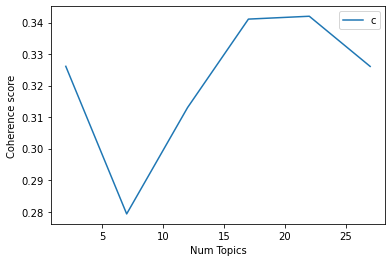

In [148]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_2019_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [149]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_2019_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.3261
index: 1 | Num Topics = 7  has Coherence Value of 0.2793
index: 2 | Num Topics = 12  has Coherence Value of 0.313
index: 3 | Num Topics = 17  has Coherence Value of 0.3411
index: 4 | Num Topics = 22  has Coherence Value of 0.342
index: 5 | Num Topics = 27  has Coherence Value of 0.3261


In [203]:
# Select optimal number of topics
optimal_model_us_2019_score1N2N3 = model_list_us_2019_score1N2N3[4]

In [204]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_2019_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_us_2019_score1N2N3, corpus_us_2019_score1N2N3, id2word_us_2019_score1N2N3)

In [205]:
print("pyLDAVis for us topics for score=1,2,3 in 2019:")
vis_us_2019_score1N2N3

pyLDAVis for us topics for score=1,2,3 in 2019:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
21     0.140944 -0.011074       1        1  12.954358
10     0.142746  0.021099       2        1   7.868801
6      0.070713 -0.046350       3        1   7.834694
8      0.084892 -0.042105       4        1   7.074293
15    -0.027360 -0.122504       5        1   6.585240
0      0.030819 -0.069927       6        1   6.206809
7      0.008907  0.009294       7        1   5.702722
4      0.026162 -0.096993       8        1   5.135906
19     0.008593 -0.032636       9        1   4.925010
20     0.086318  0.046659      10        1   4.622082
3     -0.020043  0.052454      11        1   4.612437
16     0.049383 -0.026272      12        1   3.911706
18    -0.067371 -0.144670      13        1   3.418198
17     0.036208  0.084449      14        1   2.819186
13    -0.015023  0.085907      15        1   2.681571
12     0.017832  0.110469      16        1   2.652945
9     -0.031829  0.015901      17        1   2.302940
2     -0.016670  0.094151      18        1   2.288484
5     -0.019102  0.043184      19        1   2.234391
14    -0.150183  0.000140      20        1   1.742543
11    -0.173600 -0.005247      21        1   1.500422
1     -0.182332  0.034071      22        1   0.925263, topic_info=      Term        Freq       Total Category  logprob  loglift
62    edit   72.000000   72.000000  Default  30.0000  30.0000
44    work   87.000000   87.000000  Default  29.0000  29.0000
69    back   32.000000   32.000000  Default  28.0000  28.0000
31   video  294.000000  294.000000  Default  27.0000  27.0000
102  music   44.000000   44.000000  Default  26.0000  26.0000
..     ...         ...         ...      ...      ...      ...
30    time    1.471852  133.032231  Topic22  -3.5325   0.1788
2      app    1.442583  365.021687  Topic22  -3.5526  -0.8507
28   start    0.667625   68.038166  Topic22  -4.3231   0.0588
60    song    0.667625   50.339413  Topic22  -4.3231   0.3600
102  music    0.667624   44.646333  Topic22  -4.3231   0.4800

[1282 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
410       5  0.581331  ability
106       2  0.176307     able
106       4  0.088153     able
106      11  0.088153     able
106      12  0.088153     able
...     ...       ...      ...
210      18  0.293801      yet
844       3  0.578529       yk
669       3  0.762258    young
479       7  0.393410     zoom
479      14  0.393410     zoom

[2169 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[22, 11, 7, 9, 16, 1, 8, 5, 20, 21, 4, 17, 19, 18, 14, 13, 10, 3, 6, 15, 12, 2])

## By-rating of 2020 (Rating=1,2,3)

In [153]:
# By-rating Topic Modelling - rating = 1,2,3 in 2020
# Convert to list - move to each section
review_us_2020_score1N2N3 = lomotif_ios_us_review_YearMonth_2020_score1N2N3.review.values.tolist()
review_words_us_2020_score1N2N3 = list(sent_to_words(review_us_2020_score1N2N3))
print(review_words_us_2020_score1N2N3[:1])

[['spent', 'like', 'minutes', 'editing', 'video', 'the', 'app', 'decided', 'to', 'freeze', 'next', 'thing', 'you', 'know', 'my', 'video', 'disappeared', 'now', 'it', 'no', 'where', 'to', 'be', 'found', 'on', 'this', 'app', 'this', 'isn', 'the', 'first', 'time', 'the', 'app', 'had', 'done', 'this', 'bs', 'but', 'it', 'is', 'good', 'video', 'using', 'app', 'but', 'it', 'needs', 'to', 'start', 'saving', 'people', 'videos', 'when', 'their', 'in', 'the', 'middle', 'of', 'editing', 'it']]


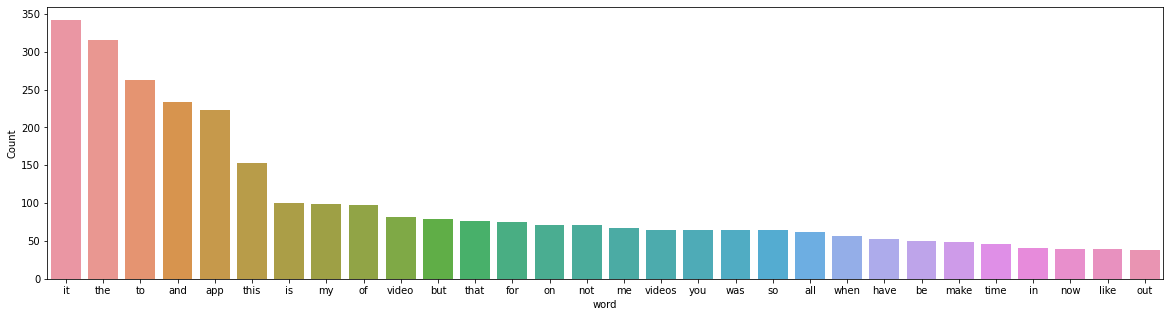

In [154]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_2020_score1N2N3))

In [155]:
# Clean text
review_words_us_ready_2020_score1N2N3 = process_words(review_words_us_2020_score1N2N3)  # processed Text Data! - move to each section

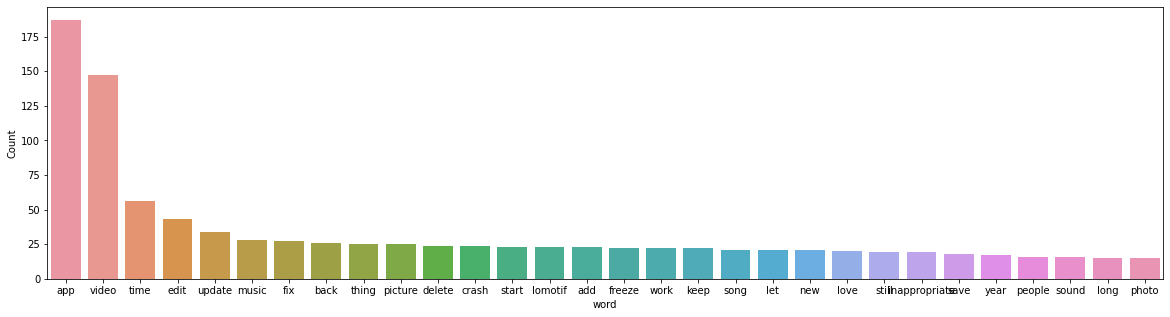

In [156]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_us_ready_2020_score1N2N3))


In [157]:
# Create Dictionary
id2word_us_2020_score1N2N3 = corpora.Dictionary(review_words_us_ready_2020_score1N2N3)

2021-10-17 03:13:42,077 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 03:13:42,088 [INFO] gensim.corpora.dictionary - built Dictionary(630 unique tokens: ['app', 'bs', 'decide', 'disappear', 'edit']...) from 172 documents (total 2499 corpus positions)
2021-10-17 03:13:42,090 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(630 unique tokens: ['app', 'bs', 'decide', 'disappear', 'edit']...) from 172 documents (total 2499 corpus positions)", 'datetime': '2021-10-17T03:13:42.090040', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [158]:
# Create Corpus: Term Document Frequency
corpus_us_2020_score1N2N3 = [id2word_us_2020_score1N2N3.doc2bow(text) for text in review_words_us_ready_2020_score1N2N3]

In [159]:
# Training LDA model
model_list_us_2020_score1N2N3, coherence_values_us_2020_score1N2N3 = compute_coherence_values(dictionary=id2word_us_2020_score1N2N3, corpus=corpus_us_2020_score1N2N3, 
                                                              texts=review_words_us_ready_2020_score1N2N3, limit=30, start=2, step=5)


2021-10-17 03:13:42,113 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 03:13:42,115 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 03:13:42,118 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 03:13:42,120 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 172 documents, updating model once every 172 documents, evaluating perplexity every 172 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 03:13:42,671 [INFO] gensim.models.ldamodel - -7.057 per-word bound, 133.2 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:13:42,672 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #172/172
2021-10-17 03:13:43,201 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.045*"app" + 0.045*"video" + 0.018*"time" + 0.013*"back" + 0.012*"lomotif" + 0.011*"picture" + 0.011*"u

2021-10-17 03:13:48,217 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.072*"app" + 0.055*"video" + 0.021*"time" + 0.019*"edit" + 0.014*"fix" + 0.012*"update" + 0.012*"music" + 0.011*"crash" + 0.011*"song" + 0.011*"let"
2021-10-17 03:13:48,219 [INFO] gensim.models.ldamodel - topic diff=0.015281, rho=0.301511
2021-10-17 03:13:48,476 [INFO] gensim.models.ldamodel - -5.889 per-word bound, 59.2 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:13:48,481 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #172/172
2021-10-17 03:13:48,699 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.040*"app" + 0.034*"video" + 0.016*"lomotif" + 0.016*"inappropriate" + 0.015*"thing" + 0.013*"time" + 0.012*"sound" + 0.012*"back" + 0.011*"delete" + 0.009*"kid"
2021-10-17 03:13:48,700 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.072*"app" + 0.055*"video" + 0.021*"time" + 0.019*"edit" + 0.014*"fix" + 0.013*"update" + 0.012*"music" + 0.011*"c

2021-10-17 03:13:52,676 [INFO] gensim.models.ldamodel - topic diff=0.011630, rho=0.218218
2021-10-17 03:13:52,928 [INFO] gensim.models.ldamodel - -5.878 per-word bound, 58.8 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:13:52,929 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #172/172
2021-10-17 03:13:53,087 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.041*"app" + 0.031*"video" + 0.017*"inappropriate" + 0.016*"thing" + 0.016*"lomotif" + 0.014*"sound" + 0.010*"back" + 0.010*"time" + 0.010*"delete" + 0.010*"kid"
2021-10-17 03:13:53,094 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.071*"app" + 0.057*"video" + 0.023*"time" + 0.020*"edit" + 0.014*"fix" + 0.013*"update" + 0.012*"music" + 0.012*"crash" + 0.011*"freeze" + 0.011*"work"
2021-10-17 03:13:53,103 [INFO] gensim.models.ldamodel - topic diff=0.012168, rho=0.213201
2021-10-17 03:13:53,330 [INFO] gensim.models.ldamodel - -5.876 per-word bound, 58.7 perplexity e

2021-10-17 03:13:57,077 [INFO] gensim.models.ldamodel - -5.862 per-word bound, 58.2 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:13:57,078 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #172/172
2021-10-17 03:13:57,293 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.043*"app" + 0.028*"video" + 0.017*"thing" + 0.017*"inappropriate" + 0.015*"lomotif" + 0.014*"sound" + 0.010*"kid" + 0.010*"mute" + 0.009*"look" + 0.009*"delete"
2021-10-17 03:13:57,294 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.070*"app" + 0.059*"video" + 0.024*"time" + 0.021*"edit" + 0.014*"update" + 0.014*"fix" + 0.012*"music" + 0.012*"crash" + 0.011*"freeze" + 0.011*"work"
2021-10-17 03:13:57,295 [INFO] gensim.models.ldamodel - topic diff=0.009916, rho=0.176777
2021-10-17 03:13:57,540 [INFO] gensim.models.ldamodel - -5.861 per-word bound, 58.1 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:13:57,54

2021-10-17 03:14:01,291 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #172/172
2021-10-17 03:14:01,441 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.045*"app" + 0.025*"video" + 0.018*"thing" + 0.017*"inappropriate" + 0.015*"lomotif" + 0.014*"sound" + 0.011*"kid" + 0.010*"mute" + 0.009*"look" + 0.008*"delete"
2021-10-17 03:14:01,442 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.069*"app" + 0.060*"video" + 0.025*"time" + 0.021*"edit" + 0.014*"update" + 0.014*"fix" + 0.013*"music" + 0.012*"crash" + 0.011*"freeze" + 0.011*"work"
2021-10-17 03:14:01,443 [INFO] gensim.models.ldamodel - topic diff=0.006815, rho=0.154303
2021-10-17 03:14:01,649 [INFO] gensim.models.ldamodel - -5.853 per-word bound, 57.8 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:14:01,651 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #172/172
2021-10-17 03:14:01,842 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.045*"app" + 0.

2021-10-17 03:14:05,045 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-17 03:14:09,324 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 03:14:09,387 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 171 virtual documents
2021-10-17 03:14:09,593 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 03:14:09,594 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 03:14:09,596 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 03:14:09,599 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 172 documents, updating model once every 172 documents, evaluating perplexity every 172 documents, iterating 50x with a con

2021-10-17 03:14:12,058 [INFO] gensim.models.ldamodel - topic diff=0.061783, rho=0.408248
2021-10-17 03:14:12,304 [INFO] gensim.models.ldamodel - -6.229 per-word bound, 75.0 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:14:12,305 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #172/172
2021-10-17 03:14:12,470 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.035*"app" + 0.022*"sound" + 0.018*"kid" + 0.017*"look" + 0.017*"vid" + 0.017*"delete" + 0.014*"problem" + 0.014*"thing" + 0.012*"video" + 0.011*"well"
2021-10-17 03:14:12,471 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.035*"app" + 0.025*"video" + 0.019*"back" + 0.018*"update" + 0.016*"start" + 0.016*"edit" + 0.016*"add" + 0.014*"new" + 0.012*"lomotif" + 0.012*"music"
2021-10-17 03:14:12,473 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.075*"video" + 0.059*"app" + 0.019*"mute" + 0.018*"let" + 0.013*"time" + 0.011*"save" + 0.011*"music" + 0.010*"delete" + 0

2021-10-17 03:14:14,431 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.077*"app" + 0.042*"video" + 0.028*"update" + 0.021*"thing" + 0.015*"lomotif" + 0.015*"new" + 0.015*"back" + 0.013*"bad" + 0.012*"old" + 0.011*"change"
2021-10-17 03:14:14,432 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.060*"app" + 0.029*"edit" + 0.027*"video" + 0.024*"music" + 0.024*"crash" + 0.022*"time" + 0.019*"fix" + 0.018*"keep" + 0.014*"happen" + 0.013*"really"
2021-10-17 03:14:14,433 [INFO] gensim.models.ldamodel - topic diff=0.014845, rho=0.288675
2021-10-17 03:14:14,664 [INFO] gensim.models.ldamodel - -6.205 per-word bound, 73.8 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:14:14,666 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #172/172
2021-10-17 03:14:14,805 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.078*"video" + 0.031*"app" + 0.030*"song" + 0.026*"time" + 0.019*"play" + 0.016*"let" + 0.015*"music" + 0.015*"put" + 0.0

2021-10-17 03:14:16,724 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.061*"app" + 0.029*"edit" + 0.028*"video" + 0.024*"music" + 0.024*"crash" + 0.021*"time" + 0.019*"fix" + 0.017*"keep" + 0.014*"happen" + 0.014*"really"
2021-10-17 03:14:16,727 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.034*"app" + 0.027*"video" + 0.020*"back" + 0.019*"update" + 0.016*"add" + 0.016*"edit" + 0.015*"new" + 0.012*"lomotif" + 0.012*"save" + 0.012*"picture"
2021-10-17 03:14:16,730 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.076*"app" + 0.041*"video" + 0.030*"update" + 0.021*"thing" + 0.016*"new" + 0.016*"lomotif" + 0.015*"back" + 0.013*"bad" + 0.012*"old" + 0.011*"change"
2021-10-17 03:14:16,731 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.035*"app" + 0.028*"look" + 0.027*"kid" + 0.021*"sound" + 0.020*"thing" + 0.020*"vid" + 0.014*"problem" + 0.013*"inappropriate" + 0.011*"delete" + 0.011*"start"
2021-10-17 03:14:16,733 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.078*"v

2021-10-17 03:14:18,643 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.035*"app" + 0.030*"look" + 0.029*"kid" + 0.021*"thing" + 0.021*"sound" + 0.020*"vid" + 0.014*"problem" + 0.013*"inappropriate" + 0.012*"start" + 0.011*"sex"
2021-10-17 03:14:18,645 [INFO] gensim.models.ldamodel - topic diff=0.003181, rho=0.208514
2021-10-17 03:14:18,879 [INFO] gensim.models.ldamodel - -6.193 per-word bound, 73.2 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:14:18,881 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #172/172
2021-10-17 03:14:19,048 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.078*"video" + 0.030*"song" + 0.030*"app" + 0.025*"time" + 0.019*"play" + 0.017*"let" + 0.015*"put" + 0.014*"music" + 0.014*"people" + 0.012*"love"
2021-10-17 03:14:19,051 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.075*"video" + 0.058*"app" + 0.022*"mute" + 0.018*"let" + 0.015*"time" + 0.012*"music" + 0.012*"delete" + 0.012*"sound"

2021-10-17 03:14:20,888 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.085*"app" + 0.055*"video" + 0.043*"time" + 0.026*"picture" + 0.024*"edit" + 0.017*"freeze" + 0.014*"start" + 0.013*"kick" + 0.012*"fix" + 0.010*"song"
2021-10-17 03:14:20,891 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.076*"app" + 0.041*"video" + 0.031*"update" + 0.021*"thing" + 0.017*"new" + 0.016*"lomotif" + 0.016*"back" + 0.013*"bad" + 0.012*"change" + 0.012*"old"
2021-10-17 03:14:20,893 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.078*"video" + 0.030*"song" + 0.030*"app" + 0.025*"time" + 0.019*"play" + 0.017*"let" + 0.015*"put" + 0.014*"people" + 0.014*"music" + 0.012*"love"
2021-10-17 03:14:20,895 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.033*"app" + 0.027*"video" + 0.020*"back" + 0.020*"update" + 0.017*"add" + 0.017*"edit" + 0.016*"new" + 0.013*"save" + 0.013*"lomotif" + 0.013*"picture"
2021-10-17 03:14:20,897 [INFO] gensim.models.ldamodel - topic diff=0.001678, rho=0.185695
2021-

2021-10-17 03:14:22,805 [INFO] gensim.models.ldamodel - topic diff=0.001012, rho=0.171499
2021-10-17 03:14:22,976 [INFO] gensim.models.ldamodel - -6.191 per-word bound, 73.0 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:14:22,977 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #172/172
2021-10-17 03:14:23,098 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.036*"app" + 0.030*"look" + 0.029*"kid" + 0.021*"thing" + 0.020*"sound" + 0.020*"vid" + 0.014*"problem" + 0.014*"inappropriate" + 0.013*"start" + 0.012*"sex"
2021-10-17 03:14:23,101 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.085*"app" + 0.055*"video" + 0.043*"time" + 0.026*"picture" + 0.024*"edit" + 0.017*"freeze" + 0.014*"start" + 0.013*"kick" + 0.012*"fix" + 0.010*"song"
2021-10-17 03:14:23,103 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.062*"app" + 0.029*"edit" + 0.029*"video" + 0.024*"music" + 0.024*"crash" + 0.019*"fix" + 0.018*"time" + 0.017*"kee

2021-10-17 03:14:25,062 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.076*"app" + 0.041*"video" + 0.032*"update" + 0.021*"thing" + 0.017*"new" + 0.016*"back" + 0.016*"lomotif" + 0.013*"bad" + 0.012*"change" + 0.012*"old"
2021-10-17 03:14:25,064 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.062*"app" + 0.029*"edit" + 0.029*"video" + 0.024*"music" + 0.024*"crash" + 0.019*"fix" + 0.018*"time" + 0.017*"keep" + 0.015*"really" + 0.015*"always"
2021-10-17 03:14:25,066 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.076*"video" + 0.057*"app" + 0.022*"mute" + 0.018*"let" + 0.016*"time" + 0.013*"music" + 0.012*"delete" + 0.012*"sound" + 0.011*"edit" + 0.011*"save"
2021-10-17 03:14:25,068 [INFO] gensim.models.ldamodel - topic diff=0.000594, rho=0.158114
2021-10-17 03:14:25,225 [INFO] gensim.models.ldamodel - -6.190 per-word bound, 73.0 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:14:25,226 [INFO] gensim.models.ldamodel - PROGRESS: p

2021-10-17 03:14:27,011 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #172/172
2021-10-17 03:14:27,213 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.076*"video" + 0.057*"app" + 0.022*"mute" + 0.018*"let" + 0.016*"time" + 0.013*"music" + 0.012*"delete" + 0.012*"sound" + 0.011*"edit" + 0.011*"save"
2021-10-17 03:14:27,215 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.033*"app" + 0.027*"video" + 0.020*"back" + 0.020*"update" + 0.017*"add" + 0.017*"edit" + 0.016*"new" + 0.013*"save" + 0.013*"lomotif" + 0.013*"picture"
2021-10-17 03:14:27,221 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.085*"app" + 0.055*"video" + 0.043*"time" + 0.026*"picture" + 0.024*"edit" + 0.017*"freeze" + 0.014*"start" + 0.013*"kick" + 0.012*"fix" + 0.010*"song"
2021-10-17 03:14:27,224 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.036*"app" + 0.030*"look" + 0.029*"kid" + 0.021*"thing" + 0.020*"sound" + 0.020*"vid" + 0.014*"problem" + 0.014*"inappropriate" + 0.013*"start" + 0.0

2021-10-17 03:14:29,170 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.078*"video" + 0.030*"song" + 0.030*"app" + 0.025*"time" + 0.019*"play" + 0.017*"let" + 0.015*"put" + 0.014*"people" + 0.014*"music" + 0.012*"love"
2021-10-17 03:14:29,171 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.085*"app" + 0.055*"video" + 0.043*"time" + 0.026*"picture" + 0.024*"edit" + 0.017*"freeze" + 0.014*"start" + 0.013*"kick" + 0.012*"fix" + 0.010*"song"
2021-10-17 03:14:29,172 [INFO] gensim.models.ldamodel - topic diff=0.000214, rho=0.140028
2021-10-17 03:14:29,173 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=630, num_topics=7, decay=0.5, chunksize=1000) in 19.57s', 'datetime': '2021-10-17T03:14:29.173854', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-17 03:14:29,178 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOc

2021-10-17 03:14:36,320 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.103*"video" + 0.035*"let" + 0.027*"time" + 0.026*"clip" + 0.020*"select" + 0.019*"minute" + 0.019*"app" + 0.017*"add" + 0.015*"work" + 0.014*"option"
2021-10-17 03:14:36,322 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.065*"app" + 0.033*"video" + 0.024*"update" + 0.019*"save" + 0.019*"delete" + 0.019*"problem" + 0.019*"work" + 0.014*"back" + 0.014*"inappropriate" + 0.014*"time"
2021-10-17 03:14:36,323 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.061*"app" + 0.034*"update" + 0.027*"video" + 0.025*"thing" + 0.021*"back" + 0.017*"change" + 0.016*"old" + 0.015*"new" + 0.014*"project" + 0.014*"lomotif"
2021-10-17 03:14:36,325 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.083*"app" + 0.060*"video" + 0.038*"edit" + 0.034*"time" + 0.022*"keep" + 0.020*"picture" + 0.016*"song" + 0.016*"still" + 0.016*"kick" + 0.014*"freeze"
2021-10-17 03:14:36,326 [INFO] gensim.models.ldamodel - topic diff=0.085715,

2021-10-17 03:14:38,023 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.063*"video" + 0.054*"camera" + 0.036*"roll" + 0.034*"time" + 0.033*"picture" + 0.028*"app" + 0.025*"show" + 0.022*"put" + 0.020*"let" + 0.017*"allow"
2021-10-17 03:14:38,025 [INFO] gensim.models.ldamodel - topic diff=0.022563, rho=0.301511
2021-10-17 03:14:38,235 [INFO] gensim.models.ldamodel - -6.317 per-word bound, 79.7 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:14:38,236 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #172/172
2021-10-17 03:14:38,333 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.063*"video" + 0.055*"camera" + 0.038*"roll" + 0.034*"time" + 0.033*"picture" + 0.028*"app" + 0.025*"show" + 0.023*"put" + 0.022*"let" + 0.017*"allow"
2021-10-17 03:14:38,334 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.099*"app" + 0.017*"find" + 0.016*"video" + 0.014*"edit" + 0.014*"much" + 0.012*"bad" + 0.012*"look" + 0.012*"lose" + 0.01

2021-10-17 03:14:40,074 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.099*"video" + 0.055*"app" + 0.046*"mute" + 0.027*"time" + 0.026*"sound" + 0.020*"fix" + 0.017*"lomotif" + 0.016*"music" + 0.013*"still" + 0.010*"inappropriate"
2021-10-17 03:14:40,076 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.085*"app" + 0.061*"video" + 0.037*"edit" + 0.033*"time" + 0.026*"keep" + 0.020*"picture" + 0.016*"song" + 0.016*"still" + 0.016*"kick" + 0.015*"happen"
2021-10-17 03:14:40,079 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.033*"app" + 0.033*"kid" + 0.025*"inappropriate" + 0.024*"lomotif" + 0.018*"thing" + 0.017*"switch" + 0.017*"start" + 0.017*"ask" + 0.016*"stuff" + 0.014*"people"
2021-10-17 03:14:40,080 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.051*"app" + 0.036*"sound" + 0.024*"delete" + 0.018*"add" + 0.018*"vid" + 0.016*"thing" + 0.012*"video" + 0.012*"age" + 0.012*"picture" + 0.012*"fact"
2021-10-17 03:14:40,083 [INFO] gensim.models.ldamodel - topic diff=0.007

2021-10-17 03:14:41,848 [INFO] gensim.models.ldamodel - topic diff=0.003381, rho=0.213201
2021-10-17 03:14:42,052 [INFO] gensim.models.ldamodel - -6.302 per-word bound, 78.9 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:14:42,053 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #172/172
2021-10-17 03:14:42,199 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.058*"app" + 0.041*"update" + 0.028*"thing" + 0.027*"video" + 0.022*"back" + 0.022*"old" + 0.020*"change" + 0.020*"lomotif" + 0.018*"new" + 0.016*"bad"
2021-10-17 03:14:42,201 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.051*"app" + 0.036*"sound" + 0.024*"delete" + 0.018*"add" + 0.018*"vid" + 0.015*"thing" + 0.012*"video" + 0.012*"age" + 0.012*"picture" + 0.012*"fact"
2021-10-17 03:14:42,203 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.100*"video" + 0.055*"app" + 0.046*"mute" + 0.027*"time" + 0.026*"sound" + 0.020*"fix" + 0.016*"music" + 0.016*"lomotif" +

2021-10-17 03:14:43,953 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.046*"music" + 0.038*"video" + 0.032*"app" + 0.029*"update" + 0.028*"crash" + 0.025*"photo" + 0.022*"edit" + 0.021*"time" + 0.020*"new" + 0.020*"add"
2021-10-17 03:14:43,954 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.085*"app" + 0.062*"video" + 0.037*"edit" + 0.033*"time" + 0.026*"keep" + 0.020*"picture" + 0.016*"song" + 0.016*"still" + 0.016*"kick" + 0.016*"happen"
2021-10-17 03:14:43,955 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.058*"app" + 0.041*"update" + 0.028*"thing" + 0.027*"video" + 0.022*"back" + 0.022*"old" + 0.021*"lomotif" + 0.020*"change" + 0.018*"new" + 0.016*"bad"
2021-10-17 03:14:43,956 [INFO] gensim.models.ldamodel - topic diff=0.001447, rho=0.188982
2021-10-17 03:14:44,118 [INFO] gensim.models.ldamodel - -6.301 per-word bound, 78.8 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:14:44,120 [INFO] gensim.models.ldamodel - PROGRESS: 

2021-10-17 03:14:45,945 [INFO] gensim.models.ldamodel - -6.300 per-word bound, 78.8 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:14:45,947 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #172/172
2021-10-17 03:14:46,030 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.099*"app" + 0.017*"find" + 0.016*"video" + 0.014*"edit" + 0.014*"much" + 0.012*"bad" + 0.012*"look" + 0.012*"lose" + 0.012*"child" + 0.012*"hate"
2021-10-17 03:14:46,032 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.100*"video" + 0.055*"app" + 0.046*"mute" + 0.027*"time" + 0.026*"sound" + 0.020*"fix" + 0.016*"music" + 0.015*"lomotif" + 0.013*"still" + 0.010*"picture"
2021-10-17 03:14:46,034 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.051*"app" + 0.036*"sound" + 0.024*"delete" + 0.018*"add" + 0.018*"vid" + 0.014*"thing" + 0.012*"video" + 0.012*"picture" + 0.012*"age" + 0.012*"fact"
2021-10-17 03:14:46,035 [INFO] gensim.models.ldamodel - topic

2021-10-17 03:14:47,792 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.067*"video" + 0.047*"app" + 0.019*"inappropriate" + 0.019*"work" + 0.015*"people" + 0.015*"prefer" + 0.011*"delete" + 0.011*"let" + 0.011*"edit" + 0.010*"long"
2021-10-17 03:14:47,793 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.100*"video" + 0.055*"app" + 0.046*"mute" + 0.027*"time" + 0.026*"sound" + 0.020*"fix" + 0.016*"music" + 0.015*"lomotif" + 0.013*"still" + 0.010*"picture"
2021-10-17 03:14:47,794 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.033*"app" + 0.033*"kid" + 0.025*"inappropriate" + 0.024*"lomotif" + 0.018*"thing" + 0.017*"start" + 0.017*"switch" + 0.017*"ask" + 0.017*"stuff" + 0.014*"people"
2021-10-17 03:14:47,795 [INFO] gensim.models.ldamodel - topic diff=0.000291, rho=0.160128
2021-10-17 03:14:47,962 [INFO] gensim.models.ldamodel - -6.300 per-word bound, 78.8 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:14:47,964 [INFO] gensim.mode

2021-10-17 03:14:49,789 [INFO] gensim.models.ldamodel - -6.300 per-word bound, 78.8 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:14:49,790 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #172/172
2021-10-17 03:14:49,906 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.033*"app" + 0.033*"kid" + 0.025*"inappropriate" + 0.024*"lomotif" + 0.018*"thing" + 0.017*"start" + 0.017*"switch" + 0.017*"ask" + 0.017*"stuff" + 0.014*"people"
2021-10-17 03:14:49,908 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.058*"app" + 0.041*"update" + 0.028*"thing" + 0.026*"video" + 0.022*"back" + 0.022*"old" + 0.021*"lomotif" + 0.020*"change" + 0.018*"new" + 0.017*"bad"
2021-10-17 03:14:49,911 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.046*"music" + 0.038*"video" + 0.033*"app" + 0.029*"update" + 0.028*"crash" + 0.025*"photo" + 0.022*"edit" + 0.021*"time" + 0.020*"new" + 0.020*"add"
2021-10-17 03:14:49,913 [INFO] gensim.models.ldamo

2021-10-17 03:14:51,631 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.100*"video" + 0.055*"app" + 0.046*"mute" + 0.027*"time" + 0.026*"sound" + 0.020*"fix" + 0.016*"music" + 0.015*"lomotif" + 0.013*"still" + 0.010*"picture"
2021-10-17 03:14:51,634 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.066*"app" + 0.034*"video" + 0.024*"update" + 0.020*"delete" + 0.020*"problem" + 0.020*"work" + 0.019*"save" + 0.015*"song" + 0.015*"always" + 0.015*"back"
2021-10-17 03:14:51,636 [INFO] gensim.models.ldamodel - topic diff=0.000059, rho=0.141421
2021-10-17 03:14:51,895 [INFO] gensim.models.ldamodel - -6.300 per-word bound, 78.8 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:14:51,897 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #172/172
2021-10-17 03:14:51,979 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.051*"app" + 0.037*"sound" + 0.025*"delete" + 0.019*"add" + 0.019*"vid" + 0.014*"thing" + 0.013*"picture" + 0.013

2021-10-17 03:14:59,297 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.086*"video" + 0.055*"app" + 0.033*"lomotif" + 0.029*"mute" + 0.020*"sound" + 0.019*"thing" + 0.019*"time" + 0.018*"picture" + 0.017*"play" + 0.017*"fix"
2021-10-17 03:14:59,298 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.048*"app" + 0.043*"video" + 0.030*"crash" + 0.028*"save" + 0.027*"freeze" + 0.024*"time" + 0.019*"work" + 0.019*"music" + 0.015*"constantly" + 0.014*"photo"
2021-10-17 03:14:59,300 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.076*"video" + 0.055*"app" + 0.027*"time" + 0.023*"delete" + 0.023*"great" + 0.020*"let" + 0.017*"edit" + 0.013*"music" + 0.013*"select" + 0.011*"glitch"
2021-10-17 03:14:59,301 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.050*"sound" + 0.050*"app" + 0.017*"look" + 0.017*"really" + 0.017*"year" + 0.017*"old" + 0.017*"tok" + 0.017*"well" + 0.017*"start" + 0.017*"vid"
2021-10-17 03:14:59,302 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.025*"thin

2021-10-17 03:15:01,054 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.077*"video" + 0.055*"app" + 0.028*"time" + 0.024*"delete" + 0.024*"great" + 0.020*"let" + 0.016*"edit" + 0.014*"music" + 0.014*"select" + 0.013*"glitch"
2021-10-17 03:15:01,055 [INFO] gensim.models.ldamodel - topic diff=0.034781, rho=0.316228
2021-10-17 03:15:01,238 [INFO] gensim.models.ldamodel - -6.437 per-word bound, 86.6 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:15:01,241 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #172/172
2021-10-17 03:15:01,427 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.024*"thing" + 0.019*"show" + 0.019*"camera" + 0.019*"roll" + 0.019*"picture" + 0.019*"watch" + 0.019*"people" + 0.019*"old" + 0.019*"give" + 0.014*"lomotif"
2021-10-17 03:15:01,429 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.055*"app" + 0.052*"add" + 0.049*"music" + 0.042*"photo" + 0.032*"delete" + 0.022*"video" + 0.021*"time" + 0.021

2021-10-17 03:15:03,070 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.050*"app" + 0.035*"thing" + 0.034*"start" + 0.033*"kid" + 0.028*"video" + 0.027*"update" + 0.027*"back" + 0.024*"lomotif" + 0.020*"music" + 0.020*"inappropriate"
2021-10-17 03:15:03,071 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.082*"video" + 0.055*"app" + 0.030*"time" + 0.027*"delete" + 0.023*"great" + 0.020*"let" + 0.016*"glitch" + 0.016*"edit" + 0.013*"music" + 0.013*"select"
2021-10-17 03:15:03,072 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.051*"sound" + 0.049*"app" + 0.017*"really" + 0.017*"look" + 0.017*"year" + 0.017*"old" + 0.017*"tok" + 0.017*"well" + 0.017*"vid" + 0.017*"pic"
2021-10-17 03:15:03,074 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.097*"app" + 0.031*"video" + 0.018*"back" + 0.018*"close" + 0.017*"update" + 0.017*"project" + 0.014*"keep" + 0.014*"thing" + 0.014*"child" + 0.010*"delete"
2021-10-17 03:15:03,075 [INFO] gensim.models.ldamodel - topic diff=0.010588, rho=

2021-10-17 03:15:04,675 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.095*"app" + 0.020*"keep" + 0.020*"slideshow" + 0.020*"hate" + 0.018*"horrible" + 0.015*"work" + 0.015*"porn" + 0.015*"lose" + 0.015*"already" + 0.014*"bad"
2021-10-17 03:15:04,676 [INFO] gensim.models.ldamodel - topic diff=0.005382, rho=0.218218
2021-10-17 03:15:04,832 [INFO] gensim.models.ldamodel - -6.414 per-word bound, 85.3 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:15:04,842 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #172/172
2021-10-17 03:15:04,981 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.050*"app" + 0.036*"thing" + 0.034*"start" + 0.033*"kid" + 0.029*"video" + 0.027*"update" + 0.027*"back" + 0.024*"lomotif" + 0.020*"music" + 0.020*"inappropriate"
2021-10-17 03:15:04,984 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.090*"video" + 0.057*"app" + 0.040*"mute" + 0.032*"lomotif" + 0.027*"sound" + 0.022*"picture" + 0.019*"t

2021-10-17 03:15:06,695 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.089*"app" + 0.068*"video" + 0.042*"edit" + 0.033*"time" + 0.023*"kick" + 0.018*"picture" + 0.018*"happen" + 0.017*"keep" + 0.016*"fix" + 0.016*"work"
2021-10-17 03:15:06,697 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.046*"edit" + 0.045*"app" + 0.037*"video" + 0.030*"fix" + 0.020*"crash" + 0.015*"find" + 0.015*"music" + 0.015*"close" + 0.015*"always" + 0.013*"new"
2021-10-17 03:15:06,698 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.091*"video" + 0.036*"time" + 0.035*"let" + 0.035*"put" + 0.033*"back" + 0.031*"app" + 0.031*"update" + 0.030*"picture" + 0.024*"camera" + 0.022*"new"
2021-10-17 03:15:06,701 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.056*"app" + 0.047*"add" + 0.045*"music" + 0.043*"photo" + 0.032*"delete" + 0.022*"video" + 0.022*"time" + 0.022*"select" + 0.022*"song" + 0.022*"crash"
2021-10-17 03:15:06,702 [INFO] gensim.models.ldamodel - topic diff=0.003338, rho=0.192450
2021

2021-10-17 03:15:08,311 [INFO] gensim.models.ldamodel - topic diff=0.002080, rho=0.176777
2021-10-17 03:15:08,523 [INFO] gensim.models.ldamodel - -6.406 per-word bound, 84.8 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:15:08,525 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #172/172
2021-10-17 03:15:08,609 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.096*"app" + 0.031*"video" + 0.017*"back" + 0.017*"update" + 0.017*"project" + 0.014*"close" + 0.014*"keep" + 0.014*"thing" + 0.014*"child" + 0.010*"delete"
2021-10-17 03:15:08,611 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.052*"sound" + 0.048*"app" + 0.017*"look" + 0.017*"really" + 0.017*"year" + 0.017*"old" + 0.017*"tok" + 0.017*"well" + 0.017*"vid" + 0.017*"pic"
2021-10-17 03:15:08,612 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.062*"video" + 0.055*"app" + 0.040*"update" + 0.030*"time" + 0.022*"anymore" + 0.022*"new" + 0.022*"photo" + 0.018*"bad" +

2021-10-17 03:15:10,326 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.090*"video" + 0.057*"app" + 0.040*"mute" + 0.031*"lomotif" + 0.029*"sound" + 0.022*"picture" + 0.019*"fix" + 0.019*"time" + 0.018*"thing" + 0.017*"play"
2021-10-17 03:15:10,327 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.097*"app" + 0.020*"keep" + 0.020*"slideshow" + 0.020*"hate" + 0.020*"horrible" + 0.015*"work" + 0.015*"porn" + 0.015*"already" + 0.014*"bad" + 0.014*"lose"
2021-10-17 03:15:10,328 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.085*"app" + 0.040*"start" + 0.034*"time" + 0.027*"really" + 0.026*"edit" + 0.023*"video" + 0.020*"crash" + 0.020*"tok" + 0.019*"freeze" + 0.014*"tik"
2021-10-17 03:15:10,330 [INFO] gensim.models.ldamodel - topic diff=0.001366, rho=0.162221
2021-10-17 03:15:10,501 [INFO] gensim.models.ldamodel - -6.405 per-word bound, 84.7 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:15:10,502 [INFO] gensim.models.ldamodel - PR

2021-10-17 03:15:12,180 [INFO] gensim.models.ldamodel - -6.404 per-word bound, 84.7 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:15:12,181 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #172/172
2021-10-17 03:15:12,319 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.081*"video" + 0.030*"app" + 0.022*"inappropriate" + 0.022*"past" + 0.015*"reason" + 0.015*"content" + 0.015*"suggest" + 0.015*"dubsmash" + 0.015*"people" + 0.015*"end"
2021-10-17 03:15:12,321 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.089*"video" + 0.057*"app" + 0.040*"mute" + 0.031*"lomotif" + 0.029*"sound" + 0.022*"picture" + 0.019*"fix" + 0.019*"time" + 0.018*"thing" + 0.017*"play"
2021-10-17 03:15:12,322 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.085*"app" + 0.040*"start" + 0.034*"time" + 0.027*"really" + 0.026*"edit" + 0.023*"video" + 0.020*"tok" + 0.020*"crash" + 0.019*"freeze" + 0.014*"tik"
2021-10-17 03:15:12,324 [INFO] gensim.mod

2021-10-17 03:15:14,049 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.083*"video" + 0.056*"app" + 0.031*"time" + 0.029*"delete" + 0.023*"great" + 0.020*"let" + 0.017*"glitch" + 0.015*"edit" + 0.013*"music" + 0.013*"select"
2021-10-17 03:15:14,051 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.088*"app" + 0.068*"video" + 0.043*"edit" + 0.033*"time" + 0.023*"kick" + 0.017*"picture" + 0.017*"happen" + 0.017*"keep" + 0.016*"work" + 0.016*"fix"
2021-10-17 03:15:14,052 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.106*"song" + 0.049*"choose" + 0.045*"video" + 0.035*"app" + 0.029*"part" + 0.025*"let" + 0.020*"limit" + 0.020*"sign" + 0.020*"music" + 0.020*"second"
2021-10-17 03:15:14,053 [INFO] gensim.models.ldamodel - topic diff=0.000789, rho=0.142857
2021-10-17 03:15:14,225 [INFO] gensim.models.ldamodel - -6.402 per-word bound, 84.6 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:15:14,227 [INFO] gensim.models.ldamodel - PROGRES

2021-10-17 03:15:22,309 [INFO] gensim.models.ldamodel - -6.676 per-word bound, 102.2 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:15:22,310 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #172/172
2021-10-17 03:15:22,410 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.050*"sound" + 0.034*"app" + 0.025*"happen" + 0.024*"well" + 0.017*"tok" + 0.017*"really" + 0.017*"look" + 0.017*"thing" + 0.017*"old" + 0.017*"start"
2021-10-17 03:15:22,412 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.077*"app" + 0.046*"video" + 0.031*"edit" + 0.030*"time" + 0.023*"love" + 0.023*"music" + 0.023*"update" + 0.019*"slideshow" + 0.018*"porn" + 0.016*"long"
2021-10-17 03:15:22,414 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.041*"app" + 0.036*"video" + 0.034*"clip" + 0.032*"crash" + 0.029*"music" + 0.028*"freeze" + 0.022*"add" + 0.021*"work" + 0.020*"save" + 0.014*"edit"
2021-10-17 03:15:22,415 [INFO] gensim.models.ldamodel - t

2021-10-17 03:15:24,057 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.053*"app" + 0.044*"lomotif" + 0.043*"change" + 0.041*"update" + 0.031*"back" + 0.025*"switch" + 0.025*"edit" + 0.025*"video" + 0.021*"guy" + 0.021*"way"
2021-10-17 03:15:24,058 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.079*"app" + 0.056*"video" + 0.050*"edit" + 0.050*"time" + 0.025*"picture" + 0.021*"happen" + 0.020*"fix" + 0.019*"keep" + 0.019*"screen" + 0.018*"kick"
2021-10-17 03:15:24,060 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.066*"song" + 0.047*"video" + 0.040*"app" + 0.025*"choose" + 0.022*"let" + 0.019*"music" + 0.019*"part" + 0.019*"whenever" + 0.017*"people" + 0.017*"always"
2021-10-17 03:15:24,061 [INFO] gensim.models.ldamodel - topic diff=0.038657, rho=0.333333
2021-10-17 03:15:24,295 [INFO] gensim.models.ldamodel - -6.539 per-word bound, 93.0 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:15:24,296 [INFO] gensim.models.ldamodel - 

2021-10-17 03:15:25,740 [INFO] gensim.models.ldamodel - topic diff=0.012584, rho=0.267261
2021-10-17 03:15:25,947 [INFO] gensim.models.ldamodel - -6.524 per-word bound, 92.1 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:15:25,949 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #172/172
2021-10-17 03:15:26,095 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.084*"app" + 0.044*"video" + 0.031*"edit" + 0.031*"time" + 0.023*"love" + 0.023*"slideshow" + 0.023*"porn" + 0.017*"update" + 0.016*"change" + 0.016*"back"
2021-10-17 03:15:26,098 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.065*"video" + 0.052*"app" + 0.032*"inappropriate" + 0.026*"mute" + 0.020*"time" + 0.019*"photo" + 0.019*"select" + 0.019*"lomotif" + 0.013*"add" + 0.013*"able"
2021-10-17 03:15:26,104 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.042*"app" + 0.032*"problem" + 0.032*"video" + 0.021*"mute" + 0.021*"time" + 0.021*"new" + 0.021*"much" + 

2021-10-17 03:15:27,820 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.050*"sound" + 0.033*"app" + 0.025*"happen" + 0.025*"vid" + 0.023*"well" + 0.017*"tok" + 0.017*"really" + 0.017*"look" + 0.017*"thing" + 0.017*"start"
2021-10-17 03:15:27,822 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.074*"app" + 0.055*"video" + 0.034*"mute" + 0.021*"sound" + 0.017*"nasty" + 0.017*"thing" + 0.017*"still" + 0.017*"music" + 0.014*"back" + 0.013*"keep"
2021-10-17 03:15:27,824 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.065*"video" + 0.052*"app" + 0.032*"inappropriate" + 0.026*"mute" + 0.020*"time" + 0.019*"photo" + 0.019*"select" + 0.019*"lomotif" + 0.013*"add" + 0.013*"able"
2021-10-17 03:15:27,825 [INFO] gensim.models.ldamodel - topic diff=0.006076, rho=0.223607
2021-10-17 03:15:28,025 [INFO] gensim.models.ldamodel - -6.517 per-word bound, 91.6 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:15:28,030 [INFO] gensim.models.ldamodel - 

2021-10-17 03:15:29,422 [INFO] gensim.models.ldamodel - topic diff=0.003766, rho=0.200000
2021-10-17 03:15:29,626 [INFO] gensim.models.ldamodel - -6.511 per-word bound, 91.2 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:15:29,627 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #172/172
2021-10-17 03:15:29,719 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.050*"sound" + 0.033*"app" + 0.025*"happen" + 0.025*"vid" + 0.023*"well" + 0.017*"tok" + 0.017*"really" + 0.017*"look" + 0.017*"start" + 0.017*"old"
2021-10-17 03:15:29,721 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.083*"keep" + 0.034*"app" + 0.017*"delete" + 0.017*"add" + 0.017*"shut" + 0.017*"slidshow" + 0.017*"support" + 0.017*"glitch" + 0.017*"horrible" + 0.017*"blank"
2021-10-17 03:15:29,722 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.053*"app" + 0.049*"change" + 0.047*"lomotif" + 0.046*"update" + 0.032*"back" + 0.024*"video" + 0.024*"switch" + 0

2021-10-17 03:15:31,396 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.085*"app" + 0.044*"video" + 0.031*"edit" + 0.031*"time" + 0.024*"love" + 0.024*"slideshow" + 0.024*"porn" + 0.016*"update" + 0.016*"back" + 0.016*"change"
2021-10-17 03:15:31,399 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.042*"app" + 0.039*"crash" + 0.033*"edit" + 0.033*"fix" + 0.028*"video" + 0.026*"music" + 0.021*"still" + 0.020*"thing" + 0.020*"start" + 0.016*"people"
2021-10-17 03:15:31,402 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.104*"app" + 0.034*"child" + 0.021*"much" + 0.021*"keep" + 0.021*"consider" + 0.021*"mean" + 0.019*"video" + 0.015*"freeze" + 0.014*"bad" + 0.014*"save"
2021-10-17 03:15:31,410 [INFO] gensim.models.ldamodel - topic diff=0.002581, rho=0.179605
2021-10-17 03:15:31,574 [INFO] gensim.models.ldamodel - -6.504 per-word bound, 90.8 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:15:31,575 [INFO] gensim.models.ldamodel - P

2021-10-17 03:15:33,017 [INFO] gensim.models.ldamodel - topic diff=0.002154, rho=0.166667
2021-10-17 03:15:33,226 [INFO] gensim.models.ldamodel - -6.501 per-word bound, 90.6 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:15:33,228 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #172/172
2021-10-17 03:15:33,355 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.041*"app" + 0.038*"video" + 0.034*"clip" + 0.034*"crash" + 0.027*"music" + 0.027*"freeze" + 0.021*"add" + 0.021*"work" + 0.021*"save" + 0.014*"pick"
2021-10-17 03:15:33,358 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.050*"sound" + 0.033*"app" + 0.025*"happen" + 0.025*"vid" + 0.023*"well" + 0.017*"tok" + 0.017*"really" + 0.017*"look" + 0.017*"start" + 0.017*"old"
2021-10-17 03:15:33,362 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.104*"app" + 0.034*"child" + 0.021*"much" + 0.021*"keep" + 0.021*"consider" + 0.021*"mean" + 0.019*"video" + 0.015*"freeze" 

2021-10-17 03:15:35,055 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.060*"app" + 0.039*"video" + 0.032*"edit" + 0.031*"freeze" + 0.024*"work" + 0.024*"delete" + 0.024*"time" + 0.024*"start" + 0.024*"lomotif" + 0.016*"minute"
2021-10-17 03:15:35,056 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.078*"song" + 0.058*"video" + 0.040*"app" + 0.031*"choose" + 0.028*"let" + 0.024*"put" + 0.018*"music" + 0.018*"part" + 0.018*"whenever" + 0.018*"look"
2021-10-17 03:15:35,057 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.109*"update" + 0.066*"new" + 0.053*"video" + 0.032*"back" + 0.030*"app" + 0.028*"lomotif" + 0.027*"old" + 0.022*"time" + 0.022*"long" + 0.018*"thing"
2021-10-17 03:15:35,058 [INFO] gensim.models.ldamodel - topic diff=0.001490, rho=0.154303
2021-10-17 03:15:35,302 [INFO] gensim.models.ldamodel - -6.498 per-word bound, 90.4 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:15:35,303 [INFO] gensim.models.ldamodel - PR

2021-10-17 03:15:37,042 [INFO] gensim.models.ldamodel - -6.497 per-word bound, 90.3 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:15:37,043 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #172/172
2021-10-17 03:15:37,157 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.063*"change" + 0.053*"app" + 0.049*"update" + 0.045*"lomotif" + 0.033*"back" + 0.026*"much" + 0.024*"video" + 0.023*"switch" + 0.023*"edit" + 0.023*"way"
2021-10-17 03:15:37,161 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.049*"sound" + 0.033*"app" + 0.025*"happen" + 0.025*"vid" + 0.023*"well" + 0.017*"tok" + 0.017*"look" + 0.017*"really" + 0.017*"thing" + 0.017*"start"
2021-10-17 03:15:37,163 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.040*"app" + 0.033*"problem" + 0.026*"video" + 0.022*"mute" + 0.022*"time" + 0.022*"much" + 0.022*"save" + 0.013*"new" + 0.011*"still" + 0.011*"daily"
2021-10-17 03:15:37,165 [INFO] gensim.models.ldamodel - t

2021-10-17 03:15:45,880 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.042*"app" + 0.030*"start" + 0.030*"thing" + 0.029*"problem" + 0.029*"update" + 0.029*"still" + 0.019*"ahead" + 0.019*"difficult" + 0.019*"delete" + 0.015*"people"
2021-10-17 03:15:45,882 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.093*"video" + 0.051*"app" + 0.040*"let" + 0.030*"select" + 0.020*"nasty" + 0.020*"thing" + 0.020*"past" + 0.020*"help" + 0.020*"fix" + 0.011*"time"
2021-10-17 03:15:45,883 [INFO] gensim.models.ldamodel - topic diff=22.192942, rho=1.000000
2021-10-17 03:15:46,109 [INFO] gensim.models.ldamodel - -6.924 per-word bound, 121.4 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:15:46,111 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #172/172
2021-10-17 03:15:46,246 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.074*"video" + 0.070*"app" + 0.020*"edit" + 0.019*"work" + 0.018*"child" + 0.016*"lomotif" + 0.015*"shut" + 0.

2021-10-17 03:15:47,721 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #172/172
2021-10-17 03:15:47,913 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.050*"app" + 0.034*"lomotif" + 0.034*"switch" + 0.034*"edit" + 0.034*"video" + 0.017*"crash" + 0.017*"update" + 0.017*"much" + 0.017*"efficient" + 0.017*"background"
2021-10-17 03:15:47,915 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.047*"music" + 0.029*"video" + 0.023*"clip" + 0.022*"add" + 0.020*"love" + 0.019*"app" + 0.016*"content" + 0.016*"inappropriate" + 0.016*"dubsmash" + 0.016*"suggest"
2021-10-17 03:15:47,916 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.082*"video" + 0.064*"app" + 0.041*"update" + 0.035*"new" + 0.027*"old" + 0.022*"song" + 0.022*"music" + 0.022*"work" + 0.021*"second" + 0.015*"add"
2021-10-17 03:15:47,917 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.067*"sound" + 0.045*"app" + 0.033*"photo" + 0.023*"add" + 0.022*"great" + 0.022*"select" + 0.022*"song" + 0.022*"really"

2021-10-17 03:15:49,556 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.058*"keep" + 0.039*"app" + 0.039*"video" + 0.020*"freeze" + 0.020*"bad" + 0.020*"update" + 0.020*"bs" + 0.020*"business" + 0.020*"wrong" + 0.020*"old"
2021-10-17 03:15:49,557 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.092*"video" + 0.051*"app" + 0.041*"let" + 0.031*"select" + 0.021*"help" + 0.021*"thing" + 0.021*"past" + 0.021*"nasty" + 0.021*"fix" + 0.011*"time"
2021-10-17 03:15:49,558 [INFO] gensim.models.ldamodel - topic diff=0.019124, rho=0.277350
2021-10-17 03:15:49,794 [INFO] gensim.models.ldamodel - -6.599 per-word bound, 96.9 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:15:49,795 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #172/172
2021-10-17 03:15:49,910 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.075*"app" + 0.060*"video" + 0.024*"child" + 0.018*"work" + 0.018*"lomotif" + 0.018*"shut" + 0.014*"edit" + 0.012*"shoot" +

2021-10-17 03:15:51,463 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #172/172
2021-10-17 03:15:51,540 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.052*"app" + 0.047*"video" + 0.025*"love" + 0.020*"mute" + 0.017*"close" + 0.014*"daughter" + 0.014*"second" + 0.014*"account" + 0.014*"well" + 0.014*"post"
2021-10-17 03:15:51,543 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.079*"video" + 0.032*"app" + 0.032*"crash" + 0.032*"edit" + 0.030*"let" + 0.028*"music" + 0.021*"add" + 0.021*"freeze" + 0.021*"give" + 0.021*"watch"
2021-10-17 03:15:51,549 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.059*"add" + 0.040*"music" + 0.040*"app" + 0.020*"fine" + 0.020*"connection" + 0.020*"pass" + 0.020*"offline" + 0.020*"internet" + 0.020*"samething" + 0.020*"year"
2021-10-17 03:15:51,551 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.050*"app" + 0.034*"lomotif" + 0.034*"video" + 0.034*"switch" + 0.034*"edit" + 0.017*"crash" + 0.017*"update" + 0.017*"much" + 0.01

2021-10-17 03:15:53,231 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.061*"app" + 0.046*"update" + 0.046*"freeze" + 0.046*"save" + 0.031*"video" + 0.031*"problem" + 0.016*"year" + 0.016*"bad" + 0.016*"end" + 0.016*"hard"
2021-10-17 03:15:53,233 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.075*"app" + 0.060*"video" + 0.024*"child" + 0.018*"work" + 0.018*"lomotif" + 0.018*"shut" + 0.014*"edit" + 0.012*"shoot" + 0.012*"sticker" + 0.012*"fix"
2021-10-17 03:15:53,235 [INFO] gensim.models.ldamodel - topic diff=0.002631, rho=0.204124
2021-10-17 03:15:53,429 [INFO] gensim.models.ldamodel - -6.586 per-word bound, 96.1 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:15:53,430 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #172/172
2021-10-17 03:15:53,591 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.050*"crash" + 0.043*"app" + 0.043*"music" + 0.043*"edit" + 0.034*"video" + 0.028*"fix" + 0.026*"always" + 0.026*"prob

2021-10-17 03:15:55,016 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #172/172
2021-10-17 03:15:55,166 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.067*"sound" + 0.045*"app" + 0.034*"photo" + 0.023*"add" + 0.023*"song" + 0.023*"select" + 0.023*"really" + 0.023*"look" + 0.023*"great" + 0.011*"time"
2021-10-17 03:15:55,167 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.098*"app" + 0.037*"people" + 0.025*"edit" + 0.025*"lose" + 0.025*"song" + 0.013*"video" + 0.013*"title" + 0.013*"tiktok" + 0.013*"mean" + 0.013*"hope"
2021-10-17 03:15:55,169 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.064*"add" + 0.040*"app" + 0.039*"music" + 0.020*"picture" + 0.020*"video" + 0.020*"connection" + 0.020*"pass" + 0.020*"offline" + 0.020*"internet" + 0.020*"samething"
2021-10-17 03:15:55,170 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.079*"video" + 0.032*"app" + 0.032*"crash" + 0.032*"edit" + 0.030*"let" + 0.027*"music" + 0.021*"freeze" + 0.021*"add" + 0.021*"g

2021-10-17 03:15:56,773 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.067*"sound" + 0.045*"app" + 0.034*"photo" + 0.023*"add" + 0.023*"song" + 0.023*"great" + 0.023*"select" + 0.023*"really" + 0.023*"look" + 0.011*"time"
2021-10-17 03:15:56,776 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.048*"music" + 0.029*"video" + 0.024*"clip" + 0.023*"add" + 0.019*"love" + 0.018*"app" + 0.016*"content" + 0.016*"inappropriate" + 0.016*"suggest" + 0.016*"dubsmash"
2021-10-17 03:15:56,778 [INFO] gensim.models.ldamodel - topic diff=0.000930, rho=0.169031
2021-10-17 03:15:57,049 [INFO] gensim.models.ldamodel - -6.584 per-word bound, 96.0 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:15:57,050 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #172/172
2021-10-17 03:15:57,118 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.075*"app" + 0.060*"video" + 0.024*"child" + 0.018*"work" + 0.018*"lomotif" + 0.018*"shut" + 0.014*"edit"

2021-10-17 03:15:58,521 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #172/172
2021-10-17 03:15:58,635 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.051*"app" + 0.047*"video" + 0.025*"love" + 0.020*"mute" + 0.016*"close" + 0.014*"post" + 0.014*"daughter" + 0.014*"second" + 0.014*"account" + 0.014*"banger"
2021-10-17 03:15:58,639 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.066*"app" + 0.036*"much" + 0.027*"slideshow" + 0.027*"porn" + 0.018*"video" + 0.018*"fun" + 0.018*"find" + 0.018*"pop" + 0.018*"first" + 0.018*"lomotif"
2021-10-17 03:15:58,641 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.082*"app" + 0.055*"song" + 0.045*"video" + 0.039*"choose" + 0.034*"let" + 0.021*"play" + 0.017*"love" + 0.016*"part" + 0.016*"whenever" + 0.016*"really"
2021-10-17 03:15:58,644 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.044*"allow" + 0.030*"app" + 0.030*"vid" + 0.030*"pic" + 0.030*"video" + 0.030*"put" + 0.030*"inappropriate" + 0.016*"old" + 0.015*"ha

2021-10-17 03:16:00,424 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.057*"video" + 0.038*"back" + 0.038*"save" + 0.038*"log" + 0.019*"app" + 0.019*"new" + 0.019*"edit" + 0.019*"star" + 0.019*"lose" + 0.019*"kick"
2021-10-17 03:16:00,426 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.050*"crash" + 0.043*"app" + 0.043*"music" + 0.043*"edit" + 0.034*"video" + 0.028*"fix" + 0.026*"always" + 0.026*"problem" + 0.026*"pick" + 0.026*"song"
2021-10-17 03:16:00,427 [INFO] gensim.models.ldamodel - topic diff=0.000598, rho=0.147442
2021-10-17 03:16:00,607 [INFO] gensim.models.ldamodel - -6.584 per-word bound, 95.9 perplexity estimate based on a held-out corpus of 172 documents with 2499 words
2021-10-17 03:16:00,609 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #172/172
2021-10-17 03:16:00,709 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.067*"sound" + 0.045*"app" + 0.034*"photo" + 0.023*"add" + 0.023*"song" + 0.023*"select" + 0.023*"really" + 0.023*"look" + 0.

2021-10-17 03:16:02,041 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-17 03:16:05,693 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 03:16:05,780 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 172 virtual documents


In [160]:
%store model_list_us_2020_score1N2N3
%store coherence_values_us_2020_score1N2N3

Stored 'model_list_us_2020_score1N2N3' (list)
Stored 'coherence_values_us_2020_score1N2N3' (list)


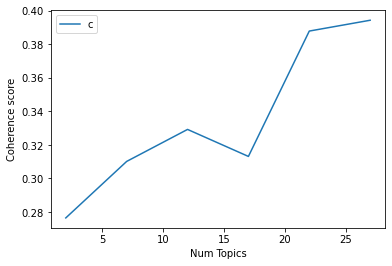

In [161]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_2020_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [162]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_2020_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.2765
index: 1 | Num Topics = 7  has Coherence Value of 0.3102
index: 2 | Num Topics = 12  has Coherence Value of 0.3292
index: 3 | Num Topics = 17  has Coherence Value of 0.3131
index: 4 | Num Topics = 22  has Coherence Value of 0.3878
index: 5 | Num Topics = 27  has Coherence Value of 0.3942


In [206]:
# Select optimal number of topics
optimal_model_us_2020_score1N2N3 = model_list_us_2020_score1N2N3[5]

In [207]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_2020_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_us_2020_score1N2N3, corpus_us_2020_score1N2N3, id2word_us_2020_score1N2N3)

In [208]:
print("pyLDAVis for us topics for score=1,2,3 in 2020:")
vis_us_2020_score1N2N3

pyLDAVis for us topics for score=1,2,3 in 2020:


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
22     0.056173  0.164611       1        1  8.904715
2      0.018908  0.015649       2        1  8.360360
8      0.163139 -0.023114       3        1  8.283994
5      0.191740 -0.004249       4        1  7.471305
9      0.014380  0.020492       5        1  5.668413
10     0.106918 -0.044637       6        1  5.289704
26     0.066103  0.023800       7        1  4.974555
12     0.023485  0.088122       8        1  4.712672
16    -0.029070 -0.137046       9        1  4.429972
14    -0.121044 -0.005590      10        1  3.862039
18     0.040640 -0.008623      11        1  3.803120
1      0.085478 -0.111233      12        1  3.713921
19    -0.044723  0.039488      13        1  3.630046
21    -0.056990 -0.069075      14        1  3.576496
7      0.059688  0.020973      15        1  3.089293
3      0.021075 -0.052529      16        1  2.866102
24    -0.085128 -0.059447      17        1  2.763481
20     0.002137 -0.124540      18        1  2.446009
4     -0.135312 -0.043512      19        1  1.889054
25     0.006930  0.056773      20        1  1.841530
0     -0.019905 -0.028220      21        1  1.674640
13    -0.063231  0.069229      22        1  1.412187
23     0.001091  0.060703      23        1  1.311774
11    -0.052843  0.074888      24        1  1.284764
17    -0.122220 -0.003147      25        1  1.014513
15    -0.099494  0.038460      26        1  0.962404
6     -0.027924  0.041776      27        1  0.762936, topic_info=       Term        Freq       Total Category  logprob  loglift
18    video  119.000000  119.000000  Default  30.0000  30.0000
4      edit   36.000000   36.000000  Default  29.0000  29.0000
182  update   28.000000   28.000000  Default  28.0000  28.0000
17     time   48.000000   48.000000  Default  27.0000  27.0000
114     add   19.000000   19.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
15    start    0.018421   19.675382  Topic27  -6.9422  -2.0979
16    thing    0.018421   21.231107  Topic27  -6.9422  -2.1740
19      ask    0.018421    3.821532  Topic27  -6.9422  -0.4592
20    broad    0.018421    1.550642  Topic27  -6.9422   0.4428
21     clip    0.018421    7.235379  Topic27  -6.9422  -1.0975

[1284 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
58        1  0.613929  ability
445       1  0.302441     able
445       3  0.151221     able
445       5  0.151221     able
445       8  0.151221     able
...     ...       ...      ...
417      14  0.475975      yet
417      26  0.475975      yet
444       2  0.302051    young
444       5  0.604102    young
507      10  0.644894     zoom

[1527 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[23, 3, 9, 6, 10, 11, 27, 13, 17, 15, 19, 2, 20, 22, 8, 4, 25, 21, 5, 26, 1, 14, 24, 12, 18, 16, 7])

## By-rating of 2021 (Rating=1,2,3)

In [166]:
# By-rating Topic Modelling - rating = 1,2,3 in 2021
# Convert to list - move to each section
review_us_2021_score1N2N3 = lomotif_ios_us_review_YearMonth_2021_score1N2N3.review.values.tolist()
review_words_us_2021_score1N2N3 = list(sent_to_words(review_us_2021_score1N2N3))
print(review_words_us_2021_score1N2N3[:1])

[['the', 'app', 'stops', 'working', 'in', 'the', 'middle', 'of', 'editing', 'and', 'takes', 'forever', 'it', 'load', 'it', 'also', 'fails', 'to', 'show', 'which', 'pictures', 'are', 'editing', 'has', 'delay']]


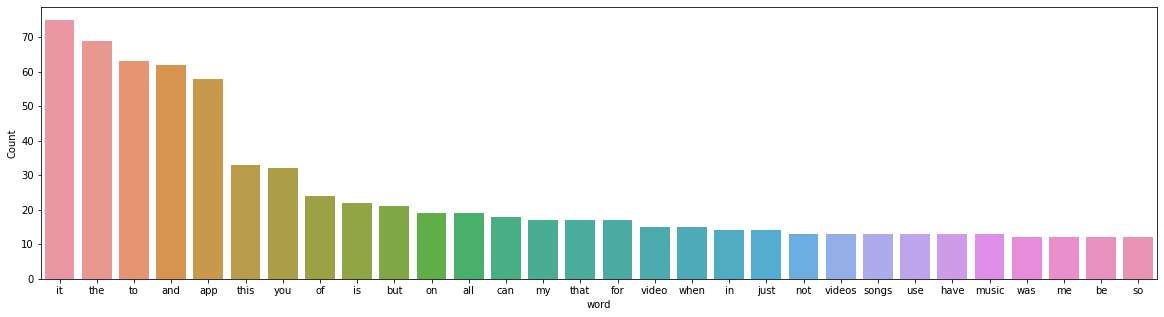

In [167]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_2021_score1N2N3))

In [168]:
# Clean text
review_words_us_ready_2021_score1N2N3 = process_words(review_words_us_2021_score1N2N3)  # processed Text Data! - move to each section

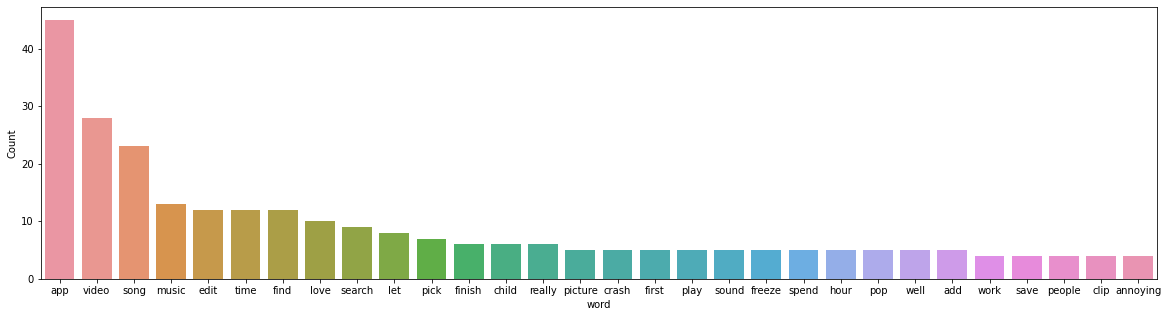

In [169]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_us_ready_2021_score1N2N3))


In [170]:
# Create Dictionary
id2word_us_2021_score1N2N3 = corpora.Dictionary(review_words_us_ready_2021_score1N2N3)

2021-10-17 03:16:16,170 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 03:16:16,174 [INFO] gensim.corpora.dictionary - built Dictionary(263 unique tokens: ['delay', 'edit', 'editing', 'fail', 'forever']...) from 43 documents (total 601 corpus positions)
2021-10-17 03:16:16,175 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(263 unique tokens: ['delay', 'edit', 'editing', 'fail', 'forever']...) from 43 documents (total 601 corpus positions)", 'datetime': '2021-10-17T03:16:16.175302', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [171]:
# Create Corpus: Term Document Frequency
corpus_us_2021_score1N2N3 = [id2word_us_2021_score1N2N3.doc2bow(text) for text in review_words_us_ready_2021_score1N2N3]

In [172]:
# Training LDA model
model_list_us_2021_score1N2N3, coherence_values_us_2021_score1N2N3 = compute_coherence_values(dictionary=id2word_us_2021_score1N2N3, corpus=corpus_us_2021_score1N2N3, 
                                                              texts=review_words_us_ready_2021_score1N2N3, limit=30, start=2, step=5)


2021-10-17 03:16:16,190 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 03:16:16,191 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 03:16:16,193 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 03:16:16,194 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 43 documents, updating model once every 43 documents, evaluating perplexity every 43 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 03:16:16,294 [INFO] gensim.models.ldamodel - -6.298 per-word bound, 78.7 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:16,296 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #43/43
2021-10-17 03:16:16,384 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.052*"app" + 0.034*"song" + 0.030*"video" + 0.025*"find" + 0.019*"time" + 0.018*"music" + 0.017*"edit" + 0.017*

2021-10-17 03:16:17,532 [INFO] gensim.models.ldamodel - topic diff=0.009215, rho=0.301511
2021-10-17 03:16:17,586 [INFO] gensim.models.ldamodel - -5.491 per-word bound, 45.0 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:17,590 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #43/43
2021-10-17 03:16:17,676 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.050*"song" + 0.047*"app" + 0.031*"video" + 0.029*"find" + 0.025*"music" + 0.022*"search" + 0.021*"time" + 0.018*"pick" + 0.016*"edit" + 0.013*"add"
2021-10-17 03:16:17,678 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.059*"app" + 0.035*"video" + 0.018*"love" + 0.015*"let" + 0.014*"child" + 0.014*"edit" + 0.012*"play" + 0.012*"sound" + 0.010*"spend" + 0.010*"hour"
2021-10-17 03:16:17,678 [INFO] gensim.models.ldamodel - topic diff=0.007621, rho=0.288675
2021-10-17 03:16:17,711 [INFO] gensim.models.ldamodel - -5.490 per-word bound, 44.9 perplexity estimate based on a h

2021-10-17 03:16:18,675 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.051*"song" + 0.046*"app" + 0.033*"video" + 0.030*"find" + 0.025*"music" + 0.023*"search" + 0.021*"time" + 0.018*"pick" + 0.016*"edit" + 0.013*"add"
2021-10-17 03:16:18,676 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.060*"app" + 0.034*"video" + 0.018*"love" + 0.016*"let" + 0.014*"child" + 0.014*"edit" + 0.012*"play" + 0.012*"sound" + 0.010*"spend" + 0.010*"hour"
2021-10-17 03:16:18,677 [INFO] gensim.models.ldamodel - topic diff=0.002591, rho=0.213201
2021-10-17 03:16:18,714 [INFO] gensim.models.ldamodel - -5.484 per-word bound, 44.8 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:18,716 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #43/43
2021-10-17 03:16:18,741 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.051*"song" + 0.046*"app" + 0.033*"video" + 0.030*"find" + 0.025*"music" + 0.023*"search" + 0.021*"time" + 0.018*"pick" + 0.016*"ed

2021-10-17 03:16:19,583 [INFO] gensim.models.ldamodel - topic diff=0.001763, rho=0.176777
2021-10-17 03:16:19,668 [INFO] gensim.models.ldamodel - -5.483 per-word bound, 44.7 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:19,669 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #43/43
2021-10-17 03:16:19,697 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.051*"song" + 0.046*"app" + 0.033*"video" + 0.030*"find" + 0.025*"music" + 0.023*"search" + 0.021*"time" + 0.018*"pick" + 0.016*"edit" + 0.013*"add"
2021-10-17 03:16:19,699 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.060*"app" + 0.034*"video" + 0.018*"love" + 0.016*"let" + 0.014*"child" + 0.014*"edit" + 0.012*"play" + 0.012*"sound" + 0.010*"spend" + 0.010*"hour"
2021-10-17 03:16:19,700 [INFO] gensim.models.ldamodel - topic diff=0.001752, rho=0.174078
2021-10-17 03:16:19,749 [INFO] gensim.models.ldamodel - -5.483 per-word bound, 44.7 perplexity estimate based on a h

2021-10-17 03:16:20,718 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.051*"song" + 0.046*"app" + 0.033*"video" + 0.030*"find" + 0.024*"music" + 0.023*"search" + 0.021*"time" + 0.018*"pick" + 0.016*"edit" + 0.013*"add"
2021-10-17 03:16:20,721 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.060*"app" + 0.034*"video" + 0.018*"love" + 0.015*"let" + 0.015*"child" + 0.015*"edit" + 0.012*"play" + 0.012*"sound" + 0.010*"spend" + 0.010*"hour"
2021-10-17 03:16:20,726 [INFO] gensim.models.ldamodel - topic diff=0.001594, rho=0.152499
2021-10-17 03:16:20,794 [INFO] gensim.models.ldamodel - -5.481 per-word bound, 44.7 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:20,795 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #43/43
2021-10-17 03:16:20,820 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.051*"song" + 0.046*"app" + 0.033*"video" + 0.030*"find" + 0.024*"music" + 0.023*"search" + 0.021*"time" + 0.018*"pick" + 0.016*"ed

2021-10-17 03:16:25,445 [INFO] gensim.models.ldamodel - -9.017 per-word bound, 517.9 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:25,446 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #43/43
2021-10-17 03:16:25,551 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.056*"child" + 0.040*"video" + 0.035*"app" + 0.029*"creep" + 0.023*"time" + 0.020*"edit" + 0.020*"music" + 0.020*"thing" + 0.020*"aware" + 0.020*"predator"
2021-10-17 03:16:25,552 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.071*"song" + 0.044*"video" + 0.035*"love" + 0.031*"find" + 0.031*"search" + 0.024*"music" + 0.024*"app" + 0.021*"hard" + 0.021*"finish" + 0.021*"annoying"
2021-10-17 03:16:25,553 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.035*"let" + 0.033*"app" + 0.032*"song" + 0.030*"people" + 0.026*"video" + 0.021*"opt" + 0.021*"clearly" + 0.016*"keep" + 0.016*"finish" + 0.015*"vid"
2021-10-17 03:16:25,554 [INFO] gensim.models.ldamodel - 

2021-10-17 03:16:25,943 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.053*"app" + 0.047*"song" + 0.047*"video" + 0.042*"find" + 0.030*"time" + 0.024*"play" + 0.024*"first" + 0.024*"sound" + 0.018*"love" + 0.018*"pop"
2021-10-17 03:16:25,945 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.054*"child" + 0.045*"video" + 0.036*"app" + 0.027*"creep" + 0.027*"time" + 0.027*"pick" + 0.019*"edit" + 0.019*"thing" + 0.019*"music" + 0.019*"aware"
2021-10-17 03:16:25,947 [INFO] gensim.models.ldamodel - topic diff=0.019176, rho=0.377964
2021-10-17 03:16:26,020 [INFO] gensim.models.ldamodel - -5.722 per-word bound, 52.8 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:26,026 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #43/43
2021-10-17 03:16:26,054 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.073*"song" + 0.042*"video" + 0.032*"love" + 0.032*"search" + 0.032*"find" + 0.022*"music" + 0.022*"app" + 0.022*"finish" + 0.022*

2021-10-17 03:16:26,390 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.054*"child" + 0.045*"video" + 0.036*"app" + 0.027*"creep" + 0.027*"time" + 0.027*"pick" + 0.019*"thing" + 0.019*"aware" + 0.019*"predator" + 0.019*"edit"
2021-10-17 03:16:26,391 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.039*"edit" + 0.039*"app" + 0.021*"pick" + 0.021*"part" + 0.021*"let" + 0.021*"really" + 0.021*"annoying" + 0.021*"post" + 0.021*"video" + 0.021*"improvement"
2021-10-17 03:16:26,393 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.040*"app" + 0.040*"people" + 0.031*"let" + 0.031*"song" + 0.021*"video" + 0.021*"opt" + 0.021*"clearly" + 0.021*"vid" + 0.021*"disgusting" + 0.011*"keep"
2021-10-17 03:16:26,396 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.073*"song" + 0.042*"video" + 0.032*"love" + 0.032*"search" + 0.032*"find" + 0.022*"music" + 0.022*"finish" + 0.022*"annoying" + 0.022*"hard" + 0.022*"particular"
2021-10-17 03:16:26,397 [INFO] gensim.models.ldamodel - topic #3 (0.

2021-10-17 03:16:26,811 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.039*"edit" + 0.039*"app" + 0.021*"pick" + 0.021*"part" + 0.021*"let" + 0.021*"really" + 0.021*"annoying" + 0.021*"post" + 0.021*"video" + 0.021*"major"
2021-10-17 03:16:26,815 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.054*"child" + 0.045*"video" + 0.036*"app" + 0.027*"time" + 0.027*"creep" + 0.027*"pick" + 0.019*"thing" + 0.019*"aware" + 0.019*"predator" + 0.019*"edit"
2021-10-17 03:16:26,818 [INFO] gensim.models.ldamodel - topic diff=0.000324, rho=0.235702
2021-10-17 03:16:26,861 [INFO] gensim.models.ldamodel - -5.721 per-word bound, 52.7 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:26,862 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #43/43
2021-10-17 03:16:26,901 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.077*"app" + 0.028*"music" + 0.028*"video" + 0.022*"love" + 0.015*"freeze" + 0.015*"option" + 0.015*"choice" + 0.015*"edi

2021-10-17 03:16:27,308 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #43/43
2021-10-17 03:16:27,330 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.040*"app" + 0.040*"people" + 0.031*"let" + 0.031*"song" + 0.021*"clearly" + 0.021*"opt" + 0.021*"vid" + 0.021*"disgusting" + 0.021*"video" + 0.011*"keep"
2021-10-17 03:16:27,331 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.074*"app" + 0.029*"music" + 0.023*"add" + 0.023*"well" + 0.023*"video" + 0.023*"edit" + 0.018*"close" + 0.018*"crash" + 0.018*"almost" + 0.018*"clip"
2021-10-17 03:16:27,333 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.053*"app" + 0.047*"video" + 0.047*"song" + 0.042*"find" + 0.030*"time" + 0.024*"play" + 0.024*"first" + 0.024*"sound" + 0.018*"love" + 0.018*"pop"
2021-10-17 03:16:27,335 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.039*"edit" + 0.039*"app" + 0.021*"pick" + 0.021*"part" + 0.021*"let" + 0.021*"really" + 0.021*"annoying" + 0.021*"post" + 0.021*"video" + 0.021*"major"

2021-10-17 03:16:27,756 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.077*"app" + 0.028*"music" + 0.028*"video" + 0.022*"love" + 0.015*"type" + 0.015*"freeze" + 0.015*"time" + 0.015*"work" + 0.015*"choice" + 0.015*"save"
2021-10-17 03:16:27,757 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.054*"child" + 0.045*"video" + 0.036*"app" + 0.027*"pick" + 0.027*"time" + 0.027*"creep" + 0.019*"picture" + 0.019*"thing" + 0.019*"aware" + 0.019*"predator"
2021-10-17 03:16:27,757 [INFO] gensim.models.ldamodel - topic diff=0.000019, rho=0.185695
2021-10-17 03:16:27,788 [INFO] gensim.models.ldamodel - -5.721 per-word bound, 52.7 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:27,789 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #43/43
2021-10-17 03:16:27,810 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.073*"song" + 0.042*"video" + 0.032*"search" + 0.032*"find" + 0.032*"love" + 0.022*"finish" + 0.022*"annoying" + 0.022*

2021-10-17 03:16:28,157 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #43/43
2021-10-17 03:16:28,177 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.039*"edit" + 0.039*"app" + 0.021*"pick" + 0.021*"part" + 0.021*"let" + 0.021*"really" + 0.021*"annoying" + 0.021*"post" + 0.021*"video" + 0.021*"dance"
2021-10-17 03:16:28,179 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.053*"app" + 0.047*"video" + 0.047*"song" + 0.042*"find" + 0.030*"time" + 0.024*"play" + 0.024*"first" + 0.024*"sound" + 0.018*"love" + 0.018*"pop"
2021-10-17 03:16:28,180 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.074*"app" + 0.029*"music" + 0.023*"add" + 0.023*"well" + 0.023*"video" + 0.023*"edit" + 0.018*"clip" + 0.018*"finish" + 0.018*"close" + 0.018*"almost"
2021-10-17 03:16:28,182 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.054*"child" + 0.045*"video" + 0.036*"app" + 0.027*"pick" + 0.027*"time" + 0.027*"creep" + 0.019*"picture" + 0.019*"thing" + 0.019*"predator" + 0.019*"aw

2021-10-17 03:16:28,599 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.053*"app" + 0.047*"video" + 0.047*"song" + 0.042*"find" + 0.030*"time" + 0.024*"play" + 0.024*"first" + 0.024*"sound" + 0.018*"love" + 0.018*"pop"
2021-10-17 03:16:28,607 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.039*"edit" + 0.039*"app" + 0.021*"pick" + 0.021*"part" + 0.021*"let" + 0.021*"really" + 0.021*"annoying" + 0.021*"post" + 0.021*"video" + 0.021*"improvement"
2021-10-17 03:16:28,610 [INFO] gensim.models.ldamodel - topic diff=0.000002, rho=0.158114
2021-10-17 03:16:28,685 [INFO] gensim.models.ldamodel - -5.721 per-word bound, 52.7 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:28,686 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #43/43
2021-10-17 03:16:28,706 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.039*"edit" + 0.039*"app" + 0.021*"pick" + 0.021*"part" + 0.021*"let" + 0.021*"really" + 0.021*"annoying" + 0.021*"post" +

2021-10-17 03:16:29,081 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.040*"app" + 0.040*"people" + 0.031*"let" + 0.031*"song" + 0.021*"opt" + 0.021*"clearly" + 0.021*"vid" + 0.021*"disgusting" + 0.021*"video" + 0.011*"way"
2021-10-17 03:16:29,082 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.053*"app" + 0.047*"video" + 0.047*"song" + 0.042*"find" + 0.030*"time" + 0.024*"play" + 0.024*"first" + 0.024*"sound" + 0.018*"love" + 0.018*"pop"
2021-10-17 03:16:29,084 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.054*"child" + 0.045*"video" + 0.036*"app" + 0.027*"pick" + 0.027*"time" + 0.027*"creep" + 0.019*"picture" + 0.019*"thing" + 0.019*"aware" + 0.019*"predator"
2021-10-17 03:16:29,085 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.073*"song" + 0.042*"video" + 0.032*"search" + 0.032*"find" + 0.032*"love" + 0.022*"finish" + 0.022*"annoying" + 0.022*"music" + 0.022*"hard" + 0.022*"particular"
2021-10-17 03:16:29,086 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.0

2021-10-17 03:16:29,506 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.074*"app" + 0.029*"music" + 0.023*"add" + 0.023*"well" + 0.023*"video" + 0.023*"edit" + 0.018*"clip" + 0.018*"finish" + 0.018*"almost" + 0.018*"close"
2021-10-17 03:16:29,507 [INFO] gensim.models.ldamodel - topic diff=0.000000, rho=0.140028
2021-10-17 03:16:29,508 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=263, num_topics=7, decay=0.5, chunksize=1000) in 4.18s', 'datetime': '2021-10-17T03:16:29.507967', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-17 03:16:29,511 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-17 03:16:33,185 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 03:16

2021-10-17 03:16:34,783 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.036*"let" + 0.036*"forever" + 0.036*"crazy" + 0.036*"find" + 0.036*"else" + 0.036*"love" + 0.036*"open" + 0.036*"app" + 0.003*"song" + 0.003*"video"
2021-10-17 03:16:34,785 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.086*"app" + 0.036*"music" + 0.036*"video" + 0.029*"well" + 0.029*"edit" + 0.029*"add" + 0.022*"clip" + 0.022*"finish" + 0.022*"close" + 0.015*"almost"
2021-10-17 03:16:34,785 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.058*"app" + 0.039*"edit" + 0.039*"let" + 0.039*"crash" + 0.039*"pick" + 0.039*"song" + 0.020*"part" + 0.020*"really" + 0.020*"improvement" + 0.020*"major"
2021-10-17 03:16:34,786 [INFO] gensim.models.ldamodel - topic diff=0.022028, rho=0.408248
2021-10-17 03:16:34,851 [INFO] gensim.models.ldamodel - -5.851 per-word bound, 57.7 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:34,853 [INFO] gensim.models.ldamodel - PROGRESS:

2021-10-17 03:16:35,260 [INFO] gensim.models.ldamodel - -5.848 per-word bound, 57.6 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:35,261 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #43/43
2021-10-17 03:16:35,285 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.043*"pick" + 0.043*"video" + 0.029*"app" + 0.029*"time" + 0.029*"type" + 0.029*"opt" + 0.029*"clearly" + 0.029*"picture" + 0.015*"work" + 0.015*"lose"
2021-10-17 03:16:35,286 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.073*"child" + 0.037*"video" + 0.037*"app" + 0.037*"creep" + 0.025*"freeze" + 0.025*"music" + 0.025*"aware" + 0.025*"predator" + 0.013*"middle" + 0.013*"automatically"
2021-10-17 03:16:35,288 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.083*"app" + 0.029*"option" + 0.029*"song" + 0.029*"edit" + 0.029*"look" + 0.029*"hour" + 0.029*"site" + 0.029*"never" + 0.029*"spend" + 0.015*"genre"
2021-10-17 03:16:35,341 [INFO] gensim.models.lda

2021-10-17 03:16:35,854 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.075*"song" + 0.039*"find" + 0.039*"type" + 0.039*"telling" + 0.039*"nit" + 0.003*"app" + 0.003*"search" + 0.003*"love" + 0.003*"video" + 0.003*"time"
2021-10-17 03:16:35,856 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.077*"app" + 0.055*"music" + 0.044*"people" + 0.044*"love" + 0.023*"vid" + 0.023*"disgusting" + 0.023*"video" + 0.023*"time" + 0.023*"choice" + 0.023*"truly"
2021-10-17 03:16:35,857 [INFO] gensim.models.ldamodel - topic diff=0.000391, rho=0.242536
2021-10-17 03:16:35,918 [INFO] gensim.models.ldamodel - -5.848 per-word bound, 57.6 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:35,919 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #43/43
2021-10-17 03:16:35,938 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.077*"app" + 0.055*"music" + 0.044*"people" + 0.044*"love" + 0.023*"vid" + 0.023*"disgusting" + 0.023*"video" + 0.023*"

2021-10-17 03:16:36,256 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.004*"result" + 0.004*"impossible" + 0.004*"charge" + 0.004*"apple" + 0.004*"add" + 0.004*"year" + 0.004*"terrible" + 0.004*"fast" + 0.004*"major" + 0.004*"improvement"
2021-10-17 03:16:36,257 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.055*"video" + 0.055*"song" + 0.034*"time" + 0.034*"picture" + 0.023*"search" + 0.023*"edit" + 0.023*"hard" + 0.023*"show" + 0.023*"finish" + 0.023*"photo"
2021-10-17 03:16:36,260 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.075*"song" + 0.039*"find" + 0.039*"type" + 0.039*"nit" + 0.039*"telling" + 0.003*"apple" + 0.003*"cut" + 0.003*"year" + 0.003*"charge" + 0.003*"terrible"
2021-10-17 03:16:36,261 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.083*"app" + 0.029*"option" + 0.029*"song" + 0.029*"edit" + 0.029*"look" + 0.029*"hour" + 0.029*"site" + 0.029*"never" + 0.029*"spend" + 0.015*"genre"
2021-10-17 03:16:36,262 [INFO] gensim.models.ldamodel - topic #9 (0

2021-10-17 03:16:36,689 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.086*"app" + 0.036*"video" + 0.036*"music" + 0.029*"well" + 0.029*"add" + 0.029*"edit" + 0.022*"clip" + 0.022*"finish" + 0.022*"close" + 0.015*"pop"
2021-10-17 03:16:36,691 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.073*"child" + 0.037*"video" + 0.037*"app" + 0.037*"creep" + 0.025*"freeze" + 0.025*"music" + 0.025*"aware" + 0.025*"predator" + 0.013*"middle" + 0.013*"automatically"
2021-10-17 03:16:36,693 [INFO] gensim.models.ldamodel - topic diff=0.000022, rho=0.188982
2021-10-17 03:16:36,791 [INFO] gensim.models.ldamodel - -5.848 per-word bound, 57.6 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:36,793 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #43/43
2021-10-17 03:16:36,811 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.043*"video" + 0.043*"pick" + 0.029*"app" + 0.029*"time" + 0.029*"type" + 0.029*"clearly" + 0.029*"opt" + 0.029*

2021-10-17 03:16:37,293 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #43/43
2021-10-17 03:16:37,312 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.058*"app" + 0.039*"let" + 0.039*"edit" + 0.039*"crash" + 0.039*"pick" + 0.039*"song" + 0.020*"part" + 0.020*"really" + 0.020*"annoying" + 0.020*"post"
2021-10-17 03:16:37,313 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.043*"video" + 0.043*"pick" + 0.029*"app" + 0.029*"time" + 0.029*"type" + 0.029*"clearly" + 0.029*"opt" + 0.029*"picture" + 0.015*"work" + 0.015*"lose"
2021-10-17 03:16:37,314 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.077*"app" + 0.055*"music" + 0.044*"people" + 0.044*"love" + 0.023*"disgusting" + 0.023*"vid" + 0.023*"time" + 0.023*"choice" + 0.023*"video" + 0.023*"truly"
2021-10-17 03:16:37,315 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.004*"result" + 0.004*"impossible" + 0.004*"charge" + 0.004*"apple" + 0.004*"add" + 0.004*"year" + 0.004*"terrible" + 0.004*"fast" + 0.004*"maj

2021-10-17 03:16:37,762 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.068*"app" + 0.068*"song" + 0.048*"video" + 0.048*"find" + 0.028*"first" + 0.028*"sound" + 0.028*"play" + 0.021*"search" + 0.021*"love" + 0.021*"time"
2021-10-17 03:16:37,764 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.058*"app" + 0.039*"let" + 0.039*"edit" + 0.039*"crash" + 0.039*"pick" + 0.039*"song" + 0.020*"part" + 0.020*"annoying" + 0.020*"really" + 0.020*"post"
2021-10-17 03:16:37,765 [INFO] gensim.models.ldamodel - topic diff=0.000002, rho=0.160128
2021-10-17 03:16:37,805 [INFO] gensim.models.ldamodel - -5.848 per-word bound, 57.6 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:37,807 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #43/43
2021-10-17 03:16:37,835 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.075*"song" + 0.039*"find" + 0.039*"type" + 0.039*"nit" + 0.039*"telling" + 0.003*"apple" + 0.003*"cut" + 0.003*"year" + 0.00

2021-10-17 03:16:38,222 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #43/43
2021-10-17 03:16:38,252 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.004*"result" + 0.004*"impossible" + 0.004*"charge" + 0.004*"apple" + 0.004*"add" + 0.004*"year" + 0.004*"terrible" + 0.004*"fast" + 0.004*"major" + 0.004*"improvement"
2021-10-17 03:16:38,254 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.036*"let" + 0.036*"find" + 0.036*"forever" + 0.036*"love" + 0.036*"crazy" + 0.036*"open" + 0.036*"else" + 0.036*"app" + 0.003*"word" + 0.003*"randomly"
2021-10-17 03:16:38,256 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.058*"app" + 0.039*"let" + 0.039*"edit" + 0.039*"crash" + 0.039*"pick" + 0.039*"song" + 0.020*"part" + 0.020*"really" + 0.020*"annoying" + 0.020*"post"
2021-10-17 03:16:38,258 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.073*"child" + 0.037*"creep" + 0.037*"video" + 0.037*"app" + 0.025*"freeze" + 0.025*"aware" + 0.025*"predator" + 0.025*"music" + 0.

2021-10-17 03:16:38,688 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.043*"video" + 0.043*"pick" + 0.029*"time" + 0.029*"app" + 0.029*"type" + 0.029*"picture" + 0.029*"opt" + 0.029*"clearly" + 0.015*"work" + 0.015*"search"
2021-10-17 03:16:38,689 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.036*"let" + 0.036*"find" + 0.036*"forever" + 0.036*"love" + 0.036*"crazy" + 0.036*"open" + 0.036*"else" + 0.036*"app" + 0.003*"word" + 0.003*"randomly"
2021-10-17 03:16:38,690 [INFO] gensim.models.ldamodel - topic diff=0.000000, rho=0.141421
2021-10-17 03:16:38,728 [INFO] gensim.models.ldamodel - -5.848 per-word bound, 57.6 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:38,730 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #43/43
2021-10-17 03:16:38,755 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.035*"let" + 0.035*"keep" + 0.035*"video" + 0.035*"editing" + 0.035*"finish" + 0.035*"lag" + 0.035*"tryna" + 0.035*"slow" 

2021-10-17 03:16:45,180 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.082*"app" + 0.044*"never" + 0.044*"spend" + 0.043*"site" + 0.043*"hour" + 0.023*"upload" + 0.023*"look" + 0.023*"simply" + 0.023*"new" + 0.022*"always"
2021-10-17 03:16:45,181 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.052*"selection" + 0.052*"tank" + 0.052*"anymore" + 0.052*"worth" + 0.052*"song" + 0.003*"app" + 0.003*"video" + 0.003*"find" + 0.003*"let" + 0.003*"search"
2021-10-17 03:16:45,182 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.004*"app" + 0.004*"song" + 0.004*"video" + 0.004*"edit" + 0.004*"music" + 0.004*"find" + 0.004*"love" + 0.004*"search" + 0.004*"time" + 0.004*"fast"
2021-10-17 03:16:45,183 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.109*"child" + 0.055*"creep" + 0.037*"aware" + 0.037*"predator" + 0.037*"app" + 0.037*"music" + 0.019*"number" + 0.019*"safe" + 0.019*"bra" + 0.019*"sentence"
2021-10-17 03:16:45,185 [INFO] gensim.models.ldamodel - topic diff=0.055874, rho

2021-10-17 03:16:45,526 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.085*"song" + 0.061*"video" + 0.061*"pick" + 0.049*"app" + 0.037*"time" + 0.037*"really" + 0.037*"search" + 0.025*"picture" + 0.025*"hope" + 0.025*"music"
2021-10-17 03:16:45,527 [INFO] gensim.models.ldamodel - topic diff=0.013126, rho=0.316228
2021-10-17 03:16:45,552 [INFO] gensim.models.ldamodel - -5.926 per-word bound, 60.8 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:45,553 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #43/43
2021-10-17 03:16:45,574 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.004*"result" + 0.004*"impossible" + 0.004*"charge" + 0.004*"apple" + 0.004*"add" + 0.004*"year" + 0.004*"terrible" + 0.004*"fast" + 0.004*"major" + 0.004*"improvement"
2021-10-17 03:16:45,576 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.047*"give" + 0.047*"lose" + 0.047*"point" + 0.047*"progress" + 0.047*"everytime" + 0.047*"freeze" + 0.0

2021-10-17 03:16:45,957 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.052*"selection" + 0.052*"anymore" + 0.052*"tank" + 0.052*"song" + 0.052*"worth" + 0.003*"charge" + 0.003*"apple" + 0.003*"add" + 0.003*"year" + 0.003*"terrible"
2021-10-17 03:16:45,958 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.004*"result" + 0.004*"impossible" + 0.004*"charge" + 0.004*"apple" + 0.004*"add" + 0.004*"year" + 0.004*"terrible" + 0.004*"fast" + 0.004*"major" + 0.004*"improvement"
2021-10-17 03:16:45,959 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.087*"app" + 0.069*"people" + 0.035*"disgusting" + 0.035*"vid" + 0.018*"suppose" + 0.018*"straight" + 0.018*"manly" + 0.018*"tween" + 0.018*"love" + 0.018*"really"
2021-10-17 03:16:45,960 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.072*"app" + 0.048*"pop" + 0.048*"finish" + 0.048*"clip" + 0.048*"music" + 0.025*"edit" + 0.025*"video" + 0.025*"word" + 0.025*"search" + 0.025*"fast"
2021-10-17 03:16:45,961 [INFO] gensim.models.ldamodel 

2021-10-17 03:16:46,388 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.068*"video" + 0.051*"app" + 0.035*"let" + 0.035*"song" + 0.035*"almost" + 0.035*"close" + 0.035*"hour" + 0.035*"spend" + 0.018*"note" + 0.018*"find"
2021-10-17 03:16:46,390 [INFO] gensim.models.ldamodel - topic diff=0.000437, rho=0.218218
2021-10-17 03:16:46,426 [INFO] gensim.models.ldamodel - -5.925 per-word bound, 60.7 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:46,427 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #43/43
2021-10-17 03:16:46,447 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.109*"child" + 0.055*"creep" + 0.037*"aware" + 0.037*"predator" + 0.037*"app" + 0.037*"music" + 0.019*"kid" + 0.019*"imagine" + 0.019*"awareeee" + 0.019*"number"
2021-10-17 03:16:46,449 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.057*"app" + 0.039*"song" + 0.039*"type" + 0.039*"tok" + 0.039*"tik" + 0.039*"well" + 0.039*"little" + 0.020*"force"

2021-10-17 03:16:46,861 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.086*"song" + 0.061*"video" + 0.061*"pick" + 0.049*"app" + 0.037*"time" + 0.037*"really" + 0.037*"search" + 0.025*"picture" + 0.025*"hope" + 0.025*"music"
2021-10-17 03:16:46,863 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.087*"app" + 0.069*"people" + 0.035*"disgusting" + 0.035*"vid" + 0.018*"suppose" + 0.018*"straight" + 0.018*"manly" + 0.018*"tween" + 0.018*"love" + 0.018*"really"
2021-10-17 03:16:46,865 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.047*"progress" + 0.047*"everytime" + 0.047*"freeze" + 0.047*"give" + 0.047*"lose" + 0.047*"point" + 0.047*"video" + 0.003*"cut" + 0.003*"charge" + 0.003*"terrible"
2021-10-17 03:16:46,869 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.070*"app" + 0.047*"well" + 0.047*"music" + 0.047*"delete" + 0.047*"add" + 0.047*"crash" + 0.024*"apple" + 0.024*"choice" + 0.024*"nonsense" + 0.024*"useless"
2021-10-17 03:16:46,873 [INFO] gensim.models.ldamodel -

2021-10-17 03:16:47,269 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.087*"app" + 0.069*"people" + 0.035*"disgusting" + 0.035*"vid" + 0.018*"suppose" + 0.018*"straight" + 0.018*"manly" + 0.018*"tween" + 0.018*"love" + 0.018*"really"
2021-10-17 03:16:47,270 [INFO] gensim.models.ldamodel - topic diff=0.000032, rho=0.176777
2021-10-17 03:16:47,322 [INFO] gensim.models.ldamodel - -5.925 per-word bound, 60.7 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:47,324 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #43/43
2021-10-17 03:16:47,414 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.109*"child" + 0.055*"creep" + 0.037*"aware" + 0.037*"predator" + 0.037*"app" + 0.037*"music" + 0.019*"kid" + 0.019*"imagine" + 0.019*"awareeee" + 0.019*"number"
2021-10-17 03:16:47,415 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.063*"video" + 0.054*"app" + 0.045*"song" + 0.036*"first" + 0.036*"play" + 0.036*"sound" + 0.027*"love"

2021-10-17 03:16:47,817 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.063*"video" + 0.054*"app" + 0.045*"song" + 0.036*"play" + 0.036*"first" + 0.036*"sound" + 0.027*"love" + 0.027*"find" + 0.027*"time" + 0.018*"hear"
2021-10-17 03:16:47,822 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.087*"app" + 0.044*"never" + 0.044*"spend" + 0.044*"site" + 0.044*"hour" + 0.023*"upload" + 0.023*"look" + 0.023*"simply" + 0.023*"new" + 0.023*"lose"
2021-10-17 03:16:47,825 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.091*"app" + 0.055*"love" + 0.055*"music" + 0.037*"edit" + 0.037*"video" + 0.037*"available" + 0.037*"truly" + 0.037*"choice" + 0.019*"post" + 0.019*"annoying"
2021-10-17 03:16:47,827 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.093*"video" + 0.047*"finish" + 0.047*"hard" + 0.024*"crash" + 0.024*"continuously" + 0.024*"automatically" + 0.024*"save" + 0.024*"freeze" + 0.024*"time" + 0.024*"love"
2021-10-17 03:16:47,828 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-17 03:16:48,260 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.057*"app" + 0.039*"song" + 0.039*"type" + 0.039*"tok" + 0.039*"tik" + 0.039*"well" + 0.039*"little" + 0.020*"force" + 0.020*"save" + 0.020*"find"
2021-10-17 03:16:48,261 [INFO] gensim.models.ldamodel - topic diff=0.000004, rho=0.152499
2021-10-17 03:16:48,292 [INFO] gensim.models.ldamodel - -5.925 per-word bound, 60.7 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:48,294 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #43/43
2021-10-17 03:16:48,366 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.073*"find" + 0.049*"app" + 0.025*"type" + 0.025*"honestly" + 0.025*"result" + 0.025*"work" + 0.025*"song" + 0.025*"edit" + 0.025*"time" + 0.013*"music"
2021-10-17 03:16:48,369 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.052*"anymore" + 0.052*"tank" + 0.052*"song" + 0.052*"worth" + 0.052*"selection" + 0.003*"charge" + 0.003*"apple" + 0.003*"add"

2021-10-17 03:16:48,780 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.052*"anymore" + 0.052*"tank" + 0.052*"song" + 0.052*"worth" + 0.052*"selection" + 0.003*"charge" + 0.003*"apple" + 0.003*"add" + 0.003*"year" + 0.003*"terrible"
2021-10-17 03:16:48,781 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.070*"app" + 0.047*"well" + 0.047*"music" + 0.047*"delete" + 0.047*"add" + 0.047*"crash" + 0.024*"apple" + 0.024*"choice" + 0.024*"nonsense" + 0.024*"useless"
2021-10-17 03:16:48,782 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.073*"find" + 0.049*"app" + 0.025*"type" + 0.025*"honestly" + 0.025*"result" + 0.025*"work" + 0.025*"song" + 0.025*"edit" + 0.025*"time" + 0.013*"music"
2021-10-17 03:16:48,783 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.047*"progress" + 0.047*"everytime" + 0.047*"freeze" + 0.047*"give" + 0.047*"lose" + 0.047*"point" + 0.047*"video" + 0.003*"cut" + 0.003*"charge" + 0.003*"terrible"
2021-10-17 03:16:48,784 [INFO] gensim.models.ldamodel - top

2021-10-17 03:16:55,608 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.049*"picture" + 0.049*"find" + 0.049*"time" + 0.025*"whole" + 0.025*"waste" + 0.025*"nowhere" + 0.025*"crazy" + 0.025*"put" + 0.025*"spend" + 0.025*"friend"
2021-10-17 03:16:55,611 [INFO] gensim.models.ldamodel - topic diff=0.089846, rho=0.577350
2021-10-17 03:16:55,678 [INFO] gensim.models.ldamodel - -6.098 per-word bound, 68.5 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:55,679 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #43/43
2021-10-17 03:16:55,697 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.079*"app" + 0.056*"video" + 0.045*"first" + 0.035*"find" + 0.034*"song" + 0.034*"play" + 0.023*"crash" + 0.023*"honestly" + 0.023*"stuff" + 0.023*"time"
2021-10-17 03:16:55,698 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.060*"app" + 0.045*"search" + 0.031*"type" + 0.030*"bar" + 0.029*"pop" + 0.029*"really" + 0.029*"sound" + 0.029*"upda

2021-10-17 03:16:56,021 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.079*"love" + 0.060*"app" + 0.059*"song" + 0.059*"music" + 0.040*"truly" + 0.040*"choice" + 0.040*"find" + 0.040*"available" + 0.021*"lomotif" + 0.021*"video"
2021-10-17 03:16:56,022 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.064*"app" + 0.048*"finish" + 0.048*"pop" + 0.048*"video" + 0.032*"clip" + 0.032*"kick" + 0.032*"edit" + 0.032*"music" + 0.032*"save" + 0.032*"freeze"
2021-10-17 03:16:56,023 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.046*"work" + 0.046*"fail" + 0.046*"forever" + 0.046*"show" + 0.046*"delay" + 0.046*"load" + 0.046*"stop" + 0.046*"edit" + 0.046*"middle" + 0.046*"picture"
2021-10-17 03:16:56,024 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.098*"app" + 0.033*"almost" + 0.033*"spend" + 0.033*"hour" + 0.033*"music" + 0.033*"close" + 0.033*"well" + 0.033*"video" + 0.033*"edit" + 0.033*"add"
2021-10-17 03:16:56,026 [INFO] gensim.models.ldamodel - topic diff=0.016704, rho=

2021-10-17 03:16:56,426 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.105*"song" + 0.071*"find" + 0.036*"app" + 0.036*"time" + 0.036*"terrible" + 0.036*"year" + 0.036*"impossible" + 0.036*"result" + 0.036*"happen" + 0.036*"pick"
2021-10-17 03:16:56,427 [INFO] gensim.models.ldamodel - topic diff=0.003116, rho=0.267261
2021-10-17 03:16:56,543 [INFO] gensim.models.ldamodel - -5.999 per-word bound, 63.9 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:56,544 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #43/43
2021-10-17 03:16:56,562 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.132*"child" + 0.066*"creep" + 0.044*"aware" + 0.044*"predator" + 0.044*"app" + 0.023*"number" + 0.023*"bra" + 0.023*"safe" + 0.023*"comment" + 0.023*"imagine"
2021-10-17 03:16:56,563 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.096*"music" + 0.049*"video" + 0.049*"edit" + 0.025*"app" + 0.025*"ridiculous" + 0.025*"leave" + 0.025*"alw

2021-10-17 03:16:56,945 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.050*"middle" + 0.050*"recommend" + 0.050*"start" + 0.050*"continuously" + 0.050*"automatically" + 0.050*"crash" + 0.050*"freeze" + 0.050*"video" + 0.050*"save" + 0.002*"charge"
2021-10-17 03:16:56,947 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.004*"result" + 0.004*"impossible" + 0.004*"charge" + 0.004*"apple" + 0.004*"add" + 0.004*"year" + 0.004*"terrible" + 0.004*"fast" + 0.004*"major" + 0.004*"improvement"
2021-10-17 03:16:56,948 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.049*"picture" + 0.049*"time" + 0.049*"find" + 0.025*"friend" + 0.025*"whole" + 0.025*"waste" + 0.025*"together" + 0.025*"thing" + 0.025*"nowhere" + 0.025*"hour"
2021-10-17 03:16:56,949 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.098*"app" + 0.033*"almost" + 0.033*"close" + 0.033*"spend" + 0.033*"hour" + 0.033*"music" + 0.033*"edit" + 0.033*"add" + 0.033*"video" + 0.033*"well"
2021-10-17 03:16:56,950 [INFO] gensim.

2021-10-17 03:16:57,401 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.049*"picture" + 0.049*"time" + 0.049*"find" + 0.025*"friend" + 0.025*"whole" + 0.025*"waste" + 0.025*"together" + 0.025*"thing" + 0.025*"nowhere" + 0.025*"hour"
2021-10-17 03:16:57,404 [INFO] gensim.models.ldamodel - topic diff=0.000140, rho=0.200000
2021-10-17 03:16:57,435 [INFO] gensim.models.ldamodel - -5.999 per-word bound, 63.9 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:57,436 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #43/43
2021-10-17 03:16:57,454 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.004*"result" + 0.004*"impossible" + 0.004*"charge" + 0.004*"apple" + 0.004*"add" + 0.004*"year" + 0.004*"terrible" + 0.004*"fast" + 0.004*"major" + 0.004*"improvement"
2021-10-17 03:16:57,455 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.132*"child" + 0.066*"creep" + 0.045*"aware" + 0.045*"predator" + 0.045*"app" + 0.023*"number" + 

2021-10-17 03:16:57,859 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.132*"child" + 0.066*"creep" + 0.045*"aware" + 0.045*"predator" + 0.045*"app" + 0.023*"number" + 0.023*"bra" + 0.023*"safe" + 0.023*"comment" + 0.023*"imagine"
2021-10-17 03:16:57,861 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.004*"result" + 0.004*"impossible" + 0.004*"charge" + 0.004*"apple" + 0.004*"add" + 0.004*"year" + 0.004*"terrible" + 0.004*"fast" + 0.004*"major" + 0.004*"improvement"
2021-10-17 03:16:57,862 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.098*"app" + 0.033*"almost" + 0.033*"close" + 0.033*"spend" + 0.033*"hour" + 0.033*"music" + 0.033*"edit" + 0.033*"add" + 0.033*"video" + 0.033*"well"
2021-10-17 03:16:57,866 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.082*"app" + 0.082*"song" + 0.041*"video" + 0.028*"well" + 0.028*"tok" + 0.028*"tik" + 0.028*"little" + 0.028*"clip" + 0.028*"add" + 0.028*"option"
2021-10-17 03:16:57,869 [INFO] gensim.models.ldamodel - topic #16 (0.04

2021-10-17 03:16:58,289 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.079*"app" + 0.057*"video" + 0.045*"first" + 0.034*"find" + 0.034*"song" + 0.034*"play" + 0.023*"honestly" + 0.023*"crash" + 0.023*"stuff" + 0.023*"time"
2021-10-17 03:16:58,293 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.004*"result" + 0.004*"impossible" + 0.004*"charge" + 0.004*"apple" + 0.004*"add" + 0.004*"year" + 0.004*"terrible" + 0.004*"fast" + 0.004*"major" + 0.004*"improvement"
2021-10-17 03:16:58,294 [INFO] gensim.models.ldamodel - topic diff=0.000013, rho=0.166667
2021-10-17 03:16:58,327 [INFO] gensim.models.ldamodel - -5.999 per-word bound, 63.9 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:58,328 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #43/43
2021-10-17 03:16:58,350 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.064*"app" + 0.048*"finish" + 0.048*"pop" + 0.048*"video" + 0.032*"music" + 0.032*"clip" + 0.032*"edit" 

2021-10-17 03:16:58,805 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #43/43
2021-10-17 03:16:58,824 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.064*"app" + 0.048*"finish" + 0.048*"pop" + 0.048*"video" + 0.032*"music" + 0.032*"clip" + 0.032*"edit" + 0.032*"kick" + 0.032*"freeze" + 0.032*"save"
2021-10-17 03:16:58,825 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.004*"result" + 0.004*"impossible" + 0.004*"charge" + 0.004*"apple" + 0.004*"add" + 0.004*"year" + 0.004*"terrible" + 0.004*"fast" + 0.004*"major" + 0.004*"improvement"
2021-10-17 03:16:58,826 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.004*"result" + 0.004*"impossible" + 0.004*"charge" + 0.004*"apple" + 0.004*"add" + 0.004*"year" + 0.004*"terrible" + 0.004*"fast" + 0.004*"major" + 0.004*"improvement"
2021-10-17 03:16:58,827 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.082*"app" + 0.082*"song" + 0.041*"video" + 0.028*"well" + 0.028*"tok" + 0.028*"tik" + 0.028*"little" + 0.028*"clip

2021-10-17 03:16:59,254 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.049*"picture" + 0.049*"find" + 0.049*"time" + 0.025*"friend" + 0.025*"whole" + 0.025*"waste" + 0.025*"together" + 0.025*"thing" + 0.025*"nowhere" + 0.025*"hour"
2021-10-17 03:16:59,259 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.094*"app" + 0.048*"site" + 0.048*"hour" + 0.048*"spend" + 0.048*"never" + 0.024*"new" + 0.024*"several" + 0.024*"always" + 0.024*"nit" + 0.024*"time"
2021-10-17 03:16:59,264 [INFO] gensim.models.ldamodel - topic diff=0.000002, rho=0.145865
2021-10-17 03:16:59,306 [INFO] gensim.models.ldamodel - -5.999 per-word bound, 63.9 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:16:59,307 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #43/43
2021-10-17 03:16:59,329 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.004*"result" + 0.004*"impossible" + 0.004*"charge" + 0.004*"apple" + 0.004*"add" + 0.004*"year" + 0.004*"terrible

2021-10-17 03:17:06,443 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #43/43
2021-10-17 03:17:06,562 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.076*"video" + 0.076*"pick" + 0.051*"picture" + 0.051*"app" + 0.051*"time" + 0.051*"crash" + 0.026*"waste" + 0.026*"close" + 0.026*"back" + 0.026*"let"
2021-10-17 03:17:06,563 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.046*"let" + 0.046*"else" + 0.046*"anymore" + 0.046*"love" + 0.046*"forever" + 0.046*"find" + 0.046*"tank" + 0.046*"song" + 0.046*"open" + 0.046*"crazy"
2021-10-17 03:17:06,564 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.058*"love" + 0.058*"delete" + 0.058*"download" + 0.058*"mad" + 0.058*"find" + 0.058*"lomotif" + 0.058*"never" + 0.058*"song" + 0.002*"apple" + 0.002*"cut"
2021-10-17 03:17:06,565 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.068*"almost" + 0.068*"hour" + 0.068*"spend" + 0.068*"app" + 0.068*"close" + 0.035*"export" + 0.035*"doubt" + 0.035*"angry" + 0.035*"recommend" 

2021-10-17 03:17:06,869 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.114*"child" + 0.058*"creep" + 0.057*"app" + 0.038*"aware" + 0.038*"predator" + 0.020*"start" + 0.020*"kick" + 0.020*"soooo" + 0.020*"glitch" + 0.020*"almost"
2021-10-17 03:17:06,870 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.076*"time" + 0.076*"picture" + 0.039*"spend" + 0.039*"waste" + 0.039*"thing" + 0.039*"half" + 0.039*"whole" + 0.039*"friend" + 0.039*"edit" + 0.039*"hour"
2021-10-17 03:17:06,871 [INFO] gensim.models.ldamodel - topic diff=0.030832, rho=0.377964
2021-10-17 03:17:06,903 [INFO] gensim.models.ldamodel - -6.060 per-word bound, 66.7 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:17:06,905 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #43/43
2021-10-17 03:17:06,933 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.103*"finish" + 0.103*"hard" + 0.103*"video" + 0.053*"love" + 0.053*"glitch" + 0.053*"time" + 0.053*"happen" + 0.

2021-10-17 03:17:07,302 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #43/43
2021-10-17 03:17:07,324 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.004*"first" + 0.004*"video" + 0.004*"app" + 0.004*"play" + 0.004*"love" + 0.004*"song" + 0.004*"sound" + 0.004*"back" + 0.004*"edit" + 0.004*"read"
2021-10-17 03:17:07,326 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.076*"pick" + 0.076*"video" + 0.051*"time" + 0.051*"picture" + 0.051*"crash" + 0.051*"app" + 0.026*"waste" + 0.026*"trash" + 0.026*"back" + 0.026*"pic"
2021-10-17 03:17:07,327 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.004*"people" + 0.004*"app" + 0.004*"disgusting" + 0.004*"vid" + 0.004*"private" + 0.004*"love" + 0.004*"manly" + 0.004*"kid" + 0.004*"tween" + 0.004*"suppose"
2021-10-17 03:17:07,328 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.004*"result" + 0.004*"impossible" + 0.004*"charge" + 0.004*"apple" + 0.004*"add" + 0.004*"year" + 0.004*"terrible" + 0.004*"fast" + 0.004*"m

2021-10-17 03:17:07,721 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.103*"song" + 0.053*"app" + 0.053*"really" + 0.053*"video" + 0.053*"keep" + 0.053*"search" + 0.053*"photo" + 0.053*"annoying" + 0.053*"pick" + 0.002*"tok"
2021-10-17 03:17:07,722 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.053*"type" + 0.053*"freeze" + 0.053*"crash" + 0.027*"app" + 0.027*"stale" + 0.027*"dang" + 0.027*"feature" + 0.027*"color" + 0.027*"still" + 0.027*"change"
2021-10-17 03:17:07,723 [INFO] gensim.models.ldamodel - topic diff=0.000783, rho=0.235702
2021-10-17 03:17:07,759 [INFO] gensim.models.ldamodel - -6.055 per-word bound, 66.5 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:17:07,760 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #43/43
2021-10-17 03:17:07,785 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.098*"music" + 0.050*"upgrade" + 0.050*"search" + 0.050*"able" + 0.050*"put" + 0.050*"app" + 0.050*"video" + 0.050*"

2021-10-17 03:17:08,179 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #43/43
2021-10-17 03:17:08,199 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.004*"result" + 0.004*"impossible" + 0.004*"charge" + 0.004*"apple" + 0.004*"add" + 0.004*"year" + 0.004*"terrible" + 0.004*"fast" + 0.004*"major" + 0.004*"improvement"
2021-10-17 03:17:08,201 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.068*"opt" + 0.068*"clearly" + 0.068*"song" + 0.035*"sell" + 0.035*"faulty" + 0.035*"steal" + 0.035*"track" + 0.035*"link" + 0.035*"datum" + 0.035*"basically"
2021-10-17 03:17:08,205 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.004*"result" + 0.004*"impossible" + 0.004*"charge" + 0.004*"apple" + 0.004*"add" + 0.004*"year" + 0.004*"terrible" + 0.004*"fast" + 0.004*"major" + 0.004*"improvement"
2021-10-17 03:17:08,207 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.103*"finish" + 0.103*"hard" + 0.103*"video" + 0.053*"happen" + 0.053*"time" + 0.053*"glitch" + 0.053*"lov

2021-10-17 03:17:08,601 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.090*"app" + 0.090*"music" + 0.090*"well" + 0.090*"add" + 0.046*"delete" + 0.046*"apple" + 0.046*"choice" + 0.046*"useless" + 0.046*"nonsense" + 0.002*"song"
2021-10-17 03:17:08,606 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.114*"child" + 0.058*"creep" + 0.058*"app" + 0.039*"aware" + 0.039*"predator" + 0.020*"almost" + 0.020*"time" + 0.020*"edit" + 0.020*"start" + 0.020*"soooo"
2021-10-17 03:17:08,607 [INFO] gensim.models.ldamodel - topic diff=0.000047, rho=0.185695
2021-10-17 03:17:08,679 [INFO] gensim.models.ldamodel - -6.055 per-word bound, 66.5 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:17:08,680 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #43/43
2021-10-17 03:17:08,704 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.004*"result" + 0.004*"impossible" + 0.004*"charge" + 0.004*"apple" + 0.004*"add" + 0.004*"year" + 0.004*"terri

2021-10-17 03:17:09,094 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #43/43
2021-10-17 03:17:09,121 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.103*"song" + 0.053*"app" + 0.053*"really" + 0.053*"video" + 0.053*"keep" + 0.053*"search" + 0.053*"photo" + 0.053*"pick" + 0.053*"annoying" + 0.002*"tok"
2021-10-17 03:17:09,124 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.004*"result" + 0.004*"impossible" + 0.004*"charge" + 0.004*"apple" + 0.004*"add" + 0.004*"year" + 0.004*"terrible" + 0.004*"fast" + 0.004*"major" + 0.004*"improvement"
2021-10-17 03:17:09,127 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.103*"hard" + 0.103*"video" + 0.103*"finish" + 0.053*"happen" + 0.053*"time" + 0.053*"glitch" + 0.053*"love" + 0.002*"cut" + 0.002*"add" + 0.002*"fast"
2021-10-17 03:17:09,129 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.076*"pick" + 0.076*"video" + 0.051*"time" + 0.051*"app" + 0.051*"picture" + 0.051*"crash" + 0.026*"waste" + 0.026*"trash" + 0.

2021-10-17 03:17:09,555 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.092*"app" + 0.056*"edit" + 0.037*"people" + 0.019*"site" + 0.019*"spend" + 0.019*"hour" + 0.019*"never" + 0.019*"always" + 0.019*"time" + 0.019*"editing"
2021-10-17 03:17:09,556 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.004*"result" + 0.004*"impossible" + 0.004*"charge" + 0.004*"apple" + 0.004*"add" + 0.004*"year" + 0.004*"terrible" + 0.004*"fast" + 0.004*"major" + 0.004*"improvement"
2021-10-17 03:17:09,558 [INFO] gensim.models.ldamodel - topic diff=0.000005, rho=0.158114
2021-10-17 03:17:09,589 [INFO] gensim.models.ldamodel - -6.055 per-word bound, 66.5 perplexity estimate based on a held-out corpus of 43 documents with 601 words
2021-10-17 03:17:09,590 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #43/43
2021-10-17 03:17:09,609 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.068*"app" + 0.068*"spend" + 0.068*"hour" + 0.068*"almost" + 0.068*"close" + 0.035*"horrible" + 0.035*"

2021-10-17 03:17:09,982 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #43/43
2021-10-17 03:17:10,002 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.004*"result" + 0.004*"impossible" + 0.004*"charge" + 0.004*"apple" + 0.004*"add" + 0.004*"year" + 0.004*"terrible" + 0.004*"fast" + 0.004*"major" + 0.004*"improvement"
2021-10-17 03:17:10,003 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.058*"song" + 0.058*"never" + 0.058*"delete" + 0.058*"find" + 0.058*"mad" + 0.058*"love" + 0.058*"lomotif" + 0.058*"download" + 0.002*"cut" + 0.002*"charge"
2021-10-17 03:17:10,004 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.076*"picture" + 0.076*"time" + 0.039*"friend" + 0.039*"hour" + 0.039*"nowhere" + 0.039*"put" + 0.039*"thing" + 0.039*"find" + 0.039*"edit" + 0.039*"video"
2021-10-17 03:17:10,005 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.068*"song" + 0.068*"app" + 0.068*"option" + 0.035*"short" + 0.035*"overall" + 0.035*"like" + 0.035*"clip" + 0.035*"pick" +

2021-10-17 03:17:10,347 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.114*"child" + 0.058*"creep" + 0.058*"app" + 0.039*"aware" + 0.039*"predator" + 0.020*"sentence" + 0.020*"call" + 0.020*"harass" + 0.020*"bra" + 0.020*"lomotif"
2021-10-17 03:17:10,348 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.098*"music" + 0.050*"upgrade" + 0.050*"search" + 0.050*"able" + 0.050*"put" + 0.050*"app" + 0.050*"video" + 0.050*"upload" + 0.050*"long" + 0.050*"way"
2021-10-17 03:17:10,349 [INFO] gensim.models.ldamodel - topic diff=0.000001, rho=0.140028
2021-10-17 03:17:10,351 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=263, num_topics=27, decay=0.5, chunksize=1000) in 4.01s', 'datetime': '2021-10-17T03:17:10.350938', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-17 03:17:10,359 [INFO] gensim.topic_coherence.probability_estimation - using

In [173]:
%store model_list_us_2021_score1N2N3
%store coherence_values_us_2021_score1N2N3

Stored 'model_list_us_2021_score1N2N3' (list)
Stored 'coherence_values_us_2021_score1N2N3' (list)


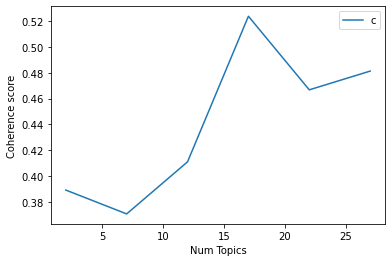

In [174]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_2021_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [175]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_2021_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 17

index: 0 | Num Topics = 2  has Coherence Value of 0.3893
index: 1 | Num Topics = 7  has Coherence Value of 0.3709
index: 2 | Num Topics = 12  has Coherence Value of 0.4111
index: 3 | Num Topics = 17  has Coherence Value of 0.5236
index: 4 | Num Topics = 22  has Coherence Value of 0.4667
index: 5 | Num Topics = 27  has Coherence Value of 0.4812


In [212]:
# Select optimal number of topics
optimal_model_us_2021_score1N2N3 = model_list_us_2021_score1N2N3[2]

In [213]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_2021_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_us_2021_score1N2N3, corpus_us_2021_score1N2N3, id2word_us_2021_score1N2N3)

In [214]:
print("pyLDAVis for us topics for score=1,2,3 in 2021:")
vis_us_2021_score1N2N3

pyLDAVis for us topics for score=1,2,3 in 2021:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.167114  0.001601       1        1  20.422138
4      0.062738 -0.146539       2        1  19.258082
7      0.049049 -0.108294       3        1  11.568905
5     -0.122609  0.000866       4        1  11.020546
6      0.160618  0.095321       5        1   9.955320
2      0.004038 -0.069501       6        1   8.566225
8     -0.001427  0.113474       7        1   8.393183
0      0.006916  0.003112       8        1   5.253578
1      0.009943  0.030600       9        1   1.891589
9      0.002112  0.019170      10        1   1.727047
11    -0.026146  0.034817      11        1   1.399552
10     0.021884  0.025372      12        1   0.543835, topic_info=        Term       Freq      Total Category  logprob  loglift
61      song  17.000000  17.000000  Default  30.0000  30.0000
84      find   9.000000   9.000000  Default  29.0000  29.0000
28     child   4.000000   4.000000  Default  28.0000  28.0000
55      love   7.000000   7.000000  Default  27.0000  27.0000
17       let   5.000000   5.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
25  awareeee   0.012428   1.306498  Topic12  -5.5722   0.5591
26       bra   0.012428   1.306498  Topic12  -5.5722   0.5591
27      call   0.012428   1.306498  Topic12  -5.5722   0.5591
28     child   0.012428   4.914464  Topic12  -5.5722  -0.7657
29    choose   0.012428   2.732927  Topic12  -5.5722  -0.1789

[566 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
215       5  0.525440     able
215       8  0.525440     able
183       2  0.711111  account
165       8  0.846319   actual
176       2  0.655542      add
...     ...       ...      ...
10        6  0.282270     work
10        7  0.282270     work
160       4  0.765995    worth
68        1  0.706876    write
69        1  0.706876    wrong

[364 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 8, 6, 7, 3, 9, 1, 2, 10, 12, 11])

# Export pyLDAvis as html

In [215]:
# Overall
pyLDAvis.save_html(vis_us,'lomotif_vis_us.html')

# By-rating 
pyLDAvis.save_html(vis_us_score1,'lomotif_vis_us_score1.html')
pyLDAvis.save_html(vis_us_score2,'lomotif_vis_us_score2.html')
pyLDAvis.save_html(vis_us_score3,'lomotif_vis_us_score3.html')
pyLDAvis.save_html(vis_us_score4,'lomotif_vis_us_score4.html')
pyLDAvis.save_html(vis_us_score5,'lomotif_vis_us_score5.html')
pyLDAvis.save_html(vis_us_score1N2N3,'lomotif_vis_us_score1N2N3.html')

# By-rating of each year
pyLDAvis.save_html(vis_us_2021_score1N2N3,'lomotif_vis_us_2021_score1N2N3.html')
pyLDAvis.save_html(vis_us_2020_score1N2N3,'lomotif_vis_us_2020_score1N2N3.html')
pyLDAvis.save_html(vis_us_2019_score1N2N3,'lomotif_vis_us_2019_score1N2N3.html')
pyLDAvis.save_html(vis_us_2018_score1N2N3,'lomotif_vis_us_2018_score1N2N3.html')

